## Loading prems

In [ ]:
from typing import Optional

import jax.numpy
import numpy


def gaussian_mixture_energy(coord, means, sigmas, weights):
    """
        Implements an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param coord : [[x,y]] point of shape=(1,2) at which to compute energy.
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :return energy value (or -log of unnormalized density)
    """

    diff = coord - means
    numerator = jax.numpy.sum(diff ** 2, axis=1)

    mode_densities = jax.numpy.exp(- numerator / (2 * sigmas ** 2)) / sigmas
    density = jax.numpy.sum(weights * mode_densities)
    return -jax.numpy.log(density)


def gaussian_mixture_sampler(N, means, sigmas, weights, key):
    """
        Implements sampling from an isotropic gaussian mixture energy function.
        This is a good distribution for debugging sampler implementation

        $\sum_{i=O}^{K-1}  w_i  \mathcal N (means_i, sigmas_i)$

        :param N : number of samples to generate
        :param means : array of 2D means (shape=(K, 2)) for each gaussian dist in mixture
        :param sigmas: array of scalers (shape=(K,)) describing std of each gaussian dist in mixture
        :param weights: array of scalers (shape=(K,)) describing weights of each gaussian dist in mixture
        :param key: JAX needs a key for its random number generator, it is just that
        :return samples shape=(N,2)
    """

    # first sample modes
    subkey, key = jax.random.split(key)
    modes = jax.random.choice(subkey, len(weights), shape=(N,), p=weights)

    shape = (N,) + means.shape[1:]
    subkey, key = jax.random.split(key)
    std_normal_samples = jax.random.normal(subkey, shape=shape)
    return std_normal_samples * sigmas[modes].reshape(std_normal_samples.shape[0], 1) + means[modes]


def sample_from_image_density(N, density, key):
    """
        adapted from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py#L138

        This samples a bin with probability given by density and then perturb the coordinate of bin uniformly

        :param N: number of samples
        :param density: density or value at each pixel
        :param key: JAX needs a key for its random number generator, it is just that
        :return: samples shape=(N,2)
    """
    # normalize
    density = density / density.sum()

    flat_density = density.flatten()
    subkey, key = jax.random.split(key)
    indices = jax.random.choice(subkey, a=len(flat_density), shape=(N,), p=flat_density)

    bins = jax.numpy.stack([indices // (density.shape[0]), indices % (density.shape[0])], axis=1)
    subkey, key = jax.random.split(key)
    samples = bins + jax.random.uniform(subkey, shape=bins.shape) - 0.5
    return samples


def continuous_energy_from_image(coord, xp, yp, zp, fill_value=None):
    """

    :param coord:
    :param xp: see interp2d
    :param yp: see interp2d
    :param zp: see interp2d
    :param fill_value: see interp2d (Note: you can this to enforce some trivial boundary conditions
    :return: energy (based on bilinear interpolation of zp on xp, yp grid. )
    """
    return -jax.numpy.log(interp2d(coord[0], coord[1], xp, yp, zp, fill_value))


def interp2d(
        x: jax.numpy.ndarray,
        y: jax.numpy.ndarray,
        xp: jax.numpy.ndarray,
        yp: jax.numpy.ndarray,
        zp: jax.numpy.ndarray,
        fill_value: Optional[jax.numpy.ndarray] = None,
) -> jax.numpy.ndarray:
    """
    Taken from "https://github.com/adam-coogan/jaxinterp2d/blob/master/src/jaxinterp2d/__init__.py"
    Bilinear interpolation on a grid. ``CartesianGrid`` is much faster if the data
    lies on a regular grid.
    Args:
        x, y: 1D arrays of point at which to interpolate. Any out-of-bounds
            coordinates will be clamped to lie in-bounds.
        xp, yp: 1D arrays of points specifying grid points where function values
            are provided.
        zp: 2D array of function values. For a function `f(x, y)` this must
            satisfy `zp[i, j] = f(xp[i], yp[j])`
    Returns:
        1D array `z` satisfying `z[i] = f(x[i], y[i])`.
    """
    if xp.ndim != 1 or yp.ndim != 1:
        raise ValueError("xp and yp must be 1D arrays")
    if zp.shape != (xp.shape + yp.shape):
        raise ValueError("zp must be a 2D array with shape xp.shape + yp.shape")

    ix = jax.numpy.clip(jax.numpy.searchsorted(xp, x, side="right"), 1, len(xp) - 1)
    iy = jax.numpy.clip(jax.numpy.searchsorted(yp, y, side="right"), 1, len(yp) - 1)

    # Using Wikipedia's notation (https://en.wikipedia.org/wiki/Bilinear_interpolation)
    z_11 = zp[ix - 1, iy - 1]
    z_21 = zp[ix, iy - 1]
    z_12 = zp[ix - 1, iy]
    z_22 = zp[ix, iy]

    z_xy1 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_11 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_21
    z_xy2 = (xp[ix] - x) / (xp[ix] - xp[ix - 1]) * z_12 + (x - xp[ix - 1]) / (
            xp[ix] - xp[ix - 1]
    ) * z_22

    z = (yp[iy] - y) / (yp[iy] - yp[iy - 1]) * z_xy1 + (y - yp[iy - 1]) / (
            yp[iy] - yp[iy - 1]
    ) * z_xy2

    if fill_value is not None:
        oob = jax.numpy.logical_or(
            x < xp[0], jax.numpy.logical_or(x > xp[-1], jax.numpy.logical_or(y < yp[0], y > yp[-1]))
        )
        z = jax.numpy.where(oob, fill_value, z)

    return z


def prepare_image(rgb, crop=None, embed=None, white_cutoff=225, gauss_sigma=3, background=0.01):
    """
    Taken from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/snf_code/snf_code/image.py
    Transforms rgb image array into 2D-density and energy
    Parameters:
        rgb: RGB image

     ----------
    density : ndarray(width, height)
        Probability density
    energy : ndarray(width, height)
        Energy
    """
    img = rgb

    # make one channel
    img = img.mean(axis=2)

    # make background white
    img = img.astype(numpy.float32)
    img[img > white_cutoff] = 255

    # normalize
    img /= img.max()

    if crop is not None:
        # crop
        img = img[crop[0]:crop[1], crop[2]:crop[3]]

    if embed is not None:
        tmp = numpy.ones((embed[0], embed[1]), dtype=numpy.float32)
        shift_x = (embed[0] - img.shape[0]) // 2
        shift_y = (embed[1] - img.shape[1]) // 2
        tmp[shift_x:img.shape[0] + shift_x, shift_y:img.shape[1] + shift_y] = img
        img = tmp

    # convolve with Gaussian
    from scipy.ndimage import gaussian_filter
    img2 = gaussian_filter(img, sigma=gauss_sigma)

    # add background
    background1 = gaussian_filter(img, sigma=10)
    background2 = gaussian_filter(img, sigma=20)
    background3 = gaussian_filter(img, sigma=50)
    density = (1.0 - img2) + background * (background1 + background2 + background3)

    U = -numpy.log(density)
    U -= U.min()

    return density, U

# see NPEET for different type of information-theoretic metrics
from typing import List, Union

import numpy


def compute_2d_histogram_from_samples(samples, density):
    """
        Compute 2D histogram from samples for samples on a 2D grid.
        This is to be used when sampling from image's density.

    :param samples: 2D samples from image density
    :param density: density derived from the image
    :return: unnormalized density with bin_size 1
    """

    x_dim, y_dim = density.shape

    sample_density, xedges, yedges = numpy.histogram2d(
        samples[:, 0], samples[:, 1], bins=[numpy.arange(0, x_dim + 1), numpy.arange(0, y_dim + 1)],
        density=False
    )

    return sample_density


def compute_coarse_discretization(density, bin_size):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    bin_size_x, bin_size_y = bin_size

    x_dim, y_dim = density.shape

    density_new = numpy.zeros(((x_dim + 1) // bin_size_x, (y_dim + 1) // bin_size_y))
    for i in range(0, density_new.shape[0]):
        for j in range(0, density_new.shape[1]):
            density_new[i, j] = (
                density[i * bin_size_x:(i + 1) * bin_size_x][:,
                j * bin_size_y:(j + 1) * bin_size_y]).sum()

    return density_new


def get_discretized_tv_for_image_density(density, samples, bin_size: Union[int, List[int]] = 1):
    if isinstance(bin_size, int):
        bin_size = [bin_size, bin_size]

    sample_density = compute_2d_histogram_from_samples(samples, density)

    density = compute_coarse_discretization(density, bin_size)
    sample_density = compute_coarse_discretization(sample_density, bin_size)

    sample_density = sample_density / sample_density.sum()
    density = density / density.sum()
    breakpoint()
    return (numpy.abs(density - sample_density)).sum()


## Installing related packages

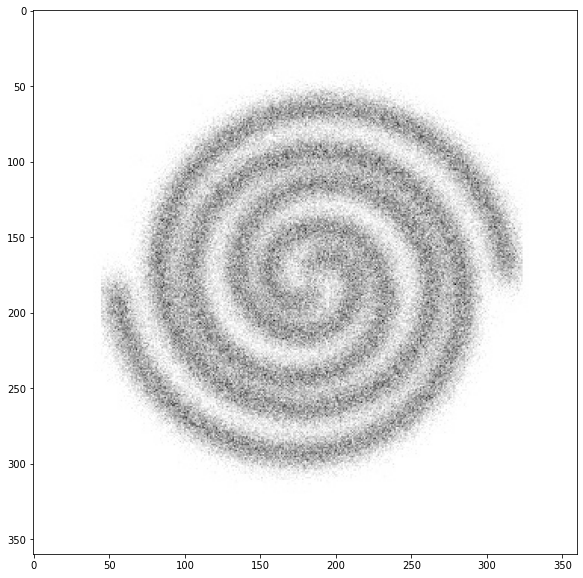

In [ ]:
import matplotlib.image
import matplotlib.pyplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rcParams, ticker, cm
from matplotlib import collections as mc
import numpy as onp 
rcParams['animation.html'] = 'jshtml'  # Makes the default animation an interactive video
rcParams['animation.embed_limit'] = 2**128  # Allow bigger animations

img = matplotlib.image.imread('/content/drive/MyDrive/CS699/homework #2/spiral.jpg')

# plot and visualize
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img)
matplotlib.pyplot.show()

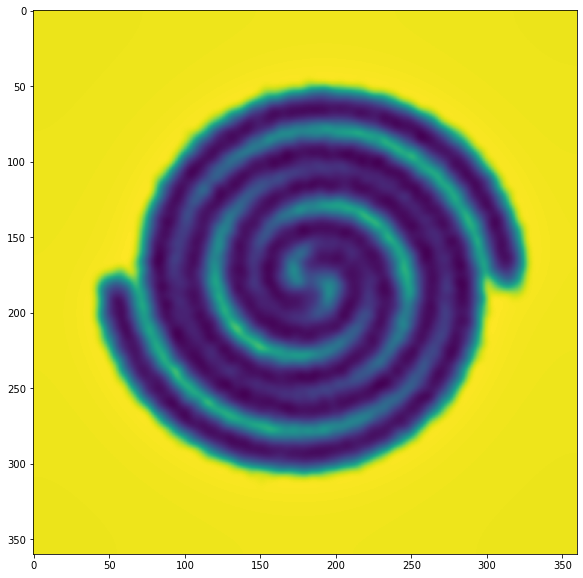

In [ ]:
import jax

density, energy = prepare_image(
    img, white_cutoff=225, gauss_sigma=3, background=0.01
)

x_max, y_max = density.shape
xp = jax.numpy.arange(x_max)
yp = jax.numpy.arange(y_max)
zp = jax.numpy.array(density)

# You may use fill value to enforce some boundary conditions or some other way to enforce boundary conditions
energy_fn = lambda coord: continuous_energy_from_image(coord, xp, yp, zp, fill_value=0)
energy_fn_grad = jax.grad(energy_fn)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(energy)
matplotlib.pyplot.show()

In [ ]:
import jax.numpy as np
import jax
from jax import random

key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

def hamiltonian_monte_carlo(x0, f, k, epsilon):
    """Run HMC for k steps, with step size epsilon"""
    v = onp.random.randn(*x0.shape)  # Not the correct way to get randoms in JAX
    g = jax.grad(f)  # Gradient of energy function
    x = x0  # save the original state, in case we reject the update
    for i in range(k):
        v = v - 0.5 * epsilon * g(x)  # half step in v
        x = x + epsilon * v  # full step in x
        v = v - 0.5 * epsilon * g(x)  # half step in v  
        # more efficient to combine half-steps
    if onp.random.random() > np.exp(f(x0) - f(x)):
        print("Metropolis- Hastings REJECT", f(x0), f(x))
        x = x0
    return x

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


  0%|          | 4/10000 [00:11<7:58:51,  2.87s/it]

Metropolis- Hastings REJECT 1.1989725 2.1314056


  0%|          | 16/10000 [00:45<7:54:22,  2.85s/it]

Metropolis- Hastings REJECT 1.8140705 2.2910962


  0%|          | 24/10000 [01:08<7:56:51,  2.87s/it]

Metropolis- Hastings REJECT 0.9669131 1.9025937


  0%|          | 39/10000 [01:52<8:22:43,  3.03s/it]

Metropolis- Hastings REJECT 0.9985272 1.8270665


  0%|          | 47/10000 [02:15<8:09:41,  2.95s/it]

Metropolis- Hastings REJECT 0.9924228 1.1433641


  0%|          | 49/10000 [02:21<8:20:20,  3.02s/it]

Metropolis- Hastings REJECT 1.2543921 1.5575407


  1%|          | 53/10000 [02:33<8:10:52,  2.96s/it]

Metropolis- Hastings REJECT 1.2225093 2.6526346


  1%|          | 55/10000 [02:39<8:08:22,  2.95s/it]

Metropolis- Hastings REJECT 0.97273695 3.3412125


  1%|          | 58/10000 [02:48<8:01:03,  2.90s/it]

Metropolis- Hastings REJECT 0.95141786 3.2949543


  1%|          | 59/10000 [02:51<8:01:26,  2.91s/it]

Metropolis- Hastings REJECT 0.95141786 1.5104336


  1%|          | 67/10000 [03:14<8:00:44,  2.90s/it]

Metropolis- Hastings REJECT 1.0120847 2.259383


  1%|          | 91/10000 [04:23<8:03:35,  2.93s/it]

Metropolis- Hastings REJECT 0.9894338 1.9628878


  1%|          | 101/10000 [04:52<8:09:08,  2.96s/it]

Metropolis- Hastings REJECT 0.94677955 1.1626142


  1%|          | 113/10000 [05:27<7:56:51,  2.89s/it]

Metropolis- Hastings REJECT 1.0095948 2.2272062


  1%|          | 116/10000 [05:35<8:03:07,  2.93s/it]

Metropolis- Hastings REJECT 1.0390546 3.2545698


  1%|          | 119/10000 [05:44<7:54:08,  2.88s/it]

Metropolis- Hastings REJECT 1.0123305 2.1217399


  1%|          | 124/10000 [05:58<7:51:41,  2.87s/it]

Metropolis- Hastings REJECT 1.0293015 1.7364212


  1%|▏         | 128/10000 [06:10<7:58:54,  2.91s/it]

Metropolis- Hastings REJECT 1.0151372 1.8392981


  1%|▏         | 144/10000 [06:55<7:44:47,  2.83s/it]

Metropolis- Hastings REJECT 1.1596308 1.6145098


  2%|▏         | 151/10000 [07:15<7:44:18,  2.83s/it]

Metropolis- Hastings REJECT 1.0207977 1.1696025


  2%|▏         | 156/10000 [07:29<7:49:45,  2.86s/it]

Metropolis- Hastings REJECT 1.325188 1.4848634


  2%|▏         | 157/10000 [07:32<7:49:36,  2.86s/it]

Metropolis- Hastings REJECT 1.325188 1.7763325


  2%|▏         | 161/10000 [07:44<7:47:50,  2.85s/it]

Metropolis- Hastings REJECT 1.1583183 1.8191813


  2%|▏         | 176/10000 [08:26<7:54:23,  2.90s/it]

Metropolis- Hastings REJECT 1.0027838 1.2302092


  2%|▏         | 189/10000 [09:04<7:56:00,  2.91s/it]

Metropolis- Hastings REJECT 1.0218171 1.1491413


  2%|▏         | 192/10000 [09:12<7:52:40,  2.89s/it]

Metropolis- Hastings REJECT 0.9965668 2.0382326


  2%|▏         | 193/10000 [09:15<7:49:57,  2.88s/it]

Metropolis- Hastings REJECT 0.9965668 2.7562037


  2%|▏         | 213/10000 [10:12<7:50:48,  2.89s/it]

Metropolis- Hastings REJECT 1.0237215 3.5547743


  2%|▏         | 218/10000 [10:26<7:43:06,  2.84s/it]

Metropolis- Hastings REJECT 1.1660135 3.5424473


  2%|▏         | 219/10000 [10:29<7:42:32,  2.84s/it]

Metropolis- Hastings REJECT 1.1660135 1.4395586


  2%|▏         | 227/10000 [10:51<7:40:09,  2.83s/it]

Metropolis- Hastings REJECT 1.0580043 1.4831029


  2%|▏         | 229/10000 [10:57<7:42:22,  2.84s/it]

Metropolis- Hastings REJECT 1.0296909 1.2746916


  2%|▏         | 234/10000 [11:11<7:41:03,  2.83s/it]

Metropolis- Hastings REJECT 1.2686496 1.7407315


  2%|▏         | 241/10000 [11:31<7:40:51,  2.83s/it]

Metropolis- Hastings REJECT 0.9188041 1.3254884


  2%|▏         | 247/10000 [11:48<7:48:47,  2.88s/it]

Metropolis- Hastings REJECT 1.0015185 1.2457594


  2%|▏         | 248/10000 [11:51<7:45:58,  2.87s/it]

Metropolis- Hastings REJECT 1.0015185 1.325731


  3%|▎         | 256/10000 [12:13<7:42:41,  2.85s/it]

Metropolis- Hastings REJECT 1.1813756 1.8983332


  3%|▎         | 262/10000 [12:31<7:46:44,  2.88s/it]

Metropolis- Hastings REJECT 0.9734998 1.3693689


  3%|▎         | 263/10000 [12:33<7:46:04,  2.87s/it]

Metropolis- Hastings REJECT 0.9734998 3.5603805


  3%|▎         | 289/10000 [13:47<7:46:08,  2.88s/it]

Metropolis- Hastings REJECT 0.98124325 2.409955


  3%|▎         | 301/10000 [14:21<7:31:00,  2.79s/it]

Metropolis- Hastings REJECT 1.0143161 1.5992398


  3%|▎         | 305/10000 [14:32<7:36:17,  2.82s/it]

Metropolis- Hastings REJECT 0.9351055 2.1921375


  3%|▎         | 311/10000 [14:48<7:27:41,  2.77s/it]

Metropolis- Hastings REJECT 0.9959208 1.9261478


  3%|▎         | 322/10000 [15:19<7:29:16,  2.79s/it]

Metropolis- Hastings REJECT 0.9845041 1.4023806


  3%|▎         | 325/10000 [15:28<7:36:08,  2.83s/it]

Metropolis- Hastings REJECT 1.2440368 1.9642775


  3%|▎         | 332/10000 [15:47<7:36:49,  2.84s/it]

Metropolis- Hastings REJECT 1.1410265 1.7790489


  3%|▎         | 333/10000 [15:50<7:39:09,  2.85s/it]

Metropolis- Hastings REJECT 1.1410265 1.5611082


  3%|▎         | 334/10000 [15:53<7:37:42,  2.84s/it]

Metropolis- Hastings REJECT 1.1410265 2.1291518


  3%|▎         | 336/10000 [15:59<7:41:56,  2.87s/it]

Metropolis- Hastings REJECT 0.98154426 1.4062141


  3%|▎         | 340/10000 [16:10<7:33:55,  2.82s/it]

Metropolis- Hastings REJECT 1.5537267 3.4423916


  3%|▎         | 343/10000 [16:19<7:38:17,  2.85s/it]

Metropolis- Hastings REJECT 1.1167488 2.9159112


  3%|▎         | 349/10000 [16:36<7:40:16,  2.86s/it]

Metropolis- Hastings REJECT 1.2475817 3.426382


  4%|▎         | 351/10000 [16:42<7:45:07,  2.89s/it]

Metropolis- Hastings REJECT 0.9721128 1.7182125


  4%|▎         | 354/10000 [16:50<7:42:13,  2.88s/it]

Metropolis- Hastings REJECT 1.0150992 2.7022002


  4%|▎         | 355/10000 [16:53<7:42:55,  2.88s/it]

Metropolis- Hastings REJECT 1.0150992 2.56584


  4%|▎         | 358/10000 [17:01<7:36:57,  2.84s/it]

Metropolis- Hastings REJECT 1.4190284 2.4128811


  4%|▎         | 360/10000 [17:07<7:35:02,  2.83s/it]

Metropolis- Hastings REJECT 1.4090066 1.9026228


  4%|▎         | 362/10000 [17:13<7:33:21,  2.82s/it]

Metropolis- Hastings REJECT 0.9916053 1.6244487


  4%|▎         | 367/10000 [17:27<7:51:02,  2.93s/it]

Metropolis- Hastings REJECT 1.0241833 1.1719056


  4%|▎         | 374/10000 [17:47<7:36:11,  2.84s/it]

Metropolis- Hastings REJECT 1.0905842 2.1334577


  4%|▍         | 416/10000 [19:45<7:33:57,  2.84s/it]

Metropolis- Hastings REJECT 1.0066481 1.2685376


  4%|▍         | 420/10000 [19:56<7:26:22,  2.80s/it]

Metropolis- Hastings REJECT 1.0183853 1.2320126


  4%|▍         | 424/10000 [20:07<7:34:59,  2.85s/it]

Metropolis- Hastings REJECT 1.2459435 1.3462873


  4%|▍         | 426/10000 [20:13<7:37:47,  2.87s/it]

Metropolis- Hastings REJECT 1.2271515 3.1171486


  4%|▍         | 427/10000 [20:16<7:41:05,  2.89s/it]

Metropolis- Hastings REJECT 1.2271515 2.4317646


  4%|▍         | 431/10000 [20:27<7:37:22,  2.87s/it]

Metropolis- Hastings REJECT 1.1155858 1.8989097


  4%|▍         | 444/10000 [21:04<7:36:50,  2.87s/it]

Metropolis- Hastings REJECT 1.0528316 2.4099767


  4%|▍         | 445/10000 [21:07<7:30:37,  2.83s/it]

Metropolis- Hastings REJECT 1.0528316 1.3270004


  4%|▍         | 447/10000 [21:13<7:36:32,  2.87s/it]

Metropolis- Hastings REJECT 1.0007514 1.2975692


  4%|▍         | 450/10000 [21:21<7:31:27,  2.84s/it]

Metropolis- Hastings REJECT 1.2813649 1.3369973


  5%|▍         | 456/10000 [21:38<7:25:57,  2.80s/it]

Metropolis- Hastings REJECT 0.99912447 1.8539314


  5%|▍         | 461/10000 [21:52<7:29:49,  2.83s/it]

Metropolis- Hastings REJECT 0.99196947 1.4106438


  5%|▍         | 473/10000 [22:26<7:27:36,  2.82s/it]

Metropolis- Hastings REJECT 1.2787125 1.4650444


  5%|▍         | 477/10000 [22:37<7:28:28,  2.83s/it]

Metropolis- Hastings REJECT 1.4831527 1.5609279


  5%|▍         | 484/10000 [22:56<7:25:33,  2.81s/it]

Metropolis- Hastings REJECT 1.0684712 1.6709187


  5%|▌         | 500/10000 [23:42<7:29:13,  2.84s/it]

Metropolis- Hastings REJECT 1.0248653 1.265585


  5%|▌         | 502/10000 [23:47<7:31:48,  2.85s/it]

Metropolis- Hastings REJECT 0.99969804 1.2638303


  5%|▌         | 505/10000 [23:56<7:30:07,  2.84s/it]

Metropolis- Hastings REJECT 0.9634756 1.496798


  5%|▌         | 513/10000 [24:18<7:31:26,  2.86s/it]

Metropolis- Hastings REJECT 1.1774608 1.633763


  5%|▌         | 514/10000 [24:21<7:28:20,  2.84s/it]

Metropolis- Hastings REJECT 1.1774608 1.2717454


  5%|▌         | 523/10000 [24:46<7:30:17,  2.85s/it]

Metropolis- Hastings REJECT 0.9996563 1.0035009


  5%|▌         | 542/10000 [25:40<7:27:22,  2.84s/it]

Metropolis- Hastings REJECT 1.0973477 1.6453001


  5%|▌         | 544/10000 [25:46<7:33:40,  2.88s/it]

Metropolis- Hastings REJECT 0.96530205 1.7795751


  6%|▌         | 555/10000 [26:17<7:25:37,  2.83s/it]

Metropolis- Hastings REJECT 1.118875 1.7333323


  6%|▌         | 561/10000 [26:34<7:26:25,  2.84s/it]

Metropolis- Hastings REJECT 0.95158434 1.7806654


  6%|▌         | 567/10000 [26:51<7:27:46,  2.85s/it]

Metropolis- Hastings REJECT 0.9679905 1.0880885


  6%|▌         | 570/10000 [26:59<7:25:07,  2.83s/it]

Metropolis- Hastings REJECT 1.0000145 1.1904644


  6%|▌         | 571/10000 [27:02<7:26:28,  2.84s/it]

Metropolis- Hastings REJECT 1.0000145 1.1365757


  6%|▌         | 574/10000 [27:10<7:23:26,  2.82s/it]

Metropolis- Hastings REJECT 1.1762732 2.1378357


  6%|▌         | 575/10000 [27:13<7:22:39,  2.82s/it]

Metropolis- Hastings REJECT 1.1762732 2.3542826


  6%|▌         | 586/10000 [27:44<7:36:18,  2.91s/it]

Metropolis- Hastings REJECT 1.0815651 2.7000887


  6%|▌         | 596/10000 [28:12<7:16:22,  2.78s/it]

Metropolis- Hastings REJECT 0.96878874 1.3416275


  6%|▌         | 597/10000 [28:15<7:23:23,  2.83s/it]

Metropolis- Hastings REJECT 0.96878874 1.7718176


  6%|▌         | 614/10000 [29:03<7:15:48,  2.79s/it]

Metropolis- Hastings REJECT 0.9726568 2.2736034


  6%|▌         | 620/10000 [29:20<7:15:32,  2.79s/it]

Metropolis- Hastings REJECT 0.93382335 0.99842584


  6%|▋         | 627/10000 [29:39<7:18:24,  2.81s/it]

Metropolis- Hastings REJECT 1.0687333 1.512828


  6%|▋         | 637/10000 [30:07<7:20:09,  2.82s/it]

Metropolis- Hastings REJECT 1.0940716 1.3948296


  6%|▋         | 644/10000 [30:27<7:22:33,  2.84s/it]

Metropolis- Hastings REJECT 1.0234972 1.3134525


  6%|▋         | 649/10000 [30:41<7:10:42,  2.76s/it]

Metropolis- Hastings REJECT 0.9835669 1.9816698


  7%|▋         | 662/10000 [31:17<7:29:45,  2.89s/it]

Metropolis- Hastings REJECT 1.0165591 1.162863


  7%|▋         | 667/10000 [31:31<7:22:11,  2.84s/it]

Metropolis- Hastings REJECT 0.9442901 1.1707897


  7%|▋         | 670/10000 [31:40<7:27:30,  2.88s/it]

Metropolis- Hastings REJECT 1.024755 1.453298


  7%|▋         | 674/10000 [31:52<7:27:07,  2.88s/it]

Metropolis- Hastings REJECT 1.0116128 1.3279325


  7%|▋         | 679/10000 [32:06<7:26:42,  2.88s/it]

Metropolis- Hastings REJECT 1.1342609 2.0220716


  7%|▋         | 684/10000 [32:20<7:17:51,  2.82s/it]

Metropolis- Hastings REJECT 0.97914684 2.1436384


  7%|▋         | 688/10000 [32:31<7:25:49,  2.87s/it]

Metropolis- Hastings REJECT 1.0947309 2.442926


  7%|▋         | 696/10000 [32:54<7:23:33,  2.86s/it]

Metropolis- Hastings REJECT 1.2396173 1.4747946


  7%|▋         | 710/10000 [33:34<7:26:53,  2.89s/it]

Metropolis- Hastings REJECT 1.5351444 2.1200957


  7%|▋         | 712/10000 [33:39<7:15:58,  2.82s/it]

Metropolis- Hastings REJECT 1.0906346 1.9640913


  7%|▋         | 719/10000 [33:59<7:21:19,  2.85s/it]

Metropolis- Hastings REJECT 1.3087096 1.7081254


  7%|▋         | 724/10000 [34:13<7:20:32,  2.85s/it]

Metropolis- Hastings REJECT 1.63152 2.4451382


  7%|▋         | 729/10000 [34:27<7:28:22,  2.90s/it]

Metropolis- Hastings REJECT 1.00194 1.607443


  7%|▋         | 746/10000 [35:15<7:19:54,  2.85s/it]

Metropolis- Hastings REJECT 1.1273141 1.2504301


  7%|▋         | 747/10000 [35:18<7:21:42,  2.86s/it]

Metropolis- Hastings REJECT 1.1273141 1.6089237


  7%|▋         | 748/10000 [35:21<7:23:10,  2.87s/it]

Metropolis- Hastings REJECT 1.1273141 2.0619097


  8%|▊         | 755/10000 [35:41<7:24:26,  2.88s/it]

Metropolis- Hastings REJECT 0.97802913 1.6668261


  8%|▊         | 757/10000 [35:46<7:17:20,  2.84s/it]

Metropolis- Hastings REJECT 1.323663 1.6023407


  8%|▊         | 787/10000 [37:11<7:12:44,  2.82s/it]

Metropolis- Hastings REJECT 1.0807152 1.5366049


  8%|▊         | 789/10000 [37:16<7:19:11,  2.86s/it]

Metropolis- Hastings REJECT 1.0878377 2.4346728


  8%|▊         | 809/10000 [38:13<7:19:13,  2.87s/it]

Metropolis- Hastings REJECT 0.9940976 1.5990149


  8%|▊         | 824/10000 [38:55<7:12:44,  2.83s/it]

Metropolis- Hastings REJECT 0.93986785 1.8142765


  8%|▊         | 830/10000 [39:12<7:12:17,  2.83s/it]

Metropolis- Hastings REJECT 1.0849264 1.9886779


  8%|▊         | 831/10000 [39:15<7:20:02,  2.88s/it]

Metropolis- Hastings REJECT 1.0849264 1.624599


  8%|▊         | 832/10000 [39:17<7:20:43,  2.88s/it]

Metropolis- Hastings REJECT 1.0849264 2.3787851


  8%|▊         | 836/10000 [39:29<7:08:50,  2.81s/it]

Metropolis- Hastings REJECT 2.5285878 3.0389442


  8%|▊         | 846/10000 [39:57<7:13:31,  2.84s/it]

Metropolis- Hastings REJECT 2.161798 2.8100595


  9%|▊         | 853/10000 [40:17<7:16:52,  2.87s/it]

Metropolis- Hastings REJECT 0.9971643 2.1145256


  9%|▊         | 857/10000 [40:28<7:04:36,  2.79s/it]

Metropolis- Hastings REJECT 1.187917 1.8154478


  9%|▉         | 885/10000 [41:46<7:10:13,  2.83s/it]

Metropolis- Hastings REJECT 1.1403072 1.2286887


  9%|▉         | 887/10000 [41:51<7:08:31,  2.82s/it]

Metropolis- Hastings REJECT 0.9670428 1.6678342


  9%|▉         | 901/10000 [42:30<7:06:26,  2.81s/it]

Metropolis- Hastings REJECT 0.9323127 1.123215


  9%|▉         | 928/10000 [43:46<7:03:18,  2.80s/it]

Metropolis- Hastings REJECT 0.9897871 1.0920919


  9%|▉         | 932/10000 [43:57<7:11:13,  2.85s/it]

Metropolis- Hastings REJECT 1.2192804 1.4622481


 10%|▉         | 962/10000 [45:20<7:08:15,  2.84s/it]

Metropolis- Hastings REJECT 1.1804651 1.9272541


 10%|▉         | 965/10000 [45:29<7:16:14,  2.90s/it]

Metropolis- Hastings REJECT 1.1870476 1.4920148


 10%|▉         | 970/10000 [45:43<7:06:28,  2.83s/it]

Metropolis- Hastings REJECT 1.4748976 1.5329846


 10%|▉         | 978/10000 [46:05<6:57:40,  2.78s/it]

Metropolis- Hastings REJECT 1.0016031 1.2914968


 10%|▉         | 979/10000 [46:08<6:59:47,  2.79s/it]

Metropolis- Hastings REJECT 1.0016031 2.0637965


 10%|▉         | 990/10000 [46:39<7:07:20,  2.85s/it]

Metropolis- Hastings REJECT 1.1737034 1.7402945


 10%|█         | 1002/10000 [47:13<7:05:31,  2.84s/it]

Metropolis- Hastings REJECT 1.0927991 1.5988607


 10%|█         | 1004/10000 [47:19<7:12:35,  2.89s/it]

Metropolis- Hastings REJECT 1.0331949 1.1667023


 10%|█         | 1010/10000 [47:36<6:59:42,  2.80s/it]

Metropolis- Hastings REJECT 1.1378168 2.4276445


 10%|█         | 1027/10000 [48:24<7:19:57,  2.94s/it]

Metropolis- Hastings REJECT 0.92175955 1.0061326


 10%|█         | 1032/10000 [48:38<7:20:05,  2.94s/it]

Metropolis- Hastings REJECT 0.91712016 2.3083076


 10%|█         | 1042/10000 [49:06<6:59:56,  2.81s/it]

Metropolis- Hastings REJECT 0.9720148 1.7510445


 10%|█         | 1045/10000 [49:15<6:55:31,  2.78s/it]

Metropolis- Hastings REJECT 1.0375534 1.3019606


 10%|█         | 1050/10000 [49:29<7:06:07,  2.86s/it]

Metropolis- Hastings REJECT 1.0264987 1.5450115


 11%|█         | 1055/10000 [49:43<7:01:52,  2.83s/it]

Metropolis- Hastings REJECT 1.118258 1.2068386


 11%|█         | 1056/10000 [49:46<7:08:42,  2.88s/it]

Metropolis- Hastings REJECT 1.118258 1.4073914


 11%|█         | 1078/10000 [50:48<7:08:52,  2.88s/it]

Metropolis- Hastings REJECT 0.98729146 2.161545


 11%|█         | 1079/10000 [50:51<7:06:44,  2.87s/it]

Metropolis- Hastings REJECT 0.98729146 1.2323812


 11%|█         | 1101/10000 [51:52<6:53:41,  2.79s/it]

Metropolis- Hastings REJECT 1.0240116 1.4928118


 11%|█         | 1110/10000 [52:17<6:58:38,  2.83s/it]

Metropolis- Hastings REJECT 0.99016994 1.7438155


 11%|█         | 1113/10000 [52:25<6:54:39,  2.80s/it]

Metropolis- Hastings REJECT 1.0307363 1.7329291


 11%|█         | 1118/10000 [52:39<6:53:19,  2.79s/it]

Metropolis- Hastings REJECT 0.9283149 1.6612993


 11%|█▏        | 1133/10000 [53:21<6:58:03,  2.83s/it]

Metropolis- Hastings REJECT 0.9179791 1.8467802


 12%|█▏        | 1158/10000 [54:31<7:00:21,  2.85s/it]

Metropolis- Hastings REJECT 1.3233109 1.7524527


 12%|█▏        | 1162/10000 [54:42<6:50:51,  2.79s/it]

Metropolis- Hastings REJECT 0.99789315 1.2579011


 12%|█▏        | 1163/10000 [54:45<6:58:13,  2.84s/it]

Metropolis- Hastings REJECT 0.99789315 1.3946098


 12%|█▏        | 1167/10000 [54:56<6:57:12,  2.83s/it]

Metropolis- Hastings REJECT 1.2362484 2.0460591


 12%|█▏        | 1168/10000 [54:59<7:02:20,  2.87s/it]

Metropolis- Hastings REJECT 1.2362484 2.4842832


 12%|█▏        | 1185/10000 [55:46<6:52:24,  2.81s/it]

Metropolis- Hastings REJECT 0.9981279 2.1732032


 12%|█▏        | 1186/10000 [55:49<6:58:04,  2.85s/it]

Metropolis- Hastings REJECT 0.9981279 1.5631157


 12%|█▏        | 1192/10000 [56:06<6:57:56,  2.85s/it]

Metropolis- Hastings REJECT 1.0809884 1.1747899


 12%|█▏        | 1204/10000 [56:40<6:58:17,  2.85s/it]

Metropolis- Hastings REJECT 0.9788401 1.4477762


 12%|█▏        | 1216/10000 [57:14<6:57:41,  2.85s/it]

Metropolis- Hastings REJECT 1.0017617 1.1694154


 12%|█▏        | 1219/10000 [57:22<6:57:11,  2.85s/it]

Metropolis- Hastings REJECT 1.0180393 1.5106298


 13%|█▎        | 1255/10000 [59:03<6:55:45,  2.85s/it]

Metropolis- Hastings REJECT 1.0101879 1.7529409


 13%|█▎        | 1261/10000 [59:20<6:53:13,  2.84s/it]

Metropolis- Hastings REJECT 1.0193002 1.6345904


 13%|█▎        | 1262/10000 [59:23<7:02:01,  2.90s/it]

Metropolis- Hastings REJECT 1.0193002 2.2595584


 13%|█▎        | 1267/10000 [59:38<6:53:30,  2.84s/it]

Metropolis- Hastings REJECT 1.2311677 1.8146672


 13%|█▎        | 1273/10000 [59:54<6:49:10,  2.81s/it]

Metropolis- Hastings REJECT 1.0384189 1.8141854


 13%|█▎        | 1275/10000 [1:00:00<6:52:48,  2.84s/it]

Metropolis- Hastings REJECT 0.98449004 2.0634093


 13%|█▎        | 1286/10000 [1:00:31<6:44:11,  2.78s/it]

Metropolis- Hastings REJECT 0.9799572 1.6601285


 13%|█▎        | 1292/10000 [1:00:48<6:52:28,  2.84s/it]

Metropolis- Hastings REJECT 1.1404569 1.5935991


 13%|█▎        | 1304/10000 [1:01:22<6:55:11,  2.86s/it]

Metropolis- Hastings REJECT 0.94017065 1.2920074


 13%|█▎        | 1308/10000 [1:01:33<6:52:31,  2.85s/it]

Metropolis- Hastings REJECT 1.0005741 1.071377


 13%|█▎        | 1309/10000 [1:01:36<6:49:37,  2.83s/it]

Metropolis- Hastings REJECT 1.0005741 1.1387607


 13%|█▎        | 1324/10000 [1:02:19<6:51:06,  2.84s/it]

Metropolis- Hastings REJECT 0.99077594 2.0999758


 13%|█▎        | 1330/10000 [1:02:36<7:00:38,  2.91s/it]

Metropolis- Hastings REJECT 1.0462188 1.3072252


 13%|█▎        | 1331/10000 [1:02:39<7:00:17,  2.91s/it]

Metropolis- Hastings REJECT 1.0462188 1.4530544


 13%|█▎        | 1336/10000 [1:02:53<6:56:32,  2.88s/it]

Metropolis- Hastings REJECT 0.98637265 1.7598832


 13%|█▎        | 1337/10000 [1:02:56<6:59:00,  2.90s/it]

Metropolis- Hastings REJECT 0.98637265 1.1474895


 14%|█▎        | 1350/10000 [1:03:33<6:52:25,  2.86s/it]

Metropolis- Hastings REJECT 1.1044657 1.4692957


 14%|█▎        | 1358/10000 [1:03:55<6:53:00,  2.87s/it]

Metropolis- Hastings REJECT 1.151148 2.017087


 14%|█▎        | 1374/10000 [1:04:40<6:43:07,  2.80s/it]

Metropolis- Hastings REJECT 0.90803504 1.5698339


 14%|█▍        | 1375/10000 [1:04:43<6:47:45,  2.84s/it]

Metropolis- Hastings REJECT 0.90803504 1.1842691


 14%|█▍        | 1376/10000 [1:04:45<6:46:36,  2.83s/it]

Metropolis- Hastings REJECT 0.90803504 2.0307763


 14%|█▍        | 1387/10000 [1:05:17<6:50:42,  2.86s/it]

Metropolis- Hastings REJECT 1.1850035 2.379738


 14%|█▍        | 1394/10000 [1:05:36<6:45:45,  2.83s/it]

Metropolis- Hastings REJECT 1.0527974 1.1354005


 14%|█▍        | 1400/10000 [1:05:53<6:43:29,  2.82s/it]

Metropolis- Hastings REJECT 1.0077608 1.2028668


 14%|█▍        | 1417/10000 [1:06:41<6:43:07,  2.82s/it]

Metropolis- Hastings REJECT 1.0261987 1.0897315


 14%|█▍        | 1422/10000 [1:06:56<6:50:09,  2.87s/it]

Metropolis- Hastings REJECT 1.0828476 1.8758726


 14%|█▍        | 1423/10000 [1:06:59<6:53:25,  2.89s/it]

Metropolis- Hastings REJECT 1.0828476 1.4577763


 14%|█▍        | 1436/10000 [1:07:35<6:42:21,  2.82s/it]

Metropolis- Hastings REJECT 0.96709824 2.36166


 14%|█▍        | 1444/10000 [1:07:58<6:38:54,  2.80s/it]

Metropolis- Hastings REJECT 0.9625451 2.2628736


 14%|█▍        | 1446/10000 [1:08:03<6:44:03,  2.83s/it]

Metropolis- Hastings REJECT 0.9315839 1.4495195


 14%|█▍        | 1447/10000 [1:08:06<6:49:17,  2.87s/it]

Metropolis- Hastings REJECT 0.9315839 1.4683617


 15%|█▍        | 1451/10000 [1:08:18<6:46:08,  2.85s/it]

Metropolis- Hastings REJECT 0.9301956 1.9931147


 15%|█▍        | 1454/10000 [1:08:26<6:47:34,  2.86s/it]

Metropolis- Hastings REJECT 1.0598457 1.1911585


 15%|█▍        | 1456/10000 [1:08:32<6:51:36,  2.89s/it]

Metropolis- Hastings REJECT 0.9426331 1.8502687


 15%|█▍        | 1457/10000 [1:08:35<6:56:54,  2.93s/it]

Metropolis- Hastings REJECT 0.9426331 2.1583817


 15%|█▍        | 1464/10000 [1:08:55<6:39:50,  2.81s/it]

Metropolis- Hastings REJECT 1.0545706 1.3041552


 15%|█▍        | 1466/10000 [1:09:00<6:47:22,  2.86s/it]

Metropolis- Hastings REJECT 1.0422881 1.4726057


 15%|█▍        | 1467/10000 [1:09:03<6:53:49,  2.91s/it]

Metropolis- Hastings REJECT 1.0422881 2.1772988


 15%|█▍        | 1469/10000 [1:09:09<6:52:33,  2.90s/it]

Metropolis- Hastings REJECT 0.9483786 2.4191298


 15%|█▍        | 1470/10000 [1:09:12<6:56:14,  2.93s/it]

Metropolis- Hastings REJECT 0.9483786 1.4607861


 15%|█▍        | 1475/10000 [1:09:27<6:52:41,  2.90s/it]

Metropolis- Hastings REJECT 1.0682071 1.6918375


 15%|█▍        | 1478/10000 [1:09:35<6:41:56,  2.83s/it]

Metropolis- Hastings REJECT 0.9444413 1.9152429


 15%|█▍        | 1482/10000 [1:09:46<6:42:56,  2.84s/it]

Metropolis- Hastings REJECT 1.3016446 2.6984313


 15%|█▍        | 1485/10000 [1:09:55<6:39:22,  2.81s/it]

Metropolis- Hastings REJECT 1.0811121 3.5663514


 15%|█▍        | 1494/10000 [1:10:20<6:42:57,  2.84s/it]

Metropolis- Hastings REJECT 1.0867249 3.340219


 15%|█▍        | 1497/10000 [1:10:29<6:43:56,  2.85s/it]

Metropolis- Hastings REJECT 0.9983827 1.6107857


 15%|█▌        | 1500/10000 [1:10:37<6:36:27,  2.80s/it]

Metropolis- Hastings REJECT 0.95905983 1.3583366


 15%|█▌        | 1503/10000 [1:10:46<6:45:59,  2.87s/it]

Metropolis- Hastings REJECT 1.0290473 1.4597119


 15%|█▌        | 1532/10000 [1:12:07<6:38:49,  2.83s/it]

Metropolis- Hastings REJECT 0.99135053 1.6041354


 15%|█▌        | 1540/10000 [1:12:29<6:35:17,  2.80s/it]

Metropolis- Hastings REJECT 0.9701696 1.2830967


 15%|█▌        | 1541/10000 [1:12:32<6:44:47,  2.87s/it]

Metropolis- Hastings REJECT 0.9701696 1.4883782


 15%|█▌        | 1542/10000 [1:12:35<6:46:08,  2.88s/it]

Metropolis- Hastings REJECT 0.9701696 1.8241383


 16%|█▌        | 1559/10000 [1:13:23<6:38:36,  2.83s/it]

Metropolis- Hastings REJECT 0.9087637 2.0871649


 16%|█▌        | 1566/10000 [1:13:43<6:43:30,  2.87s/it]

Metropolis- Hastings REJECT 1.2365248 1.733706


 16%|█▌        | 1567/10000 [1:13:46<6:39:34,  2.84s/it]

Metropolis- Hastings REJECT 1.2365248 1.51521


 16%|█▌        | 1572/10000 [1:14:00<6:38:42,  2.84s/it]

Metropolis- Hastings REJECT 0.9683931 1.6652287


 16%|█▌        | 1590/10000 [1:14:51<6:30:52,  2.79s/it]

Metropolis- Hastings REJECT 1.1109805 1.9112281


 16%|█▌        | 1597/10000 [1:15:11<6:37:22,  2.84s/it]

Metropolis- Hastings REJECT 1.1269369 2.3426468


 16%|█▌        | 1599/10000 [1:15:16<6:36:56,  2.83s/it]

Metropolis- Hastings REJECT 0.94276893 1.1234419


 16%|█▌        | 1608/10000 [1:15:42<6:39:46,  2.86s/it]

Metropolis- Hastings REJECT 1.4788007 2.2970395


 16%|█▌        | 1624/10000 [1:16:27<6:34:23,  2.83s/it]

Metropolis- Hastings REJECT 1.2144166 1.5510669


 16%|█▋        | 1625/10000 [1:16:30<6:40:29,  2.87s/it]

Metropolis- Hastings REJECT 1.2144166 2.0349476


 16%|█▋        | 1628/10000 [1:16:39<6:41:37,  2.88s/it]

Metropolis- Hastings REJECT 1.0589334 1.4615664


 16%|█▋        | 1630/10000 [1:16:44<6:45:42,  2.91s/it]

Metropolis- Hastings REJECT 1.2114308 3.307093


 16%|█▋        | 1640/10000 [1:17:13<6:44:06,  2.90s/it]

Metropolis- Hastings REJECT 0.916554 2.0056674


 17%|█▋        | 1669/10000 [1:18:36<6:40:32,  2.88s/it]

Metropolis- Hastings REJECT 0.9296891 2.1534991


 17%|█▋        | 1679/10000 [1:19:04<6:40:06,  2.89s/it]

Metropolis- Hastings REJECT 1.1817027 1.7353027


 17%|█▋        | 1681/10000 [1:19:10<6:40:12,  2.89s/it]

Metropolis- Hastings REJECT 1.2258731 1.6992218


 17%|█▋        | 1684/10000 [1:19:19<6:40:19,  2.89s/it]

Metropolis- Hastings REJECT 1.0263113 1.1034758


 17%|█▋        | 1695/10000 [1:19:50<6:37:57,  2.88s/it]

Metropolis- Hastings REJECT 1.0267582 1.3087218


 17%|█▋        | 1696/10000 [1:19:53<6:39:17,  2.89s/it]

Metropolis- Hastings REJECT 1.0267582 1.3620427


 17%|█▋        | 1697/10000 [1:19:56<6:37:14,  2.87s/it]

Metropolis- Hastings REJECT 1.0267582 1.4659072


 17%|█▋        | 1714/10000 [1:20:45<6:31:28,  2.83s/it]

Metropolis- Hastings REJECT 1.1397258 2.467618


 17%|█▋        | 1721/10000 [1:21:05<6:35:26,  2.87s/it]

Metropolis- Hastings REJECT 1.0482714 1.9956784


 17%|█▋        | 1730/10000 [1:21:31<6:37:54,  2.89s/it]

Metropolis- Hastings REJECT 1.0667611 1.712219


 17%|█▋        | 1731/10000 [1:21:34<6:35:31,  2.87s/it]

Metropolis- Hastings REJECT 1.0667611 2.6355162


 17%|█▋        | 1732/10000 [1:21:36<6:36:29,  2.88s/it]

Metropolis- Hastings REJECT 1.0667611 3.0205128


 17%|█▋        | 1738/10000 [1:21:54<6:39:30,  2.90s/it]

Metropolis- Hastings REJECT 1.0939901 1.6372336


 17%|█▋        | 1739/10000 [1:21:57<6:41:31,  2.92s/it]

Metropolis- Hastings REJECT 1.0939901 1.2547795


 17%|█▋        | 1744/10000 [1:22:11<6:35:19,  2.87s/it]

Metropolis- Hastings REJECT 1.6161904 1.922176


 18%|█▊        | 1752/10000 [1:22:34<6:32:16,  2.85s/it]

Metropolis- Hastings REJECT 0.9805575 1.1739082


 18%|█▊        | 1753/10000 [1:22:37<6:33:00,  2.86s/it]

Metropolis- Hastings REJECT 0.9805575 3.4232368


 18%|█▊        | 1757/10000 [1:22:48<6:36:10,  2.88s/it]

Metropolis- Hastings REJECT 0.95949244 1.112849


 18%|█▊        | 1758/10000 [1:22:51<6:36:19,  2.89s/it]

Metropolis- Hastings REJECT 0.95949244 1.0665761


 18%|█▊        | 1760/10000 [1:22:57<6:36:49,  2.89s/it]

Metropolis- Hastings REJECT 0.9474077 1.1151386


 18%|█▊        | 1766/10000 [1:23:14<6:28:49,  2.83s/it]

Metropolis- Hastings REJECT 0.9776767 1.4649179


 18%|█▊        | 1767/10000 [1:23:16<6:30:23,  2.85s/it]

Metropolis- Hastings REJECT 0.9776767 1.1796874


 18%|█▊        | 1768/10000 [1:23:19<6:32:40,  2.86s/it]

Metropolis- Hastings REJECT 0.9776767 1.3418272


 18%|█▊        | 1769/10000 [1:23:22<6:38:16,  2.90s/it]

Metropolis- Hastings REJECT 0.9776767 1.850769


 18%|█▊        | 1770/10000 [1:23:25<6:42:26,  2.93s/it]

Metropolis- Hastings REJECT 0.9776767 2.0508301


 18%|█▊        | 1778/10000 [1:23:48<6:30:50,  2.85s/it]

Metropolis- Hastings REJECT 0.9394222 2.9586568


 18%|█▊        | 1779/10000 [1:23:51<6:32:20,  2.86s/it]

Metropolis- Hastings REJECT 0.9394222 3.28336


 18%|█▊        | 1781/10000 [1:23:57<6:36:22,  2.89s/it]

Metropolis- Hastings REJECT 1.1306185 1.782907


 18%|█▊        | 1788/10000 [1:24:17<6:29:54,  2.85s/it]

Metropolis- Hastings REJECT 1.072959 1.8102622


 18%|█▊        | 1789/10000 [1:24:20<6:38:56,  2.92s/it]

Metropolis- Hastings REJECT 1.072959 2.0949266


 18%|█▊        | 1790/10000 [1:24:23<6:38:22,  2.91s/it]

Metropolis- Hastings REJECT 1.072959 1.3705008


 18%|█▊        | 1800/10000 [1:24:52<6:36:38,  2.90s/it]

Metropolis- Hastings REJECT 1.0249739 1.9175601


 18%|█▊        | 1821/10000 [1:25:51<6:25:45,  2.83s/it]

Metropolis- Hastings REJECT 1.0211952 1.5312595


 18%|█▊        | 1822/10000 [1:25:54<6:25:22,  2.83s/it]

Metropolis- Hastings REJECT 1.0211952 1.4140155


 18%|█▊        | 1835/10000 [1:26:30<6:17:15,  2.77s/it]

Metropolis- Hastings REJECT 1.2167518 1.9130113


 18%|█▊        | 1836/10000 [1:26:33<6:19:40,  2.79s/it]

Metropolis- Hastings REJECT 1.2167518 1.5810096


 18%|█▊        | 1839/10000 [1:26:42<6:31:38,  2.88s/it]

Metropolis- Hastings REJECT 1.0907737 1.3319046


 18%|█▊        | 1840/10000 [1:26:45<6:31:03,  2.88s/it]

Metropolis- Hastings REJECT 1.0907737 1.4879075


 18%|█▊        | 1850/10000 [1:27:13<6:31:02,  2.88s/it]

Metropolis- Hastings REJECT 0.94230163 1.1317644


 19%|█▊        | 1859/10000 [1:27:39<6:30:27,  2.88s/it]

Metropolis- Hastings REJECT 1.2632605 1.4003386


 19%|█▊        | 1867/10000 [1:28:02<6:26:13,  2.85s/it]

Metropolis- Hastings REJECT 1.1318069 1.5637974


 19%|█▉        | 1875/10000 [1:28:24<6:13:27,  2.76s/it]

Metropolis- Hastings REJECT 1.6654074 3.0881906


 19%|█▉        | 1884/10000 [1:28:49<6:23:31,  2.84s/it]

Metropolis- Hastings REJECT 1.0092208 1.2753481


 19%|█▉        | 1887/10000 [1:28:57<6:20:44,  2.82s/it]

Metropolis- Hastings REJECT 1.0093644 1.5594438


 19%|█▉        | 1902/10000 [1:29:39<6:24:50,  2.85s/it]

Metropolis- Hastings REJECT 0.9595396 1.5572059


 19%|█▉        | 1910/10000 [1:30:02<6:23:00,  2.84s/it]

Metropolis- Hastings REJECT 1.0877448 1.6262699


 19%|█▉        | 1917/10000 [1:30:22<6:24:22,  2.85s/it]

Metropolis- Hastings REJECT 1.0663223 2.0135572


 19%|█▉        | 1923/10000 [1:30:39<6:27:55,  2.88s/it]

Metropolis- Hastings REJECT 1.1725157 1.526226


 19%|█▉        | 1926/10000 [1:30:48<6:24:12,  2.86s/it]

Metropolis- Hastings REJECT 1.1436203 3.0625117


 19%|█▉        | 1936/10000 [1:31:17<6:26:13,  2.87s/it]

Metropolis- Hastings REJECT 0.9953029 1.1639332


 19%|█▉        | 1940/10000 [1:31:28<6:29:23,  2.90s/it]

Metropolis- Hastings REJECT 0.97727925 3.1627553


 19%|█▉        | 1942/10000 [1:31:34<6:28:40,  2.89s/it]

Metropolis- Hastings REJECT 0.98402834 1.7193339


 19%|█▉        | 1945/10000 [1:31:43<6:27:59,  2.89s/it]

Metropolis- Hastings REJECT 1.0768644 1.656489


 20%|█▉        | 1953/10000 [1:32:06<6:25:35,  2.88s/it]

Metropolis- Hastings REJECT 0.9251399 3.253895


 20%|█▉        | 1958/10000 [1:32:20<6:25:29,  2.88s/it]

Metropolis- Hastings REJECT 1.8305471 3.5349715


 20%|█▉        | 1961/10000 [1:32:28<6:24:30,  2.87s/it]

Metropolis- Hastings REJECT 0.98797965 1.1430341


 20%|█▉        | 1962/10000 [1:32:31<6:31:40,  2.92s/it]

Metropolis- Hastings REJECT 0.98797965 1.3031361


 20%|█▉        | 1966/10000 [1:32:43<6:29:41,  2.91s/it]

Metropolis- Hastings REJECT 1.1429881 1.400189


 20%|█▉        | 1982/10000 [1:33:27<6:12:37,  2.79s/it]

Metropolis- Hastings REJECT 1.114063 1.7875245


 20%|█▉        | 1986/10000 [1:33:39<6:16:17,  2.82s/it]

Metropolis- Hastings REJECT 1.0120577 1.6174277


 20%|█▉        | 1989/10000 [1:33:47<6:22:37,  2.87s/it]

Metropolis- Hastings REJECT 0.98586535 1.3473811


 20%|█▉        | 1995/10000 [1:34:04<6:19:53,  2.85s/it]

Metropolis- Hastings REJECT 0.9659729 1.4889246


 20%|█▉        | 1997/10000 [1:34:10<6:18:08,  2.84s/it]

Metropolis- Hastings REJECT 0.98133147 3.511207


 20%|█▉        | 1998/10000 [1:34:13<6:22:20,  2.87s/it]

Metropolis- Hastings REJECT 0.98133147 2.9127114


 20%|█▉        | 1999/10000 [1:34:16<6:21:50,  2.86s/it]

Metropolis- Hastings REJECT 0.98133147 1.744441


 20%|██        | 2000/10000 [1:34:19<6:21:27,  2.86s/it]

Metropolis- Hastings REJECT 0.98133147 1.5936351


 20%|██        | 2002/10000 [1:34:24<6:17:16,  2.83s/it]

Metropolis- Hastings REJECT 0.9798381 0.9955975


 20%|██        | 2006/10000 [1:34:35<6:11:51,  2.79s/it]

Metropolis- Hastings REJECT 1.1039298 1.8464739


 20%|██        | 2012/10000 [1:34:52<6:20:28,  2.86s/it]

Metropolis- Hastings REJECT 1.0860373 2.1260917


 20%|██        | 2017/10000 [1:35:07<6:23:15,  2.88s/it]

Metropolis- Hastings REJECT 1.0029802 1.1736959


 20%|██        | 2023/10000 [1:35:24<6:20:20,  2.86s/it]

Metropolis- Hastings REJECT 0.9554508 1.7583296


 20%|██        | 2024/10000 [1:35:27<6:20:34,  2.86s/it]

Metropolis- Hastings REJECT 0.9554508 1.7831274


 20%|██        | 2029/10000 [1:35:41<6:22:27,  2.88s/it]

Metropolis- Hastings REJECT 0.96340084 2.7286797


 20%|██        | 2030/10000 [1:35:44<6:22:39,  2.88s/it]

Metropolis- Hastings REJECT 0.96340084 1.3666273


 20%|██        | 2037/10000 [1:36:04<6:19:59,  2.86s/it]

Metropolis- Hastings REJECT 1.040509 1.9861207


 20%|██        | 2049/10000 [1:36:37<6:19:44,  2.87s/it]

Metropolis- Hastings REJECT 0.9785 1.7444298


 21%|██        | 2052/10000 [1:36:46<6:19:57,  2.87s/it]

Metropolis- Hastings REJECT 1.0734924 1.9028438


 21%|██        | 2054/10000 [1:36:51<6:19:07,  2.86s/it]

Metropolis- Hastings REJECT 1.1363509 2.4045496


 21%|██        | 2065/10000 [1:37:22<6:13:55,  2.83s/it]

Metropolis- Hastings REJECT 0.9169339 1.3920851


 21%|██        | 2081/10000 [1:38:08<6:20:51,  2.89s/it]

Metropolis- Hastings REJECT 1.1142637 1.8354158


 21%|██        | 2095/10000 [1:38:47<6:08:30,  2.80s/it]

Metropolis- Hastings REJECT 0.98431873 1.4109629


 21%|██        | 2108/10000 [1:39:23<6:11:06,  2.82s/it]

Metropolis- Hastings REJECT 0.97258437 1.5182291


 21%|██        | 2114/10000 [1:39:41<6:22:51,  2.91s/it]

Metropolis- Hastings REJECT 1.1048691 1.2048901


 21%|██▏       | 2126/10000 [1:40:15<6:13:56,  2.85s/it]

Metropolis- Hastings REJECT 1.4174789 2.3873847


 21%|██▏       | 2130/10000 [1:40:26<6:08:23,  2.81s/it]

Metropolis- Hastings REJECT 0.9946521 2.1740353


 21%|██▏       | 2131/10000 [1:40:29<6:14:07,  2.85s/it]

Metropolis- Hastings REJECT 0.9946521 1.1969752


 21%|██▏       | 2132/10000 [1:40:32<6:12:25,  2.84s/it]

Metropolis- Hastings REJECT 0.9946521 1.1076512


 21%|██▏       | 2143/10000 [1:41:02<6:02:28,  2.77s/it]

Metropolis- Hastings REJECT 1.2772198 1.4172888


 22%|██▏       | 2151/10000 [1:41:25<6:15:20,  2.87s/it]

Metropolis- Hastings REJECT 0.9919534 1.5248277


 22%|██▏       | 2154/10000 [1:41:33<6:12:07,  2.85s/it]

Metropolis- Hastings REJECT 1.0947982 1.2510694


 22%|██▏       | 2162/10000 [1:41:56<6:13:25,  2.86s/it]

Metropolis- Hastings REJECT 0.9526354 2.2997155


 22%|██▏       | 2176/10000 [1:42:35<6:10:11,  2.84s/it]

Metropolis- Hastings REJECT 1.2041576 1.4951913


 22%|██▏       | 2179/10000 [1:42:44<6:12:17,  2.86s/it]

Metropolis- Hastings REJECT 1.0990304 1.2531781


 22%|██▏       | 2181/10000 [1:42:49<6:09:45,  2.84s/it]

Metropolis- Hastings REJECT 1.0599656 1.1300588


 22%|██▏       | 2186/10000 [1:43:03<6:05:34,  2.81s/it]

Metropolis- Hastings REJECT 1.057529 3.187695


 22%|██▏       | 2188/10000 [1:43:09<6:05:31,  2.81s/it]

Metropolis- Hastings REJECT 1.0208633 1.4107896


 22%|██▏       | 2198/10000 [1:43:37<6:14:25,  2.88s/it]

Metropolis- Hastings REJECT 1.0174948 1.4760613


 22%|██▏       | 2204/10000 [1:43:55<6:17:24,  2.90s/it]

Metropolis- Hastings REJECT 1.1721691 2.3845856


 22%|██▏       | 2207/10000 [1:44:03<5:59:49,  2.77s/it]

Metropolis- Hastings REJECT 1.0003157 1.6326982


 22%|██▏       | 2211/10000 [1:44:14<6:11:30,  2.86s/it]

Metropolis- Hastings REJECT 0.9755434 1.8554548


 22%|██▏       | 2213/10000 [1:44:20<6:13:27,  2.88s/it]

Metropolis- Hastings REJECT 1.2420616 2.8075402


 22%|██▏       | 2214/10000 [1:44:23<6:16:53,  2.90s/it]

Metropolis- Hastings REJECT 1.2420616 1.6057072


 22%|██▏       | 2215/10000 [1:44:26<6:15:59,  2.90s/it]

Metropolis- Hastings REJECT 1.2420616 1.6479557


 22%|██▏       | 2218/10000 [1:44:34<6:08:59,  2.84s/it]

Metropolis- Hastings REJECT 1.9836849 2.0463402


 22%|██▏       | 2232/10000 [1:45:13<6:06:21,  2.83s/it]

Metropolis- Hastings REJECT 0.9933591 3.1784303


 23%|██▎       | 2265/10000 [1:46:46<6:08:09,  2.86s/it]

Metropolis- Hastings REJECT 1.1048664 1.354294


 23%|██▎       | 2268/10000 [1:46:54<6:06:04,  2.84s/it]

Metropolis- Hastings REJECT 0.93264496 2.340101


 23%|██▎       | 2271/10000 [1:47:03<6:09:25,  2.87s/it]

Metropolis- Hastings REJECT 0.94943017 2.4047763


 23%|██▎       | 2273/10000 [1:47:09<6:10:22,  2.88s/it]

Metropolis- Hastings REJECT 0.97680914 2.2251468


 23%|██▎       | 2284/10000 [1:47:39<6:00:01,  2.80s/it]

Metropolis- Hastings REJECT 1.0174887 1.6206124


 23%|██▎       | 2289/10000 [1:47:53<5:58:58,  2.79s/it]

Metropolis- Hastings REJECT 1.0113553 1.7348335


 23%|██▎       | 2290/10000 [1:47:56<6:06:19,  2.85s/it]

Metropolis- Hastings REJECT 1.0113553 2.2321737


 23%|██▎       | 2291/10000 [1:47:59<6:09:03,  2.87s/it]

Metropolis- Hastings REJECT 1.0113553 1.8379805


 23%|██▎       | 2292/10000 [1:48:02<6:10:26,  2.88s/it]

Metropolis- Hastings REJECT 1.0113553 1.5279925


 23%|██▎       | 2301/10000 [1:48:27<6:00:05,  2.81s/it]

Metropolis- Hastings REJECT 1.1474355 2.4803212


 23%|██▎       | 2305/10000 [1:48:38<6:03:27,  2.83s/it]

Metropolis- Hastings REJECT 1.0892985 1.7720214


 23%|██▎       | 2306/10000 [1:48:41<6:03:15,  2.83s/it]

Metropolis- Hastings REJECT 1.0892985 1.727095


 23%|██▎       | 2317/10000 [1:49:12<5:57:09,  2.79s/it]

Metropolis- Hastings REJECT 1.2013865 1.3940129


 23%|██▎       | 2339/10000 [1:50:13<6:08:43,  2.89s/it]

Metropolis- Hastings REJECT 1.1531446 1.3618568


 23%|██▎       | 2342/10000 [1:50:22<6:11:46,  2.91s/it]

Metropolis- Hastings REJECT 0.9888507 1.1134803


 23%|██▎       | 2344/10000 [1:50:28<6:14:38,  2.94s/it]

Metropolis- Hastings REJECT 1.0626844 1.7039634


 24%|██▎       | 2366/10000 [1:51:29<5:56:35,  2.80s/it]

Metropolis- Hastings REJECT 0.9758748 2.41083


 24%|██▎       | 2370/10000 [1:51:40<6:00:27,  2.83s/it]

Metropolis- Hastings REJECT 0.9501972 1.4160135


 24%|██▍       | 2377/10000 [1:52:00<5:55:10,  2.80s/it]

Metropolis- Hastings REJECT 0.96358454 1.1136261


 24%|██▍       | 2381/10000 [1:52:11<5:53:08,  2.78s/it]

Metropolis- Hastings REJECT 1.3330735 2.2719595


 24%|██▍       | 2382/10000 [1:52:14<5:59:16,  2.83s/it]

Metropolis- Hastings REJECT 1.3330735 3.5779083


 24%|██▍       | 2386/10000 [1:52:25<6:00:20,  2.84s/it]

Metropolis- Hastings REJECT 0.98140395 2.0079875


 24%|██▍       | 2388/10000 [1:52:31<6:03:45,  2.87s/it]

Metropolis- Hastings REJECT 1.0688221 1.2221863


 24%|██▍       | 2389/10000 [1:52:34<6:03:09,  2.86s/it]

Metropolis- Hastings REJECT 1.0688221 1.594697


 24%|██▍       | 2393/10000 [1:52:45<5:57:20,  2.82s/it]

Metropolis- Hastings REJECT 1.314481 2.0462902


 24%|██▍       | 2398/10000 [1:52:59<5:52:26,  2.78s/it]

Metropolis- Hastings REJECT 1.0494466 2.9534693


 24%|██▍       | 2408/10000 [1:53:27<5:55:38,  2.81s/it]

Metropolis- Hastings REJECT 1.5759174 3.554383


 24%|██▍       | 2415/10000 [1:53:47<5:58:31,  2.84s/it]

Metropolis- Hastings REJECT 1.1839272 1.8066714


 24%|██▍       | 2421/10000 [1:54:04<5:54:52,  2.81s/it]

Metropolis- Hastings REJECT 1.2278543 2.2647314


 24%|██▍       | 2428/10000 [1:54:23<5:57:57,  2.84s/it]

Metropolis- Hastings REJECT 0.99394023 1.737037


 24%|██▍       | 2432/10000 [1:54:35<5:58:53,  2.85s/it]

Metropolis- Hastings REJECT 1.115819 2.754124


 24%|██▍       | 2437/10000 [1:54:49<5:59:09,  2.85s/it]

Metropolis- Hastings REJECT 0.9880553 1.3866034


 24%|██▍       | 2446/10000 [1:55:15<6:04:14,  2.89s/it]

Metropolis- Hastings REJECT 1.0827273 2.1901274


 25%|██▍       | 2464/10000 [1:56:06<6:00:50,  2.87s/it]

Metropolis- Hastings REJECT 1.1470729 1.915498


 25%|██▍       | 2470/10000 [1:56:22<5:53:09,  2.81s/it]

Metropolis- Hastings REJECT 0.9674057 1.1990694


 25%|██▍       | 2475/10000 [1:56:37<5:53:34,  2.82s/it]

Metropolis- Hastings REJECT 0.94328785 1.0514855


 25%|██▍       | 2482/10000 [1:56:56<5:55:18,  2.84s/it]

Metropolis- Hastings REJECT 1.0743815 1.2968824


 25%|██▍       | 2483/10000 [1:56:59<5:58:53,  2.86s/it]

Metropolis- Hastings REJECT 1.0743815 1.6944613


 25%|██▍       | 2488/10000 [1:57:13<5:56:27,  2.85s/it]

Metropolis- Hastings REJECT 1.0149488 2.526127


 25%|██▍       | 2498/10000 [1:57:42<5:51:51,  2.81s/it]

Metropolis- Hastings REJECT 1.1379501 1.9960653


 25%|██▌       | 2503/10000 [1:57:56<5:54:49,  2.84s/it]

Metropolis- Hastings REJECT 0.9726149 1.4365755


 25%|██▌       | 2507/10000 [1:58:07<5:55:27,  2.85s/it]

Metropolis- Hastings REJECT 1.0048174 1.2487912


 25%|██▌       | 2509/10000 [1:58:13<5:53:48,  2.83s/it]

Metropolis- Hastings REJECT 0.97530085 2.9335408


 25%|██▌       | 2512/10000 [1:58:21<5:56:28,  2.86s/it]

Metropolis- Hastings REJECT 0.9904595 1.9752704


 25%|██▌       | 2513/10000 [1:58:24<5:59:27,  2.88s/it]

Metropolis- Hastings REJECT 0.9904595 1.4237972


 25%|██▌       | 2514/10000 [1:58:27<6:00:04,  2.89s/it]

Metropolis- Hastings REJECT 0.9904595 1.2586976


 25%|██▌       | 2517/10000 [1:58:35<5:57:52,  2.87s/it]

Metropolis- Hastings REJECT 1.0610614 2.86874


 25%|██▌       | 2522/10000 [1:58:49<5:51:44,  2.82s/it]

Metropolis- Hastings REJECT 1.1208829 1.373658


 25%|██▌       | 2524/10000 [1:58:55<5:56:20,  2.86s/it]

Metropolis- Hastings REJECT 0.94097984 2.2059526


 25%|██▌       | 2528/10000 [1:59:06<5:54:11,  2.84s/it]

Metropolis- Hastings REJECT 0.9979004 1.6239895


 25%|██▌       | 2535/10000 [1:59:27<6:01:39,  2.91s/it]

Metropolis- Hastings REJECT 1.2295119 1.4034733


 25%|██▌       | 2538/10000 [1:59:35<6:03:32,  2.92s/it]

Metropolis- Hastings REJECT 1.2014133 2.174219


 25%|██▌       | 2542/10000 [1:59:47<5:54:22,  2.85s/it]

Metropolis- Hastings REJECT 0.98513293 2.557445


 25%|██▌       | 2543/10000 [1:59:50<5:55:59,  2.86s/it]

Metropolis- Hastings REJECT 0.98513293 1.8105187


 25%|██▌       | 2546/10000 [1:59:58<5:49:54,  2.82s/it]

Metropolis- Hastings REJECT 1.107769 1.9251529


 25%|██▌       | 2548/10000 [2:00:04<5:56:10,  2.87s/it]

Metropolis- Hastings REJECT 1.0160108 1.2574863


 26%|██▌       | 2567/10000 [2:00:58<6:03:00,  2.93s/it]

Metropolis- Hastings REJECT 0.9955683 2.0682352


 26%|██▌       | 2574/10000 [2:01:18<5:51:52,  2.84s/it]

Metropolis- Hastings REJECT 1.3536268 2.0297873


 26%|██▌       | 2578/10000 [2:01:29<5:56:08,  2.88s/it]

Metropolis- Hastings REJECT 0.93792194 1.365029


 26%|██▌       | 2594/10000 [2:02:14<5:47:32,  2.82s/it]

Metropolis- Hastings REJECT 0.9511051 1.877843


 26%|██▌       | 2610/10000 [2:02:58<5:42:28,  2.78s/it]

Metropolis- Hastings REJECT 1.2499807 2.512926


 26%|██▌       | 2619/10000 [2:03:23<5:43:10,  2.79s/it]

Metropolis- Hastings REJECT 1.0028384 1.4920912


 26%|██▋       | 2638/10000 [2:04:15<5:22:40,  2.63s/it]

Metropolis- Hastings REJECT 0.9330935 1.06114


 26%|██▋       | 2643/10000 [2:04:28<5:23:58,  2.64s/it]

Metropolis- Hastings REJECT 1.0419443 2.27275


 26%|██▋       | 2645/10000 [2:04:33<5:21:51,  2.63s/it]

Metropolis- Hastings REJECT 1.072801 1.245363


 26%|██▋       | 2649/10000 [2:04:44<5:27:33,  2.67s/it]

Metropolis- Hastings REJECT 0.94114333 1.924421


 27%|██▋       | 2666/10000 [2:05:29<5:26:54,  2.67s/it]

Metropolis- Hastings REJECT 1.2434814 1.4328936


 27%|██▋       | 2673/10000 [2:05:47<5:18:58,  2.61s/it]

Metropolis- Hastings REJECT 0.9865259 2.0468524


 27%|██▋       | 2677/10000 [2:05:58<5:24:33,  2.66s/it]

Metropolis- Hastings REJECT 0.94998753 1.3793505


 27%|██▋       | 2682/10000 [2:06:11<5:22:50,  2.65s/it]

Metropolis- Hastings REJECT 1.045008 1.5018777


 27%|██▋       | 2683/10000 [2:06:13<5:22:12,  2.64s/it]

Metropolis- Hastings REJECT 1.045008 3.423783


 27%|██▋       | 2693/10000 [2:06:40<5:20:35,  2.63s/it]

Metropolis- Hastings REJECT 1.3966956 1.9761962


 27%|██▋       | 2697/10000 [2:06:50<5:23:18,  2.66s/it]

Metropolis- Hastings REJECT 1.0545771 1.8641431


 27%|██▋       | 2703/10000 [2:07:06<5:27:24,  2.69s/it]

Metropolis- Hastings REJECT 1.1161879 1.6336098


 27%|██▋       | 2704/10000 [2:07:09<5:27:55,  2.70s/it]

Metropolis- Hastings REJECT 1.1161879 1.7667428


 27%|██▋       | 2732/10000 [2:08:22<5:22:38,  2.66s/it]

Metropolis- Hastings REJECT 1.0118132 1.3263705


 27%|██▋       | 2733/10000 [2:08:25<5:25:24,  2.69s/it]

Metropolis- Hastings REJECT 1.0118132 1.4167757


 27%|██▋       | 2737/10000 [2:08:36<5:20:24,  2.65s/it]

Metropolis- Hastings REJECT 1.8131363 3.528196


 27%|██▋       | 2747/10000 [2:09:02<5:20:02,  2.65s/it]

Metropolis- Hastings REJECT 1.0991989 1.1244308


 27%|██▋       | 2748/10000 [2:09:05<5:25:06,  2.69s/it]

Metropolis- Hastings REJECT 1.0991989 1.7151862


 27%|██▋       | 2749/10000 [2:09:08<5:27:58,  2.71s/it]

Metropolis- Hastings REJECT 1.0991989 1.8183875


 28%|██▊       | 2752/10000 [2:09:16<5:21:48,  2.66s/it]

Metropolis- Hastings REJECT 1.873507 3.5580647


 28%|██▊       | 2758/10000 [2:09:32<5:23:27,  2.68s/it]

Metropolis- Hastings REJECT 1.0560193 2.8790405


 28%|██▊       | 2761/10000 [2:09:40<5:23:47,  2.68s/it]

Metropolis- Hastings REJECT 1.0950997 1.5186309


 28%|██▊       | 2785/10000 [2:10:44<5:31:10,  2.75s/it]

Metropolis- Hastings REJECT 1.2857606 1.4768041


 28%|██▊       | 2791/10000 [2:11:00<5:19:55,  2.66s/it]

Metropolis- Hastings REJECT 1.0306512 1.3225533


 28%|██▊       | 2796/10000 [2:11:13<5:19:31,  2.66s/it]

Metropolis- Hastings REJECT 0.967797 1.1147175


 28%|██▊       | 2813/10000 [2:11:58<5:19:20,  2.67s/it]

Metropolis- Hastings REJECT 1.127346 2.3299532


 28%|██▊       | 2814/10000 [2:12:01<5:27:55,  2.74s/it]

Metropolis- Hastings REJECT 1.127346 1.8737926


 28%|██▊       | 2823/10000 [2:12:25<5:21:58,  2.69s/it]

Metropolis- Hastings REJECT 1.0801381 2.5694456


 28%|██▊       | 2824/10000 [2:12:28<5:21:32,  2.69s/it]

Metropolis- Hastings REJECT 1.0801381 1.4102144


 28%|██▊       | 2837/10000 [2:13:03<5:25:30,  2.73s/it]

Metropolis- Hastings REJECT 1.0199599 2.7917683


 28%|██▊       | 2838/10000 [2:13:06<5:22:59,  2.71s/it]

Metropolis- Hastings REJECT 1.0199599 1.2362581


 28%|██▊       | 2839/10000 [2:13:09<5:23:35,  2.71s/it]

Metropolis- Hastings REJECT 1.0199599 1.5937299


 28%|██▊       | 2842/10000 [2:13:17<5:22:36,  2.70s/it]

Metropolis- Hastings REJECT 1.0104398 1.5776986


 29%|██▊       | 2859/10000 [2:14:01<5:10:57,  2.61s/it]

Metropolis- Hastings REJECT 1.0639868 1.2778152


 29%|██▊       | 2869/10000 [2:14:27<5:17:19,  2.67s/it]

Metropolis- Hastings REJECT 0.96265453 1.0331191


 29%|██▉       | 2877/10000 [2:14:48<5:12:47,  2.63s/it]

Metropolis- Hastings REJECT 1.0488861 1.0835397


 29%|██▉       | 2882/10000 [2:15:01<5:11:20,  2.62s/it]

Metropolis- Hastings REJECT 0.9988906 1.367208


 29%|██▉       | 2897/10000 [2:15:40<5:14:48,  2.66s/it]

Metropolis- Hastings REJECT 1.0840591 1.393155


 29%|██▉       | 2907/10000 [2:16:07<5:13:07,  2.65s/it]

Metropolis- Hastings REJECT 1.0032891 1.413275


 29%|██▉       | 2925/10000 [2:16:53<5:08:34,  2.62s/it]

Metropolis- Hastings REJECT 1.0069431 1.2720714


 29%|██▉       | 2926/10000 [2:16:56<5:11:37,  2.64s/it]

Metropolis- Hastings REJECT 1.0069431 1.7467321


 29%|██▉       | 2929/10000 [2:17:04<5:11:42,  2.64s/it]

Metropolis- Hastings REJECT 1.0238132 3.5617735


 29%|██▉       | 2946/10000 [2:17:49<5:09:17,  2.63s/it]

Metropolis- Hastings REJECT 1.1095872 1.2223271


 30%|██▉       | 2951/10000 [2:18:03<5:13:28,  2.67s/it]

Metropolis- Hastings REJECT 1.0669253 1.3801723


 30%|██▉       | 2953/10000 [2:18:08<5:15:53,  2.69s/it]

Metropolis- Hastings REJECT 1.0068487 1.646601


 30%|██▉       | 2962/10000 [2:18:32<5:08:52,  2.63s/it]

Metropolis- Hastings REJECT 0.9368843 1.4140149


 30%|██▉       | 2968/10000 [2:18:47<5:08:13,  2.63s/it]

Metropolis- Hastings REJECT 0.957288 1.0653809


 30%|██▉       | 2983/10000 [2:19:27<5:07:46,  2.63s/it]

Metropolis- Hastings REJECT 0.98965573 2.414102


 30%|██▉       | 2985/10000 [2:19:32<5:12:23,  2.67s/it]

Metropolis- Hastings REJECT 1.1025043 1.4133484


 30%|██▉       | 2991/10000 [2:19:48<5:02:58,  2.59s/it]

Metropolis- Hastings REJECT 0.9612355 2.3056674


 30%|██▉       | 2995/10000 [2:19:58<5:10:59,  2.66s/it]

Metropolis- Hastings REJECT 0.96541584 1.84869


 30%|███       | 3023/10000 [2:21:12<5:04:45,  2.62s/it]

Metropolis- Hastings REJECT 1.0423584 1.6441009


 30%|███       | 3041/10000 [2:22:00<5:09:37,  2.67s/it]

Metropolis- Hastings REJECT 0.99842024 1.2035882


 30%|███       | 3045/10000 [2:22:10<5:07:16,  2.65s/it]

Metropolis- Hastings REJECT 1.0685816 1.4877677


 31%|███       | 3054/10000 [2:22:34<5:06:10,  2.64s/it]

Metropolis- Hastings REJECT 1.1516818 1.7357767


 31%|███       | 3063/10000 [2:22:57<5:02:28,  2.62s/it]

Metropolis- Hastings REJECT 0.9660802 1.3178653


 31%|███       | 3064/10000 [2:23:00<5:08:59,  2.67s/it]

Metropolis- Hastings REJECT 0.9660802 1.7843845


 31%|███       | 3069/10000 [2:23:13<5:07:02,  2.66s/it]

Metropolis- Hastings REJECT 1.0452185 1.6408851


 31%|███       | 3074/10000 [2:23:27<5:10:36,  2.69s/it]

Metropolis- Hastings REJECT 1.129843 2.3236854


 31%|███       | 3081/10000 [2:23:45<5:02:30,  2.62s/it]

Metropolis- Hastings REJECT 0.9786311 1.1728734


 31%|███       | 3092/10000 [2:24:14<5:07:58,  2.67s/it]

Metropolis- Hastings REJECT 1.006192 1.596291


 31%|███       | 3101/10000 [2:24:38<5:06:24,  2.66s/it]

Metropolis- Hastings REJECT 1.0284023 1.3750685


 31%|███       | 3106/10000 [2:24:52<5:12:55,  2.72s/it]

Metropolis- Hastings REJECT 1.0130012 1.1913468


 31%|███       | 3107/10000 [2:24:54<5:10:52,  2.71s/it]

Metropolis- Hastings REJECT 1.0130012 1.940216


 31%|███       | 3119/10000 [2:25:26<5:04:20,  2.65s/it]

Metropolis- Hastings REJECT 1.1626586 2.1475456


 31%|███       | 3124/10000 [2:25:39<5:02:27,  2.64s/it]

Metropolis- Hastings REJECT 1.1432078 1.3866346


 31%|███▏      | 3137/10000 [2:26:14<5:05:17,  2.67s/it]

Metropolis- Hastings REJECT 1.1691036 1.4820634


 31%|███▏      | 3141/10000 [2:26:25<5:13:32,  2.74s/it]

Metropolis- Hastings REJECT 1.5736102 2.4937198


 31%|███▏      | 3144/10000 [2:26:33<5:13:05,  2.74s/it]

Metropolis- Hastings REJECT 1.0052466 1.3301387


 31%|███▏      | 3145/10000 [2:26:36<5:19:57,  2.80s/it]

Metropolis- Hastings REJECT 1.0052466 1.3112392


 32%|███▏      | 3150/10000 [2:26:50<5:14:31,  2.75s/it]

Metropolis- Hastings REJECT 0.97771406 1.2910995


 32%|███▏      | 3155/10000 [2:27:03<5:06:20,  2.69s/it]

Metropolis- Hastings REJECT 1.114625 2.144624


 32%|███▏      | 3156/10000 [2:27:06<5:08:14,  2.70s/it]

Metropolis- Hastings REJECT 1.114625 1.2479758


 32%|███▏      | 3159/10000 [2:27:13<5:01:39,  2.65s/it]

Metropolis- Hastings REJECT 0.93088216 1.1994889


 32%|███▏      | 3166/10000 [2:27:32<5:00:25,  2.64s/it]

Metropolis- Hastings REJECT 0.9609735 1.2736652


 32%|███▏      | 3173/10000 [2:27:50<5:00:27,  2.64s/it]

Metropolis- Hastings REJECT 1.0640368 1.6032913


 32%|███▏      | 3187/10000 [2:28:28<5:03:44,  2.67s/it]

Metropolis- Hastings REJECT 1.2223923 1.2942156


 32%|███▏      | 3188/10000 [2:28:30<5:08:12,  2.71s/it]

Metropolis- Hastings REJECT 1.2223923 1.6362317


 32%|███▏      | 3191/10000 [2:28:38<5:00:36,  2.65s/it]

Metropolis- Hastings REJECT 1.1184034 1.7379003


 32%|███▏      | 3208/10000 [2:29:23<5:04:06,  2.69s/it]

Metropolis- Hastings REJECT 1.0018821 1.3068242


 32%|███▏      | 3216/10000 [2:29:44<5:03:01,  2.68s/it]

Metropolis- Hastings REJECT 0.9754362 1.0833912


 32%|███▏      | 3218/10000 [2:29:50<5:02:04,  2.67s/it]

Metropolis- Hastings REJECT 1.1265101 2.2489655


 32%|███▏      | 3220/10000 [2:29:55<5:00:18,  2.66s/it]

Metropolis- Hastings REJECT 1.043574 1.575463


 32%|███▏      | 3223/10000 [2:30:03<5:05:30,  2.70s/it]

Metropolis- Hastings REJECT 0.9204835 1.6780984


 32%|███▏      | 3229/10000 [2:30:19<4:56:38,  2.63s/it]

Metropolis- Hastings REJECT 0.9776814 2.145516


 32%|███▏      | 3233/10000 [2:30:29<4:59:21,  2.65s/it]

Metropolis- Hastings REJECT 1.0406486 2.069532


 32%|███▏      | 3236/10000 [2:30:38<5:01:35,  2.68s/it]

Metropolis- Hastings REJECT 1.0228999 1.5051694


 32%|███▏      | 3244/10000 [2:30:59<4:52:51,  2.60s/it]

Metropolis- Hastings REJECT 1.0370874 1.2605951


 32%|███▏      | 3246/10000 [2:31:04<4:57:51,  2.65s/it]

Metropolis- Hastings REJECT 1.0282032 2.9727478


 33%|███▎      | 3253/10000 [2:31:23<5:03:49,  2.70s/it]

Metropolis- Hastings REJECT 0.9691462 1.68474


 33%|███▎      | 3254/10000 [2:31:25<5:03:01,  2.70s/it]

Metropolis- Hastings REJECT 0.9691462 2.576628


 33%|███▎      | 3281/10000 [2:32:37<5:07:24,  2.75s/it]

Metropolis- Hastings REJECT 0.9481702 1.6045573


 33%|███▎      | 3312/10000 [2:33:59<4:58:23,  2.68s/it]

Metropolis- Hastings REJECT 1.1117799 1.3668808


 33%|███▎      | 3329/10000 [2:34:45<5:00:42,  2.70s/it]

Metropolis- Hastings REJECT 1.0052685 1.0572612


 33%|███▎      | 3337/10000 [2:35:06<4:59:38,  2.70s/it]

Metropolis- Hastings REJECT 1.0432941 1.2461002


 33%|███▎      | 3347/10000 [2:35:33<4:56:40,  2.68s/it]

Metropolis- Hastings REJECT 1.0534503 1.7678914


 33%|███▎      | 3348/10000 [2:35:36<5:03:31,  2.74s/it]

Metropolis- Hastings REJECT 1.0534503 1.7143064


 34%|███▎      | 3354/10000 [2:35:52<4:49:10,  2.61s/it]

Metropolis- Hastings REJECT 1.1780833 2.2549238


 34%|███▎      | 3361/10000 [2:36:10<5:00:19,  2.71s/it]

Metropolis- Hastings REJECT 1.1438622 3.5070527


 34%|███▎      | 3363/10000 [2:36:16<5:01:29,  2.73s/it]

Metropolis- Hastings REJECT 1.0400045 2.9020536


 34%|███▍      | 3376/10000 [2:36:51<5:04:19,  2.76s/it]

Metropolis- Hastings REJECT 1.5603112 2.5736372


 34%|███▍      | 3378/10000 [2:36:57<5:01:42,  2.73s/it]

Metropolis- Hastings REJECT 1.2447673 1.8783575


 34%|███▍      | 3382/10000 [2:37:08<5:09:53,  2.81s/it]

Metropolis- Hastings REJECT 0.986858 1.1065292


 34%|███▍      | 3383/10000 [2:37:11<5:13:12,  2.84s/it]

Metropolis- Hastings REJECT 0.986858 1.6849794


 34%|███▍      | 3386/10000 [2:37:19<5:08:27,  2.80s/it]

Metropolis- Hastings REJECT 0.89634895 0.93106586


 34%|███▍      | 3387/10000 [2:37:22<5:06:08,  2.78s/it]

Metropolis- Hastings REJECT 0.89634895 1.1033998


 34%|███▍      | 3400/10000 [2:37:57<5:02:54,  2.75s/it]

Metropolis- Hastings REJECT 0.93668103 2.453248


 34%|███▍      | 3401/10000 [2:38:00<5:00:42,  2.73s/it]

Metropolis- Hastings REJECT 0.93668103 1.9345422


 34%|███▍      | 3402/10000 [2:38:03<5:04:24,  2.77s/it]

Metropolis- Hastings REJECT 0.93668103 2.0746036


 34%|███▍      | 3406/10000 [2:38:14<5:03:50,  2.76s/it]

Metropolis- Hastings REJECT 1.02752 1.2903045


 34%|███▍      | 3418/10000 [2:38:47<4:59:33,  2.73s/it]

Metropolis- Hastings REJECT 0.9286773 1.9391478


 34%|███▍      | 3421/10000 [2:38:55<4:59:36,  2.73s/it]

Metropolis- Hastings REJECT 1.1939687 2.190906


 34%|███▍      | 3429/10000 [2:39:17<5:01:17,  2.75s/it]

Metropolis- Hastings REJECT 0.9069378 1.443637


 34%|███▍      | 3430/10000 [2:39:19<5:03:17,  2.77s/it]

Metropolis- Hastings REJECT 0.9069378 1.40962


 34%|███▍      | 3433/10000 [2:39:27<4:57:11,  2.72s/it]

Metropolis- Hastings REJECT 2.004706 3.5560734


 34%|███▍      | 3437/10000 [2:39:38<4:59:14,  2.74s/it]

Metropolis- Hastings REJECT 1.2860322 1.7431608


 34%|███▍      | 3442/10000 [2:39:52<4:50:59,  2.66s/it]

Metropolis- Hastings REJECT 1.0595839 1.7478069


 34%|███▍      | 3445/10000 [2:39:59<4:48:04,  2.64s/it]

Metropolis- Hastings REJECT 1.2659395 2.1427786


 34%|███▍      | 3447/10000 [2:40:05<4:48:24,  2.64s/it]

Metropolis- Hastings REJECT 1.0985107 1.3950347


 34%|███▍      | 3449/10000 [2:40:10<4:54:36,  2.70s/it]

Metropolis- Hastings REJECT 1.1350225 2.3708367


 34%|███▍      | 3450/10000 [2:40:13<4:56:34,  2.72s/it]

Metropolis- Hastings REJECT 1.1350225 2.1051943


 35%|███▍      | 3451/10000 [2:40:16<5:00:10,  2.75s/it]

Metropolis- Hastings REJECT 1.1350225 1.2510847


 35%|███▍      | 3456/10000 [2:40:29<4:56:34,  2.72s/it]

Metropolis- Hastings REJECT 0.9587684 1.1962265


 35%|███▍      | 3457/10000 [2:40:32<4:57:16,  2.73s/it]

Metropolis- Hastings REJECT 0.9587684 1.3061386


 35%|███▍      | 3468/10000 [2:41:01<4:50:31,  2.67s/it]

Metropolis- Hastings REJECT 0.9808809 1.298022


 35%|███▍      | 3476/10000 [2:41:23<4:50:42,  2.67s/it]

Metropolis- Hastings REJECT 0.8997482 1.3760926


 35%|███▍      | 3482/10000 [2:41:39<4:54:50,  2.71s/it]

Metropolis- Hastings REJECT 1.0091959 2.022907


 35%|███▍      | 3486/10000 [2:41:50<4:55:21,  2.72s/it]

Metropolis- Hastings REJECT 1.0183462 1.6617856


 35%|███▍      | 3489/10000 [2:41:58<4:58:28,  2.75s/it]

Metropolis- Hastings REJECT 1.5346982 2.197535


 35%|███▍      | 3491/10000 [2:42:04<4:56:03,  2.73s/it]

Metropolis- Hastings REJECT 1.0031934 1.5261668


 35%|███▍      | 3496/10000 [2:42:17<4:54:17,  2.71s/it]

Metropolis- Hastings REJECT 1.0633206 1.9513261


 35%|███▌      | 3503/10000 [2:42:36<4:53:20,  2.71s/it]

Metropolis- Hastings REJECT 1.1100869 1.8224814


 35%|███▌      | 3507/10000 [2:42:47<4:53:56,  2.72s/it]

Metropolis- Hastings REJECT 1.2702549 2.8026752


 35%|███▌      | 3509/10000 [2:42:52<4:56:55,  2.74s/it]

Metropolis- Hastings REJECT 1.109449 1.8640214


 35%|███▌      | 3510/10000 [2:42:55<4:57:14,  2.75s/it]

Metropolis- Hastings REJECT 1.109449 1.6976705


 35%|███▌      | 3520/10000 [2:43:22<4:51:26,  2.70s/it]

Metropolis- Hastings REJECT 1.0105585 2.6432667


 35%|███▌      | 3521/10000 [2:43:25<4:53:18,  2.72s/it]

Metropolis- Hastings REJECT 1.0105585 3.078664


 35%|███▌      | 3524/10000 [2:43:33<4:48:57,  2.68s/it]

Metropolis- Hastings REJECT 1.2030178 2.597154


 35%|███▌      | 3529/10000 [2:43:46<4:52:07,  2.71s/it]

Metropolis- Hastings REJECT 0.9815928 1.0072002


 35%|███▌      | 3532/10000 [2:43:55<4:51:45,  2.71s/it]

Metropolis- Hastings REJECT 1.2470322 1.6786553


 35%|███▌      | 3533/10000 [2:43:57<4:54:37,  2.73s/it]

Metropolis- Hastings REJECT 1.2470322 1.8462592


 35%|███▌      | 3535/10000 [2:44:03<4:53:22,  2.72s/it]

Metropolis- Hastings REJECT 0.9752228 1.7191899


 35%|███▌      | 3546/10000 [2:44:32<4:52:06,  2.72s/it]

Metropolis- Hastings REJECT 0.9654468 2.168981


 36%|███▌      | 3555/10000 [2:44:57<4:56:54,  2.76s/it]

Metropolis- Hastings REJECT 0.967887 2.3235905


 36%|███▌      | 3556/10000 [2:45:00<4:56:59,  2.77s/it]

Metropolis- Hastings REJECT 0.967887 2.2167761


 36%|███▌      | 3580/10000 [2:46:04<4:49:39,  2.71s/it]

Metropolis- Hastings REJECT 1.0448976 2.1624703


 36%|███▌      | 3588/10000 [2:46:25<4:49:14,  2.71s/it]

Metropolis- Hastings REJECT 1.1418346 1.205574


 36%|███▌      | 3590/10000 [2:46:31<4:52:58,  2.74s/it]

Metropolis- Hastings REJECT 1.1385182 1.5049844


 36%|███▌      | 3592/10000 [2:46:36<4:48:21,  2.70s/it]

Metropolis- Hastings REJECT 1.1245418 1.6457827


 36%|███▌      | 3599/10000 [2:46:55<4:48:51,  2.71s/it]

Metropolis- Hastings REJECT 1.0307674 2.4915183


 36%|███▌      | 3600/10000 [2:46:58<4:51:42,  2.73s/it]

Metropolis- Hastings REJECT 1.0307674 2.0623374


 36%|███▌      | 3602/10000 [2:47:03<4:49:59,  2.72s/it]

Metropolis- Hastings REJECT 1.0596902 1.8393538


 36%|███▌      | 3609/10000 [2:47:22<4:51:22,  2.74s/it]

Metropolis- Hastings REJECT 1.0757642 1.1767604


 36%|███▌      | 3613/10000 [2:47:33<4:53:39,  2.76s/it]

Metropolis- Hastings REJECT 0.94383657 1.088536


 36%|███▋      | 3641/10000 [2:48:48<4:46:42,  2.71s/it]

Metropolis- Hastings REJECT 0.9940601 1.6882198


 36%|███▋      | 3645/10000 [2:48:59<4:50:36,  2.74s/it]

Metropolis- Hastings REJECT 1.0427352 1.5997423


 37%|███▋      | 3651/10000 [2:49:16<4:50:23,  2.74s/it]

Metropolis- Hastings REJECT 0.97982293 1.5175773


 37%|███▋      | 3673/10000 [2:50:16<4:52:53,  2.78s/it]

Metropolis- Hastings REJECT 1.3629816 1.5613836


 37%|███▋      | 3700/10000 [2:51:29<4:47:42,  2.74s/it]

Metropolis- Hastings REJECT 1.0698164 2.064035


 37%|███▋      | 3701/10000 [2:51:32<4:48:52,  2.75s/it]

Metropolis- Hastings REJECT 1.0698164 1.7472979


 37%|███▋      | 3707/10000 [2:51:48<4:51:02,  2.77s/it]

Metropolis- Hastings REJECT 0.94083446 1.6250021


 37%|███▋      | 3716/10000 [2:52:13<4:40:46,  2.68s/it]

Metropolis- Hastings REJECT 0.9884412 3.3924153


 37%|███▋      | 3718/10000 [2:52:18<4:46:48,  2.74s/it]

Metropolis- Hastings REJECT 0.9770109 1.5240691


 37%|███▋      | 3719/10000 [2:52:21<4:47:15,  2.74s/it]

Metropolis- Hastings REJECT 0.9770109 1.8058724


 37%|███▋      | 3720/10000 [2:52:24<4:47:36,  2.75s/it]

Metropolis- Hastings REJECT 0.9770109 1.124444


 37%|███▋      | 3729/10000 [2:52:48<4:47:41,  2.75s/it]

Metropolis- Hastings REJECT 1.0139551 1.1497927


 37%|███▋      | 3730/10000 [2:52:51<4:42:31,  2.70s/it]

Metropolis- Hastings REJECT 1.0139551 1.5689459


 37%|███▋      | 3734/10000 [2:53:02<4:44:54,  2.73s/it]

Metropolis- Hastings REJECT 1.0881445 1.3543394


 38%|███▊      | 3759/10000 [2:54:08<4:42:06,  2.71s/it]

Metropolis- Hastings REJECT 1.1302361 1.9411119


 38%|███▊      | 3763/10000 [2:54:19<4:41:33,  2.71s/it]

Metropolis- Hastings REJECT 1.044761 1.3411845


 38%|███▊      | 3773/10000 [2:54:46<4:43:34,  2.73s/it]

Metropolis- Hastings REJECT 0.95459723 2.5044348


 38%|███▊      | 3782/10000 [2:55:10<4:40:57,  2.71s/it]

Metropolis- Hastings REJECT 0.98363674 2.4307616


 38%|███▊      | 3786/10000 [2:55:21<4:36:38,  2.67s/it]

Metropolis- Hastings REJECT 1.0723315 1.3163283


 38%|███▊      | 3790/10000 [2:55:31<4:35:18,  2.66s/it]

Metropolis- Hastings REJECT 0.9494178 1.1786805


 38%|███▊      | 3792/10000 [2:55:36<4:36:02,  2.67s/it]

Metropolis- Hastings REJECT 1.2855283 1.8998209


 38%|███▊      | 3810/10000 [2:56:24<4:40:31,  2.72s/it]

Metropolis- Hastings REJECT 1.1176374 1.2424058


 38%|███▊      | 3814/10000 [2:56:35<4:31:33,  2.63s/it]

Metropolis- Hastings REJECT 1.0670756 1.5409064


 38%|███▊      | 3817/10000 [2:56:43<4:36:03,  2.68s/it]

Metropolis- Hastings REJECT 1.0555526 1.1201088


 38%|███▊      | 3820/10000 [2:56:51<4:36:10,  2.68s/it]

Metropolis- Hastings REJECT 1.0007427 1.2122931


 38%|███▊      | 3822/10000 [2:56:56<4:37:01,  2.69s/it]

Metropolis- Hastings REJECT 1.1505718 1.7459555


 38%|███▊      | 3830/10000 [2:57:17<4:28:00,  2.61s/it]

Metropolis- Hastings REJECT 1.0187124 1.2293122


 38%|███▊      | 3831/10000 [2:57:20<4:31:45,  2.64s/it]

Metropolis- Hastings REJECT 1.0187124 2.817141


 38%|███▊      | 3832/10000 [2:57:23<4:32:10,  2.65s/it]

Metropolis- Hastings REJECT 1.0187124 1.4922457


 38%|███▊      | 3845/10000 [2:57:57<4:35:45,  2.69s/it]

Metropolis- Hastings REJECT 1.0125928 1.2240007


 39%|███▊      | 3857/10000 [2:58:29<4:35:14,  2.69s/it]

Metropolis- Hastings REJECT 0.9751668 1.7297447


 39%|███▊      | 3863/10000 [2:58:46<4:38:57,  2.73s/it]

Metropolis- Hastings REJECT 1.0069625 1.4832983


 39%|███▊      | 3869/10000 [2:59:02<4:43:15,  2.77s/it]

Metropolis- Hastings REJECT 1.3687887 2.0965366


 39%|███▊      | 3873/10000 [2:59:13<4:38:44,  2.73s/it]

Metropolis- Hastings REJECT 1.3439231 1.5362384


 39%|███▉      | 3876/10000 [2:59:21<4:37:45,  2.72s/it]

Metropolis- Hastings REJECT 0.9708468 2.5494397


 39%|███▉      | 3898/10000 [3:00:20<4:29:01,  2.65s/it]

Metropolis- Hastings REJECT 0.96544194 1.1450483


 39%|███▉      | 3903/10000 [3:00:33<4:32:56,  2.69s/it]

Metropolis- Hastings REJECT 0.96079713 1.8691075


 39%|███▉      | 3911/10000 [3:00:55<4:40:22,  2.76s/it]

Metropolis- Hastings REJECT 1.0316012 1.0628219


 39%|███▉      | 3919/10000 [3:01:16<4:32:29,  2.69s/it]

Metropolis- Hastings REJECT 1.0915078 2.3463917


 39%|███▉      | 3933/10000 [3:01:53<4:29:25,  2.66s/it]

Metropolis- Hastings REJECT 1.1365473 1.1649265


 39%|███▉      | 3935/10000 [3:01:59<4:31:45,  2.69s/it]

Metropolis- Hastings REJECT 1.0094941 1.1005797


 39%|███▉      | 3941/10000 [3:02:15<4:36:10,  2.73s/it]

Metropolis- Hastings REJECT 0.98232573 1.220405


 39%|███▉      | 3946/10000 [3:02:29<4:38:49,  2.76s/it]

Metropolis- Hastings REJECT 0.9624363 1.501557


 39%|███▉      | 3948/10000 [3:02:35<4:39:12,  2.77s/it]

Metropolis- Hastings REJECT 0.9784542 1.4388281


 40%|███▉      | 3951/10000 [3:02:43<4:37:51,  2.76s/it]

Metropolis- Hastings REJECT 1.2050095 2.1360116


 40%|███▉      | 3953/10000 [3:02:48<4:35:42,  2.74s/it]

Metropolis- Hastings REJECT 1.0194228 1.119439


 40%|███▉      | 3960/10000 [3:03:07<4:35:24,  2.74s/it]

Metropolis- Hastings REJECT 1.2418096 2.0650923


 40%|███▉      | 3962/10000 [3:03:13<4:33:14,  2.72s/it]

Metropolis- Hastings REJECT 0.98168516 1.2279961


 40%|███▉      | 3963/10000 [3:03:15<4:30:32,  2.69s/it]

Metropolis- Hastings REJECT 0.98168516 1.2937244


 40%|███▉      | 3966/10000 [3:03:23<4:30:47,  2.69s/it]

Metropolis- Hastings REJECT 1.0527537 1.2326152


 40%|███▉      | 3972/10000 [3:03:39<4:28:04,  2.67s/it]

Metropolis- Hastings REJECT 1.4361407 1.8469813


 40%|███▉      | 3973/10000 [3:03:42<4:28:54,  2.68s/it]

Metropolis- Hastings REJECT 1.4361407 2.173381


 40%|███▉      | 3977/10000 [3:03:53<4:29:53,  2.69s/it]

Metropolis- Hastings REJECT 1.0277629 1.424826


 40%|███▉      | 3992/10000 [3:04:33<4:27:32,  2.67s/it]

Metropolis- Hastings REJECT 1.0600344 1.107813


 40%|███▉      | 3998/10000 [3:04:49<4:33:09,  2.73s/it]

Metropolis- Hastings REJECT 1.756916 3.1783335


 40%|████      | 4001/10000 [3:04:58<4:33:54,  2.74s/it]

Metropolis- Hastings REJECT 0.9791851 2.2253869


 40%|████      | 4004/10000 [3:05:06<4:30:17,  2.70s/it]

Metropolis- Hastings REJECT 1.529387 2.2057228


 40%|████      | 4012/10000 [3:05:27<4:28:30,  2.69s/it]

Metropolis- Hastings REJECT 1.1065071 1.3413004


 40%|████      | 4029/10000 [3:06:13<4:28:19,  2.70s/it]

Metropolis- Hastings REJECT 0.98784924 1.0266656


 41%|████      | 4052/10000 [3:07:14<4:22:53,  2.65s/it]

Metropolis- Hastings REJECT 1.0072614 1.9193876


 41%|████      | 4069/10000 [3:08:00<4:26:59,  2.70s/it]

Metropolis- Hastings REJECT 1.0380533 1.7910647


 41%|████      | 4080/10000 [3:08:29<4:23:16,  2.67s/it]

Metropolis- Hastings REJECT 1.1983045 1.916262


 41%|████      | 4081/10000 [3:08:32<4:22:01,  2.66s/it]

Metropolis- Hastings REJECT 1.1983045 1.4014816


 41%|████      | 4085/10000 [3:08:43<4:26:32,  2.70s/it]

Metropolis- Hastings REJECT 1.0796545 1.112215


 41%|████      | 4093/10000 [3:09:03<4:17:09,  2.61s/it]

Metropolis- Hastings REJECT 1.013667 2.0903912


 41%|████      | 4107/10000 [3:09:41<4:22:20,  2.67s/it]

Metropolis- Hastings REJECT 1.1830264 3.4924972


 41%|████      | 4109/10000 [3:09:46<4:26:02,  2.71s/it]

Metropolis- Hastings REJECT 1.0293039 1.7495846


 41%|████      | 4114/10000 [3:09:59<4:21:51,  2.67s/it]

Metropolis- Hastings REJECT 0.9946074 2.3065758


 41%|████      | 4116/10000 [3:10:05<4:25:17,  2.71s/it]

Metropolis- Hastings REJECT 0.9529762 1.1312789


 41%|████      | 4117/10000 [3:10:08<4:28:52,  2.74s/it]

Metropolis- Hastings REJECT 0.9529762 1.2912502


 41%|████      | 4123/10000 [3:10:24<4:23:11,  2.69s/it]

Metropolis- Hastings REJECT 1.065229 1.1432531


 41%|████▏     | 4125/10000 [3:10:29<4:23:55,  2.70s/it]

Metropolis- Hastings REJECT 1.0279033 1.5094243


 41%|████▏     | 4143/10000 [3:11:17<4:24:50,  2.71s/it]

Metropolis- Hastings REJECT 0.97400665 1.0518838


 41%|████▏     | 4149/10000 [3:11:33<4:21:07,  2.68s/it]

Metropolis- Hastings REJECT 0.9434202 1.0584333


 42%|████▏     | 4165/10000 [3:12:16<4:19:37,  2.67s/it]

Metropolis- Hastings REJECT 1.0204396 1.0906669


 42%|████▏     | 4184/10000 [3:13:07<4:25:17,  2.74s/it]

Metropolis- Hastings REJECT 1.3092889 1.7231721


 42%|████▏     | 4187/10000 [3:13:16<4:28:03,  2.77s/it]

Metropolis- Hastings REJECT 1.0482281 2.2213523


 42%|████▏     | 4195/10000 [3:13:37<4:18:35,  2.67s/it]

Metropolis- Hastings REJECT 1.7951195 2.1472626


 42%|████▏     | 4200/10000 [3:13:51<4:20:20,  2.69s/it]

Metropolis- Hastings REJECT 0.9951625 1.3924354


 42%|████▏     | 4220/10000 [3:14:44<4:17:22,  2.67s/it]

Metropolis- Hastings REJECT 1.0862098 1.6738442


 42%|████▏     | 4222/10000 [3:14:49<4:22:56,  2.73s/it]

Metropolis- Hastings REJECT 0.9159292 1.3181574


 42%|████▏     | 4225/10000 [3:14:57<4:18:34,  2.69s/it]

Metropolis- Hastings REJECT 1.0021957 1.0756055


 42%|████▏     | 4226/10000 [3:15:00<4:23:23,  2.74s/it]

Metropolis- Hastings REJECT 1.0021957 1.9227363


 42%|████▏     | 4232/10000 [3:15:16<4:16:00,  2.66s/it]

Metropolis- Hastings REJECT 1.0675074 1.5280665


 42%|████▏     | 4246/10000 [3:15:53<4:14:44,  2.66s/it]

Metropolis- Hastings REJECT 0.97524214 1.7824663


 43%|████▎     | 4257/10000 [3:16:22<4:12:11,  2.63s/it]

Metropolis- Hastings REJECT 0.94316804 2.0551417


 43%|████▎     | 4262/10000 [3:16:35<4:15:01,  2.67s/it]

Metropolis- Hastings REJECT 0.99610233 2.7718158


 43%|████▎     | 4284/10000 [3:17:34<4:17:14,  2.70s/it]

Metropolis- Hastings REJECT 1.1669173 1.8639996


 43%|████▎     | 4288/10000 [3:17:44<4:17:56,  2.71s/it]

Metropolis- Hastings REJECT 1.1602474 1.8386602


 43%|████▎     | 4289/10000 [3:17:47<4:20:10,  2.73s/it]

Metropolis- Hastings REJECT 1.1602474 1.8382757


 43%|████▎     | 4307/10000 [3:18:36<4:20:08,  2.74s/it]

Metropolis- Hastings REJECT 1.0045339 1.0969334


 43%|████▎     | 4313/10000 [3:18:52<4:24:04,  2.79s/it]

Metropolis- Hastings REJECT 1.0154243 2.0027163


 43%|████▎     | 4324/10000 [3:19:22<4:12:58,  2.67s/it]

Metropolis- Hastings REJECT 1.1206222 1.8513799


 43%|████▎     | 4328/10000 [3:19:33<4:15:00,  2.70s/it]

Metropolis- Hastings REJECT 1.0162132 1.1568191


 43%|████▎     | 4347/10000 [3:20:24<4:20:22,  2.76s/it]

Metropolis- Hastings REJECT 1.1544759 2.5747833


 44%|████▎     | 4357/10000 [3:20:51<4:13:06,  2.69s/it]

Metropolis- Hastings REJECT 0.95882344 1.2857789


 44%|████▎     | 4365/10000 [3:21:12<4:10:49,  2.67s/it]

Metropolis- Hastings REJECT 0.9268672 1.3112028


 44%|████▎     | 4366/10000 [3:21:15<4:11:51,  2.68s/it]

Metropolis- Hastings REJECT 0.9268672 1.2810401


 44%|████▎     | 4368/10000 [3:21:20<4:09:30,  2.66s/it]

Metropolis- Hastings REJECT 1.068831 1.7058458


 44%|████▎     | 4374/10000 [3:21:36<4:11:58,  2.69s/it]

Metropolis- Hastings REJECT 0.9565942 2.1171913


 44%|████▍     | 4381/10000 [3:21:55<4:12:35,  2.70s/it]

Metropolis- Hastings REJECT 1.0950307 1.4935217


 44%|████▍     | 4398/10000 [3:22:40<4:13:34,  2.72s/it]

Metropolis- Hastings REJECT 1.03594 1.1068258


 44%|████▍     | 4399/10000 [3:22:43<4:15:18,  2.74s/it]

Metropolis- Hastings REJECT 1.03594 2.1781466


 44%|████▍     | 4403/10000 [3:22:54<4:14:13,  2.73s/it]

Metropolis- Hastings REJECT 1.0971155 2.3394065


 44%|████▍     | 4405/10000 [3:22:59<4:14:28,  2.73s/it]

Metropolis- Hastings REJECT 0.99895483 1.2602761


 44%|████▍     | 4406/10000 [3:23:02<4:15:02,  2.74s/it]

Metropolis- Hastings REJECT 0.99895483 2.4676907


 44%|████▍     | 4411/10000 [3:23:15<4:08:52,  2.67s/it]

Metropolis- Hastings REJECT 0.99979293 1.7656431


 44%|████▍     | 4412/10000 [3:23:18<4:12:24,  2.71s/it]

Metropolis- Hastings REJECT 0.99979293 1.4463842


 44%|████▍     | 4432/10000 [3:24:11<4:06:24,  2.66s/it]

Metropolis- Hastings REJECT 1.0211878 1.4680547


 44%|████▍     | 4435/10000 [3:24:19<4:07:41,  2.67s/it]

Metropolis- Hastings REJECT 1.0743535 2.0234308


 44%|████▍     | 4445/10000 [3:24:46<4:08:15,  2.68s/it]

Metropolis- Hastings REJECT 0.9770014 1.2607317


 45%|████▍     | 4453/10000 [3:25:07<4:09:47,  2.70s/it]

Metropolis- Hastings REJECT 1.1046289 1.142379


 45%|████▍     | 4468/10000 [3:25:47<4:09:51,  2.71s/it]

Metropolis- Hastings REJECT 1.0899072 1.5541053


 45%|████▍     | 4470/10000 [3:25:53<4:14:19,  2.76s/it]

Metropolis- Hastings REJECT 1.061303 2.3072283


 45%|████▍     | 4475/10000 [3:26:06<4:10:37,  2.72s/it]

Metropolis- Hastings REJECT 0.98730326 1.3845541


 45%|████▍     | 4487/10000 [3:26:39<4:08:24,  2.70s/it]

Metropolis- Hastings REJECT 0.9404572 2.0856354


 45%|████▍     | 4489/10000 [3:26:44<4:10:32,  2.73s/it]

Metropolis- Hastings REJECT 1.2482481 2.1091979


 45%|████▍     | 4495/10000 [3:27:00<4:12:26,  2.75s/it]

Metropolis- Hastings REJECT 1.0697044 2.0902348


 45%|████▍     | 4496/10000 [3:27:03<4:14:21,  2.77s/it]

Metropolis- Hastings REJECT 1.0697044 1.7679088


 45%|████▌     | 4506/10000 [3:27:30<4:02:55,  2.65s/it]

Metropolis- Hastings REJECT 0.97113997 1.3963877


 45%|████▌     | 4510/10000 [3:27:40<4:01:58,  2.64s/it]

Metropolis- Hastings REJECT 0.9067119 1.5299411


 45%|████▌     | 4513/10000 [3:27:48<4:02:26,  2.65s/it]

Metropolis- Hastings REJECT 0.9510598 1.1261556


 45%|████▌     | 4537/10000 [3:28:52<4:12:32,  2.77s/it]

Metropolis- Hastings REJECT 1.2140393 1.6087357


 45%|████▌     | 4538/10000 [3:28:55<4:13:24,  2.78s/it]

Metropolis- Hastings REJECT 1.2140393 3.456234


 45%|████▌     | 4541/10000 [3:29:03<4:05:36,  2.70s/it]

Metropolis- Hastings REJECT 1.128408 1.5485935


 46%|████▌     | 4559/10000 [3:29:51<4:02:40,  2.68s/it]

Metropolis- Hastings REJECT 1.0330999 1.5975059


 46%|████▌     | 4564/10000 [3:30:04<4:01:48,  2.67s/it]

Metropolis- Hastings REJECT 0.91538537 1.9714907


 46%|████▌     | 4570/10000 [3:30:20<4:01:21,  2.67s/it]

Metropolis- Hastings REJECT 1.0533144 1.6169363


 46%|████▌     | 4573/10000 [3:30:28<4:01:55,  2.67s/it]

Metropolis- Hastings REJECT 0.9518335 1.3558592


 46%|████▌     | 4589/10000 [3:31:11<4:02:58,  2.69s/it]

Metropolis- Hastings REJECT 1.1424788 3.5555174


 46%|████▌     | 4594/10000 [3:31:25<4:07:06,  2.74s/it]

Metropolis- Hastings REJECT 0.94091547 2.3573754


 46%|████▌     | 4596/10000 [3:31:30<4:03:05,  2.70s/it]

Metropolis- Hastings REJECT 0.9878066 1.572408


 46%|████▌     | 4597/10000 [3:31:33<4:02:50,  2.70s/it]

Metropolis- Hastings REJECT 0.9878066 1.3900771


 46%|████▌     | 4610/10000 [3:32:07<3:59:13,  2.66s/it]

Metropolis- Hastings REJECT 1.1569381 2.0508943


 46%|████▌     | 4622/10000 [3:32:39<4:04:06,  2.72s/it]

Metropolis- Hastings REJECT 1.160013 1.6446055


 46%|████▋     | 4632/10000 [3:33:06<4:01:32,  2.70s/it]

Metropolis- Hastings REJECT 0.9449107 1.0598023


 46%|████▋     | 4642/10000 [3:33:33<3:58:05,  2.67s/it]

Metropolis- Hastings REJECT 1.0840708 1.4477168


 46%|████▋     | 4644/10000 [3:33:38<4:03:00,  2.72s/it]

Metropolis- Hastings REJECT 1.1441833 1.9864767


 47%|████▋     | 4655/10000 [3:34:08<4:01:26,  2.71s/it]

Metropolis- Hastings REJECT 1.0099195 1.1198531


 47%|████▋     | 4667/10000 [3:34:40<3:53:36,  2.63s/it]

Metropolis- Hastings REJECT 1.0107957 1.164307


 47%|████▋     | 4670/10000 [3:34:47<3:53:42,  2.63s/it]

Metropolis- Hastings REJECT 2.609497 3.5561762


 47%|████▋     | 4676/10000 [3:35:04<3:59:49,  2.70s/it]

Metropolis- Hastings REJECT 1.0648482 1.4170505


 47%|████▋     | 4678/10000 [3:35:09<4:00:38,  2.71s/it]

Metropolis- Hastings REJECT 1.1778377 2.0964153


 47%|████▋     | 4681/10000 [3:35:17<3:59:35,  2.70s/it]

Metropolis- Hastings REJECT 1.3930954 1.7454561


 47%|████▋     | 4682/10000 [3:35:20<3:59:43,  2.70s/it]

Metropolis- Hastings REJECT 1.3930954 1.7918439


 47%|████▋     | 4717/10000 [3:36:53<3:57:30,  2.70s/it]

Metropolis- Hastings REJECT 1.1344526 2.278034


 47%|████▋     | 4721/10000 [3:37:04<3:59:26,  2.72s/it]

Metropolis- Hastings REJECT 1.0820527 1.950503


 47%|████▋     | 4731/10000 [3:37:30<3:48:23,  2.60s/it]

Metropolis- Hastings REJECT 0.9615512 1.9588953


 47%|████▋     | 4747/10000 [3:38:12<3:53:22,  2.67s/it]

Metropolis- Hastings REJECT 1.020282 1.600325


 47%|████▋     | 4749/10000 [3:38:17<3:57:06,  2.71s/it]

Metropolis- Hastings REJECT 0.99062586 1.2775795


 48%|████▊     | 4751/10000 [3:38:23<3:55:26,  2.69s/it]

Metropolis- Hastings REJECT 0.9800438 1.749712


 48%|████▊     | 4757/10000 [3:38:39<3:53:04,  2.67s/it]

Metropolis- Hastings REJECT 1.0617405 1.2807531


 48%|████▊     | 4761/10000 [3:38:50<3:56:33,  2.71s/it]

Metropolis- Hastings REJECT 1.0419947 2.16832


 48%|████▊     | 4766/10000 [3:39:03<3:56:38,  2.71s/it]

Metropolis- Hastings REJECT 1.028844 1.3932303


 48%|████▊     | 4769/10000 [3:39:11<3:57:04,  2.72s/it]

Metropolis- Hastings REJECT 0.9919693 1.2824649


 48%|████▊     | 4779/10000 [3:39:38<3:49:28,  2.64s/it]

Metropolis- Hastings REJECT 0.99219644 2.1835334


 48%|████▊     | 4780/10000 [3:39:41<3:51:30,  2.66s/it]

Metropolis- Hastings REJECT 0.99219644 1.2929832


 48%|████▊     | 4786/10000 [3:39:57<3:50:11,  2.65s/it]

Metropolis- Hastings REJECT 0.9772186 2.0414674


 48%|████▊     | 4790/10000 [3:40:07<3:53:09,  2.69s/it]

Metropolis- Hastings REJECT 1.1317258 1.9600352


 48%|████▊     | 4799/10000 [3:40:31<3:51:44,  2.67s/it]

Metropolis- Hastings REJECT 0.98277414 1.6054288


 48%|████▊     | 4800/10000 [3:40:34<3:53:23,  2.69s/it]

Metropolis- Hastings REJECT 0.98277414 1.1712906


 48%|████▊     | 4804/10000 [3:40:44<3:52:03,  2.68s/it]

Metropolis- Hastings REJECT 0.9641612 2.207597


 48%|████▊     | 4809/10000 [3:40:58<3:53:48,  2.70s/it]

Metropolis- Hastings REJECT 0.9438549 1.5754275


 48%|████▊     | 4820/10000 [3:41:27<3:50:33,  2.67s/it]

Metropolis- Hastings REJECT 0.9673613 2.3701098


 48%|████▊     | 4827/10000 [3:41:45<3:42:32,  2.58s/it]

Metropolis- Hastings REJECT 1.3535763 1.6899883


 48%|████▊     | 4847/10000 [3:42:37<3:44:24,  2.61s/it]

Metropolis- Hastings REJECT 1.3489124 2.1850438


 49%|████▊     | 4857/10000 [3:43:04<3:51:42,  2.70s/it]

Metropolis- Hastings REJECT 0.98818827 1.9530064


 49%|████▊     | 4860/10000 [3:43:12<3:48:16,  2.66s/it]

Metropolis- Hastings REJECT 0.993399 1.1647743


 49%|████▊     | 4861/10000 [3:43:14<3:48:50,  2.67s/it]

Metropolis- Hastings REJECT 0.993399 2.3414207


 49%|████▊     | 4865/10000 [3:43:25<3:49:40,  2.68s/it]

Metropolis- Hastings REJECT 1.0594256 1.1922505


 49%|████▊     | 4867/10000 [3:43:30<3:45:41,  2.64s/it]

Metropolis- Hastings REJECT 1.1870275 1.4295189


 49%|████▊     | 4870/10000 [3:43:38<3:50:25,  2.69s/it]

Metropolis- Hastings REJECT 1.5687875 2.0933592


 49%|████▉     | 4882/10000 [3:44:10<3:46:45,  2.66s/it]

Metropolis- Hastings REJECT 1.2155523 1.4534743


 49%|████▉     | 4883/10000 [3:44:13<3:50:44,  2.71s/it]

Metropolis- Hastings REJECT 1.2155523 1.9215285


 49%|████▉     | 4890/10000 [3:44:32<3:45:39,  2.65s/it]

Metropolis- Hastings REJECT 1.4454393 1.9340965


 49%|████▉     | 4892/10000 [3:44:37<3:46:29,  2.66s/it]

Metropolis- Hastings REJECT 1.085201 2.584278


 49%|████▉     | 4894/10000 [3:44:42<3:47:11,  2.67s/it]

Metropolis- Hastings REJECT 1.3404297 2.4399443


 49%|████▉     | 4898/10000 [3:44:53<3:43:12,  2.62s/it]

Metropolis- Hastings REJECT 0.93442154 1.3337969


 49%|████▉     | 4899/10000 [3:44:56<3:44:57,  2.65s/it]

Metropolis- Hastings REJECT 0.93442154 1.0761079


 49%|████▉     | 4904/10000 [3:45:09<3:43:03,  2.63s/it]

Metropolis- Hastings REJECT 1.0014919 1.3693426


 49%|████▉     | 4906/10000 [3:45:14<3:44:03,  2.64s/it]

Metropolis- Hastings REJECT 1.0936844 1.2925106


 49%|████▉     | 4911/10000 [3:45:27<3:44:17,  2.64s/it]

Metropolis- Hastings REJECT 1.0056305 1.4700912


 49%|████▉     | 4920/10000 [3:45:51<3:38:56,  2.59s/it]

Metropolis- Hastings REJECT 1.4565284 1.6279972


 49%|████▉     | 4923/10000 [3:45:58<3:43:19,  2.64s/it]

Metropolis- Hastings REJECT 1.0307178 1.1526496


 49%|████▉     | 4925/10000 [3:46:04<3:44:49,  2.66s/it]

Metropolis- Hastings REJECT 1.0633253 1.1573355


 49%|████▉     | 4926/10000 [3:46:07<3:47:45,  2.69s/it]

Metropolis- Hastings REJECT 1.0633253 1.8240092


 50%|████▉     | 4952/10000 [3:47:15<3:45:27,  2.68s/it]

Metropolis- Hastings REJECT 1.0569015 3.562463


 50%|████▉     | 4954/10000 [3:47:21<3:45:46,  2.68s/it]

Metropolis- Hastings REJECT 1.2624235 1.3406361


 50%|████▉     | 4956/10000 [3:47:26<3:45:13,  2.68s/it]

Metropolis- Hastings REJECT 1.0894601 1.8950661


 50%|████▉     | 4961/10000 [3:47:39<3:44:40,  2.68s/it]

Metropolis- Hastings REJECT 1.0457592 1.8333528


 50%|████▉     | 4962/10000 [3:47:42<3:45:36,  2.69s/it]

Metropolis- Hastings REJECT 1.0457592 1.1812687


 50%|████▉     | 4970/10000 [3:48:03<3:43:30,  2.67s/it]

Metropolis- Hastings REJECT 0.9510395 1.2743291


 50%|████▉     | 4982/10000 [3:48:35<3:38:08,  2.61s/it]

Metropolis- Hastings REJECT 0.9477533 1.0756298


 50%|████▉     | 4990/10000 [3:48:56<3:44:04,  2.68s/it]

Metropolis- Hastings REJECT 0.9520296 2.519553


 50%|████▉     | 4995/10000 [3:49:10<3:46:33,  2.72s/it]

Metropolis- Hastings REJECT 1.1592978 1.388868


 50%|█████     | 5005/10000 [3:49:37<3:48:36,  2.75s/it]

Metropolis- Hastings REJECT 0.997282 1.4150034


 50%|█████     | 5019/10000 [3:50:14<3:42:31,  2.68s/it]

Metropolis- Hastings REJECT 1.0066158 2.0082076


 50%|█████     | 5029/10000 [3:50:41<3:45:21,  2.72s/it]

Metropolis- Hastings REJECT 1.0186298 1.9344405


 50%|█████     | 5034/10000 [3:50:54<3:40:39,  2.67s/it]

Metropolis- Hastings REJECT 1.2592963 2.671689


 50%|█████     | 5044/10000 [3:51:21<3:40:55,  2.67s/it]

Metropolis- Hastings REJECT 1.0681841 1.3846027


 50%|█████     | 5048/10000 [3:51:31<3:38:53,  2.65s/it]

Metropolis- Hastings REJECT 0.9857553 1.1250707


 51%|█████     | 5051/10000 [3:51:39<3:34:58,  2.61s/it]

Metropolis- Hastings REJECT 0.96006453 1.1660503


 51%|█████     | 5054/10000 [3:51:47<3:38:21,  2.65s/it]

Metropolis- Hastings REJECT 1.032646 1.2292346


 51%|█████     | 5055/10000 [3:51:50<3:42:54,  2.70s/it]

Metropolis- Hastings REJECT 1.032646 1.758759


 51%|█████     | 5064/10000 [3:52:13<3:37:59,  2.65s/it]

Metropolis- Hastings REJECT 1.0927794 2.4545796


 51%|█████     | 5067/10000 [3:52:21<3:39:43,  2.67s/it]

Metropolis- Hastings REJECT 1.0385177 2.041165


 51%|█████     | 5069/10000 [3:52:27<3:40:24,  2.68s/it]

Metropolis- Hastings REJECT 1.0048975 1.2059777


 51%|█████     | 5087/10000 [3:53:15<3:40:00,  2.69s/it]

Metropolis- Hastings REJECT 0.9476567 1.2123125


 51%|█████     | 5088/10000 [3:53:17<3:39:15,  2.68s/it]

Metropolis- Hastings REJECT 0.9476567 1.0593339


 51%|█████     | 5090/10000 [3:53:23<3:40:45,  2.70s/it]

Metropolis- Hastings REJECT 1.3523046 1.5330492


 51%|█████     | 5096/10000 [3:53:39<3:36:25,  2.65s/it]

Metropolis- Hastings REJECT 1.2076833 1.6325177


 51%|█████     | 5101/10000 [3:53:52<3:35:39,  2.64s/it]

Metropolis- Hastings REJECT 0.9872428 1.3205206


 51%|█████     | 5102/10000 [3:53:55<3:39:04,  2.68s/it]

Metropolis- Hastings REJECT 0.9872428 1.2225214


 51%|█████     | 5114/10000 [3:54:26<3:33:48,  2.63s/it]

Metropolis- Hastings REJECT 0.97193515 1.427106


 51%|█████     | 5123/10000 [3:54:51<3:45:24,  2.77s/it]

Metropolis- Hastings REJECT 1.3344771 1.9277077


 51%|█████▏    | 5125/10000 [3:54:56<3:42:19,  2.74s/it]

Metropolis- Hastings REJECT 0.9892287 1.1345574


 51%|█████▏    | 5128/10000 [3:55:04<3:44:45,  2.77s/it]

Metropolis- Hastings REJECT 1.4125296 1.662584


 51%|█████▏    | 5134/10000 [3:55:21<3:43:31,  2.76s/it]

Metropolis- Hastings REJECT 1.179598 1.8895006


 51%|█████▏    | 5138/10000 [3:55:32<3:48:13,  2.82s/it]

Metropolis- Hastings REJECT 1.2206706 1.3139673


 51%|█████▏    | 5144/10000 [3:55:48<3:38:24,  2.70s/it]

Metropolis- Hastings REJECT 1.1432314 2.0534418


 52%|█████▏    | 5152/10000 [3:56:10<3:40:35,  2.73s/it]

Metropolis- Hastings REJECT 1.0918484 1.6727519


 52%|█████▏    | 5156/10000 [3:56:21<3:37:42,  2.70s/it]

Metropolis- Hastings REJECT 1.1317104 1.2995286


 52%|█████▏    | 5172/10000 [3:57:03<3:35:00,  2.67s/it]

Metropolis- Hastings REJECT 0.9946081 1.7961504


 52%|█████▏    | 5183/10000 [3:57:33<3:38:48,  2.73s/it]

Metropolis- Hastings REJECT 1.0433953 1.546244


 52%|█████▏    | 5186/10000 [3:57:41<3:38:08,  2.72s/it]

Metropolis- Hastings REJECT 1.0882396 2.617122


 52%|█████▏    | 5191/10000 [3:57:55<3:36:13,  2.70s/it]

Metropolis- Hastings REJECT 0.97485566 2.3499131


 52%|█████▏    | 5199/10000 [3:58:16<3:37:19,  2.72s/it]

Metropolis- Hastings REJECT 0.97933185 1.1972376


 52%|█████▏    | 5206/10000 [3:58:35<3:38:49,  2.74s/it]

Metropolis- Hastings REJECT 1.2937603 3.5519023


 52%|█████▏    | 5207/10000 [3:58:38<3:36:27,  2.71s/it]

Metropolis- Hastings REJECT 1.2937603 2.1738715


 52%|█████▏    | 5218/10000 [3:59:08<3:35:34,  2.70s/it]

Metropolis- Hastings REJECT 1.0042832 1.2128083


 52%|█████▏    | 5220/10000 [3:59:13<3:36:23,  2.72s/it]

Metropolis- Hastings REJECT 0.9649591 1.5703685


 52%|█████▏    | 5222/10000 [3:59:19<3:39:22,  2.75s/it]

Metropolis- Hastings REJECT 1.1525226 1.8370497


 52%|█████▏    | 5225/10000 [3:59:27<3:41:18,  2.78s/it]

Metropolis- Hastings REJECT 1.0271927 2.338428


 52%|█████▏    | 5226/10000 [3:59:30<3:43:23,  2.81s/it]

Metropolis- Hastings REJECT 1.0271927 2.304988


 52%|█████▏    | 5229/10000 [3:59:38<3:36:04,  2.72s/it]

Metropolis- Hastings REJECT 1.3769444 2.5071092


 52%|█████▏    | 5239/10000 [4:00:06<3:41:22,  2.79s/it]

Metropolis- Hastings REJECT 1.497147 2.9429238


 52%|█████▏    | 5247/10000 [4:00:28<3:37:00,  2.74s/it]

Metropolis- Hastings REJECT 1.0553542 1.2227093


 53%|█████▎    | 5256/10000 [4:00:52<3:38:46,  2.77s/it]

Metropolis- Hastings REJECT 1.4729781 2.7281845


 53%|█████▎    | 5257/10000 [4:00:55<3:40:43,  2.79s/it]

Metropolis- Hastings REJECT 1.4729781 3.2161632


 53%|█████▎    | 5261/10000 [4:01:06<3:36:40,  2.74s/it]

Metropolis- Hastings REJECT 1.1459024 1.5175227


 53%|█████▎    | 5262/10000 [4:01:09<3:38:27,  2.77s/it]

Metropolis- Hastings REJECT 1.1459024 1.5291904


 53%|█████▎    | 5267/10000 [4:01:23<3:39:30,  2.78s/it]

Metropolis- Hastings REJECT 1.0421032 3.296735


 53%|█████▎    | 5271/10000 [4:01:34<3:35:37,  2.74s/it]

Metropolis- Hastings REJECT 0.9673269 2.418611


 53%|█████▎    | 5272/10000 [4:01:36<3:37:33,  2.76s/it]

Metropolis- Hastings REJECT 0.9673269 1.3485976


 53%|█████▎    | 5273/10000 [4:01:39<3:36:29,  2.75s/it]

Metropolis- Hastings REJECT 0.9673269 1.720609


 53%|█████▎    | 5281/10000 [4:02:01<3:38:09,  2.77s/it]

Metropolis- Hastings REJECT 1.0445044 2.6759412


 53%|█████▎    | 5298/10000 [4:02:49<3:44:13,  2.86s/it]

Metropolis- Hastings REJECT 0.98499626 1.4839867


 53%|█████▎    | 5299/10000 [4:02:52<3:47:12,  2.90s/it]

Metropolis- Hastings REJECT 0.98499626 1.6088029


 53%|█████▎    | 5300/10000 [4:02:55<3:48:05,  2.91s/it]

Metropolis- Hastings REJECT 0.98499626 3.1052248


 53%|█████▎    | 5302/10000 [4:03:00<3:48:03,  2.91s/it]

Metropolis- Hastings REJECT 1.0513266 2.7271495


 53%|█████▎    | 5304/10000 [4:03:06<3:42:57,  2.85s/it]

Metropolis- Hastings REJECT 1.0702226 1.8170084


 53%|█████▎    | 5308/10000 [4:03:17<3:38:27,  2.79s/it]

Metropolis- Hastings REJECT 0.98360854 2.2459676


 53%|█████▎    | 5321/10000 [4:03:52<3:33:17,  2.74s/it]

Metropolis- Hastings REJECT 1.0806235 1.4619335


 53%|█████▎    | 5330/10000 [4:04:17<3:36:00,  2.78s/it]

Metropolis- Hastings REJECT 1.0296631 2.5180743


 53%|█████▎    | 5331/10000 [4:04:20<3:36:51,  2.79s/it]

Metropolis- Hastings REJECT 1.0296631 1.9154923


 53%|█████▎    | 5340/10000 [4:04:44<3:35:05,  2.77s/it]

Metropolis- Hastings REJECT 1.06332 1.377083


 53%|█████▎    | 5341/10000 [4:04:47<3:37:52,  2.81s/it]

Metropolis- Hastings REJECT 1.06332 1.8603883


 53%|█████▎    | 5342/10000 [4:04:50<3:37:39,  2.80s/it]

Metropolis- Hastings REJECT 1.06332 2.0881724


 53%|█████▎    | 5345/10000 [4:04:59<3:45:19,  2.90s/it]

Metropolis- Hastings REJECT 1.0534358 1.3956887


 53%|█████▎    | 5349/10000 [4:05:10<3:40:37,  2.85s/it]

Metropolis- Hastings REJECT 1.0054293 2.2049587


 54%|█████▎    | 5359/10000 [4:05:38<3:36:05,  2.79s/it]

Metropolis- Hastings REJECT 1.0532986 1.5306329


 54%|█████▎    | 5361/10000 [4:05:43<3:35:01,  2.78s/it]

Metropolis- Hastings REJECT 1.5587472 2.4118924


 54%|█████▎    | 5366/10000 [4:05:57<3:30:59,  2.73s/it]

Metropolis- Hastings REJECT 1.2539825 2.056961


 54%|█████▎    | 5372/10000 [4:06:13<3:31:49,  2.75s/it]

Metropolis- Hastings REJECT 1.0319039 1.7849292


 54%|█████▎    | 5374/10000 [4:06:19<3:36:22,  2.81s/it]

Metropolis- Hastings REJECT 1.0168117 2.3821185


 54%|█████▍    | 5377/10000 [4:06:27<3:28:16,  2.70s/it]

Metropolis- Hastings REJECT 1.3204397 1.5120131


 54%|█████▍    | 5379/10000 [4:06:32<3:28:40,  2.71s/it]

Metropolis- Hastings REJECT 1.051161 3.2506185


 54%|█████▍    | 5403/10000 [4:07:36<3:21:35,  2.63s/it]

Metropolis- Hastings REJECT 1.4854175 1.8846296


 54%|█████▍    | 5410/10000 [4:07:55<3:23:39,  2.66s/it]

Metropolis- Hastings REJECT 1.0596219 1.1818839


 54%|█████▍    | 5414/10000 [4:08:05<3:19:49,  2.61s/it]

Metropolis- Hastings REJECT 1.0144689 1.9707379


 54%|█████▍    | 5428/10000 [4:08:41<3:20:47,  2.64s/it]

Metropolis- Hastings REJECT 0.98552525 1.0969434


 54%|█████▍    | 5431/10000 [4:08:49<3:20:55,  2.64s/it]

Metropolis- Hastings REJECT 1.2268791 1.7104634


 54%|█████▍    | 5442/10000 [4:09:18<3:20:37,  2.64s/it]

Metropolis- Hastings REJECT 1.1304018 1.4943159


 54%|█████▍    | 5445/10000 [4:09:26<3:21:36,  2.66s/it]

Metropolis- Hastings REJECT 0.9991197 1.210268


 54%|█████▍    | 5446/10000 [4:09:29<3:23:35,  2.68s/it]

Metropolis- Hastings REJECT 0.9991197 2.1601439


 55%|█████▍    | 5452/10000 [4:09:45<3:21:10,  2.65s/it]

Metropolis- Hastings REJECT 1.1120892 2.3919249


 55%|█████▍    | 5457/10000 [4:09:58<3:20:07,  2.64s/it]

Metropolis- Hastings REJECT 1.0167637 2.1250038


 55%|█████▍    | 5464/10000 [4:10:17<3:29:07,  2.77s/it]

Metropolis- Hastings REJECT 0.9862001 2.1616015


 55%|█████▍    | 5468/10000 [4:10:28<3:26:32,  2.73s/it]

Metropolis- Hastings REJECT 1.0253425 1.920028


 55%|█████▍    | 5474/10000 [4:10:44<3:28:25,  2.76s/it]

Metropolis- Hastings REJECT 0.97914374 1.071401


 55%|█████▍    | 5479/10000 [4:10:58<3:29:40,  2.78s/it]

Metropolis- Hastings REJECT 0.9623015 1.7793308


 55%|█████▍    | 5481/10000 [4:11:04<3:26:03,  2.74s/it]

Metropolis- Hastings REJECT 1.0873464 1.6299856


 55%|█████▍    | 5488/10000 [4:11:22<3:25:47,  2.74s/it]

Metropolis- Hastings REJECT 0.9775551 2.1523771


 55%|█████▍    | 5492/10000 [4:11:33<3:27:01,  2.76s/it]

Metropolis- Hastings REJECT 0.98370683 1.1146423


 55%|█████▍    | 5496/10000 [4:11:44<3:27:48,  2.77s/it]

Metropolis- Hastings REJECT 1.0032749 2.1610844


 55%|█████▌    | 5514/10000 [4:12:34<3:25:49,  2.75s/it]

Metropolis- Hastings REJECT 0.96635616 1.023357


 55%|█████▌    | 5516/10000 [4:12:40<3:28:27,  2.79s/it]

Metropolis- Hastings REJECT 1.1067876 2.254451


 55%|█████▌    | 5521/10000 [4:12:53<3:22:54,  2.72s/it]

Metropolis- Hastings REJECT 0.9662158 1.043256


 55%|█████▌    | 5525/10000 [4:13:04<3:26:04,  2.76s/it]

Metropolis- Hastings REJECT 0.9716939 1.2749338


 55%|█████▌    | 5529/10000 [4:13:15<3:25:37,  2.76s/it]

Metropolis- Hastings REJECT 0.94660485 1.3198683


 55%|█████▌    | 5531/10000 [4:13:21<3:26:06,  2.77s/it]

Metropolis- Hastings REJECT 0.9920337 1.1701496


 55%|█████▌    | 5534/10000 [4:13:29<3:24:01,  2.74s/it]

Metropolis- Hastings REJECT 1.0404867 1.5613537


 56%|█████▌    | 5558/10000 [4:14:33<3:20:56,  2.71s/it]

Metropolis- Hastings REJECT 1.0758045 2.3272443


 56%|█████▌    | 5561/10000 [4:14:42<3:20:26,  2.71s/it]

Metropolis- Hastings REJECT 0.9817389 1.0756172


 56%|█████▌    | 5566/10000 [4:14:55<3:18:32,  2.69s/it]

Metropolis- Hastings REJECT 1.1415962 2.927717


 56%|█████▌    | 5570/10000 [4:15:05<3:16:49,  2.67s/it]

Metropolis- Hastings REJECT 1.1601416 1.9857312


 56%|█████▌    | 5571/10000 [4:15:08<3:21:15,  2.73s/it]

Metropolis- Hastings REJECT 1.1601416 2.7385137


 56%|█████▌    | 5574/10000 [4:15:16<3:19:40,  2.71s/it]

Metropolis- Hastings REJECT 1.1326689 2.546128


 56%|█████▌    | 5593/10000 [4:16:07<3:16:20,  2.67s/it]

Metropolis- Hastings REJECT 1.2770123 1.5583128


 56%|█████▌    | 5596/10000 [4:16:15<3:17:01,  2.68s/it]

Metropolis- Hastings REJECT 0.98474 1.2448376


 56%|█████▌    | 5598/10000 [4:16:20<3:14:18,  2.65s/it]

Metropolis- Hastings REJECT 1.0653441 1.8657719


 56%|█████▌    | 5603/10000 [4:16:33<3:12:16,  2.62s/it]

Metropolis- Hastings REJECT 1.0928051 2.3641572


 56%|█████▌    | 5612/10000 [4:16:57<3:14:35,  2.66s/it]

Metropolis- Hastings REJECT 1.1234283 1.5649506


 56%|█████▌    | 5617/10000 [4:17:10<3:13:52,  2.65s/it]

Metropolis- Hastings REJECT 1.0475602 3.3083904


 56%|█████▌    | 5618/10000 [4:17:13<3:16:59,  2.70s/it]

Metropolis- Hastings REJECT 1.0475602 1.4203945


 56%|█████▌    | 5619/10000 [4:17:16<3:17:13,  2.70s/it]

Metropolis- Hastings REJECT 1.0475602 2.4366136


 56%|█████▌    | 5620/10000 [4:17:18<3:17:12,  2.70s/it]

Metropolis- Hastings REJECT 1.0475602 3.2799368


 56%|█████▋    | 5639/10000 [4:18:08<3:12:38,  2.65s/it]

Metropolis- Hastings REJECT 1.3644906 2.0540233


 56%|█████▋    | 5642/10000 [4:18:17<3:15:09,  2.69s/it]

Metropolis- Hastings REJECT 1.1126599 2.2133167


 56%|█████▋    | 5648/10000 [4:18:32<3:10:27,  2.63s/it]

Metropolis- Hastings REJECT 1.1344315 2.4024546


 57%|█████▋    | 5652/10000 [4:18:43<3:13:05,  2.66s/it]

Metropolis- Hastings REJECT 1.2025335 2.0985043


 57%|█████▋    | 5665/10000 [4:19:17<3:11:00,  2.64s/it]

Metropolis- Hastings REJECT 1.6090654 1.8225982


 57%|█████▋    | 5671/10000 [4:19:33<3:09:57,  2.63s/it]

Metropolis- Hastings REJECT 0.9785925 1.1134467


 57%|█████▋    | 5674/10000 [4:19:41<3:11:28,  2.66s/it]

Metropolis- Hastings REJECT 1.0388858 1.8108776


 57%|█████▋    | 5675/10000 [4:19:44<3:14:05,  2.69s/it]

Metropolis- Hastings REJECT 1.0388858 1.5272689


 57%|█████▋    | 5681/10000 [4:20:00<3:13:36,  2.69s/it]

Metropolis- Hastings REJECT 0.94080836 1.4722492


 57%|█████▋    | 5682/10000 [4:20:02<3:13:20,  2.69s/it]

Metropolis- Hastings REJECT 0.94080836 1.6436441


 57%|█████▋    | 5695/10000 [4:20:37<3:14:20,  2.71s/it]

Metropolis- Hastings REJECT 1.1895479 2.7554681


 57%|█████▋    | 5704/10000 [4:21:01<3:09:43,  2.65s/it]

Metropolis- Hastings REJECT 1.152192 2.374455


 57%|█████▋    | 5708/10000 [4:21:12<3:08:39,  2.64s/it]

Metropolis- Hastings REJECT 0.95928323 1.6899468


 57%|█████▋    | 5715/10000 [4:21:30<3:08:27,  2.64s/it]

Metropolis- Hastings REJECT 0.93225133 0.95698464


 57%|█████▋    | 5725/10000 [4:21:56<3:07:39,  2.63s/it]

Metropolis- Hastings REJECT 1.0033007 1.2605381


 57%|█████▋    | 5731/10000 [4:22:12<3:11:40,  2.69s/it]

Metropolis- Hastings REJECT 0.96326023 1.3917981


 57%|█████▋    | 5745/10000 [4:22:50<3:12:53,  2.72s/it]

Metropolis- Hastings REJECT 1.0522773 1.5119518


 58%|█████▊    | 5751/10000 [4:23:06<3:08:52,  2.67s/it]

Metropolis- Hastings REJECT 1.0630323 1.2713103


 58%|█████▊    | 5754/10000 [4:23:14<3:10:19,  2.69s/it]

Metropolis- Hastings REJECT 1.171985 1.5753046


 58%|█████▊    | 5757/10000 [4:23:22<3:08:37,  2.67s/it]

Metropolis- Hastings REJECT 1.0589343 1.3377304


 58%|█████▊    | 5764/10000 [4:23:41<3:08:15,  2.67s/it]

Metropolis- Hastings REJECT 1.0886846 1.3954741


 58%|█████▊    | 5772/10000 [4:24:02<3:09:59,  2.70s/it]

Metropolis- Hastings REJECT 0.99425435 1.9283689


 58%|█████▊    | 5779/10000 [4:24:21<3:13:16,  2.75s/it]

Metropolis- Hastings REJECT 0.9554241 2.162845


 58%|█████▊    | 5788/10000 [4:24:45<3:08:23,  2.68s/it]

Metropolis- Hastings REJECT 1.1046491 1.9244509


 58%|█████▊    | 5812/10000 [4:25:49<3:11:54,  2.75s/it]

Metropolis- Hastings REJECT 1.2504983 1.6667696


 58%|█████▊    | 5813/10000 [4:25:52<3:11:26,  2.74s/it]

Metropolis- Hastings REJECT 1.2504983 2.1808205


 58%|█████▊    | 5816/10000 [4:26:00<3:08:32,  2.70s/it]

Metropolis- Hastings REJECT 1.2079875 3.331291


 58%|█████▊    | 5822/10000 [4:26:16<3:06:53,  2.68s/it]

Metropolis- Hastings REJECT 1.0226171 1.9857994


 58%|█████▊    | 5832/10000 [4:26:42<3:04:46,  2.66s/it]

Metropolis- Hastings REJECT 1.2061385 1.3478403


 59%|█████▊    | 5861/10000 [4:27:59<3:03:25,  2.66s/it]

Metropolis- Hastings REJECT 1.0049022 2.2771814


 59%|█████▊    | 5864/10000 [4:28:07<3:03:45,  2.67s/it]

Metropolis- Hastings REJECT 1.1564311 1.9738582


 59%|█████▉    | 5883/10000 [4:28:58<3:04:16,  2.69s/it]

Metropolis- Hastings REJECT 0.95749533 3.5465014


 59%|█████▉    | 5887/10000 [4:29:09<3:06:55,  2.73s/it]

Metropolis- Hastings REJECT 1.0758678 1.2752495


 59%|█████▉    | 5890/10000 [4:29:17<3:05:27,  2.71s/it]

Metropolis- Hastings REJECT 1.0523391 1.1927168


 59%|█████▉    | 5895/10000 [4:29:31<3:05:27,  2.71s/it]

Metropolis- Hastings REJECT 0.9999163 1.6467224


 59%|█████▉    | 5902/10000 [4:29:49<2:59:45,  2.63s/it]

Metropolis- Hastings REJECT 1.0658184 2.4773486


 59%|█████▉    | 5904/10000 [4:29:55<3:03:33,  2.69s/it]

Metropolis- Hastings REJECT 1.0445988 2.34186


 59%|█████▉    | 5914/10000 [4:30:22<3:03:25,  2.69s/it]

Metropolis- Hastings REJECT 0.92508227 1.6101322


 59%|█████▉    | 5921/10000 [4:30:40<3:02:59,  2.69s/it]

Metropolis- Hastings REJECT 0.97823584 2.3529606


 59%|█████▉    | 5926/10000 [4:30:54<3:09:11,  2.79s/it]

Metropolis- Hastings REJECT 1.1050595 1.6167061


 59%|█████▉    | 5947/10000 [4:31:50<3:00:15,  2.67s/it]

Metropolis- Hastings REJECT 1.0635598 1.3881122


 60%|█████▉    | 5955/10000 [4:32:12<3:01:50,  2.70s/it]

Metropolis- Hastings REJECT 0.991819 1.3461391


 60%|█████▉    | 5964/10000 [4:32:36<3:01:25,  2.70s/it]

Metropolis- Hastings REJECT 1.0369471 1.7441702


 60%|█████▉    | 5967/10000 [4:32:44<3:01:14,  2.70s/it]

Metropolis- Hastings REJECT 1.0856286 1.2070341


 60%|█████▉    | 5976/10000 [4:33:08<2:59:56,  2.68s/it]

Metropolis- Hastings REJECT 1.0579224 2.721189


 60%|█████▉    | 5982/10000 [4:33:24<3:00:02,  2.69s/it]

Metropolis- Hastings REJECT 0.9627325 2.4627037


 60%|█████▉    | 5984/10000 [4:33:29<2:58:06,  2.66s/it]

Metropolis- Hastings REJECT 0.9952888 1.8449526


 60%|█████▉    | 5994/10000 [4:33:56<3:02:24,  2.73s/it]

Metropolis- Hastings REJECT 1.0239422 1.4573922


 60%|█████▉    | 5996/10000 [4:34:01<3:00:24,  2.70s/it]

Metropolis- Hastings REJECT 1.0305477 1.7583132


 60%|█████▉    | 5999/10000 [4:34:10<3:00:49,  2.71s/it]

Metropolis- Hastings REJECT 1.3776441 2.3735118


 60%|██████    | 6003/10000 [4:34:20<2:57:30,  2.66s/it]

Metropolis- Hastings REJECT 0.9598351 1.1772115


 60%|██████    | 6004/10000 [4:34:23<2:59:16,  2.69s/it]

Metropolis- Hastings REJECT 0.9598351 1.1975847


 60%|██████    | 6005/10000 [4:34:26<3:01:04,  2.72s/it]

Metropolis- Hastings REJECT 0.9598351 1.6774266


 60%|██████    | 6012/10000 [4:34:44<2:56:46,  2.66s/it]

Metropolis- Hastings REJECT 1.094942 1.481834


 60%|██████    | 6014/10000 [4:34:50<2:55:29,  2.64s/it]

Metropolis- Hastings REJECT 1.0694828 1.3123617


 60%|██████    | 6018/10000 [4:35:00<2:56:58,  2.67s/it]

Metropolis- Hastings REJECT 0.97908276 1.0111574


 60%|██████    | 6023/10000 [4:35:14<2:57:00,  2.67s/it]

Metropolis- Hastings REJECT 1.1557245 1.8982484


 60%|██████    | 6033/10000 [4:35:40<2:57:33,  2.69s/it]

Metropolis- Hastings REJECT 1.1759578 2.4117959


 60%|██████    | 6045/10000 [4:36:13<3:02:03,  2.76s/it]

Metropolis- Hastings REJECT 0.9356953 2.1773393


 60%|██████    | 6048/10000 [4:36:21<3:00:56,  2.75s/it]

Metropolis- Hastings REJECT 0.9713928 1.5236802


 61%|██████    | 6070/10000 [4:37:20<2:56:52,  2.70s/it]

Metropolis- Hastings REJECT 1.0995044 1.1914972


 61%|██████    | 6073/10000 [4:37:28<2:58:52,  2.73s/it]

Metropolis- Hastings REJECT 1.0525887 3.4005997


 61%|██████    | 6084/10000 [4:37:57<2:55:26,  2.69s/it]

Metropolis- Hastings REJECT 0.9968126 1.7878923


 61%|██████    | 6085/10000 [4:38:00<2:56:31,  2.71s/it]

Metropolis- Hastings REJECT 0.9968126 1.2559474


 61%|██████    | 6093/10000 [4:38:21<2:53:09,  2.66s/it]

Metropolis- Hastings REJECT 0.9198294 1.1446056


 61%|██████    | 6109/10000 [4:39:04<2:52:51,  2.67s/it]

Metropolis- Hastings REJECT 1.1619797 1.2254558


 61%|██████    | 6111/10000 [4:39:09<2:53:30,  2.68s/it]

Metropolis- Hastings REJECT 1.1499392 1.7928332


 61%|██████    | 6113/10000 [4:39:14<2:53:45,  2.68s/it]

Metropolis- Hastings REJECT 1.0885665 1.1576502


 61%|██████▏   | 6125/10000 [4:39:46<2:53:20,  2.68s/it]

Metropolis- Hastings REJECT 1.1789641 1.9282448


 61%|██████▏   | 6128/10000 [4:39:54<2:55:29,  2.72s/it]

Metropolis- Hastings REJECT 0.92783266 1.2389512


 62%|██████▏   | 6151/10000 [4:40:55<2:50:38,  2.66s/it]

Metropolis- Hastings REJECT 0.99902713 1.2609301


 62%|██████▏   | 6152/10000 [4:40:58<2:52:46,  2.69s/it]

Metropolis- Hastings REJECT 0.99902713 2.0195677


 62%|██████▏   | 6155/10000 [4:41:06<2:57:35,  2.77s/it]

Metropolis- Hastings REJECT 1.5880673 2.0592651


 62%|██████▏   | 6174/10000 [4:41:57<2:50:03,  2.67s/it]

Metropolis- Hastings REJECT 0.95375705 1.3708158


 62%|██████▏   | 6176/10000 [4:42:02<2:53:22,  2.72s/it]

Metropolis- Hastings REJECT 0.99971807 1.680956


 62%|██████▏   | 6182/10000 [4:42:18<2:51:35,  2.70s/it]

Metropolis- Hastings REJECT 0.97227347 2.1418185


 62%|██████▏   | 6198/10000 [4:43:01<2:46:26,  2.63s/it]

Metropolis- Hastings REJECT 0.9489447 2.7599719


 62%|██████▏   | 6205/10000 [4:43:20<2:49:02,  2.67s/it]

Metropolis- Hastings REJECT 0.9768431 1.3724954


 62%|██████▏   | 6206/10000 [4:43:22<2:51:05,  2.71s/it]

Metropolis- Hastings REJECT 0.9768431 1.1542234


 62%|██████▏   | 6209/10000 [4:43:30<2:52:06,  2.72s/it]

Metropolis- Hastings REJECT 0.977392 1.2233316


 62%|██████▏   | 6213/10000 [4:43:41<2:49:57,  2.69s/it]

Metropolis- Hastings REJECT 1.1723795 2.1423917


 62%|██████▏   | 6227/10000 [4:44:19<2:48:49,  2.68s/it]

Metropolis- Hastings REJECT 0.9724704 1.9214722


 62%|██████▏   | 6228/10000 [4:44:21<2:49:39,  2.70s/it]

Metropolis- Hastings REJECT 0.9724704 1.1652601


 62%|██████▏   | 6229/10000 [4:44:24<2:49:21,  2.69s/it]

Metropolis- Hastings REJECT 0.9724704 1.1893463


 62%|██████▏   | 6236/10000 [4:44:43<2:48:48,  2.69s/it]

Metropolis- Hastings REJECT 1.0620844 1.1304686


 62%|██████▏   | 6241/10000 [4:44:56<2:47:58,  2.68s/it]

Metropolis- Hastings REJECT 1.5173607 2.44901


 62%|██████▏   | 6244/10000 [4:45:04<2:49:40,  2.71s/it]

Metropolis- Hastings REJECT 1.0701878 1.1364175


 63%|██████▎   | 6254/10000 [4:45:31<2:43:01,  2.61s/it]

Metropolis- Hastings REJECT 1.122609 2.7068014


 63%|██████▎   | 6256/10000 [4:45:36<2:45:36,  2.65s/it]

Metropolis- Hastings REJECT 1.0837373 1.994221


 63%|██████▎   | 6265/10000 [4:46:00<2:47:44,  2.69s/it]

Metropolis- Hastings REJECT 1.0511572 1.5698689


 63%|██████▎   | 6270/10000 [4:46:13<2:47:03,  2.69s/it]

Metropolis- Hastings REJECT 1.3576809 2.934213


 63%|██████▎   | 6292/10000 [4:47:12<2:45:24,  2.68s/it]

Metropolis- Hastings REJECT 0.91794086 1.2815495


 63%|██████▎   | 6293/10000 [4:47:15<2:46:36,  2.70s/it]

Metropolis- Hastings REJECT 0.91794086 1.2127607


 63%|██████▎   | 6303/10000 [4:47:42<2:45:37,  2.69s/it]

Metropolis- Hastings REJECT 1.2797655 1.5100714


 63%|██████▎   | 6306/10000 [4:47:50<2:46:24,  2.70s/it]

Metropolis- Hastings REJECT 1.197077 2.2257085


 63%|██████▎   | 6309/10000 [4:47:58<2:44:53,  2.68s/it]

Metropolis- Hastings REJECT 1.193503 2.131752


 63%|██████▎   | 6325/10000 [4:48:41<2:45:33,  2.70s/it]

Metropolis- Hastings REJECT 0.977468 1.6971549


 63%|██████▎   | 6327/10000 [4:48:46<2:44:21,  2.68s/it]

Metropolis- Hastings REJECT 1.0569072 2.018214


 63%|██████▎   | 6338/10000 [4:49:15<2:41:42,  2.65s/it]

Metropolis- Hastings REJECT 1.1508095 2.5751123


 63%|██████▎   | 6342/10000 [4:49:26<2:42:50,  2.67s/it]

Metropolis- Hastings REJECT 0.97728074 1.5516083


 63%|██████▎   | 6347/10000 [4:49:39<2:44:47,  2.71s/it]

Metropolis- Hastings REJECT 1.3240644 1.7171559


 63%|██████▎   | 6349/10000 [4:49:44<2:44:11,  2.70s/it]

Metropolis- Hastings REJECT 1.0635717 2.1649492


 64%|██████▎   | 6361/10000 [4:50:16<2:40:25,  2.65s/it]

Metropolis- Hastings REJECT 1.0995075 2.7037542


 64%|██████▎   | 6363/10000 [4:50:22<2:42:00,  2.67s/it]

Metropolis- Hastings REJECT 1.0128123 1.8117995


 64%|██████▍   | 6392/10000 [4:51:39<2:42:04,  2.70s/it]

Metropolis- Hastings REJECT 0.98940617 2.0174823


 64%|██████▍   | 6397/10000 [4:51:53<2:41:08,  2.68s/it]

Metropolis- Hastings REJECT 1.0275266 1.8068352


 64%|██████▍   | 6402/10000 [4:52:06<2:40:38,  2.68s/it]

Metropolis- Hastings REJECT 1.1095173 1.51771


 64%|██████▍   | 6409/10000 [4:52:25<2:43:21,  2.73s/it]

Metropolis- Hastings REJECT 1.3251495 1.6287934


 64%|██████▍   | 6410/10000 [4:52:27<2:43:04,  2.73s/it]

Metropolis- Hastings REJECT 1.3251495 2.282139


 64%|██████▍   | 6411/10000 [4:52:30<2:43:47,  2.74s/it]

Metropolis- Hastings REJECT 1.3251495 1.686034


 64%|██████▍   | 6428/10000 [4:53:17<2:43:57,  2.75s/it]

Metropolis- Hastings REJECT 0.9709049 2.2587368


 64%|██████▍   | 6433/10000 [4:53:31<2:41:41,  2.72s/it]

Metropolis- Hastings REJECT 0.9563168 2.1699662


 64%|██████▍   | 6434/10000 [4:53:34<2:43:14,  2.75s/it]

Metropolis- Hastings REJECT 0.9563168 2.452573


 64%|██████▍   | 6437/10000 [4:53:42<2:42:18,  2.73s/it]

Metropolis- Hastings REJECT 2.030421 2.3662422


 64%|██████▍   | 6438/10000 [4:53:44<2:41:07,  2.71s/it]

Metropolis- Hastings REJECT 2.030421 2.336534


 64%|██████▍   | 6440/10000 [4:53:50<2:42:46,  2.74s/it]

Metropolis- Hastings REJECT 1.0175663 1.5070764


 64%|██████▍   | 6450/10000 [4:54:17<2:42:33,  2.75s/it]

Metropolis- Hastings REJECT 1.1745216 2.377096


 65%|██████▍   | 6459/10000 [4:54:41<2:40:22,  2.72s/it]

Metropolis- Hastings REJECT 1.0874906 2.1053631


 65%|██████▍   | 6464/10000 [4:54:55<2:38:33,  2.69s/it]

Metropolis- Hastings REJECT 1.2879561 2.0030909


 65%|██████▍   | 6472/10000 [4:55:16<2:39:07,  2.71s/it]

Metropolis- Hastings REJECT 0.931626 1.2514867


 65%|██████▍   | 6488/10000 [4:56:00<2:41:15,  2.75s/it]

Metropolis- Hastings REJECT 1.0129709 2.708488


 65%|██████▍   | 6489/10000 [4:56:02<2:43:05,  2.79s/it]

Metropolis- Hastings REJECT 1.0129709 1.3284553


 65%|██████▍   | 6490/10000 [4:56:05<2:41:43,  2.76s/it]

Metropolis- Hastings REJECT 1.0129709 1.1551058


 65%|██████▍   | 6495/10000 [4:56:19<2:39:42,  2.73s/it]

Metropolis- Hastings REJECT 1.1218966 3.008644


 65%|██████▌   | 6500/10000 [4:56:32<2:37:58,  2.71s/it]

Metropolis- Hastings REJECT 0.93753034 2.1864078


 65%|██████▌   | 6504/10000 [4:56:43<2:40:46,  2.76s/it]

Metropolis- Hastings REJECT 0.9944686 1.9530824


 65%|██████▌   | 6510/10000 [4:56:59<2:37:09,  2.70s/it]

Metropolis- Hastings REJECT 1.3702987 2.1609182


 65%|██████▌   | 6528/10000 [4:57:47<2:34:51,  2.68s/it]

Metropolis- Hastings REJECT 1.1768035 1.5971357


 65%|██████▌   | 6532/10000 [4:57:58<2:36:11,  2.70s/it]

Metropolis- Hastings REJECT 0.98573315 1.2476912


 65%|██████▌   | 6540/10000 [4:58:19<2:37:08,  2.73s/it]

Metropolis- Hastings REJECT 1.4214513 1.6797978


 65%|██████▌   | 6544/10000 [4:58:30<2:35:15,  2.70s/it]

Metropolis- Hastings REJECT 1.2440163 1.9231063


 66%|██████▌   | 6551/10000 [4:58:49<2:35:17,  2.70s/it]

Metropolis- Hastings REJECT 1.0568328 2.2222826


 66%|██████▌   | 6552/10000 [4:58:52<2:36:33,  2.72s/it]

Metropolis- Hastings REJECT 1.0568328 1.6121569


 66%|██████▌   | 6553/10000 [4:58:55<2:36:47,  2.73s/it]

Metropolis- Hastings REJECT 1.0568328 1.115765


 66%|██████▌   | 6556/10000 [4:59:03<2:38:22,  2.76s/it]

Metropolis- Hastings REJECT 1.0067668 1.3695191


 66%|██████▌   | 6557/10000 [4:59:06<2:39:29,  2.78s/it]

Metropolis- Hastings REJECT 1.0067668 2.2660096


 66%|██████▌   | 6559/10000 [4:59:11<2:36:05,  2.72s/it]

Metropolis- Hastings REJECT 1.0644044 1.6034256


 66%|██████▌   | 6580/10000 [5:00:07<2:31:49,  2.66s/it]

Metropolis- Hastings REJECT 1.1421902 2.4347544


 66%|██████▌   | 6592/10000 [5:00:39<2:30:08,  2.64s/it]

Metropolis- Hastings REJECT 1.0709475 2.637917


 66%|██████▌   | 6595/10000 [5:00:47<2:33:07,  2.70s/it]

Metropolis- Hastings REJECT 1.0374035 1.7507169


 66%|██████▌   | 6597/10000 [5:00:52<2:34:01,  2.72s/it]

Metropolis- Hastings REJECT 1.0324842 2.450133


 66%|██████▌   | 6611/10000 [5:01:30<2:34:28,  2.73s/it]

Metropolis- Hastings REJECT 0.94471574 1.1011375


 66%|██████▌   | 6613/10000 [5:01:36<2:34:18,  2.73s/it]

Metropolis- Hastings REJECT 0.9437779 1.1974027


 66%|██████▌   | 6614/10000 [5:01:38<2:32:43,  2.71s/it]

Metropolis- Hastings REJECT 0.9437779 2.5022533


 66%|██████▋   | 6632/10000 [5:02:27<2:33:36,  2.74s/it]

Metropolis- Hastings REJECT 0.989954 1.3354572


 66%|██████▋   | 6635/10000 [5:02:35<2:31:01,  2.69s/it]

Metropolis- Hastings REJECT 1.194194 2.1162524


 66%|██████▋   | 6640/10000 [5:02:49<2:31:45,  2.71s/it]

Metropolis- Hastings REJECT 0.9852407 1.6599357


 66%|██████▋   | 6648/10000 [5:03:11<2:33:50,  2.75s/it]

Metropolis- Hastings REJECT 0.9840518 1.5378077


 66%|██████▋   | 6649/10000 [5:03:13<2:35:06,  2.78s/it]

Metropolis- Hastings REJECT 0.9840518 1.2247554


 67%|██████▋   | 6652/10000 [5:03:22<2:34:23,  2.77s/it]

Metropolis- Hastings REJECT 1.1800793 2.1082222


 67%|██████▋   | 6678/10000 [5:04:32<2:32:29,  2.75s/it]

Metropolis- Hastings REJECT 0.91657245 1.3585745


 67%|██████▋   | 6681/10000 [5:04:41<2:32:42,  2.76s/it]

Metropolis- Hastings REJECT 0.9606761 2.2584293


 67%|██████▋   | 6690/10000 [5:05:05<2:27:34,  2.68s/it]

Metropolis- Hastings REJECT 0.945789 2.0529203


 67%|██████▋   | 6692/10000 [5:05:10<2:30:02,  2.72s/it]

Metropolis- Hastings REJECT 1.0126753 1.485813


 67%|██████▋   | 6702/10000 [5:05:37<2:28:46,  2.71s/it]

Metropolis- Hastings REJECT 1.0305678 1.7121525


 67%|██████▋   | 6714/10000 [5:06:09<2:26:56,  2.68s/it]

Metropolis- Hastings REJECT 0.98099065 1.9311657


 67%|██████▋   | 6717/10000 [5:06:17<2:27:14,  2.69s/it]

Metropolis- Hastings REJECT 1.3254354 2.3089187


 67%|██████▋   | 6721/10000 [5:06:28<2:27:11,  2.69s/it]

Metropolis- Hastings REJECT 1.0919782 1.821496


 67%|██████▋   | 6729/10000 [5:06:50<2:27:33,  2.71s/it]

Metropolis- Hastings REJECT 1.2680736 1.9755033


 67%|██████▋   | 6736/10000 [5:07:09<2:32:15,  2.80s/it]

Metropolis- Hastings REJECT 2.4021254 3.5453317


 67%|██████▋   | 6744/10000 [5:07:30<2:27:20,  2.72s/it]

Metropolis- Hastings REJECT 0.96051604 2.3042228


 67%|██████▋   | 6747/10000 [5:07:38<2:26:48,  2.71s/it]

Metropolis- Hastings REJECT 1.0793631 1.5485349


 68%|██████▊   | 6750/10000 [5:07:46<2:24:53,  2.67s/it]

Metropolis- Hastings REJECT 1.4230162 1.7328274


 68%|██████▊   | 6757/10000 [5:08:05<2:24:59,  2.68s/it]

Metropolis- Hastings REJECT 0.93897957 1.7890645


 68%|██████▊   | 6759/10000 [5:08:10<2:25:00,  2.68s/it]

Metropolis- Hastings REJECT 1.0608962 2.2825198


 68%|██████▊   | 6761/10000 [5:08:16<2:26:57,  2.72s/it]

Metropolis- Hastings REJECT 0.91608965 3.0162225


 68%|██████▊   | 6762/10000 [5:08:18<2:26:23,  2.71s/it]

Metropolis- Hastings REJECT 0.91608965 1.158244


 68%|██████▊   | 6783/10000 [5:09:15<2:26:02,  2.72s/it]

Metropolis- Hastings REJECT 0.98785925 1.4711295


 68%|██████▊   | 6791/10000 [5:09:36<2:22:44,  2.67s/it]

Metropolis- Hastings REJECT 1.0264596 1.050162


 68%|██████▊   | 6792/10000 [5:09:39<2:25:40,  2.72s/it]

Metropolis- Hastings REJECT 1.0264596 2.0726776


 68%|██████▊   | 6794/10000 [5:09:45<2:27:03,  2.75s/it]

Metropolis- Hastings REJECT 0.97505635 1.5451505


 68%|██████▊   | 6801/10000 [5:10:03<2:22:22,  2.67s/it]

Metropolis- Hastings REJECT 0.9912747 1.9130881


 68%|██████▊   | 6808/10000 [5:10:22<2:22:12,  2.67s/it]

Metropolis- Hastings REJECT 1.0261476 1.3521037


 68%|██████▊   | 6813/10000 [5:10:35<2:23:30,  2.70s/it]

Metropolis- Hastings REJECT 0.9745233 1.6059417


 68%|██████▊   | 6821/10000 [5:10:57<2:22:39,  2.69s/it]

Metropolis- Hastings REJECT 1.9972324 2.559475


 68%|██████▊   | 6824/10000 [5:11:05<2:23:20,  2.71s/it]

Metropolis- Hastings REJECT 1.0280881 1.6113293


 68%|██████▊   | 6825/10000 [5:11:07<2:23:14,  2.71s/it]

Metropolis- Hastings REJECT 1.0280881 1.801739


 68%|██████▊   | 6839/10000 [5:11:45<2:24:35,  2.74s/it]

Metropolis- Hastings REJECT 1.0451257 2.1431746


 68%|██████▊   | 6847/10000 [5:12:07<2:27:10,  2.80s/it]

Metropolis- Hastings REJECT 1.1440645 2.3312817


 69%|██████▊   | 6855/10000 [5:12:29<2:21:43,  2.70s/it]

Metropolis- Hastings REJECT 0.9916457 1.7734232


 69%|██████▊   | 6863/10000 [5:12:51<2:27:38,  2.82s/it]

Metropolis- Hastings REJECT 0.970904 1.4206605


 69%|██████▊   | 6871/10000 [5:13:14<2:27:26,  2.83s/it]

Metropolis- Hastings REJECT 1.0112984 3.5654976


 69%|██████▊   | 6872/10000 [5:13:17<2:27:21,  2.83s/it]

Metropolis- Hastings REJECT 1.0112984 1.733737


 69%|██████▊   | 6874/10000 [5:13:22<2:31:17,  2.90s/it]

Metropolis- Hastings REJECT 1.0144004 1.6963795


 69%|██████▉   | 6878/10000 [5:13:34<2:28:43,  2.86s/it]

Metropolis- Hastings REJECT 1.002737 1.5062497


 69%|██████▉   | 6895/10000 [5:14:22<2:28:28,  2.87s/it]

Metropolis- Hastings REJECT 1.0018849 1.5416901


 69%|██████▉   | 6898/10000 [5:14:31<2:26:54,  2.84s/it]

Metropolis- Hastings REJECT 1.8110266 3.4133427


 69%|██████▉   | 6901/10000 [5:14:39<2:23:41,  2.78s/it]

Metropolis- Hastings REJECT 1.1661193 1.327526


 69%|██████▉   | 6904/10000 [5:14:47<2:23:03,  2.77s/it]

Metropolis- Hastings REJECT 1.005153 1.4044783


 69%|██████▉   | 6910/10000 [5:15:03<2:19:44,  2.71s/it]

Metropolis- Hastings REJECT 1.0021443 1.2968888


 69%|██████▉   | 6918/10000 [5:15:25<2:17:46,  2.68s/it]

Metropolis- Hastings REJECT 1.1722373 1.3452537


 69%|██████▉   | 6942/10000 [5:16:30<2:18:33,  2.72s/it]

Metropolis- Hastings REJECT 1.0706834 1.2404073


 70%|██████▉   | 6969/10000 [5:17:43<2:17:41,  2.73s/it]

Metropolis- Hastings REJECT 1.1992204 1.7429609


 70%|██████▉   | 6983/10000 [5:18:21<2:16:33,  2.72s/it]

Metropolis- Hastings REJECT 1.0399046 2.821206


 70%|██████▉   | 6994/10000 [5:18:50<2:15:55,  2.71s/it]

Metropolis- Hastings REJECT 1.0586201 1.4963865


 70%|██████▉   | 6997/10000 [5:18:58<2:14:31,  2.69s/it]

Metropolis- Hastings REJECT 1.0020247 1.8097577


 70%|███████   | 7005/10000 [5:19:20<2:16:32,  2.74s/it]

Metropolis- Hastings REJECT 1.1258986 2.3141878


 70%|███████   | 7014/10000 [5:19:44<2:12:35,  2.66s/it]

Metropolis- Hastings REJECT 0.9765271 1.616546


 70%|███████   | 7015/10000 [5:19:47<2:12:52,  2.67s/it]

Metropolis- Hastings REJECT 0.9765271 1.6552525


 70%|███████   | 7016/10000 [5:19:49<2:14:58,  2.71s/it]

Metropolis- Hastings REJECT 0.9765271 2.3413105


 70%|███████   | 7017/10000 [5:19:52<2:16:46,  2.75s/it]

Metropolis- Hastings REJECT 0.9765271 3.4024768


 70%|███████   | 7018/10000 [5:19:55<2:15:53,  2.73s/it]

Metropolis- Hastings REJECT 0.9765271 1.908259


 70%|███████   | 7019/10000 [5:19:58<2:15:48,  2.73s/it]

Metropolis- Hastings REJECT 0.9765271 1.0235444


 70%|███████   | 7020/10000 [5:20:00<2:16:05,  2.74s/it]

Metropolis- Hastings REJECT 0.9765271 1.6496665


 70%|███████   | 7024/10000 [5:20:11<2:15:39,  2.74s/it]

Metropolis- Hastings REJECT 1.0210029 1.078126


 70%|███████   | 7034/10000 [5:20:38<2:13:12,  2.69s/it]

Metropolis- Hastings REJECT 0.99389386 2.5028694


 70%|███████   | 7038/10000 [5:20:49<2:12:33,  2.69s/it]

Metropolis- Hastings REJECT 0.99424326 1.1126838


 70%|███████   | 7045/10000 [5:21:08<2:15:33,  2.75s/it]

Metropolis- Hastings REJECT 1.0493857 2.0528622


 70%|███████   | 7048/10000 [5:21:16<2:11:36,  2.67s/it]

Metropolis- Hastings REJECT 0.95764744 2.5286267


 71%|███████   | 7051/10000 [5:21:24<2:13:33,  2.72s/it]

Metropolis- Hastings REJECT 1.081044 1.8164886


 71%|███████   | 7057/10000 [5:21:40<2:10:52,  2.67s/it]

Metropolis- Hastings REJECT 0.9468383 1.1085815


 71%|███████   | 7064/10000 [5:21:59<2:12:30,  2.71s/it]

Metropolis- Hastings REJECT 0.9956075 1.5045578


 71%|███████   | 7068/10000 [5:22:09<2:10:33,  2.67s/it]

Metropolis- Hastings REJECT 1.032325 2.359976


 71%|███████   | 7072/10000 [5:22:20<2:09:59,  2.66s/it]

Metropolis- Hastings REJECT 0.970369 1.5388626


 71%|███████   | 7073/10000 [5:22:22<2:10:25,  2.67s/it]

Metropolis- Hastings REJECT 0.970369 1.2573148


 71%|███████   | 7086/10000 [5:22:58<2:11:04,  2.70s/it]

Metropolis- Hastings REJECT 0.9398085 1.7894171


 71%|███████   | 7089/10000 [5:23:05<2:10:01,  2.68s/it]

Metropolis- Hastings REJECT 1.1292744 1.6556147


 71%|███████   | 7090/10000 [5:23:08<2:11:34,  2.71s/it]

Metropolis- Hastings REJECT 1.1292744 1.2641947


 71%|███████   | 7097/10000 [5:23:27<2:10:00,  2.69s/it]

Metropolis- Hastings REJECT 0.9840507 1.2809471


 71%|███████   | 7101/10000 [5:23:38<2:09:42,  2.68s/it]

Metropolis- Hastings REJECT 1.0907774 2.3284757


 71%|███████   | 7107/10000 [5:23:54<2:07:58,  2.65s/it]

Metropolis- Hastings REJECT 0.9174839 1.6398616


 71%|███████   | 7117/10000 [5:24:20<2:11:03,  2.73s/it]

Metropolis- Hastings REJECT 1.0746241 2.2276187


 71%|███████   | 7119/10000 [5:24:26<2:11:49,  2.75s/it]

Metropolis- Hastings REJECT 0.9685981 1.6265779


 71%|███████▏  | 7127/10000 [5:24:47<2:09:45,  2.71s/it]

Metropolis- Hastings REJECT 1.0623951 1.3219001


 71%|███████▏  | 7129/10000 [5:24:53<2:09:52,  2.71s/it]

Metropolis- Hastings REJECT 0.99959606 1.9382848


 71%|███████▏  | 7130/10000 [5:24:56<2:09:35,  2.71s/it]

Metropolis- Hastings REJECT 0.99959606 1.6919945


 71%|███████▏  | 7143/10000 [5:25:31<2:12:41,  2.79s/it]

Metropolis- Hastings REJECT 1.0926828 1.6259862


 71%|███████▏  | 7146/10000 [5:25:40<2:10:10,  2.74s/it]

Metropolis- Hastings REJECT 1.0734289 1.5677085


 72%|███████▏  | 7163/10000 [5:26:26<2:10:19,  2.76s/it]

Metropolis- Hastings REJECT 1.0288446 2.1270988


 72%|███████▏  | 7165/10000 [5:26:31<2:10:52,  2.77s/it]

Metropolis- Hastings REJECT 1.0773335 1.240058


 72%|███████▏  | 7172/10000 [5:26:50<2:06:42,  2.69s/it]

Metropolis- Hastings REJECT 1.0316372 1.401916


 72%|███████▏  | 7176/10000 [5:27:01<2:09:13,  2.75s/it]

Metropolis- Hastings REJECT 1.280632 2.051099


 72%|███████▏  | 7185/10000 [5:27:25<2:08:07,  2.73s/it]

Metropolis- Hastings REJECT 1.0237252 1.8512259


 72%|███████▏  | 7199/10000 [5:28:04<2:10:25,  2.79s/it]

Metropolis- Hastings REJECT 0.9510177 1.145308


 72%|███████▏  | 7200/10000 [5:28:07<2:09:39,  2.78s/it]

Metropolis- Hastings REJECT 0.9510177 1.0806967


 72%|███████▏  | 7201/10000 [5:28:10<2:09:29,  2.78s/it]

Metropolis- Hastings REJECT 0.9510177 1.5104336


 72%|███████▏  | 7206/10000 [5:28:24<2:09:27,  2.78s/it]

Metropolis- Hastings REJECT 1.0593433 1.6227169


 72%|███████▏  | 7209/10000 [5:28:32<2:08:08,  2.75s/it]

Metropolis- Hastings REJECT 1.1211782 1.3832657


 72%|███████▏  | 7214/10000 [5:28:46<2:07:58,  2.76s/it]

Metropolis- Hastings REJECT 0.9743868 1.5178316


 72%|███████▏  | 7221/10000 [5:29:04<2:05:43,  2.71s/it]

Metropolis- Hastings REJECT 1.0502001 1.2990797


 72%|███████▏  | 7222/10000 [5:29:07<2:06:19,  2.73s/it]

Metropolis- Hastings REJECT 1.0502001 1.4688128


 72%|███████▏  | 7230/10000 [5:29:29<2:05:59,  2.73s/it]

Metropolis- Hastings REJECT 1.0011559 1.1173022


 72%|███████▏  | 7235/10000 [5:29:42<2:05:14,  2.72s/it]

Metropolis- Hastings REJECT 1.0143147 1.6315259


 73%|███████▎  | 7264/10000 [5:31:00<2:04:19,  2.73s/it]

Metropolis- Hastings REJECT 0.97716177 1.2851355


 73%|███████▎  | 7266/10000 [5:31:06<2:03:58,  2.72s/it]

Metropolis- Hastings REJECT 1.0273063 1.7680079


 73%|███████▎  | 7270/10000 [5:31:17<2:03:24,  2.71s/it]

Metropolis- Hastings REJECT 1.0456008 1.8582704


 73%|███████▎  | 7271/10000 [5:31:19<2:04:11,  2.73s/it]

Metropolis- Hastings REJECT 1.0456008 1.4030172


 73%|███████▎  | 7272/10000 [5:31:22<2:06:26,  2.78s/it]

Metropolis- Hastings REJECT 1.0456008 3.4810526


 73%|███████▎  | 7274/10000 [5:31:28<2:06:42,  2.79s/it]

Metropolis- Hastings REJECT 1.0860567 2.35669


 73%|███████▎  | 7299/10000 [5:32:35<2:02:07,  2.71s/it]

Metropolis- Hastings REJECT 0.99942136 1.654337


 73%|███████▎  | 7320/10000 [5:33:32<2:03:31,  2.77s/it]

Metropolis- Hastings REJECT 1.0317459 1.5439758


 73%|███████▎  | 7330/10000 [5:33:59<2:01:47,  2.74s/it]

Metropolis- Hastings REJECT 1.0728843 1.6620609


 73%|███████▎  | 7333/10000 [5:34:08<2:01:06,  2.72s/it]

Metropolis- Hastings REJECT 1.1569993 1.730222


 73%|███████▎  | 7337/10000 [5:34:18<2:00:41,  2.72s/it]

Metropolis- Hastings REJECT 1.0215523 1.9535286


 73%|███████▎  | 7340/10000 [5:34:27<2:01:45,  2.75s/it]

Metropolis- Hastings REJECT 1.117551 1.4723978


 74%|███████▎  | 7365/10000 [5:35:34<1:57:47,  2.68s/it]

Metropolis- Hastings REJECT 0.97221166 2.035192


 74%|███████▎  | 7366/10000 [5:35:36<1:59:14,  2.72s/it]

Metropolis- Hastings REJECT 0.97221166 1.2405934


 74%|███████▎  | 7369/10000 [5:35:45<2:00:04,  2.74s/it]

Metropolis- Hastings REJECT 1.0385029 1.1672767


 74%|███████▍  | 7376/10000 [5:36:03<1:57:41,  2.69s/it]

Metropolis- Hastings REJECT 1.068163 1.619557


 74%|███████▍  | 7387/10000 [5:36:33<1:56:16,  2.67s/it]

Metropolis- Hastings REJECT 0.955289 1.2185812


 74%|███████▍  | 7389/10000 [5:36:38<1:58:51,  2.73s/it]

Metropolis- Hastings REJECT 0.9934201 1.6765352


 74%|███████▍  | 7398/10000 [5:37:03<1:56:05,  2.68s/it]

Metropolis- Hastings REJECT 1.0043713 1.8940179


 74%|███████▍  | 7419/10000 [5:37:59<1:57:15,  2.73s/it]

Metropolis- Hastings REJECT 1.2192395 1.9771477


 74%|███████▍  | 7431/10000 [5:38:31<1:54:58,  2.69s/it]

Metropolis- Hastings REJECT 1.0447485 1.1999283


 74%|███████▍  | 7434/10000 [5:38:40<1:55:57,  2.71s/it]

Metropolis- Hastings REJECT 1.3529143 1.6985409


 75%|███████▍  | 7452/10000 [5:39:28<1:54:19,  2.69s/it]

Metropolis- Hastings REJECT 1.1745712 2.1616035


 75%|███████▍  | 7463/10000 [5:39:57<1:54:01,  2.70s/it]

Metropolis- Hastings REJECT 1.345614 2.0975902


 75%|███████▍  | 7464/10000 [5:40:00<1:56:20,  2.75s/it]

Metropolis- Hastings REJECT 1.345614 2.3981621


 75%|███████▍  | 7472/10000 [5:40:22<1:54:08,  2.71s/it]

Metropolis- Hastings REJECT 1.2046434 1.6356084


 75%|███████▍  | 7476/10000 [5:40:33<1:56:48,  2.78s/it]

Metropolis- Hastings REJECT 1.0314118 1.98135


 75%|███████▍  | 7488/10000 [5:41:06<1:54:49,  2.74s/it]

Metropolis- Hastings REJECT 1.5378423 1.6543595


 75%|███████▍  | 7499/10000 [5:41:35<1:53:03,  2.71s/it]

Metropolis- Hastings REJECT 1.0160682 2.2715962


 75%|███████▌  | 7500/10000 [5:41:38<1:53:36,  2.73s/it]

Metropolis- Hastings REJECT 1.0160682 1.4237888


 75%|███████▌  | 7515/10000 [5:42:19<1:52:19,  2.71s/it]

Metropolis- Hastings REJECT 1.0742586 1.2793552


 75%|███████▌  | 7523/10000 [5:42:41<1:52:01,  2.71s/it]

Metropolis- Hastings REJECT 1.0209193 1.8287244


 75%|███████▌  | 7524/10000 [5:42:43<1:53:13,  2.74s/it]

Metropolis- Hastings REJECT 1.0209193 1.7341884


 75%|███████▌  | 7528/10000 [5:42:54<1:52:00,  2.72s/it]

Metropolis- Hastings REJECT 0.9916277 1.9719706


 75%|███████▌  | 7532/10000 [5:43:05<1:50:42,  2.69s/it]

Metropolis- Hastings REJECT 0.9850708 2.0868096


 75%|███████▌  | 7537/10000 [5:43:19<1:53:42,  2.77s/it]

Metropolis- Hastings REJECT 1.1966019 1.5131265


 76%|███████▌  | 7550/10000 [5:43:54<1:50:39,  2.71s/it]

Metropolis- Hastings REJECT 1.0528488 2.2857802


 76%|███████▌  | 7573/10000 [5:44:56<1:49:52,  2.72s/it]

Metropolis- Hastings REJECT 1.0378695 1.3530576


 76%|███████▌  | 7580/10000 [5:45:15<1:51:16,  2.76s/it]

Metropolis- Hastings REJECT 1.136273 1.7826918


 76%|███████▌  | 7585/10000 [5:45:29<1:51:36,  2.77s/it]

Metropolis- Hastings REJECT 1.1110647 2.0798004


 76%|███████▌  | 7602/10000 [5:46:15<1:48:55,  2.73s/it]

Metropolis- Hastings REJECT 0.9988311 1.5996716


 76%|███████▋  | 7626/10000 [5:47:19<1:49:25,  2.77s/it]

Metropolis- Hastings REJECT 0.94751966 2.2856736


 76%|███████▋  | 7631/10000 [5:47:33<1:48:07,  2.74s/it]

Metropolis- Hastings REJECT 1.2358031 2.2820432


 76%|███████▋  | 7635/10000 [5:47:44<1:49:57,  2.79s/it]

Metropolis- Hastings REJECT 0.9927581 1.3117929


 76%|███████▋  | 7642/10000 [5:48:03<1:45:06,  2.67s/it]

Metropolis- Hastings REJECT 1.1045145 1.9744617


 76%|███████▋  | 7648/10000 [5:48:19<1:45:19,  2.69s/it]

Metropolis- Hastings REJECT 1.0432382 1.6097714


 77%|███████▋  | 7652/10000 [5:48:30<1:47:25,  2.75s/it]

Metropolis- Hastings REJECT 0.9822682 1.1025215


 77%|███████▋  | 7662/10000 [5:48:57<1:46:05,  2.72s/it]

Metropolis- Hastings REJECT 1.0451965 1.98946


 77%|███████▋  | 7677/10000 [5:49:37<1:43:58,  2.69s/it]

Metropolis- Hastings REJECT 1.0139987 1.2980884


 77%|███████▋  | 7678/10000 [5:49:39<1:43:54,  2.68s/it]

Metropolis- Hastings REJECT 1.0139987 1.476146


 77%|███████▋  | 7688/10000 [5:50:06<1:44:23,  2.71s/it]

Metropolis- Hastings REJECT 0.9266752 1.177386


 77%|███████▋  | 7694/10000 [5:50:22<1:43:24,  2.69s/it]

Metropolis- Hastings REJECT 1.1172624 1.7353443


 77%|███████▋  | 7695/10000 [5:50:25<1:43:46,  2.70s/it]

Metropolis- Hastings REJECT 1.1172624 2.2570696


 77%|███████▋  | 7697/10000 [5:50:30<1:45:56,  2.76s/it]

Metropolis- Hastings REJECT 0.952035 1.2539111


 77%|███████▋  | 7705/10000 [5:50:52<1:45:47,  2.77s/it]

Metropolis- Hastings REJECT 1.198502 1.7117202


 77%|███████▋  | 7712/10000 [5:51:11<1:43:57,  2.73s/it]

Metropolis- Hastings REJECT 1.0027484 1.4196304


 77%|███████▋  | 7731/10000 [5:52:02<1:41:38,  2.69s/it]

Metropolis- Hastings REJECT 1.325533 2.0445328


 77%|███████▋  | 7735/10000 [5:52:13<1:42:19,  2.71s/it]

Metropolis- Hastings REJECT 0.93202305 1.0842861


 77%|███████▋  | 7736/10000 [5:52:15<1:42:40,  2.72s/it]

Metropolis- Hastings REJECT 0.93202305 1.093157


 77%|███████▋  | 7749/10000 [5:52:50<1:41:07,  2.70s/it]

Metropolis- Hastings REJECT 1.0157702 1.0942523


 78%|███████▊  | 7752/10000 [5:52:58<1:41:37,  2.71s/it]

Metropolis- Hastings REJECT 0.98109865 1.2947665


 78%|███████▊  | 7756/10000 [5:53:09<1:42:04,  2.73s/it]

Metropolis- Hastings REJECT 1.0467935 1.5318229


 78%|███████▊  | 7759/10000 [5:53:17<1:41:47,  2.73s/it]

Metropolis- Hastings REJECT 1.0650662 1.7984735


 78%|███████▊  | 7764/10000 [5:53:31<1:41:23,  2.72s/it]

Metropolis- Hastings REJECT 1.1000613 2.0171554


 78%|███████▊  | 7768/10000 [5:53:42<1:41:37,  2.73s/it]

Metropolis- Hastings REJECT 0.91980416 1.0832676


 78%|███████▊  | 7774/10000 [5:53:59<1:43:25,  2.79s/it]

Metropolis- Hastings REJECT 1.0755239 1.6170944


 78%|███████▊  | 7778/10000 [5:54:10<1:42:13,  2.76s/it]

Metropolis- Hastings REJECT 1.0185031 1.4261355


 78%|███████▊  | 7786/10000 [5:54:31<1:39:28,  2.70s/it]

Metropolis- Hastings REJECT 1.1232021 1.434578


 78%|███████▊  | 7790/10000 [5:54:42<1:41:08,  2.75s/it]

Metropolis- Hastings REJECT 1.0696263 1.2984313


 78%|███████▊  | 7797/10000 [5:55:01<1:40:12,  2.73s/it]

Metropolis- Hastings REJECT 1.5605919 1.6479249


 78%|███████▊  | 7806/10000 [5:55:25<1:39:21,  2.72s/it]

Metropolis- Hastings REJECT 1.0093722 2.1385877


 78%|███████▊  | 7809/10000 [5:55:34<1:40:34,  2.75s/it]

Metropolis- Hastings REJECT 1.0594167 1.1262958


 78%|███████▊  | 7810/10000 [5:55:36<1:39:54,  2.74s/it]

Metropolis- Hastings REJECT 1.0594167 1.9851902


 78%|███████▊  | 7816/10000 [5:55:53<1:40:21,  2.76s/it]

Metropolis- Hastings REJECT 1.168777 2.1331532


 78%|███████▊  | 7821/10000 [5:56:06<1:38:30,  2.71s/it]

Metropolis- Hastings REJECT 1.11574 1.6114064


 78%|███████▊  | 7830/10000 [5:56:30<1:36:07,  2.66s/it]

Metropolis- Hastings REJECT 1.1269389 1.2794553


 78%|███████▊  | 7846/10000 [5:57:12<1:36:22,  2.68s/it]

Metropolis- Hastings REJECT 1.0060241 1.9269011


 79%|███████▊  | 7859/10000 [5:57:47<1:35:49,  2.69s/it]

Metropolis- Hastings REJECT 0.9243235 1.1950204


 79%|███████▊  | 7865/10000 [5:58:03<1:35:24,  2.68s/it]

Metropolis- Hastings REJECT 1.1456343 1.9615468


 79%|███████▊  | 7872/10000 [5:58:22<1:34:37,  2.67s/it]

Metropolis- Hastings REJECT 1.0041904 2.4367387


 79%|███████▉  | 7881/10000 [5:58:46<1:36:42,  2.74s/it]

Metropolis- Hastings REJECT 0.9405947 1.0977976


 79%|███████▉  | 7885/10000 [5:58:57<1:34:49,  2.69s/it]

Metropolis- Hastings REJECT 1.1235126 1.5121725


 79%|███████▉  | 7898/10000 [5:59:32<1:33:32,  2.67s/it]

Metropolis- Hastings REJECT 0.9442191 1.5639509


 79%|███████▉  | 7902/10000 [5:59:43<1:35:49,  2.74s/it]

Metropolis- Hastings REJECT 1.0549169 1.2687813


 79%|███████▉  | 7903/10000 [5:59:45<1:37:23,  2.79s/it]

Metropolis- Hastings REJECT 1.0549169 1.8528849


 79%|███████▉  | 7904/10000 [5:59:48<1:36:30,  2.76s/it]

Metropolis- Hastings REJECT 1.0549169 1.3237307


 79%|███████▉  | 7910/10000 [6:00:04<1:34:19,  2.71s/it]

Metropolis- Hastings REJECT 1.2098024 1.8603028


 79%|███████▉  | 7921/10000 [6:00:34<1:35:46,  2.76s/it]

Metropolis- Hastings REJECT 1.0435828 1.2914295


 79%|███████▉  | 7924/10000 [6:00:42<1:33:46,  2.71s/it]

Metropolis- Hastings REJECT 1.6635665 3.5570726


 79%|███████▉  | 7926/10000 [6:00:48<1:35:29,  2.76s/it]

Metropolis- Hastings REJECT 1.0219176 1.8904849


 79%|███████▉  | 7928/10000 [6:00:53<1:33:42,  2.71s/it]

Metropolis- Hastings REJECT 1.0749911 1.4002863


 79%|███████▉  | 7937/10000 [6:01:17<1:32:34,  2.69s/it]

Metropolis- Hastings REJECT 1.0683659 1.2381299


 79%|███████▉  | 7938/10000 [6:01:20<1:32:51,  2.70s/it]

Metropolis- Hastings REJECT 1.0683659 1.6114396


 79%|███████▉  | 7939/10000 [6:01:23<1:33:28,  2.72s/it]

Metropolis- Hastings REJECT 1.0683659 3.5584574


 79%|███████▉  | 7944/10000 [6:01:37<1:34:19,  2.75s/it]

Metropolis- Hastings REJECT 1.0458841 2.0631912


 79%|███████▉  | 7946/10000 [6:01:42<1:33:03,  2.72s/it]

Metropolis- Hastings REJECT 1.3267295 1.4674869


 79%|███████▉  | 7947/10000 [6:01:45<1:34:59,  2.78s/it]

Metropolis- Hastings REJECT 1.3267295 1.8447385


 80%|███████▉  | 7952/10000 [6:01:58<1:32:35,  2.71s/it]

Metropolis- Hastings REJECT 1.0238672 1.5342155


 80%|███████▉  | 7953/10000 [6:02:01<1:34:14,  2.76s/it]

Metropolis- Hastings REJECT 1.0238672 1.3652554


 80%|███████▉  | 7955/10000 [6:02:07<1:34:05,  2.76s/it]

Metropolis- Hastings REJECT 1.0081896 2.4868639


 80%|███████▉  | 7956/10000 [6:02:10<1:35:09,  2.79s/it]

Metropolis- Hastings REJECT 1.0081896 2.0246196


 80%|███████▉  | 7961/10000 [6:02:23<1:34:15,  2.77s/it]

Metropolis- Hastings REJECT 1.0689695 2.0835178


 80%|███████▉  | 7973/10000 [6:02:56<1:30:39,  2.68s/it]

Metropolis- Hastings REJECT 1.0155711 1.9445759


 80%|███████▉  | 7984/10000 [6:03:25<1:31:31,  2.72s/it]

Metropolis- Hastings REJECT 0.98208845 1.7621084


 80%|███████▉  | 7990/10000 [6:03:41<1:28:53,  2.65s/it]

Metropolis- Hastings REJECT 1.0467207 1.6015774


 80%|███████▉  | 7994/10000 [6:03:51<1:27:44,  2.62s/it]

Metropolis- Hastings REJECT 1.3095083 2.0641658


 80%|███████▉  | 7997/10000 [6:03:59<1:28:34,  2.65s/it]

Metropolis- Hastings REJECT 1.1001261 2.6596968


 80%|████████  | 8009/10000 [6:04:32<1:31:26,  2.76s/it]

Metropolis- Hastings REJECT 1.1235055 2.0733361


 80%|████████  | 8018/10000 [6:04:56<1:29:43,  2.72s/it]

Metropolis- Hastings REJECT 0.9644059 2.0337348


 80%|████████  | 8019/10000 [6:04:59<1:29:41,  2.72s/it]

Metropolis- Hastings REJECT 0.9644059 1.6625293


 80%|████████  | 8032/10000 [6:05:34<1:27:50,  2.68s/it]

Metropolis- Hastings REJECT 0.98990667 1.201519


 80%|████████  | 8037/10000 [6:05:47<1:28:57,  2.72s/it]

Metropolis- Hastings REJECT 1.013587 2.0501118


 80%|████████  | 8040/10000 [6:05:56<1:29:43,  2.75s/it]

Metropolis- Hastings REJECT 0.92925924 1.090202


 80%|████████  | 8046/10000 [6:06:12<1:30:36,  2.78s/it]

Metropolis- Hastings REJECT 0.9972509 1.1881316


 80%|████████  | 8048/10000 [6:06:17<1:29:50,  2.76s/it]

Metropolis- Hastings REJECT 1.080909 2.0680954


 81%|████████  | 8076/10000 [6:07:33<1:26:25,  2.70s/it]

Metropolis- Hastings REJECT 1.0136242 1.4679296


 81%|████████  | 8077/10000 [6:07:36<1:26:30,  2.70s/it]

Metropolis- Hastings REJECT 1.0136242 1.825948


 81%|████████  | 8081/10000 [6:07:47<1:27:27,  2.73s/it]

Metropolis- Hastings REJECT 0.9628475 1.0364733


 81%|████████  | 8083/10000 [6:07:52<1:26:36,  2.71s/it]

Metropolis- Hastings REJECT 1.023051 3.0729089


 81%|████████  | 8093/10000 [6:08:19<1:26:14,  2.71s/it]

Metropolis- Hastings REJECT 0.99921244 1.1124889


 81%|████████  | 8101/10000 [6:08:41<1:25:44,  2.71s/it]

Metropolis- Hastings REJECT 0.9935576 1.6057426


 81%|████████  | 8103/10000 [6:08:46<1:28:05,  2.79s/it]

Metropolis- Hastings REJECT 0.9911795 1.1749322


 81%|████████  | 8107/10000 [6:08:57<1:25:40,  2.72s/it]

Metropolis- Hastings REJECT 1.947688 3.4871058


 81%|████████  | 8122/10000 [6:09:38<1:24:49,  2.71s/it]

Metropolis- Hastings REJECT 1.0642127 1.2146059


 81%|████████▏ | 8141/10000 [6:10:30<1:24:46,  2.74s/it]

Metropolis- Hastings REJECT 1.1432223 2.5083618


 81%|████████▏ | 8149/10000 [6:10:51<1:25:00,  2.76s/it]

Metropolis- Hastings REJECT 1.0655991 2.380739


 82%|████████▏ | 8159/10000 [6:11:18<1:23:21,  2.72s/it]

Metropolis- Hastings REJECT 1.0437635 1.5748402


 82%|████████▏ | 8161/10000 [6:11:24<1:24:04,  2.74s/it]

Metropolis- Hastings REJECT 1.0515301 1.3810074


 82%|████████▏ | 8162/10000 [6:11:27<1:25:01,  2.78s/it]

Metropolis- Hastings REJECT 1.0515301 2.061086


 82%|████████▏ | 8163/10000 [6:11:29<1:24:19,  2.75s/it]

Metropolis- Hastings REJECT 1.0515301 1.3734967


 82%|████████▏ | 8168/10000 [6:11:43<1:25:22,  2.80s/it]

Metropolis- Hastings REJECT 0.983739 2.349995


 82%|████████▏ | 8179/10000 [6:12:13<1:22:22,  2.71s/it]

Metropolis- Hastings REJECT 1.2181073 2.1900628


 82%|████████▏ | 8200/10000 [6:13:10<1:23:01,  2.77s/it]

Metropolis- Hastings REJECT 1.0804667 1.1480572


 82%|████████▏ | 8210/10000 [6:13:37<1:22:32,  2.77s/it]

Metropolis- Hastings REJECT 1.0332783 1.3191091


 82%|████████▏ | 8218/10000 [6:13:59<1:21:33,  2.75s/it]

Metropolis- Hastings REJECT 1.1241299 1.6843234


 82%|████████▏ | 8226/10000 [6:14:20<1:20:44,  2.73s/it]

Metropolis- Hastings REJECT 1.1088655 1.1812407


 82%|████████▏ | 8231/10000 [6:14:34<1:19:30,  2.70s/it]

Metropolis- Hastings REJECT 0.9209082 2.2776082


 82%|████████▏ | 8236/10000 [6:14:47<1:18:16,  2.66s/it]

Metropolis- Hastings REJECT 1.0208735 3.054618


 82%|████████▏ | 8239/10000 [6:14:55<1:19:07,  2.70s/it]

Metropolis- Hastings REJECT 0.9723829 1.5403152


 82%|████████▏ | 8244/10000 [6:15:08<1:18:35,  2.69s/it]

Metropolis- Hastings REJECT 1.4622829 3.544399


 82%|████████▏ | 8246/10000 [6:15:14<1:20:01,  2.74s/it]

Metropolis- Hastings REJECT 0.95577633 2.36859


 82%|████████▏ | 8247/10000 [6:15:17<1:20:49,  2.77s/it]

Metropolis- Hastings REJECT 0.95577633 1.2042481


 82%|████████▏ | 8249/10000 [6:15:22<1:21:06,  2.78s/it]

Metropolis- Hastings REJECT 0.96909 1.4034041


 82%|████████▎ | 8250/10000 [6:15:25<1:21:22,  2.79s/it]

Metropolis- Hastings REJECT 0.96909 3.5651426


 83%|████████▎ | 8258/10000 [6:15:47<1:20:13,  2.76s/it]

Metropolis- Hastings REJECT 1.1236705 2.4398208


 83%|████████▎ | 8263/10000 [6:16:00<1:19:07,  2.73s/it]

Metropolis- Hastings REJECT 0.99209154 1.8691278


 83%|████████▎ | 8264/10000 [6:16:03<1:19:03,  2.73s/it]

Metropolis- Hastings REJECT 0.99209154 1.1614885


 83%|████████▎ | 8270/10000 [6:16:19<1:17:56,  2.70s/it]

Metropolis- Hastings REJECT 1.0088938 1.676932


 83%|████████▎ | 8277/10000 [6:16:38<1:17:33,  2.70s/it]

Metropolis- Hastings REJECT 0.964107 2.0202627


 83%|████████▎ | 8278/10000 [6:16:41<1:17:43,  2.71s/it]

Metropolis- Hastings REJECT 0.964107 2.3394756


 83%|████████▎ | 8279/10000 [6:16:43<1:18:06,  2.72s/it]

Metropolis- Hastings REJECT 0.964107 1.941406


 83%|████████▎ | 8282/10000 [6:16:52<1:18:32,  2.74s/it]

Metropolis- Hastings REJECT 1.0676612 2.1633706


 83%|████████▎ | 8295/10000 [6:17:26<1:16:33,  2.69s/it]

Metropolis- Hastings REJECT 1.0463508 2.0703368


 83%|████████▎ | 8297/10000 [6:17:32<1:17:52,  2.74s/it]

Metropolis- Hastings REJECT 0.98146516 1.2106073


 83%|████████▎ | 8302/10000 [6:17:45<1:17:01,  2.72s/it]

Metropolis- Hastings REJECT 1.3708811 1.7534174


 83%|████████▎ | 8319/10000 [6:18:32<1:16:04,  2.72s/it]

Metropolis- Hastings REJECT 1.0039954 2.1325045


 83%|████████▎ | 8322/10000 [6:18:40<1:15:25,  2.70s/it]

Metropolis- Hastings REJECT 1.1829878 1.3825125


 83%|████████▎ | 8347/10000 [6:19:47<1:16:24,  2.77s/it]

Metropolis- Hastings REJECT 0.93768203 1.9212735


 83%|████████▎ | 8349/10000 [6:19:53<1:16:53,  2.79s/it]

Metropolis- Hastings REJECT 1.0642595 1.1423044


 84%|████████▎ | 8368/10000 [6:20:44<1:14:51,  2.75s/it]

Metropolis- Hastings REJECT 0.94622666 1.2140613


 84%|████████▎ | 8373/10000 [6:20:58<1:13:39,  2.72s/it]

Metropolis- Hastings REJECT 1.0022479 3.5608099


 84%|████████▍ | 8379/10000 [6:21:14<1:14:17,  2.75s/it]

Metropolis- Hastings REJECT 1.0164738 1.5131332


 84%|████████▍ | 8382/10000 [6:21:22<1:12:27,  2.69s/it]

Metropolis- Hastings REJECT 1.3535024 1.6693507


 84%|████████▍ | 8396/10000 [6:22:00<1:13:25,  2.75s/it]

Metropolis- Hastings REJECT 1.1589843 2.4726605


 84%|████████▍ | 8398/10000 [6:22:05<1:13:00,  2.73s/it]

Metropolis- Hastings REJECT 1.1782043 1.3857428


 84%|████████▍ | 8401/10000 [6:22:13<1:13:30,  2.76s/it]

Metropolis- Hastings REJECT 1.047045 1.565136


 84%|████████▍ | 8410/10000 [6:22:38<1:13:17,  2.77s/it]

Metropolis- Hastings REJECT 0.9057982 1.0904316


 84%|████████▍ | 8411/10000 [6:22:41<1:13:15,  2.77s/it]

Metropolis- Hastings REJECT 0.9057982 1.0278894


 84%|████████▍ | 8414/10000 [6:22:49<1:12:26,  2.74s/it]

Metropolis- Hastings REJECT 0.98322546 2.1806219


 84%|████████▍ | 8428/10000 [6:23:27<1:12:00,  2.75s/it]

Metropolis- Hastings REJECT 1.0142813 2.0252988


 85%|████████▍ | 8454/10000 [6:24:36<1:09:50,  2.71s/it]

Metropolis- Hastings REJECT 1.0066135 1.7837658


 85%|████████▍ | 8459/10000 [6:24:50<1:10:21,  2.74s/it]

Metropolis- Hastings REJECT 0.94900405 1.2215767


 85%|████████▍ | 8462/10000 [6:24:58<1:09:35,  2.71s/it]

Metropolis- Hastings REJECT 1.1454536 2.0140316


 85%|████████▍ | 8476/10000 [6:25:36<1:09:09,  2.72s/it]

Metropolis- Hastings REJECT 0.96290207 2.0506175


 85%|████████▍ | 8496/10000 [6:26:30<1:08:48,  2.74s/it]

Metropolis- Hastings REJECT 1.1791192 2.527439


 85%|████████▌ | 8502/10000 [6:26:46<1:07:47,  2.72s/it]

Metropolis- Hastings REJECT 1.19133 1.2741112


 85%|████████▌ | 8506/10000 [6:26:57<1:07:02,  2.69s/it]

Metropolis- Hastings REJECT 1.6161922 1.7345767


 85%|████████▌ | 8513/10000 [6:27:16<1:06:33,  2.69s/it]

Metropolis- Hastings REJECT 1.0063206 1.6809673


 85%|████████▌ | 8525/10000 [6:27:48<1:06:49,  2.72s/it]

Metropolis- Hastings REJECT 1.1084813 1.9255413


 85%|████████▌ | 8535/10000 [6:28:15<1:06:15,  2.71s/it]

Metropolis- Hastings REJECT 1.088279 2.281908


 85%|████████▌ | 8545/10000 [6:28:42<1:07:06,  2.77s/it]

Metropolis- Hastings REJECT 1.0270962 1.1057715


 86%|████████▌ | 8557/10000 [6:29:14<1:04:20,  2.68s/it]

Metropolis- Hastings REJECT 1.0509554 1.3165786


 86%|████████▌ | 8558/10000 [6:29:17<1:04:57,  2.70s/it]

Metropolis- Hastings REJECT 1.0509554 1.9204623


 86%|████████▌ | 8564/10000 [6:29:33<1:04:59,  2.72s/it]

Metropolis- Hastings REJECT 1.1614265 1.543981


 86%|████████▌ | 8565/10000 [6:29:36<1:05:50,  2.75s/it]

Metropolis- Hastings REJECT 1.1614265 1.7857794


 86%|████████▌ | 8574/10000 [6:30:00<1:06:05,  2.78s/it]

Metropolis- Hastings REJECT 2.2641816 3.500629


 86%|████████▌ | 8576/10000 [6:30:06<1:06:13,  2.79s/it]

Metropolis- Hastings REJECT 1.1085253 1.8242123


 86%|████████▌ | 8577/10000 [6:30:09<1:05:55,  2.78s/it]

Metropolis- Hastings REJECT 1.1085253 2.1062534


 86%|████████▌ | 8581/10000 [6:30:19<1:04:17,  2.72s/it]

Metropolis- Hastings REJECT 1.0054095 1.4638379


 86%|████████▌ | 8587/10000 [6:30:35<1:02:54,  2.67s/it]

Metropolis- Hastings REJECT 1.9710966 2.6957693


 86%|████████▌ | 8592/10000 [6:30:49<1:03:51,  2.72s/it]

Metropolis- Hastings REJECT 1.1450299 2.0729775


 86%|████████▌ | 8594/10000 [6:30:54<1:04:09,  2.74s/it]

Metropolis- Hastings REJECT 1.1104783 2.262072


 86%|████████▌ | 8598/10000 [6:31:05<1:03:23,  2.71s/it]

Metropolis- Hastings REJECT 1.0706182 1.7378316


 86%|████████▌ | 8609/10000 [6:31:35<1:02:51,  2.71s/it]

Metropolis- Hastings REJECT 1.0530715 1.1280133


 86%|████████▌ | 8621/10000 [6:32:08<1:03:08,  2.75s/it]

Metropolis- Hastings REJECT 1.1588058 2.3119776


 86%|████████▌ | 8622/10000 [6:32:11<1:03:48,  2.78s/it]

Metropolis- Hastings REJECT 1.1588058 1.706877


 86%|████████▋ | 8628/10000 [6:32:27<1:02:10,  2.72s/it]

Metropolis- Hastings REJECT 1.0828596 2.060193


 86%|████████▋ | 8635/10000 [6:32:46<1:02:46,  2.76s/it]

Metropolis- Hastings REJECT 1.0255243 1.2393489


 86%|████████▋ | 8641/10000 [6:33:02<1:01:37,  2.72s/it]

Metropolis- Hastings REJECT 1.0405043 1.7071853


 87%|████████▋ | 8655/10000 [6:33:40<1:01:55,  2.76s/it]

Metropolis- Hastings REJECT 0.9498293 1.387717


 87%|████████▋ | 8660/10000 [6:33:54<1:00:36,  2.71s/it]

Metropolis- Hastings REJECT 1.0539106 1.5453304


 87%|████████▋ | 8686/10000 [6:35:05<1:01:24,  2.80s/it]

Metropolis- Hastings REJECT 1.204469 1.6294408


 87%|████████▋ | 8704/10000 [6:35:53<57:47,  2.68s/it]

Metropolis- Hastings REJECT 1.0359355 1.2096632


 87%|████████▋ | 8706/10000 [6:35:58<57:57,  2.69s/it]

Metropolis- Hastings REJECT 1.5212371 1.816295


 87%|████████▋ | 8727/10000 [6:36:55<57:40,  2.72s/it]

Metropolis- Hastings REJECT 1.0196047 2.0628555


 87%|████████▋ | 8731/10000 [6:37:05<57:47,  2.73s/it]

Metropolis- Hastings REJECT 1.425166 3.3974512


 87%|████████▋ | 8734/10000 [6:37:13<57:01,  2.70s/it]

Metropolis- Hastings REJECT 1.3017092 1.5691614


 87%|████████▋ | 8737/10000 [6:37:21<56:36,  2.69s/it]

Metropolis- Hastings REJECT 1.0246439 1.3647754


 87%|████████▋ | 8739/10000 [6:37:27<57:19,  2.73s/it]

Metropolis- Hastings REJECT 1.023921 1.4721658


 87%|████████▋ | 8741/10000 [6:37:32<57:20,  2.73s/it]

Metropolis- Hastings REJECT 1.0188289 1.4302526


 87%|████████▋ | 8742/10000 [6:37:35<57:31,  2.74s/it]

Metropolis- Hastings REJECT 1.0188289 2.3175662


 87%|████████▋ | 8745/10000 [6:37:43<56:42,  2.71s/it]

Metropolis- Hastings REJECT 1.0663091 1.9352909


 87%|████████▋ | 8746/10000 [6:37:46<57:21,  2.74s/it]

Metropolis- Hastings REJECT 1.0663091 1.225712


 88%|████████▊ | 8765/10000 [6:38:37<55:00,  2.67s/it]

Metropolis- Hastings REJECT 1.5481155 2.0807016


 88%|████████▊ | 8770/10000 [6:38:50<55:26,  2.70s/it]

Metropolis- Hastings REJECT 1.3923479 3.298274


 88%|████████▊ | 8771/10000 [6:38:53<56:40,  2.77s/it]

Metropolis- Hastings REJECT 1.3923479 1.597599


 88%|████████▊ | 8783/10000 [6:39:26<55:32,  2.74s/it]

Metropolis- Hastings REJECT 0.9188188 1.8268719


 88%|████████▊ | 8786/10000 [6:39:34<54:34,  2.70s/it]

Metropolis- Hastings REJECT 1.0887988 3.385567


 88%|████████▊ | 8794/10000 [6:39:55<53:43,  2.67s/it]

Metropolis- Hastings REJECT 0.9956088 1.3091415


 88%|████████▊ | 8803/10000 [6:40:20<55:25,  2.78s/it]

Metropolis- Hastings REJECT 0.9322111 1.1310003


 88%|████████▊ | 8804/10000 [6:40:23<55:35,  2.79s/it]

Metropolis- Hastings REJECT 0.9322111 2.4954069


 88%|████████▊ | 8817/10000 [6:40:58<53:09,  2.70s/it]

Metropolis- Hastings REJECT 1.3947686 1.5307518


 88%|████████▊ | 8821/10000 [6:41:08<52:11,  2.66s/it]

Metropolis- Hastings REJECT 1.0895787 1.8053894


 88%|████████▊ | 8829/10000 [6:41:30<53:01,  2.72s/it]

Metropolis- Hastings REJECT 1.1256435 2.4044929


 88%|████████▊ | 8832/10000 [6:41:38<52:25,  2.69s/it]

Metropolis- Hastings REJECT 1.131469 1.6332471


 89%|████████▊ | 8857/10000 [6:42:46<52:40,  2.76s/it]

Metropolis- Hastings REJECT 1.151975 2.3206558


 89%|████████▊ | 8859/10000 [6:42:51<51:50,  2.73s/it]

Metropolis- Hastings REJECT 1.1762135 1.8593808


 89%|████████▊ | 8860/10000 [6:42:54<51:38,  2.72s/it]

Metropolis- Hastings REJECT 1.1762135 1.749604


 89%|████████▊ | 8868/10000 [6:43:15<50:57,  2.70s/it]

Metropolis- Hastings REJECT 1.143889 1.3122069


 89%|████████▉ | 8875/10000 [6:43:34<50:38,  2.70s/it]

Metropolis- Hastings REJECT 1.6093515 2.342777


 89%|████████▉ | 8882/10000 [6:43:52<49:28,  2.66s/it]

Metropolis- Hastings REJECT 1.0545757 1.7434764


 89%|████████▉ | 8884/10000 [6:43:58<50:41,  2.72s/it]

Metropolis- Hastings REJECT 1.0504005 2.0526435


 89%|████████▉ | 8890/10000 [6:44:14<50:35,  2.73s/it]

Metropolis- Hastings REJECT 1.8206019 2.014772


 89%|████████▉ | 8902/10000 [6:44:47<50:10,  2.74s/it]

Metropolis- Hastings REJECT 0.99479514 1.2081203


 89%|████████▉ | 8906/10000 [6:44:58<49:48,  2.73s/it]

Metropolis- Hastings REJECT 1.5464354 2.4537125


 89%|████████▉ | 8910/10000 [6:45:09<49:14,  2.71s/it]

Metropolis- Hastings REJECT 1.0586774 1.3637385


 89%|████████▉ | 8911/10000 [6:45:11<49:20,  2.72s/it]

Metropolis- Hastings REJECT 1.0586774 1.7869868


 89%|████████▉ | 8912/10000 [6:45:14<49:37,  2.74s/it]

Metropolis- Hastings REJECT 1.0586774 1.4907056


 89%|████████▉ | 8918/10000 [6:45:31<50:30,  2.80s/it]

Metropolis- Hastings REJECT 1.0046921 1.166245


 89%|████████▉ | 8932/10000 [6:46:09<48:56,  2.75s/it]

Metropolis- Hastings REJECT 0.940516 2.6228209


 89%|████████▉ | 8934/10000 [6:46:15<48:25,  2.73s/it]

Metropolis- Hastings REJECT 0.96925515 1.4598895


 89%|████████▉ | 8938/10000 [6:46:25<47:40,  2.69s/it]

Metropolis- Hastings REJECT 1.0507414 2.2281806


 89%|████████▉ | 8939/10000 [6:46:28<47:30,  2.69s/it]

Metropolis- Hastings REJECT 1.0507414 1.6114297


 90%|████████▉ | 8952/10000 [6:47:04<47:58,  2.75s/it]

Metropolis- Hastings REJECT 1.2642411 1.3562653


 90%|████████▉ | 8955/10000 [6:47:12<48:16,  2.77s/it]

Metropolis- Hastings REJECT 1.0220008 1.0351502


 90%|████████▉ | 8960/10000 [6:47:26<48:22,  2.79s/it]

Metropolis- Hastings REJECT 0.9876511 2.0861206


 90%|████████▉ | 8967/10000 [6:47:45<46:49,  2.72s/it]

Metropolis- Hastings REJECT 1.0274012 1.3930871


 90%|████████▉ | 8971/10000 [6:47:56<46:20,  2.70s/it]

Metropolis- Hastings REJECT 0.97119296 1.6078558


 90%|████████▉ | 8974/10000 [6:48:04<46:57,  2.75s/it]

Metropolis- Hastings REJECT 1.0663188 1.5161295


 90%|████████▉ | 8975/10000 [6:48:07<47:40,  2.79s/it]

Metropolis- Hastings REJECT 1.0663188 2.123435


 90%|████████▉ | 8977/10000 [6:48:12<47:29,  2.79s/it]

Metropolis- Hastings REJECT 1.2123983 2.2065306


 90%|████████▉ | 8982/10000 [6:48:26<46:35,  2.75s/it]

Metropolis- Hastings REJECT 1.7795699 2.9406595


 90%|████████▉ | 8989/10000 [6:48:45<46:42,  2.77s/it]

Metropolis- Hastings REJECT 0.9932234 3.5587227


 90%|████████▉ | 8992/10000 [6:48:53<45:50,  2.73s/it]

Metropolis- Hastings REJECT 1.0246644 1.6402189


 90%|████████▉ | 8994/10000 [6:48:59<45:23,  2.71s/it]

Metropolis- Hastings REJECT 1.0047764 2.372105


 90%|█████████ | 9006/10000 [6:49:31<44:38,  2.69s/it]

Metropolis- Hastings REJECT 0.95463276 0.9883335


 90%|█████████ | 9012/10000 [6:49:47<44:52,  2.72s/it]

Metropolis- Hastings REJECT 1.020438 1.6307997


 90%|█████████ | 9019/10000 [6:50:06<44:31,  2.72s/it]

Metropolis- Hastings REJECT 1.014179 1.2509787


 90%|█████████ | 9034/10000 [6:50:47<44:30,  2.76s/it]

Metropolis- Hastings REJECT 1.2039708 1.267629


 90%|█████████ | 9037/10000 [6:50:55<43:51,  2.73s/it]

Metropolis- Hastings REJECT 0.98550725 1.4631454


 90%|█████████ | 9040/10000 [6:51:03<43:24,  2.71s/it]

Metropolis- Hastings REJECT 0.9568075 3.4411898


 91%|█████████ | 9076/10000 [6:52:40<41:37,  2.70s/it]

Metropolis- Hastings REJECT 1.2065327 2.0610132


 91%|█████████ | 9080/10000 [6:52:51<42:09,  2.75s/it]

Metropolis- Hastings REJECT 1.2610801 1.877317


 91%|█████████ | 9081/10000 [6:52:54<42:45,  2.79s/it]

Metropolis- Hastings REJECT 1.2610801 2.3496373


 91%|█████████ | 9085/10000 [6:53:05<42:27,  2.78s/it]

Metropolis- Hastings REJECT 0.9641589 2.1026714


 91%|█████████ | 9091/10000 [6:53:21<40:52,  2.70s/it]

Metropolis- Hastings REJECT 1.0668489 1.1927668


 91%|█████████ | 9100/10000 [6:53:45<40:35,  2.71s/it]

Metropolis- Hastings REJECT 1.1287994 1.5161028


 91%|█████████ | 9102/10000 [6:53:51<40:32,  2.71s/it]

Metropolis- Hastings REJECT 1.3862382 2.3576365


 91%|█████████ | 9107/10000 [6:54:04<40:39,  2.73s/it]

Metropolis- Hastings REJECT 1.1421432 1.9846646


 91%|█████████▏| 9127/10000 [6:54:58<39:48,  2.74s/it]

Metropolis- Hastings REJECT 1.0212791 1.6905361


 91%|█████████▏| 9135/10000 [6:55:20<39:17,  2.73s/it]

Metropolis- Hastings REJECT 0.90015817 3.53495


 91%|█████████▏| 9137/10000 [6:55:25<39:15,  2.73s/it]

Metropolis- Hastings REJECT 0.9031118 1.8420085


 91%|█████████▏| 9142/10000 [6:55:38<38:21,  2.68s/it]

Metropolis- Hastings REJECT 1.1736603 3.0298467


 91%|█████████▏| 9147/10000 [6:55:52<38:58,  2.74s/it]

Metropolis- Hastings REJECT 1.6666762 1.8211696


 91%|█████████▏| 9149/10000 [6:55:58<38:51,  2.74s/it]

Metropolis- Hastings REJECT 1.0185143 1.9218223


 92%|█████████▏| 9163/10000 [6:56:36<38:22,  2.75s/it]

Metropolis- Hastings REJECT 1.015141 2.514573


 92%|█████████▏| 9164/10000 [6:56:38<38:38,  2.77s/it]

Metropolis- Hastings REJECT 1.015141 1.7957947


 92%|█████████▏| 9172/10000 [6:57:00<37:37,  2.73s/it]

Metropolis- Hastings REJECT 1.032934 2.4415941


 92%|█████████▏| 9174/10000 [6:57:06<37:26,  2.72s/it]

Metropolis- Hastings REJECT 1.0308225 1.4271486


 92%|█████████▏| 9179/10000 [6:57:19<36:39,  2.68s/it]

Metropolis- Hastings REJECT 0.9618011 1.2654542


 92%|█████████▏| 9186/10000 [6:57:38<36:26,  2.69s/it]

Metropolis- Hastings REJECT 1.0075297 1.4471817


 92%|█████████▏| 9193/10000 [6:57:57<36:34,  2.72s/it]

Metropolis- Hastings REJECT 1.2056532 1.4281663


 92%|█████████▏| 9194/10000 [6:57:59<37:09,  2.77s/it]

Metropolis- Hastings REJECT 1.2056532 2.9130135


 92%|█████████▏| 9200/10000 [6:58:16<36:10,  2.71s/it]

Metropolis- Hastings REJECT 1.0468214 2.4619422


 92%|█████████▏| 9214/10000 [6:58:54<35:43,  2.73s/it]

Metropolis- Hastings REJECT 1.0673101 1.7342029


 92%|█████████▏| 9217/10000 [6:59:02<35:53,  2.75s/it]

Metropolis- Hastings REJECT 0.99603117 1.5139338


 92%|█████████▏| 9220/10000 [6:59:10<35:31,  2.73s/it]

Metropolis- Hastings REJECT 0.9993222 2.0014532


 93%|█████████▎| 9271/10000 [7:01:27<32:35,  2.68s/it]

Metropolis- Hastings REJECT 1.1454177 1.2031456


 93%|█████████▎| 9276/10000 [7:01:40<32:57,  2.73s/it]

Metropolis- Hastings REJECT 1.1924815 2.0677276


 93%|█████████▎| 9298/10000 [7:02:40<31:09,  2.66s/it]

Metropolis- Hastings REJECT 1.3172797 2.3663723


 93%|█████████▎| 9304/10000 [7:02:56<30:59,  2.67s/it]

Metropolis- Hastings REJECT 0.92279464 1.1309043


 93%|█████████▎| 9310/10000 [7:03:11<30:41,  2.67s/it]

Metropolis- Hastings REJECT 0.97656095 2.478975


 93%|█████████▎| 9313/10000 [7:03:20<30:55,  2.70s/it]

Metropolis- Hastings REJECT 1.0337975 1.463296


 93%|█████████▎| 9323/10000 [7:03:46<30:26,  2.70s/it]

Metropolis- Hastings REJECT 0.9790175 1.1206266


 93%|█████████▎| 9326/10000 [7:03:54<30:06,  2.68s/it]

Metropolis- Hastings REJECT 1.3445761 2.1589277


 93%|█████████▎| 9330/10000 [7:04:05<30:01,  2.69s/it]

Metropolis- Hastings REJECT 1.1601548 1.213262


 93%|█████████▎| 9337/10000 [7:04:24<30:38,  2.77s/it]

Metropolis- Hastings REJECT 1.2248467 1.4673283


 93%|█████████▎| 9342/10000 [7:04:38<29:51,  2.72s/it]

Metropolis- Hastings REJECT 1.1879212 1.3853972


 93%|█████████▎| 9348/10000 [7:04:54<29:48,  2.74s/it]

Metropolis- Hastings REJECT 0.986724 1.2803956


 93%|█████████▎| 9349/10000 [7:04:57<29:50,  2.75s/it]

Metropolis- Hastings REJECT 0.986724 1.9541094


 94%|█████████▎| 9352/10000 [7:05:05<29:11,  2.70s/it]

Metropolis- Hastings REJECT 1.0315763 1.9259019


 94%|█████████▎| 9359/10000 [7:05:24<29:17,  2.74s/it]

Metropolis- Hastings REJECT 1.1455973 2.4358013


 94%|█████████▍| 9376/10000 [7:06:10<28:40,  2.76s/it]

Metropolis- Hastings REJECT 0.9824078 1.1661873


 94%|█████████▍| 9381/10000 [7:06:23<28:24,  2.75s/it]

Metropolis- Hastings REJECT 1.0200759 1.3918756


 94%|█████████▍| 9390/10000 [7:06:48<27:56,  2.75s/it]

Metropolis- Hastings REJECT 1.0226452 1.5400691


 94%|█████████▍| 9403/10000 [7:07:23<27:09,  2.73s/it]

Metropolis- Hastings REJECT 1.024862 1.2193373


 94%|█████████▍| 9423/10000 [7:08:17<26:16,  2.73s/it]

Metropolis- Hastings REJECT 1.1126652 1.9428267


 94%|█████████▍| 9428/10000 [7:08:31<26:11,  2.75s/it]

Metropolis- Hastings REJECT 1.0249257 1.4603876


 94%|█████████▍| 9432/10000 [7:08:42<25:48,  2.73s/it]

Metropolis- Hastings REJECT 1.0772381 1.7407534


 94%|█████████▍| 9433/10000 [7:08:45<25:55,  2.74s/it]

Metropolis- Hastings REJECT 1.0772381 2.244892


 94%|█████████▍| 9438/10000 [7:08:58<25:35,  2.73s/it]

Metropolis- Hastings REJECT 1.0209882 2.0823395


 94%|█████████▍| 9443/10000 [7:09:12<24:46,  2.67s/it]

Metropolis- Hastings REJECT 1.1270833 2.0690925


 94%|█████████▍| 9446/10000 [7:09:20<24:47,  2.69s/it]

Metropolis- Hastings REJECT 0.9540006 1.2468493


 95%|█████████▍| 9456/10000 [7:09:47<24:34,  2.71s/it]

Metropolis- Hastings REJECT 0.99089456 1.7950735


 95%|█████████▍| 9459/10000 [7:09:55<24:31,  2.72s/it]

Metropolis- Hastings REJECT 1.0013824 1.1165447


 95%|█████████▍| 9469/10000 [7:10:22<23:42,  2.68s/it]

Metropolis- Hastings REJECT 1.1273192 2.4370868


 95%|█████████▍| 9472/10000 [7:10:30<24:08,  2.74s/it]

Metropolis- Hastings REJECT 1.0261164 2.5305042


 95%|█████████▍| 9480/10000 [7:10:51<23:25,  2.70s/it]

Metropolis- Hastings REJECT 1.3845068 1.6428882


 95%|█████████▍| 9485/10000 [7:11:05<23:04,  2.69s/it]

Metropolis- Hastings REJECT 0.92951095 1.7347205


 95%|█████████▍| 9487/10000 [7:11:11<23:31,  2.75s/it]

Metropolis- Hastings REJECT 0.96252096 1.0452639


 95%|█████████▍| 9491/10000 [7:11:21<23:14,  2.74s/it]

Metropolis- Hastings REJECT 1.0516157 1.5038918


 95%|█████████▌| 9504/10000 [7:11:57<22:18,  2.70s/it]

Metropolis- Hastings REJECT 1.0209966 1.1978111


 95%|█████████▌| 9505/10000 [7:11:59<22:29,  2.73s/it]

Metropolis- Hastings REJECT 1.0209966 1.2305927


 95%|█████████▌| 9513/10000 [7:12:21<22:31,  2.78s/it]

Metropolis- Hastings REJECT 0.98180574 1.242343


 95%|█████████▌| 9515/10000 [7:12:27<22:18,  2.76s/it]

Metropolis- Hastings REJECT 1.0086224 2.4072185


 95%|█████████▌| 9521/10000 [7:12:43<21:53,  2.74s/it]

Metropolis- Hastings REJECT 1.3660047 1.4432442


 95%|█████████▌| 9522/10000 [7:12:46<22:01,  2.76s/it]

Metropolis- Hastings REJECT 1.3660047 2.1639793


 95%|█████████▌| 9523/10000 [7:12:49<22:03,  2.78s/it]

Metropolis- Hastings REJECT 1.3660047 2.7484076


 96%|█████████▌| 9557/10000 [7:14:21<20:01,  2.71s/it]

Metropolis- Hastings REJECT 1.0882125 2.4359248


 96%|█████████▌| 9566/10000 [7:14:45<19:56,  2.76s/it]

Metropolis- Hastings REJECT 0.9814452 1.4259324


 96%|█████████▌| 9586/10000 [7:15:39<18:53,  2.74s/it]

Metropolis- Hastings REJECT 1.2178738 1.329401


 96%|█████████▌| 9595/10000 [7:16:03<18:21,  2.72s/it]

Metropolis- Hastings REJECT 1.0286825 2.0135517


 96%|█████████▌| 9596/10000 [7:16:06<18:26,  2.74s/it]

Metropolis- Hastings REJECT 1.0286825 2.858701


 96%|█████████▌| 9612/10000 [7:16:50<17:28,  2.70s/it]

Metropolis- Hastings REJECT 0.9721287 1.0729381


 96%|█████████▌| 9622/10000 [7:17:17<17:22,  2.76s/it]

Metropolis- Hastings REJECT 1.0666037 1.8936023


 96%|█████████▌| 9624/10000 [7:17:22<17:19,  2.76s/it]

Metropolis- Hastings REJECT 1.0569639 3.5385199


 96%|█████████▋| 9625/10000 [7:17:25<17:16,  2.76s/it]

Metropolis- Hastings REJECT 1.0569639 1.9064339


 96%|█████████▋| 9630/10000 [7:17:39<17:20,  2.81s/it]

Metropolis- Hastings REJECT 1.0065262 2.0866287


 96%|█████████▋| 9636/10000 [7:17:55<16:37,  2.74s/it]

Metropolis- Hastings REJECT 0.9681736 1.2324817


 96%|█████████▋| 9637/10000 [7:17:58<16:37,  2.75s/it]

Metropolis- Hastings REJECT 0.9681736 1.3321126


 96%|█████████▋| 9640/10000 [7:18:06<16:26,  2.74s/it]

Metropolis- Hastings REJECT 1.1901358 2.5632443


 97%|█████████▋| 9654/10000 [7:18:44<15:43,  2.73s/it]

Metropolis- Hastings REJECT 1.104613 1.6785686


 97%|█████████▋| 9660/10000 [7:19:00<15:22,  2.71s/it]

Metropolis- Hastings REJECT 1.0339123 1.9862167


 97%|█████████▋| 9667/10000 [7:19:19<15:05,  2.72s/it]

Metropolis- Hastings REJECT 1.0181284 1.8915502


 97%|█████████▋| 9668/10000 [7:19:22<14:57,  2.70s/it]

Metropolis- Hastings REJECT 1.0181284 3.4569952


 97%|█████████▋| 9675/10000 [7:19:40<14:20,  2.65s/it]

Metropolis- Hastings REJECT 1.1012605 2.2634633


 97%|█████████▋| 9676/10000 [7:19:43<14:24,  2.67s/it]

Metropolis- Hastings REJECT 1.1012605 3.5674336


 97%|█████████▋| 9677/10000 [7:19:46<14:37,  2.72s/it]

Metropolis- Hastings REJECT 1.1012605 1.7371742


 97%|█████████▋| 9679/10000 [7:19:51<14:37,  2.73s/it]

Metropolis- Hastings REJECT 1.0178888 1.5747157


 97%|█████████▋| 9686/10000 [7:20:10<13:53,  2.66s/it]

Metropolis- Hastings REJECT 0.91357946 2.215018


 97%|█████████▋| 9691/10000 [7:20:23<13:51,  2.69s/it]

Metropolis- Hastings REJECT 0.94355434 1.0213997


 97%|█████████▋| 9696/10000 [7:20:37<13:37,  2.69s/it]

Metropolis- Hastings REJECT 0.9529309 1.8874729


 97%|█████████▋| 9697/10000 [7:20:39<13:32,  2.68s/it]

Metropolis- Hastings REJECT 0.9529309 1.0975915


 97%|█████████▋| 9699/10000 [7:20:45<13:27,  2.68s/it]

Metropolis- Hastings REJECT 0.9767003 1.5834908


 97%|█████████▋| 9705/10000 [7:21:01<13:25,  2.73s/it]

Metropolis- Hastings REJECT 1.1356664 1.3424197


 97%|█████████▋| 9709/10000 [7:21:12<13:08,  2.71s/it]

Metropolis- Hastings REJECT 1.0368593 1.5773089


 97%|█████████▋| 9711/10000 [7:21:17<13:16,  2.76s/it]

Metropolis- Hastings REJECT 1.0097408 1.5287682


 97%|█████████▋| 9719/10000 [7:21:39<13:03,  2.79s/it]

Metropolis- Hastings REJECT 1.0020005 1.9062241


 97%|█████████▋| 9722/10000 [7:21:48<12:46,  2.76s/it]

Metropolis- Hastings REJECT 1.2463946 2.6879957


 97%|█████████▋| 9723/10000 [7:21:50<12:50,  2.78s/it]

Metropolis- Hastings REJECT 1.2463946 2.8412745


 97%|█████████▋| 9741/10000 [7:22:38<11:34,  2.68s/it]

Metropolis- Hastings REJECT 1.2558736 1.388798


 97%|█████████▋| 9744/10000 [7:22:46<11:27,  2.69s/it]

Metropolis- Hastings REJECT 1.0416907 1.1520625


 97%|█████████▋| 9749/10000 [7:23:00<11:15,  2.69s/it]

Metropolis- Hastings REJECT 1.0030456 2.0449007


 98%|█████████▊| 9750/10000 [7:23:02<11:12,  2.69s/it]

Metropolis- Hastings REJECT 1.0030456 1.1125602


 98%|█████████▊| 9769/10000 [7:23:54<10:37,  2.76s/it]

Metropolis- Hastings REJECT 1.0027219 1.8406152


 98%|█████████▊| 9776/10000 [7:24:13<10:09,  2.72s/it]

Metropolis- Hastings REJECT 0.98047316 2.2596264


 98%|█████████▊| 9792/10000 [7:24:56<09:25,  2.72s/it]

Metropolis- Hastings REJECT 1.0584062 1.2997303


 98%|█████████▊| 9798/10000 [7:25:13<09:19,  2.77s/it]

Metropolis- Hastings REJECT 0.936543 1.0597019


 98%|█████████▊| 9814/10000 [7:25:56<08:41,  2.80s/it]

Metropolis- Hastings REJECT 1.0880141 2.7821784


 98%|█████████▊| 9821/10000 [7:26:15<08:16,  2.77s/it]

Metropolis- Hastings REJECT 2.1752217 3.1517599


 98%|█████████▊| 9825/10000 [7:26:26<08:08,  2.79s/it]

Metropolis- Hastings REJECT 0.99483216 1.652047


 98%|█████████▊| 9826/10000 [7:26:29<08:09,  2.81s/it]

Metropolis- Hastings REJECT 0.99483216 1.5259854


 98%|█████████▊| 9833/10000 [7:26:49<07:48,  2.80s/it]

Metropolis- Hastings REJECT 1.1953387 2.6042929


 98%|█████████▊| 9835/10000 [7:26:54<07:37,  2.77s/it]

Metropolis- Hastings REJECT 0.97941375 3.4293032


 98%|█████████▊| 9836/10000 [7:26:57<07:37,  2.79s/it]

Metropolis- Hastings REJECT 0.97941375 1.8917916


 98%|█████████▊| 9840/10000 [7:27:08<07:11,  2.69s/it]

Metropolis- Hastings REJECT 1.5612267 2.1765993


 98%|█████████▊| 9841/10000 [7:27:10<07:10,  2.71s/it]

Metropolis- Hastings REJECT 1.5612267 1.6828659


 98%|█████████▊| 9842/10000 [7:27:13<07:10,  2.72s/it]

Metropolis- Hastings REJECT 1.5612267 3.5397024


 98%|█████████▊| 9844/10000 [7:27:19<07:05,  2.73s/it]

Metropolis- Hastings REJECT 1.6187073 3.515833


 99%|█████████▊| 9851/10000 [7:27:38<06:49,  2.75s/it]

Metropolis- Hastings REJECT 1.0670257 1.6897118


 99%|█████████▊| 9857/10000 [7:27:54<06:34,  2.76s/it]

Metropolis- Hastings REJECT 1.066505 1.941529


 99%|█████████▉| 9875/10000 [7:28:43<05:42,  2.74s/it]

Metropolis- Hastings REJECT 0.9644562 1.3329407


 99%|█████████▉| 9881/10000 [7:28:59<05:27,  2.75s/it]

Metropolis- Hastings REJECT 1.0987985 1.5403993


 99%|█████████▉| 9886/10000 [7:29:13<05:13,  2.75s/it]

Metropolis- Hastings REJECT 0.9841042 1.9983683


 99%|█████████▉| 9887/10000 [7:29:16<05:11,  2.76s/it]

Metropolis- Hastings REJECT 0.9841042 1.7998552


 99%|█████████▉| 9924/10000 [7:30:57<03:28,  2.74s/it]

Metropolis- Hastings REJECT 1.0623536 1.6100719


 99%|█████████▉| 9926/10000 [7:31:02<03:21,  2.73s/it]

Metropolis- Hastings REJECT 1.3152027 1.4150646


 99%|█████████▉| 9927/10000 [7:31:05<03:22,  2.78s/it]

Metropolis- Hastings REJECT 1.3152027 1.8518672


 99%|█████████▉| 9931/10000 [7:31:16<03:08,  2.73s/it]

Metropolis- Hastings REJECT 1.0029731 1.6446805


 99%|█████████▉| 9940/10000 [7:31:40<02:44,  2.74s/it]

Metropolis- Hastings REJECT 1.0467496 1.6346455


 99%|█████████▉| 9941/10000 [7:31:43<02:43,  2.76s/it]

Metropolis- Hastings REJECT 1.0467496 1.3564156


100%|█████████▉| 9959/10000 [7:32:32<01:49,  2.68s/it]

Metropolis- Hastings REJECT 1.421073 1.5003388


100%|█████████▉| 9963/10000 [7:32:43<01:42,  2.76s/it]

Metropolis- Hastings REJECT 1.064688 1.8690099


100%|█████████▉| 9968/10000 [7:32:56<01:27,  2.72s/it]

Metropolis- Hastings REJECT 1.140145 1.6877602


100%|█████████▉| 9974/10000 [7:33:12<01:09,  2.68s/it]

Metropolis- Hastings REJECT 1.1674333 1.3264103


100%|█████████▉| 9978/10000 [7:33:23<00:59,  2.71s/it]

Metropolis- Hastings REJECT 0.984053 1.4412768


100%|█████████▉| 9985/10000 [7:33:42<00:40,  2.71s/it]

Metropolis- Hastings REJECT 1.150547 2.1124785


100%|██████████| 10000/10000 [7:34:22<00:00,  2.73s/it]


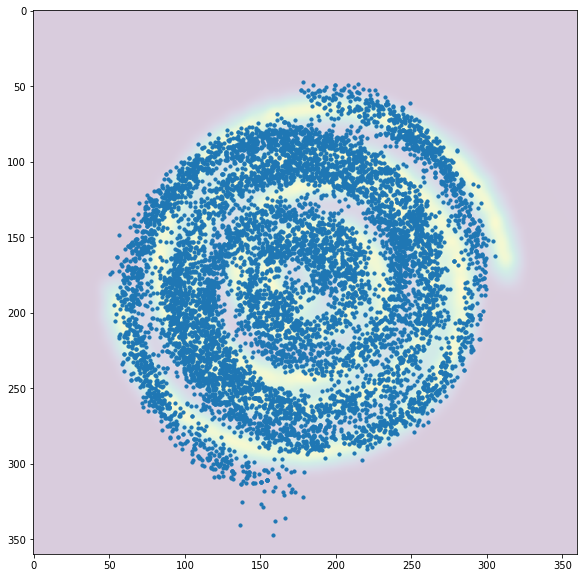

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 20
epsilon = 0.7

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)
init_sample = sample_from_image_density(1, density, subkey).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/spiral_iter10000_k20_e07.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

  0%|          | 41/10000 [01:00<3:55:52,  1.42s/it]

Metropolis- Hastings REJECT 1.0618364 1.1964085


  1%|          | 90/10000 [02:08<3:49:28,  1.39s/it]

Metropolis- Hastings REJECT 1.044967 1.3405745


  1%|          | 106/10000 [02:30<3:49:20,  1.39s/it]

Metropolis- Hastings REJECT 0.94604313 1.4424859


  1%|          | 107/10000 [02:31<3:51:42,  1.41s/it]

Metropolis- Hastings REJECT 0.94604313 1.0735176


  1%|          | 113/10000 [02:39<3:50:16,  1.40s/it]

Metropolis- Hastings REJECT 1.5052865 2.3579261


  1%|          | 121/10000 [02:50<3:52:09,  1.41s/it]

Metropolis- Hastings REJECT 1.6661942 2.4209404


  1%|▏         | 125/10000 [02:56<3:50:33,  1.40s/it]

Metropolis- Hastings REJECT 1.5051628 2.2947028


  1%|▏         | 130/10000 [03:03<3:49:51,  1.40s/it]

Metropolis- Hastings REJECT 1.3808438 2.417667


  2%|▏         | 215/10000 [04:59<3:43:41,  1.37s/it]

Metropolis- Hastings REJECT 1.2463704 2.0958827


  2%|▏         | 222/10000 [05:09<3:48:11,  1.40s/it]

Metropolis- Hastings REJECT 1.5687206 1.8225


  3%|▎         | 277/10000 [06:25<3:52:11,  1.43s/it]

Metropolis- Hastings REJECT 1.80603 2.2905445


  3%|▎         | 286/10000 [06:38<3:56:07,  1.46s/it]

Metropolis- Hastings REJECT 1.4658598 1.8040705


  3%|▎         | 306/10000 [07:07<4:05:36,  1.52s/it]

Metropolis- Hastings REJECT 1.1415576 1.2257433


  4%|▎         | 361/10000 [08:29<3:58:05,  1.48s/it]

Metropolis- Hastings REJECT 0.9436006 1.1198363


  4%|▍         | 378/10000 [08:54<3:55:02,  1.47s/it]

Metropolis- Hastings REJECT 1.0007269 1.1689768


  4%|▍         | 379/10000 [08:55<4:02:54,  1.51s/it]

Metropolis- Hastings REJECT 1.0007269 1.2349147


  4%|▍         | 395/10000 [09:19<3:57:11,  1.48s/it]

Metropolis- Hastings REJECT 1.0173494 1.4860007


  4%|▍         | 401/10000 [09:27<3:55:16,  1.47s/it]

Metropolis- Hastings REJECT 1.107935 1.7020864


  4%|▍         | 407/10000 [09:36<3:58:53,  1.49s/it]

Metropolis- Hastings REJECT 0.94391775 1.0090607


  4%|▍         | 448/10000 [10:36<3:57:33,  1.49s/it]

Metropolis- Hastings REJECT 1.4254148 1.5048732


  5%|▍         | 475/10000 [11:16<4:00:08,  1.51s/it]

Metropolis- Hastings REJECT 1.0828393 1.3809646


  5%|▌         | 534/10000 [12:41<3:52:03,  1.47s/it]

Metropolis- Hastings REJECT 1.1968546 1.3737901


  5%|▌         | 541/10000 [12:52<3:59:06,  1.52s/it]

Metropolis- Hastings REJECT 1.3441172 2.3873224


  6%|▌         | 553/10000 [13:10<3:58:10,  1.51s/it]

Metropolis- Hastings REJECT 1.0640478 1.7716879


  6%|▌         | 562/10000 [13:24<4:04:01,  1.55s/it]

Metropolis- Hastings REJECT 0.97681 1.0334526


  6%|▌         | 566/10000 [13:30<4:03:37,  1.55s/it]

Metropolis- Hastings REJECT 0.9664593 1.1948905


  6%|▌         | 586/10000 [14:00<3:53:41,  1.49s/it]

Metropolis- Hastings REJECT 1.2213241 1.6805099


  6%|▌         | 612/10000 [14:38<3:51:57,  1.48s/it]

Metropolis- Hastings REJECT 1.0407795 1.0732248


  7%|▋         | 653/10000 [15:38<3:53:52,  1.50s/it]

Metropolis- Hastings REJECT 1.0469944 1.1188866


  7%|▋         | 693/10000 [16:36<3:48:03,  1.47s/it]

Metropolis- Hastings REJECT 1.1052444 1.305443


  7%|▋         | 703/10000 [16:51<3:49:54,  1.48s/it]

Metropolis- Hastings REJECT 1.3388898 1.9366423


  7%|▋         | 716/10000 [17:11<3:51:06,  1.49s/it]

Metropolis- Hastings REJECT 0.94305956 1.3252325


  7%|▋         | 730/10000 [17:30<3:44:10,  1.45s/it]

Metropolis- Hastings REJECT 1.1085325 1.460174


  8%|▊         | 760/10000 [18:14<3:46:48,  1.47s/it]

Metropolis- Hastings REJECT 1.043854 1.1187893


  8%|▊         | 795/10000 [19:06<3:50:48,  1.50s/it]

Metropolis- Hastings REJECT 1.0272856 1.1276745


  8%|▊         | 797/10000 [19:08<3:46:29,  1.48s/it]

Metropolis- Hastings REJECT 1.1610956 1.2811043


  8%|▊         | 807/10000 [19:23<3:42:39,  1.45s/it]

Metropolis- Hastings REJECT 1.1879271 1.2688391


  8%|▊         | 808/10000 [19:25<3:49:19,  1.50s/it]

Metropolis- Hastings REJECT 1.1879271 1.2884148


  9%|▊         | 869/10000 [20:53<3:44:59,  1.48s/it]

Metropolis- Hastings REJECT 0.91979146 1.1612607


  9%|▉         | 896/10000 [21:32<3:40:00,  1.45s/it]

Metropolis- Hastings REJECT 0.9750986 1.1015785


  9%|▉         | 900/10000 [21:38<3:40:45,  1.46s/it]

Metropolis- Hastings REJECT 1.610107 1.7140796


  9%|▉         | 922/10000 [22:10<3:49:31,  1.52s/it]

Metropolis- Hastings REJECT 1.0531979 1.2979081


  9%|▉         | 949/10000 [22:49<3:42:10,  1.47s/it]

Metropolis- Hastings REJECT 0.9632088 1.3907435


 10%|█         | 1009/10000 [24:15<3:38:15,  1.46s/it]

Metropolis- Hastings REJECT 1.27941 1.4036424


 10%|█         | 1035/10000 [24:53<3:40:31,  1.48s/it]

Metropolis- Hastings REJECT 1.2199874 1.5791659


 10%|█         | 1041/10000 [25:01<3:33:45,  1.43s/it]

Metropolis- Hastings REJECT 0.98988533 1.1432881


 11%|█         | 1067/10000 [25:38<3:38:07,  1.47s/it]

Metropolis- Hastings REJECT 1.0241666 1.1525195


 11%|█         | 1073/10000 [25:47<3:33:17,  1.43s/it]

Metropolis- Hastings REJECT 1.2543427 1.8246951


 11%|█         | 1114/10000 [26:45<3:31:48,  1.43s/it]

Metropolis- Hastings REJECT 1.1576306 1.2493284


 11%|█▏        | 1132/10000 [27:10<3:35:14,  1.46s/it]

Metropolis- Hastings REJECT 1.6279656 1.7342274


 12%|█▏        | 1182/10000 [28:22<3:35:33,  1.47s/it]

Metropolis- Hastings REJECT 1.0268697 1.1271863


 12%|█▏        | 1209/10000 [29:00<3:33:33,  1.46s/it]

Metropolis- Hastings REJECT 0.9816508 1.1730759


 12%|█▏        | 1241/10000 [29:46<3:36:38,  1.48s/it]

Metropolis- Hastings REJECT 1.2532014 1.459632


 13%|█▎        | 1265/10000 [30:20<3:26:19,  1.42s/it]

Metropolis- Hastings REJECT 0.95680606 1.0004776


 13%|█▎        | 1298/10000 [31:08<3:29:14,  1.44s/it]

Metropolis- Hastings REJECT 1.2806665 1.6272285


 13%|█▎        | 1303/10000 [31:15<3:30:38,  1.45s/it]

Metropolis- Hastings REJECT 0.98253655 1.1044312


 13%|█▎        | 1318/10000 [31:36<3:33:01,  1.47s/it]

Metropolis- Hastings REJECT 0.9563929 1.0665526


 13%|█▎        | 1322/10000 [31:42<3:33:40,  1.48s/it]

Metropolis- Hastings REJECT 0.91441965 0.98750603


 13%|█▎        | 1324/10000 [31:45<3:35:22,  1.49s/it]

Metropolis- Hastings REJECT 0.9397384 0.96621263


 13%|█▎        | 1338/10000 [32:05<3:36:02,  1.50s/it]

Metropolis- Hastings REJECT 0.9585285 1.2504132


 14%|█▍        | 1380/10000 [33:06<3:32:20,  1.48s/it]

Metropolis- Hastings REJECT 1.0741746 1.1838387


 14%|█▍        | 1403/10000 [33:40<3:37:58,  1.52s/it]

Metropolis- Hastings REJECT 1.2286861 1.4986305


 14%|█▍        | 1418/10000 [34:02<3:32:12,  1.48s/it]

Metropolis- Hastings REJECT 1.01704 1.1965293


 15%|█▍        | 1453/10000 [34:54<3:26:24,  1.45s/it]

Metropolis- Hastings REJECT 1.5107819 1.5598654


 15%|█▍        | 1472/10000 [35:22<3:32:51,  1.50s/it]

Metropolis- Hastings REJECT 1.0060347 1.1375641


 15%|█▍        | 1479/10000 [35:33<3:27:35,  1.46s/it]

Metropolis- Hastings REJECT 1.2528639 1.3595703


 15%|█▍        | 1483/10000 [35:38<3:30:35,  1.48s/it]

Metropolis- Hastings REJECT 1.4039742 1.5873603


 15%|█▍        | 1490/10000 [35:49<3:32:57,  1.50s/it]

Metropolis- Hastings REJECT 1.360875 1.5305629


 15%|█▌        | 1518/10000 [36:30<3:29:26,  1.48s/it]

Metropolis- Hastings REJECT 1.1377106 1.442877


 15%|█▌        | 1520/10000 [36:32<3:30:08,  1.49s/it]

Metropolis- Hastings REJECT 1.2703453 1.5193127


 15%|█▌        | 1542/10000 [37:05<3:36:09,  1.53s/it]

Metropolis- Hastings REJECT 1.0093422 1.1245763


 16%|█▌        | 1557/10000 [37:27<3:32:30,  1.51s/it]

Metropolis- Hastings REJECT 1.2396536 1.4818811


 16%|█▌        | 1563/10000 [37:36<3:27:15,  1.47s/it]

Metropolis- Hastings REJECT 1.033063 1.0977829


 16%|█▌        | 1565/10000 [37:39<3:27:22,  1.48s/it]

Metropolis- Hastings REJECT 1.004519 1.0755821


 16%|█▌        | 1577/10000 [37:57<3:27:03,  1.47s/it]

Metropolis- Hastings REJECT 1.0233791 1.2710686


 16%|█▌        | 1611/10000 [38:46<3:25:27,  1.47s/it]

Metropolis- Hastings REJECT 1.1465293 1.413529


 16%|█▋        | 1636/10000 [39:22<3:25:16,  1.47s/it]

Metropolis- Hastings REJECT 1.0951785 1.7008314


 16%|█▋        | 1644/10000 [39:34<3:26:49,  1.49s/it]

Metropolis- Hastings REJECT 1.8155817 1.8289932


 17%|█▋        | 1670/10000 [40:10<3:18:12,  1.43s/it]

Metropolis- Hastings REJECT 1.1642891 1.3202262


 17%|█▋        | 1693/10000 [40:43<3:18:02,  1.43s/it]

Metropolis- Hastings REJECT 1.0223682 1.3125993


 17%|█▋        | 1695/10000 [40:46<3:20:40,  1.45s/it]

Metropolis- Hastings REJECT 0.9830894 1.3067048


 17%|█▋        | 1702/10000 [40:56<3:16:35,  1.42s/it]

Metropolis- Hastings REJECT 1.0127112 1.2710756


 17%|█▋        | 1704/10000 [40:59<3:23:57,  1.48s/it]

Metropolis- Hastings REJECT 1.0162343 1.1945388


 18%|█▊        | 1754/10000 [42:09<3:17:32,  1.44s/it]

Metropolis- Hastings REJECT 1.4852501 2.048941


 18%|█▊        | 1758/10000 [42:15<3:18:19,  1.44s/it]

Metropolis- Hastings REJECT 1.5129651 1.8626066


 18%|█▊        | 1762/10000 [42:21<3:19:20,  1.45s/it]

Metropolis- Hastings REJECT 1.4220023 1.5985079


 18%|█▊        | 1769/10000 [42:31<3:19:59,  1.46s/it]

Metropolis- Hastings REJECT 0.97939646 1.2821437


 18%|█▊        | 1792/10000 [43:02<3:10:06,  1.39s/it]

Metropolis- Hastings REJECT 1.1303552 1.6757541


 18%|█▊        | 1802/10000 [43:17<3:14:08,  1.42s/it]

Metropolis- Hastings REJECT 0.98885196 1.068959


 18%|█▊        | 1844/10000 [44:15<3:11:31,  1.41s/it]

Metropolis- Hastings REJECT 0.98305124 1.3438506


 19%|█▊        | 1869/10000 [44:50<3:12:47,  1.42s/it]

Metropolis- Hastings REJECT 1.0340157 1.0981379


 19%|█▉        | 1906/10000 [45:42<3:14:28,  1.44s/it]

Metropolis- Hastings REJECT 1.1014526 1.3094349


 19%|█▉        | 1908/10000 [45:45<3:16:09,  1.45s/it]

Metropolis- Hastings REJECT 1.2347829 1.6021037


 20%|█▉        | 1971/10000 [47:15<3:13:05,  1.44s/it]

Metropolis- Hastings REJECT 0.94642943 1.0243059


 20%|█▉        | 1976/10000 [47:22<3:10:13,  1.42s/it]

Metropolis- Hastings REJECT 0.9682027 1.0866702


 20%|█▉        | 1992/10000 [47:44<3:09:07,  1.42s/it]

Metropolis- Hastings REJECT 2.138596 2.4455404


 20%|██        | 2024/10000 [48:29<3:06:11,  1.40s/it]

Metropolis- Hastings REJECT 1.103368 1.1517591


 20%|██        | 2034/10000 [48:43<3:07:06,  1.41s/it]

Metropolis- Hastings REJECT 1.269001 1.6564727


 20%|██        | 2049/10000 [49:04<3:09:51,  1.43s/it]

Metropolis- Hastings REJECT 0.94159704 0.9932482


 21%|██        | 2055/10000 [49:13<3:07:24,  1.42s/it]

Metropolis- Hastings REJECT 0.98622847 1.0757064


 21%|██        | 2117/10000 [50:39<3:03:00,  1.39s/it]

Metropolis- Hastings REJECT 1.0730101 1.1784092


 21%|██▏       | 2129/10000 [50:56<3:05:50,  1.42s/it]

Metropolis- Hastings REJECT 1.1164261 1.3533385


 21%|██▏       | 2141/10000 [51:13<3:09:22,  1.45s/it]

Metropolis- Hastings REJECT 1.4922919 1.7836554


 22%|██▏       | 2195/10000 [52:30<3:16:57,  1.51s/it]

Metropolis- Hastings REJECT 1.336289 1.6171784


 22%|██▏       | 2202/10000 [52:40<3:06:36,  1.44s/it]

Metropolis- Hastings REJECT 1.0870222 1.415586


 22%|██▏       | 2204/10000 [52:43<3:09:20,  1.46s/it]

Metropolis- Hastings REJECT 1.0997272 1.473524


 22%|██▏       | 2205/10000 [52:44<3:11:11,  1.47s/it]

Metropolis- Hastings REJECT 1.0997272 1.5912132


 22%|██▏       | 2207/10000 [52:47<3:09:25,  1.46s/it]

Metropolis- Hastings REJECT 1.0963647 1.7788268


 22%|██▏       | 2231/10000 [53:21<3:05:29,  1.43s/it]

Metropolis- Hastings REJECT 1.1624907 1.2475734


 22%|██▏       | 2234/10000 [53:26<3:06:49,  1.44s/it]

Metropolis- Hastings REJECT 1.0720947 1.2282674


 22%|██▏       | 2241/10000 [53:36<3:03:40,  1.42s/it]

Metropolis- Hastings REJECT 1.320517 1.8590304


 22%|██▏       | 2246/10000 [53:43<3:04:44,  1.43s/it]

Metropolis- Hastings REJECT 0.9681459 1.3545159


 23%|██▎       | 2279/10000 [54:30<3:07:42,  1.46s/it]

Metropolis- Hastings REJECT 1.1229777 1.2275231


 23%|██▎       | 2338/10000 [55:55<3:06:59,  1.46s/it]

Metropolis- Hastings REJECT 0.9204942 0.9557163


 23%|██▎       | 2346/10000 [56:06<3:10:15,  1.49s/it]

Metropolis- Hastings REJECT 0.9477148 1.1106582


 24%|██▍       | 2378/10000 [56:53<3:07:33,  1.48s/it]

Metropolis- Hastings REJECT 1.0200939 1.064326


 24%|██▍       | 2442/10000 [58:26<3:09:44,  1.51s/it]

Metropolis- Hastings REJECT 0.98187673 1.1107539


 25%|██▍       | 2494/10000 [59:41<3:02:30,  1.46s/it]

Metropolis- Hastings REJECT 1.021892 1.1572498


 25%|██▍       | 2495/10000 [59:43<3:02:40,  1.46s/it]

Metropolis- Hastings REJECT 1.021892 1.0567982


 25%|██▌       | 2505/10000 [59:57<3:02:20,  1.46s/it]

Metropolis- Hastings REJECT 1.5426877 1.6888087


 25%|██▌       | 2531/10000 [1:00:35<2:59:59,  1.45s/it]

Metropolis- Hastings REJECT 1.1144028 2.1234643


 25%|██▌       | 2549/10000 [1:01:00<2:58:14,  1.44s/it]

Metropolis- Hastings REJECT 1.0999234 1.1910907


 26%|██▌       | 2577/10000 [1:01:40<2:57:20,  1.43s/it]

Metropolis- Hastings REJECT 0.9630853 1.1142387


 26%|██▌       | 2584/10000 [1:01:50<2:58:45,  1.45s/it]

Metropolis- Hastings REJECT 0.98832595 1.2994695


 26%|██▌       | 2589/10000 [1:01:57<3:00:23,  1.46s/it]

Metropolis- Hastings REJECT 1.5812559 2.141683


 26%|██▌       | 2590/10000 [1:01:58<3:00:49,  1.46s/it]

Metropolis- Hastings REJECT 1.5812559 2.3279245


 26%|██▌       | 2597/10000 [1:02:08<2:56:53,  1.43s/it]

Metropolis- Hastings REJECT 0.95475876 1.7143663


 26%|██▌       | 2602/10000 [1:02:15<2:54:51,  1.42s/it]

Metropolis- Hastings REJECT 1.4278159 2.7441347


 26%|██▌       | 2610/10000 [1:02:27<3:02:16,  1.48s/it]

Metropolis- Hastings REJECT 1.8960944 3.2253528


 26%|██▋       | 2644/10000 [1:03:16<2:57:12,  1.45s/it]

Metropolis- Hastings REJECT 0.9944788 1.0271595


 26%|██▋       | 2646/10000 [1:03:19<2:58:36,  1.46s/it]

Metropolis- Hastings REJECT 1.0116009 1.787447


 27%|██▋       | 2662/10000 [1:03:41<2:55:05,  1.43s/it]

Metropolis- Hastings REJECT 1.405322 2.123615


 27%|██▋       | 2664/10000 [1:03:44<2:58:57,  1.46s/it]

Metropolis- Hastings REJECT 1.29532 1.5655086


 27%|██▋       | 2669/10000 [1:03:51<2:56:51,  1.45s/it]

Metropolis- Hastings REJECT 1.2171142 1.6648415


 27%|██▋       | 2687/10000 [1:04:17<2:58:51,  1.47s/it]

Metropolis- Hastings REJECT 1.1616902 1.9683465


 27%|██▋       | 2714/10000 [1:04:55<2:58:00,  1.47s/it]

Metropolis- Hastings REJECT 1.0101907 1.0468911


 27%|██▋       | 2719/10000 [1:05:03<2:59:14,  1.48s/it]

Metropolis- Hastings REJECT 1.5309867 1.6480248


 27%|██▋       | 2726/10000 [1:05:13<2:57:25,  1.46s/it]

Metropolis- Hastings REJECT 1.2055604 1.370966


 27%|██▋       | 2738/10000 [1:05:30<2:59:57,  1.49s/it]

Metropolis- Hastings REJECT 1.8454797 2.2707076


 28%|██▊       | 2796/10000 [1:06:54<3:00:52,  1.51s/it]

Metropolis- Hastings REJECT 1.3350716 1.9093786


 28%|██▊       | 2799/10000 [1:06:58<3:01:02,  1.51s/it]

Metropolis- Hastings REJECT 1.3895588 2.639951


 28%|██▊       | 2847/10000 [1:08:11<2:57:04,  1.49s/it]

Metropolis- Hastings REJECT 2.7462873 3.4618933


 29%|██▊       | 2853/10000 [1:08:20<2:55:08,  1.47s/it]

Metropolis- Hastings REJECT 1.1464579 1.5897692


 29%|██▊       | 2863/10000 [1:08:35<3:00:23,  1.52s/it]

Metropolis- Hastings REJECT 1.1686938 1.4192001


 29%|██▉       | 2877/10000 [1:08:56<3:01:48,  1.53s/it]

Metropolis- Hastings REJECT 0.9871248 1.5032634


 29%|██▉       | 2897/10000 [1:09:25<2:57:50,  1.50s/it]

Metropolis- Hastings REJECT 1.0877717 1.387612


 29%|██▉       | 2939/10000 [1:10:27<2:58:16,  1.51s/it]

Metropolis- Hastings REJECT 1.1712936 1.3712821


 30%|██▉       | 2969/10000 [1:11:12<2:55:30,  1.50s/it]

Metropolis- Hastings REJECT 1.06773 1.4338609


 30%|██▉       | 2992/10000 [1:11:46<2:56:55,  1.51s/it]

Metropolis- Hastings REJECT 1.304981 1.6766989


 30%|███       | 3004/10000 [1:12:04<2:54:20,  1.50s/it]

Metropolis- Hastings REJECT 0.94456077 1.2212584


 30%|███       | 3018/10000 [1:12:25<2:59:02,  1.54s/it]

Metropolis- Hastings REJECT 0.9452471 1.0009979


 30%|███       | 3050/10000 [1:13:12<2:51:03,  1.48s/it]

Metropolis- Hastings REJECT 0.9975544 1.0282748


 31%|███       | 3071/10000 [1:13:42<2:46:53,  1.45s/it]

Metropolis- Hastings REJECT 1.2260863 1.2866491


 31%|███       | 3075/10000 [1:13:48<2:48:51,  1.46s/it]

Metropolis- Hastings REJECT 1.2245646 1.2441616


 32%|███▏      | 3152/10000 [1:15:39<2:48:28,  1.48s/it]

Metropolis- Hastings REJECT 1.253837 1.5276309


 32%|███▏      | 3176/10000 [1:16:14<2:44:49,  1.45s/it]

Metropolis- Hastings REJECT 1.398625 1.9384391


 32%|███▏      | 3178/10000 [1:16:16<2:46:11,  1.46s/it]

Metropolis- Hastings REJECT 1.2433887 1.5438555


 33%|███▎      | 3268/10000 [1:18:27<2:40:34,  1.43s/it]

Metropolis- Hastings REJECT 1.0729245 1.0848217


 33%|███▎      | 3322/10000 [1:19:44<2:41:26,  1.45s/it]

Metropolis- Hastings REJECT 0.9979056 1.0517402


 33%|███▎      | 3326/10000 [1:19:50<2:40:59,  1.45s/it]

Metropolis- Hastings REJECT 0.98175645 1.3271211


 33%|███▎      | 3338/10000 [1:20:07<2:42:31,  1.46s/it]

Metropolis- Hastings REJECT 1.2045481 1.6544777


 34%|███▎      | 3350/10000 [1:20:24<2:41:56,  1.46s/it]

Metropolis- Hastings REJECT 1.040006 1.1406583


 34%|███▎      | 3356/10000 [1:20:33<2:39:55,  1.44s/it]

Metropolis- Hastings REJECT 1.0134054 1.1469945


 34%|███▎      | 3372/10000 [1:20:56<2:47:20,  1.51s/it]

Metropolis- Hastings REJECT 1.0732365 1.1542672


 34%|███▍      | 3414/10000 [1:21:56<2:41:09,  1.47s/it]

Metropolis- Hastings REJECT 1.0655235 1.0806322


 34%|███▍      | 3424/10000 [1:22:11<2:39:36,  1.46s/it]

Metropolis- Hastings REJECT 1.122226 1.2040763


 34%|███▍      | 3447/10000 [1:22:45<2:46:13,  1.52s/it]

Metropolis- Hastings REJECT 1.1474711 1.4304188


 34%|███▍      | 3450/10000 [1:22:49<2:44:07,  1.50s/it]

Metropolis- Hastings REJECT 1.204484 1.7717522


 35%|███▍      | 3453/10000 [1:22:54<2:42:30,  1.49s/it]

Metropolis- Hastings REJECT 1.2680198 1.4724684


 35%|███▍      | 3495/10000 [1:23:56<2:43:56,  1.51s/it]

Metropolis- Hastings REJECT 1.1073602 1.2767287


 35%|███▍      | 3499/10000 [1:24:02<2:41:52,  1.49s/it]

Metropolis- Hastings REJECT 1.110329 1.4290648


 35%|███▌      | 3526/10000 [1:24:41<2:39:27,  1.48s/it]

Metropolis- Hastings REJECT 1.0031676 1.1296922


 35%|███▌      | 3532/10000 [1:24:50<2:38:08,  1.47s/it]

Metropolis- Hastings REJECT 1.0585833 1.1672418


 36%|███▌      | 3572/10000 [1:25:49<2:40:47,  1.50s/it]

Metropolis- Hastings REJECT 0.96674615 0.998677


 36%|███▋      | 3646/10000 [1:27:37<2:38:39,  1.50s/it]

Metropolis- Hastings REJECT 1.598153 1.973686


 36%|███▋      | 3647/10000 [1:27:38<2:39:08,  1.50s/it]

Metropolis- Hastings REJECT 1.598153 1.7888703


 36%|███▋      | 3648/10000 [1:27:40<2:43:44,  1.55s/it]

Metropolis- Hastings REJECT 1.598153 2.4427526


 37%|███▋      | 3652/10000 [1:27:46<2:43:06,  1.54s/it]

Metropolis- Hastings REJECT 1.3055784 2.1101513


 37%|███▋      | 3654/10000 [1:27:49<2:46:04,  1.57s/it]

Metropolis- Hastings REJECT 1.0542812 1.1034455


 37%|███▋      | 3663/10000 [1:28:03<2:40:56,  1.52s/it]

Metropolis- Hastings REJECT 0.9460831 1.277928


 37%|███▋      | 3664/10000 [1:28:04<2:40:43,  1.52s/it]

Metropolis- Hastings REJECT 0.9460831 1.1202708


 37%|███▋      | 3684/10000 [1:28:33<2:34:57,  1.47s/it]

Metropolis- Hastings REJECT 1.992754 2.2357447


 37%|███▋      | 3688/10000 [1:28:39<2:33:50,  1.46s/it]

Metropolis- Hastings REJECT 1.0156314 2.0519698


 37%|███▋      | 3704/10000 [1:29:02<2:31:51,  1.45s/it]

Metropolis- Hastings REJECT 1.0394399 1.1480885


 37%|███▋      | 3706/10000 [1:29:05<2:33:21,  1.46s/it]

Metropolis- Hastings REJECT 1.0022376 1.0274365


 38%|███▊      | 3755/10000 [1:30:16<2:33:18,  1.47s/it]

Metropolis- Hastings REJECT 1.4919503 1.6663139


 38%|███▊      | 3756/10000 [1:30:17<2:33:52,  1.48s/it]

Metropolis- Hastings REJECT 1.4919503 1.8326496


 38%|███▊      | 3805/10000 [1:31:28<2:32:20,  1.48s/it]

Metropolis- Hastings REJECT 1.0077909 1.0960759


 38%|███▊      | 3821/10000 [1:31:51<2:28:21,  1.44s/it]

Metropolis- Hastings REJECT 0.9825739 1.2566772


 38%|███▊      | 3834/10000 [1:32:10<2:33:00,  1.49s/it]

Metropolis- Hastings REJECT 1.1227846 1.3570606


 38%|███▊      | 3848/10000 [1:32:30<2:27:27,  1.44s/it]

Metropolis- Hastings REJECT 0.9845246 1.1810932


 39%|███▊      | 3852/10000 [1:32:36<2:32:05,  1.48s/it]

Metropolis- Hastings REJECT 1.0153697 1.02755


 39%|███▉      | 3900/10000 [1:33:44<2:28:45,  1.46s/it]

Metropolis- Hastings REJECT 0.99115247 2.0997684


 39%|███▉      | 3912/10000 [1:34:02<2:25:33,  1.43s/it]

Metropolis- Hastings REJECT 1.8337014 2.57052


 39%|███▉      | 3939/10000 [1:34:41<2:27:24,  1.46s/it]

Metropolis- Hastings REJECT 1.0491688 1.2071698


 39%|███▉      | 3948/10000 [1:34:54<2:30:43,  1.49s/it]

Metropolis- Hastings REJECT 1.1634125 1.6255352


 40%|████      | 4018/10000 [1:36:39<2:30:15,  1.51s/it]

Metropolis- Hastings REJECT 1.0637825 1.2104771


 41%|████      | 4062/10000 [1:37:44<2:28:52,  1.50s/it]

Metropolis- Hastings REJECT 1.0967356 1.3738575


 41%|████      | 4071/10000 [1:37:58<2:26:38,  1.48s/it]

Metropolis- Hastings REJECT 1.0785947 1.3933511


 41%|████      | 4111/10000 [1:38:56<2:26:07,  1.49s/it]

Metropolis- Hastings REJECT 1.1974901 1.3376921


 41%|████▏     | 4127/10000 [1:39:19<2:27:25,  1.51s/it]

Metropolis- Hastings REJECT 2.2002153 3.0032728


 41%|████▏     | 4132/10000 [1:39:26<2:23:49,  1.47s/it]

Metropolis- Hastings REJECT 1.52405 1.7337707


 41%|████▏     | 4137/10000 [1:39:34<2:27:08,  1.51s/it]

Metropolis- Hastings REJECT 1.0148683 1.0749762


 41%|████▏     | 4146/10000 [1:39:47<2:28:13,  1.52s/it]

Metropolis- Hastings REJECT 1.0303226 1.4779385


 42%|████▏     | 4155/10000 [1:40:01<2:24:12,  1.48s/it]

Metropolis- Hastings REJECT 1.0050021 1.2733532


 42%|████▏     | 4161/10000 [1:40:10<2:28:46,  1.53s/it]

Metropolis- Hastings REJECT 1.4742156 1.6813943


 42%|████▏     | 4169/10000 [1:40:22<2:28:26,  1.53s/it]

Metropolis- Hastings REJECT 1.0497984 1.2516521


 42%|████▏     | 4174/10000 [1:40:29<2:27:49,  1.52s/it]

Metropolis- Hastings REJECT 1.2070942 1.4895996


 42%|████▏     | 4196/10000 [1:41:01<2:22:55,  1.48s/it]

Metropolis- Hastings REJECT 1.1533504 1.5728766


 42%|████▏     | 4198/10000 [1:41:04<2:25:42,  1.51s/it]

Metropolis- Hastings REJECT 1.0621407 1.275436


 42%|████▏     | 4213/10000 [1:41:26<2:22:05,  1.47s/it]

Metropolis- Hastings REJECT 1.5448649 1.6609764


 42%|████▏     | 4238/10000 [1:42:03<2:22:32,  1.48s/it]

Metropolis- Hastings REJECT 1.292406 1.6240723


 43%|████▎     | 4260/10000 [1:42:34<2:18:29,  1.45s/it]

Metropolis- Hastings REJECT 1.0702236 1.2889479


 43%|████▎     | 4300/10000 [1:43:31<2:16:32,  1.44s/it]

Metropolis- Hastings REJECT 1.2692862 1.3872335


 43%|████▎     | 4305/10000 [1:43:39<2:17:12,  1.45s/it]

Metropolis- Hastings REJECT 1.0282189 1.1793847


 43%|████▎     | 4317/10000 [1:43:56<2:16:22,  1.44s/it]

Metropolis- Hastings REJECT 1.2586807 1.550995


 43%|████▎     | 4329/10000 [1:44:13<2:17:50,  1.46s/it]

Metropolis- Hastings REJECT 1.5003903 1.558853


 43%|████▎     | 4340/10000 [1:44:29<2:17:05,  1.45s/it]

Metropolis- Hastings REJECT 1.3422624 1.529028


 43%|████▎     | 4348/10000 [1:44:41<2:18:10,  1.47s/it]

Metropolis- Hastings REJECT 1.187856 1.1999605


 44%|████▎     | 4350/10000 [1:44:44<2:20:01,  1.49s/it]

Metropolis- Hastings REJECT 1.0260586 1.3255295


 44%|████▍     | 4388/10000 [1:45:38<2:19:47,  1.49s/it]

Metropolis- Hastings REJECT 1.0861225 1.204617


 44%|████▍     | 4400/10000 [1:45:56<2:15:40,  1.45s/it]

Metropolis- Hastings REJECT 1.0077013 1.1712699


 44%|████▍     | 4422/10000 [1:46:27<2:16:22,  1.47s/it]

Metropolis- Hastings REJECT 0.97451067 1.0447546


 44%|████▍     | 4434/10000 [1:46:45<2:21:26,  1.52s/it]

Metropolis- Hastings REJECT 1.2120355 1.8217324


 44%|████▍     | 4442/10000 [1:46:57<2:17:02,  1.48s/it]

Metropolis- Hastings REJECT 2.23748 2.6808114


 44%|████▍     | 4447/10000 [1:47:04<2:14:20,  1.45s/it]

Metropolis- Hastings REJECT 2.324107 3.5523658


 44%|████▍     | 4448/10000 [1:47:05<2:15:01,  1.46s/it]

Metropolis- Hastings REJECT 2.324107 2.9249408


 45%|████▍     | 4456/10000 [1:47:17<2:18:00,  1.49s/it]

Metropolis- Hastings REJECT 0.9700684 1.0425848


 45%|████▍     | 4457/10000 [1:47:19<2:20:04,  1.52s/it]

Metropolis- Hastings REJECT 0.9700684 1.0783668


 45%|████▍     | 4471/10000 [1:47:39<2:19:54,  1.52s/it]

Metropolis- Hastings REJECT 1.1094223 1.3334426


 45%|████▍     | 4481/10000 [1:47:54<2:14:39,  1.46s/it]

Metropolis- Hastings REJECT 1.5138059 1.7733569


 45%|████▍     | 4492/10000 [1:48:10<2:14:33,  1.47s/it]

Metropolis- Hastings REJECT 1.0983927 1.2817049


 45%|████▌     | 4501/10000 [1:48:23<2:17:47,  1.50s/it]

Metropolis- Hastings REJECT 1.0120299 1.032053


 45%|████▌     | 4514/10000 [1:48:42<2:18:01,  1.51s/it]

Metropolis- Hastings REJECT 1.0233259 1.3026152


 46%|████▌     | 4573/10000 [1:50:09<2:16:44,  1.51s/it]

Metropolis- Hastings REJECT 1.0295062 1.2804972


 46%|████▌     | 4578/10000 [1:50:17<2:16:13,  1.51s/it]

Metropolis- Hastings REJECT 0.9992207 1.5586436


 46%|████▌     | 4582/10000 [1:50:23<2:19:03,  1.54s/it]

Metropolis- Hastings REJECT 1.0100069 1.0847356


 46%|████▌     | 4583/10000 [1:50:24<2:17:31,  1.52s/it]

Metropolis- Hastings REJECT 1.0100069 1.1450844


 46%|████▌     | 4585/10000 [1:50:27<2:15:31,  1.50s/it]

Metropolis- Hastings REJECT 0.97848254 1.1178832


 46%|████▋     | 4630/10000 [1:51:33<2:12:25,  1.48s/it]

Metropolis- Hastings REJECT 1.0805222 1.4217563


 46%|████▋     | 4631/10000 [1:51:35<2:15:47,  1.52s/it]

Metropolis- Hastings REJECT 1.0805222 1.139359


 46%|████▋     | 4642/10000 [1:51:51<2:19:16,  1.56s/it]

Metropolis- Hastings REJECT 1.1077814 1.2866066


 46%|████▋     | 4649/10000 [1:52:02<2:15:06,  1.51s/it]

Metropolis- Hastings REJECT 1.0031904 1.3494008


 47%|████▋     | 4668/10000 [1:52:29<2:11:12,  1.48s/it]

Metropolis- Hastings REJECT 0.9641742 1.2703872


 47%|████▋     | 4672/10000 [1:52:35<2:14:18,  1.51s/it]

Metropolis- Hastings REJECT 1.0516584 1.4048104


 47%|████▋     | 4674/10000 [1:52:38<2:14:08,  1.51s/it]

Metropolis- Hastings REJECT 1.0130799 1.1244373


 47%|████▋     | 4681/10000 [1:52:49<2:08:41,  1.45s/it]

Metropolis- Hastings REJECT 1.0116627 1.3836743


 47%|████▋     | 4693/10000 [1:53:06<2:06:36,  1.43s/it]

Metropolis- Hastings REJECT 1.1991465 1.7736849


 47%|████▋     | 4711/10000 [1:53:32<2:07:13,  1.44s/it]

Metropolis- Hastings REJECT 1.0076764 1.0939684


 47%|████▋     | 4729/10000 [1:53:57<2:06:32,  1.44s/it]

Metropolis- Hastings REJECT 1.5189614 1.6810964


 47%|████▋     | 4741/10000 [1:54:15<2:11:47,  1.50s/it]

Metropolis- Hastings REJECT 1.0464122 1.3205663


 47%|████▋     | 4744/10000 [1:54:19<2:10:37,  1.49s/it]

Metropolis- Hastings REJECT 1.1168224 1.3237863


 47%|████▋     | 4746/10000 [1:54:22<2:10:46,  1.49s/it]

Metropolis- Hastings REJECT 1.0369371 1.3510423


 47%|████▋     | 4749/10000 [1:54:27<2:08:37,  1.47s/it]

Metropolis- Hastings REJECT 1.1931908 1.5225153


 48%|████▊     | 4751/10000 [1:54:30<2:10:47,  1.50s/it]

Metropolis- Hastings REJECT 1.1863693 1.3816743


 48%|████▊     | 4757/10000 [1:54:38<2:04:00,  1.42s/it]

Metropolis- Hastings REJECT 1.0502337 1.1306014


 48%|████▊     | 4773/10000 [1:55:01<2:06:17,  1.45s/it]

Metropolis- Hastings REJECT 0.9875153 1.0562859


 48%|████▊     | 4792/10000 [1:55:28<2:09:31,  1.49s/it]

Metropolis- Hastings REJECT 0.9934778 1.2738703


 48%|████▊     | 4805/10000 [1:55:47<2:03:30,  1.43s/it]

Metropolis- Hastings REJECT 0.98279816 1.1861968


 48%|████▊     | 4817/10000 [1:56:04<2:04:02,  1.44s/it]

Metropolis- Hastings REJECT 1.3533558 1.4640214


 48%|████▊     | 4832/10000 [1:56:25<2:07:15,  1.48s/it]

Metropolis- Hastings REJECT 1.1222548 1.4039422


 48%|████▊     | 4841/10000 [1:56:38<2:06:00,  1.47s/it]

Metropolis- Hastings REJECT 1.0493013 1.4328676


 48%|████▊     | 4845/10000 [1:56:44<2:07:58,  1.49s/it]

Metropolis- Hastings REJECT 1.3567536 1.5647296


 49%|████▊     | 4859/10000 [1:57:05<2:06:47,  1.48s/it]

Metropolis- Hastings REJECT 1.2977407 1.7057712


 49%|████▉     | 4887/10000 [1:57:46<2:03:52,  1.45s/it]

Metropolis- Hastings REJECT 1.0010594 1.2712661


 49%|████▉     | 4901/10000 [1:58:06<2:04:13,  1.46s/it]

Metropolis- Hastings REJECT 1.6244371 1.6605085


 49%|████▉     | 4912/10000 [1:58:22<2:05:01,  1.47s/it]

Metropolis- Hastings REJECT 1.4020871 1.6858976


 49%|████▉     | 4919/10000 [1:58:32<2:05:10,  1.48s/it]

Metropolis- Hastings REJECT 0.99211425 1.2655673


 49%|████▉     | 4931/10000 [1:58:49<2:02:04,  1.45s/it]

Metropolis- Hastings REJECT 1.4479054 1.6452167


 49%|████▉     | 4945/10000 [1:59:09<2:02:17,  1.45s/it]

Metropolis- Hastings REJECT 1.175053 1.569352


 50%|████▉     | 4950/10000 [1:59:17<2:05:57,  1.50s/it]

Metropolis- Hastings REJECT 1.2164965 1.4608306


 50%|████▉     | 4959/10000 [1:59:30<2:06:58,  1.51s/it]

Metropolis- Hastings REJECT 1.0244075 1.5482146


 50%|████▉     | 4961/10000 [1:59:33<2:07:40,  1.52s/it]

Metropolis- Hastings REJECT 1.3035218 1.8143411


 50%|████▉     | 4967/10000 [1:59:42<2:06:12,  1.50s/it]

Metropolis- Hastings REJECT 1.0891631 1.3032236


 50%|████▉     | 4978/10000 [1:59:59<2:05:20,  1.50s/it]

Metropolis- Hastings REJECT 0.9967964 1.1266336


 50%|████▉     | 4989/10000 [2:00:15<2:07:02,  1.52s/it]

Metropolis- Hastings REJECT 1.2704798 1.6923423


 50%|████▉     | 4998/10000 [2:00:28<2:04:00,  1.49s/it]

Metropolis- Hastings REJECT 1.4318802 1.7527423


 50%|█████     | 5011/10000 [2:00:47<2:02:24,  1.47s/it]

Metropolis- Hastings REJECT 1.1677024 1.4320219


 51%|█████     | 5064/10000 [2:02:04<2:02:35,  1.49s/it]

Metropolis- Hastings REJECT 1.3267606 1.4111887


 51%|█████     | 5066/10000 [2:02:07<2:01:41,  1.48s/it]

Metropolis- Hastings REJECT 1.2758607 1.5644139


 51%|█████     | 5071/10000 [2:02:14<1:59:57,  1.46s/it]

Metropolis- Hastings REJECT 1.6868057 2.3664184


 51%|█████     | 5073/10000 [2:02:17<2:00:15,  1.46s/it]

Metropolis- Hastings REJECT 1.7334707 2.1654706


 51%|█████     | 5097/10000 [2:02:52<2:00:41,  1.48s/it]

Metropolis- Hastings REJECT 1.4524778 2.2815633


 51%|█████     | 5101/10000 [2:02:58<2:00:05,  1.47s/it]

Metropolis- Hastings REJECT 1.9159567 2.661831


 52%|█████▏    | 5150/10000 [2:04:08<1:57:49,  1.46s/it]

Metropolis- Hastings REJECT 0.9451204 0.9637815


 52%|█████▏    | 5175/10000 [2:04:44<1:59:25,  1.49s/it]

Metropolis- Hastings REJECT 1.2099844 1.6650296


 52%|█████▏    | 5177/10000 [2:04:47<2:00:30,  1.50s/it]

Metropolis- Hastings REJECT 1.6214969 1.7464551


 52%|█████▏    | 5186/10000 [2:05:00<1:58:04,  1.47s/it]

Metropolis- Hastings REJECT 1.3824328 1.5034196


 52%|█████▏    | 5189/10000 [2:05:05<1:56:09,  1.45s/it]

Metropolis- Hastings REJECT 1.256685 1.4309559


 52%|█████▏    | 5194/10000 [2:05:12<1:54:13,  1.43s/it]

Metropolis- Hastings REJECT 1.0329669 1.1737373


 52%|█████▏    | 5200/10000 [2:05:20<1:56:37,  1.46s/it]

Metropolis- Hastings REJECT 1.2055372 1.5012717


 52%|█████▏    | 5203/10000 [2:05:25<1:57:44,  1.47s/it]

Metropolis- Hastings REJECT 1.0637102 1.2696774


 52%|█████▏    | 5245/10000 [2:06:25<1:56:16,  1.47s/it]

Metropolis- Hastings REJECT 1.0830368 1.2939445


 53%|█████▎    | 5253/10000 [2:06:37<1:54:03,  1.44s/it]

Metropolis- Hastings REJECT 0.97134423 1.1623564


 53%|█████▎    | 5257/10000 [2:06:43<1:54:18,  1.45s/it]

Metropolis- Hastings REJECT 1.1704801 1.5838968


 53%|█████▎    | 5267/10000 [2:06:57<1:56:58,  1.48s/it]

Metropolis- Hastings REJECT 1.1818686 1.6381613


 53%|█████▎    | 5279/10000 [2:07:14<1:52:44,  1.43s/it]

Metropolis- Hastings REJECT 1.1403126 1.4456706


 53%|█████▎    | 5281/10000 [2:07:17<1:56:38,  1.48s/it]

Metropolis- Hastings REJECT 1.085867 1.2989662


 53%|█████▎    | 5301/10000 [2:07:46<1:55:00,  1.47s/it]

Metropolis- Hastings REJECT 1.5094743 1.7453284


 53%|█████▎    | 5307/10000 [2:07:55<1:54:29,  1.46s/it]

Metropolis- Hastings REJECT 1.1851383 1.4298657


 53%|█████▎    | 5345/10000 [2:08:49<1:54:21,  1.47s/it]

Metropolis- Hastings REJECT 1.452325 1.5339373


 54%|█████▎    | 5356/10000 [2:09:05<1:52:07,  1.45s/it]

Metropolis- Hastings REJECT 1.340425 1.6933578


 54%|█████▎    | 5365/10000 [2:09:18<1:53:24,  1.47s/it]

Metropolis- Hastings REJECT 0.9833723 1.1350753


 54%|█████▎    | 5370/10000 [2:09:26<1:56:48,  1.51s/it]

Metropolis- Hastings REJECT 1.0864949 1.3403131


 54%|█████▍    | 5381/10000 [2:09:42<1:55:35,  1.50s/it]

Metropolis- Hastings REJECT 1.0184145 1.1421779


 54%|█████▍    | 5392/10000 [2:09:58<1:56:06,  1.51s/it]

Metropolis- Hastings REJECT 1.3343134 1.581688


 54%|█████▍    | 5414/10000 [2:10:30<1:52:15,  1.47s/it]

Metropolis- Hastings REJECT 1.3105087 1.6590159


 54%|█████▍    | 5416/10000 [2:10:33<1:53:51,  1.49s/it]

Metropolis- Hastings REJECT 1.3206773 1.6848518


 54%|█████▍    | 5422/10000 [2:10:42<1:50:00,  1.44s/it]

Metropolis- Hastings REJECT 1.2428855 1.4666026


 54%|█████▍    | 5434/10000 [2:10:59<1:52:20,  1.48s/it]

Metropolis- Hastings REJECT 1.5165946 1.6330396


 55%|█████▍    | 5454/10000 [2:11:28<1:51:58,  1.48s/it]

Metropolis- Hastings REJECT 1.6808908 1.9017618


 55%|█████▍    | 5456/10000 [2:11:31<1:51:01,  1.47s/it]

Metropolis- Hastings REJECT 1.39612 1.8852276


 55%|█████▍    | 5466/10000 [2:11:46<1:51:31,  1.48s/it]

Metropolis- Hastings REJECT 1.4793434 1.6228625


 55%|█████▍    | 5470/10000 [2:11:52<1:51:49,  1.48s/it]

Metropolis- Hastings REJECT 1.3363658 1.5458606


 55%|█████▍    | 5485/10000 [2:12:13<1:51:04,  1.48s/it]

Metropolis- Hastings REJECT 0.9588945 1.2418942


 55%|█████▌    | 5501/10000 [2:12:36<1:49:12,  1.46s/it]

Metropolis- Hastings REJECT 1.023695 1.1266685


 55%|█████▌    | 5513/10000 [2:12:54<1:51:31,  1.49s/it]

Metropolis- Hastings REJECT 1.2993057 2.1690276


 55%|█████▌    | 5540/10000 [2:13:33<1:48:51,  1.46s/it]

Metropolis- Hastings REJECT 2.0784078 2.2648225


 55%|█████▌    | 5549/10000 [2:13:46<1:49:17,  1.47s/it]

Metropolis- Hastings REJECT 0.9935405 1.1135888


 56%|█████▌    | 5571/10000 [2:14:17<1:45:58,  1.44s/it]

Metropolis- Hastings REJECT 1.0647967 1.2821304


 56%|█████▌    | 5588/10000 [2:14:42<1:47:48,  1.47s/it]

Metropolis- Hastings REJECT 0.9435182 1.0574242


 56%|█████▌    | 5601/10000 [2:15:01<1:48:59,  1.49s/it]

Metropolis- Hastings REJECT 0.9847508 1.1291225


 56%|█████▌    | 5611/10000 [2:15:15<1:46:23,  1.45s/it]

Metropolis- Hastings REJECT 1.5568967 1.9498417


 56%|█████▌    | 5612/10000 [2:15:16<1:47:45,  1.47s/it]

Metropolis- Hastings REJECT 1.5568967 2.0323675


 56%|█████▌    | 5624/10000 [2:15:33<1:43:49,  1.42s/it]

Metropolis- Hastings REJECT 1.0258613 1.201414


 56%|█████▋    | 5631/10000 [2:15:44<1:45:25,  1.45s/it]

Metropolis- Hastings REJECT 1.0474918 1.188099


 57%|█████▋    | 5661/10000 [2:16:27<1:43:28,  1.43s/it]

Metropolis- Hastings REJECT 1.2378249 1.3545154


 57%|█████▋    | 5687/10000 [2:17:04<1:46:39,  1.48s/it]

Metropolis- Hastings REJECT 2.1541107 2.3242927


 57%|█████▋    | 5694/10000 [2:17:14<1:47:23,  1.50s/it]

Metropolis- Hastings REJECT 1.4521013 1.8171475


 57%|█████▋    | 5697/10000 [2:17:19<1:46:00,  1.48s/it]

Metropolis- Hastings REJECT 1.1610513 2.0285583


 57%|█████▋    | 5700/10000 [2:17:23<1:45:57,  1.48s/it]

Metropolis- Hastings REJECT 1.1563737 1.383213


 57%|█████▋    | 5729/10000 [2:18:05<1:41:45,  1.43s/it]

Metropolis- Hastings REJECT 0.9726935 1.2046982


 58%|█████▊    | 5759/10000 [2:18:48<1:42:43,  1.45s/it]

Metropolis- Hastings REJECT 0.92218566 0.9409112


 58%|█████▊    | 5783/10000 [2:19:22<1:40:28,  1.43s/it]

Metropolis- Hastings REJECT 1.076812 1.1735203


 58%|█████▊    | 5803/10000 [2:19:51<1:44:36,  1.50s/it]

Metropolis- Hastings REJECT 1.0028526 1.0805056


 58%|█████▊    | 5806/10000 [2:19:56<1:45:16,  1.51s/it]

Metropolis- Hastings REJECT 0.97920537 1.1278162


 59%|█████▊    | 5859/10000 [2:21:12<1:40:20,  1.45s/it]

Metropolis- Hastings REJECT 1.1474264 1.2125633


 59%|█████▉    | 5890/10000 [2:21:56<1:39:40,  1.46s/it]

Metropolis- Hastings REJECT 0.94974023 0.9965182


 59%|█████▉    | 5892/10000 [2:21:59<1:41:24,  1.48s/it]

Metropolis- Hastings REJECT 1.081361 1.276059


 59%|█████▉    | 5895/10000 [2:22:03<1:43:41,  1.52s/it]

Metropolis- Hastings REJECT 1.1717322 1.2842381


 59%|█████▉    | 5901/10000 [2:22:12<1:41:45,  1.49s/it]

Metropolis- Hastings REJECT 1.0145319 1.0853293


 59%|█████▉    | 5907/10000 [2:22:21<1:39:10,  1.45s/it]

Metropolis- Hastings REJECT 1.1982774 1.4756233


 59%|█████▉    | 5908/10000 [2:22:23<1:41:00,  1.48s/it]

Metropolis- Hastings REJECT 1.1982774 1.4830904


 59%|█████▉    | 5922/10000 [2:22:43<1:39:51,  1.47s/it]

Metropolis- Hastings REJECT 1.0669272 1.2760687


 60%|█████▉    | 5952/10000 [2:23:26<1:38:09,  1.45s/it]

Metropolis- Hastings REJECT 2.0400064 2.1060126


 60%|█████▉    | 5954/10000 [2:23:29<1:40:54,  1.50s/it]

Metropolis- Hastings REJECT 1.6518211 2.1303158


 60%|█████▉    | 5966/10000 [2:23:47<1:39:27,  1.48s/it]

Metropolis- Hastings REJECT 1.6621377 2.1700537


 60%|█████▉    | 5971/10000 [2:23:54<1:37:07,  1.45s/it]

Metropolis- Hastings REJECT 1.3590361 1.7814344


 60%|█████▉    | 5972/10000 [2:23:56<1:40:40,  1.50s/it]

Metropolis- Hastings REJECT 1.3590361 1.9684255


 60%|█████▉    | 5976/10000 [2:24:01<1:38:25,  1.47s/it]

Metropolis- Hastings REJECT 1.2591653 1.4220256


 60%|█████▉    | 5979/10000 [2:24:06<1:39:12,  1.48s/it]

Metropolis- Hastings REJECT 1.5692742 2.0855842


 60%|█████▉    | 5994/10000 [2:24:27<1:37:33,  1.46s/it]

Metropolis- Hastings REJECT 1.0696845 1.2921778


 60%|██████    | 6013/10000 [2:24:55<1:38:01,  1.48s/it]

Metropolis- Hastings REJECT 1.0131924 1.3405255


 60%|██████    | 6038/10000 [2:25:31<1:38:46,  1.50s/it]

Metropolis- Hastings REJECT 0.9268968 1.0278735


 60%|██████    | 6047/10000 [2:25:44<1:37:45,  1.48s/it]

Metropolis- Hastings REJECT 1.2456762 1.2835766


 61%|██████    | 6094/10000 [2:26:53<1:34:56,  1.46s/it]

Metropolis- Hastings REJECT 1.1260285 1.3648922


 61%|██████    | 6116/10000 [2:27:25<1:35:29,  1.48s/it]

Metropolis- Hastings REJECT 1.2258428 1.2900053


 61%|██████▏   | 6127/10000 [2:27:41<1:37:53,  1.52s/it]

Metropolis- Hastings REJECT 1.0408006 1.1080545


 61%|██████▏   | 6131/10000 [2:27:47<1:35:56,  1.49s/it]

Metropolis- Hastings REJECT 0.96587145 1.0360293


 62%|██████▏   | 6204/10000 [2:29:34<1:34:37,  1.50s/it]

Metropolis- Hastings REJECT 1.0131905 1.1181337


 62%|██████▏   | 6209/10000 [2:29:42<1:36:13,  1.52s/it]

Metropolis- Hastings REJECT 1.0763445 1.2351108


 62%|██████▏   | 6216/10000 [2:29:52<1:35:07,  1.51s/it]

Metropolis- Hastings REJECT 1.3226757 1.3770903


 62%|██████▏   | 6222/10000 [2:30:01<1:33:57,  1.49s/it]

Metropolis- Hastings REJECT 1.0414662 1.1786968


 62%|██████▏   | 6225/10000 [2:30:06<1:36:21,  1.53s/it]

Metropolis- Hastings REJECT 1.0823452 1.1843045


 62%|██████▏   | 6228/10000 [2:30:10<1:35:37,  1.52s/it]

Metropolis- Hastings REJECT 1.1641595 1.2456356


 62%|██████▏   | 6241/10000 [2:30:29<1:34:28,  1.51s/it]

Metropolis- Hastings REJECT 1.05838 1.4240433


 63%|██████▎   | 6259/10000 [2:30:56<1:34:39,  1.52s/it]

Metropolis- Hastings REJECT 1.089811 1.2982298


 63%|██████▎   | 6290/10000 [2:31:41<1:32:18,  1.49s/it]

Metropolis- Hastings REJECT 0.9994035 1.6805719


 63%|██████▎   | 6308/10000 [2:32:07<1:30:18,  1.47s/it]

Metropolis- Hastings REJECT 1.4722563 1.6720471


 63%|██████▎   | 6313/10000 [2:32:14<1:32:19,  1.50s/it]

Metropolis- Hastings REJECT 1.2922719 1.8246169


 63%|██████▎   | 6330/10000 [2:32:39<1:32:08,  1.51s/it]

Metropolis- Hastings REJECT 1.0103393 1.428943


 63%|██████▎   | 6332/10000 [2:32:43<1:33:59,  1.54s/it]

Metropolis- Hastings REJECT 1.2359608 1.5008166


 63%|██████▎   | 6344/10000 [2:33:00<1:29:54,  1.48s/it]

Metropolis- Hastings REJECT 1.5178896 1.6496596


 64%|██████▎   | 6367/10000 [2:33:35<1:31:34,  1.51s/it]

Metropolis- Hastings REJECT 1.0729796 1.271019


 64%|██████▍   | 6377/10000 [2:33:49<1:27:34,  1.45s/it]

Metropolis- Hastings REJECT 1.2394128 1.4701544


 64%|██████▍   | 6390/10000 [2:34:08<1:30:38,  1.51s/it]

Metropolis- Hastings REJECT 1.1660942 1.527997


 64%|██████▍   | 6405/10000 [2:34:30<1:31:15,  1.52s/it]

Metropolis- Hastings REJECT 0.9704151 1.1532112


 64%|██████▍   | 6410/10000 [2:34:38<1:29:23,  1.49s/it]

Metropolis- Hastings REJECT 0.9959921 1.2407465


 64%|██████▍   | 6420/10000 [2:34:53<1:28:45,  1.49s/it]

Metropolis- Hastings REJECT 1.061649 1.1713265


 65%|██████▍   | 6456/10000 [2:35:45<1:28:48,  1.50s/it]

Metropolis- Hastings REJECT 1.7869576 2.0907855


 65%|██████▍   | 6480/10000 [2:36:20<1:24:22,  1.44s/it]

Metropolis- Hastings REJECT 1.0334316 1.1721113


 65%|██████▍   | 6489/10000 [2:36:33<1:26:27,  1.48s/it]

Metropolis- Hastings REJECT 1.037169 1.0980043


 65%|██████▍   | 6491/10000 [2:36:36<1:26:32,  1.48s/it]

Metropolis- Hastings REJECT 1.0012434 1.1201923


 65%|██████▍   | 6496/10000 [2:36:44<1:26:43,  1.49s/it]

Metropolis- Hastings REJECT 1.1693733 1.5061996


 65%|██████▌   | 6508/10000 [2:37:01<1:25:38,  1.47s/it]

Metropolis- Hastings REJECT 0.999321 1.3543366


 65%|██████▌   | 6519/10000 [2:37:17<1:26:29,  1.49s/it]

Metropolis- Hastings REJECT 1.5385342 1.6197422


 65%|██████▌   | 6537/10000 [2:37:43<1:24:32,  1.46s/it]

Metropolis- Hastings REJECT 1.7529621 2.0076146


 66%|██████▌   | 6563/10000 [2:38:21<1:23:37,  1.46s/it]

Metropolis- Hastings REJECT 0.9871474 1.0043585


 66%|██████▌   | 6573/10000 [2:38:36<1:22:47,  1.45s/it]

Metropolis- Hastings REJECT 0.9815581 1.2616621


 66%|██████▌   | 6580/10000 [2:38:46<1:24:57,  1.49s/it]

Metropolis- Hastings REJECT 1.3229645 1.7521347


 66%|██████▌   | 6607/10000 [2:39:25<1:23:50,  1.48s/it]

Metropolis- Hastings REJECT 1.174354 1.5405011


 66%|██████▌   | 6610/10000 [2:39:29<1:23:27,  1.48s/it]

Metropolis- Hastings REJECT 0.95744526 1.0246732


 66%|██████▌   | 6612/10000 [2:39:32<1:26:23,  1.53s/it]

Metropolis- Hastings REJECT 0.98341024 1.1165179


 66%|██████▋   | 6649/10000 [2:40:25<1:21:23,  1.46s/it]

Metropolis- Hastings REJECT 1.0741489 1.2087821


 67%|██████▋   | 6699/10000 [2:41:37<1:20:09,  1.46s/it]

Metropolis- Hastings REJECT 1.5282688 1.7056843


 67%|██████▋   | 6704/10000 [2:41:45<1:19:55,  1.45s/it]

Metropolis- Hastings REJECT 1.0799339 1.1854221


 67%|██████▋   | 6748/10000 [2:42:48<1:20:12,  1.48s/it]

Metropolis- Hastings REJECT 1.0142988 1.1723828


 68%|██████▊   | 6758/10000 [2:43:02<1:20:18,  1.49s/it]

Metropolis- Hastings REJECT 1.049068 1.4009517


 68%|██████▊   | 6779/10000 [2:43:33<1:17:38,  1.45s/it]

Metropolis- Hastings REJECT 1.2428844 1.4735534


 68%|██████▊   | 6825/10000 [2:44:39<1:17:46,  1.47s/it]

Metropolis- Hastings REJECT 1.1326158 2.2580078


 68%|██████▊   | 6827/10000 [2:44:42<1:18:42,  1.49s/it]

Metropolis- Hastings REJECT 0.98373044 1.0042355


 69%|██████▊   | 6851/10000 [2:45:17<1:16:27,  1.46s/it]

Metropolis- Hastings REJECT 0.9505608 1.1058552


 69%|██████▊   | 6857/10000 [2:45:25<1:15:18,  1.44s/it]

Metropolis- Hastings REJECT 1.0498352 1.1275921


 69%|██████▊   | 6864/10000 [2:45:36<1:18:07,  1.49s/it]

Metropolis- Hastings REJECT 1.1801225 1.452519


 69%|██████▊   | 6872/10000 [2:45:48<1:18:54,  1.51s/it]

Metropolis- Hastings REJECT 1.2166997 1.3105255


 69%|██████▉   | 6883/10000 [2:46:04<1:16:51,  1.48s/it]

Metropolis- Hastings REJECT 0.96189487 1.0841075


 69%|██████▉   | 6892/10000 [2:46:17<1:16:56,  1.49s/it]

Metropolis- Hastings REJECT 2.1738255 2.2677488


 69%|██████▉   | 6910/10000 [2:46:43<1:17:35,  1.51s/it]

Metropolis- Hastings REJECT 0.9543489 1.2649046


 69%|██████▉   | 6916/10000 [2:46:52<1:15:20,  1.47s/it]

Metropolis- Hastings REJECT 1.340687 2.451801


 69%|██████▉   | 6921/10000 [2:46:59<1:15:17,  1.47s/it]

Metropolis- Hastings REJECT 1.9312544 2.2489636


 69%|██████▉   | 6923/10000 [2:47:02<1:15:05,  1.46s/it]

Metropolis- Hastings REJECT 1.4684433 1.7160295


 69%|██████▉   | 6924/10000 [2:47:03<1:15:32,  1.47s/it]

Metropolis- Hastings REJECT 1.4684433 1.9362386


 69%|██████▉   | 6939/10000 [2:47:25<1:16:32,  1.50s/it]

Metropolis- Hastings REJECT 0.9707532 1.4056865


 69%|██████▉   | 6943/10000 [2:47:31<1:14:49,  1.47s/it]

Metropolis- Hastings REJECT 1.4723846 1.6914773


 70%|██████▉   | 6951/10000 [2:47:43<1:18:06,  1.54s/it]

Metropolis- Hastings REJECT 1.6680232 2.1784582


 70%|██████▉   | 6989/10000 [2:48:40<1:15:00,  1.49s/it]

Metropolis- Hastings REJECT 1.0721954 1.1286973


 70%|██████▉   | 6991/10000 [2:48:43<1:17:47,  1.55s/it]

Metropolis- Hastings REJECT 1.013144 1.2348512


 70%|██████▉   | 6998/10000 [2:48:54<1:16:15,  1.52s/it]

Metropolis- Hastings REJECT 1.1819876 1.6251681


 70%|███████   | 7008/10000 [2:49:09<1:16:24,  1.53s/it]

Metropolis- Hastings REJECT 0.9353209 1.060014


 70%|███████   | 7013/10000 [2:49:16<1:13:47,  1.48s/it]

Metropolis- Hastings REJECT 2.1055431 2.3503559


 70%|███████   | 7014/10000 [2:49:17<1:14:22,  1.49s/it]

Metropolis- Hastings REJECT 2.1055431 2.4025712


 70%|███████   | 7020/10000 [2:49:27<1:15:45,  1.53s/it]

Metropolis- Hastings REJECT 1.4396048 2.0778604


 70%|███████   | 7029/10000 [2:49:40<1:13:12,  1.48s/it]

Metropolis- Hastings REJECT 1.0496565 1.1770332


 70%|███████   | 7035/10000 [2:49:49<1:14:16,  1.50s/it]

Metropolis- Hastings REJECT 1.2509654 1.7426187


 70%|███████   | 7044/10000 [2:50:02<1:12:10,  1.46s/it]

Metropolis- Hastings REJECT 1.0638198 1.1794356


 71%|███████   | 7060/10000 [2:50:25<1:12:36,  1.48s/it]

Metropolis- Hastings REJECT 0.9403098 1.0431244


 71%|███████   | 7119/10000 [2:51:50<1:09:47,  1.45s/it]

Metropolis- Hastings REJECT 0.93537766 1.1445043


 71%|███████   | 7124/10000 [2:51:57<1:09:24,  1.45s/it]

Metropolis- Hastings REJECT 1.0526452 1.0967515


 71%|███████▏  | 7144/10000 [2:52:27<1:11:10,  1.50s/it]

Metropolis- Hastings REJECT 1.0833957 1.2703574


 72%|███████▏  | 7229/10000 [2:54:30<1:06:15,  1.43s/it]

Metropolis- Hastings REJECT 1.0155585 1.4027151


 73%|███████▎  | 7260/10000 [2:55:14<1:05:57,  1.44s/it]

Metropolis- Hastings REJECT 1.2206149 1.3128979


 73%|███████▎  | 7262/10000 [2:55:17<1:06:01,  1.45s/it]

Metropolis- Hastings REJECT 1.1828434 1.2773082


 73%|███████▎  | 7265/10000 [2:55:21<1:07:18,  1.48s/it]

Metropolis- Hastings REJECT 0.9985596 1.9435251


 73%|███████▎  | 7320/10000 [2:56:40<1:04:17,  1.44s/it]

Metropolis- Hastings REJECT 1.6920382 2.4566886


 73%|███████▎  | 7331/10000 [2:56:56<1:05:24,  1.47s/it]

Metropolis- Hastings REJECT 1.016964 1.1518242


 74%|███████▍  | 7413/10000 [2:58:53<1:01:49,  1.43s/it]

Metropolis- Hastings REJECT 1.1613666 1.1732395


 74%|███████▍  | 7419/10000 [2:59:02<1:02:43,  1.46s/it]

Metropolis- Hastings REJECT 0.9505926 1.0963196


 75%|███████▍  | 7462/10000 [3:00:04<1:03:07,  1.49s/it]

Metropolis- Hastings REJECT 1.0419523 1.2501949


 75%|███████▍  | 7464/10000 [3:00:07<1:03:22,  1.50s/it]

Metropolis- Hastings REJECT 1.3378515 1.9793649


 75%|███████▍  | 7469/10000 [3:00:15<1:03:25,  1.50s/it]

Metropolis- Hastings REJECT 1.4075071 2.4016852


 75%|███████▌  | 7506/10000 [3:01:08<59:54,  1.44s/it]

Metropolis- Hastings REJECT 1.3701794 1.4974673


 75%|███████▌  | 7524/10000 [3:01:34<1:00:30,  1.47s/it]

Metropolis- Hastings REJECT 1.2581058 1.5501529


 75%|███████▌  | 7535/10000 [3:01:49<59:32,  1.45s/it]

Metropolis- Hastings REJECT 1.0560486 1.2267256


 76%|███████▌  | 7550/10000 [3:02:11<59:11,  1.45s/it]

Metropolis- Hastings REJECT 1.1459827 2.0887835


 76%|███████▌  | 7555/10000 [3:02:18<59:39,  1.46s/it]

Metropolis- Hastings REJECT 0.9848888 1.0179741


 76%|███████▌  | 7572/10000 [3:02:42<57:55,  1.43s/it]

Metropolis- Hastings REJECT 0.96300733 1.3412057


 76%|███████▌  | 7583/10000 [3:02:58<57:45,  1.43s/it]

Metropolis- Hastings REJECT 1.2728444 1.5864383


 76%|███████▌  | 7599/10000 [3:03:21<59:07,  1.48s/it]

Metropolis- Hastings REJECT 0.94739294 1.1997491


 76%|███████▌  | 7605/10000 [3:03:30<57:38,  1.44s/it]

Metropolis- Hastings REJECT 0.92987853 0.95850414


 76%|███████▋  | 7630/10000 [3:04:06<57:03,  1.44s/it]

Metropolis- Hastings REJECT 0.95227975 1.0948128


 76%|███████▋  | 7647/10000 [3:04:31<57:51,  1.48s/it]

Metropolis- Hastings REJECT 1.0498824 1.370344


 77%|███████▋  | 7666/10000 [3:04:58<57:12,  1.47s/it]

Metropolis- Hastings REJECT 1.8652062 2.5862315


 77%|███████▋  | 7673/10000 [3:05:08<56:19,  1.45s/it]

Metropolis- Hastings REJECT 1.2672229 1.3696948


 77%|███████▋  | 7674/10000 [3:05:10<57:52,  1.49s/it]

Metropolis- Hastings REJECT 1.2672229 1.720129


 77%|███████▋  | 7676/10000 [3:05:13<58:07,  1.50s/it]

Metropolis- Hastings REJECT 1.2981174 1.7839454


 77%|███████▋  | 7699/10000 [3:05:46<55:43,  1.45s/it]

Metropolis- Hastings REJECT 1.2435813 2.077484


 77%|███████▋  | 7731/10000 [3:06:32<54:17,  1.44s/it]

Metropolis- Hastings REJECT 1.2546842 1.6599293


 77%|███████▋  | 7734/10000 [3:06:36<54:42,  1.45s/it]

Metropolis- Hastings REJECT 1.2560692 1.667657


 77%|███████▋  | 7748/10000 [3:06:56<54:50,  1.46s/it]

Metropolis- Hastings REJECT 1.0600276 1.5917387


 78%|███████▊  | 7751/10000 [3:07:01<56:58,  1.52s/it]

Metropolis- Hastings REJECT 1.0779774 1.1398828


 78%|███████▊  | 7777/10000 [3:07:38<53:25,  1.44s/it]

Metropolis- Hastings REJECT 1.0809221 1.637332


 78%|███████▊  | 7783/10000 [3:07:47<52:54,  1.43s/it]

Metropolis- Hastings REJECT 1.0029771 1.3835351


 78%|███████▊  | 7787/10000 [3:07:53<53:56,  1.46s/it]

Metropolis- Hastings REJECT 0.95376396 1.2505435


 78%|███████▊  | 7792/10000 [3:08:00<53:17,  1.45s/it]

Metropolis- Hastings REJECT 1.1806604 1.4768603


 78%|███████▊  | 7794/10000 [3:08:03<54:18,  1.48s/it]

Metropolis- Hastings REJECT 0.9593599 1.0949187


 78%|███████▊  | 7811/10000 [3:08:27<52:13,  1.43s/it]

Metropolis- Hastings REJECT 1.0153782 1.2019374


 78%|███████▊  | 7823/10000 [3:08:44<52:33,  1.45s/it]

Metropolis- Hastings REJECT 1.0009687 1.3481656


 78%|███████▊  | 7827/10000 [3:08:50<52:25,  1.45s/it]

Metropolis- Hastings REJECT 0.9869168 1.0747186


 78%|███████▊  | 7829/10000 [3:08:53<53:45,  1.49s/it]

Metropolis- Hastings REJECT 1.5624535 1.8436527


 78%|███████▊  | 7834/10000 [3:09:00<53:06,  1.47s/it]

Metropolis- Hastings REJECT 1.6612214 2.0701277


 78%|███████▊  | 7836/10000 [3:09:03<52:50,  1.47s/it]

Metropolis- Hastings REJECT 1.7468779 2.247116


 78%|███████▊  | 7850/10000 [3:09:24<53:36,  1.50s/it]

Metropolis- Hastings REJECT 1.1363428 1.5786769


 79%|███████▊  | 7863/10000 [3:09:42<52:21,  1.47s/it]

Metropolis- Hastings REJECT 0.9999453 1.2267395


 79%|███████▊  | 7872/10000 [3:09:56<52:09,  1.47s/it]

Metropolis- Hastings REJECT 1.0891626 1.3694665


 79%|███████▉  | 7895/10000 [3:10:29<51:54,  1.48s/it]

Metropolis- Hastings REJECT 1.0896434 1.4634764


 79%|███████▉  | 7903/10000 [3:10:40<50:11,  1.44s/it]

Metropolis- Hastings REJECT 1.8663445 2.4707496


 79%|███████▉  | 7907/10000 [3:10:46<50:59,  1.46s/it]

Metropolis- Hastings REJECT 1.6179147 1.908782


 79%|███████▉  | 7917/10000 [3:11:00<50:41,  1.46s/it]

Metropolis- Hastings REJECT 0.9409322 0.99898857


 79%|███████▉  | 7918/10000 [3:11:02<51:04,  1.47s/it]

Metropolis- Hastings REJECT 0.9409322 0.9967987


 79%|███████▉  | 7919/10000 [3:11:03<51:43,  1.49s/it]

Metropolis- Hastings REJECT 0.9409322 1.025554


 79%|███████▉  | 7932/10000 [3:11:22<50:48,  1.47s/it]

Metropolis- Hastings REJECT 1.0204128 1.3346262


 80%|███████▉  | 7981/10000 [3:12:32<48:41,  1.45s/it]

Metropolis- Hastings REJECT 1.9826158 2.4169278


 80%|███████▉  | 7983/10000 [3:12:35<50:12,  1.49s/it]

Metropolis- Hastings REJECT 1.7209364 2.2683449


 80%|████████  | 8013/10000 [3:13:19<48:37,  1.47s/it]

Metropolis- Hastings REJECT 0.9545307 1.0189065


 80%|████████  | 8016/10000 [3:13:23<47:39,  1.44s/it]

Metropolis- Hastings REJECT 0.9818101 0.99624276


 80%|████████  | 8021/10000 [3:13:30<47:34,  1.44s/it]

Metropolis- Hastings REJECT 1.1323878 1.2098128


 80%|████████  | 8027/10000 [3:13:39<48:10,  1.47s/it]

Metropolis- Hastings REJECT 1.0566447 1.0923712


 81%|████████  | 8075/10000 [3:14:47<46:39,  1.45s/it]

Metropolis- Hastings REJECT 0.96241546 1.1758256


 81%|████████  | 8086/10000 [3:15:03<45:58,  1.44s/it]

Metropolis- Hastings REJECT 1.5755777 1.7122608


 81%|████████  | 8088/10000 [3:15:06<46:08,  1.45s/it]

Metropolis- Hastings REJECT 1.9843278 2.6339564


 81%|████████  | 8089/10000 [3:15:07<46:43,  1.47s/it]

Metropolis- Hastings REJECT 1.9843278 2.3975224


 81%|████████  | 8124/10000 [3:15:57<45:12,  1.45s/it]

Metropolis- Hastings REJECT 0.997966 1.1944351


 81%|████████▏ | 8131/10000 [3:16:07<46:04,  1.48s/it]

Metropolis- Hastings REJECT 0.9533614 1.1638294


 81%|████████▏ | 8134/10000 [3:16:11<45:13,  1.45s/it]

Metropolis- Hastings REJECT 1.0060649 1.109298


 82%|████████▏ | 8164/10000 [3:16:54<45:00,  1.47s/it]

Metropolis- Hastings REJECT 1.139567 1.6977113


 82%|████████▏ | 8172/10000 [3:17:06<45:00,  1.48s/it]

Metropolis- Hastings REJECT 1.0248059 1.1157806


 82%|████████▏ | 8191/10000 [3:17:33<44:03,  1.46s/it]

Metropolis- Hastings REJECT 1.4247798 1.8202528


 82%|████████▏ | 8195/10000 [3:17:39<45:39,  1.52s/it]

Metropolis- Hastings REJECT 1.2980003 1.5211397


 82%|████████▏ | 8205/10000 [3:17:54<43:28,  1.45s/it]

Metropolis- Hastings REJECT 0.9830226 1.1433932


 82%|████████▏ | 8241/10000 [3:18:45<43:32,  1.48s/it]

Metropolis- Hastings REJECT 1.0925881 1.2195027


 83%|████████▎ | 8265/10000 [3:19:20<41:26,  1.43s/it]

Metropolis- Hastings REJECT 1.067737 1.403858


 83%|████████▎ | 8285/10000 [3:19:49<41:04,  1.44s/it]

Metropolis- Hastings REJECT 0.9390911 0.9563749


 83%|████████▎ | 8300/10000 [3:20:11<41:38,  1.47s/it]

Metropolis- Hastings REJECT 0.97743833 1.2761221


 83%|████████▎ | 8303/10000 [3:20:15<41:59,  1.48s/it]

Metropolis- Hastings REJECT 1.6441386 1.7169299


 83%|████████▎ | 8320/10000 [3:20:40<41:11,  1.47s/it]

Metropolis- Hastings REJECT 2.212526 2.382533


 83%|████████▎ | 8324/10000 [3:20:46<40:57,  1.47s/it]

Metropolis- Hastings REJECT 1.1610403 1.8034725


 83%|████████▎ | 8327/10000 [3:20:50<41:25,  1.49s/it]

Metropolis- Hastings REJECT 1.0415872 1.7520499


 83%|████████▎ | 8335/10000 [3:21:02<40:48,  1.47s/it]

Metropolis- Hastings REJECT 1.0507187 1.5892601


 83%|████████▎ | 8338/10000 [3:21:06<41:24,  1.49s/it]

Metropolis- Hastings REJECT 1.427017 1.7694798


 84%|████████▎ | 8355/10000 [3:21:30<39:39,  1.45s/it]

Metropolis- Hastings REJECT 1.0689926 1.4341012


 84%|████████▎ | 8363/10000 [3:21:42<40:25,  1.48s/it]

Metropolis- Hastings REJECT 1.00219 1.8024973


 84%|████████▍ | 8406/10000 [3:22:44<38:41,  1.46s/it]

Metropolis- Hastings REJECT 1.2769167 2.3713882


 84%|████████▍ | 8407/10000 [3:22:46<39:46,  1.50s/it]

Metropolis- Hastings REJECT 1.2769167 1.6476432


 84%|████████▍ | 8415/10000 [3:22:57<39:01,  1.48s/it]

Metropolis- Hastings REJECT 1.2198447 1.5538226


 84%|████████▍ | 8443/10000 [3:23:38<38:05,  1.47s/it]

Metropolis- Hastings REJECT 1.5887952 1.8266574


 85%|████████▍ | 8468/10000 [3:24:14<37:01,  1.45s/it]

Metropolis- Hastings REJECT 1.1348844 1.7573384


 85%|████████▍ | 8483/10000 [3:24:35<37:13,  1.47s/it]

Metropolis- Hastings REJECT 1.5854845 1.8003684


 85%|████████▌ | 8533/10000 [3:25:48<35:45,  1.46s/it]

Metropolis- Hastings REJECT 0.9981899 1.1307464


 85%|████████▌ | 8536/10000 [3:25:52<35:29,  1.45s/it]

Metropolis- Hastings REJECT 1.2338529 2.4083605


 85%|████████▌ | 8544/10000 [3:26:04<35:18,  1.46s/it]

Metropolis- Hastings REJECT 1.0417544 1.2402141


 86%|████████▌ | 8571/10000 [3:26:42<34:40,  1.46s/it]

Metropolis- Hastings REJECT 2.1258671 2.4368825


 86%|████████▌ | 8574/10000 [3:26:47<35:05,  1.48s/it]

Metropolis- Hastings REJECT 1.7825745 2.4200683


 86%|████████▌ | 8575/10000 [3:26:48<34:45,  1.46s/it]

Metropolis- Hastings REJECT 1.7825745 2.1660085


 86%|████████▌ | 8584/10000 [3:27:01<33:51,  1.43s/it]

Metropolis- Hastings REJECT 1.9128827 2.3375378


 86%|████████▌ | 8618/10000 [3:27:49<33:29,  1.45s/it]

Metropolis- Hastings REJECT 1.093468 1.3337259


 86%|████████▋ | 8636/10000 [3:28:15<33:29,  1.47s/it]

Metropolis- Hastings REJECT 0.9585104 1.1292757


 86%|████████▋ | 8648/10000 [3:28:32<33:38,  1.49s/it]

Metropolis- Hastings REJECT 0.9631418 1.5095683


 87%|████████▋ | 8676/10000 [3:29:12<31:46,  1.44s/it]

Metropolis- Hastings REJECT 0.96568215 1.3885914


 87%|████████▋ | 8682/10000 [3:29:20<32:19,  1.47s/it]

Metropolis- Hastings REJECT 1.0883374 1.2042792


 87%|████████▋ | 8703/10000 [3:29:51<31:29,  1.46s/it]

Metropolis- Hastings REJECT 1.0583408 1.7467031


 87%|████████▋ | 8715/10000 [3:30:08<30:29,  1.42s/it]

Metropolis- Hastings REJECT 1.1636229 1.7499989


 87%|████████▋ | 8746/10000 [3:30:52<30:05,  1.44s/it]

Metropolis- Hastings REJECT 1.7702981 1.9461194


 88%|████████▊ | 8750/10000 [3:30:58<30:18,  1.45s/it]

Metropolis- Hastings REJECT 2.5672717 3.5074592


 88%|████████▊ | 8752/10000 [3:31:01<30:26,  1.46s/it]

Metropolis- Hastings REJECT 2.611341 3.1660528


 88%|████████▊ | 8771/10000 [3:31:28<30:26,  1.49s/it]

Metropolis- Hastings REJECT 1.4069933 2.5507808


 88%|████████▊ | 8785/10000 [3:31:48<29:32,  1.46s/it]

Metropolis- Hastings REJECT 0.99360144 1.29559


 88%|████████▊ | 8809/10000 [3:32:23<29:48,  1.50s/it]

Metropolis- Hastings REJECT 1.0250235 1.1525943


 88%|████████▊ | 8811/10000 [3:32:26<29:22,  1.48s/it]

Metropolis- Hastings REJECT 1.0912602 1.8404435


 89%|████████▊ | 8855/10000 [3:33:30<28:00,  1.47s/it]

Metropolis- Hastings REJECT 1.1774894 1.5409805


 89%|████████▊ | 8857/10000 [3:33:33<28:15,  1.48s/it]

Metropolis- Hastings REJECT 1.0071187 1.048567


 89%|████████▊ | 8862/10000 [3:33:40<27:41,  1.46s/it]

Metropolis- Hastings REJECT 1.0056207 1.1323035


 89%|████████▉ | 8876/10000 [3:34:00<27:39,  1.48s/it]

Metropolis- Hastings REJECT 1.0411302 1.0811505


 89%|████████▉ | 8884/10000 [3:34:12<27:23,  1.47s/it]

Metropolis- Hastings REJECT 1.1850208 1.5386908


 89%|████████▉ | 8891/10000 [3:34:22<27:22,  1.48s/it]

Metropolis- Hastings REJECT 0.94711244 1.1261978


 89%|████████▉ | 8923/10000 [3:35:08<26:40,  1.49s/it]

Metropolis- Hastings REJECT 0.9658543 1.1655583


 89%|████████▉ | 8941/10000 [3:35:35<26:33,  1.50s/it]

Metropolis- Hastings REJECT 1.3555164 2.5229292


 90%|████████▉ | 8992/10000 [3:36:49<25:08,  1.50s/it]

Metropolis- Hastings REJECT 1.3483927 1.4887011


 90%|████████▉ | 8993/10000 [3:36:50<25:07,  1.50s/it]

Metropolis- Hastings REJECT 1.3483927 1.8166523


 90%|█████████ | 9005/10000 [3:37:08<24:23,  1.47s/it]

Metropolis- Hastings REJECT 1.8089925 2.2397594


 90%|█████████ | 9037/10000 [3:37:54<22:55,  1.43s/it]

Metropolis- Hastings REJECT 1.1569333 1.7987307


 90%|█████████ | 9040/10000 [3:37:58<23:20,  1.46s/it]

Metropolis- Hastings REJECT 1.2031393 1.8927482


 90%|█████████ | 9041/10000 [3:38:00<23:29,  1.47s/it]

Metropolis- Hastings REJECT 1.2031393 1.660444


 91%|█████████ | 9082/10000 [3:38:59<22:03,  1.44s/it]

Metropolis- Hastings REJECT 1.4061826 2.4838934


 91%|█████████ | 9102/10000 [3:39:28<22:04,  1.48s/it]

Metropolis- Hastings REJECT 1.4761063 1.57815


 91%|█████████ | 9104/10000 [3:39:31<22:33,  1.51s/it]

Metropolis- Hastings REJECT 1.1007457 1.3977093


 91%|█████████ | 9106/10000 [3:39:34<22:56,  1.54s/it]

Metropolis- Hastings REJECT 0.9889015 1.034264


 91%|█████████ | 9116/10000 [3:39:48<21:37,  1.47s/it]

Metropolis- Hastings REJECT 1.3013787 1.5133435


 91%|█████████ | 9118/10000 [3:39:52<22:10,  1.51s/it]

Metropolis- Hastings REJECT 2.0444725 2.7549834


 91%|█████████▏| 9134/10000 [3:40:14<20:14,  1.40s/it]

Metropolis- Hastings REJECT 1.0814816 1.6443582


 91%|█████████▏| 9137/10000 [3:40:18<20:47,  1.45s/it]

Metropolis- Hastings REJECT 1.044399 1.4312395


 91%|█████████▏| 9145/10000 [3:40:30<21:23,  1.50s/it]

Metropolis- Hastings REJECT 1.0112993 1.4343461


 92%|█████████▏| 9150/10000 [3:40:38<21:28,  1.52s/it]

Metropolis- Hastings REJECT 1.0174915 1.049161


 92%|█████████▏| 9151/10000 [3:40:39<21:37,  1.53s/it]

Metropolis- Hastings REJECT 1.0174915 1.3229563


 92%|█████████▏| 9163/10000 [3:40:57<20:07,  1.44s/it]

Metropolis- Hastings REJECT 1.0060122 1.0401752


 92%|█████████▏| 9170/10000 [3:41:07<21:22,  1.54s/it]

Metropolis- Hastings REJECT 2.4701405 3.3097818


 92%|█████████▏| 9171/10000 [3:41:09<21:24,  1.55s/it]

Metropolis- Hastings REJECT 2.4701405 2.870285


 92%|█████████▏| 9177/10000 [3:41:18<20:41,  1.51s/it]

Metropolis- Hastings REJECT 0.9842919 1.1414069


 92%|█████████▏| 9198/10000 [3:41:48<19:35,  1.47s/it]

Metropolis- Hastings REJECT 1.0479438 1.4180744


 92%|█████████▏| 9203/10000 [3:41:55<19:06,  1.44s/it]

Metropolis- Hastings REJECT 1.1880958 1.3367902


 92%|█████████▏| 9206/10000 [3:41:59<19:12,  1.45s/it]

Metropolis- Hastings REJECT 1.0208462 1.3049803


 92%|█████████▏| 9219/10000 [3:42:18<18:55,  1.45s/it]

Metropolis- Hastings REJECT 1.1910696 1.4992981


 92%|█████████▏| 9220/10000 [3:42:20<19:08,  1.47s/it]

Metropolis- Hastings REJECT 1.1910696 1.6408855


 92%|█████████▏| 9228/10000 [3:42:31<18:45,  1.46s/it]

Metropolis- Hastings REJECT 2.8331883 3.4747612


 93%|█████████▎| 9260/10000 [3:43:17<18:04,  1.47s/it]

Metropolis- Hastings REJECT 0.98773205 1.1973332


 93%|█████████▎| 9291/10000 [3:44:02<17:22,  1.47s/it]

Metropolis- Hastings REJECT 1.1394434 1.9290116


 93%|█████████▎| 9295/10000 [3:44:08<17:17,  1.47s/it]

Metropolis- Hastings REJECT 1.2652706 1.6591226


 93%|█████████▎| 9309/10000 [3:44:28<17:17,  1.50s/it]

Metropolis- Hastings REJECT 1.0795085 1.674757


 93%|█████████▎| 9326/10000 [3:44:53<16:09,  1.44s/it]

Metropolis- Hastings REJECT 0.99010324 1.1093993


 93%|█████████▎| 9334/10000 [3:45:05<16:17,  1.47s/it]

Metropolis- Hastings REJECT 1.0774672 1.5355335


 93%|█████████▎| 9345/10000 [3:45:21<16:36,  1.52s/it]

Metropolis- Hastings REJECT 1.0075734 1.5050616


 94%|█████████▍| 9376/10000 [3:46:06<15:20,  1.48s/it]

Metropolis- Hastings REJECT 1.3090918 2.054102


 94%|█████████▍| 9383/10000 [3:46:16<15:39,  1.52s/it]

Metropolis- Hastings REJECT 1.301976 1.6686523


 94%|█████████▍| 9398/10000 [3:46:38<14:49,  1.48s/it]

Metropolis- Hastings REJECT 1.3507336 2.1899397


 94%|█████████▍| 9401/10000 [3:46:42<14:51,  1.49s/it]

Metropolis- Hastings REJECT 1.1846665 1.883935


 94%|█████████▍| 9404/10000 [3:46:47<15:00,  1.51s/it]

Metropolis- Hastings REJECT 1.2846596 2.088633


 94%|█████████▍| 9405/10000 [3:46:48<15:14,  1.54s/it]

Metropolis- Hastings REJECT 1.2846596 2.1333208


 94%|█████████▍| 9407/10000 [3:46:51<14:55,  1.51s/it]

Metropolis- Hastings REJECT 1.1969578 1.4008217


 94%|█████████▍| 9420/10000 [3:47:10<14:06,  1.46s/it]

Metropolis- Hastings REJECT 1.2279648 1.4795887


 94%|█████████▍| 9423/10000 [3:47:14<14:19,  1.49s/it]

Metropolis- Hastings REJECT 1.0907344 1.3538985


 94%|█████████▍| 9450/10000 [3:47:53<13:37,  1.49s/it]

Metropolis- Hastings REJECT 1.3464516 1.7988399


 95%|█████████▍| 9451/10000 [3:47:55<14:01,  1.53s/it]

Metropolis- Hastings REJECT 1.3464516 1.9466774


 95%|█████████▍| 9453/10000 [3:47:58<13:43,  1.51s/it]

Metropolis- Hastings REJECT 1.0900885 1.364336


 95%|█████████▍| 9456/10000 [3:48:02<13:31,  1.49s/it]

Metropolis- Hastings REJECT 1.2995932 1.9072247


 95%|█████████▍| 9471/10000 [3:48:24<13:09,  1.49s/it]

Metropolis- Hastings REJECT 0.99823093 1.462959


 95%|█████████▍| 9480/10000 [3:48:37<13:02,  1.50s/it]

Metropolis- Hastings REJECT 0.9855542 1.0110561


 95%|█████████▍| 9482/10000 [3:48:40<12:48,  1.48s/it]

Metropolis- Hastings REJECT 1.1058328 1.5760801


 95%|█████████▍| 9487/10000 [3:48:48<12:36,  1.47s/it]

Metropolis- Hastings REJECT 1.0054415 1.2009666


 95%|█████████▍| 9489/10000 [3:48:51<12:42,  1.49s/it]

Metropolis- Hastings REJECT 0.9759375 1.5211535


 95%|█████████▍| 9496/10000 [3:49:01<12:23,  1.48s/it]

Metropolis- Hastings REJECT 0.99838024 1.4909053


 95%|█████████▌| 9518/10000 [3:49:32<11:41,  1.46s/it]

Metropolis- Hastings REJECT 1.1386793 1.3548073


 95%|█████████▌| 9522/10000 [3:49:38<12:11,  1.53s/it]

Metropolis- Hastings REJECT 1.1177173 1.6928092


 95%|█████████▌| 9524/10000 [3:49:41<11:59,  1.51s/it]

Metropolis- Hastings REJECT 1.4516407 1.8833934


 95%|█████████▌| 9530/10000 [3:49:50<11:39,  1.49s/it]

Metropolis- Hastings REJECT 1.3223888 2.1054077


 95%|█████████▌| 9536/10000 [3:49:59<11:17,  1.46s/it]

Metropolis- Hastings REJECT 1.0722778 1.2433032


 96%|█████████▌| 9551/10000 [3:50:21<11:09,  1.49s/it]

Metropolis- Hastings REJECT 1.248561 1.9177277


 96%|█████████▌| 9560/10000 [3:50:34<10:49,  1.48s/it]

Metropolis- Hastings REJECT 1.0917182 1.2799318


 96%|█████████▌| 9589/10000 [3:51:16<10:00,  1.46s/it]

Metropolis- Hastings REJECT 1.1162665 1.3288116


 96%|█████████▌| 9592/10000 [3:51:20<09:58,  1.47s/it]

Metropolis- Hastings REJECT 1.0117416 1.1812987


 96%|█████████▌| 9597/10000 [3:51:28<09:43,  1.45s/it]

Metropolis- Hastings REJECT 1.00179 1.0893435


 96%|█████████▋| 9628/10000 [3:52:12<08:58,  1.45s/it]

Metropolis- Hastings REJECT 0.9506945 1.0566425


 96%|█████████▋| 9641/10000 [3:52:30<08:44,  1.46s/it]

Metropolis- Hastings REJECT 0.9137813 1.0026203


 97%|█████████▋| 9656/10000 [3:52:52<08:24,  1.47s/it]

Metropolis- Hastings REJECT 0.92961705 1.2057927


 97%|█████████▋| 9667/10000 [3:53:08<08:05,  1.46s/it]

Metropolis- Hastings REJECT 1.0243719 1.0518979


 97%|█████████▋| 9711/10000 [3:54:12<07:03,  1.46s/it]

Metropolis- Hastings REJECT 1.0176668 1.1169958


 98%|█████████▊| 9768/10000 [3:55:33<05:40,  1.47s/it]

Metropolis- Hastings REJECT 1.07563 1.268865


 98%|█████████▊| 9788/10000 [3:56:03<05:16,  1.49s/it]

Metropolis- Hastings REJECT 0.9624277 1.0927322


 99%|█████████▉| 9888/10000 [3:58:27<02:44,  1.47s/it]

Metropolis- Hastings REJECT 0.9684247 1.2170926


 99%|█████████▉| 9920/10000 [3:59:13<01:55,  1.44s/it]

Metropolis- Hastings REJECT 1.0371608 1.3155948


 99%|█████████▉| 9938/10000 [3:59:39<01:31,  1.47s/it]

Metropolis- Hastings REJECT 1.2909318 1.7188754


 99%|█████████▉| 9944/10000 [3:59:48<01:23,  1.50s/it]

Metropolis- Hastings REJECT 1.2653837 1.3566402


100%|█████████▉| 9954/10000 [4:00:02<01:09,  1.51s/it]

Metropolis- Hastings REJECT 1.0717497 1.9139878


100%|█████████▉| 9964/10000 [4:00:17<00:52,  1.47s/it]

Metropolis- Hastings REJECT 1.0363827 1.1215141


100%|██████████| 10000/10000 [4:01:08<00:00,  1.45s/it]


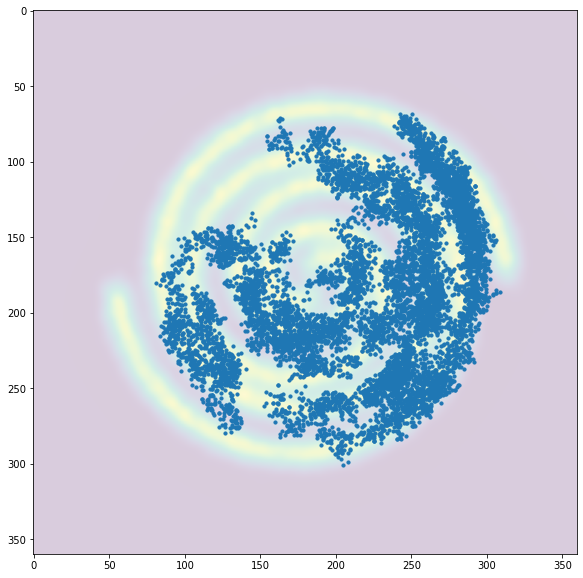

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 10
epsilon = 0.3

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
key, subkey = jax.random.split(key)
init_sample = sample_from_image_density(1, density, subkey).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/spiral_iter10000_k10_e03.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

In [ ]:
## Couple of different strategies: use multiple runs from one sample vs. use a run from multiple samples
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 40
epsilon = 0.7

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
init_sample = sample_from_image_density(1, density, key).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/spiral_iter10000_k40_e07.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 0], sampled_outputs[:, :, 1], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

  0%|          | 1/10000 [00:05<15:36:54,  5.62s/it]

Metropolis- Hastings REJECT 1.6723478 2.4035125


  0%|          | 10/10000 [00:56<15:29:17,  5.58s/it]

Metropolis- Hastings REJECT 0.9646218 1.3842452


  0%|          | 16/10000 [01:29<15:35:28,  5.62s/it]

Metropolis- Hastings REJECT 1.0349723 1.4430118


  0%|          | 25/10000 [02:19<15:22:04,  5.55s/it]

Metropolis- Hastings REJECT 1.112833 2.3294926


  0%|          | 27/10000 [02:30<15:14:16,  5.50s/it]

Metropolis- Hastings REJECT 1.1264141 1.9649849


  0%|          | 28/10000 [02:36<15:11:57,  5.49s/it]

Metropolis- Hastings REJECT 1.1264141 1.3951629


  0%|          | 29/10000 [02:41<15:28:25,  5.59s/it]

Metropolis- Hastings REJECT 1.1264141 1.3118374


  0%|          | 32/10000 [02:58<15:15:30,  5.51s/it]

Metropolis- Hastings REJECT 1.1325406 2.4111223


  1%|          | 55/10000 [05:05<15:09:30,  5.49s/it]

Metropolis- Hastings REJECT 3.5290759 inf


  1%|          | 57/10000 [05:16<15:06:02,  5.47s/it]

Metropolis- Hastings REJECT 1.2778273 1.8888909


  1%|          | 59/10000 [05:27<15:06:03,  5.47s/it]

Metropolis- Hastings REJECT 1.4025967 3.5386012


  1%|          | 60/10000 [05:32<15:05:53,  5.47s/it]

Metropolis- Hastings REJECT 1.4025967 3.323978


  1%|          | 69/10000 [06:22<15:11:27,  5.51s/it]

Metropolis- Hastings REJECT 1.100089 2.536867


  1%|          | 75/10000 [06:54<15:10:02,  5.50s/it]

Metropolis- Hastings REJECT 0.9467735 1.3119609


  1%|          | 81/10000 [07:27<14:57:11,  5.43s/it]

Metropolis- Hastings REJECT 0.99001 1.3565211


  1%|          | 84/10000 [07:43<14:56:02,  5.42s/it]

Metropolis- Hastings REJECT 1.2839761 1.6895713


  1%|          | 86/10000 [07:54<14:57:04,  5.43s/it]

Metropolis- Hastings REJECT 0.9684084 1.3818213


  1%|          | 121/10000 [11:04<14:52:22,  5.42s/it]

Metropolis- Hastings REJECT 1.3895161 2.0428884


  1%|▏         | 130/10000 [11:53<15:06:51,  5.51s/it]

Metropolis- Hastings REJECT 1.1536824 1.6269948


  1%|▏         | 133/10000 [12:10<15:11:49,  5.54s/it]

Metropolis- Hastings REJECT 1.326178 1.4531271


  1%|▏         | 146/10000 [13:20<15:08:05,  5.53s/it]

Metropolis- Hastings REJECT 1.1962618 1.4469725


  2%|▏         | 157/10000 [14:21<15:03:50,  5.51s/it]

Metropolis- Hastings REJECT 1.1312371 1.9108226


  2%|▏         | 165/10000 [15:04<14:48:55,  5.42s/it]

Metropolis- Hastings REJECT 0.9944687 1.3882129


  2%|▏         | 173/10000 [15:49<15:21:25,  5.63s/it]

Metropolis- Hastings REJECT 0.96638846 1.5834651


  2%|▏         | 187/10000 [17:05<14:55:59,  5.48s/it]

Metropolis- Hastings REJECT 0.97709715 1.7664914


  2%|▏         | 201/10000 [18:22<14:58:26,  5.50s/it]

Metropolis- Hastings REJECT 0.99163675 1.2598497


  2%|▏         | 205/10000 [18:44<15:05:01,  5.54s/it]

Metropolis- Hastings REJECT 1.3695049 1.7565557


  2%|▏         | 220/10000 [20:06<14:58:52,  5.51s/it]

Metropolis- Hastings REJECT 1.1064 2.8603635


  2%|▏         | 222/10000 [20:17<14:59:45,  5.52s/it]

Metropolis- Hastings REJECT 0.9291216 0.95786035


  2%|▏         | 225/10000 [20:34<15:08:51,  5.58s/it]

Metropolis- Hastings REJECT 1.2406375 2.2228732


  2%|▏         | 231/10000 [21:07<15:05:00,  5.56s/it]

Metropolis- Hastings REJECT 1.0817908 1.2920135


  2%|▏         | 245/10000 [22:25<15:01:08,  5.54s/it]

Metropolis- Hastings REJECT 1.0019902 1.0237983


  3%|▎         | 265/10000 [24:15<14:49:42,  5.48s/it]

Metropolis- Hastings REJECT 0.9386826 1.9374825


  3%|▎         | 268/10000 [24:31<14:57:16,  5.53s/it]

Metropolis- Hastings REJECT 1.1066902 1.4165462


  3%|▎         | 271/10000 [24:48<14:52:19,  5.50s/it]

Metropolis- Hastings REJECT 1.0556862 2.320447


  3%|▎         | 288/10000 [26:21<14:38:34,  5.43s/it]

Metropolis- Hastings REJECT 0.9874685 1.3204747


  3%|▎         | 299/10000 [27:21<14:49:34,  5.50s/it]

Metropolis- Hastings REJECT 1.2393025 3.5459278


  3%|▎         | 301/10000 [27:32<14:55:13,  5.54s/it]

Metropolis- Hastings REJECT 1.3138129 3.5563283


  3%|▎         | 314/10000 [28:42<14:22:17,  5.34s/it]

Metropolis- Hastings REJECT 0.98567516 2.464299


  3%|▎         | 328/10000 [29:58<14:35:27,  5.43s/it]

Metropolis- Hastings REJECT 0.96896124 2.6419265


  3%|▎         | 329/10000 [30:04<14:38:30,  5.45s/it]

Metropolis- Hastings REJECT 0.96896124 3.5623882


  3%|▎         | 340/10000 [31:04<14:44:31,  5.49s/it]

Metropolis- Hastings REJECT 1.0522684 2.662704


  3%|▎         | 343/10000 [31:20<14:37:10,  5.45s/it]

Metropolis- Hastings REJECT 1.0083112 1.3816322


  3%|▎         | 346/10000 [31:37<14:50:50,  5.54s/it]

Metropolis- Hastings REJECT 0.96986556 3.5668535


  4%|▎         | 351/10000 [32:04<14:43:16,  5.49s/it]

Metropolis- Hastings REJECT 1.0820897 1.2714386


  4%|▎         | 368/10000 [33:37<14:31:52,  5.43s/it]

Metropolis- Hastings REJECT 1.0581734 3.540197


  4%|▎         | 369/10000 [33:43<14:38:00,  5.47s/it]

Metropolis- Hastings REJECT 1.0581734 1.2961123


  4%|▎         | 373/10000 [34:05<14:38:07,  5.47s/it]

Metropolis- Hastings REJECT 1.1635358 1.4783103


  4%|▍         | 383/10000 [35:00<14:37:21,  5.47s/it]

Metropolis- Hastings REJECT 0.99374086 1.2606986


  4%|▍         | 384/10000 [35:05<14:38:24,  5.48s/it]

Metropolis- Hastings REJECT 0.99374086 1.3334988


  4%|▍         | 385/10000 [35:11<14:42:44,  5.51s/it]

Metropolis- Hastings REJECT 0.99374086 1.7278783


  4%|▍         | 386/10000 [35:16<14:40:56,  5.50s/it]

Metropolis- Hastings REJECT 0.99374086 1.0017912


  4%|▍         | 388/10000 [35:27<14:40:17,  5.49s/it]

Metropolis- Hastings REJECT 0.9648105 1.0688695


  4%|▍         | 391/10000 [35:44<14:45:12,  5.53s/it]

Metropolis- Hastings REJECT 1.1001991 2.1239104


  4%|▍         | 392/10000 [35:49<14:42:00,  5.51s/it]

Metropolis- Hastings REJECT 1.1001991 1.837189


  4%|▍         | 404/10000 [36:55<14:32:44,  5.46s/it]

Metropolis- Hastings REJECT 1.0151783 1.3374838


  4%|▍         | 408/10000 [37:17<14:43:27,  5.53s/it]

Metropolis- Hastings REJECT 1.0746613 1.7082443


  4%|▍         | 425/10000 [38:51<14:46:46,  5.56s/it]

Metropolis- Hastings REJECT 1.1756096 2.4361413


  4%|▍         | 428/10000 [39:08<14:43:13,  5.54s/it]

Metropolis- Hastings REJECT 1.2041836 1.6797438


  4%|▍         | 433/10000 [39:36<15:05:21,  5.68s/it]

Metropolis- Hastings REJECT 1.0362904 3.5439305


  4%|▍         | 436/10000 [39:53<14:46:21,  5.56s/it]

Metropolis- Hastings REJECT 0.93261397 1.238404


  4%|▍         | 440/10000 [40:15<14:46:16,  5.56s/it]

Metropolis- Hastings REJECT 1.4110628 2.383882


  4%|▍         | 442/10000 [40:26<14:33:19,  5.48s/it]

Metropolis- Hastings REJECT 1.0143998 1.4105655


  5%|▍         | 454/10000 [41:32<14:44:16,  5.56s/it]

Metropolis- Hastings REJECT 1.0529282 1.2282158


  5%|▍         | 455/10000 [41:37<14:41:53,  5.54s/it]

Metropolis- Hastings REJECT 1.0529282 1.3920453


  5%|▍         | 466/10000 [42:37<14:18:24,  5.40s/it]

Metropolis- Hastings REJECT 1.9939073 3.3326328


  5%|▍         | 471/10000 [43:04<14:15:41,  5.39s/it]

Metropolis- Hastings REJECT 0.9531799 1.1037766


  5%|▍         | 477/10000 [43:36<14:14:58,  5.39s/it]

Metropolis- Hastings REJECT 1.0810219 1.3520023


  5%|▍         | 483/10000 [44:08<14:08:46,  5.35s/it]

Metropolis- Hastings REJECT 0.96130127 1.1021618


  5%|▍         | 490/10000 [44:46<14:17:16,  5.41s/it]

Metropolis- Hastings REJECT 1.7711809 1.9960337


  5%|▌         | 520/10000 [47:28<14:21:54,  5.46s/it]

Metropolis- Hastings REJECT 1.2401133 2.2487218


  5%|▌         | 533/10000 [48:38<14:12:21,  5.40s/it]

Metropolis- Hastings REJECT 1.0032178 1.3024132


  5%|▌         | 537/10000 [49:00<14:13:14,  5.41s/it]

Metropolis- Hastings REJECT 1.3117452 3.256418


  5%|▌         | 542/10000 [49:26<13:56:37,  5.31s/it]

Metropolis- Hastings REJECT 1.1789036 2.7656236


  6%|▌         | 555/10000 [50:36<14:03:17,  5.36s/it]

Metropolis- Hastings REJECT 1.0094912 1.8277136


  6%|▌         | 575/10000 [52:23<13:49:46,  5.28s/it]

Metropolis- Hastings REJECT 1.1485755 1.631738


  6%|▌         | 580/10000 [52:49<13:51:38,  5.30s/it]

Metropolis- Hastings REJECT 1.042459 1.5786844


  6%|▌         | 598/10000 [54:25<13:52:14,  5.31s/it]

Metropolis- Hastings REJECT 1.0577652 1.5777315


  6%|▌         | 604/10000 [54:57<13:57:04,  5.35s/it]

Metropolis- Hastings REJECT 1.0299174 1.853239


  6%|▌         | 609/10000 [55:24<14:09:55,  5.43s/it]

Metropolis- Hastings REJECT 1.013409 2.060955


  6%|▋         | 634/10000 [57:36<13:46:11,  5.29s/it]

Metropolis- Hastings REJECT 1.0261409 1.5205182


  6%|▋         | 635/10000 [57:42<13:47:11,  5.30s/it]

Metropolis- Hastings REJECT 1.0261409 1.7218275


  7%|▋         | 654/10000 [59:23<13:59:33,  5.39s/it]

Metropolis- Hastings REJECT 1.0048829 1.5159843


  7%|▋         | 657/10000 [59:39<13:45:44,  5.30s/it]

Metropolis- Hastings REJECT 1.5807703 1.7393651


  7%|▋         | 661/10000 [1:00:01<14:13:43,  5.48s/it]

Metropolis- Hastings REJECT 0.959792 1.8561873


  7%|▋         | 667/10000 [1:00:33<13:59:11,  5.40s/it]

Metropolis- Hastings REJECT 1.6617962 3.5542326


  7%|▋         | 696/10000 [1:03:09<13:52:39,  5.37s/it]

Metropolis- Hastings REJECT 1.0097686 2.3594952


  7%|▋         | 709/10000 [1:04:18<13:56:40,  5.40s/it]

Metropolis- Hastings REJECT 0.98072875 1.0232294


  7%|▋         | 712/10000 [1:04:35<14:02:34,  5.44s/it]

Metropolis- Hastings REJECT 1.0151566 1.3108721


  7%|▋         | 726/10000 [1:05:51<13:57:40,  5.42s/it]

Metropolis- Hastings REJECT 1.1663607 1.6865574


  7%|▋         | 735/10000 [1:06:38<13:43:26,  5.33s/it]

Metropolis- Hastings REJECT 1.3836613 2.614961


  8%|▊         | 772/10000 [1:09:57<13:52:43,  5.41s/it]

Metropolis- Hastings REJECT 0.99132216 1.7930624


  8%|▊         | 783/10000 [1:10:58<14:32:16,  5.68s/it]

Metropolis- Hastings REJECT 1.0692766 1.3463461


  8%|▊         | 788/10000 [1:11:26<14:33:39,  5.69s/it]

Metropolis- Hastings REJECT 1.2334887 1.803463


  8%|▊         | 801/10000 [1:12:38<14:03:12,  5.50s/it]

Metropolis- Hastings REJECT 1.2253928 1.4412695


  8%|▊         | 808/10000 [1:13:16<13:57:43,  5.47s/it]

Metropolis- Hastings REJECT 1.0817113 1.3938906


  8%|▊         | 811/10000 [1:13:32<14:07:35,  5.53s/it]

Metropolis- Hastings REJECT 1.191148 1.6092027


  8%|▊         | 823/10000 [1:14:38<14:04:32,  5.52s/it]

Metropolis- Hastings REJECT 0.96196234 1.2970332


  8%|▊         | 824/10000 [1:14:44<14:09:16,  5.55s/it]

Metropolis- Hastings REJECT 0.96196234 1.2408837


  8%|▊         | 827/10000 [1:15:00<14:01:26,  5.50s/it]

Metropolis- Hastings REJECT 1.0592746 1.2498608


  8%|▊         | 828/10000 [1:15:06<14:09:34,  5.56s/it]

Metropolis- Hastings REJECT 1.0592746 2.4244986


  8%|▊         | 829/10000 [1:15:11<14:23:36,  5.65s/it]

Metropolis- Hastings REJECT 1.0592746 1.2780685


  8%|▊         | 830/10000 [1:15:17<14:23:48,  5.65s/it]

Metropolis- Hastings REJECT 1.0592746 1.5115831


  8%|▊         | 832/10000 [1:15:28<14:18:01,  5.62s/it]

Metropolis- Hastings REJECT 0.9608959 1.0323794


  8%|▊         | 837/10000 [1:15:56<14:00:04,  5.50s/it]

Metropolis- Hastings REJECT 1.0097098 1.9322543


  8%|▊         | 848/10000 [1:16:57<14:08:23,  5.56s/it]

Metropolis- Hastings REJECT 0.9697411 1.5049723


  9%|▊         | 854/10000 [1:17:31<14:13:27,  5.60s/it]

Metropolis- Hastings REJECT 1.0000719 1.3635582


  9%|▊         | 860/10000 [1:18:03<13:50:32,  5.45s/it]

Metropolis- Hastings REJECT 0.970904 1.0111446


  9%|▉         | 877/10000 [1:19:35<13:45:20,  5.43s/it]

Metropolis- Hastings REJECT 1.1479914 1.3438165


  9%|▉         | 882/10000 [1:20:02<13:50:35,  5.47s/it]

Metropolis- Hastings REJECT 0.97685367 1.8315907


  9%|▉         | 894/10000 [1:21:08<13:48:12,  5.46s/it]

Metropolis- Hastings REJECT 1.1033627 2.3296034


  9%|▉         | 895/10000 [1:21:13<13:53:17,  5.49s/it]

Metropolis- Hastings REJECT 1.1033627 1.2956005


  9%|▉         | 901/10000 [1:21:46<13:46:44,  5.45s/it]

Metropolis- Hastings REJECT 1.1034027 1.474243


  9%|▉         | 928/10000 [1:24:12<13:34:33,  5.39s/it]

Metropolis- Hastings REJECT 1.0737839 1.5151644


  9%|▉         | 941/10000 [1:25:21<13:16:10,  5.27s/it]

Metropolis- Hastings REJECT 1.106863 3.5249493


 10%|▉         | 955/10000 [1:26:36<13:27:26,  5.36s/it]

Metropolis- Hastings REJECT 1.1735113 1.4716322


 10%|▉         | 958/10000 [1:26:52<13:32:58,  5.39s/it]

Metropolis- Hastings REJECT 0.99633074 1.1112463


 10%|▉         | 966/10000 [1:27:35<13:25:04,  5.35s/it]

Metropolis- Hastings REJECT 0.9819473 3.538813


 10%|▉         | 970/10000 [1:27:56<13:21:05,  5.32s/it]

Metropolis- Hastings REJECT 0.9529052 1.0754932


 10%|▉         | 972/10000 [1:28:07<13:33:47,  5.41s/it]

Metropolis- Hastings REJECT 0.9670031 1.0613854


 10%|▉         | 978/10000 [1:28:39<13:23:43,  5.35s/it]

Metropolis- Hastings REJECT 0.93706524 1.1252899


 10%|▉         | 979/10000 [1:28:45<13:27:17,  5.37s/it]

Metropolis- Hastings REJECT 0.93706524 1.4124025


 10%|▉         | 992/10000 [1:29:53<13:20:04,  5.33s/it]

Metropolis- Hastings REJECT 1.0132693 1.3011271


 10%|▉         | 998/10000 [1:30:25<13:15:48,  5.30s/it]

Metropolis- Hastings REJECT 1.2259866 3.5296896


 10%|█         | 1003/10000 [1:30:52<13:10:06,  5.27s/it]

Metropolis- Hastings REJECT 1.9971219 2.601436


 10%|█         | 1006/10000 [1:31:08<13:19:02,  5.33s/it]

Metropolis- Hastings REJECT 1.0774022 2.218162


 10%|█         | 1015/10000 [1:31:55<13:24:15,  5.37s/it]

Metropolis- Hastings REJECT 1.133117 1.7091713


 10%|█         | 1016/10000 [1:32:01<13:26:14,  5.38s/it]

Metropolis- Hastings REJECT 1.133117 1.5221705


 10%|█         | 1026/10000 [1:32:54<13:15:06,  5.32s/it]

Metropolis- Hastings REJECT 1.0824761 1.5701191


 10%|█         | 1033/10000 [1:33:32<13:18:51,  5.35s/it]

Metropolis- Hastings REJECT 0.9470196 1.1478927


 10%|█         | 1042/10000 [1:34:20<13:35:11,  5.46s/it]

Metropolis- Hastings REJECT 1.3979093 2.3351102


 10%|█         | 1050/10000 [1:35:04<13:26:37,  5.41s/it]

Metropolis- Hastings REJECT 0.9865509 1.5084612


 11%|█         | 1054/10000 [1:35:26<13:37:12,  5.48s/it]

Metropolis- Hastings REJECT 1.0005121 1.6105038


 11%|█         | 1060/10000 [1:35:58<13:31:21,  5.45s/it]

Metropolis- Hastings REJECT 0.95751727 2.1334608


 11%|█         | 1071/10000 [1:36:57<13:22:23,  5.39s/it]

Metropolis- Hastings REJECT 0.90555733 1.1152971


 11%|█         | 1073/10000 [1:37:08<13:35:46,  5.48s/it]

Metropolis- Hastings REJECT 0.977255 2.7534766


 11%|█         | 1080/10000 [1:37:46<13:24:36,  5.41s/it]

Metropolis- Hastings REJECT 1.1798462 1.5293003


 11%|█         | 1081/10000 [1:37:51<13:28:38,  5.44s/it]

Metropolis- Hastings REJECT 1.1798462 1.9584343


 11%|█         | 1093/10000 [1:38:56<13:19:51,  5.39s/it]

Metropolis- Hastings REJECT 1.111634 1.2327574


 11%|█         | 1094/10000 [1:39:01<13:17:40,  5.37s/it]

Metropolis- Hastings REJECT 1.111634 1.7014116


 11%|█         | 1102/10000 [1:39:44<13:13:58,  5.35s/it]

Metropolis- Hastings REJECT 0.9963012 3.5317426


 11%|█         | 1118/10000 [1:41:09<13:22:55,  5.42s/it]

Metropolis- Hastings REJECT 1.0607157 1.1709747


 11%|█▏        | 1125/10000 [1:41:47<13:17:41,  5.39s/it]

Metropolis- Hastings REJECT 0.9616182 1.0566677


 11%|█▏        | 1128/10000 [1:42:03<13:04:21,  5.30s/it]

Metropolis- Hastings REJECT 1.6830525 2.590015


 11%|█▏        | 1145/10000 [1:43:34<13:21:48,  5.43s/it]

Metropolis- Hastings REJECT 1.0962249 1.919258


 11%|█▏        | 1146/10000 [1:43:39<13:31:10,  5.50s/it]

Metropolis- Hastings REJECT 1.0962249 1.5554559


 11%|█▏        | 1148/10000 [1:43:51<13:39:56,  5.56s/it]

Metropolis- Hastings REJECT 1.0657039 3.5522165


 11%|█▏        | 1149/10000 [1:43:56<13:34:19,  5.52s/it]

Metropolis- Hastings REJECT 1.0657039 1.736867


 12%|█▏        | 1156/10000 [1:44:33<13:05:20,  5.33s/it]

Metropolis- Hastings REJECT 1.0385617 1.2130333


 12%|█▏        | 1165/10000 [1:45:22<13:16:47,  5.41s/it]

Metropolis- Hastings REJECT 1.1598446 1.5457917


 12%|█▏        | 1166/10000 [1:45:27<13:11:28,  5.38s/it]

Metropolis- Hastings REJECT 1.1598446 1.2793324


 12%|█▏        | 1173/10000 [1:46:04<13:12:08,  5.38s/it]

Metropolis- Hastings REJECT 0.9463425 1.3367964


 12%|█▏        | 1183/10000 [1:46:58<13:05:59,  5.35s/it]

Metropolis- Hastings REJECT 1.0620832 1.7242072


 12%|█▏        | 1211/10000 [1:49:28<13:05:40,  5.36s/it]

Metropolis- Hastings REJECT 1.0257826 3.2152448


 12%|█▏        | 1218/10000 [1:50:05<13:01:12,  5.34s/it]

Metropolis- Hastings REJECT 1.1066899 1.8586069


 12%|█▏        | 1227/10000 [1:50:52<12:58:00,  5.32s/it]

Metropolis- Hastings REJECT 1.237765 1.6500883


 12%|█▏        | 1244/10000 [1:52:23<12:53:09,  5.30s/it]

Metropolis- Hastings REJECT 1.6160144 2.1505067


 12%|█▏        | 1248/10000 [1:52:44<12:53:44,  5.30s/it]

Metropolis- Hastings REJECT 0.94791985 3.1905022


 12%|█▏        | 1249/10000 [1:52:49<12:59:45,  5.35s/it]

Metropolis- Hastings REJECT 0.94791985 1.0635489


 13%|█▎        | 1255/10000 [1:53:21<12:55:29,  5.32s/it]

Metropolis- Hastings REJECT 1.0316591 2.353277


 13%|█▎        | 1256/10000 [1:53:26<13:00:30,  5.36s/it]

Metropolis- Hastings REJECT 1.0316591 1.064517


 13%|█▎        | 1260/10000 [1:53:48<12:55:52,  5.33s/it]

Metropolis- Hastings REJECT 1.0128696 2.723518


 13%|█▎        | 1263/10000 [1:54:03<12:50:01,  5.29s/it]

Metropolis- Hastings REJECT 1.0109949 2.7412658


 13%|█▎        | 1268/10000 [1:54:30<12:46:38,  5.27s/it]

Metropolis- Hastings REJECT 1.8054519 2.3138971


 13%|█▎        | 1271/10000 [1:54:46<12:49:07,  5.29s/it]

Metropolis- Hastings REJECT 1.0972953 1.9124546


 13%|█▎        | 1281/10000 [1:55:39<12:59:25,  5.36s/it]

Metropolis- Hastings REJECT 1.0792311 3.0188327


 13%|█▎        | 1286/10000 [1:56:06<12:58:41,  5.36s/it]

Metropolis- Hastings REJECT 1.2209612 2.8041205


 13%|█▎        | 1292/10000 [1:56:37<12:56:26,  5.35s/it]

Metropolis- Hastings REJECT 1.3005494 1.7512295


 13%|█▎        | 1296/10000 [1:56:59<13:04:58,  5.41s/it]

Metropolis- Hastings REJECT 1.0119292 1.4159935


 13%|█▎        | 1302/10000 [1:57:31<12:49:19,  5.31s/it]

Metropolis- Hastings REJECT 1.401665 1.5089867


 13%|█▎        | 1305/10000 [1:57:47<12:46:20,  5.29s/it]

Metropolis- Hastings REJECT 1.5842861 2.2935426


 13%|█▎        | 1306/10000 [1:57:52<12:47:12,  5.29s/it]

Metropolis- Hastings REJECT 1.5842861 3.3928103


 13%|█▎        | 1313/10000 [1:58:29<12:56:20,  5.36s/it]

Metropolis- Hastings REJECT 1.265095 1.6243488


 13%|█▎        | 1315/10000 [1:58:40<12:50:48,  5.33s/it]

Metropolis- Hastings REJECT 2.2144697 3.5515811


 13%|█▎        | 1319/10000 [1:59:02<12:54:30,  5.35s/it]

Metropolis- Hastings REJECT 1.3484948 2.2312775


 13%|█▎        | 1332/10000 [2:00:11<12:54:48,  5.36s/it]

Metropolis- Hastings REJECT 0.9724126 3.369326


 13%|█▎        | 1346/10000 [2:01:26<12:58:35,  5.40s/it]

Metropolis- Hastings REJECT 0.91530156 1.209599


 14%|█▎        | 1359/10000 [2:02:36<12:51:26,  5.36s/it]

Metropolis- Hastings REJECT 0.997683 1.156187


 14%|█▎        | 1370/10000 [2:03:35<12:48:47,  5.35s/it]

Metropolis- Hastings REJECT 0.97389233 1.2109213


 14%|█▎        | 1371/10000 [2:03:41<12:58:30,  5.41s/it]

Metropolis- Hastings REJECT 0.97389233 1.987256


 14%|█▎        | 1373/10000 [2:03:52<12:58:22,  5.41s/it]

Metropolis- Hastings REJECT 1.2572019 1.6636183


 14%|█▍        | 1375/10000 [2:04:02<12:48:41,  5.35s/it]

Metropolis- Hastings REJECT 1.4027404 2.1698349


 14%|█▍        | 1385/10000 [2:04:56<12:51:50,  5.38s/it]

Metropolis- Hastings REJECT 0.97867036 1.6170123


 14%|█▍        | 1392/10000 [2:05:34<13:00:24,  5.44s/it]

Metropolis- Hastings REJECT 1.1170611 1.7930033


 14%|█▍        | 1401/10000 [2:06:23<12:57:17,  5.42s/it]

Metropolis- Hastings REJECT 1.0689287 1.2655284


 14%|█▍        | 1403/10000 [2:06:33<12:49:38,  5.37s/it]

Metropolis- Hastings REJECT 1.1711996 1.9123267


 14%|█▍        | 1404/10000 [2:06:39<12:52:58,  5.40s/it]

Metropolis- Hastings REJECT 1.1711996 1.8896427


 14%|█▍        | 1406/10000 [2:06:49<12:52:35,  5.39s/it]

Metropolis- Hastings REJECT 1.1895876 1.4314837


 14%|█▍        | 1408/10000 [2:07:00<12:51:06,  5.38s/it]

Metropolis- Hastings REJECT 1.2115914 1.4313414


 14%|█▍        | 1416/10000 [2:07:44<13:04:42,  5.48s/it]

Metropolis- Hastings REJECT 1.4181908 2.2705352


 14%|█▍        | 1421/10000 [2:08:11<12:59:08,  5.45s/it]

Metropolis- Hastings REJECT 0.9919858 1.9930305


 15%|█▍        | 1451/10000 [2:10:53<12:49:29,  5.40s/it]

Metropolis- Hastings REJECT 1.3638626 2.355801


 15%|█▍        | 1452/10000 [2:10:58<12:49:40,  5.40s/it]

Metropolis- Hastings REJECT 1.3638626 2.352577


 15%|█▍        | 1465/10000 [2:12:08<12:54:03,  5.44s/it]

Metropolis- Hastings REJECT 1.1906558 1.2728028


 15%|█▍        | 1473/10000 [2:12:52<12:52:54,  5.44s/it]

Metropolis- Hastings REJECT 1.163439 1.6489857


 15%|█▍        | 1480/10000 [2:13:30<12:50:13,  5.42s/it]

Metropolis- Hastings REJECT 0.9847183 1.9177581


 15%|█▍        | 1481/10000 [2:13:35<12:47:55,  5.41s/it]

Metropolis- Hastings REJECT 0.9847183 3.4655206


 15%|█▍        | 1484/10000 [2:13:51<12:43:18,  5.38s/it]

Metropolis- Hastings REJECT 1.1324129 3.2827008


 15%|█▍        | 1485/10000 [2:13:57<12:47:21,  5.41s/it]

Metropolis- Hastings REJECT 1.1324129 2.3846848


 15%|█▍        | 1487/10000 [2:14:08<12:47:13,  5.41s/it]

Metropolis- Hastings REJECT 1.111186 1.8429651


 15%|█▍        | 1497/10000 [2:15:02<12:47:44,  5.42s/it]

Metropolis- Hastings REJECT 0.9484333 1.1008657


 15%|█▍        | 1499/10000 [2:15:13<12:56:04,  5.48s/it]

Metropolis- Hastings REJECT 1.0934908 2.2971592


 15%|█▌        | 1510/10000 [2:16:12<12:51:25,  5.45s/it]

Metropolis- Hastings REJECT 1.006529 2.4332078


 15%|█▌        | 1513/10000 [2:16:28<12:43:56,  5.40s/it]

Metropolis- Hastings REJECT 1.2248564 2.6207676


 15%|█▌        | 1540/10000 [2:18:53<12:43:15,  5.41s/it]

Metropolis- Hastings REJECT 2.2322118 2.407745


 15%|█▌        | 1546/10000 [2:19:26<12:36:03,  5.37s/it]

Metropolis- Hastings REJECT 0.9646223 1.1877462


 16%|█▌        | 1556/10000 [2:20:19<12:39:48,  5.40s/it]

Metropolis- Hastings REJECT 0.9444574 3.5413623


 16%|█▌        | 1562/10000 [2:20:52<12:44:32,  5.44s/it]

Metropolis- Hastings REJECT 0.96777546 1.6220986


 16%|█▌        | 1567/10000 [2:21:18<12:42:05,  5.42s/it]

Metropolis- Hastings REJECT 1.1307645 2.0334885


 16%|█▌        | 1592/10000 [2:23:32<12:31:32,  5.36s/it]

Metropolis- Hastings REJECT 1.0624076 1.5969343


 16%|█▌        | 1613/10000 [2:25:23<12:30:19,  5.37s/it]

Metropolis- Hastings REJECT 1.1896095 3.5443404


 17%|█▋        | 1653/10000 [2:28:56<12:15:12,  5.28s/it]

Metropolis- Hastings REJECT 1.2802744 1.4613521


 17%|█▋        | 1668/10000 [2:30:15<12:20:05,  5.33s/it]

Metropolis- Hastings REJECT 1.1137993 1.8900311


 17%|█▋        | 1669/10000 [2:30:20<12:24:35,  5.36s/it]

Metropolis- Hastings REJECT 1.1137993 1.6693416


 17%|█▋        | 1678/10000 [2:31:08<12:21:20,  5.34s/it]

Metropolis- Hastings REJECT 1.0446836 2.094433


 17%|█▋        | 1680/10000 [2:31:18<12:19:18,  5.33s/it]

Metropolis- Hastings REJECT 1.0241421 1.3371314


 17%|█▋        | 1681/10000 [2:31:24<12:22:25,  5.35s/it]

Metropolis- Hastings REJECT 1.0241421 1.1238432


 17%|█▋        | 1722/10000 [2:35:01<12:25:02,  5.40s/it]

Metropolis- Hastings REJECT 1.0046632 3.5297246


 17%|█▋        | 1723/10000 [2:35:06<12:27:55,  5.42s/it]

Metropolis- Hastings REJECT 1.0046632 1.3445381


 17%|█▋        | 1730/10000 [2:35:44<12:19:41,  5.37s/it]

Metropolis- Hastings REJECT 0.9721622 1.7080697


 17%|█▋        | 1731/10000 [2:35:49<12:12:27,  5.31s/it]

Metropolis- Hastings REJECT 0.9721622 3.560196


 17%|█▋        | 1733/10000 [2:36:00<12:09:31,  5.29s/it]

Metropolis- Hastings REJECT 0.9314039 1.1249542


 17%|█▋        | 1734/10000 [2:36:05<12:20:15,  5.37s/it]

Metropolis- Hastings REJECT 0.9314039 1.4625432


 18%|█▊        | 1750/10000 [2:37:31<12:17:37,  5.36s/it]

Metropolis- Hastings REJECT 1.3732461 2.385975


 18%|█▊        | 1755/10000 [2:37:58<12:24:35,  5.42s/it]

Metropolis- Hastings REJECT 1.2093296 1.5893531


 18%|█▊        | 1758/10000 [2:38:14<12:22:59,  5.41s/it]

Metropolis- Hastings REJECT 0.9711708 1.6896887


 18%|█▊        | 1760/10000 [2:38:25<12:27:06,  5.44s/it]

Metropolis- Hastings REJECT 1.115032 1.5279416


 18%|█▊        | 1768/10000 [2:39:08<12:08:03,  5.31s/it]

Metropolis- Hastings REJECT 1.0421786 2.1667376


 18%|█▊        | 1770/10000 [2:39:18<12:11:19,  5.33s/it]

Metropolis- Hastings REJECT 0.97883385 1.0277007


 18%|█▊        | 1782/10000 [2:40:22<12:05:13,  5.29s/it]

Metropolis- Hastings REJECT 1.1370711 1.5583223


 18%|█▊        | 1788/10000 [2:40:54<12:13:31,  5.36s/it]

Metropolis- Hastings REJECT 1.050189 1.3841099


 18%|█▊        | 1796/10000 [2:41:36<12:11:45,  5.35s/it]

Metropolis- Hastings REJECT 0.97710866 2.1662123


 18%|█▊        | 1799/10000 [2:41:52<12:09:49,  5.34s/it]

Metropolis- Hastings REJECT 1.0709746 1.7338271


 18%|█▊        | 1800/10000 [2:41:58<12:14:14,  5.37s/it]

Metropolis- Hastings REJECT 1.0709746 1.2867188


 18%|█▊        | 1811/10000 [2:42:56<12:01:48,  5.29s/it]

Metropolis- Hastings REJECT 1.0137968 2.6915174


 18%|█▊        | 1814/10000 [2:43:12<12:05:09,  5.32s/it]

Metropolis- Hastings REJECT 0.9780884 1.1614976


 18%|█▊        | 1816/10000 [2:43:22<12:00:49,  5.28s/it]

Metropolis- Hastings REJECT 0.9731998 3.5449355


 18%|█▊        | 1828/10000 [2:44:27<12:03:52,  5.31s/it]

Metropolis- Hastings REJECT 1.0325035 1.2611121


 18%|█▊        | 1830/10000 [2:44:37<11:47:11,  5.19s/it]

Metropolis- Hastings REJECT 1.0155618 1.3180242


 18%|█▊        | 1837/10000 [2:45:14<12:06:23,  5.34s/it]

Metropolis- Hastings REJECT 0.9535379 1.0244943


 18%|█▊        | 1839/10000 [2:45:24<12:02:01,  5.31s/it]

Metropolis- Hastings REJECT 0.9758748 3.4146392


 19%|█▊        | 1862/10000 [2:47:27<12:02:49,  5.33s/it]

Metropolis- Hastings REJECT 1.0706149 1.5110776


 19%|█▉        | 1876/10000 [2:48:42<12:09:29,  5.39s/it]

Metropolis- Hastings REJECT 0.9576772 2.2298288


 19%|█▉        | 1903/10000 [2:51:06<12:08:07,  5.40s/it]

Metropolis- Hastings REJECT 1.0095503 2.4918108


 19%|█▉        | 1925/10000 [2:53:03<12:08:58,  5.42s/it]

Metropolis- Hastings REJECT 1.0868609 1.4868504


 19%|█▉        | 1928/10000 [2:53:19<12:04:21,  5.38s/it]

Metropolis- Hastings REJECT 1.0379362 1.6632423


 19%|█▉        | 1947/10000 [2:55:01<11:54:12,  5.32s/it]

Metropolis- Hastings REJECT 1.2341197 1.8434869


 20%|█▉        | 1958/10000 [2:56:00<12:00:47,  5.38s/it]

Metropolis- Hastings REJECT 1.1645896 3.5607657


 20%|█▉        | 1962/10000 [2:56:21<11:54:27,  5.33s/it]

Metropolis- Hastings REJECT 1.262516 2.413001


 20%|█▉        | 1967/10000 [2:56:48<11:47:09,  5.28s/it]

Metropolis- Hastings REJECT 1.4145812 1.7255716


 20%|█▉        | 1974/10000 [2:57:24<11:45:37,  5.28s/it]

Metropolis- Hastings REJECT 1.1008053 2.0410864


 20%|█▉        | 1979/10000 [2:57:51<12:02:04,  5.40s/it]

Metropolis- Hastings REJECT 1.968677 3.542821


 20%|█▉        | 1980/10000 [2:57:57<12:04:24,  5.42s/it]

Metropolis- Hastings REJECT 1.968677 3.537984


 20%|█▉        | 1986/10000 [2:58:29<11:54:58,  5.35s/it]

Metropolis- Hastings REJECT 1.0735294 1.4006398


 20%|█▉        | 1987/10000 [2:58:34<11:54:12,  5.35s/it]

Metropolis- Hastings REJECT 1.0735294 2.0910902


 20%|█▉        | 1989/10000 [2:58:45<11:55:55,  5.36s/it]

Metropolis- Hastings REJECT 0.9431945 1.3216097


 20%|██        | 2016/10000 [3:01:09<11:57:39,  5.39s/it]

Metropolis- Hastings REJECT 0.9249873 1.0058341


 20%|██        | 2023/10000 [3:01:46<11:49:26,  5.34s/it]

Metropolis- Hastings REJECT 1.0627086 1.9488122


 20%|██        | 2026/10000 [3:02:02<11:55:35,  5.38s/it]

Metropolis- Hastings REJECT 0.9289826 2.1442058


 20%|██        | 2029/10000 [3:02:18<11:57:58,  5.40s/it]

Metropolis- Hastings REJECT 1.0561259 1.7263565


 20%|██        | 2033/10000 [3:02:40<11:58:29,  5.41s/it]

Metropolis- Hastings REJECT 1.2181329 2.1278095


 20%|██        | 2039/10000 [3:03:12<11:53:36,  5.38s/it]

Metropolis- Hastings REJECT 1.1758223 1.6503808


 21%|██        | 2054/10000 [3:04:33<11:43:50,  5.31s/it]

Metropolis- Hastings REJECT 0.95968914 0.99297976


 21%|██        | 2055/10000 [3:04:38<11:46:52,  5.34s/it]

Metropolis- Hastings REJECT 0.95968914 1.3659484


 21%|██        | 2056/10000 [3:04:44<11:49:46,  5.36s/it]

Metropolis- Hastings REJECT 0.95968914 1.619153


 21%|██        | 2066/10000 [3:05:37<11:56:19,  5.42s/it]

Metropolis- Hastings REJECT 1.0675855 1.9507029


 21%|██        | 2068/10000 [3:05:48<11:54:58,  5.41s/it]

Metropolis- Hastings REJECT 0.9807342 1.2539786


 21%|██        | 2070/10000 [3:05:59<11:50:42,  5.38s/it]

Metropolis- Hastings REJECT 1.0381682 1.2456328


 21%|██        | 2102/10000 [3:08:50<11:48:05,  5.38s/it]

Metropolis- Hastings REJECT 1.0734668 2.148539


 21%|██        | 2104/10000 [3:09:01<11:35:50,  5.29s/it]

Metropolis- Hastings REJECT 1.0703934 1.2915558


 21%|██        | 2110/10000 [3:09:33<11:43:14,  5.35s/it]

Metropolis- Hastings REJECT 1.026097 1.0823193


 21%|██        | 2122/10000 [3:10:36<11:37:34,  5.31s/it]

Metropolis- Hastings REJECT 0.9778175 1.92782


 21%|██        | 2124/10000 [3:10:47<11:36:23,  5.31s/it]

Metropolis- Hastings REJECT 0.99049044 1.3471553


 21%|██▏       | 2131/10000 [3:11:24<11:42:29,  5.36s/it]

Metropolis- Hastings REJECT 1.1520778 1.7603681


 21%|██▏       | 2135/10000 [3:11:45<11:40:58,  5.35s/it]

Metropolis- Hastings REJECT 1.1286675 1.8296051


 22%|██▏       | 2153/10000 [3:13:20<11:33:40,  5.30s/it]

Metropolis- Hastings REJECT 1.070204 1.2894778


 22%|██▏       | 2155/10000 [3:13:31<11:32:19,  5.30s/it]

Metropolis- Hastings REJECT 1.0400367 1.1022646


 22%|██▏       | 2191/10000 [3:16:42<11:20:20,  5.23s/it]

Metropolis- Hastings REJECT 1.0499759 1.2221671


 22%|██▏       | 2203/10000 [3:17:46<11:34:06,  5.34s/it]

Metropolis- Hastings REJECT 2.2195172 3.5241377


 22%|██▏       | 2210/10000 [3:18:23<11:26:46,  5.29s/it]

Metropolis- Hastings REJECT 1.0961374 2.243065


 22%|██▏       | 2211/10000 [3:18:28<11:29:57,  5.31s/it]

Metropolis- Hastings REJECT 1.0961374 2.278572


 22%|██▏       | 2225/10000 [3:19:42<11:31:50,  5.34s/it]

Metropolis- Hastings REJECT 0.9841857 1.1568906


 22%|██▏       | 2230/10000 [3:20:09<11:35:36,  5.37s/it]

Metropolis- Hastings REJECT 1.0101552 1.1193261


 22%|██▏       | 2232/10000 [3:20:20<11:36:41,  5.38s/it]

Metropolis- Hastings REJECT 0.97966516 2.236795


 22%|██▏       | 2234/10000 [3:20:30<11:27:40,  5.31s/it]

Metropolis- Hastings REJECT 1.0309035 1.8448012


 23%|██▎       | 2252/10000 [3:22:06<11:33:54,  5.37s/it]

Metropolis- Hastings REJECT 1.2915912 1.8016763


 23%|██▎       | 2253/10000 [3:22:12<11:37:32,  5.40s/it]

Metropolis- Hastings REJECT 1.2915912 1.869487


 23%|██▎       | 2263/10000 [3:23:05<11:26:10,  5.32s/it]

Metropolis- Hastings REJECT 1.0113382 2.3759856


 23%|██▎       | 2265/10000 [3:23:16<11:28:18,  5.34s/it]

Metropolis- Hastings REJECT 1.0368644 2.148363


 23%|██▎       | 2291/10000 [3:25:34<11:18:07,  5.28s/it]

Metropolis- Hastings REJECT 0.9658606 1.3161057


 23%|██▎       | 2307/10000 [3:26:58<11:28:04,  5.37s/it]

Metropolis- Hastings REJECT 0.9686873 1.6057223


 23%|██▎       | 2336/10000 [3:29:33<11:30:36,  5.41s/it]

Metropolis- Hastings REJECT 1.2185836 1.4625654


 23%|██▎       | 2339/10000 [3:29:49<11:30:49,  5.41s/it]

Metropolis- Hastings REJECT 1.1268051 2.1258252


 23%|██▎       | 2342/10000 [3:30:06<11:41:32,  5.50s/it]

Metropolis- Hastings REJECT 0.96683604 1.0895269


 23%|██▎       | 2347/10000 [3:30:33<11:30:26,  5.41s/it]

Metropolis- Hastings REJECT 1.1110699 1.246978


 24%|██▎       | 2353/10000 [3:31:05<11:23:54,  5.37s/it]

Metropolis- Hastings REJECT 1.2355778 2.039304


 24%|██▎       | 2364/10000 [3:32:04<11:16:23,  5.31s/it]

Metropolis- Hastings REJECT 0.9626018 1.6346061


 24%|██▎       | 2371/10000 [3:32:41<11:13:11,  5.29s/it]

Metropolis- Hastings REJECT 1.0219548 1.8052993


 24%|██▍       | 2383/10000 [3:33:44<11:12:51,  5.30s/it]

Metropolis- Hastings REJECT 0.99156594 1.9177758


 24%|██▍       | 2393/10000 [3:34:37<11:14:50,  5.32s/it]

Metropolis- Hastings REJECT 1.3096997 1.7763509


 24%|██▍       | 2420/10000 [3:37:00<11:03:16,  5.25s/it]

Metropolis- Hastings REJECT 1.0051876 3.5456293


 24%|██▍       | 2431/10000 [3:37:57<11:13:19,  5.34s/it]

Metropolis- Hastings REJECT 0.95163196 3.5161784


 24%|██▍       | 2436/10000 [3:38:24<11:04:32,  5.27s/it]

Metropolis- Hastings REJECT 1.5384156 3.5314157


 24%|██▍       | 2439/10000 [3:38:39<10:59:25,  5.23s/it]

Metropolis- Hastings REJECT 1.0899627 2.8768666


 25%|██▍       | 2461/10000 [3:40:35<11:17:03,  5.39s/it]

Metropolis- Hastings REJECT 0.9890493 1.0168064


 25%|██▍       | 2464/10000 [3:40:52<11:14:57,  5.37s/it]

Metropolis- Hastings REJECT 0.9509257 1.8461012


 25%|██▍       | 2471/10000 [3:41:29<11:07:06,  5.32s/it]

Metropolis- Hastings REJECT 1.2919983 3.553004


 25%|██▍       | 2478/10000 [3:42:06<10:57:00,  5.24s/it]

Metropolis- Hastings REJECT 0.98701257 2.4333591


 25%|██▍       | 2479/10000 [3:42:11<11:02:53,  5.29s/it]

Metropolis- Hastings REJECT 0.98701257 2.05598


 25%|██▍       | 2480/10000 [3:42:16<10:57:25,  5.25s/it]

Metropolis- Hastings REJECT 0.98701257 2.1093469


 25%|██▍       | 2483/10000 [3:42:32<10:54:54,  5.23s/it]

Metropolis- Hastings REJECT 1.7048333 2.7806551


 25%|██▌       | 2503/10000 [3:44:17<10:55:08,  5.24s/it]

Metropolis- Hastings REJECT 0.92092997 1.1218228


 25%|██▌       | 2509/10000 [3:44:48<11:01:37,  5.30s/it]

Metropolis- Hastings REJECT 1.002254 2.0296733


 25%|██▌       | 2513/10000 [3:45:09<10:58:58,  5.28s/it]

Metropolis- Hastings REJECT 1.0605572 3.5539525


 25%|██▌       | 2517/10000 [3:45:30<10:58:45,  5.28s/it]

Metropolis- Hastings REJECT 0.99657166 1.6153173


 25%|██▌       | 2518/10000 [3:45:36<10:58:48,  5.28s/it]

Metropolis- Hastings REJECT 0.99657166 2.2938557


 25%|██▌       | 2525/10000 [3:46:12<10:42:32,  5.16s/it]

Metropolis- Hastings REJECT 0.946543 1.4383686


 25%|██▌       | 2527/10000 [3:46:22<10:44:01,  5.17s/it]

Metropolis- Hastings REJECT 0.9469969 0.9979278


 25%|██▌       | 2530/10000 [3:46:38<10:47:25,  5.20s/it]

Metropolis- Hastings REJECT 0.95130587 1.8610157


 25%|██▌       | 2540/10000 [3:47:31<11:03:22,  5.34s/it]

Metropolis- Hastings REJECT 0.93181145 1.9981067


 26%|██▌       | 2553/10000 [3:48:40<11:00:13,  5.32s/it]

Metropolis- Hastings REJECT 1.0111984 1.6121526


 26%|██▌       | 2555/10000 [3:48:50<11:03:08,  5.34s/it]

Metropolis- Hastings REJECT 1.0017995 1.4472041


 26%|██▌       | 2561/10000 [3:49:23<11:06:53,  5.38s/it]

Metropolis- Hastings REJECT 1.2635741 2.4419055


 26%|██▌       | 2567/10000 [3:49:56<11:27:00,  5.55s/it]

Metropolis- Hastings REJECT 1.2012143 2.0560102


 26%|██▌       | 2568/10000 [3:50:01<11:24:22,  5.53s/it]

Metropolis- Hastings REJECT 1.2012143 1.2756951


 26%|██▌       | 2573/10000 [3:50:28<11:06:42,  5.39s/it]

Metropolis- Hastings REJECT 0.9854582 1.4829929


 26%|██▌       | 2580/10000 [3:51:06<11:08:44,  5.41s/it]

Metropolis- Hastings REJECT 0.97894007 1.0875415


 26%|██▌       | 2585/10000 [3:51:33<11:05:07,  5.38s/it]

Metropolis- Hastings REJECT 0.9741413 1.6312163


 26%|██▌       | 2598/10000 [3:52:42<11:02:16,  5.37s/it]

Metropolis- Hastings REJECT 1.0869623 1.2822222


 26%|██▌       | 2601/10000 [3:52:59<11:08:50,  5.42s/it]

Metropolis- Hastings REJECT 0.9932297 1.4818597


 26%|██▌       | 2609/10000 [3:53:41<10:58:11,  5.34s/it]

Metropolis- Hastings REJECT 1.091771 2.2185042


 26%|██▌       | 2611/10000 [3:53:52<10:58:28,  5.35s/it]

Metropolis- Hastings REJECT 1.1495277 1.9021692


 26%|██▌       | 2616/10000 [3:54:18<10:47:17,  5.26s/it]

Metropolis- Hastings REJECT 1.003302 1.9619858


 26%|██▋       | 2632/10000 [3:55:40<10:40:48,  5.22s/it]

Metropolis- Hastings REJECT 1.1257889 3.1230702


 26%|██▋       | 2643/10000 [3:56:38<10:38:22,  5.21s/it]

Metropolis- Hastings REJECT 1.6555219 1.7317038


 26%|██▋       | 2646/10000 [3:56:53<10:34:50,  5.18s/it]

Metropolis- Hastings REJECT 0.9708716 2.0116982


 27%|██▋       | 2651/10000 [3:57:20<10:39:52,  5.22s/it]

Metropolis- Hastings REJECT 1.0634532 1.2258859


 27%|██▋       | 2652/10000 [3:57:25<10:45:18,  5.27s/it]

Metropolis- Hastings REJECT 1.0634532 1.4732442


 27%|██▋       | 2654/10000 [3:57:35<10:44:29,  5.26s/it]

Metropolis- Hastings REJECT 1.1398704 1.2271408


 27%|██▋       | 2659/10000 [3:58:02<10:55:42,  5.36s/it]

Metropolis- Hastings REJECT 1.2651905 2.5886683


 27%|██▋       | 2661/10000 [3:58:12<10:48:10,  5.30s/it]

Metropolis- Hastings REJECT 1.0946211 2.047205


 27%|██▋       | 2664/10000 [3:58:28<10:37:59,  5.22s/it]

Metropolis- Hastings REJECT 1.0460784 2.9950237


 27%|██▋       | 2673/10000 [3:59:15<10:47:33,  5.30s/it]

Metropolis- Hastings REJECT 1.0513318 1.2553021


 27%|██▋       | 2678/10000 [3:59:41<10:39:26,  5.24s/it]

Metropolis- Hastings REJECT 1.2715387 1.6326176


 27%|██▋       | 2679/10000 [3:59:47<10:44:20,  5.28s/it]

Metropolis- Hastings REJECT 1.2715387 1.7452195


 27%|██▋       | 2684/10000 [4:00:13<10:36:20,  5.22s/it]

Metropolis- Hastings REJECT 1.1071615 1.3949625


 27%|██▋       | 2695/10000 [4:01:11<10:54:01,  5.37s/it]

Metropolis- Hastings REJECT 1.3115076 2.7010396


 27%|██▋       | 2707/10000 [4:02:15<10:48:41,  5.34s/it]

Metropolis- Hastings REJECT 3.5491493 inf


 27%|██▋       | 2710/10000 [4:02:32<10:54:38,  5.39s/it]

Metropolis- Hastings REJECT 1.0474162 3.5257905


 27%|██▋       | 2713/10000 [4:02:47<10:48:40,  5.34s/it]

Metropolis- Hastings REJECT 1.0711029 1.3302599


 27%|██▋       | 2719/10000 [4:03:19<10:43:21,  5.30s/it]

Metropolis- Hastings REJECT 1.0608313 3.063167


 27%|██▋       | 2728/10000 [4:04:06<10:36:00,  5.25s/it]

Metropolis- Hastings REJECT 0.98131615 1.9490803


 27%|██▋       | 2734/10000 [4:04:37<10:31:25,  5.21s/it]

Metropolis- Hastings REJECT 0.9639071 3.5483873


 27%|██▋       | 2741/10000 [4:05:13<10:37:32,  5.27s/it]

Metropolis- Hastings REJECT 1.0402937 1.7159107


 28%|██▊       | 2757/10000 [4:06:38<10:38:07,  5.29s/it]

Metropolis- Hastings REJECT 1.087903 1.4357792


 28%|██▊       | 2762/10000 [4:07:04<10:39:54,  5.30s/it]

Metropolis- Hastings REJECT 1.1181195 1.7596139


 28%|██▊       | 2764/10000 [4:07:15<10:34:22,  5.26s/it]

Metropolis- Hastings REJECT 2.9014866 3.5339444


 28%|██▊       | 2765/10000 [4:07:20<10:37:03,  5.28s/it]

Metropolis- Hastings REJECT 2.9014866 inf


 28%|██▊       | 2766/10000 [4:07:25<10:37:06,  5.28s/it]

Metropolis- Hastings REJECT 2.9014866 3.522303


 28%|██▊       | 2770/10000 [4:07:46<10:37:19,  5.29s/it]

Metropolis- Hastings REJECT 1.62252 3.5426717


 28%|██▊       | 2771/10000 [4:07:52<10:45:04,  5.35s/it]

Metropolis- Hastings REJECT 1.62252 2.2069068


 28%|██▊       | 2779/10000 [4:08:34<10:41:15,  5.33s/it]

Metropolis- Hastings REJECT 1.211918 3.5380852


 28%|██▊       | 2780/10000 [4:08:39<10:41:07,  5.33s/it]

Metropolis- Hastings REJECT 1.211918 2.532085


 28%|██▊       | 2806/10000 [4:10:56<10:35:47,  5.30s/it]

Metropolis- Hastings REJECT 1.0792676 2.317953


 28%|██▊       | 2825/10000 [4:12:37<10:36:46,  5.32s/it]

Metropolis- Hastings REJECT 1.1408054 1.6804384


 28%|██▊       | 2830/10000 [4:13:03<10:30:55,  5.28s/it]

Metropolis- Hastings REJECT 0.947407 1.1269927


 28%|██▊       | 2832/10000 [4:13:14<10:25:59,  5.24s/it]

Metropolis- Hastings REJECT 1.0390235 1.2194117


 28%|██▊       | 2833/10000 [4:13:19<10:35:36,  5.32s/it]

Metropolis- Hastings REJECT 1.0390235 1.8385601


 29%|██▊       | 2851/10000 [4:14:54<10:30:50,  5.29s/it]

Metropolis- Hastings REJECT 1.2605551 1.818152


 29%|██▊       | 2856/10000 [4:15:21<10:37:11,  5.35s/it]

Metropolis- Hastings REJECT 1.8337705 3.5531013


 29%|██▊       | 2858/10000 [4:15:31<10:26:29,  5.26s/it]

Metropolis- Hastings REJECT 1.499421 2.4717863


 29%|██▊       | 2860/10000 [4:15:42<10:23:02,  5.24s/it]

Metropolis- Hastings REJECT 0.96919596 1.057559


 29%|██▊       | 2861/10000 [4:15:47<10:31:38,  5.31s/it]

Metropolis- Hastings REJECT 0.96919596 1.2128386


 29%|██▊       | 2868/10000 [4:16:24<10:25:14,  5.26s/it]

Metropolis- Hastings REJECT 1.0288782 1.9716506


 29%|██▊       | 2870/10000 [4:16:34<10:26:51,  5.28s/it]

Metropolis- Hastings REJECT 1.3400366 2.211504


 29%|██▉       | 2876/10000 [4:17:05<10:20:34,  5.23s/it]

Metropolis- Hastings REJECT 1.0604858 1.7799017


 29%|██▉       | 2877/10000 [4:17:11<10:21:34,  5.24s/it]

Metropolis- Hastings REJECT 1.0604858 1.7496327


 29%|██▉       | 2881/10000 [4:17:31<10:16:18,  5.19s/it]

Metropolis- Hastings REJECT 0.97593427 1.5186436


 29%|██▉       | 2887/10000 [4:18:03<10:17:58,  5.21s/it]

Metropolis- Hastings REJECT 0.9889529 1.4112046


 29%|██▉       | 2901/10000 [4:19:16<10:15:41,  5.20s/it]

Metropolis- Hastings REJECT 1.6831806 1.8369919


 29%|██▉       | 2905/10000 [4:19:37<10:12:49,  5.18s/it]

Metropolis- Hastings REJECT 1.1984888 2.1142573


 29%|██▉       | 2912/10000 [4:20:13<10:12:59,  5.19s/it]

Metropolis- Hastings REJECT 1.1375947 1.6249781


 29%|██▉       | 2924/10000 [4:21:15<10:14:20,  5.21s/it]

Metropolis- Hastings REJECT 1.029808 1.2058667


 29%|██▉       | 2931/10000 [4:21:51<10:15:46,  5.23s/it]

Metropolis- Hastings REJECT 1.22079 1.340196


 29%|██▉       | 2932/10000 [4:21:57<10:20:05,  5.26s/it]

Metropolis- Hastings REJECT 1.22079 2.5453603


 29%|██▉       | 2934/10000 [4:22:07<10:25:51,  5.31s/it]

Metropolis- Hastings REJECT 1.3841165 1.6426443


 29%|██▉       | 2946/10000 [4:23:10<10:21:09,  5.28s/it]

Metropolis- Hastings REJECT 1.0516467 1.3517629


 29%|██▉       | 2948/10000 [4:23:20<10:11:44,  5.20s/it]

Metropolis- Hastings REJECT 1.1306591 1.9443356


 30%|██▉       | 2966/10000 [4:24:54<10:20:47,  5.30s/it]

Metropolis- Hastings REJECT 1.3386655 2.4482417


 30%|██▉       | 2972/10000 [4:25:25<10:15:04,  5.25s/it]

Metropolis- Hastings REJECT 1.1193974 1.999761


 30%|██▉       | 2993/10000 [4:27:14<10:17:20,  5.29s/it]

Metropolis- Hastings REJECT 1.0046144 1.6260082


 30%|██▉       | 2996/10000 [4:27:29<10:11:07,  5.24s/it]

Metropolis- Hastings REJECT 1.0110542 1.570484


 30%|███       | 3015/10000 [4:29:08<10:11:13,  5.25s/it]

Metropolis- Hastings REJECT 1.0250132 1.6011978


 30%|███       | 3030/10000 [4:30:26<10:08:09,  5.24s/it]

Metropolis- Hastings REJECT 1.1537215 3.3803914


 30%|███       | 3041/10000 [4:31:23<10:10:09,  5.26s/it]

Metropolis- Hastings REJECT 0.9817955 1.6341844


 31%|███       | 3058/10000 [4:32:51<9:56:01,  5.15s/it]

Metropolis- Hastings REJECT 1.1056001 3.5312142


 31%|███       | 3059/10000 [4:32:56<10:08:54,  5.26s/it]

Metropolis- Hastings REJECT 1.1056001 1.3420682


 31%|███       | 3073/10000 [4:34:09<9:57:29,  5.18s/it]

Metropolis- Hastings REJECT 0.99083567 1.3798349


 31%|███       | 3078/10000 [4:34:35<9:59:10,  5.19s/it]

Metropolis- Hastings REJECT 1.1316361 1.2636615


 31%|███       | 3091/10000 [4:35:42<9:53:30,  5.15s/it]

Metropolis- Hastings REJECT 0.9965925 2.3482451


 31%|███       | 3098/10000 [4:36:19<10:09:11,  5.30s/it]

Metropolis- Hastings REJECT 1.024328 1.1389543


 31%|███       | 3106/10000 [4:37:01<10:04:54,  5.26s/it]

Metropolis- Hastings REJECT 1.0210862 1.5551089


 31%|███       | 3113/10000 [4:37:38<10:05:57,  5.28s/it]

Metropolis- Hastings REJECT 1.0109874 1.3322961


 31%|███       | 3122/10000 [4:38:25<9:59:05,  5.23s/it]

Metropolis- Hastings REJECT 1.1750625 3.4979537


 31%|███▏      | 3132/10000 [4:39:17<10:00:41,  5.25s/it]

Metropolis- Hastings REJECT 1.1657428 1.769243


 32%|███▏      | 3166/10000 [4:42:16<10:01:38,  5.28s/it]

Metropolis- Hastings REJECT 1.05541 1.8342619


 32%|███▏      | 3198/10000 [4:45:06<10:02:50,  5.32s/it]

Metropolis- Hastings REJECT 1.7259927 3.5635939


 32%|███▏      | 3200/10000 [4:45:16<9:53:56,  5.24s/it]

Metropolis- Hastings REJECT 1.0582659 1.2697939


 32%|███▏      | 3204/10000 [4:45:37<10:01:28,  5.31s/it]

Metropolis- Hastings REJECT 1.4661285 1.683281


 32%|███▏      | 3208/10000 [4:45:58<9:49:16,  5.21s/it]

Metropolis- Hastings REJECT 1.0461918 1.5827334


 32%|███▏      | 3212/10000 [4:46:19<9:53:06,  5.24s/it]

Metropolis- Hastings REJECT 1.3135884 1.9081341


 32%|███▏      | 3213/10000 [4:46:24<9:55:09,  5.26s/it]

Metropolis- Hastings REJECT 1.3135884 3.535999


 32%|███▏      | 3214/10000 [4:46:29<9:47:33,  5.20s/it]

Metropolis- Hastings REJECT 1.3135884 2.1852436


 32%|███▏      | 3217/10000 [4:46:45<9:49:51,  5.22s/it]

Metropolis- Hastings REJECT 1.3170508 1.6979212


 32%|███▏      | 3220/10000 [4:47:01<9:55:02,  5.27s/it]

Metropolis- Hastings REJECT 1.1934286 1.2723663


 32%|███▏      | 3222/10000 [4:47:11<9:57:41,  5.29s/it]

Metropolis- Hastings REJECT 0.9117665 1.0225452


 32%|███▏      | 3226/10000 [4:47:32<9:58:10,  5.30s/it]

Metropolis- Hastings REJECT 1.0422394 3.5275753


 32%|███▏      | 3230/10000 [4:47:54<10:02:30,  5.34s/it]

Metropolis- Hastings REJECT 0.9684684 1.5433642


 32%|███▏      | 3244/10000 [4:49:08<9:53:23,  5.27s/it]

Metropolis- Hastings REJECT 1.2938083 2.2399511


 32%|███▏      | 3247/10000 [4:49:24<9:57:59,  5.31s/it]

Metropolis- Hastings REJECT 0.94713223 2.2440217


 32%|███▏      | 3249/10000 [4:49:34<9:58:04,  5.32s/it]

Metropolis- Hastings REJECT 0.9313393 2.3851724


 33%|███▎      | 3252/10000 [4:49:50<10:03:59,  5.37s/it]

Metropolis- Hastings REJECT 0.99151033 1.638443


 33%|███▎      | 3283/10000 [4:52:32<9:42:34,  5.20s/it]

Metropolis- Hastings REJECT 0.9634794 1.6724187


 33%|███▎      | 3295/10000 [4:53:34<9:34:03,  5.14s/it]

Metropolis- Hastings REJECT 1.081866 2.4017322


 33%|███▎      | 3299/10000 [4:53:54<9:40:12,  5.20s/it]

Metropolis- Hastings REJECT 1.0872796 2.397109


 33%|███▎      | 3302/10000 [4:54:10<9:39:46,  5.19s/it]

Metropolis- Hastings REJECT 1.2130212 1.455138


 33%|███▎      | 3305/10000 [4:54:26<9:43:23,  5.23s/it]

Metropolis- Hastings REJECT 1.1018822 1.7389108


 33%|███▎      | 3307/10000 [4:54:36<9:50:26,  5.29s/it]

Metropolis- Hastings REJECT 1.0810009 1.2032434


 33%|███▎      | 3309/10000 [4:54:47<9:50:55,  5.30s/it]

Metropolis- Hastings REJECT 1.0819367 1.1526574


 33%|███▎      | 3310/10000 [4:54:52<9:49:18,  5.29s/it]

Metropolis- Hastings REJECT 1.0819367 1.8092933


 33%|███▎      | 3312/10000 [4:55:03<9:46:22,  5.26s/it]

Metropolis- Hastings REJECT 1.2276946 2.1323917


 33%|███▎      | 3326/10000 [4:56:16<9:38:38,  5.20s/it]

Metropolis- Hastings REJECT 0.95362574 1.8862174


 33%|███▎      | 3330/10000 [4:56:36<9:35:35,  5.18s/it]

Metropolis- Hastings REJECT 1.000469 1.1325165


 33%|███▎      | 3340/10000 [4:57:28<9:32:38,  5.16s/it]

Metropolis- Hastings REJECT 0.9994292 1.234518


 33%|███▎      | 3342/10000 [4:57:38<9:37:01,  5.20s/it]

Metropolis- Hastings REJECT 0.96253717 1.3905499


 33%|███▎      | 3348/10000 [4:58:10<9:53:21,  5.35s/it]

Metropolis- Hastings REJECT 1.125615 1.7208645


 34%|███▎      | 3359/10000 [4:59:06<9:25:41,  5.11s/it]

Metropolis- Hastings REJECT 1.7150706 3.5160556


 34%|███▎      | 3373/10000 [5:00:18<9:29:43,  5.16s/it]

Metropolis- Hastings REJECT 1.2461647 3.3672984


 34%|███▍      | 3375/10000 [5:00:29<9:23:40,  5.10s/it]

Metropolis- Hastings REJECT 0.95328826 1.1341517


 34%|███▍      | 3378/10000 [5:00:44<9:24:55,  5.12s/it]

Metropolis- Hastings REJECT 1.0046518 1.6567421


 34%|███▍      | 3385/10000 [5:01:20<9:25:33,  5.13s/it]

Metropolis- Hastings REJECT 1.1189785 1.5200286


 34%|███▍      | 3387/10000 [5:01:30<9:32:06,  5.19s/it]

Metropolis- Hastings REJECT 0.92461795 2.2480402


 34%|███▍      | 3395/10000 [5:02:12<9:35:37,  5.23s/it]

Metropolis- Hastings REJECT 0.9757322 1.3219415


 34%|███▍      | 3400/10000 [5:02:37<9:29:47,  5.18s/it]

Metropolis- Hastings REJECT 1.1160047 1.895822


 34%|███▍      | 3410/10000 [5:03:29<9:27:38,  5.17s/it]

Metropolis- Hastings REJECT 1.0098311 1.5291653


 34%|███▍      | 3417/10000 [5:04:05<9:24:41,  5.15s/it]

Metropolis- Hastings REJECT 1.4412688 2.1973457


 34%|███▍      | 3419/10000 [5:04:16<9:32:19,  5.22s/it]

Metropolis- Hastings REJECT 1.4726375 3.538891


 34%|███▍      | 3421/10000 [5:04:26<9:32:47,  5.22s/it]

Metropolis- Hastings REJECT 1.4847785 3.4658644


 34%|███▍      | 3430/10000 [5:05:13<9:32:58,  5.23s/it]

Metropolis- Hastings REJECT 1.0513903 3.310455


 34%|███▍      | 3434/10000 [5:05:34<9:34:13,  5.25s/it]

Metropolis- Hastings REJECT 0.9670088 3.5388055


 34%|███▍      | 3443/10000 [5:06:22<9:36:41,  5.28s/it]

Metropolis- Hastings REJECT 0.98199224 1.6289207


 34%|███▍      | 3447/10000 [5:06:43<9:42:25,  5.33s/it]

Metropolis- Hastings REJECT 0.98263335 3.4687836


 34%|███▍      | 3448/10000 [5:06:48<9:41:10,  5.32s/it]

Metropolis- Hastings REJECT 0.98263335 3.5375173


 35%|███▍      | 3451/10000 [5:07:04<9:35:58,  5.28s/it]

Metropolis- Hastings REJECT 1.093406 1.6047599


 35%|███▍      | 3456/10000 [5:07:30<9:23:39,  5.17s/it]

Metropolis- Hastings REJECT 1.3546628 3.4391723


 35%|███▍      | 3473/10000 [5:09:00<9:39:26,  5.33s/it]

Metropolis- Hastings REJECT 0.9920957 2.506412


 35%|███▍      | 3477/10000 [5:09:22<9:37:53,  5.32s/it]

Metropolis- Hastings REJECT 0.95868266 1.0502911


 35%|███▍      | 3491/10000 [5:10:34<9:32:22,  5.28s/it]

Metropolis- Hastings REJECT 0.9961941 1.2055981


 35%|███▌      | 3515/10000 [5:12:39<9:26:10,  5.24s/it]

Metropolis- Hastings REJECT 0.9909548 1.5612056


 35%|███▌      | 3525/10000 [5:13:31<9:23:42,  5.22s/it]

Metropolis- Hastings REJECT 2.216342 3.0907474


 35%|███▌      | 3533/10000 [5:14:14<9:32:42,  5.31s/it]

Metropolis- Hastings REJECT 0.98259604 2.1608448


 35%|███▌      | 3535/10000 [5:14:24<9:29:31,  5.29s/it]

Metropolis- Hastings REJECT 1.0060853 3.0513458


 35%|███▌      | 3538/10000 [5:14:40<9:24:59,  5.25s/it]

Metropolis- Hastings REJECT 1.0763054 1.5173907


 35%|███▌      | 3539/10000 [5:14:45<9:29:29,  5.29s/it]

Metropolis- Hastings REJECT 1.0763054 1.9132262


 35%|███▌      | 3541/10000 [5:14:56<9:23:25,  5.23s/it]

Metropolis- Hastings REJECT 1.0045146 3.5371926


 35%|███▌      | 3543/10000 [5:15:06<9:25:07,  5.25s/it]

Metropolis- Hastings REJECT 0.9259486 2.2313728


 36%|███▌      | 3552/10000 [5:15:53<9:22:00,  5.23s/it]

Metropolis- Hastings REJECT 1.3327637 3.561821


 36%|███▌      | 3563/10000 [5:16:54<9:59:43,  5.59s/it]

Metropolis- Hastings REJECT 1.0338749 1.5566125


 36%|███▌      | 3564/10000 [5:16:59<9:59:36,  5.59s/it]

Metropolis- Hastings REJECT 1.0338749 1.7813647


 36%|███▌      | 3566/10000 [5:17:10<9:49:46,  5.50s/it]

Metropolis- Hastings REJECT 1.073725 1.3013048


 36%|███▌      | 3569/10000 [5:17:26<9:30:15,  5.32s/it]

Metropolis- Hastings REJECT 1.0093302 2.24184


 36%|███▌      | 3577/10000 [5:18:08<9:25:02,  5.28s/it]

Metropolis- Hastings REJECT 0.99784917 1.0160191


 36%|███▌      | 3583/10000 [5:18:39<9:14:48,  5.19s/it]

Metropolis- Hastings REJECT 0.98230934 1.4920994


 36%|███▌      | 3587/10000 [5:19:00<9:14:04,  5.18s/it]

Metropolis- Hastings REJECT 1.0717955 1.2184132


 36%|███▌      | 3590/10000 [5:19:15<9:13:16,  5.18s/it]

Metropolis- Hastings REJECT 1.0889323 1.3817635


 36%|███▌      | 3593/10000 [5:19:31<9:26:30,  5.31s/it]

Metropolis- Hastings REJECT 1.0582569 1.5695267


 36%|███▌      | 3595/10000 [5:19:42<9:19:57,  5.25s/it]

Metropolis- Hastings REJECT 1.0174809 3.0137973


 36%|███▌      | 3623/10000 [5:22:10<9:24:09,  5.31s/it]

Metropolis- Hastings REJECT 0.9623188 2.1777112


 36%|███▋      | 3631/10000 [5:22:51<9:10:58,  5.19s/it]

Metropolis- Hastings REJECT 0.9882477 3.5397081


 36%|███▋      | 3636/10000 [5:23:17<9:14:54,  5.23s/it]

Metropolis- Hastings REJECT 1.2433686 1.7139729


 37%|███▋      | 3654/10000 [5:24:51<9:13:20,  5.23s/it]

Metropolis- Hastings REJECT 1.1210214 1.638526


 37%|███▋      | 3661/10000 [5:25:28<9:22:29,  5.32s/it]

Metropolis- Hastings REJECT 1.0255083 1.2474965


 37%|███▋      | 3664/10000 [5:25:44<9:20:35,  5.31s/it]

Metropolis- Hastings REJECT 1.1819022 1.2140237


 37%|███▋      | 3677/10000 [5:26:52<9:07:52,  5.20s/it]

Metropolis- Hastings REJECT 1.1259737 2.056375


 37%|███▋      | 3679/10000 [5:27:02<9:06:56,  5.19s/it]

Metropolis- Hastings REJECT 1.6549916 2.4020822


 37%|███▋      | 3684/10000 [5:27:29<9:19:59,  5.32s/it]

Metropolis- Hastings REJECT 1.0880365 1.5463881


 37%|███▋      | 3693/10000 [5:28:15<9:06:04,  5.19s/it]

Metropolis- Hastings REJECT 0.99469554 1.6886314


 37%|███▋      | 3696/10000 [5:28:31<9:11:47,  5.25s/it]

Metropolis- Hastings REJECT 1.1882801 1.8077713


 37%|███▋      | 3700/10000 [5:28:52<9:14:23,  5.28s/it]

Metropolis- Hastings REJECT 1.928385 3.2630048


 37%|███▋      | 3709/10000 [5:29:40<9:16:53,  5.31s/it]

Metropolis- Hastings REJECT 1.0410911 1.2296735


 37%|███▋      | 3724/10000 [5:30:59<9:22:54,  5.38s/it]

Metropolis- Hastings REJECT 0.9516195 1.179954


 37%|███▋      | 3730/10000 [5:31:31<9:20:04,  5.36s/it]

Metropolis- Hastings REJECT 1.5675652 1.8561451


 37%|███▋      | 3735/10000 [5:31:57<9:04:08,  5.21s/it]

Metropolis- Hastings REJECT 1.8044728 2.2854154


 37%|███▋      | 3738/10000 [5:32:13<9:03:58,  5.21s/it]

Metropolis- Hastings REJECT 1.6735508 1.99038


 37%|███▋      | 3739/10000 [5:32:18<9:11:04,  5.28s/it]

Metropolis- Hastings REJECT 1.6735508 2.219334


 37%|███▋      | 3740/10000 [5:32:23<9:05:49,  5.23s/it]

Metropolis- Hastings REJECT 1.6735508 3.5648417


 37%|███▋      | 3741/10000 [5:32:28<9:01:40,  5.19s/it]

Metropolis- Hastings REJECT 1.6735508 2.050136


 38%|███▊      | 3779/10000 [5:35:48<8:56:04,  5.17s/it]

Metropolis- Hastings REJECT 1.291439 2.28657


 38%|███▊      | 3780/10000 [5:35:53<9:01:58,  5.23s/it]

Metropolis- Hastings REJECT 1.291439 2.2673924


 38%|███▊      | 3785/10000 [5:36:19<8:58:35,  5.20s/it]

Metropolis- Hastings REJECT 0.97385097 2.053337


 38%|███▊      | 3825/10000 [5:39:49<9:03:22,  5.28s/it]

Metropolis- Hastings REJECT 1.0694376 1.2766302


 38%|███▊      | 3828/10000 [5:40:05<9:08:58,  5.34s/it]

Metropolis- Hastings REJECT 0.9382994 3.5492504


 38%|███▊      | 3846/10000 [5:41:41<9:03:38,  5.30s/it]

Metropolis- Hastings REJECT 0.95902383 2.0895143


 38%|███▊      | 3850/10000 [5:42:02<9:04:40,  5.31s/it]

Metropolis- Hastings REJECT 1.746443 2.1823566


 39%|███▊      | 3854/10000 [5:42:23<8:58:01,  5.25s/it]

Metropolis- Hastings REJECT 0.9895863 2.1901782


 39%|███▊      | 3855/10000 [5:42:28<8:57:08,  5.24s/it]

Metropolis- Hastings REJECT 0.9895863 1.5904175


 39%|███▊      | 3856/10000 [5:42:33<9:02:17,  5.30s/it]

Metropolis- Hastings REJECT 0.9895863 1.953119


 39%|███▊      | 3873/10000 [5:44:03<9:05:45,  5.34s/it]

Metropolis- Hastings REJECT 1.0015069 1.4553506


 39%|███▉      | 3878/10000 [5:44:29<8:53:55,  5.23s/it]

Metropolis- Hastings REJECT 0.98114544 3.519754


 39%|███▉      | 3882/10000 [5:44:50<9:03:17,  5.33s/it]

Metropolis- Hastings REJECT 1.1978256 1.3573443


 39%|███▉      | 3905/10000 [5:46:51<8:53:07,  5.25s/it]

Metropolis- Hastings REJECT 1.6270258 1.6697483


 39%|███▉      | 3916/10000 [5:47:49<8:53:35,  5.26s/it]

Metropolis- Hastings REJECT 1.0244892 2.2423487


 39%|███▉      | 3917/10000 [5:47:54<9:01:43,  5.34s/it]

Metropolis- Hastings REJECT 1.0244892 3.5473537


 39%|███▉      | 3934/10000 [5:49:23<8:56:50,  5.31s/it]

Metropolis- Hastings REJECT 1.4238087 2.1741192


 39%|███▉      | 3938/10000 [5:49:44<8:52:56,  5.27s/it]

Metropolis- Hastings REJECT 1.1269822 1.4727355


 39%|███▉      | 3945/10000 [5:50:21<8:42:41,  5.18s/it]

Metropolis- Hastings REJECT 1.9102254 2.1510332


 40%|███▉      | 3954/10000 [5:51:07<8:45:03,  5.21s/it]

Metropolis- Hastings REJECT 0.91502947 3.5456133


 40%|███▉      | 3962/10000 [5:51:49<8:49:05,  5.26s/it]

Metropolis- Hastings REJECT 0.9750648 1.2645999


 40%|███▉      | 3975/10000 [5:52:57<8:48:16,  5.26s/it]

Metropolis- Hastings REJECT 3.5305598 inf


 40%|███▉      | 3979/10000 [5:53:18<8:45:40,  5.24s/it]

Metropolis- Hastings REJECT 3.5368626 inf


 40%|███▉      | 3980/10000 [5:53:23<8:52:56,  5.31s/it]

Metropolis- Hastings REJECT 3.5368626 inf


 40%|███▉      | 3989/10000 [5:54:11<8:55:36,  5.35s/it]

Metropolis- Hastings REJECT 1.1869186 1.34362


 40%|███▉      | 3993/10000 [5:54:32<8:46:26,  5.26s/it]

Metropolis- Hastings REJECT 1.7132211 3.5536969


 40%|███▉      | 3995/10000 [5:54:43<8:52:54,  5.32s/it]

Metropolis- Hastings REJECT 0.9498534 1.9177126


 40%|███▉      | 3997/10000 [5:54:54<8:57:09,  5.37s/it]

Metropolis- Hastings REJECT 0.943346 3.5393813


 40%|████      | 4001/10000 [5:55:15<8:48:57,  5.29s/it]

Metropolis- Hastings REJECT 1.0418743 1.4942093


 40%|████      | 4002/10000 [5:55:20<8:48:36,  5.29s/it]

Metropolis- Hastings REJECT 1.0418743 2.449393


 40%|████      | 4006/10000 [5:55:41<8:48:56,  5.29s/it]

Metropolis- Hastings REJECT 1.1090931 1.9417961


 40%|████      | 4021/10000 [5:57:01<8:57:25,  5.39s/it]

Metropolis- Hastings REJECT 0.99072456 1.288488


 40%|████      | 4032/10000 [5:57:59<8:38:32,  5.21s/it]

Metropolis- Hastings REJECT 1.9408185 3.4835308


 40%|████      | 4038/10000 [5:58:30<8:36:06,  5.19s/it]

Metropolis- Hastings REJECT 0.99936485 1.5572654


 40%|████      | 4041/10000 [5:58:46<8:43:50,  5.27s/it]

Metropolis- Hastings REJECT 1.2357036 2.5601778


 41%|████      | 4054/10000 [5:59:54<8:37:02,  5.22s/it]

Metropolis- Hastings REJECT 0.93476725 2.3191745


 41%|████      | 4061/10000 [6:00:31<8:48:17,  5.34s/it]

Metropolis- Hastings REJECT 1.2978532 3.5587568


 41%|████      | 4067/10000 [6:01:02<8:34:57,  5.21s/it]

Metropolis- Hastings REJECT 0.9966254 1.369924


 41%|████      | 4071/10000 [6:01:23<8:35:45,  5.22s/it]

Metropolis- Hastings REJECT 1.710011 2.3224678


 41%|████      | 4077/10000 [6:01:54<8:30:38,  5.17s/it]

Metropolis- Hastings REJECT 1.0740782 1.5562547


 41%|████      | 4084/10000 [6:02:31<8:37:28,  5.25s/it]

Metropolis- Hastings REJECT 1.8432293 3.5414164


 41%|████      | 4086/10000 [6:02:41<8:37:41,  5.25s/it]

Metropolis- Hastings REJECT 1.6266899 1.7150525


 41%|████      | 4099/10000 [6:03:48<8:28:28,  5.17s/it]

Metropolis- Hastings REJECT 0.97337854 1.9883983


 41%|████▏     | 4134/10000 [6:06:49<8:28:50,  5.20s/it]

Metropolis- Hastings REJECT 1.0324758 1.5572608


 41%|████▏     | 4136/10000 [6:07:00<8:32:20,  5.24s/it]

Metropolis- Hastings REJECT 1.0867411 2.2090385


 41%|████▏     | 4137/10000 [6:07:05<8:35:15,  5.27s/it]

Metropolis- Hastings REJECT 1.0867411 3.5535502


 41%|████▏     | 4139/10000 [6:07:16<8:30:43,  5.23s/it]

Metropolis- Hastings REJECT 0.9628048 2.2667603


 41%|████▏     | 4144/10000 [6:07:41<8:25:51,  5.18s/it]

Metropolis- Hastings REJECT 1.0947565 2.3291178


 42%|████▏     | 4150/10000 [6:08:12<8:26:42,  5.20s/it]

Metropolis- Hastings REJECT 1.0376942 3.5430534


 42%|████▏     | 4153/10000 [6:08:28<8:36:23,  5.30s/it]

Metropolis- Hastings REJECT 1.1667523 1.9870003


 42%|████▏     | 4154/10000 [6:08:34<8:38:37,  5.32s/it]

Metropolis- Hastings REJECT 1.1667523 1.9763023


 42%|████▏     | 4158/10000 [6:08:54<8:27:57,  5.22s/it]

Metropolis- Hastings REJECT 0.9928824 1.8439267


 42%|████▏     | 4161/10000 [6:09:10<8:26:21,  5.20s/it]

Metropolis- Hastings REJECT 0.98476076 1.1341183


 42%|████▏     | 4173/10000 [6:10:13<8:34:58,  5.30s/it]

Metropolis- Hastings REJECT 1.038186 3.5352135


 42%|████▏     | 4193/10000 [6:11:57<8:24:52,  5.22s/it]

Metropolis- Hastings REJECT 1.406274 2.056227


 42%|████▏     | 4212/10000 [6:13:36<8:19:04,  5.17s/it]

Metropolis- Hastings REJECT 1.1537439 1.6613474


 42%|████▏     | 4215/10000 [6:13:51<8:19:57,  5.19s/it]

Metropolis- Hastings REJECT 1.2686398 1.5871925


 42%|████▏     | 4219/10000 [6:14:12<8:18:33,  5.17s/it]

Metropolis- Hastings REJECT 1.050426 1.3078945


 42%|████▏     | 4226/10000 [6:14:48<8:18:57,  5.18s/it]

Metropolis- Hastings REJECT 1.1636543 1.5120595


 42%|████▏     | 4235/10000 [6:15:35<8:13:27,  5.14s/it]

Metropolis- Hastings REJECT 0.9334414 1.9878141


 42%|████▏     | 4246/10000 [6:16:31<8:12:03,  5.13s/it]

Metropolis- Hastings REJECT 1.4183308 3.5502062


 43%|████▎     | 4264/10000 [6:18:04<8:18:53,  5.22s/it]

Metropolis- Hastings REJECT 1.0322239 3.0061376


 43%|████▎     | 4283/10000 [6:19:42<8:11:05,  5.15s/it]

Metropolis- Hastings REJECT 1.1237822 1.6464126


 43%|████▎     | 4285/10000 [6:19:53<8:17:29,  5.22s/it]

Metropolis- Hastings REJECT 0.9505886 3.551889


 43%|████▎     | 4289/10000 [6:20:13<8:08:51,  5.14s/it]

Metropolis- Hastings REJECT 0.96569103 1.5359796


 43%|████▎     | 4290/10000 [6:20:19<8:18:04,  5.23s/it]

Metropolis- Hastings REJECT 0.96569103 1.8507725


 43%|████▎     | 4291/10000 [6:20:24<8:19:22,  5.25s/it]

Metropolis- Hastings REJECT 0.96569103 3.5352852


 43%|████▎     | 4295/10000 [6:20:45<8:16:36,  5.22s/it]

Metropolis- Hastings REJECT 1.0267504 3.5469506


 43%|████▎     | 4307/10000 [6:21:46<8:15:56,  5.23s/it]

Metropolis- Hastings REJECT 0.9406621 1.1266243


 43%|████▎     | 4314/10000 [6:22:23<8:13:58,  5.21s/it]

Metropolis- Hastings REJECT 1.069088 1.5315062


 43%|████▎     | 4319/10000 [6:22:49<8:11:30,  5.19s/it]

Metropolis- Hastings REJECT 1.0015724 1.6039538


 43%|████▎     | 4320/10000 [6:22:54<8:17:41,  5.26s/it]

Metropolis- Hastings REJECT 1.0015724 1.6156718


 43%|████▎     | 4325/10000 [6:23:21<8:19:07,  5.28s/it]

Metropolis- Hastings REJECT 1.2213254 1.5300783


 43%|████▎     | 4326/10000 [6:23:26<8:18:20,  5.27s/it]

Metropolis- Hastings REJECT 1.2213254 3.5348456


 43%|████▎     | 4330/10000 [6:23:47<8:11:39,  5.20s/it]

Metropolis- Hastings REJECT 0.9725903 2.1222844


 43%|████▎     | 4331/10000 [6:23:52<8:10:42,  5.19s/it]

Metropolis- Hastings REJECT 0.9725903 1.3347318


 43%|████▎     | 4341/10000 [6:24:43<8:05:17,  5.15s/it]

Metropolis- Hastings REJECT 1.0515918 2.771027


 43%|████▎     | 4345/10000 [6:25:03<8:05:46,  5.15s/it]

Metropolis- Hastings REJECT 1.1200564 2.3613985


 43%|████▎     | 4349/10000 [6:25:24<8:13:09,  5.24s/it]

Metropolis- Hastings REJECT 1.0669241 1.599883


 44%|████▎     | 4360/10000 [6:26:23<8:07:24,  5.19s/it]

Metropolis- Hastings REJECT 3.536923 inf


 44%|████▍     | 4389/10000 [6:28:53<8:00:55,  5.14s/it]

Metropolis- Hastings REJECT 3.5161107 inf


 44%|████▍     | 4402/10000 [6:30:02<8:15:49,  5.31s/it]

Metropolis- Hastings REJECT 1.1178051 1.2700909


 44%|████▍     | 4404/10000 [6:30:13<8:18:49,  5.35s/it]

Metropolis- Hastings REJECT 1.1029258 1.2398648


 44%|████▍     | 4410/10000 [6:30:45<8:29:06,  5.46s/it]

Metropolis- Hastings REJECT 1.0651808 1.1024029


 44%|████▍     | 4422/10000 [6:31:51<8:25:07,  5.43s/it]

Metropolis- Hastings REJECT 1.5178849 3.5321484


 44%|████▍     | 4423/10000 [6:31:57<8:25:12,  5.44s/it]

Metropolis- Hastings REJECT 1.5178849 1.8101614


 44%|████▍     | 4424/10000 [6:32:02<8:25:35,  5.44s/it]

Metropolis- Hastings REJECT 1.5178849 2.0245905


 44%|████▍     | 4425/10000 [6:32:08<8:24:14,  5.43s/it]

Metropolis- Hastings REJECT 1.5178849 2.2227662


 44%|████▍     | 4433/10000 [6:32:50<8:13:06,  5.31s/it]

Metropolis- Hastings REJECT 1.0092537 1.4601636


 44%|████▍     | 4438/10000 [6:33:16<8:07:47,  5.26s/it]

Metropolis- Hastings REJECT 0.924528 1.724764


 44%|████▍     | 4449/10000 [6:34:14<8:05:07,  5.24s/it]

Metropolis- Hastings REJECT 1.0286037 2.4747915


 45%|████▍     | 4458/10000 [6:35:01<8:05:35,  5.26s/it]

Metropolis- Hastings REJECT 0.96969163 1.198244


 45%|████▍     | 4472/10000 [6:36:15<8:00:59,  5.22s/it]

Metropolis- Hastings REJECT 1.0912284 2.1559691


 45%|████▍     | 4478/10000 [6:36:46<8:01:09,  5.23s/it]

Metropolis- Hastings REJECT 0.99310255 1.9860575


 45%|████▍     | 4481/10000 [6:37:02<7:58:34,  5.20s/it]

Metropolis- Hastings REJECT 1.0559895 1.5418553


 45%|████▍     | 4487/10000 [6:37:33<8:01:43,  5.24s/it]

Metropolis- Hastings REJECT 1.035419 3.0985289


 45%|████▌     | 4500/10000 [6:38:41<7:58:37,  5.22s/it]

Metropolis- Hastings REJECT 1.1016684 1.3104703


 45%|████▌     | 4505/10000 [6:39:07<8:02:29,  5.27s/it]

Metropolis- Hastings REJECT 1.1883786 1.5030638


 45%|████▌     | 4529/10000 [6:41:12<7:53:13,  5.19s/it]

Metropolis- Hastings REJECT 1.4102262 1.7571167


 45%|████▌     | 4533/10000 [6:41:33<8:00:33,  5.27s/it]

Metropolis- Hastings REJECT 1.0036198 1.5349356


 45%|████▌     | 4537/10000 [6:41:54<7:52:05,  5.19s/it]

Metropolis- Hastings REJECT 1.1827499 1.8648251


 45%|████▌     | 4539/10000 [6:42:04<7:57:22,  5.24s/it]

Metropolis- Hastings REJECT 1.0486016 1.259957


 45%|████▌     | 4546/10000 [6:42:41<7:57:25,  5.25s/it]

Metropolis- Hastings REJECT 0.96096325 1.9802315


 45%|████▌     | 4548/10000 [6:42:52<7:54:31,  5.22s/it]

Metropolis- Hastings REJECT 1.1529213 2.102184


 46%|████▌     | 4558/10000 [6:43:44<8:03:06,  5.33s/it]

Metropolis- Hastings REJECT 1.0925281 1.3280368


 46%|████▌     | 4559/10000 [6:43:49<8:03:15,  5.33s/it]

Metropolis- Hastings REJECT 1.0925281 2.528527


 46%|████▌     | 4566/10000 [6:44:26<7:53:37,  5.23s/it]

Metropolis- Hastings REJECT 1.1070014 1.2065113


 46%|████▌     | 4578/10000 [6:45:29<7:51:08,  5.21s/it]

Metropolis- Hastings REJECT 1.0546082 1.1623911


 46%|████▌     | 4583/10000 [6:45:55<8:01:10,  5.33s/it]

Metropolis- Hastings REJECT 1.4205954 1.9446895


 46%|████▌     | 4602/10000 [6:47:34<7:52:59,  5.26s/it]

Metropolis- Hastings REJECT 1.0135014 1.7860519


 46%|████▌     | 4609/10000 [6:48:11<7:52:02,  5.25s/it]

Metropolis- Hastings REJECT 1.1239055 1.5814103


 46%|████▌     | 4610/10000 [6:48:16<7:51:53,  5.25s/it]

Metropolis- Hastings REJECT 1.1239055 1.7124866


 46%|████▋     | 4625/10000 [6:49:35<7:49:37,  5.24s/it]

Metropolis- Hastings REJECT 2.0931923 2.6935098


 46%|████▋     | 4645/10000 [6:51:19<7:45:22,  5.21s/it]

Metropolis- Hastings REJECT 1.1305683 3.477898


 47%|████▋     | 4651/10000 [6:51:50<7:56:39,  5.35s/it]

Metropolis- Hastings REJECT 1.0137587 1.7113531


 47%|████▋     | 4655/10000 [6:52:12<7:52:36,  5.31s/it]

Metropolis- Hastings REJECT 1.0333943 2.949555


 47%|████▋     | 4657/10000 [6:52:22<7:45:22,  5.23s/it]

Metropolis- Hastings REJECT 0.9826193 1.0694057


 47%|████▋     | 4667/10000 [6:53:13<7:37:16,  5.14s/it]

Metropolis- Hastings REJECT 1.0783125 1.6714389


 47%|████▋     | 4681/10000 [6:54:26<7:47:25,  5.27s/it]

Metropolis- Hastings REJECT 1.0349644 1.2601836


 47%|████▋     | 4682/10000 [6:54:32<7:50:08,  5.30s/it]

Metropolis- Hastings REJECT 1.0349644 1.4461601


 47%|████▋     | 4683/10000 [6:54:37<7:47:23,  5.27s/it]

Metropolis- Hastings REJECT 1.0349644 1.6717596


 47%|████▋     | 4690/10000 [6:55:14<7:43:18,  5.24s/it]

Metropolis- Hastings REJECT 1.3687563 3.5528967


 47%|████▋     | 4697/10000 [6:55:50<7:43:02,  5.24s/it]

Metropolis- Hastings REJECT 1.0351963 2.3661687


 47%|████▋     | 4701/10000 [6:56:11<7:40:59,  5.22s/it]

Metropolis- Hastings REJECT 0.98745084 1.8541642


 47%|████▋     | 4707/10000 [6:56:42<7:43:51,  5.26s/it]

Metropolis- Hastings REJECT 0.9948263 1.8763905


 47%|████▋     | 4727/10000 [6:58:26<7:34:28,  5.17s/it]

Metropolis- Hastings REJECT 1.0440608 1.3719473


 47%|████▋     | 4728/10000 [6:58:32<7:38:54,  5.22s/it]

Metropolis- Hastings REJECT 1.0440608 1.4699491


 47%|████▋     | 4734/10000 [6:59:03<7:41:23,  5.26s/it]

Metropolis- Hastings REJECT 1.3194237 1.6550204


 47%|████▋     | 4735/10000 [6:59:08<7:38:41,  5.23s/it]

Metropolis- Hastings REJECT 1.3194237 1.7600079


 47%|████▋     | 4744/10000 [6:59:55<7:36:31,  5.21s/it]

Metropolis- Hastings REJECT 1.1379082 3.5580852


 48%|████▊     | 4754/10000 [7:00:47<7:39:35,  5.26s/it]

Metropolis- Hastings REJECT 1.0272963 1.4111019


 48%|████▊     | 4756/10000 [7:00:58<7:46:06,  5.33s/it]

Metropolis- Hastings REJECT 1.124852 1.2476854


 48%|████▊     | 4764/10000 [7:01:40<7:44:20,  5.32s/it]

Metropolis- Hastings REJECT 1.0864799 1.2978728


 48%|████▊     | 4767/10000 [7:01:56<7:44:15,  5.32s/it]

Metropolis- Hastings REJECT 1.168542 2.129716


 48%|████▊     | 4775/10000 [7:02:39<7:46:14,  5.35s/it]

Metropolis- Hastings REJECT 1.1670258 1.5595074


 48%|████▊     | 4781/10000 [7:03:11<7:44:27,  5.34s/it]

Metropolis- Hastings REJECT 1.1182413 3.5369592


 48%|████▊     | 4797/10000 [7:04:35<7:38:28,  5.29s/it]

Metropolis- Hastings REJECT 3.519015 inf


 48%|████▊     | 4798/10000 [7:04:40<7:34:52,  5.25s/it]

Metropolis- Hastings REJECT 3.519015 inf


 48%|████▊     | 4801/10000 [7:04:55<7:33:40,  5.24s/it]

Metropolis- Hastings REJECT 3.518815 inf


 48%|████▊     | 4819/10000 [7:06:30<7:34:16,  5.26s/it]

Metropolis- Hastings REJECT 2.0294764 3.5433526


 48%|████▊     | 4842/10000 [7:08:30<7:33:42,  5.28s/it]

Metropolis- Hastings REJECT 1.2531722 1.9689817


 49%|████▊     | 4867/10000 [7:10:40<7:27:52,  5.24s/it]

Metropolis- Hastings REJECT 1.6563581 2.0186121


 49%|████▊     | 4869/10000 [7:10:50<7:28:47,  5.25s/it]

Metropolis- Hastings REJECT 1.2057403 2.3095274


 49%|████▊     | 4870/10000 [7:10:56<7:29:12,  5.25s/it]

Metropolis- Hastings REJECT 1.2057403 1.6294452


 49%|████▉     | 4877/10000 [7:11:32<7:25:33,  5.22s/it]

Metropolis- Hastings REJECT 1.6934737 3.5605168


 49%|████▉     | 4897/10000 [7:13:18<7:32:12,  5.32s/it]

Metropolis- Hastings REJECT 0.98764867 1.6080639


 49%|████▉     | 4900/10000 [7:13:34<7:31:44,  5.31s/it]

Metropolis- Hastings REJECT 1.8074813 2.0603185


 49%|████▉     | 4901/10000 [7:13:39<7:33:42,  5.34s/it]

Metropolis- Hastings REJECT 1.8074813 2.4103887


 49%|████▉     | 4906/10000 [7:14:06<7:30:07,  5.30s/it]

Metropolis- Hastings REJECT 1.1011721 2.5912702


 49%|████▉     | 4943/10000 [7:17:20<7:21:10,  5.23s/it]

Metropolis- Hastings REJECT 1.2671387 3.53724


 49%|████▉     | 4945/10000 [7:17:31<7:22:49,  5.26s/it]

Metropolis- Hastings REJECT 1.105309 1.773524


 49%|████▉     | 4949/10000 [7:17:53<7:31:19,  5.36s/it]

Metropolis- Hastings REJECT 1.00757 1.1502299


 50%|████▉     | 4951/10000 [7:18:03<7:28:01,  5.32s/it]

Metropolis- Hastings REJECT 0.9743928 1.1033282


 50%|████▉     | 4956/10000 [7:18:29<7:22:42,  5.27s/it]

Metropolis- Hastings REJECT 1.0281879 1.4805565


 50%|████▉     | 4961/10000 [7:18:56<7:22:11,  5.27s/it]

Metropolis- Hastings REJECT 0.9256004 3.5645833


 50%|████▉     | 4970/10000 [7:19:42<7:17:17,  5.22s/it]

Metropolis- Hastings REJECT 1.0528142 1.519839


 50%|████▉     | 4976/10000 [7:20:14<7:20:04,  5.26s/it]

Metropolis- Hastings REJECT 1.364691 1.7913963


 50%|████▉     | 4978/10000 [7:20:24<7:18:08,  5.23s/it]

Metropolis- Hastings REJECT 1.5683849 1.870859


 50%|████▉     | 4985/10000 [7:21:01<7:14:47,  5.20s/it]

Metropolis- Hastings REJECT 1.1132474 1.6755018


 50%|████▉     | 4986/10000 [7:21:06<7:16:32,  5.22s/it]

Metropolis- Hastings REJECT 1.1132474 3.5521078


 50%|████▉     | 4987/10000 [7:21:11<7:20:47,  5.28s/it]

Metropolis- Hastings REJECT 1.1132474 1.5217879


 50%|█████     | 5012/10000 [7:23:22<7:11:21,  5.19s/it]

Metropolis- Hastings REJECT 0.98479223 1.3453956


 50%|█████     | 5014/10000 [7:23:32<7:11:27,  5.19s/it]

Metropolis- Hastings REJECT 0.9947574 3.5203927


 50%|█████     | 5018/10000 [7:23:53<7:13:51,  5.23s/it]

Metropolis- Hastings REJECT 0.9985808 1.135826


 50%|█████     | 5019/10000 [7:23:59<7:16:27,  5.26s/it]

Metropolis- Hastings REJECT 0.9985808 2.5517669


 50%|█████     | 5025/10000 [7:24:30<7:13:25,  5.23s/it]

Metropolis- Hastings REJECT 1.5433455 1.8071923


 50%|█████     | 5028/10000 [7:24:45<7:12:39,  5.22s/it]

Metropolis- Hastings REJECT 1.035205 3.5219522


 50%|█████     | 5029/10000 [7:24:51<7:17:45,  5.28s/it]

Metropolis- Hastings REJECT 1.035205 1.325991


 50%|█████     | 5036/10000 [7:25:27<7:12:06,  5.22s/it]

Metropolis- Hastings REJECT 1.2817829 1.845215


 50%|█████     | 5049/10000 [7:26:34<7:01:55,  5.11s/it]

Metropolis- Hastings REJECT 0.99450094 1.9706686


 51%|█████     | 5064/10000 [7:27:52<7:02:53,  5.14s/it]

Metropolis- Hastings REJECT 1.1576824 1.5458349


 51%|█████     | 5069/10000 [7:28:18<7:08:18,  5.21s/it]

Metropolis- Hastings REJECT 1.1514133 1.3938016


 51%|█████     | 5075/10000 [7:28:49<7:04:39,  5.17s/it]

Metropolis- Hastings REJECT 0.99923545 1.2332877


 51%|█████     | 5081/10000 [7:29:20<7:04:39,  5.18s/it]

Metropolis- Hastings REJECT 1.0932276 1.1962191


 51%|█████     | 5091/10000 [7:30:12<7:11:46,  5.28s/it]

Metropolis- Hastings REJECT 0.9371953 1.4017818


 51%|█████     | 5097/10000 [7:30:43<7:09:22,  5.25s/it]

Metropolis- Hastings REJECT 1.05691 2.7028267


 51%|█████     | 5101/10000 [7:31:04<7:04:24,  5.20s/it]

Metropolis- Hastings REJECT 0.92968535 2.430292


 51%|█████     | 5118/10000 [7:32:32<7:04:38,  5.22s/it]

Metropolis- Hastings REJECT 1.0022233 2.3160827


 51%|█████     | 5120/10000 [7:32:43<7:05:53,  5.24s/it]

Metropolis- Hastings REJECT 0.9591074 3.5608506


 51%|█████▏    | 5133/10000 [7:33:50<6:57:54,  5.15s/it]

Metropolis- Hastings REJECT 1.6962538 3.5352693


 51%|█████▏    | 5137/10000 [7:34:11<7:04:20,  5.24s/it]

Metropolis- Hastings REJECT 1.0033468 1.23318


 51%|█████▏    | 5139/10000 [7:34:21<6:59:27,  5.18s/it]

Metropolis- Hastings REJECT 1.516196 2.1226006


 51%|█████▏    | 5141/10000 [7:34:32<6:59:35,  5.18s/it]

Metropolis- Hastings REJECT 1.7238816 3.5362065


 52%|█████▏    | 5150/10000 [7:35:17<6:53:29,  5.12s/it]

Metropolis- Hastings REJECT 1.4229698 2.884901


 52%|█████▏    | 5153/10000 [7:35:33<6:59:33,  5.19s/it]

Metropolis- Hastings REJECT 1.6009276 3.393212


 52%|█████▏    | 5156/10000 [7:35:49<7:02:29,  5.23s/it]

Metropolis- Hastings REJECT 1.1900074 1.9818321


 52%|█████▏    | 5159/10000 [7:36:05<7:05:26,  5.27s/it]

Metropolis- Hastings REJECT 0.9548727 2.3993294


 52%|█████▏    | 5163/10000 [7:36:26<7:02:25,  5.24s/it]

Metropolis- Hastings REJECT 1.0837123 2.993829


 52%|█████▏    | 5173/10000 [7:37:17<6:55:04,  5.16s/it]

Metropolis- Hastings REJECT 0.9931121 1.018486


 52%|█████▏    | 5177/10000 [7:37:38<6:53:38,  5.15s/it]

Metropolis- Hastings REJECT 1.0449334 2.6561263


 52%|█████▏    | 5182/10000 [7:38:04<7:07:38,  5.33s/it]

Metropolis- Hastings REJECT 1.0215871 2.2305098


 52%|█████▏    | 5209/10000 [7:40:27<7:01:19,  5.28s/it]

Metropolis- Hastings REJECT 1.0572602 1.9577297


 52%|█████▏    | 5216/10000 [7:41:03<6:58:35,  5.25s/it]

Metropolis- Hastings REJECT 1.9517192 2.0692103


 52%|█████▏    | 5217/10000 [7:41:09<7:01:44,  5.29s/it]

Metropolis- Hastings REJECT 1.9517192 2.3614726


 52%|█████▏    | 5220/10000 [7:41:24<6:57:23,  5.24s/it]

Metropolis- Hastings REJECT 1.044836 1.2531754


 52%|█████▏    | 5225/10000 [7:41:51<7:03:24,  5.32s/it]

Metropolis- Hastings REJECT 1.1949316 1.6757131


 52%|█████▏    | 5235/10000 [7:42:43<6:53:48,  5.21s/it]

Metropolis- Hastings REJECT 1.0271004 1.7497654


 53%|█████▎    | 5251/10000 [7:44:07<6:58:54,  5.29s/it]

Metropolis- Hastings REJECT 1.0838869 1.893287


 53%|█████▎    | 5269/10000 [7:45:41<6:56:37,  5.28s/it]

Metropolis- Hastings REJECT 1.38996 1.7789448


 53%|█████▎    | 5272/10000 [7:45:57<6:53:57,  5.25s/it]

Metropolis- Hastings REJECT 1.2628393 1.4762442


 53%|█████▎    | 5277/10000 [7:46:24<7:00:19,  5.34s/it]

Metropolis- Hastings REJECT 1.0169611 1.5536585


 53%|█████▎    | 5280/10000 [7:46:40<7:03:29,  5.38s/it]

Metropolis- Hastings REJECT 1.3256737 1.8161972


 53%|█████▎    | 5286/10000 [7:47:11<6:58:25,  5.33s/it]

Metropolis- Hastings REJECT 1.0597874 1.3607681


 53%|█████▎    | 5294/10000 [7:47:54<6:59:08,  5.34s/it]

Metropolis- Hastings REJECT 1.0310795 1.9131299


 53%|█████▎    | 5295/10000 [7:47:59<6:59:29,  5.35s/it]

Metropolis- Hastings REJECT 1.0310795 1.9417852


 53%|█████▎    | 5305/10000 [7:48:52<6:59:32,  5.36s/it]

Metropolis- Hastings REJECT 1.0824875 1.284012


 53%|█████▎    | 5307/10000 [7:49:03<6:54:31,  5.30s/it]

Metropolis- Hastings REJECT 0.93857455 1.0209227


 54%|█████▎    | 5353/10000 [7:53:04<6:46:42,  5.25s/it]

Metropolis- Hastings REJECT 0.991029 1.0569035


 54%|█████▎    | 5355/10000 [7:53:14<6:48:47,  5.28s/it]

Metropolis- Hastings REJECT 1.1266627 1.262462


 54%|█████▎    | 5361/10000 [7:53:46<6:44:39,  5.23s/it]

Metropolis- Hastings REJECT 1.1264361 3.5290496


 54%|█████▎    | 5365/10000 [7:54:07<6:50:50,  5.32s/it]

Metropolis- Hastings REJECT 1.0191647 3.552339


 54%|█████▍    | 5378/10000 [7:55:15<6:46:33,  5.28s/it]

Metropolis- Hastings REJECT 1.1014957 1.2239515


 54%|█████▍    | 5384/10000 [7:55:47<6:49:30,  5.32s/it]

Metropolis- Hastings REJECT 1.013837 1.1765827


 54%|█████▍    | 5388/10000 [7:56:08<6:52:12,  5.36s/it]

Metropolis- Hastings REJECT 1.9088463 3.5305154


 54%|█████▍    | 5391/10000 [7:56:24<6:42:51,  5.24s/it]

Metropolis- Hastings REJECT 1.9667394 3.560307


 54%|█████▍    | 5392/10000 [7:56:29<6:47:26,  5.31s/it]

Metropolis- Hastings REJECT 1.9667394 3.5468745


 54%|█████▍    | 5425/10000 [7:59:23<6:39:36,  5.24s/it]

Metropolis- Hastings REJECT 2.0442495 3.537398


 54%|█████▍    | 5426/10000 [7:59:28<6:35:40,  5.19s/it]

Metropolis- Hastings REJECT 2.0442495 3.5538177


 54%|█████▍    | 5427/10000 [7:59:33<6:33:23,  5.16s/it]

Metropolis- Hastings REJECT 2.0442495 3.5673332


 54%|█████▍    | 5431/10000 [7:59:54<6:36:11,  5.20s/it]

Metropolis- Hastings REJECT 1.2745936 2.3590133


 54%|█████▍    | 5432/10000 [8:00:00<6:39:39,  5.25s/it]

Metropolis- Hastings REJECT 1.2745936 1.8630599


 54%|█████▍    | 5434/10000 [8:00:10<6:44:58,  5.32s/it]

Metropolis- Hastings REJECT 2.3107572 2.8761644


 55%|█████▍    | 5473/10000 [8:03:35<6:43:47,  5.35s/it]

Metropolis- Hastings REJECT 0.98438585 1.5500927


 55%|█████▍    | 5478/10000 [8:04:02<6:43:41,  5.36s/it]

Metropolis- Hastings REJECT 0.96575713 1.2279818


 55%|█████▍    | 5491/10000 [8:05:12<6:39:48,  5.32s/it]

Metropolis- Hastings REJECT 0.94338787 0.9957335


 55%|█████▍    | 5495/10000 [8:05:33<6:47:23,  5.43s/it]

Metropolis- Hastings REJECT 1.5281596 3.5402682


 55%|█████▌    | 5508/10000 [8:06:42<6:30:34,  5.22s/it]

Metropolis- Hastings REJECT 0.96550536 1.2801558


 55%|█████▌    | 5525/10000 [8:08:10<6:32:01,  5.26s/it]

Metropolis- Hastings REJECT 1.0395857 1.5389656


 55%|█████▌    | 5526/10000 [8:08:16<6:33:03,  5.27s/it]

Metropolis- Hastings REJECT 1.0395857 2.1565793


 55%|█████▌    | 5540/10000 [8:09:29<6:37:46,  5.35s/it]

Metropolis- Hastings REJECT 1.1527333 1.4810079


 56%|█████▌    | 5554/10000 [8:10:42<6:27:25,  5.23s/it]

Metropolis- Hastings REJECT 0.9840406 1.9566892


 56%|█████▌    | 5571/10000 [8:12:10<6:29:27,  5.28s/it]

Metropolis- Hastings REJECT 1.0119855 1.782737


 56%|█████▌    | 5575/10000 [8:12:31<6:26:55,  5.25s/it]

Metropolis- Hastings REJECT 1.0921271 1.5638297


 56%|█████▌    | 5576/10000 [8:12:36<6:26:02,  5.24s/it]

Metropolis- Hastings REJECT 1.0921271 2.045935


 56%|█████▌    | 5578/10000 [8:12:47<6:27:24,  5.26s/it]

Metropolis- Hastings REJECT 0.9892391 1.3373771


 56%|█████▌    | 5580/10000 [8:12:57<6:27:11,  5.26s/it]

Metropolis- Hastings REJECT 1.2100363 1.6776258


 56%|█████▌    | 5588/10000 [8:13:39<6:22:29,  5.20s/it]

Metropolis- Hastings REJECT 0.93001145 1.2743039


 56%|█████▌    | 5589/10000 [8:13:44<6:27:18,  5.27s/it]

Metropolis- Hastings REJECT 0.93001145 1.1285619


 56%|█████▌    | 5598/10000 [8:14:31<6:21:25,  5.20s/it]

Metropolis- Hastings REJECT 0.93344307 1.2077526


 56%|█████▌    | 5599/10000 [8:14:37<6:28:50,  5.30s/it]

Metropolis- Hastings REJECT 0.93344307 1.1443626


 56%|█████▌    | 5602/10000 [8:14:52<6:28:42,  5.30s/it]

Metropolis- Hastings REJECT 1.2174163 1.3671877


 56%|█████▌    | 5609/10000 [8:15:29<6:23:33,  5.24s/it]

Metropolis- Hastings REJECT 1.004422 3.5595002


 56%|█████▌    | 5616/10000 [8:16:06<6:24:47,  5.27s/it]

Metropolis- Hastings REJECT 1.0778977 1.6295171


 56%|█████▌    | 5618/10000 [8:16:16<6:24:02,  5.26s/it]

Metropolis- Hastings REJECT 0.9745939 1.5291493


 56%|█████▌    | 5619/10000 [8:16:22<6:29:12,  5.33s/it]

Metropolis- Hastings REJECT 0.9745939 1.4460869


 56%|█████▌    | 5620/10000 [8:16:27<6:30:42,  5.35s/it]

Metropolis- Hastings REJECT 0.9745939 1.1575798


 56%|█████▋    | 5627/10000 [8:17:03<6:19:23,  5.21s/it]

Metropolis- Hastings REJECT 1.5429144 2.0092506


 56%|█████▋    | 5640/10000 [8:18:11<6:24:11,  5.29s/it]

Metropolis- Hastings REJECT 1.0358769 1.6107343


 56%|█████▋    | 5647/10000 [8:18:47<6:13:02,  5.14s/it]

Metropolis- Hastings REJECT 1.1282188 1.2304556


 56%|█████▋    | 5649/10000 [8:18:57<6:15:59,  5.18s/it]

Metropolis- Hastings REJECT 1.1478481 1.833114


 57%|█████▋    | 5663/10000 [8:20:11<6:26:36,  5.35s/it]

Metropolis- Hastings REJECT 1.0913053 2.2865686


 57%|█████▋    | 5687/10000 [8:22:18<6:19:37,  5.28s/it]

Metropolis- Hastings REJECT 1.1945329 1.2863066


 57%|█████▋    | 5688/10000 [8:22:23<6:22:55,  5.33s/it]

Metropolis- Hastings REJECT 1.1945329 2.343988


 57%|█████▋    | 5698/10000 [8:23:16<6:17:00,  5.26s/it]

Metropolis- Hastings REJECT 1.1004077 3.5447931


 57%|█████▋    | 5709/10000 [8:24:14<6:15:40,  5.25s/it]

Metropolis- Hastings REJECT 1.1809171 2.174894


 57%|█████▋    | 5731/10000 [8:26:10<6:15:32,  5.28s/it]

Metropolis- Hastings REJECT 1.2897245 1.9036825


 57%|█████▋    | 5737/10000 [8:26:42<6:15:11,  5.28s/it]

Metropolis- Hastings REJECT 1.0249681 1.1572192


 57%|█████▋    | 5739/10000 [8:26:52<6:14:06,  5.27s/it]

Metropolis- Hastings REJECT 1.1049802 1.4462204


 57%|█████▋    | 5743/10000 [8:27:13<6:12:45,  5.25s/it]

Metropolis- Hastings REJECT 1.0302954 1.2959338


 57%|█████▋    | 5745/10000 [8:27:24<6:15:01,  5.29s/it]

Metropolis- Hastings REJECT 1.1219766 1.6132034


 58%|█████▊    | 5773/10000 [8:29:51<6:14:22,  5.31s/it]

Metropolis- Hastings REJECT 1.983779 2.306325


 58%|█████▊    | 5788/10000 [8:31:10<6:12:37,  5.31s/it]

Metropolis- Hastings REJECT 0.9331382 1.6485609


 58%|█████▊    | 5793/10000 [8:31:37<6:13:16,  5.32s/it]

Metropolis- Hastings REJECT 1.0905261 1.2799177


 58%|█████▊    | 5794/10000 [8:31:42<6:17:46,  5.39s/it]

Metropolis- Hastings REJECT 1.0905261 1.1631275


 58%|█████▊    | 5798/10000 [8:32:04<6:19:35,  5.42s/it]

Metropolis- Hastings REJECT 1.0203872 1.6067903


 58%|█████▊    | 5802/10000 [8:32:25<6:16:02,  5.37s/it]

Metropolis- Hastings REJECT 1.0193087 1.2069651


 58%|█████▊    | 5803/10000 [8:32:31<6:18:20,  5.41s/it]

Metropolis- Hastings REJECT 1.0193087 1.053658


 58%|█████▊    | 5804/10000 [8:32:36<6:16:20,  5.38s/it]

Metropolis- Hastings REJECT 1.0193087 1.0798228


 58%|█████▊    | 5815/10000 [8:33:34<6:12:10,  5.34s/it]

Metropolis- Hastings REJECT 0.9458673 2.09963


 58%|█████▊    | 5817/10000 [8:33:45<6:07:14,  5.27s/it]

Metropolis- Hastings REJECT 0.98693466 1.6734014


 58%|█████▊    | 5827/10000 [8:34:38<6:09:31,  5.31s/it]

Metropolis- Hastings REJECT 1.2703266 1.6646416


 58%|█████▊    | 5828/10000 [8:34:43<6:08:16,  5.30s/it]

Metropolis- Hastings REJECT 1.2703266 1.3961976


 58%|█████▊    | 5838/10000 [8:35:37<6:10:56,  5.35s/it]

Metropolis- Hastings REJECT 0.9505881 1.3272327


 58%|█████▊    | 5844/10000 [8:36:08<6:06:47,  5.30s/it]

Metropolis- Hastings REJECT 1.1273057 2.1095574


 58%|█████▊    | 5849/10000 [8:36:35<6:09:42,  5.34s/it]

Metropolis- Hastings REJECT 1.2245587 1.6520773


 59%|█████▊    | 5853/10000 [8:36:56<6:10:10,  5.36s/it]

Metropolis- Hastings REJECT 1.0252581 2.1881764


 59%|█████▊    | 5856/10000 [8:37:12<6:10:48,  5.37s/it]

Metropolis- Hastings REJECT 1.03452 1.6015872


 59%|█████▊    | 5863/10000 [8:37:49<6:07:49,  5.33s/it]

Metropolis- Hastings REJECT 0.9836338 1.3397626


 59%|█████▊    | 5864/10000 [8:37:55<6:15:12,  5.44s/it]

Metropolis- Hastings REJECT 0.9836338 2.1144629


 59%|█████▊    | 5867/10000 [8:38:11<6:08:06,  5.34s/it]

Metropolis- Hastings REJECT 1.0122062 1.1756029


 59%|█████▉    | 5886/10000 [8:39:51<6:01:48,  5.28s/it]

Metropolis- Hastings REJECT 1.0195315 3.5520191


 59%|█████▉    | 5898/10000 [8:40:54<6:01:07,  5.28s/it]

Metropolis- Hastings REJECT 1.126313 1.7116303


 59%|█████▉    | 5909/10000 [8:41:52<6:02:45,  5.32s/it]

Metropolis- Hastings REJECT 1.0209126 1.6197919


 59%|█████▉    | 5912/10000 [8:42:08<6:03:03,  5.33s/it]

Metropolis- Hastings REJECT 1.0100347 1.5976993


 59%|█████▉    | 5938/10000 [8:44:25<6:00:36,  5.33s/it]

Metropolis- Hastings REJECT 0.9599128 1.1312087


 59%|█████▉    | 5947/10000 [8:45:12<5:54:22,  5.25s/it]

Metropolis- Hastings REJECT 1.0192869 1.8972577


 59%|█████▉    | 5949/10000 [8:45:23<5:55:33,  5.27s/it]

Metropolis- Hastings REJECT 1.0349133 1.3363127


 60%|█████▉    | 5960/10000 [8:46:22<5:59:44,  5.34s/it]

Metropolis- Hastings REJECT 0.98250467 1.1504959


 60%|█████▉    | 5965/10000 [8:46:48<5:58:00,  5.32s/it]

Metropolis- Hastings REJECT 1.4056681 1.5709059


 60%|█████▉    | 5978/10000 [8:47:56<5:51:49,  5.25s/it]

Metropolis- Hastings REJECT 0.9685962 1.3208956


 60%|█████▉    | 5979/10000 [8:48:02<5:58:08,  5.34s/it]

Metropolis- Hastings REJECT 0.9685962 0.98133636


 60%|█████▉    | 5989/10000 [8:48:55<5:55:04,  5.31s/it]

Metropolis- Hastings REJECT 1.030614 1.4881172


 60%|██████    | 6000/10000 [8:49:54<5:59:29,  5.39s/it]

Metropolis- Hastings REJECT 1.0050278 2.046235


 60%|██████    | 6002/10000 [8:50:04<5:58:22,  5.38s/it]

Metropolis- Hastings REJECT 0.9730791 3.5108535


 60%|██████    | 6005/10000 [8:50:21<6:03:36,  5.46s/it]

Metropolis- Hastings REJECT 0.95961976 1.1769601


 60%|██████    | 6012/10000 [8:50:59<6:03:49,  5.47s/it]

Metropolis- Hastings REJECT 1.0351262 1.4873819


 60%|██████    | 6019/10000 [8:51:36<5:50:57,  5.29s/it]

Metropolis- Hastings REJECT 1.0777582 1.7491984


 60%|██████    | 6037/10000 [8:53:10<5:47:51,  5.27s/it]

Metropolis- Hastings REJECT 1.2271163 1.4644965


 60%|██████    | 6042/10000 [8:53:36<5:44:08,  5.22s/it]

Metropolis- Hastings REJECT 1.0709993 1.3015249


 61%|██████    | 6060/10000 [8:55:10<5:46:43,  5.28s/it]

Metropolis- Hastings REJECT 1.9375565 3.533409


 61%|██████    | 6065/10000 [8:55:37<5:46:13,  5.28s/it]

Metropolis- Hastings REJECT 0.985615 1.6121421


 61%|██████    | 6078/10000 [8:56:45<5:41:47,  5.23s/it]

Metropolis- Hastings REJECT 0.9924004 1.1786854


 61%|██████    | 6082/10000 [8:57:06<5:46:10,  5.30s/it]

Metropolis- Hastings REJECT 1.017123 1.514071


 61%|██████    | 6103/10000 [8:58:56<5:49:17,  5.38s/it]

Metropolis- Hastings REJECT 1.122053 2.0716276


 61%|██████    | 6108/10000 [8:59:23<5:44:45,  5.31s/it]

Metropolis- Hastings REJECT 0.99406683 1.1197785


 61%|██████    | 6110/10000 [8:59:34<5:50:41,  5.41s/it]

Metropolis- Hastings REJECT 1.0903115 2.3699486


 61%|██████    | 6113/10000 [8:59:50<5:41:56,  5.28s/it]

Metropolis- Hastings REJECT 1.00252 2.0158458


 61%|██████▏   | 6147/10000 [9:02:50<5:48:46,  5.43s/it]

Metropolis- Hastings REJECT 1.6813633 2.2229397


 62%|██████▏   | 6151/10000 [9:03:11<5:43:55,  5.36s/it]

Metropolis- Hastings REJECT 1.0016465 1.0544872


 62%|██████▏   | 6158/10000 [9:03:48<5:42:04,  5.34s/it]

Metropolis- Hastings REJECT 0.9981742 2.617027


 62%|██████▏   | 6165/10000 [9:04:25<5:36:40,  5.27s/it]

Metropolis- Hastings REJECT 1.3188934 3.272511


 62%|██████▏   | 6170/10000 [9:04:51<5:35:54,  5.26s/it]

Metropolis- Hastings REJECT 1.1294748 1.204631


 62%|██████▏   | 6171/10000 [9:04:57<5:38:22,  5.30s/it]

Metropolis- Hastings REJECT 1.1294748 1.81533


 62%|██████▏   | 6172/10000 [9:05:02<5:43:54,  5.39s/it]

Metropolis- Hastings REJECT 1.1294748 1.3934231


 62%|██████▏   | 6192/10000 [9:06:50<5:42:43,  5.40s/it]

Metropolis- Hastings REJECT 1.1639013 1.5133749


 62%|██████▏   | 6194/10000 [9:07:01<5:43:36,  5.42s/it]

Metropolis- Hastings REJECT 1.030719 2.0041637


 62%|██████▏   | 6210/10000 [9:08:25<5:36:55,  5.33s/it]

Metropolis- Hastings REJECT 1.0730762 1.5323843


 62%|██████▏   | 6241/10000 [9:11:10<5:34:02,  5.33s/it]

Metropolis- Hastings REJECT 1.7278801 2.340317


 62%|██████▏   | 6243/10000 [9:11:21<5:35:34,  5.36s/it]

Metropolis- Hastings REJECT 0.96552587 1.0840974


 62%|██████▎   | 6250/10000 [9:11:58<5:29:57,  5.28s/it]

Metropolis- Hastings REJECT 0.9972087 1.4359235


 63%|██████▎   | 6253/10000 [9:12:14<5:31:54,  5.31s/it]

Metropolis- Hastings REJECT 0.9856498 3.556813


 63%|██████▎   | 6272/10000 [9:13:54<5:27:47,  5.28s/it]

Metropolis- Hastings REJECT 1.0062406 1.1014096


 63%|██████▎   | 6277/10000 [9:14:20<5:25:14,  5.24s/it]

Metropolis- Hastings REJECT 0.9694569 1.1563998


 63%|██████▎   | 6314/10000 [9:17:34<5:20:24,  5.22s/it]

Metropolis- Hastings REJECT 2.2762792 3.52867


 63%|██████▎   | 6334/10000 [9:19:20<5:25:17,  5.32s/it]

Metropolis- Hastings REJECT 0.9668752 1.2343893


 63%|██████▎   | 6343/10000 [9:20:08<5:24:38,  5.33s/it]

Metropolis- Hastings REJECT 0.9838192 3.505612


 64%|██████▎   | 6350/10000 [9:20:45<5:19:08,  5.25s/it]

Metropolis- Hastings REJECT 1.1330218 2.2638094


 64%|██████▎   | 6353/10000 [9:21:01<5:23:24,  5.32s/it]

Metropolis- Hastings REJECT 1.2864963 2.059116


 64%|██████▎   | 6360/10000 [9:21:38<5:25:07,  5.36s/it]

Metropolis- Hastings REJECT 0.98647517 3.389815


 64%|██████▎   | 6374/10000 [9:22:56<5:32:26,  5.50s/it]

Metropolis- Hastings REJECT 0.94009197 1.1916264


 64%|██████▍   | 6397/10000 [9:24:57<5:09:20,  5.15s/it]

Metropolis- Hastings REJECT 1.0431174 1.9185705


 64%|██████▍   | 6400/10000 [9:25:12<5:10:13,  5.17s/it]

Metropolis- Hastings REJECT 1.009932 1.5093611


 64%|██████▍   | 6401/10000 [9:25:18<5:14:17,  5.24s/it]

Metropolis- Hastings REJECT 1.009932 1.4611912


 64%|██████▍   | 6402/10000 [9:25:23<5:18:28,  5.31s/it]

Metropolis- Hastings REJECT 1.009932 1.268792


 64%|██████▍   | 6428/10000 [9:27:40<5:13:59,  5.27s/it]

Metropolis- Hastings REJECT 1.2772281 2.5352707


 64%|██████▍   | 6429/10000 [9:27:46<5:12:09,  5.24s/it]

Metropolis- Hastings REJECT 1.2772281 3.532493


 65%|██████▍   | 6452/10000 [9:29:46<5:11:15,  5.26s/it]

Metropolis- Hastings REJECT 1.6865795 2.2747564


 65%|██████▍   | 6458/10000 [9:30:17<5:10:11,  5.25s/it]

Metropolis- Hastings REJECT 1.0132561 2.0104487


 65%|██████▍   | 6464/10000 [9:30:49<5:16:14,  5.37s/it]

Metropolis- Hastings REJECT 0.99855757 1.6439658


 65%|██████▍   | 6466/10000 [9:31:00<5:15:32,  5.36s/it]

Metropolis- Hastings REJECT 0.99975264 1.0871233


 65%|██████▍   | 6474/10000 [9:31:42<5:13:28,  5.33s/it]

Metropolis- Hastings REJECT 0.9778427 1.2171495


 65%|██████▍   | 6483/10000 [9:32:31<5:17:31,  5.42s/it]

Metropolis- Hastings REJECT 1.0144099 1.1425025


 65%|██████▍   | 6486/10000 [9:32:48<5:15:42,  5.39s/it]

Metropolis- Hastings REJECT 1.1190133 1.3988876


 65%|██████▍   | 6487/10000 [9:32:53<5:12:23,  5.34s/it]

Metropolis- Hastings REJECT 1.1190133 1.8632925


 65%|██████▌   | 6506/10000 [9:34:34<5:13:06,  5.38s/it]

Metropolis- Hastings REJECT 1.0366886 1.760458


 65%|██████▌   | 6520/10000 [9:35:49<5:09:13,  5.33s/it]

Metropolis- Hastings REJECT 1.1178585 1.9063904


 65%|██████▌   | 6521/10000 [9:35:54<5:10:50,  5.36s/it]

Metropolis- Hastings REJECT 1.1178585 1.3468722


 65%|██████▌   | 6529/10000 [9:36:37<5:11:02,  5.38s/it]

Metropolis- Hastings REJECT 1.0757532 1.4589596


 65%|██████▌   | 6535/10000 [9:37:09<5:10:30,  5.38s/it]

Metropolis- Hastings REJECT 0.9701879 1.1132232


 65%|██████▌   | 6536/10000 [9:37:15<5:10:46,  5.38s/it]

Metropolis- Hastings REJECT 0.9701879 2.241913


 65%|██████▌   | 6539/10000 [9:37:31<5:14:20,  5.45s/it]

Metropolis- Hastings REJECT 1.1693363 1.4480262


 65%|██████▌   | 6545/10000 [9:38:03<5:09:14,  5.37s/it]

Metropolis- Hastings REJECT 1.0426606 1.3188035


 65%|██████▌   | 6548/10000 [9:38:20<5:11:51,  5.42s/it]

Metropolis- Hastings REJECT 1.0132322 1.2776337


 66%|██████▌   | 6554/10000 [9:38:52<5:09:55,  5.40s/it]

Metropolis- Hastings REJECT 0.9870907 1.572471


 66%|██████▌   | 6562/10000 [9:39:35<5:07:25,  5.37s/it]

Metropolis- Hastings REJECT 1.7410176 2.0811858


 66%|██████▌   | 6586/10000 [9:41:42<5:01:43,  5.30s/it]

Metropolis- Hastings REJECT 1.1859109 1.3003613


 66%|██████▌   | 6589/10000 [9:41:58<5:02:30,  5.32s/it]

Metropolis- Hastings REJECT 2.2179725 3.552618


 66%|██████▌   | 6591/10000 [9:42:09<5:04:31,  5.36s/it]

Metropolis- Hastings REJECT 1.0092306 2.144207


 66%|██████▌   | 6592/10000 [9:42:14<5:03:45,  5.35s/it]

Metropolis- Hastings REJECT 1.0092306 1.4039276


 66%|██████▌   | 6599/10000 [9:42:52<5:03:02,  5.35s/it]

Metropolis- Hastings REJECT 1.0255136 1.8044069


 66%|██████▌   | 6604/10000 [9:43:19<5:04:22,  5.38s/it]

Metropolis- Hastings REJECT 1.1352521 1.6623406


 66%|██████▌   | 6605/10000 [9:43:24<5:04:30,  5.38s/it]

Metropolis- Hastings REJECT 1.1352521 2.008079


 66%|██████▌   | 6608/10000 [9:43:40<5:02:30,  5.35s/it]

Metropolis- Hastings REJECT 0.9683758 1.3723756


 66%|██████▌   | 6612/10000 [9:44:01<4:58:30,  5.29s/it]

Metropolis- Hastings REJECT 1.0190564 1.219849


 66%|██████▌   | 6619/10000 [9:44:38<4:57:04,  5.27s/it]

Metropolis- Hastings REJECT 1.3291193 1.58212


 66%|██████▋   | 6629/10000 [9:45:31<4:58:42,  5.32s/it]

Metropolis- Hastings REJECT 1.0196059 1.149603


 66%|██████▋   | 6634/10000 [9:45:58<4:57:36,  5.31s/it]

Metropolis- Hastings REJECT 1.4831247 2.2979622


 66%|██████▋   | 6636/10000 [9:46:09<5:00:22,  5.36s/it]

Metropolis- Hastings REJECT 0.98014784 1.4259337


 66%|██████▋   | 6647/10000 [9:47:07<4:57:51,  5.33s/it]

Metropolis- Hastings REJECT 1.3544908 1.7479981


 66%|██████▋   | 6649/10000 [9:47:18<4:58:30,  5.34s/it]

Metropolis- Hastings REJECT 1.4619176 3.4330385


 67%|██████▋   | 6653/10000 [9:47:39<4:54:53,  5.29s/it]

Metropolis- Hastings REJECT 1.0346041 1.4009935


 67%|██████▋   | 6657/10000 [9:48:00<4:56:26,  5.32s/it]

Metropolis- Hastings REJECT 1.0690954 2.8058758


 67%|██████▋   | 6676/10000 [9:49:40<4:48:52,  5.21s/it]

Metropolis- Hastings REJECT 1.0394828 2.4795797


 67%|██████▋   | 6680/10000 [9:50:01<4:55:47,  5.35s/it]

Metropolis- Hastings REJECT 1.1148344 3.5256076


 67%|██████▋   | 6684/10000 [9:50:23<4:56:38,  5.37s/it]

Metropolis- Hastings REJECT 1.152428 1.2952715


 67%|██████▋   | 6688/10000 [9:50:44<4:57:48,  5.40s/it]

Metropolis- Hastings REJECT 0.98525137 1.2718548


 67%|██████▋   | 6712/10000 [9:52:53<4:56:47,  5.42s/it]

Metropolis- Hastings REJECT 1.3877113 2.2573192


 67%|██████▋   | 6717/10000 [9:53:20<4:52:45,  5.35s/it]

Metropolis- Hastings REJECT 0.9796853 3.5336742


 67%|██████▋   | 6726/10000 [9:54:07<4:50:02,  5.32s/it]

Metropolis- Hastings REJECT 1.159442 1.5440528


 68%|██████▊   | 6751/10000 [9:56:20<4:45:18,  5.27s/it]

Metropolis- Hastings REJECT 1.047025 1.2505535


 68%|██████▊   | 6757/10000 [9:56:52<4:48:38,  5.34s/it]

Metropolis- Hastings REJECT 0.95480585 1.0850576


 68%|██████▊   | 6758/10000 [9:56:58<4:53:28,  5.43s/it]

Metropolis- Hastings REJECT 0.95480585 2.19262


 68%|██████▊   | 6769/10000 [9:57:56<4:46:40,  5.32s/it]

Metropolis- Hastings REJECT 0.9559965 1.0019379


 68%|██████▊   | 6775/10000 [9:58:28<4:43:50,  5.28s/it]

Metropolis- Hastings REJECT 0.9350694 1.5512244


 68%|██████▊   | 6781/10000 [9:59:00<4:47:56,  5.37s/it]

Metropolis- Hastings REJECT 1.0804557 1.6225069


 68%|██████▊   | 6790/10000 [9:59:48<4:41:15,  5.26s/it]

Metropolis- Hastings REJECT 1.9156587 3.447385


 68%|██████▊   | 6791/10000 [9:59:53<4:46:53,  5.36s/it]

Metropolis- Hastings REJECT 1.9156587 3.427161


 68%|██████▊   | 6804/10000 [10:01:02<4:42:50,  5.31s/it]

Metropolis- Hastings REJECT 1.0195622 1.8446488


 68%|██████▊   | 6808/10000 [10:01:24<4:49:54,  5.45s/it]

Metropolis- Hastings REJECT 0.9296911 1.1569896


 68%|██████▊   | 6819/10000 [10:02:23<4:40:59,  5.30s/it]

Metropolis- Hastings REJECT 1.0388232 1.6415538


 68%|██████▊   | 6829/10000 [10:03:16<4:44:19,  5.38s/it]

Metropolis- Hastings REJECT 1.1872092 1.5248739


 68%|██████▊   | 6831/10000 [10:03:27<4:44:38,  5.39s/it]

Metropolis- Hastings REJECT 0.95004714 1.8747563


 68%|██████▊   | 6844/10000 [10:04:36<4:41:12,  5.35s/it]

Metropolis- Hastings REJECT 1.5010331 3.539958


 68%|██████▊   | 6847/10000 [10:04:52<4:43:17,  5.39s/it]

Metropolis- Hastings REJECT 1.6334791 3.5624363


 69%|██████▉   | 6882/10000 [10:08:00<4:42:01,  5.43s/it]

Metropolis- Hastings REJECT 1.1791683 3.5589013


 69%|██████▉   | 6887/10000 [10:08:27<4:43:09,  5.46s/it]

Metropolis- Hastings REJECT 1.9978743 3.1420648


 69%|██████▉   | 6895/10000 [10:09:11<4:38:54,  5.39s/it]

Metropolis- Hastings REJECT 1.025715 1.7498915


 69%|██████▉   | 6905/10000 [10:10:05<4:41:34,  5.46s/it]

Metropolis- Hastings REJECT 1.2538593 1.2747859


 69%|██████▉   | 6907/10000 [10:10:16<4:37:16,  5.38s/it]

Metropolis- Hastings REJECT 1.08931 1.457056


 69%|██████▉   | 6911/10000 [10:10:37<4:37:59,  5.40s/it]

Metropolis- Hastings REJECT 1.5819016 3.5575895


 69%|██████▉   | 6925/10000 [10:11:52<4:30:46,  5.28s/it]

Metropolis- Hastings REJECT 1.233105 3.5470543


 69%|██████▉   | 6932/10000 [10:12:30<4:35:16,  5.38s/it]

Metropolis- Hastings REJECT 0.98087776 1.7047591


 69%|██████▉   | 6949/10000 [10:14:01<4:33:36,  5.38s/it]

Metropolis- Hastings REJECT 0.96084356 1.547088


 70%|██████▉   | 6952/10000 [10:14:17<4:32:25,  5.36s/it]

Metropolis- Hastings REJECT 1.7826362 2.4783704


 70%|██████▉   | 6958/10000 [10:14:49<4:33:15,  5.39s/it]

Metropolis- Hastings REJECT 0.88918835 2.5036561


 70%|██████▉   | 6960/10000 [10:15:00<4:33:39,  5.40s/it]

Metropolis- Hastings REJECT 0.990624 1.0916731


 70%|██████▉   | 6961/10000 [10:15:05<4:33:32,  5.40s/it]

Metropolis- Hastings REJECT 0.990624 1.2120947


 70%|██████▉   | 6988/10000 [10:17:28<4:26:31,  5.31s/it]

Metropolis- Hastings REJECT 1.4471726 3.549367


 70%|██████▉   | 6992/10000 [10:17:49<4:30:15,  5.39s/it]

Metropolis- Hastings REJECT 0.9334419 1.431552


 70%|███████   | 7009/10000 [10:19:20<4:26:31,  5.35s/it]

Metropolis- Hastings REJECT 1.066442 1.4954779


 70%|███████   | 7012/10000 [10:19:36<4:25:13,  5.33s/it]

Metropolis- Hastings REJECT 1.1234496 1.5359428


 70%|███████   | 7018/10000 [10:20:08<4:24:20,  5.32s/it]

Metropolis- Hastings REJECT 1.1240274 1.1654443


 70%|███████   | 7026/10000 [10:20:50<4:21:50,  5.28s/it]

Metropolis- Hastings REJECT 1.1466925 2.0634518


 70%|███████   | 7036/10000 [10:21:44<4:26:54,  5.40s/it]

Metropolis- Hastings REJECT 0.99975616 2.6448004


 70%|███████   | 7049/10000 [10:22:54<4:23:52,  5.37s/it]

Metropolis- Hastings REJECT 1.6782577 1.8209891


 70%|███████   | 7050/10000 [10:22:59<4:23:18,  5.36s/it]

Metropolis- Hastings REJECT 1.6782577 3.017698


 71%|███████   | 7066/10000 [10:24:24<4:21:09,  5.34s/it]

Metropolis- Hastings REJECT 1.5513728 3.5407765


 71%|███████   | 7071/10000 [10:24:51<4:23:39,  5.40s/it]

Metropolis- Hastings REJECT 1.136793 1.4921107


 71%|███████   | 7086/10000 [10:26:11<4:18:44,  5.33s/it]

Metropolis- Hastings REJECT 1.1124794 1.7238442


 71%|███████   | 7089/10000 [10:26:27<4:21:24,  5.39s/it]

Metropolis- Hastings REJECT 1.1494033 1.7271314


 71%|███████   | 7093/10000 [10:26:49<4:22:38,  5.42s/it]

Metropolis- Hastings REJECT 2.2602143 3.5294433


 71%|███████   | 7095/10000 [10:27:00<4:23:23,  5.44s/it]

Metropolis- Hastings REJECT 1.0714005 2.5435526


 71%|███████   | 7101/10000 [10:27:31<4:16:00,  5.30s/it]

Metropolis- Hastings REJECT 1.0841229 3.4786396


 71%|███████   | 7115/10000 [10:28:44<4:11:10,  5.22s/it]

Metropolis- Hastings REJECT 2.3278518 2.9989982


 71%|███████▏  | 7131/10000 [10:30:08<4:13:17,  5.30s/it]

Metropolis- Hastings REJECT 1.0101006 1.8328825


 71%|███████▏  | 7135/10000 [10:30:30<4:16:03,  5.36s/it]

Metropolis- Hastings REJECT 0.9873538 1.0871625


 71%|███████▏  | 7146/10000 [10:31:28<4:17:19,  5.41s/it]

Metropolis- Hastings REJECT 1.154347 1.6204163


 71%|███████▏  | 7148/10000 [10:31:39<4:15:19,  5.37s/it]

Metropolis- Hastings REJECT 1.0136417 1.0813662


 72%|███████▏  | 7166/10000 [10:33:15<4:16:20,  5.43s/it]

Metropolis- Hastings REJECT 1.0145401 1.5673512


 72%|███████▏  | 7170/10000 [10:33:37<4:17:49,  5.47s/it]

Metropolis- Hastings REJECT 1.0399114 2.6979687


 72%|███████▏  | 7178/10000 [10:34:20<4:14:57,  5.42s/it]

Metropolis- Hastings REJECT 1.0992051 1.2850281


 72%|███████▏  | 7183/10000 [10:34:47<4:12:44,  5.38s/it]

Metropolis- Hastings REJECT 0.97640353 1.03445


 72%|███████▏  | 7185/10000 [10:34:58<4:13:13,  5.40s/it]

Metropolis- Hastings REJECT 1.2965307 2.1483831


 72%|███████▏  | 7223/10000 [10:38:22<4:08:14,  5.36s/it]

Metropolis- Hastings REJECT 1.1785375 1.2470126


 72%|███████▏  | 7224/10000 [10:38:27<4:08:58,  5.38s/it]

Metropolis- Hastings REJECT 1.1785375 3.5749836


 72%|███████▏  | 7227/10000 [10:38:43<4:10:39,  5.42s/it]

Metropolis- Hastings REJECT 0.98548126 2.08372


 72%|███████▏  | 7236/10000 [10:39:32<4:10:24,  5.44s/it]

Metropolis- Hastings REJECT 1.0722842 3.48942


 72%|███████▏  | 7237/10000 [10:39:37<4:11:30,  5.46s/it]

Metropolis- Hastings REJECT 1.0722842 1.4271363


 72%|███████▏  | 7241/10000 [10:39:59<4:06:57,  5.37s/it]

Metropolis- Hastings REJECT 1.1750208 3.4441807


 72%|███████▏  | 7243/10000 [10:40:09<4:06:38,  5.37s/it]

Metropolis- Hastings REJECT 1.2607899 2.3953526


 72%|███████▏  | 7246/10000 [10:40:26<4:09:01,  5.43s/it]

Metropolis- Hastings REJECT 0.9672089 1.1351631


 73%|███████▎  | 7257/10000 [10:41:25<4:07:00,  5.40s/it]

Metropolis- Hastings REJECT 1.072325 1.446474


 73%|███████▎  | 7258/10000 [10:41:31<4:12:14,  5.52s/it]

Metropolis- Hastings REJECT 1.072325 1.4324069


 73%|███████▎  | 7259/10000 [10:41:36<4:12:59,  5.54s/it]

Metropolis- Hastings REJECT 1.072325 1.4304662


 73%|███████▎  | 7271/10000 [10:42:40<4:02:47,  5.34s/it]

Metropolis- Hastings REJECT 1.4202745 2.163878


 73%|███████▎  | 7283/10000 [10:43:43<3:59:18,  5.28s/it]

Metropolis- Hastings REJECT 1.0443532 3.553247


 73%|███████▎  | 7290/10000 [10:44:21<4:02:40,  5.37s/it]

Metropolis- Hastings REJECT 0.9544728 1.0469677


 73%|███████▎  | 7296/10000 [10:44:53<4:01:26,  5.36s/it]

Metropolis- Hastings REJECT 1.0014825 2.473973


 73%|███████▎  | 7298/10000 [10:45:04<3:58:15,  5.29s/it]

Metropolis- Hastings REJECT 1.0240787 1.5910609


 73%|███████▎  | 7303/10000 [10:45:30<4:01:56,  5.38s/it]

Metropolis- Hastings REJECT 1.8106904 3.3833742


 73%|███████▎  | 7312/10000 [10:46:19<4:02:34,  5.41s/it]

Metropolis- Hastings REJECT 0.9945251 3.5604389


 73%|███████▎  | 7314/10000 [10:46:30<4:03:35,  5.44s/it]

Metropolis- Hastings REJECT 1.0273656 1.5312351


 73%|███████▎  | 7325/10000 [10:47:28<3:57:04,  5.32s/it]

Metropolis- Hastings REJECT 0.9730719 1.7633215


 73%|███████▎  | 7333/10000 [10:48:11<3:57:49,  5.35s/it]

Metropolis- Hastings REJECT 1.3021482 1.9255272


 74%|███████▎  | 7373/10000 [10:51:44<3:52:41,  5.31s/it]

Metropolis- Hastings REJECT 0.96771103 1.1525648


 74%|███████▍  | 7376/10000 [10:52:00<3:54:37,  5.37s/it]

Metropolis- Hastings REJECT 1.6362768 2.2854977


 74%|███████▍  | 7378/10000 [10:52:11<3:51:54,  5.31s/it]

Metropolis- Hastings REJECT 1.2700392 1.7933486


 74%|███████▍  | 7381/10000 [10:52:27<3:54:27,  5.37s/it]

Metropolis- Hastings REJECT 1.1258616 2.304574


 74%|███████▍  | 7402/10000 [10:54:18<3:49:07,  5.29s/it]

Metropolis- Hastings REJECT 0.93907684 2.0558054


 74%|███████▍  | 7405/10000 [10:54:34<3:49:53,  5.32s/it]

Metropolis- Hastings REJECT 0.9241594 1.0691113


 74%|███████▍  | 7408/10000 [10:54:50<3:50:57,  5.35s/it]

Metropolis- Hastings REJECT 1.1053432 1.339221


 74%|███████▍  | 7409/10000 [10:54:56<3:53:31,  5.41s/it]

Metropolis- Hastings REJECT 1.1053432 2.0921884


 74%|███████▍  | 7415/10000 [10:55:28<3:52:03,  5.39s/it]

Metropolis- Hastings REJECT 0.9757153 1.5390395


 74%|███████▍  | 7437/10000 [10:57:24<3:45:20,  5.28s/it]

Metropolis- Hastings REJECT 1.0496312 3.1044261


 74%|███████▍  | 7443/10000 [10:57:56<3:48:14,  5.36s/it]

Metropolis- Hastings REJECT 0.97925436 1.1684029


 74%|███████▍  | 7446/10000 [10:58:12<3:47:05,  5.34s/it]

Metropolis- Hastings REJECT 0.9595391 1.0629032


 74%|███████▍  | 7448/10000 [10:58:23<3:44:34,  5.28s/it]

Metropolis- Hastings REJECT 0.9131844 0.97901547


 74%|███████▍  | 7450/10000 [10:58:33<3:44:23,  5.28s/it]

Metropolis- Hastings REJECT 0.95803165 1.0309184


 75%|███████▍  | 7463/10000 [10:59:42<3:41:18,  5.23s/it]

Metropolis- Hastings REJECT 1.047288 1.8892094


 75%|███████▍  | 7471/10000 [11:00:24<3:44:56,  5.34s/it]

Metropolis- Hastings REJECT 1.0906464 1.2611437


 75%|███████▍  | 7472/10000 [11:00:29<3:43:37,  5.31s/it]

Metropolis- Hastings REJECT 1.0906464 1.8592683


 75%|███████▍  | 7474/10000 [11:00:40<3:47:02,  5.39s/it]

Metropolis- Hastings REJECT 1.0163975 1.6568402


 75%|███████▍  | 7476/10000 [11:00:51<3:44:35,  5.34s/it]

Metropolis- Hastings REJECT 1.0098491 1.258592


 75%|███████▍  | 7482/10000 [11:01:23<3:43:36,  5.33s/it]

Metropolis- Hastings REJECT 1.223703 1.3760179


 75%|███████▍  | 7488/10000 [11:01:54<3:42:40,  5.32s/it]

Metropolis- Hastings REJECT 1.1056916 1.302952


 75%|███████▍  | 7494/10000 [11:02:26<3:40:48,  5.29s/it]

Metropolis- Hastings REJECT 1.0268772 2.895718


 75%|███████▌  | 7500/10000 [11:02:58<3:39:34,  5.27s/it]

Metropolis- Hastings REJECT 1.3866248 2.024125


 75%|███████▌  | 7510/10000 [11:03:51<3:42:16,  5.36s/it]

Metropolis- Hastings REJECT 0.9950298 1.6072367


 75%|███████▌  | 7511/10000 [11:03:56<3:40:56,  5.33s/it]

Metropolis- Hastings REJECT 0.9950298 3.5571327


 75%|███████▌  | 7521/10000 [11:04:49<3:39:48,  5.32s/it]

Metropolis- Hastings REJECT 0.9713101 1.2773354


 75%|███████▌  | 7522/10000 [11:04:55<3:39:11,  5.31s/it]

Metropolis- Hastings REJECT 0.9713101 1.1716269


 75%|███████▌  | 7546/10000 [11:07:02<3:40:30,  5.39s/it]

Metropolis- Hastings REJECT 1.0905917 1.5462261


 75%|███████▌  | 7548/10000 [11:07:13<3:38:17,  5.34s/it]

Metropolis- Hastings REJECT 1.1318471 1.6082871


 76%|███████▌  | 7562/10000 [11:08:27<3:35:47,  5.31s/it]

Metropolis- Hastings REJECT 1.0749528 2.3543415


 76%|███████▌  | 7563/10000 [11:08:32<3:38:15,  5.37s/it]

Metropolis- Hastings REJECT 1.0749528 1.309156


 76%|███████▌  | 7574/10000 [11:09:31<3:33:59,  5.29s/it]

Metropolis- Hastings REJECT 1.2121633 2.3109372


 76%|███████▌  | 7577/10000 [11:09:47<3:36:53,  5.37s/it]

Metropolis- Hastings REJECT 1.0574595 1.8712648


 76%|███████▌  | 7583/10000 [11:10:18<3:33:33,  5.30s/it]

Metropolis- Hastings REJECT 1.0456259 1.3008429


 76%|███████▌  | 7586/10000 [11:10:34<3:36:12,  5.37s/it]

Metropolis- Hastings REJECT 1.091903 1.1574411


 76%|███████▌  | 7603/10000 [11:12:04<3:28:55,  5.23s/it]

Metropolis- Hastings REJECT 2.3074818 2.3522556


 76%|███████▌  | 7604/10000 [11:12:09<3:29:37,  5.25s/it]

Metropolis- Hastings REJECT 2.3074818 2.490668


 76%|███████▌  | 7608/10000 [11:12:30<3:31:42,  5.31s/it]

Metropolis- Hastings REJECT 1.002156 1.426099


 76%|███████▌  | 7611/10000 [11:12:46<3:33:16,  5.36s/it]

Metropolis- Hastings REJECT 1.1818005 1.5968372


 76%|███████▌  | 7620/10000 [11:13:34<3:29:42,  5.29s/it]

Metropolis- Hastings REJECT 1.0950838 1.8330106


 76%|███████▌  | 7623/10000 [11:13:49<3:29:00,  5.28s/it]

Metropolis- Hastings REJECT 1.0246439 1.4704313


 76%|███████▋  | 7628/10000 [11:14:16<3:30:04,  5.31s/it]

Metropolis- Hastings REJECT 1.1819187 1.6899023


 76%|███████▋  | 7634/10000 [11:14:47<3:27:43,  5.27s/it]

Metropolis- Hastings REJECT 1.8991904 3.558014


 76%|███████▋  | 7643/10000 [11:15:35<3:28:16,  5.30s/it]

Metropolis- Hastings REJECT 1.1118288 1.9933845


 76%|███████▋  | 7644/10000 [11:15:40<3:31:03,  5.38s/it]

Metropolis- Hastings REJECT 1.1118288 1.320307


 76%|███████▋  | 7646/10000 [11:15:51<3:27:50,  5.30s/it]

Metropolis- Hastings REJECT 1.259507 1.9744289


 77%|███████▋  | 7652/10000 [11:16:21<3:23:14,  5.19s/it]

Metropolis- Hastings REJECT 1.1460654 1.6616316


 77%|███████▋  | 7653/10000 [11:16:27<3:26:47,  5.29s/it]

Metropolis- Hastings REJECT 1.1460654 1.4528697


 77%|███████▋  | 7678/10000 [11:18:39<3:26:14,  5.33s/it]

Metropolis- Hastings REJECT 1.1036779 1.5974436


 77%|███████▋  | 7695/10000 [11:20:07<3:19:44,  5.20s/it]

Metropolis- Hastings REJECT 1.0418931 3.5621917


 77%|███████▋  | 7697/10000 [11:20:17<3:19:02,  5.19s/it]

Metropolis- Hastings REJECT 1.0110594 2.4203582


 77%|███████▋  | 7704/10000 [11:20:54<3:22:46,  5.30s/it]

Metropolis- Hastings REJECT 1.4940765 2.2916455


 77%|███████▋  | 7712/10000 [11:21:37<3:21:50,  5.29s/it]

Metropolis- Hastings REJECT 1.1742722 1.6598326


 77%|███████▋  | 7717/10000 [11:22:03<3:20:28,  5.27s/it]

Metropolis- Hastings REJECT 1.1791737 1.3749802


 77%|███████▋  | 7720/10000 [11:22:19<3:20:02,  5.26s/it]

Metropolis- Hastings REJECT 1.3332838 3.5536277


 77%|███████▋  | 7730/10000 [11:23:12<3:20:06,  5.29s/it]

Metropolis- Hastings REJECT 1.087158 1.583594


 77%|███████▋  | 7737/10000 [11:23:48<3:18:45,  5.27s/it]

Metropolis- Hastings REJECT 1.4487135 1.8272914


 78%|███████▊  | 7757/10000 [11:25:33<3:17:21,  5.28s/it]

Metropolis- Hastings REJECT 1.5179683 1.7114938


 78%|███████▊  | 7766/10000 [11:26:20<3:16:21,  5.27s/it]

Metropolis- Hastings REJECT 1.100179 1.4022872


 78%|███████▊  | 7782/10000 [11:27:43<3:14:07,  5.25s/it]

Metropolis- Hastings REJECT 1.118777 2.1889598


 78%|███████▊  | 7799/10000 [11:29:12<3:12:59,  5.26s/it]

Metropolis- Hastings REJECT 0.970953 1.3250104


 78%|███████▊  | 7800/10000 [11:29:18<3:13:26,  5.28s/it]

Metropolis- Hastings REJECT 0.970953 1.2073438


 78%|███████▊  | 7816/10000 [11:30:41<3:09:31,  5.21s/it]

Metropolis- Hastings REJECT 1.0878544 1.7264781


 78%|███████▊  | 7848/10000 [11:33:29<3:10:01,  5.30s/it]

Metropolis- Hastings REJECT 1.0305221 2.2784693


 79%|███████▊  | 7868/10000 [11:35:13<3:06:15,  5.24s/it]

Metropolis- Hastings REJECT 0.97793686 1.309314


 79%|███████▉  | 7882/10000 [11:36:28<3:13:15,  5.47s/it]

Metropolis- Hastings REJECT 1.0473115 2.2618427


 79%|███████▉  | 7883/10000 [11:36:33<3:11:11,  5.42s/it]

Metropolis- Hastings REJECT 1.0473115 2.4897969


 79%|███████▉  | 7886/10000 [11:36:49<3:07:18,  5.32s/it]

Metropolis- Hastings REJECT 1.0218928 2.3989737


 79%|███████▉  | 7907/10000 [11:38:40<3:06:22,  5.34s/it]

Metropolis- Hastings REJECT 0.9995837 3.5554783


 79%|███████▉  | 7915/10000 [11:39:22<3:04:03,  5.30s/it]

Metropolis- Hastings REJECT 1.8403927 3.5439487


 79%|███████▉  | 7923/10000 [11:40:04<3:04:51,  5.34s/it]

Metropolis- Hastings REJECT 1.142225 1.3257595


 79%|███████▉  | 7926/10000 [11:40:20<3:04:22,  5.33s/it]

Metropolis- Hastings REJECT 1.0318793 1.9087065


 79%|███████▉  | 7932/10000 [11:40:51<3:01:57,  5.28s/it]

Metropolis- Hastings REJECT 1.085382 1.9664118


 79%|███████▉  | 7939/10000 [11:41:28<3:01:05,  5.27s/it]

Metropolis- Hastings REJECT 0.9944878 1.2563848


 79%|███████▉  | 7945/10000 [11:42:00<2:59:39,  5.25s/it]

Metropolis- Hastings REJECT 1.1129453 1.171249


 79%|███████▉  | 7946/10000 [11:42:05<2:59:47,  5.25s/it]

Metropolis- Hastings REJECT 1.1129453 1.8420875


 80%|███████▉  | 7950/10000 [11:42:26<3:00:15,  5.28s/it]

Metropolis- Hastings REJECT 1.0042462 1.1601892


 80%|███████▉  | 7971/10000 [11:44:16<2:58:44,  5.29s/it]

Metropolis- Hastings REJECT 0.9731281 1.0807595


 80%|███████▉  | 7977/10000 [11:44:48<2:56:42,  5.24s/it]

Metropolis- Hastings REJECT 1.0367595 1.5306737


 80%|███████▉  | 7978/10000 [11:44:53<2:57:41,  5.27s/it]

Metropolis- Hastings REJECT 1.0367595 1.1017148


 80%|███████▉  | 7992/10000 [11:46:06<2:54:41,  5.22s/it]

Metropolis- Hastings REJECT 1.2000948 1.402626


 80%|███████▉  | 7997/10000 [11:46:32<2:55:00,  5.24s/it]

Metropolis- Hastings REJECT 0.9817411 1.0485346


 80%|███████▉  | 7999/10000 [11:46:43<2:58:40,  5.36s/it]

Metropolis- Hastings REJECT 1.1890672 3.5390382


 80%|████████  | 8010/10000 [11:47:40<2:52:30,  5.20s/it]

Metropolis- Hastings REJECT 1.055661 2.0767622


 80%|████████  | 8022/10000 [11:48:43<2:51:08,  5.19s/it]

Metropolis- Hastings REJECT 0.93950367 1.2443779


 80%|████████  | 8032/10000 [11:49:35<2:52:32,  5.26s/it]

Metropolis- Hastings REJECT 1.0973158 2.0960853


 80%|████████  | 8036/10000 [11:49:56<2:51:19,  5.23s/it]

Metropolis- Hastings REJECT 1.3126142 1.7375482


 80%|████████  | 8041/10000 [11:50:23<2:53:15,  5.31s/it]

Metropolis- Hastings REJECT 1.03727 3.542719


 80%|████████  | 8049/10000 [11:51:04<2:49:48,  5.22s/it]

Metropolis- Hastings REJECT 0.94250727 0.9967191


 80%|████████  | 8050/10000 [11:51:09<2:50:11,  5.24s/it]

Metropolis- Hastings REJECT 0.94250727 2.2441487


 81%|████████  | 8076/10000 [11:53:26<2:49:02,  5.27s/it]

Metropolis- Hastings REJECT 0.9863765 3.4854476


 81%|████████  | 8080/10000 [11:53:46<2:48:01,  5.25s/it]

Metropolis- Hastings REJECT 0.9898947 1.237932


 81%|████████  | 8082/10000 [11:53:57<2:48:17,  5.26s/it]

Metropolis- Hastings REJECT 0.95474637 3.5524464


 81%|████████  | 8087/10000 [11:54:23<2:48:50,  5.30s/it]

Metropolis- Hastings REJECT 0.9600212 3.5472906


 81%|████████  | 8089/10000 [11:54:34<2:49:17,  5.32s/it]

Metropolis- Hastings REJECT 2.0224578 3.170879


 81%|████████  | 8096/10000 [11:55:11<2:45:31,  5.22s/it]

Metropolis- Hastings REJECT 1.983366 3.533554


 81%|████████  | 8100/10000 [11:55:31<2:44:56,  5.21s/it]

Metropolis- Hastings REJECT 0.98675203 2.099932


 81%|████████  | 8105/10000 [11:55:57<2:44:35,  5.21s/it]

Metropolis- Hastings REJECT 1.838886 3.5277936


 81%|████████  | 8110/10000 [11:56:24<2:46:12,  5.28s/it]

Metropolis- Hastings REJECT 1.0521591 1.8419938


 81%|████████  | 8114/10000 [11:56:45<2:47:41,  5.33s/it]

Metropolis- Hastings REJECT 1.1912606 1.8076975


 81%|████████  | 8115/10000 [11:56:50<2:46:31,  5.30s/it]

Metropolis- Hastings REJECT 1.1912606 2.6623094


 81%|████████  | 8123/10000 [11:57:33<2:46:27,  5.32s/it]

Metropolis- Hastings REJECT 1.0027332 1.5635285


 81%|████████▏ | 8127/10000 [11:57:54<2:42:44,  5.21s/it]

Metropolis- Hastings REJECT 1.2367337 1.5691631


 81%|████████▏ | 8139/10000 [11:58:57<2:42:20,  5.23s/it]

Metropolis- Hastings REJECT 1.1824467 1.4034404


 82%|████████▏ | 8157/10000 [12:00:30<2:39:55,  5.21s/it]

Metropolis- Hastings REJECT 0.9793217 1.1739888


 82%|████████▏ | 8159/10000 [12:00:41<2:42:03,  5.28s/it]

Metropolis- Hastings REJECT 1.2229298 3.5021253


 82%|████████▏ | 8163/10000 [12:01:02<2:41:16,  5.27s/it]

Metropolis- Hastings REJECT 0.99796987 1.3433254


 82%|████████▏ | 8164/10000 [12:01:07<2:41:54,  5.29s/it]

Metropolis- Hastings REJECT 0.99796987 3.5254736


 82%|████████▏ | 8165/10000 [12:01:13<2:41:48,  5.29s/it]

Metropolis- Hastings REJECT 0.99796987 1.1332542


 82%|████████▏ | 8170/10000 [12:01:39<2:39:33,  5.23s/it]

Metropolis- Hastings REJECT 2.0575333 2.4893038


 82%|████████▏ | 8176/10000 [12:02:11<2:43:00,  5.36s/it]

Metropolis- Hastings REJECT 1.1183472 2.6537867


 82%|████████▏ | 8236/10000 [12:07:25<2:37:07,  5.34s/it]

Metropolis- Hastings REJECT 1.0210246 1.0759413


 82%|████████▏ | 8239/10000 [12:07:41<2:36:30,  5.33s/it]

Metropolis- Hastings REJECT 1.0067048 1.1904433


 82%|████████▏ | 8249/10000 [12:08:34<2:35:05,  5.31s/it]

Metropolis- Hastings REJECT 1.3454953 2.3163826


 83%|████████▎ | 8251/10000 [12:08:45<2:33:48,  5.28s/it]

Metropolis- Hastings REJECT 1.0857823 1.4417373


 83%|████████▎ | 8254/10000 [12:09:01<2:34:27,  5.31s/it]

Metropolis- Hastings REJECT 1.3465366 1.6414754


 83%|████████▎ | 8270/10000 [12:10:24<2:32:47,  5.30s/it]

Metropolis- Hastings REJECT 1.4896284 3.547656


 83%|████████▎ | 8279/10000 [12:11:12<2:30:01,  5.23s/it]

Metropolis- Hastings REJECT 1.1406469 1.2994666


 83%|████████▎ | 8282/10000 [12:11:27<2:28:25,  5.18s/it]

Metropolis- Hastings REJECT 1.407385 3.559057


 83%|████████▎ | 8286/10000 [12:11:48<2:31:49,  5.31s/it]

Metropolis- Hastings REJECT 1.0577631 3.5557084


 83%|████████▎ | 8287/10000 [12:11:54<2:30:56,  5.29s/it]

Metropolis- Hastings REJECT 1.0577631 1.1447924


 83%|████████▎ | 8292/10000 [12:12:20<2:30:25,  5.28s/it]

Metropolis- Hastings REJECT 1.0312378 2.1015272


 83%|████████▎ | 8296/10000 [12:12:42<2:31:59,  5.35s/it]

Metropolis- Hastings REJECT 1.0607784 2.2693875


 83%|████████▎ | 8325/10000 [12:15:15<2:27:55,  5.30s/it]

Metropolis- Hastings REJECT 0.9601246 1.4912722


 83%|████████▎ | 8329/10000 [12:15:36<2:27:16,  5.29s/it]

Metropolis- Hastings REJECT 1.1571857 2.3293989


 83%|████████▎ | 8330/10000 [12:15:41<2:27:29,  5.30s/it]

Metropolis- Hastings REJECT 1.1571857 1.764116


 83%|████████▎ | 8347/10000 [12:17:11<2:24:36,  5.25s/it]

Metropolis- Hastings REJECT 0.9515592 1.1374975


 84%|████████▎ | 8353/10000 [12:17:43<2:27:15,  5.36s/it]

Metropolis- Hastings REJECT 1.0064172 3.0211034


 84%|████████▎ | 8360/10000 [12:18:20<2:25:49,  5.34s/it]

Metropolis- Hastings REJECT 1.1933887 2.4324088


 84%|████████▎ | 8366/10000 [12:18:52<2:28:10,  5.44s/it]

Metropolis- Hastings REJECT 1.0090206 1.2351338


 84%|████████▍ | 8381/10000 [12:20:13<2:26:12,  5.42s/it]

Metropolis- Hastings REJECT 3.5092888 inf


 84%|████████▍ | 8382/10000 [12:20:18<2:26:20,  5.43s/it]

Metropolis- Hastings REJECT 3.5092888 inf


 84%|████████▍ | 8387/10000 [12:20:45<2:23:12,  5.33s/it]

Metropolis- Hastings REJECT 3.5208683 inf


 84%|████████▍ | 8388/10000 [12:20:50<2:23:50,  5.35s/it]

Metropolis- Hastings REJECT 3.5208683 inf


 84%|████████▍ | 8393/10000 [12:21:17<2:20:50,  5.26s/it]

Metropolis- Hastings REJECT 1.094961 1.4382156


 84%|████████▍ | 8398/10000 [12:21:43<2:21:07,  5.29s/it]

Metropolis- Hastings REJECT 1.0003892 1.3805007


 84%|████████▍ | 8399/10000 [12:21:49<2:22:43,  5.35s/it]

Metropolis- Hastings REJECT 1.0003892 1.7401934


 84%|████████▍ | 8408/10000 [12:22:35<2:17:11,  5.17s/it]

Metropolis- Hastings REJECT 1.2198802 1.9721313


 84%|████████▍ | 8409/10000 [12:22:41<2:17:56,  5.20s/it]

Metropolis- Hastings REJECT 1.2198802 1.709605


 84%|████████▍ | 8430/10000 [12:24:31<2:16:20,  5.21s/it]

Metropolis- Hastings REJECT 1.1864914 2.0153275


 84%|████████▍ | 8443/10000 [12:25:39<2:16:19,  5.25s/it]

Metropolis- Hastings REJECT 2.1195102 2.2682183


 85%|████████▍ | 8458/10000 [12:26:59<2:19:06,  5.41s/it]

Metropolis- Hastings REJECT 0.8997189 1.1333956


 85%|████████▍ | 8464/10000 [12:27:30<2:13:32,  5.22s/it]

Metropolis- Hastings REJECT 1.2181238 1.7803541


 85%|████████▍ | 8468/10000 [12:27:51<2:14:12,  5.26s/it]

Metropolis- Hastings REJECT 1.0774449 2.0330234


 85%|████████▍ | 8469/10000 [12:27:56<2:15:32,  5.31s/it]

Metropolis- Hastings REJECT 1.0774449 2.3048263


 85%|████████▍ | 8477/10000 [12:28:39<2:13:40,  5.27s/it]

Metropolis- Hastings REJECT 1.6273183 2.178086


 85%|████████▍ | 8488/10000 [12:29:36<2:12:15,  5.25s/it]

Metropolis- Hastings REJECT 0.96018696 1.8581176


 85%|████████▍ | 8489/10000 [12:29:42<2:13:09,  5.29s/it]

Metropolis- Hastings REJECT 0.96018696 1.1008818


 85%|████████▍ | 8497/10000 [12:30:24<2:12:59,  5.31s/it]

Metropolis- Hastings REJECT 1.0720196 1.0806297


 85%|████████▍ | 8498/10000 [12:30:29<2:12:13,  5.28s/it]

Metropolis- Hastings REJECT 1.0720196 3.3902085


 85%|████████▍ | 8499/10000 [12:30:34<2:12:16,  5.29s/it]

Metropolis- Hastings REJECT 1.0720196 2.0847812


 85%|████████▌ | 8513/10000 [12:31:47<2:10:02,  5.25s/it]

Metropolis- Hastings REJECT 0.94476044 1.6041142


 85%|████████▌ | 8514/10000 [12:31:53<2:11:38,  5.32s/it]

Metropolis- Hastings REJECT 0.94476044 1.1204342


 85%|████████▌ | 8518/10000 [12:32:14<2:10:33,  5.29s/it]

Metropolis- Hastings REJECT 1.094178 1.1576835


 85%|████████▌ | 8521/10000 [12:32:30<2:10:03,  5.28s/it]

Metropolis- Hastings REJECT 1.0417324 3.535868


 85%|████████▌ | 8524/10000 [12:32:45<2:09:30,  5.26s/it]

Metropolis- Hastings REJECT 1.0397037 1.4763813


 85%|████████▌ | 8525/10000 [12:32:51<2:09:52,  5.28s/it]

Metropolis- Hastings REJECT 1.0397037 1.9083198


 85%|████████▌ | 8529/10000 [12:33:12<2:10:02,  5.30s/it]

Metropolis- Hastings REJECT 1.0208213 1.1425381


 85%|████████▌ | 8534/10000 [12:33:38<2:08:47,  5.27s/it]

Metropolis- Hastings REJECT 1.3887227 1.8982104


 85%|████████▌ | 8547/10000 [12:34:47<2:08:39,  5.31s/it]

Metropolis- Hastings REJECT 3.5093958 inf


 85%|████████▌ | 8548/10000 [12:34:52<2:08:04,  5.29s/it]

Metropolis- Hastings REJECT 3.5093958 inf


 85%|████████▌ | 8549/10000 [12:34:57<2:08:02,  5.29s/it]

Metropolis- Hastings REJECT 3.5093958 inf


 86%|████████▌ | 8550/10000 [12:35:03<2:07:18,  5.27s/it]

Metropolis- Hastings REJECT 3.5093958 inf


 86%|████████▌ | 8552/10000 [12:35:13<2:07:21,  5.28s/it]

Metropolis- Hastings REJECT 3.5097065 inf


 86%|████████▌ | 8553/10000 [12:35:19<2:08:18,  5.32s/it]

Metropolis- Hastings REJECT 3.5097065 inf


 86%|████████▌ | 8555/10000 [12:35:29<2:07:06,  5.28s/it]

Metropolis- Hastings REJECT 3.5098703 inf


 86%|████████▌ | 8556/10000 [12:35:34<2:06:30,  5.26s/it]

Metropolis- Hastings REJECT 3.5098703 inf


 86%|████████▌ | 8562/10000 [12:36:07<2:10:05,  5.43s/it]

Metropolis- Hastings REJECT 3.5184286 inf


 86%|████████▌ | 8572/10000 [12:36:59<2:05:12,  5.26s/it]

Metropolis- Hastings REJECT 1.1173314 3.5607524


 86%|████████▌ | 8573/10000 [12:37:05<2:06:02,  5.30s/it]

Metropolis- Hastings REJECT 1.1173314 1.5049456


 86%|████████▌ | 8579/10000 [12:37:36<2:04:23,  5.25s/it]

Metropolis- Hastings REJECT 1.2278996 1.2494465


 86%|████████▌ | 8580/10000 [12:37:42<2:04:30,  5.26s/it]

Metropolis- Hastings REJECT 1.2278996 1.4942044


 86%|████████▌ | 8589/10000 [12:38:29<2:07:26,  5.42s/it]

Metropolis- Hastings REJECT 1.0612029 1.2926435


 86%|████████▌ | 8591/10000 [12:38:40<2:07:25,  5.43s/it]

Metropolis- Hastings REJECT 1.0122433 1.157517


 86%|████████▌ | 8593/10000 [12:38:51<2:06:04,  5.38s/it]

Metropolis- Hastings REJECT 1.0393898 1.9997023


 86%|████████▌ | 8607/10000 [12:40:07<2:09:29,  5.58s/it]

Metropolis- Hastings REJECT 1.0355955 1.5662478


 86%|████████▌ | 8612/10000 [12:40:34<2:06:35,  5.47s/it]

Metropolis- Hastings REJECT 1.3264034 1.7118971


 86%|████████▋ | 8630/10000 [12:42:10<2:01:19,  5.31s/it]

Metropolis- Hastings REJECT 0.9784043 2.0837448


 86%|████████▋ | 8631/10000 [12:42:15<2:01:49,  5.34s/it]

Metropolis- Hastings REJECT 0.9784043 1.6382116


 87%|████████▋ | 8651/10000 [12:44:02<1:59:14,  5.30s/it]

Metropolis- Hastings REJECT 1.2284744 1.4268862


 87%|████████▋ | 8663/10000 [12:45:05<1:56:55,  5.25s/it]

Metropolis- Hastings REJECT 0.97073424 2.4321327


 87%|████████▋ | 8678/10000 [12:46:24<1:55:32,  5.24s/it]

Metropolis- Hastings REJECT 1.0689195 1.2446787


 87%|████████▋ | 8683/10000 [12:46:50<1:56:33,  5.31s/it]

Metropolis- Hastings REJECT 0.97985494 2.4588568


 87%|████████▋ | 8684/10000 [12:46:55<1:56:17,  5.30s/it]

Metropolis- Hastings REJECT 0.97985494 1.6081998


 87%|████████▋ | 8692/10000 [12:47:37<1:55:14,  5.29s/it]

Metropolis- Hastings REJECT 1.870928 3.1055539


 87%|████████▋ | 8694/10000 [12:47:48<1:56:45,  5.36s/it]

Metropolis- Hastings REJECT 1.4041163 1.9289379


 87%|████████▋ | 8695/10000 [12:47:54<1:58:29,  5.45s/it]

Metropolis- Hastings REJECT 1.4041163 1.6634433


 87%|████████▋ | 8716/10000 [12:49:45<1:53:13,  5.29s/it]

Metropolis- Hastings REJECT 1.3399516 1.4890125


 87%|████████▋ | 8728/10000 [12:50:48<1:50:40,  5.22s/it]

Metropolis- Hastings REJECT 1.0881616 2.13222


 88%|████████▊ | 8754/10000 [12:53:05<1:48:35,  5.23s/it]

Metropolis- Hastings REJECT 1.0447824 2.7558022


 88%|████████▊ | 8779/10000 [12:55:17<1:45:46,  5.20s/it]

Metropolis- Hastings REJECT 1.0351471 2.00849


 88%|████████▊ | 8788/10000 [12:56:05<1:48:10,  5.36s/it]

Metropolis- Hastings REJECT 1.0151954 1.0744604


 88%|████████▊ | 8803/10000 [12:57:24<1:45:07,  5.27s/it]

Metropolis- Hastings REJECT 1.0186589 2.1535313


 88%|████████▊ | 8814/10000 [12:58:22<1:44:34,  5.29s/it]

Metropolis- Hastings REJECT 1.0428953 1.3763549


 88%|████████▊ | 8843/10000 [13:00:55<1:41:55,  5.29s/it]

Metropolis- Hastings REJECT 0.9589801 2.4132276


 88%|████████▊ | 8849/10000 [13:01:26<1:41:27,  5.29s/it]

Metropolis- Hastings REJECT 1.0446327 2.0133832


 89%|████████▊ | 8853/10000 [13:01:47<1:40:47,  5.27s/it]

Metropolis- Hastings REJECT 1.1039727 1.2476267


 89%|████████▊ | 8855/10000 [13:01:58<1:39:41,  5.22s/it]

Metropolis- Hastings REJECT 1.0987997 1.5008831


 89%|████████▊ | 8866/10000 [13:02:55<1:39:01,  5.24s/it]

Metropolis- Hastings REJECT 0.97343373 1.0793899


 89%|████████▊ | 8867/10000 [13:03:00<1:38:17,  5.21s/it]

Metropolis- Hastings REJECT 0.97343373 1.3036536


 89%|████████▉ | 8877/10000 [13:03:53<1:37:48,  5.23s/it]

Metropolis- Hastings REJECT 0.9956655 1.0231875


 89%|████████▉ | 8884/10000 [13:04:29<1:36:42,  5.20s/it]

Metropolis- Hastings REJECT 1.0455543 3.5307994


 89%|████████▉ | 8890/10000 [13:05:00<1:35:36,  5.17s/it]

Metropolis- Hastings REJECT 0.99905074 3.4172847


 89%|████████▉ | 8894/10000 [13:05:21<1:34:58,  5.15s/it]

Metropolis- Hastings REJECT 1.2023447 1.673265


 89%|████████▉ | 8901/10000 [13:05:58<1:35:14,  5.20s/it]

Metropolis- Hastings REJECT 1.2114089 2.491918


 89%|████████▉ | 8908/10000 [13:06:34<1:35:19,  5.24s/it]

Metropolis- Hastings REJECT 1.2958717 1.4254142


 89%|████████▉ | 8926/10000 [13:08:08<1:34:13,  5.26s/it]

Metropolis- Hastings REJECT 0.93599045 3.537769


 89%|████████▉ | 8927/10000 [13:08:14<1:35:25,  5.34s/it]

Metropolis- Hastings REJECT 0.93599045 1.2715166


 89%|████████▉ | 8939/10000 [13:09:16<1:31:59,  5.20s/it]

Metropolis- Hastings REJECT 1.0561758 1.5005147


 89%|████████▉ | 8940/10000 [13:09:21<1:32:50,  5.25s/it]

Metropolis- Hastings REJECT 1.0561758 3.535871


 89%|████████▉ | 8941/10000 [13:09:27<1:33:34,  5.30s/it]

Metropolis- Hastings REJECT 1.0561758 3.543224


 90%|████████▉ | 8951/10000 [13:10:20<1:32:22,  5.28s/it]

Metropolis- Hastings REJECT 0.9539621 1.324712


 90%|████████▉ | 8968/10000 [13:11:49<1:30:03,  5.24s/it]

Metropolis- Hastings REJECT 1.2358869 2.857886


 90%|████████▉ | 8969/10000 [13:11:54<1:30:13,  5.25s/it]

Metropolis- Hastings REJECT 1.2358869 1.474001


 90%|████████▉ | 8973/10000 [13:12:15<1:30:07,  5.27s/it]

Metropolis- Hastings REJECT 1.0460823 1.1639814


 90%|████████▉ | 8990/10000 [13:13:45<1:28:47,  5.28s/it]

Metropolis- Hastings REJECT 1.1067362 3.5340915


 90%|████████▉ | 8992/10000 [13:13:55<1:28:22,  5.26s/it]

Metropolis- Hastings REJECT 1.0408461 1.6917384


 90%|█████████ | 9018/10000 [13:16:12<1:26:05,  5.26s/it]

Metropolis- Hastings REJECT 1.0444207 1.3171442


 90%|█████████ | 9024/10000 [13:16:44<1:25:12,  5.24s/it]

Metropolis- Hastings REJECT 1.2418927 2.3896823


 90%|█████████ | 9029/10000 [13:17:10<1:24:24,  5.22s/it]

Metropolis- Hastings REJECT 1.0669194 1.507794


 90%|█████████ | 9036/10000 [13:17:47<1:25:35,  5.33s/it]

Metropolis- Hastings REJECT 1.1112425 1.6642686


 90%|█████████ | 9045/10000 [13:18:34<1:23:37,  5.25s/it]

Metropolis- Hastings REJECT 1.0018814 1.8638029


 90%|█████████ | 9049/10000 [13:18:55<1:23:30,  5.27s/it]

Metropolis- Hastings REJECT 1.024915 1.4819864


 90%|█████████ | 9050/10000 [13:19:01<1:23:33,  5.28s/it]

Metropolis- Hastings REJECT 1.024915 2.2229574


 91%|█████████ | 9051/10000 [13:19:06<1:23:44,  5.29s/it]

Metropolis- Hastings REJECT 1.024915 1.1828077


 91%|█████████ | 9075/10000 [13:21:12<1:19:45,  5.17s/it]

Metropolis- Hastings REJECT 1.0147554 1.301872


 91%|█████████ | 9076/10000 [13:21:17<1:20:28,  5.23s/it]

Metropolis- Hastings REJECT 1.0147554 3.5568008


 91%|█████████ | 9079/10000 [13:21:33<1:21:00,  5.28s/it]

Metropolis- Hastings REJECT 1.0147989 1.7236661


 91%|█████████ | 9082/10000 [13:21:48<1:20:19,  5.25s/it]

Metropolis- Hastings REJECT 1.3839225 2.440145


 91%|█████████ | 9085/10000 [13:22:04<1:20:56,  5.31s/it]

Metropolis- Hastings REJECT 1.211923 1.7969162


 91%|█████████ | 9096/10000 [13:23:02<1:18:58,  5.24s/it]

Metropolis- Hastings REJECT 1.444293 2.3206708


 91%|█████████ | 9099/10000 [13:23:18<1:19:31,  5.30s/it]

Metropolis- Hastings REJECT 0.9873717 1.486991


 91%|█████████ | 9113/10000 [13:24:31<1:17:37,  5.25s/it]

Metropolis- Hastings REJECT 0.96818686 1.6343589


 91%|█████████ | 9121/10000 [13:25:13<1:17:23,  5.28s/it]

Metropolis- Hastings REJECT 1.1466668 1.2626967


 92%|█████████▏| 9163/10000 [13:28:52<1:12:39,  5.21s/it]

Metropolis- Hastings REJECT 1.1153545 1.6908934


 92%|█████████▏| 9165/10000 [13:29:02<1:13:17,  5.27s/it]

Metropolis- Hastings REJECT 1.1336875 1.5069716


 92%|█████████▏| 9168/10000 [13:29:18<1:13:05,  5.27s/it]

Metropolis- Hastings REJECT 1.533139 2.5780537


 92%|█████████▏| 9171/10000 [13:29:33<1:12:04,  5.22s/it]

Metropolis- Hastings REJECT 0.9348597 3.5683753


 92%|█████████▏| 9189/10000 [13:31:08<1:09:58,  5.18s/it]

Metropolis- Hastings REJECT 1.9182642 3.518824


 92%|█████████▏| 9192/10000 [13:31:23<1:10:11,  5.21s/it]

Metropolis- Hastings REJECT 0.95866513 1.4866673


 92%|█████████▏| 9212/10000 [13:33:08<1:09:45,  5.31s/it]

Metropolis- Hastings REJECT 1.1127249 2.4206326


 92%|█████████▏| 9226/10000 [13:34:22<1:07:37,  5.24s/it]

Metropolis- Hastings REJECT 1.0777996 1.7525096


 92%|█████████▏| 9237/10000 [13:35:20<1:07:34,  5.31s/it]

Metropolis- Hastings REJECT 0.9349951 1.836875


 92%|█████████▏| 9243/10000 [13:35:51<1:06:30,  5.27s/it]

Metropolis- Hastings REJECT 1.4419284 1.7888528


 92%|█████████▎| 9250/10000 [13:36:28<1:05:19,  5.23s/it]

Metropolis- Hastings REJECT 1.4471742 3.2420573


 93%|█████████▎| 9254/10000 [13:36:49<1:05:25,  5.26s/it]

Metropolis- Hastings REJECT 0.9257862 1.7468877


 93%|█████████▎| 9256/10000 [13:37:00<1:05:26,  5.28s/it]

Metropolis- Hastings REJECT 1.0112456 2.2691538


 93%|█████████▎| 9266/10000 [13:37:52<1:04:29,  5.27s/it]

Metropolis- Hastings REJECT 1.0825717 1.7031053


 93%|█████████▎| 9267/10000 [13:37:57<1:03:52,  5.23s/it]

Metropolis- Hastings REJECT 1.0825717 1.6073936


 93%|█████████▎| 9271/10000 [13:38:18<1:03:51,  5.26s/it]

Metropolis- Hastings REJECT 0.9984231 1.710265


 93%|█████████▎| 9273/10000 [13:38:29<1:04:16,  5.30s/it]

Metropolis- Hastings REJECT 1.3766164 2.2189882


 93%|█████████▎| 9286/10000 [13:39:38<1:03:11,  5.31s/it]

Metropolis- Hastings REJECT 1.086704 1.169586


 93%|█████████▎| 9311/10000 [13:41:49<1:01:16,  5.34s/it]

Metropolis- Hastings REJECT 1.1377063 1.7795744


 93%|█████████▎| 9315/10000 [13:42:09<59:24,  5.20s/it]

Metropolis- Hastings REJECT 1.1818587 3.5617683


 93%|█████████▎| 9323/10000 [13:42:51<58:49,  5.21s/it]

Metropolis- Hastings REJECT 0.9747443 1.1977102


 93%|█████████▎| 9329/10000 [13:43:22<58:24,  5.22s/it]

Metropolis- Hastings REJECT 1.1125575 2.4560301


 93%|█████████▎| 9346/10000 [13:44:52<58:03,  5.33s/it]

Metropolis- Hastings REJECT 1.019323 1.4929531


 94%|█████████▎| 9353/10000 [13:45:28<56:08,  5.21s/it]

Metropolis- Hastings REJECT 1.0398281 1.5812777


 94%|█████████▎| 9363/10000 [13:46:20<54:56,  5.17s/it]

Metropolis- Hastings REJECT 1.1510404 1.4137288


 94%|█████████▎| 9364/10000 [13:46:25<55:13,  5.21s/it]

Metropolis- Hastings REJECT 1.1510404 1.876248


 94%|█████████▍| 9376/10000 [13:47:28<54:45,  5.27s/it]

Metropolis- Hastings REJECT 1.0464938 1.1351699


 94%|█████████▍| 9377/10000 [13:47:33<54:38,  5.26s/it]

Metropolis- Hastings REJECT 1.0464938 1.5336186


 94%|█████████▍| 9378/10000 [13:47:38<55:03,  5.31s/it]

Metropolis- Hastings REJECT 1.0464938 2.5739992


 94%|█████████▍| 9383/10000 [13:48:05<54:04,  5.26s/it]

Metropolis- Hastings REJECT 1.3434715 2.2983453


 94%|█████████▍| 9385/10000 [13:48:15<54:06,  5.28s/it]

Metropolis- Hastings REJECT 1.2236276 1.2824976


 94%|█████████▍| 9387/10000 [13:48:25<53:06,  5.20s/it]

Metropolis- Hastings REJECT 1.0126235 3.2393801


 95%|█████████▍| 9465/10000 [13:55:06<45:37,  5.12s/it]

Metropolis- Hastings REJECT 1.9879068 2.5589063


 95%|█████████▍| 9485/10000 [13:56:49<44:07,  5.14s/it]

Metropolis- Hastings REJECT 0.9708019 1.8003544


 95%|█████████▍| 9492/10000 [13:57:25<43:11,  5.10s/it]

Metropolis- Hastings REJECT 1.2390901 1.737697


 95%|█████████▍| 9493/10000 [13:57:31<43:30,  5.15s/it]

Metropolis- Hastings REJECT 1.2390901 2.4423466


 95%|█████████▍| 9497/10000 [13:57:51<43:19,  5.17s/it]

Metropolis- Hastings REJECT 1.1085715 1.8454047


 95%|█████████▍| 9499/10000 [13:58:01<42:51,  5.13s/it]

Metropolis- Hastings REJECT 1.0904202 1.5786998


 95%|█████████▌| 9502/10000 [13:58:17<42:51,  5.16s/it]

Metropolis- Hastings REJECT 1.0576617 3.2160263


 95%|█████████▌| 9512/10000 [13:59:09<42:57,  5.28s/it]

Metropolis- Hastings REJECT 1.2392219 1.64608


 95%|█████████▌| 9527/10000 [14:00:26<41:00,  5.20s/it]

Metropolis- Hastings REJECT 0.9955333 3.5503173


 95%|█████████▌| 9532/10000 [14:00:53<41:00,  5.26s/it]

Metropolis- Hastings REJECT 1.0322943 1.4810915


 95%|█████████▌| 9533/10000 [14:00:58<40:59,  5.27s/it]

Metropolis- Hastings REJECT 1.0322943 1.7727559


 95%|█████████▌| 9536/10000 [14:01:14<41:09,  5.32s/it]

Metropolis- Hastings REJECT 1.1452545 1.506348


 95%|█████████▌| 9542/10000 [14:01:45<39:49,  5.22s/it]

Metropolis- Hastings REJECT 0.9745796 1.021223


 95%|█████████▌| 9549/10000 [14:02:22<39:22,  5.24s/it]

Metropolis- Hastings REJECT 2.4606335 3.5450385


 96%|█████████▌| 9550/10000 [14:02:27<39:27,  5.26s/it]

Metropolis- Hastings REJECT 2.4606335 3.5386283


 96%|█████████▌| 9565/10000 [14:03:44<37:22,  5.16s/it]

Metropolis- Hastings REJECT 1.5291823 2.3853796


 96%|█████████▌| 9588/10000 [14:05:43<35:31,  5.17s/it]

Metropolis- Hastings REJECT 0.9567697 1.1644946


 96%|█████████▌| 9597/10000 [14:06:30<34:51,  5.19s/it]

Metropolis- Hastings REJECT 0.96887565 1.1807516


 96%|█████████▌| 9602/10000 [14:06:56<35:03,  5.29s/it]

Metropolis- Hastings REJECT 1.1658164 1.4784344


 96%|█████████▌| 9611/10000 [14:07:43<33:38,  5.19s/it]

Metropolis- Hastings REJECT 1.0149603 1.0937971


 96%|█████████▌| 9612/10000 [14:07:48<33:45,  5.22s/it]

Metropolis- Hastings REJECT 1.0149603 2.103472


 96%|█████████▌| 9623/10000 [14:08:45<32:49,  5.22s/it]

Metropolis- Hastings REJECT 0.993601 1.6514482


 97%|█████████▋| 9651/10000 [14:11:12<30:57,  5.32s/it]

Metropolis- Hastings REJECT 1.116054 1.5223984


 97%|█████████▋| 9655/10000 [14:11:33<30:47,  5.35s/it]

Metropolis- Hastings REJECT 0.99481666 1.1083878


 97%|█████████▋| 9657/10000 [14:11:44<30:43,  5.37s/it]

Metropolis- Hastings REJECT 1.0651518 1.9521583


 97%|█████████▋| 9658/10000 [14:11:49<30:36,  5.37s/it]

Metropolis- Hastings REJECT 1.0651518 1.4425128


 97%|█████████▋| 9660/10000 [14:12:00<30:33,  5.39s/it]

Metropolis- Hastings REJECT 1.0079446 1.2784603


 97%|█████████▋| 9662/10000 [14:12:10<29:53,  5.31s/it]

Metropolis- Hastings REJECT 0.95309377 1.2266432


 97%|█████████▋| 9668/10000 [14:12:42<28:50,  5.21s/it]

Metropolis- Hastings REJECT 1.1225057 1.5471684


 97%|█████████▋| 9672/10000 [14:13:03<28:48,  5.27s/it]

Metropolis- Hastings REJECT 1.1024731 1.3552316


 97%|█████████▋| 9674/10000 [14:13:13<28:49,  5.30s/it]

Metropolis- Hastings REJECT 0.95941466 1.6642914


 97%|█████████▋| 9679/10000 [14:13:40<28:19,  5.30s/it]

Metropolis- Hastings REJECT 0.9555752 1.5772718


 97%|█████████▋| 9681/10000 [14:13:50<28:20,  5.33s/it]

Metropolis- Hastings REJECT 0.9886031 1.4556332


 97%|█████████▋| 9686/10000 [14:14:17<27:28,  5.25s/it]

Metropolis- Hastings REJECT 1.1129205 1.766852


 97%|█████████▋| 9687/10000 [14:14:22<27:40,  5.30s/it]

Metropolis- Hastings REJECT 1.1129205 1.8535687


 97%|█████████▋| 9692/10000 [14:14:49<27:11,  5.30s/it]

Metropolis- Hastings REJECT 1.1874593 2.2455585


 97%|█████████▋| 9709/10000 [14:16:18<25:24,  5.24s/it]

Metropolis- Hastings REJECT 0.98938507 1.6321217


 97%|█████████▋| 9727/10000 [14:17:52<23:31,  5.17s/it]

Metropolis- Hastings REJECT 1.2835858 2.0139737


 97%|█████████▋| 9729/10000 [14:18:03<23:27,  5.19s/it]

Metropolis- Hastings REJECT 1.3675324 2.018594


 97%|█████████▋| 9730/10000 [14:18:08<23:23,  5.20s/it]

Metropolis- Hastings REJECT 1.3675324 2.0415785


 97%|█████████▋| 9737/10000 [14:18:44<22:38,  5.17s/it]

Metropolis- Hastings REJECT 1.1718706 2.2876434


 97%|█████████▋| 9745/10000 [14:19:25<22:07,  5.20s/it]

Metropolis- Hastings REJECT 0.96526396 1.0701557


 98%|█████████▊| 9764/10000 [14:21:04<20:25,  5.19s/it]

Metropolis- Hastings REJECT 0.95682573 3.1817508


 98%|█████████▊| 9771/10000 [14:21:40<19:57,  5.23s/it]

Metropolis- Hastings REJECT 1.0557657 1.8925813


 98%|█████████▊| 9777/10000 [14:22:12<19:36,  5.27s/it]

Metropolis- Hastings REJECT 0.99316853 1.310797


 98%|█████████▊| 9806/10000 [14:24:41<16:37,  5.14s/it]

Metropolis- Hastings REJECT 1.2547835 2.4210463


 98%|█████████▊| 9812/10000 [14:25:12<16:15,  5.19s/it]

Metropolis- Hastings REJECT 1.1161208 2.1139414


 98%|█████████▊| 9819/10000 [14:25:48<15:21,  5.09s/it]

Metropolis- Hastings REJECT 0.9784203 1.1629486


 98%|█████████▊| 9822/10000 [14:26:04<15:14,  5.14s/it]

Metropolis- Hastings REJECT 0.8947373 3.010844


 98%|█████████▊| 9842/10000 [14:27:47<13:43,  5.21s/it]

Metropolis- Hastings REJECT 1.2278198 1.6352651


 99%|█████████▊| 9852/10000 [14:28:39<12:46,  5.18s/it]

Metropolis- Hastings REJECT 1.2468507 1.5776196


 99%|█████████▊| 9853/10000 [14:28:44<12:36,  5.15s/it]

Metropolis- Hastings REJECT 1.2468507 1.4161088


 99%|█████████▊| 9857/10000 [14:29:05<12:28,  5.23s/it]

Metropolis- Hastings REJECT 0.96615785 3.548801


 99%|█████████▊| 9869/10000 [14:30:06<11:26,  5.24s/it]

Metropolis- Hastings REJECT 1.0828834 1.266615


 99%|█████████▊| 9872/10000 [14:30:22<11:04,  5.19s/it]

Metropolis- Hastings REJECT 0.9198758 2.3041313


 99%|█████████▉| 9875/10000 [14:30:37<10:43,  5.15s/it]

Metropolis- Hastings REJECT 1.0002689 1.7776768


 99%|█████████▉| 9884/10000 [14:31:23<09:56,  5.14s/it]

In [ ]:
import numpy as onp

x = onp.load("/content/drive/MyDrive/CS699/homework #2/spiral_iter10000_k20_e07.npy.npz")
sampled_outputs = x['sample']

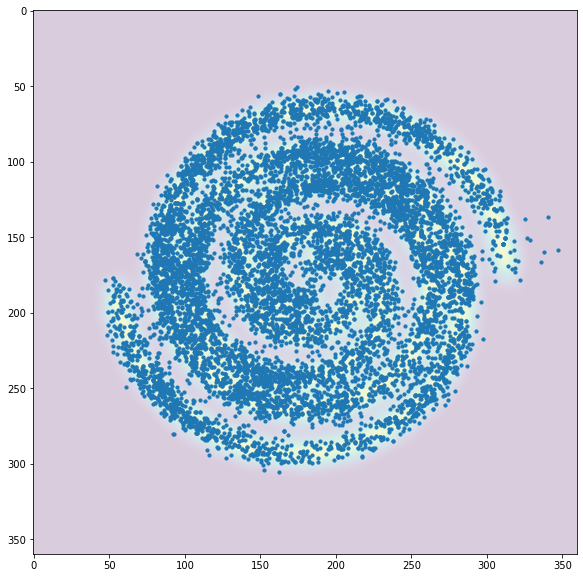

In [ ]:
fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 1], sampled_outputs[:, :, 0], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

  0%|          | 3/10000 [00:21<18:54:03,  6.81s/it]

Metropolis- Hastings REJECT 1.0075632 1.943595


  0%|          | 6/10000 [00:39<17:39:23,  6.36s/it]

Metropolis- Hastings REJECT 1.016547 1.3449618


  0%|          | 11/10000 [01:10<17:13:06,  6.21s/it]

Metropolis- Hastings REJECT 1.0161198 2.1512108


  0%|          | 12/10000 [01:16<17:06:50,  6.17s/it]

Metropolis- Hastings REJECT 1.0161198 2.3098946


  0%|          | 24/10000 [02:29<16:45:54,  6.05s/it]

Metropolis- Hastings REJECT 1.0571556 1.5879202


  0%|          | 27/10000 [02:47<16:38:09,  6.01s/it]

Metropolis- Hastings REJECT 1.3415871 1.5108689


  0%|          | 46/10000 [04:43<16:42:45,  6.04s/it]

Metropolis- Hastings REJECT 1.0411255 1.0742232


  1%|          | 71/10000 [07:15<16:54:57,  6.13s/it]

Metropolis- Hastings REJECT 1.0016907 1.1644022


  1%|          | 87/10000 [08:52<16:38:48,  6.05s/it]

Metropolis- Hastings REJECT 1.199289 1.6806993


  1%|          | 88/10000 [08:59<16:51:28,  6.12s/it]

Metropolis- Hastings REJECT 1.199289 1.5040172


  1%|          | 92/10000 [09:23<16:48:19,  6.11s/it]

Metropolis- Hastings REJECT 1.0319922 2.0945187


  1%|          | 98/10000 [10:00<16:54:00,  6.14s/it]

Metropolis- Hastings REJECT 0.9441788 2.7112885


  1%|          | 105/10000 [10:42<16:47:56,  6.11s/it]

Metropolis- Hastings REJECT 0.94220304 2.9521384


  1%|          | 109/10000 [11:07<16:42:08,  6.08s/it]

Metropolis- Hastings REJECT 1.0221417 3.5530012


  1%|▏         | 126/10000 [12:50<16:45:06,  6.11s/it]

Metropolis- Hastings REJECT 1.0401688 2.1165082


  1%|▏         | 131/10000 [13:20<16:34:01,  6.04s/it]

Metropolis- Hastings REJECT 1.0588717 1.6309142


  1%|▏         | 138/10000 [14:02<16:29:31,  6.02s/it]

Metropolis- Hastings REJECT 1.1566578 1.5631276


  1%|▏         | 149/10000 [15:09<16:36:22,  6.07s/it]

Metropolis- Hastings REJECT 1.0526574 1.6713793


  2%|▏         | 151/10000 [15:21<16:32:40,  6.05s/it]

Metropolis- Hastings REJECT 0.9587374 3.117825


  2%|▏         | 154/10000 [15:39<16:21:33,  5.98s/it]

Metropolis- Hastings REJECT 1.055372 1.970458


  2%|▏         | 156/10000 [15:51<16:22:21,  5.99s/it]

Metropolis- Hastings REJECT 1.1045717 1.6094788


  2%|▏         | 159/10000 [16:09<16:45:24,  6.13s/it]

Metropolis- Hastings REJECT 1.0730194 1.3065218


  2%|▏         | 160/10000 [16:16<16:43:33,  6.12s/it]

Metropolis- Hastings REJECT 1.0730194 3.521916


  2%|▏         | 161/10000 [16:21<16:33:19,  6.06s/it]

Metropolis- Hastings REJECT 1.0730194 3.5112164


  2%|▏         | 168/10000 [17:04<16:38:56,  6.10s/it]

Metropolis- Hastings REJECT 1.0485511 1.4822692


  2%|▏         | 169/10000 [17:10<16:35:35,  6.08s/it]

Metropolis- Hastings REJECT 1.0485511 3.1649575


  2%|▏         | 173/10000 [17:34<16:31:47,  6.06s/it]

Metropolis- Hastings REJECT 1.0471085 1.1175829


  2%|▏         | 181/10000 [18:22<16:21:55,  6.00s/it]

Metropolis- Hastings REJECT 1.1693308 3.5128074


  2%|▏         | 184/10000 [18:40<16:23:28,  6.01s/it]

Metropolis- Hastings REJECT 1.0032071 2.543605


  2%|▏         | 189/10000 [19:11<16:32:17,  6.07s/it]

Metropolis- Hastings REJECT 1.969681 2.787622


  2%|▏         | 198/10000 [20:06<16:36:26,  6.10s/it]

Metropolis- Hastings REJECT 1.3937094 1.6291351


  2%|▏         | 205/10000 [20:48<16:40:01,  6.13s/it]

Metropolis- Hastings REJECT 0.9717788 1.2517394


  2%|▏         | 207/10000 [21:01<16:35:01,  6.10s/it]

Metropolis- Hastings REJECT 1.0084493 1.8199179


  2%|▏         | 234/10000 [23:42<16:22:13,  6.03s/it]

Metropolis- Hastings REJECT 0.94984585 2.3386755


  2%|▏         | 246/10000 [24:54<16:19:16,  6.02s/it]

Metropolis- Hastings REJECT 1.1714319 2.0013175


  3%|▎         | 255/10000 [25:49<16:22:05,  6.05s/it]

Metropolis- Hastings REJECT 0.9817123 1.5860047


  3%|▎         | 258/10000 [26:08<16:37:59,  6.15s/it]

Metropolis- Hastings REJECT 0.93266356 0.98587817


  3%|▎         | 263/10000 [26:38<16:27:51,  6.09s/it]

Metropolis- Hastings REJECT 1.1350014 2.1850636


  3%|▎         | 266/10000 [26:56<16:21:46,  6.05s/it]

Metropolis- Hastings REJECT 1.0713993 3.5495896


  3%|▎         | 267/10000 [27:02<16:25:13,  6.07s/it]

Metropolis- Hastings REJECT 1.0713993 1.52263


  3%|▎         | 276/10000 [27:57<16:24:59,  6.08s/it]

Metropolis- Hastings REJECT 1.139355 3.5514934


  3%|▎         | 285/10000 [28:51<16:28:42,  6.11s/it]

Metropolis- Hastings REJECT 1.2434734 1.9078015


  3%|▎         | 294/10000 [29:46<16:24:55,  6.09s/it]

Metropolis- Hastings REJECT 0.99214804 1.0855454


  3%|▎         | 303/10000 [30:40<16:13:29,  6.02s/it]

Metropolis- Hastings REJECT 1.118488 1.358067


  3%|▎         | 307/10000 [31:05<16:22:44,  6.08s/it]

Metropolis- Hastings REJECT 1.4610075 3.523168


  3%|▎         | 308/10000 [31:11<16:30:42,  6.13s/it]

Metropolis- Hastings REJECT 1.4610075 3.5628242


  3%|▎         | 316/10000 [31:59<16:23:07,  6.09s/it]

Metropolis- Hastings REJECT 1.1862887 2.1037078


  3%|▎         | 323/10000 [32:41<16:05:32,  5.99s/it]

Metropolis- Hastings REJECT 1.1738454 3.1905632


  3%|▎         | 338/10000 [34:11<16:07:50,  6.01s/it]

Metropolis- Hastings REJECT 0.9523628 2.0715275


  4%|▎         | 358/10000 [36:12<16:13:49,  6.06s/it]

Metropolis- Hastings REJECT 0.9953288 2.2652817


  4%|▎         | 361/10000 [36:30<16:15:45,  6.07s/it]

Metropolis- Hastings REJECT 1.3981178 3.5104356


  4%|▎         | 365/10000 [36:54<16:05:12,  6.01s/it]

Metropolis- Hastings REJECT 1.5951246 3.5515034


  4%|▎         | 366/10000 [37:00<16:05:40,  6.01s/it]

Metropolis- Hastings REJECT 1.5951246 2.4338386


  4%|▍         | 384/10000 [38:47<15:52:26,  5.94s/it]

Metropolis- Hastings REJECT 1.0739881 3.5598412


  4%|▍         | 388/10000 [39:11<15:56:31,  5.97s/it]

Metropolis- Hastings REJECT 1.2557249 1.4520371


  4%|▍         | 404/10000 [40:47<16:06:42,  6.04s/it]

Metropolis- Hastings REJECT 1.0578802 1.4342269


  4%|▍         | 410/10000 [41:23<15:55:11,  5.98s/it]

Metropolis- Hastings REJECT 0.98293746 1.1520828


  4%|▍         | 412/10000 [41:35<15:57:43,  5.99s/it]

Metropolis- Hastings REJECT 1.0373363 2.3402534


  4%|▍         | 439/10000 [44:18<16:02:29,  6.04s/it]

Metropolis- Hastings REJECT 1.1479464 3.550768


  4%|▍         | 443/10000 [44:41<15:48:42,  5.96s/it]

Metropolis- Hastings REJECT 1.1165005 1.1899054


  4%|▍         | 448/10000 [45:11<15:55:18,  6.00s/it]

Metropolis- Hastings REJECT 1.0537694 3.5091672


  5%|▍         | 458/10000 [46:12<16:15:32,  6.13s/it]

Metropolis- Hastings REJECT 1.0428814 1.2707913


  5%|▍         | 477/10000 [48:03<15:25:43,  5.83s/it]

Metropolis- Hastings REJECT 1.0312927 1.2834004


  5%|▍         | 487/10000 [49:02<15:39:57,  5.93s/it]

Metropolis- Hastings REJECT 0.9501281 1.4011039


  5%|▍         | 496/10000 [49:55<15:25:36,  5.84s/it]

Metropolis- Hastings REJECT 1.4305722 1.6431541


  5%|▌         | 503/10000 [50:36<15:24:16,  5.84s/it]

Metropolis- Hastings REJECT 0.9976294 1.022477


  5%|▌         | 504/10000 [50:42<15:28:40,  5.87s/it]

Metropolis- Hastings REJECT 0.9976294 2.127243


  5%|▌         | 516/10000 [51:54<16:01:01,  6.08s/it]

Metropolis- Hastings REJECT 0.9884372 1.7145379


  5%|▌         | 527/10000 [53:00<15:53:54,  6.04s/it]

Metropolis- Hastings REJECT 1.0097882 2.0766714


  5%|▌         | 529/10000 [53:12<15:51:09,  6.03s/it]

Metropolis- Hastings REJECT 1.0930616 1.4201927


  5%|▌         | 542/10000 [54:31<15:46:10,  6.00s/it]

Metropolis- Hastings REJECT 1.5132129 1.8298454


  6%|▌         | 550/10000 [55:19<15:43:27,  5.99s/it]

Metropolis- Hastings REJECT 1.0128107 1.2602122


  6%|▌         | 551/10000 [55:25<15:55:38,  6.07s/it]

Metropolis- Hastings REJECT 1.0128107 2.4787836


  6%|▌         | 560/10000 [56:20<16:02:07,  6.12s/it]

Metropolis- Hastings REJECT 1.6075773 2.4701986


  6%|▌         | 577/10000 [58:02<15:46:45,  6.03s/it]

Metropolis- Hastings REJECT 0.9101543 1.3486531


  6%|▌         | 582/10000 [58:32<15:53:32,  6.07s/it]

Metropolis- Hastings REJECT 0.9689851 1.110987


  6%|▌         | 583/10000 [58:39<15:58:13,  6.11s/it]

Metropolis- Hastings REJECT 0.9689851 1.1811343


  6%|▌         | 615/10000 [1:01:53<15:56:36,  6.12s/it]

Metropolis- Hastings REJECT 1.001051 1.4063433


  6%|▌         | 619/10000 [1:02:17<15:37:24,  6.00s/it]

Metropolis- Hastings REJECT 1.1417904 1.6872871


  6%|▌         | 622/10000 [1:02:35<15:34:59,  5.98s/it]

Metropolis- Hastings REJECT 1.184121 1.599047


  6%|▌         | 623/10000 [1:02:41<15:41:37,  6.03s/it]

Metropolis- Hastings REJECT 1.184121 1.6684917


  6%|▋         | 630/10000 [1:03:23<15:47:39,  6.07s/it]

Metropolis- Hastings REJECT 1.1446197 2.25426


  6%|▋         | 638/10000 [1:04:11<15:41:58,  6.04s/it]

Metropolis- Hastings REJECT 1.1141543 3.528983


  6%|▋         | 644/10000 [1:04:47<15:39:54,  6.03s/it]

Metropolis- Hastings REJECT 1.2734191 2.5453322


  7%|▋         | 655/10000 [1:05:53<15:39:28,  6.03s/it]

Metropolis- Hastings REJECT 0.98542434 1.2217858


  7%|▋         | 660/10000 [1:06:24<15:44:45,  6.07s/it]

Metropolis- Hastings REJECT 1.6357367 3.53895


  7%|▋         | 680/10000 [1:08:23<15:29:22,  5.98s/it]

Metropolis- Hastings REJECT 0.9821182 1.1185647


  7%|▋         | 681/10000 [1:08:29<15:28:13,  5.98s/it]

Metropolis- Hastings REJECT 0.9821182 1.2589109


  7%|▋         | 690/10000 [1:09:23<15:42:27,  6.07s/it]

Metropolis- Hastings REJECT 1.548042 2.401705


  7%|▋         | 695/10000 [1:09:53<15:36:14,  6.04s/it]

Metropolis- Hastings REJECT 0.99405015 1.2848483


  7%|▋         | 698/10000 [1:10:12<15:36:29,  6.04s/it]

Metropolis- Hastings REJECT 1.1460711 1.3408551


  7%|▋         | 701/10000 [1:10:30<15:39:08,  6.06s/it]

Metropolis- Hastings REJECT 1.4240301 3.2344813


  7%|▋         | 703/10000 [1:10:42<15:25:48,  5.97s/it]

Metropolis- Hastings REJECT 1.2785623 1.374616


  7%|▋         | 715/10000 [1:11:53<15:35:44,  6.05s/it]

Metropolis- Hastings REJECT 1.0893607 2.384043


  7%|▋         | 720/10000 [1:12:23<15:22:33,  5.96s/it]

Metropolis- Hastings REJECT 1.1011204 2.1151235


  7%|▋         | 721/10000 [1:12:29<15:36:28,  6.06s/it]

Metropolis- Hastings REJECT 1.1011204 2.4513972


  7%|▋         | 722/10000 [1:12:35<15:31:41,  6.03s/it]

Metropolis- Hastings REJECT 1.1011204 2.3755257


  7%|▋         | 723/10000 [1:12:41<15:28:02,  6.00s/it]

Metropolis- Hastings REJECT 1.1011204 2.1108925


  7%|▋         | 724/10000 [1:12:47<15:27:13,  6.00s/it]

Metropolis- Hastings REJECT 1.1011204 1.7696316


  7%|▋         | 725/10000 [1:12:53<15:44:17,  6.11s/it]

Metropolis- Hastings REJECT 1.1011204 1.627655


  7%|▋         | 734/10000 [1:13:47<15:30:07,  6.02s/it]

Metropolis- Hastings REJECT 1.0455947 1.4933794


  7%|▋         | 735/10000 [1:13:53<15:30:21,  6.02s/it]

Metropolis- Hastings REJECT 1.0455947 1.2619828


  7%|▋         | 739/10000 [1:14:17<15:29:31,  6.02s/it]

Metropolis- Hastings REJECT 1.1698257 2.4313478


  7%|▋         | 745/10000 [1:14:53<15:34:01,  6.06s/it]

Metropolis- Hastings REJECT 0.9901592 1.4842345


  7%|▋         | 747/10000 [1:15:05<15:30:00,  6.03s/it]

Metropolis- Hastings REJECT 1.939494 3.2670794


  8%|▊         | 750/10000 [1:15:23<15:26:06,  6.01s/it]

Metropolis- Hastings REJECT 3.5319366 inf


  8%|▊         | 755/10000 [1:15:53<15:27:35,  6.02s/it]

Metropolis- Hastings REJECT 3.5104496 inf


  8%|▊         | 756/10000 [1:15:59<15:21:58,  5.98s/it]

Metropolis- Hastings REJECT 3.5104496 inf


  8%|▊         | 759/10000 [1:16:18<15:32:08,  6.05s/it]

Metropolis- Hastings REJECT 3.517484 inf


  8%|▊         | 760/10000 [1:16:24<15:30:48,  6.04s/it]

Metropolis- Hastings REJECT 3.517484 inf


  8%|▊         | 762/10000 [1:16:35<15:22:49,  5.99s/it]

Metropolis- Hastings REJECT 3.5125349 inf


  8%|▊         | 763/10000 [1:16:41<15:22:26,  5.99s/it]

Metropolis- Hastings REJECT 3.5125349 inf


  8%|▊         | 764/10000 [1:16:48<15:38:39,  6.10s/it]

Metropolis- Hastings REJECT 3.5125349 inf


  8%|▊         | 765/10000 [1:16:54<15:46:37,  6.15s/it]

Metropolis- Hastings REJECT 3.5125349 inf


  8%|▊         | 769/10000 [1:17:18<15:32:33,  6.06s/it]

Metropolis- Hastings REJECT 1.8080072 3.5369585


  8%|▊         | 773/10000 [1:17:43<15:36:14,  6.09s/it]

Metropolis- Hastings REJECT 1.0045743 1.497025


  8%|▊         | 776/10000 [1:18:01<15:37:22,  6.10s/it]

Metropolis- Hastings REJECT 1.0905914 3.5423687


  8%|▊         | 795/10000 [1:19:55<15:08:31,  5.92s/it]

Metropolis- Hastings REJECT 1.4891311 3.5556953


  8%|▊         | 801/10000 [1:20:31<15:25:42,  6.04s/it]

Metropolis- Hastings REJECT 0.9672281 1.0485821


  8%|▊         | 811/10000 [1:21:31<15:16:20,  5.98s/it]

Metropolis- Hastings REJECT 1.1249772 1.6049432


  8%|▊         | 820/10000 [1:22:25<15:17:44,  6.00s/it]

Metropolis- Hastings REJECT 1.0488762 3.5593977


  8%|▊         | 826/10000 [1:23:01<15:13:56,  5.98s/it]

Metropolis- Hastings REJECT 1.0788133 1.9280108


  8%|▊         | 827/10000 [1:23:07<15:14:00,  5.98s/it]

Metropolis- Hastings REJECT 1.0788133 1.2739958


  8%|▊         | 829/10000 [1:23:19<15:05:20,  5.92s/it]

Metropolis- Hastings REJECT 1.0923128 1.1542908


  8%|▊         | 832/10000 [1:23:37<15:28:27,  6.08s/it]

Metropolis- Hastings REJECT 1.1496414 2.6093066


  9%|▊         | 859/10000 [1:26:18<15:12:38,  5.99s/it]

Metropolis- Hastings REJECT 1.0066774 1.0968992


  9%|▊         | 867/10000 [1:27:05<15:13:16,  6.00s/it]

Metropolis- Hastings REJECT 1.3000611 1.6697667


  9%|▊         | 871/10000 [1:27:30<15:17:45,  6.03s/it]

Metropolis- Hastings REJECT 1.0565093 1.4369301


  9%|▉         | 886/10000 [1:28:59<15:03:07,  5.95s/it]

Metropolis- Hastings REJECT 0.97821677 1.9207479


  9%|▉         | 890/10000 [1:29:22<14:49:11,  5.86s/it]

Metropolis- Hastings REJECT 1.0088737 2.0012245


  9%|▉         | 892/10000 [1:29:34<15:01:29,  5.94s/it]

Metropolis- Hastings REJECT 1.0304314 1.5463212


  9%|▉         | 894/10000 [1:29:46<15:12:12,  6.01s/it]

Metropolis- Hastings REJECT 1.079432 3.5316105


  9%|▉         | 895/10000 [1:29:52<15:14:42,  6.03s/it]

Metropolis- Hastings REJECT 1.079432 1.569386


  9%|▉         | 896/10000 [1:29:59<15:20:27,  6.07s/it]

Metropolis- Hastings REJECT 1.079432 1.7595745


  9%|▉         | 911/10000 [1:31:28<15:10:39,  6.01s/it]

Metropolis- Hastings REJECT 1.083861 3.4464293


  9%|▉         | 919/10000 [1:32:17<15:10:33,  6.02s/it]

Metropolis- Hastings REJECT 0.9569398 3.5643148


  9%|▉         | 920/10000 [1:32:23<15:30:19,  6.15s/it]

Metropolis- Hastings REJECT 0.9569398 3.3500354


  9%|▉         | 928/10000 [1:33:11<15:22:20,  6.10s/it]

Metropolis- Hastings REJECT 1.0483128 1.1757201


  9%|▉         | 930/10000 [1:33:23<15:10:41,  6.02s/it]

Metropolis- Hastings REJECT 1.0007432 1.5123531


  9%|▉         | 934/10000 [1:33:47<15:03:31,  5.98s/it]

Metropolis- Hastings REJECT 1.0578268 1.1232111


 10%|▉         | 951/10000 [1:35:29<15:04:42,  6.00s/it]

Metropolis- Hastings REJECT 1.0365424 3.4726908


 10%|▉         | 959/10000 [1:36:17<15:06:55,  6.02s/it]

Metropolis- Hastings REJECT 0.99910116 1.4157026


 10%|▉         | 964/10000 [1:36:47<15:06:09,  6.02s/it]

Metropolis- Hastings REJECT 0.9327037 3.4802866


 10%|▉         | 965/10000 [1:36:53<15:12:02,  6.06s/it]

Metropolis- Hastings REJECT 0.9327037 1.0817664


 10%|▉         | 970/10000 [1:37:23<15:10:03,  6.05s/it]

Metropolis- Hastings REJECT 1.0242697 1.2203667


 10%|▉         | 977/10000 [1:38:06<15:11:13,  6.06s/it]

Metropolis- Hastings REJECT 0.9926024 1.1334574


 10%|▉         | 978/10000 [1:38:11<15:04:30,  6.02s/it]

Metropolis- Hastings REJECT 0.9926024 1.0408759


 10%|▉         | 991/10000 [1:39:30<14:57:12,  5.98s/it]

Metropolis- Hastings REJECT 1.3988572 1.6479552


 10%|█         | 1002/10000 [1:40:36<15:00:34,  6.01s/it]

Metropolis- Hastings REJECT 1.1244653 1.3550475


 10%|█         | 1018/10000 [1:42:12<15:07:28,  6.06s/it]

Metropolis- Hastings REJECT 1.1014603 2.6768124


 10%|█         | 1026/10000 [1:43:00<15:05:31,  6.05s/it]

Metropolis- Hastings REJECT 1.04467 1.9344412


 10%|█         | 1029/10000 [1:43:18<15:09:33,  6.08s/it]

Metropolis- Hastings REJECT 1.2030213 3.540162


 10%|█         | 1035/10000 [1:43:54<15:10:10,  6.09s/it]

Metropolis- Hastings REJECT 1.2341006 1.5819888


 10%|█         | 1041/10000 [1:44:31<15:17:31,  6.14s/it]

Metropolis- Hastings REJECT 0.9418264 1.2682406


 10%|█         | 1045/10000 [1:44:55<15:01:13,  6.04s/it]

Metropolis- Hastings REJECT 1.0508904 1.8610804


 10%|█         | 1046/10000 [1:45:01<14:57:28,  6.01s/it]

Metropolis- Hastings REJECT 1.0508904 1.7111366


 11%|█         | 1051/10000 [1:45:31<14:56:20,  6.01s/it]

Metropolis- Hastings REJECT 1.1045609 1.8042065


 11%|█         | 1059/10000 [1:46:19<14:56:48,  6.02s/it]

Metropolis- Hastings REJECT 2.488565 3.281115


 11%|█         | 1070/10000 [1:47:24<14:28:53,  5.84s/it]

Metropolis- Hastings REJECT 1.1523435 1.9835442


 11%|█         | 1073/10000 [1:47:41<14:32:57,  5.87s/it]

Metropolis- Hastings REJECT 1.2245226 2.8715634


 11%|█         | 1077/10000 [1:48:05<14:51:00,  5.99s/it]

Metropolis- Hastings REJECT 1.0457247 1.6104127


 11%|█         | 1081/10000 [1:48:29<14:35:01,  5.89s/it]

Metropolis- Hastings REJECT 1.516923 3.523908


 11%|█         | 1083/10000 [1:48:41<14:29:16,  5.85s/it]

Metropolis- Hastings REJECT 1.1342583 2.271101


 11%|█         | 1086/10000 [1:48:58<14:20:53,  5.79s/it]

Metropolis- Hastings REJECT 1.6087723 1.7607739


 11%|█         | 1088/10000 [1:49:09<14:12:21,  5.74s/it]

Metropolis- Hastings REJECT 1.0307692 1.3043183


 11%|█         | 1089/10000 [1:49:15<14:14:23,  5.75s/it]

Metropolis- Hastings REJECT 1.0307692 3.05006


 11%|█         | 1109/10000 [1:51:12<14:33:46,  5.90s/it]

Metropolis- Hastings REJECT 1.0170143 3.5173874


 11%|█         | 1110/10000 [1:51:18<14:40:45,  5.94s/it]

Metropolis- Hastings REJECT 1.0170143 2.5054226


 11%|█         | 1120/10000 [1:52:18<15:14:28,  6.18s/it]

Metropolis- Hastings REJECT 1.0090313 3.5436323


 11%|█▏        | 1126/10000 [1:52:55<15:05:30,  6.12s/it]

Metropolis- Hastings REJECT 0.99003434 1.331463


 11%|█▏        | 1134/10000 [1:53:43<14:56:25,  6.07s/it]

Metropolis- Hastings REJECT 1.1833845 1.5196674


 11%|█▏        | 1138/10000 [1:54:07<14:41:23,  5.97s/it]

Metropolis- Hastings REJECT 1.0130721 1.4233947


 11%|█▏        | 1141/10000 [1:54:25<15:03:17,  6.12s/it]

Metropolis- Hastings REJECT 0.90864813 1.2042937


 12%|█▏        | 1152/10000 [1:55:31<14:47:07,  6.02s/it]

Metropolis- Hastings REJECT 1.2691664 1.6034654


 12%|█▏        | 1166/10000 [1:56:56<14:49:58,  6.04s/it]

Metropolis- Hastings REJECT 1.1707802 2.0460913


 12%|█▏        | 1167/10000 [1:57:02<14:54:06,  6.07s/it]

Metropolis- Hastings REJECT 1.1707802 2.0891309


 12%|█▏        | 1171/10000 [1:57:26<14:45:46,  6.02s/it]

Metropolis- Hastings REJECT 0.9855203 1.0752299


 12%|█▏        | 1172/10000 [1:57:32<14:41:21,  5.99s/it]

Metropolis- Hastings REJECT 0.9855203 2.8399487


 12%|█▏        | 1187/10000 [1:59:02<14:48:58,  6.05s/it]

Metropolis- Hastings REJECT 0.9195361 1.1308297


 12%|█▏        | 1198/10000 [2:00:08<14:40:24,  6.00s/it]

Metropolis- Hastings REJECT 0.96822894 2.1415942


 12%|█▏        | 1201/10000 [2:00:26<14:46:06,  6.04s/it]

Metropolis- Hastings REJECT 1.0716115 2.3977838


 12%|█▏        | 1209/10000 [2:01:14<14:47:16,  6.06s/it]

Metropolis- Hastings REJECT 1.5854015 1.974843


 12%|█▏        | 1210/10000 [2:01:20<14:42:02,  6.02s/it]

Metropolis- Hastings REJECT 1.5854015 3.5252872


 12%|█▏        | 1214/10000 [2:01:45<14:53:49,  6.10s/it]

Metropolis- Hastings REJECT 1.2055119 2.5714388


 12%|█▏        | 1215/10000 [2:01:51<14:57:00,  6.13s/it]

Metropolis- Hastings REJECT 1.2055119 1.818862


 12%|█▏        | 1217/10000 [2:02:03<14:49:20,  6.08s/it]

Metropolis- Hastings REJECT 1.198554 1.247797


 12%|█▏        | 1219/10000 [2:02:15<14:47:08,  6.06s/it]

Metropolis- Hastings REJECT 1.1073587 1.9659479


 12%|█▏        | 1221/10000 [2:02:27<14:56:53,  6.13s/it]

Metropolis- Hastings REJECT 1.0175667 1.3432233


 12%|█▏        | 1239/10000 [2:04:16<14:40:21,  6.03s/it]

Metropolis- Hastings REJECT 1.0794792 2.3175008


 12%|█▏        | 1240/10000 [2:04:22<14:51:49,  6.11s/it]

Metropolis- Hastings REJECT 1.0794792 3.5352075


 13%|█▎        | 1275/10000 [2:07:52<14:40:56,  6.06s/it]

Metropolis- Hastings REJECT 0.954077 1.1451361


 13%|█▎        | 1281/10000 [2:08:28<14:34:55,  6.02s/it]

Metropolis- Hastings REJECT 1.0165771 1.5213499


 13%|█▎        | 1288/10000 [2:09:11<14:47:46,  6.11s/it]

Metropolis- Hastings REJECT 1.4630986 2.3807993


 13%|█▎        | 1296/10000 [2:09:59<14:45:51,  6.11s/it]

Metropolis- Hastings REJECT 1.0106033 1.4022619


 13%|█▎        | 1298/10000 [2:10:11<14:43:31,  6.09s/it]

Metropolis- Hastings REJECT 0.99999166 1.0581646


 13%|█▎        | 1309/10000 [2:11:17<14:30:29,  6.01s/it]

Metropolis- Hastings REJECT 1.0773243 1.7414591


 13%|█▎        | 1321/10000 [2:12:29<14:28:57,  6.01s/it]

Metropolis- Hastings REJECT 0.99289215 2.2530594


 13%|█▎        | 1325/10000 [2:12:53<14:29:52,  6.02s/it]

Metropolis- Hastings REJECT 1.0748882 3.5195491


 13%|█▎        | 1326/10000 [2:12:59<14:26:42,  6.00s/it]

Metropolis- Hastings REJECT 1.0748882 1.8853655


 13%|█▎        | 1338/10000 [2:14:11<14:16:44,  5.93s/it]

Metropolis- Hastings REJECT 1.024381 1.0869535


 13%|█▎        | 1343/10000 [2:14:40<14:20:11,  5.96s/it]

Metropolis- Hastings REJECT 1.027845 1.2319671


 13%|█▎        | 1344/10000 [2:14:46<14:21:13,  5.97s/it]

Metropolis- Hastings REJECT 1.027845 1.1541718


 13%|█▎        | 1346/10000 [2:14:59<14:33:55,  6.06s/it]

Metropolis- Hastings REJECT 1.051447 1.1312929


 13%|█▎        | 1347/10000 [2:15:05<14:34:51,  6.07s/it]

Metropolis- Hastings REJECT 1.051447 3.5381148


 14%|█▎        | 1353/10000 [2:15:41<14:31:15,  6.05s/it]

Metropolis- Hastings REJECT 0.980787 1.1477112


 14%|█▎        | 1360/10000 [2:16:23<14:28:14,  6.03s/it]

Metropolis- Hastings REJECT 0.9911549 1.1193268


 14%|█▎        | 1365/10000 [2:16:53<14:35:05,  6.08s/it]

Metropolis- Hastings REJECT 0.97213674 3.54701


 14%|█▎        | 1369/10000 [2:17:17<14:32:43,  6.07s/it]

Metropolis- Hastings REJECT 1.14022 3.5439591


 14%|█▎        | 1372/10000 [2:17:35<14:25:32,  6.02s/it]

Metropolis- Hastings REJECT 1.0338011 1.5678183


 14%|█▍        | 1381/10000 [2:18:29<14:14:37,  5.95s/it]

Metropolis- Hastings REJECT 1.0417631 1.584993


 14%|█▍        | 1404/10000 [2:20:46<14:09:13,  5.93s/it]

Metropolis- Hastings REJECT 0.9741286 2.8119147


 14%|█▍        | 1406/10000 [2:20:59<14:22:24,  6.02s/it]

Metropolis- Hastings REJECT 1.1001734 2.4898915


 14%|█▍        | 1412/10000 [2:21:35<14:30:22,  6.08s/it]

Metropolis- Hastings REJECT 1.1358942 2.0239043


 14%|█▍        | 1417/10000 [2:22:05<14:23:47,  6.04s/it]

Metropolis- Hastings REJECT 1.0958295 3.516126


 14%|█▍        | 1425/10000 [2:22:52<14:08:52,  5.94s/it]

Metropolis- Hastings REJECT 2.0565834 3.54097


 14%|█▍        | 1429/10000 [2:23:16<14:18:19,  6.01s/it]

Metropolis- Hastings REJECT 0.9982524 1.2362183


 15%|█▍        | 1452/10000 [2:25:35<14:26:39,  6.08s/it]

Metropolis- Hastings REJECT 1.0045302 1.2359376


 15%|█▍        | 1455/10000 [2:25:53<14:41:17,  6.19s/it]

Metropolis- Hastings REJECT 1.238139 2.5723867


 15%|█▍        | 1474/10000 [2:27:47<14:19:05,  6.05s/it]

Metropolis- Hastings REJECT 1.0078601 3.5280218


 15%|█▍        | 1478/10000 [2:28:11<14:34:36,  6.16s/it]

Metropolis- Hastings REJECT 1.2809919 1.6192557


 15%|█▍        | 1488/10000 [2:29:11<14:01:51,  5.93s/it]

Metropolis- Hastings REJECT 1.2775803 3.0953932


 15%|█▍        | 1491/10000 [2:29:29<14:19:36,  6.06s/it]

Metropolis- Hastings REJECT 1.1992204 1.2584336


 15%|█▍        | 1495/10000 [2:29:53<14:06:40,  5.97s/it]

Metropolis- Hastings REJECT 1.0648341 3.1492007


 15%|█▍        | 1498/10000 [2:30:11<14:10:05,  6.00s/it]

Metropolis- Hastings REJECT 1.0944042 3.5233428


 15%|█▌        | 1502/10000 [2:30:35<14:21:22,  6.08s/it]

Metropolis- Hastings REJECT 1.156873 3.5593197


 15%|█▌        | 1503/10000 [2:30:41<14:29:32,  6.14s/it]

Metropolis- Hastings REJECT 1.156873 3.5371516


 15%|█▌        | 1510/10000 [2:31:24<14:24:45,  6.11s/it]

Metropolis- Hastings REJECT 0.97013617 3.5281317


 15%|█▌        | 1513/10000 [2:31:42<14:05:23,  5.98s/it]

Metropolis- Hastings REJECT 1.1482021 1.7267938


 15%|█▌        | 1516/10000 [2:32:00<14:15:54,  6.05s/it]

Metropolis- Hastings REJECT 0.9619911 1.1455418


 15%|█▌        | 1530/10000 [2:33:25<14:14:28,  6.05s/it]

Metropolis- Hastings REJECT 0.983819 3.5211287


 15%|█▌        | 1545/10000 [2:34:55<14:07:37,  6.02s/it]

Metropolis- Hastings REJECT 1.0494896 2.1429214


 15%|█▌        | 1546/10000 [2:35:01<14:02:05,  5.98s/it]

Metropolis- Hastings REJECT 1.0494896 1.4964308


 16%|█▌        | 1553/10000 [2:35:44<14:21:37,  6.12s/it]

Metropolis- Hastings REJECT 0.9850229 1.1253555


 16%|█▌        | 1554/10000 [2:35:50<14:18:27,  6.10s/it]

Metropolis- Hastings REJECT 0.9850229 1.7833558


 16%|█▌        | 1562/10000 [2:36:38<14:11:27,  6.05s/it]

Metropolis- Hastings REJECT 1.0162822 1.8134301


 16%|█▌        | 1563/10000 [2:36:45<14:29:58,  6.19s/it]

Metropolis- Hastings REJECT 1.0162822 1.1488092


 16%|█▌        | 1567/10000 [2:37:09<14:10:18,  6.05s/it]

Metropolis- Hastings REJECT 1.0292553 1.5025055


 16%|█▌        | 1569/10000 [2:37:21<14:23:03,  6.14s/it]

Metropolis- Hastings REJECT 1.5843306 3.533054


 16%|█▌        | 1575/10000 [2:37:57<14:11:55,  6.07s/it]

Metropolis- Hastings REJECT 0.9957864 3.5615845


 16%|█▌        | 1576/10000 [2:38:04<14:17:01,  6.10s/it]

Metropolis- Hastings REJECT 0.9957864 1.3816803


 16%|█▌        | 1577/10000 [2:38:10<14:05:42,  6.02s/it]

Metropolis- Hastings REJECT 0.9957864 1.1428405


 16%|█▌        | 1584/10000 [2:38:51<14:01:07,  6.00s/it]

Metropolis- Hastings REJECT 0.9688728 1.8983616


 16%|█▌        | 1592/10000 [2:39:40<14:11:22,  6.08s/it]

Metropolis- Hastings REJECT 1.745235 2.0244257


 16%|█▌        | 1593/10000 [2:39:46<14:13:02,  6.09s/it]

Metropolis- Hastings REJECT 1.745235 2.4775863


 16%|█▌        | 1602/10000 [2:40:40<14:01:04,  6.01s/it]

Metropolis- Hastings REJECT 0.9503569 1.0216719


 16%|█▌        | 1607/10000 [2:41:10<14:04:04,  6.03s/it]

Metropolis- Hastings REJECT 1.0096471 3.543862


 16%|█▌        | 1621/10000 [2:42:34<13:57:50,  6.00s/it]

Metropolis- Hastings REJECT 1.0794003 1.3123267


 16%|█▋        | 1626/10000 [2:43:04<13:59:34,  6.02s/it]

Metropolis- Hastings REJECT 1.0455704 1.6189017


 16%|█▋        | 1633/10000 [2:43:45<13:53:55,  5.98s/it]

Metropolis- Hastings REJECT 1.2755955 2.0392685


 16%|█▋        | 1639/10000 [2:44:21<13:58:17,  6.02s/it]

Metropolis- Hastings REJECT 1.0140939 3.531451


 16%|█▋        | 1640/10000 [2:44:27<13:59:44,  6.03s/it]

Metropolis- Hastings REJECT 1.0140939 1.4754589


 16%|█▋        | 1650/10000 [2:45:28<14:01:59,  6.05s/it]

Metropolis- Hastings REJECT 1.0924704 2.707497


 17%|█▋        | 1654/10000 [2:45:52<14:06:39,  6.09s/it]

Metropolis- Hastings REJECT 1.2302353 1.4893341


 17%|█▋        | 1660/10000 [2:46:28<13:46:42,  5.95s/it]

Metropolis- Hastings REJECT 1.0359805 1.1828668


 17%|█▋        | 1661/10000 [2:46:34<13:49:55,  5.97s/it]

Metropolis- Hastings REJECT 1.0359805 1.2759508


 17%|█▋        | 1666/10000 [2:47:03<13:48:13,  5.96s/it]

Metropolis- Hastings REJECT 1.0234107 1.2483544


 17%|█▋        | 1668/10000 [2:47:15<13:44:46,  5.94s/it]

Metropolis- Hastings REJECT 1.0515964 2.0082524


 17%|█▋        | 1672/10000 [2:47:38<13:30:05,  5.84s/it]

Metropolis- Hastings REJECT 1.4817108 1.9989897


 17%|█▋        | 1673/10000 [2:47:44<13:31:30,  5.85s/it]

Metropolis- Hastings REJECT 1.4817108 3.4591398


 17%|█▋        | 1684/10000 [2:48:48<13:41:35,  5.93s/it]

Metropolis- Hastings REJECT 1.0516663 1.812522


 17%|█▋        | 1688/10000 [2:49:12<13:23:41,  5.80s/it]

Metropolis- Hastings REJECT 1.2898616 2.718512


 17%|█▋        | 1693/10000 [2:49:41<13:29:39,  5.85s/it]

Metropolis- Hastings REJECT 1.1152031 3.0951242


 17%|█▋        | 1702/10000 [2:50:33<13:20:41,  5.79s/it]

Metropolis- Hastings REJECT 1.0920187 2.4429307


 17%|█▋        | 1708/10000 [2:51:09<13:50:56,  6.01s/it]

Metropolis- Hastings REJECT 1.003221 2.0640543


 17%|█▋        | 1723/10000 [2:52:39<13:45:24,  5.98s/it]

Metropolis- Hastings REJECT 1.0109993 1.5115169


 17%|█▋        | 1726/10000 [2:52:57<13:53:00,  6.04s/it]

Metropolis- Hastings REJECT 1.3922358 3.4469244


 17%|█▋        | 1732/10000 [2:53:33<13:49:24,  6.02s/it]

Metropolis- Hastings REJECT 1.0645835 1.3305748


 17%|█▋        | 1744/10000 [2:54:45<13:52:57,  6.05s/it]

Metropolis- Hastings REJECT 1.4661858 2.3150725


 18%|█▊        | 1750/10000 [2:55:22<14:14:40,  6.22s/it]

Metropolis- Hastings REJECT 0.9555831 3.5244067


 18%|█▊        | 1756/10000 [2:55:59<13:55:53,  6.08s/it]

Metropolis- Hastings REJECT 1.4838116 1.6225139


 18%|█▊        | 1757/10000 [2:56:05<13:51:17,  6.05s/it]

Metropolis- Hastings REJECT 1.4838116 3.515483


 18%|█▊        | 1780/10000 [2:58:23<13:45:35,  6.03s/it]

Metropolis- Hastings REJECT 1.1393583 1.9314736


 18%|█▊        | 1785/10000 [2:58:53<13:42:14,  6.01s/it]

Metropolis- Hastings REJECT 1.0368998 1.4165395


 18%|█▊        | 1786/10000 [2:58:59<13:51:40,  6.08s/it]

Metropolis- Hastings REJECT 1.0368998 1.179954


 18%|█▊        | 1792/10000 [2:59:36<13:47:25,  6.05s/it]

Metropolis- Hastings REJECT 1.0423574 1.2442529


 18%|█▊        | 1794/10000 [2:59:47<13:40:44,  6.00s/it]

Metropolis- Hastings REJECT 0.98328125 1.2408712


 18%|█▊        | 1811/10000 [3:01:30<13:37:41,  5.99s/it]

Metropolis- Hastings REJECT 1.0663725 1.4733297


 18%|█▊        | 1817/10000 [3:02:06<13:35:31,  5.98s/it]

Metropolis- Hastings REJECT 1.3531256 3.5502534


 18%|█▊        | 1818/10000 [3:02:12<13:32:50,  5.96s/it]

Metropolis- Hastings REJECT 1.3531256 3.5384998


 18%|█▊        | 1824/10000 [3:02:47<13:39:49,  6.02s/it]

Metropolis- Hastings REJECT 0.9714954 2.0925403


 18%|█▊        | 1825/10000 [3:02:53<13:38:11,  6.01s/it]

Metropolis- Hastings REJECT 0.9714954 1.1304312


 18%|█▊        | 1839/10000 [3:04:19<13:48:02,  6.09s/it]

Metropolis- Hastings REJECT 1.0290201 1.4481822


 18%|█▊        | 1844/10000 [3:04:48<13:34:38,  5.99s/it]

Metropolis- Hastings REJECT 0.98431563 1.3108981


 18%|█▊        | 1845/10000 [3:04:54<13:32:42,  5.98s/it]

Metropolis- Hastings REJECT 0.98431563 1.0489963


 18%|█▊        | 1846/10000 [3:05:00<13:31:29,  5.97s/it]

Metropolis- Hastings REJECT 0.98431563 2.3849833


 18%|█▊        | 1847/10000 [3:05:06<13:36:03,  6.01s/it]

Metropolis- Hastings REJECT 0.98431563 1.387872


 18%|█▊        | 1848/10000 [3:05:12<13:37:22,  6.02s/it]

Metropolis- Hastings REJECT 0.98431563 2.2988763


 19%|█▊        | 1857/10000 [3:06:06<13:26:54,  5.95s/it]

Metropolis- Hastings REJECT 1.1538827 1.4805679


 19%|█▊        | 1861/10000 [3:06:30<13:30:43,  5.98s/it]

Metropolis- Hastings REJECT 1.1883945 1.5379679


 19%|█▉        | 1885/10000 [3:08:55<13:38:27,  6.05s/it]

Metropolis- Hastings REJECT 1.1685594 1.5582516


 19%|█▉        | 1901/10000 [3:10:31<13:47:55,  6.13s/it]

Metropolis- Hastings REJECT 0.9694445 1.0156674


 19%|█▉        | 1909/10000 [3:11:19<13:33:06,  6.03s/it]

Metropolis- Hastings REJECT 0.9641739 1.0934384


 19%|█▉        | 1917/10000 [3:12:08<13:42:21,  6.10s/it]

Metropolis- Hastings REJECT 1.6580449 3.5519145


 19%|█▉        | 1926/10000 [3:13:02<13:28:13,  6.01s/it]

Metropolis- Hastings REJECT 0.9763609 1.1289712


 20%|█▉        | 1951/10000 [3:15:31<13:42:06,  6.13s/it]

Metropolis- Hastings REJECT 1.6555668 2.311818


 20%|█▉        | 1960/10000 [3:16:25<13:20:13,  5.97s/it]

Metropolis- Hastings REJECT 1.1643254 1.507315


 20%|█▉        | 1968/10000 [3:17:13<13:26:40,  6.03s/it]

Metropolis- Hastings REJECT 0.9852648 1.2392243


 20%|█▉        | 1972/10000 [3:17:37<13:17:51,  5.96s/it]

Metropolis- Hastings REJECT 1.183397 2.4196382


 20%|█▉        | 1973/10000 [3:17:43<13:26:24,  6.03s/it]

Metropolis- Hastings REJECT 1.183397 1.3523256


 20%|█▉        | 1984/10000 [3:18:49<13:20:34,  5.99s/it]

Metropolis- Hastings REJECT 1.3369527 3.514997


 20%|█▉        | 1988/10000 [3:19:13<13:31:30,  6.08s/it]

Metropolis- Hastings REJECT 1.0915424 2.49786


 20%|██        | 2006/10000 [3:21:01<13:34:06,  6.11s/it]

Metropolis- Hastings REJECT 1.035718 1.2592971


 20%|██        | 2015/10000 [3:21:56<13:19:14,  6.01s/it]

Metropolis- Hastings REJECT 1.7575791 3.526291


 20%|██        | 2020/10000 [3:22:25<13:05:17,  5.90s/it]

Metropolis- Hastings REJECT 0.99616694 1.155954


 20%|██        | 2024/10000 [3:22:49<13:14:33,  5.98s/it]

Metropolis- Hastings REJECT 1.9113523 3.5304742


 20%|██        | 2031/10000 [3:23:31<13:16:49,  6.00s/it]

Metropolis- Hastings REJECT 1.0874643 3.5594795


 20%|██        | 2033/10000 [3:23:44<13:25:02,  6.06s/it]

Metropolis- Hastings REJECT 1.0440013 3.525294


 20%|██        | 2036/10000 [3:24:01<13:09:59,  5.95s/it]

Metropolis- Hastings REJECT 0.9704298 1.1400466


 20%|██        | 2044/10000 [3:24:49<13:15:20,  6.00s/it]

Metropolis- Hastings REJECT 0.91986 3.562791


 20%|██        | 2046/10000 [3:25:01<13:16:20,  6.01s/it]

Metropolis- Hastings REJECT 1.1645927 2.2156284


 20%|██        | 2049/10000 [3:25:19<13:20:52,  6.04s/it]

Metropolis- Hastings REJECT 1.1943554 1.4208504


 20%|██        | 2050/10000 [3:25:25<13:17:07,  6.02s/it]

Metropolis- Hastings REJECT 1.1943554 1.9236467


 21%|██        | 2052/10000 [3:25:37<13:13:22,  5.99s/it]

Metropolis- Hastings REJECT 1.7695249 3.5297294


 21%|██        | 2054/10000 [3:25:49<13:29:50,  6.12s/it]

Metropolis- Hastings REJECT 1.0130327 1.704779


 21%|██        | 2058/10000 [3:26:14<13:44:22,  6.23s/it]

Metropolis- Hastings REJECT 0.9582096 1.1117551


 21%|██        | 2062/10000 [3:26:39<13:40:11,  6.20s/it]

Metropolis- Hastings REJECT 1.1737839 3.5297384


 21%|██        | 2065/10000 [3:26:57<13:25:57,  6.09s/it]

Metropolis- Hastings REJECT 0.994514 1.7546159


 21%|██        | 2066/10000 [3:27:03<13:20:40,  6.06s/it]

Metropolis- Hastings REJECT 0.994514 1.8376809


 21%|██        | 2071/10000 [3:27:33<13:06:08,  5.95s/it]

Metropolis- Hastings REJECT 1.0647287 2.7945073


 21%|██        | 2075/10000 [3:27:56<13:07:52,  5.96s/it]

Metropolis- Hastings REJECT 0.9847926 2.6567156


 21%|██        | 2089/10000 [3:29:20<13:13:49,  6.02s/it]

Metropolis- Hastings REJECT 1.346044 2.4624279


 21%|██        | 2102/10000 [3:30:38<13:10:11,  6.00s/it]

Metropolis- Hastings REJECT 1.7568367 2.5613039


 21%|██        | 2118/10000 [3:32:14<13:07:01,  5.99s/it]

Metropolis- Hastings REJECT 0.9823066 1.5632976


 21%|██        | 2122/10000 [3:32:38<13:03:26,  5.97s/it]

Metropolis- Hastings REJECT 1.1083171 2.5717847


 21%|██▏       | 2126/10000 [3:33:02<13:13:25,  6.05s/it]

Metropolis- Hastings REJECT 1.3439941 2.039522


 21%|██▏       | 2130/10000 [3:33:26<13:06:49,  6.00s/it]

Metropolis- Hastings REJECT 1.013548 1.7754536


 21%|██▏       | 2135/10000 [3:33:56<13:05:32,  5.99s/it]

Metropolis- Hastings REJECT 1.0849546 2.328485


 22%|██▏       | 2154/10000 [3:35:49<13:11:26,  6.05s/it]

Metropolis- Hastings REJECT 1.0903739 2.737631


 22%|██▏       | 2161/10000 [3:36:31<13:08:25,  6.03s/it]

Metropolis- Hastings REJECT 1.331781 1.9777175


 22%|██▏       | 2176/10000 [3:38:02<13:15:02,  6.10s/it]

Metropolis- Hastings REJECT 0.9705998 1.1594381


 22%|██▏       | 2179/10000 [3:38:20<13:10:28,  6.06s/it]

Metropolis- Hastings REJECT 1.0208716 3.561579


 22%|██▏       | 2184/10000 [3:38:50<12:59:50,  5.99s/it]

Metropolis- Hastings REJECT 1.1276225 1.9933054


 22%|██▏       | 2188/10000 [3:39:13<12:39:40,  5.83s/it]

Metropolis- Hastings REJECT 1.0462886 2.028115


 22%|██▏       | 2192/10000 [3:39:36<12:33:03,  5.79s/it]

Metropolis- Hastings REJECT 1.0105753 2.531107


 22%|██▏       | 2195/10000 [3:39:53<12:34:42,  5.80s/it]

Metropolis- Hastings REJECT 1.2107656 1.5380147


 22%|██▏       | 2196/10000 [3:39:59<12:34:51,  5.80s/it]

Metropolis- Hastings REJECT 1.2107656 3.445511


 22%|██▏       | 2200/10000 [3:40:22<12:24:14,  5.72s/it]

Metropolis- Hastings REJECT 1.0930756 1.5205642


 22%|██▏       | 2205/10000 [3:40:51<12:22:50,  5.72s/it]

Metropolis- Hastings REJECT 1.0422761 1.5787259


 22%|██▏       | 2214/10000 [3:41:43<12:30:03,  5.78s/it]

Metropolis- Hastings REJECT 1.4298068 3.5240185


 22%|██▏       | 2221/10000 [3:42:23<12:34:04,  5.82s/it]

Metropolis- Hastings REJECT 1.0207826 1.7510724


 22%|██▏       | 2223/10000 [3:42:35<12:50:17,  5.94s/it]

Metropolis- Hastings REJECT 1.0665745 1.1877834


 22%|██▏       | 2226/10000 [3:42:53<12:43:29,  5.89s/it]

Metropolis- Hastings REJECT 1.0919118 1.3113401


 22%|██▏       | 2232/10000 [3:43:28<12:32:03,  5.81s/it]

Metropolis- Hastings REJECT 1.3001972 3.5513592


 22%|██▏       | 2234/10000 [3:43:39<12:28:58,  5.79s/it]

Metropolis- Hastings REJECT 0.90157104 1.1568445


 22%|██▏       | 2237/10000 [3:43:57<12:35:18,  5.84s/it]

Metropolis- Hastings REJECT 1.1205723 3.4742343


 23%|██▎       | 2251/10000 [3:45:18<12:32:06,  5.82s/it]

Metropolis- Hastings REJECT 1.0699617 2.6241305


 23%|██▎       | 2252/10000 [3:45:24<12:41:37,  5.90s/it]

Metropolis- Hastings REJECT 1.0699617 1.1749336


 23%|██▎       | 2257/10000 [3:45:53<12:31:11,  5.82s/it]

Metropolis- Hastings REJECT 1.0307605 1.20628


 23%|██▎       | 2276/10000 [3:47:41<12:02:35,  5.61s/it]

Metropolis- Hastings REJECT 1.0579841 1.94592


 23%|██▎       | 2277/10000 [3:47:47<12:05:22,  5.64s/it]

Metropolis- Hastings REJECT 1.0579841 1.5208805


 23%|██▎       | 2292/10000 [3:49:10<11:57:35,  5.59s/it]

Metropolis- Hastings REJECT 1.0853916 3.5514069


 23%|██▎       | 2295/10000 [3:49:27<12:04:42,  5.64s/it]

Metropolis- Hastings REJECT 0.96979237 1.4810216


 23%|██▎       | 2300/10000 [3:49:55<11:56:40,  5.58s/it]

Metropolis- Hastings REJECT 1.0343678 2.6207156


 23%|██▎       | 2312/10000 [3:51:03<12:20:02,  5.78s/it]

Metropolis- Hastings REJECT 0.96468395 1.2430727


 23%|██▎       | 2325/10000 [3:52:19<12:28:20,  5.85s/it]

Metropolis- Hastings REJECT 1.0970393 1.5527983


 23%|██▎       | 2333/10000 [3:53:05<12:14:16,  5.75s/it]

Metropolis- Hastings REJECT 0.9776262 1.3599004


 23%|██▎       | 2334/10000 [3:53:11<12:19:31,  5.79s/it]

Metropolis- Hastings REJECT 0.9776262 1.1512357


 23%|██▎       | 2335/10000 [3:53:16<12:17:26,  5.77s/it]

Metropolis- Hastings REJECT 0.9776262 1.5417967


 24%|██▎       | 2355/10000 [3:55:11<12:08:55,  5.72s/it]

Metropolis- Hastings REJECT 0.980659 1.4878494


 24%|██▎       | 2356/10000 [3:55:17<12:11:56,  5.75s/it]

Metropolis- Hastings REJECT 0.980659 1.1877394


 24%|██▎       | 2363/10000 [3:55:58<12:24:00,  5.85s/it]

Metropolis- Hastings REJECT 0.98995674 1.477844


 24%|██▎       | 2370/10000 [3:56:38<12:20:29,  5.82s/it]

Metropolis- Hastings REJECT 1.0484463 1.7736924


 24%|██▍       | 2385/10000 [3:58:04<12:04:11,  5.71s/it]

Metropolis- Hastings REJECT 0.9652957 1.6233088


 24%|██▍       | 2398/10000 [3:59:19<12:01:09,  5.69s/it]

Metropolis- Hastings REJECT 1.108644 1.9851981


 24%|██▍       | 2403/10000 [3:59:47<12:09:29,  5.76s/it]

Metropolis- Hastings REJECT 0.9406697 3.5350046


 24%|██▍       | 2405/10000 [3:59:59<12:15:15,  5.81s/it]

Metropolis- Hastings REJECT 1.0790627 1.228281


 24%|██▍       | 2409/10000 [4:00:22<12:02:10,  5.71s/it]

Metropolis- Hastings REJECT 1.0172781 1.8820177


 24%|██▍       | 2420/10000 [4:01:25<12:21:18,  5.87s/it]

Metropolis- Hastings REJECT 0.9487716 0.97597367


 24%|██▍       | 2422/10000 [4:01:37<12:18:29,  5.85s/it]

Metropolis- Hastings REJECT 1.2385635 1.8331509


 24%|██▍       | 2423/10000 [4:01:43<12:19:12,  5.85s/it]

Metropolis- Hastings REJECT 1.2385635 1.7201204


 24%|██▍       | 2426/10000 [4:02:00<12:20:33,  5.87s/it]

Metropolis- Hastings REJECT 1.2319336 1.7202106


 24%|██▍       | 2431/10000 [4:02:30<12:21:27,  5.88s/it]

Metropolis- Hastings REJECT 1.4800942 3.5328128


 24%|██▍       | 2440/10000 [4:03:22<12:19:40,  5.87s/it]

Metropolis- Hastings REJECT 0.93748116 1.2928541


 24%|██▍       | 2441/10000 [4:03:28<12:22:42,  5.90s/it]

Metropolis- Hastings REJECT 0.93748116 2.3510842


 25%|██▍       | 2456/10000 [4:04:55<12:07:44,  5.79s/it]

Metropolis- Hastings REJECT 0.9932091 1.1171887


 25%|██▍       | 2462/10000 [4:05:30<12:13:38,  5.84s/it]

Metropolis- Hastings REJECT 1.3863363 1.6207048


 25%|██▍       | 2475/10000 [4:06:44<11:58:30,  5.73s/it]

Metropolis- Hastings REJECT 1.5128361 2.402932


 25%|██▍       | 2482/10000 [4:07:25<12:07:23,  5.81s/it]

Metropolis- Hastings REJECT 1.0780876 1.4225255


 25%|██▍       | 2489/10000 [4:08:07<12:23:33,  5.94s/it]

Metropolis- Hastings REJECT 0.97084916 1.2206107


 25%|██▍       | 2496/10000 [4:08:47<12:14:21,  5.87s/it]

Metropolis- Hastings REJECT 0.9632973 1.881491


 25%|██▍       | 2497/10000 [4:08:53<12:09:53,  5.84s/it]

Metropolis- Hastings REJECT 0.9632973 1.8845571


 25%|██▌       | 2501/10000 [4:09:17<12:11:25,  5.85s/it]

Metropolis- Hastings REJECT 1.1466749 1.8901006


 25%|██▌       | 2502/10000 [4:09:22<12:10:10,  5.84s/it]

Metropolis- Hastings REJECT 1.1466749 1.654202


 25%|██▌       | 2505/10000 [4:09:40<12:10:40,  5.85s/it]

Metropolis- Hastings REJECT 1.1093764 3.5266025


 25%|██▌       | 2511/10000 [4:10:14<12:02:21,  5.79s/it]

Metropolis- Hastings REJECT 0.9428692 1.4211148


 25%|██▌       | 2529/10000 [4:11:59<12:07:33,  5.84s/it]

Metropolis- Hastings REJECT 1.5517247 3.5523086


 25%|██▌       | 2537/10000 [4:12:46<12:13:12,  5.89s/it]

Metropolis- Hastings REJECT 1.1750877 1.5742797


 25%|██▌       | 2540/10000 [4:13:04<12:06:34,  5.84s/it]

Metropolis- Hastings REJECT 1.0251517 1.0371581


 25%|██▌       | 2547/10000 [4:13:45<12:09:40,  5.87s/it]

Metropolis- Hastings REJECT 1.0082176 1.3444947


 25%|██▌       | 2548/10000 [4:13:51<12:05:05,  5.84s/it]

Metropolis- Hastings REJECT 1.0082176 1.8337128


 25%|██▌       | 2549/10000 [4:13:57<12:11:56,  5.89s/it]

Metropolis- Hastings REJECT 1.0082176 1.2651438


 26%|██▌       | 2550/10000 [4:14:02<12:06:17,  5.85s/it]

Metropolis- Hastings REJECT 1.0082176 1.5128982


 26%|██▌       | 2559/10000 [4:14:55<11:58:06,  5.79s/it]

Metropolis- Hastings REJECT 0.9721575 3.5330858


 26%|██▌       | 2560/10000 [4:15:01<12:06:21,  5.86s/it]

Metropolis- Hastings REJECT 0.9721575 1.1106274


 26%|██▌       | 2568/10000 [4:15:47<12:07:31,  5.87s/it]

Metropolis- Hastings REJECT 0.9984015 2.5414221


 26%|██▌       | 2576/10000 [4:16:34<11:57:37,  5.80s/it]

Metropolis- Hastings REJECT 1.1965333 1.7555324


 26%|██▌       | 2584/10000 [4:17:20<12:07:38,  5.89s/it]

Metropolis- Hastings REJECT 1.95014 3.5227022


 26%|██▌       | 2602/10000 [4:19:05<11:57:19,  5.82s/it]

Metropolis- Hastings REJECT 0.9793246 1.3142531


 26%|██▌       | 2604/10000 [4:19:17<11:56:36,  5.81s/it]

Metropolis- Hastings REJECT 0.9597634 1.7448709


 26%|██▌       | 2610/10000 [4:19:52<12:05:43,  5.89s/it]

Metropolis- Hastings REJECT 1.0825248 1.3130307


 26%|██▌       | 2617/10000 [4:20:33<11:50:20,  5.77s/it]

Metropolis- Hastings REJECT 1.0991025 1.5417117


 26%|██▋       | 2625/10000 [4:21:20<11:59:01,  5.85s/it]

Metropolis- Hastings REJECT 1.1803554 3.5230775


 26%|██▋       | 2631/10000 [4:21:54<11:56:27,  5.83s/it]

Metropolis- Hastings REJECT 1.0414355 1.938686


 26%|██▋       | 2638/10000 [4:22:35<11:55:07,  5.83s/it]

Metropolis- Hastings REJECT 0.96592027 3.547304


 26%|██▋       | 2649/10000 [4:23:39<11:50:12,  5.80s/it]

Metropolis- Hastings REJECT 1.1413591 2.1152506


 27%|██▋       | 2657/10000 [4:24:26<11:57:04,  5.86s/it]

Metropolis- Hastings REJECT 1.000001 1.8013662


 27%|██▋       | 2665/10000 [4:25:12<11:43:56,  5.76s/it]

Metropolis- Hastings REJECT 0.9775917 1.0334159


 27%|██▋       | 2666/10000 [4:25:18<11:45:00,  5.77s/it]

Metropolis- Hastings REJECT 0.9775917 1.738467


 27%|██▋       | 2711/10000 [4:29:39<11:40:34,  5.77s/it]

Metropolis- Hastings REJECT 1.1414361 2.1039243


 27%|██▋       | 2712/10000 [4:29:45<11:47:01,  5.82s/it]

Metropolis- Hastings REJECT 1.1414361 1.7472886


 27%|██▋       | 2713/10000 [4:29:51<11:49:38,  5.84s/it]

Metropolis- Hastings REJECT 1.1414361 1.5234625


 27%|██▋       | 2715/10000 [4:30:02<11:42:46,  5.79s/it]

Metropolis- Hastings REJECT 1.2895415 3.5567753


 27%|██▋       | 2718/10000 [4:30:20<11:59:09,  5.93s/it]

Metropolis- Hastings REJECT 1.0203733 1.0466769


 27%|██▋       | 2723/10000 [4:30:50<12:06:35,  5.99s/it]

Metropolis- Hastings REJECT 0.9905496 3.5459528


 27%|██▋       | 2724/10000 [4:30:56<11:58:20,  5.92s/it]

Metropolis- Hastings REJECT 0.9905496 1.9721092


 27%|██▋       | 2729/10000 [4:31:25<11:51:41,  5.87s/it]

Metropolis- Hastings REJECT 1.273201 3.5206425


 27%|██▋       | 2732/10000 [4:31:42<11:37:45,  5.76s/it]

Metropolis- Hastings REJECT 1.0447829 1.3587471


 27%|██▋       | 2735/10000 [4:32:00<11:47:23,  5.84s/it]

Metropolis- Hastings REJECT 1.2343096 1.338691


 27%|██▋       | 2738/10000 [4:32:17<11:46:02,  5.83s/it]

Metropolis- Hastings REJECT 0.9737449 1.8611155


 27%|██▋       | 2739/10000 [4:32:23<11:43:48,  5.82s/it]

Metropolis- Hastings REJECT 0.9737449 1.4677653


 27%|██▋       | 2746/10000 [4:33:04<11:44:40,  5.83s/it]

Metropolis- Hastings REJECT 0.9654903 1.0560871


 28%|██▊       | 2753/10000 [4:33:45<11:47:56,  5.86s/it]

Metropolis- Hastings REJECT 1.199664 2.6506293


 28%|██▊       | 2754/10000 [4:33:50<11:48:47,  5.87s/it]

Metropolis- Hastings REJECT 1.199664 2.4763024


 28%|██▊       | 2757/10000 [4:34:08<11:51:05,  5.89s/it]

Metropolis- Hastings REJECT 1.2336904 1.6180568


 28%|██▊       | 2766/10000 [4:35:00<11:35:40,  5.77s/it]

Metropolis- Hastings REJECT 1.3185722 1.7621455


 28%|██▊       | 2770/10000 [4:35:24<11:40:22,  5.81s/it]

Metropolis- Hastings REJECT 0.9215424 1.2408992


 28%|██▊       | 2773/10000 [4:35:41<11:42:50,  5.84s/it]

Metropolis- Hastings REJECT 1.2208097 3.5324938


 28%|██▊       | 2783/10000 [4:36:39<11:32:25,  5.76s/it]

Metropolis- Hastings REJECT 1.0611405 1.1169214


 28%|██▊       | 2792/10000 [4:37:31<11:35:46,  5.79s/it]

Metropolis- Hastings REJECT 1.2744871 2.0288508


 28%|██▊       | 2827/10000 [4:40:56<11:50:11,  5.94s/it]

Metropolis- Hastings REJECT 1.1974385 2.2027545


 28%|██▊       | 2832/10000 [4:41:26<12:02:08,  6.04s/it]

Metropolis- Hastings REJECT 1.0065199 3.5249753


 28%|██▊       | 2839/10000 [4:42:08<12:03:48,  6.06s/it]

Metropolis- Hastings REJECT 0.9831429 1.3664579


 29%|██▊       | 2857/10000 [4:43:58<12:10:59,  6.14s/it]

Metropolis- Hastings REJECT 1.4570147 2.0358036


 29%|██▊       | 2859/10000 [4:44:10<12:07:55,  6.12s/it]

Metropolis- Hastings REJECT 1.0205345 2.0806274


 29%|██▊       | 2863/10000 [4:44:33<11:56:11,  6.02s/it]

Metropolis- Hastings REJECT 1.0242739 1.7583356


 29%|██▊       | 2865/10000 [4:44:46<12:02:00,  6.07s/it]

Metropolis- Hastings REJECT 1.0764585 3.0335672


 29%|██▊       | 2868/10000 [4:45:04<12:06:33,  6.11s/it]

Metropolis- Hastings REJECT 0.9896649 2.2423446


 29%|██▊       | 2869/10000 [4:45:10<12:06:33,  6.11s/it]

Metropolis- Hastings REJECT 0.9896649 2.1011915


 29%|██▊       | 2873/10000 [4:45:34<11:58:32,  6.05s/it]

Metropolis- Hastings REJECT 0.99461013 3.5206716


 29%|██▉       | 2881/10000 [4:46:22<11:46:09,  5.95s/it]

Metropolis- Hastings REJECT 0.95999885 2.1751518


 29%|██▉       | 2882/10000 [4:46:28<11:40:19,  5.90s/it]

Metropolis- Hastings REJECT 0.95999885 1.0386592


 29%|██▉       | 2886/10000 [4:46:51<11:31:39,  5.83s/it]

Metropolis- Hastings REJECT 0.9622385 1.2926444


 29%|██▉       | 2887/10000 [4:46:57<11:27:44,  5.80s/it]

Metropolis- Hastings REJECT 0.9622385 3.4217763


 29%|██▉       | 2888/10000 [4:47:02<11:21:28,  5.75s/it]

Metropolis- Hastings REJECT 0.9622385 1.110197


 29%|██▉       | 2890/10000 [4:47:14<11:10:41,  5.66s/it]

Metropolis- Hastings REJECT 1.0128766 2.2810292


 29%|██▉       | 2894/10000 [4:47:36<11:01:13,  5.58s/it]

Metropolis- Hastings REJECT 0.9025114 1.2318718


 29%|██▉       | 2900/10000 [4:48:09<11:04:54,  5.62s/it]

Metropolis- Hastings REJECT 1.0141797 1.3131123


 29%|██▉       | 2903/10000 [4:48:27<11:11:20,  5.68s/it]

Metropolis- Hastings REJECT 0.95829856 1.5576016


 29%|██▉       | 2906/10000 [4:48:43<11:08:49,  5.66s/it]

Metropolis- Hastings REJECT 0.96805394 0.99991685


 29%|██▉       | 2919/10000 [4:49:57<11:15:41,  5.73s/it]

Metropolis- Hastings REJECT 0.9870535 1.0897483


 29%|██▉       | 2926/10000 [4:50:36<11:06:35,  5.65s/it]

Metropolis- Hastings REJECT 1.3984814 3.5598679


 29%|██▉       | 2938/10000 [4:51:46<11:30:14,  5.86s/it]

Metropolis- Hastings REJECT 1.1918824 3.546894


 30%|██▉       | 2962/10000 [4:54:05<11:25:16,  5.84s/it]

Metropolis- Hastings REJECT 1.0432539 2.968865


 30%|██▉       | 2964/10000 [4:54:17<11:28:01,  5.87s/it]

Metropolis- Hastings REJECT 1.1092665 1.6637166


 30%|██▉       | 2968/10000 [4:54:40<11:16:50,  5.78s/it]

Metropolis- Hastings REJECT 1.1246057 2.0905225


 30%|██▉       | 2972/10000 [4:55:03<11:15:43,  5.77s/it]

Metropolis- Hastings REJECT 0.9632753 1.2621886


 30%|██▉       | 2976/10000 [4:55:26<11:18:47,  5.80s/it]

Metropolis- Hastings REJECT 1.1719189 3.4213974


 30%|███       | 3009/10000 [4:58:37<11:17:07,  5.81s/it]

Metropolis- Hastings REJECT 0.9659766 1.7376056


 30%|███       | 3015/10000 [4:59:12<11:21:19,  5.85s/it]

Metropolis- Hastings REJECT 1.2131879 2.0333412


 30%|███       | 3017/10000 [4:59:24<11:18:42,  5.83s/it]

Metropolis- Hastings REJECT 0.950469 1.4085321


 30%|███       | 3021/10000 [4:59:47<11:20:12,  5.85s/it]

Metropolis- Hastings REJECT 1.7986046 3.0856814


 31%|███       | 3052/10000 [5:02:52<11:36:12,  6.01s/it]

Metropolis- Hastings REJECT 0.99918056 2.7374265


 31%|███       | 3085/10000 [5:06:08<11:30:35,  5.99s/it]

Metropolis- Hastings REJECT 1.1299099 1.3479173


 31%|███       | 3088/10000 [5:06:27<11:36:08,  6.04s/it]

Metropolis- Hastings REJECT 1.0449681 1.8990352


 31%|███       | 3100/10000 [5:07:38<11:22:07,  5.93s/it]

Metropolis- Hastings REJECT 1.0101514 3.353561


 31%|███       | 3101/10000 [5:07:44<11:25:10,  5.96s/it]

Metropolis- Hastings REJECT 1.0101514 1.1824273


 31%|███       | 3106/10000 [5:08:14<11:25:06,  5.96s/it]

Metropolis- Hastings REJECT 1.2202027 1.4673748


 31%|███       | 3107/10000 [5:08:20<11:24:00,  5.95s/it]

Metropolis- Hastings REJECT 1.2202027 1.7012887


 31%|███       | 3109/10000 [5:08:32<11:30:00,  6.01s/it]

Metropolis- Hastings REJECT 1.1195831 1.3660057


 31%|███       | 3120/10000 [5:09:38<11:32:59,  6.04s/it]

Metropolis- Hastings REJECT 1.0276685 2.2913227


 31%|███▏      | 3134/10000 [5:11:03<11:32:41,  6.05s/it]

Metropolis- Hastings REJECT 1.1237537 1.5371825


 31%|███▏      | 3141/10000 [5:11:45<11:32:23,  6.06s/it]

Metropolis- Hastings REJECT 0.9713555 1.1877052


 32%|███▏      | 3154/10000 [5:13:02<11:20:21,  5.96s/it]

Metropolis- Hastings REJECT 3.524338 inf


 32%|███▏      | 3162/10000 [5:13:50<11:20:10,  5.97s/it]

Metropolis- Hastings REJECT 0.9795416 3.5284328


 32%|███▏      | 3166/10000 [5:14:14<11:27:53,  6.04s/it]

Metropolis- Hastings REJECT 0.94463897 1.3396544


 32%|███▏      | 3182/10000 [5:15:49<11:15:23,  5.94s/it]

Metropolis- Hastings REJECT 1.3315578 1.5554643


 32%|███▏      | 3188/10000 [5:16:25<11:16:14,  5.96s/it]

Metropolis- Hastings REJECT 1.1845613 1.773124


 32%|███▏      | 3192/10000 [5:16:49<11:26:08,  6.05s/it]

Metropolis- Hastings REJECT 1.0279101 1.239034


 32%|███▏      | 3206/10000 [5:18:13<11:11:15,  5.93s/it]

Metropolis- Hastings REJECT 1.0240617 1.4564786


 32%|███▏      | 3221/10000 [5:19:43<11:29:30,  6.10s/it]

Metropolis- Hastings REJECT 1.8541628 2.0801246


 32%|███▏      | 3232/10000 [5:20:50<11:29:33,  6.11s/it]

Metropolis- Hastings REJECT 1.1282109 2.0076673


 32%|███▏      | 3238/10000 [5:21:26<11:24:57,  6.08s/it]

Metropolis- Hastings REJECT 1.2287462 2.1464355


 32%|███▏      | 3239/10000 [5:21:32<11:18:31,  6.02s/it]

Metropolis- Hastings REJECT 1.2287462 2.317326


 32%|███▏      | 3244/10000 [5:22:02<11:22:22,  6.06s/it]

Metropolis- Hastings REJECT 1.2410841 1.8787516


 32%|███▏      | 3248/10000 [5:22:27<11:31:16,  6.14s/it]

Metropolis- Hastings REJECT 1.1373988 1.5207527


 33%|███▎      | 3260/10000 [5:23:38<11:14:30,  6.00s/it]

Metropolis- Hastings REJECT 1.152826 1.396638


 33%|███▎      | 3266/10000 [5:24:14<11:13:19,  6.00s/it]

Metropolis- Hastings REJECT 0.9940251 1.3137808


 33%|███▎      | 3282/10000 [5:25:51<11:17:04,  6.05s/it]

Metropolis- Hastings REJECT 1.0755877 1.5243201


 33%|███▎      | 3284/10000 [5:26:03<11:13:48,  6.02s/it]

Metropolis- Hastings REJECT 1.0284677 1.0942252


 33%|███▎      | 3289/10000 [5:26:33<11:21:11,  6.09s/it]

Metropolis- Hastings REJECT 1.0969067 3.5136147


 33%|███▎      | 3290/10000 [5:26:39<11:28:32,  6.16s/it]

Metropolis- Hastings REJECT 1.0969067 2.0404668


 33%|███▎      | 3302/10000 [5:27:51<11:07:13,  5.98s/it]

Metropolis- Hastings REJECT 1.2717886 1.6440917


 33%|███▎      | 3305/10000 [5:28:09<11:04:03,  5.95s/it]

Metropolis- Hastings REJECT 0.9610957 1.1735089


 33%|███▎      | 3306/10000 [5:28:16<11:17:09,  6.07s/it]

Metropolis- Hastings REJECT 0.9610957 1.3868862


 33%|███▎      | 3307/10000 [5:28:22<11:15:45,  6.06s/it]

Metropolis- Hastings REJECT 0.9610957 2.5235248


 33%|███▎      | 3308/10000 [5:28:27<11:12:03,  6.03s/it]

Metropolis- Hastings REJECT 0.9610957 2.485499


 33%|███▎      | 3321/10000 [5:29:45<11:09:22,  6.01s/it]

Metropolis- Hastings REJECT 1.0137768 1.7237055


 33%|███▎      | 3329/10000 [5:30:33<11:06:38,  6.00s/it]

Metropolis- Hastings REJECT 3.5106688 inf


 34%|███▎      | 3363/10000 [5:33:55<11:03:06,  5.99s/it]

Metropolis- Hastings REJECT 1.5570182 3.5360165


 34%|███▎      | 3372/10000 [5:34:49<11:12:57,  6.09s/it]

Metropolis- Hastings REJECT 0.95714206 1.0237384


 34%|███▍      | 3375/10000 [5:35:07<11:04:21,  6.02s/it]

Metropolis- Hastings REJECT 1.134136 1.5259532


 34%|███▍      | 3380/10000 [5:35:37<10:52:35,  5.91s/it]

Metropolis- Hastings REJECT 1.6550201 2.4178603


 34%|███▍      | 3394/10000 [5:36:58<10:33:10,  5.75s/it]

Metropolis- Hastings REJECT 1.2565612 3.5334108


 34%|███▍      | 3402/10000 [5:37:44<10:38:44,  5.81s/it]

Metropolis- Hastings REJECT 1.0639988 1.8538762


 34%|███▍      | 3403/10000 [5:37:50<10:38:04,  5.80s/it]

Metropolis- Hastings REJECT 1.0639988 1.9593452


 34%|███▍      | 3406/10000 [5:38:08<10:43:25,  5.85s/it]

Metropolis- Hastings REJECT 0.93342984 1.0155613


 34%|███▍      | 3407/10000 [5:38:14<10:46:55,  5.89s/it]

Metropolis- Hastings REJECT 0.93342984 2.2461026


 34%|███▍      | 3408/10000 [5:38:20<10:46:10,  5.88s/it]

Metropolis- Hastings REJECT 0.93342984 1.8241343


 34%|███▍      | 3416/10000 [5:39:06<10:38:32,  5.82s/it]

Metropolis- Hastings REJECT 1.0044377 2.1449218


 34%|███▍      | 3433/10000 [5:40:44<10:32:40,  5.78s/it]

Metropolis- Hastings REJECT 1.0466435 1.1746539


 34%|███▍      | 3445/10000 [5:41:54<10:32:47,  5.79s/it]

Metropolis- Hastings REJECT 1.1974063 2.0352166


 35%|███▍      | 3456/10000 [5:42:58<10:48:27,  5.95s/it]

Metropolis- Hastings REJECT 0.97172195 1.1212224


 35%|███▍      | 3475/10000 [5:44:48<10:23:34,  5.73s/it]

Metropolis- Hastings REJECT 1.467246 2.3672998


 35%|███▍      | 3490/10000 [5:46:14<10:22:00,  5.73s/it]

Metropolis- Hastings REJECT 0.95931435 1.5177753


 35%|███▍      | 3498/10000 [5:46:59<10:11:07,  5.64s/it]

Metropolis- Hastings REJECT 0.9372541 2.1443226


 35%|███▌      | 3500/10000 [5:47:10<10:13:16,  5.66s/it]

Metropolis- Hastings REJECT 1.017315 1.3276109


 35%|███▌      | 3504/10000 [5:47:33<10:01:15,  5.55s/it]

Metropolis- Hastings REJECT 1.1233501 1.7536174


 35%|███▌      | 3521/10000 [5:49:07<9:56:03,  5.52s/it]

Metropolis- Hastings REJECT 1.2711083 3.5464115


 35%|███▌      | 3523/10000 [5:49:18<9:59:54,  5.56s/it]

Metropolis- Hastings REJECT 1.0932596 3.539064


 35%|███▌      | 3531/10000 [5:50:03<10:06:43,  5.63s/it]

Metropolis- Hastings REJECT 0.9641794 1.6816986


 35%|███▌      | 3532/10000 [5:50:08<10:06:53,  5.63s/it]

Metropolis- Hastings REJECT 0.9641794 1.2029902


 35%|███▌      | 3534/10000 [5:50:20<10:10:27,  5.66s/it]

Metropolis- Hastings REJECT 0.916388 1.6998683


 35%|███▌      | 3538/10000 [5:50:42<10:10:29,  5.67s/it]

Metropolis- Hastings REJECT 1.1501027 1.6420369


 35%|███▌      | 3543/10000 [5:51:11<10:28:12,  5.84s/it]

Metropolis- Hastings REJECT 1.0318072 1.0863776


 35%|███▌      | 3549/10000 [5:51:46<10:20:56,  5.78s/it]

Metropolis- Hastings REJECT 1.137454 1.4969777


 36%|███▌      | 3553/10000 [5:52:09<10:21:44,  5.79s/it]

Metropolis- Hastings REJECT 1.2046804 1.9887447


 36%|███▌      | 3561/10000 [5:52:55<10:25:41,  5.83s/it]

Metropolis- Hastings REJECT 3.5084202 inf


 36%|███▌      | 3568/10000 [5:53:35<10:12:56,  5.72s/it]

Metropolis- Hastings REJECT 0.98324114 3.4846194


 36%|███▌      | 3571/10000 [5:53:53<10:14:34,  5.74s/it]

Metropolis- Hastings REJECT 1.0124111 2.2934637


 36%|███▌      | 3573/10000 [5:54:04<10:12:59,  5.72s/it]

Metropolis- Hastings REJECT 1.0447437 2.8584092


 36%|███▌      | 3584/10000 [5:55:07<10:10:09,  5.71s/it]

Metropolis- Hastings REJECT 0.9807722 2.2749274


 36%|███▌      | 3595/10000 [5:56:10<10:08:41,  5.70s/it]

Metropolis- Hastings REJECT 1.7744179 2.4539883


 36%|███▌      | 3606/10000 [5:57:14<10:22:42,  5.84s/it]

Metropolis- Hastings REJECT 0.9661409 1.5613778


 36%|███▌      | 3607/10000 [5:57:20<10:24:23,  5.86s/it]

Metropolis- Hastings REJECT 0.9661409 1.0687274


 36%|███▌      | 3614/10000 [5:58:00<10:13:34,  5.76s/it]

Metropolis- Hastings REJECT 0.96559286 1.1968598


 36%|███▌      | 3623/10000 [5:58:51<9:59:03,  5.64s/it] 

Metropolis- Hastings REJECT 3.5090933 3.5326836


 36%|███▋      | 3631/10000 [5:59:37<10:10:57,  5.76s/it]

Metropolis- Hastings REJECT 3.5148833 inf


 36%|███▋      | 3645/10000 [6:00:56<10:09:30,  5.75s/it]

Metropolis- Hastings REJECT 1.41173 2.861659


 36%|███▋      | 3648/10000 [6:01:14<10:11:42,  5.78s/it]

Metropolis- Hastings REJECT 1.1335366 1.3557078


 37%|███▋      | 3657/10000 [6:02:05<10:00:35,  5.68s/it]

Metropolis- Hastings REJECT 1.2246984 1.517558


 37%|███▋      | 3663/10000 [6:02:39<9:56:45,  5.65s/it]

Metropolis- Hastings REJECT 0.9504496 1.3339013


 37%|███▋      | 3669/10000 [6:03:13<9:54:48,  5.64s/it]

Metropolis- Hastings REJECT 1.1599262 1.6434735


 37%|███▋      | 3692/10000 [6:05:22<9:55:43,  5.67s/it]

Metropolis- Hastings REJECT 1.0014857 1.2949969


 37%|███▋      | 3693/10000 [6:05:28<9:56:49,  5.68s/it]

Metropolis- Hastings REJECT 1.0014857 2.1278968


 37%|███▋      | 3699/10000 [6:06:02<9:52:30,  5.64s/it]

Metropolis- Hastings REJECT 1.1422583 1.3467411


 37%|███▋      | 3704/10000 [6:06:30<9:55:31,  5.68s/it]

Metropolis- Hastings REJECT 0.9709144 1.072143


 37%|███▋      | 3706/10000 [6:06:41<10:06:49,  5.78s/it]

Metropolis- Hastings REJECT 1.1251949 1.2187101


 37%|███▋      | 3715/10000 [6:07:32<9:56:28,  5.69s/it]

Metropolis- Hastings REJECT 0.99878263 1.0714068


 37%|███▋      | 3728/10000 [6:08:46<9:55:41,  5.70s/it]

Metropolis- Hastings REJECT 1.128494 1.1860856


 37%|███▋      | 3735/10000 [6:09:26<9:50:02,  5.65s/it]

Metropolis- Hastings REJECT 1.4146363 1.7476362


 37%|███▋      | 3749/10000 [6:10:46<9:58:29,  5.74s/it]

Metropolis- Hastings REJECT 0.97179496 1.1116004


 38%|███▊      | 3756/10000 [6:11:26<9:55:33,  5.72s/it]

Metropolis- Hastings REJECT 1.2561883 2.303878


 38%|███▊      | 3765/10000 [6:12:17<9:49:17,  5.67s/it]

Metropolis- Hastings REJECT 1.0025504 1.753508


 38%|███▊      | 3772/10000 [6:12:56<9:47:54,  5.66s/it]

Metropolis- Hastings REJECT 0.93706393 3.2718086


 38%|███▊      | 3777/10000 [6:13:24<9:52:12,  5.71s/it]

Metropolis- Hastings REJECT 1.1343737 2.607416


 38%|███▊      | 3786/10000 [6:14:15<9:38:18,  5.58s/it]

Metropolis- Hastings REJECT 1.0219069 1.380873


 38%|███▊      | 3789/10000 [6:14:32<9:44:41,  5.65s/it]

Metropolis- Hastings REJECT 1.0536597 1.915534


 38%|███▊      | 3799/10000 [6:15:28<9:36:49,  5.58s/it]

Metropolis- Hastings REJECT 3.5111773 inf


 38%|███▊      | 3813/10000 [6:16:47<9:39:30,  5.62s/it]

Metropolis- Hastings REJECT 1.0389714 1.6322064


 38%|███▊      | 3820/10000 [6:17:26<9:39:20,  5.62s/it]

Metropolis- Hastings REJECT 0.9871869 1.2987034


 38%|███▊      | 3821/10000 [6:17:32<9:44:51,  5.68s/it]

Metropolis- Hastings REJECT 0.9871869 1.1470336


 38%|███▊      | 3836/10000 [6:18:56<9:31:52,  5.57s/it]

Metropolis- Hastings REJECT 1.0206707 1.6143646


 38%|███▊      | 3837/10000 [6:19:01<9:39:11,  5.64s/it]

Metropolis- Hastings REJECT 1.0206707 1.1038742


 38%|███▊      | 3845/10000 [6:19:46<9:37:06,  5.63s/it]

Metropolis- Hastings REJECT 0.9804889 1.8577548


 38%|███▊      | 3846/10000 [6:19:52<9:42:38,  5.68s/it]

Metropolis- Hastings REJECT 0.9804889 2.2802074


 39%|███▊      | 3864/10000 [6:21:34<9:36:34,  5.64s/it]

Metropolis- Hastings REJECT 1.1048203 1.7708477


 39%|███▊      | 3865/10000 [6:21:40<9:40:16,  5.68s/it]

Metropolis- Hastings REJECT 1.1048203 3.54291


 39%|███▊      | 3870/10000 [6:22:08<9:33:35,  5.61s/it]

Metropolis- Hastings REJECT 1.0616422 1.3585991


 39%|███▊      | 3873/10000 [6:22:25<9:44:44,  5.73s/it]

Metropolis- Hastings REJECT 1.056923 1.42928


 39%|███▉      | 3883/10000 [6:23:22<9:32:53,  5.62s/it]

Metropolis- Hastings REJECT 1.1480954 1.9825788


 39%|███▉      | 3899/10000 [6:24:52<9:34:55,  5.65s/it]

Metropolis- Hastings REJECT 1.0557878 1.2646606


 39%|███▉      | 3900/10000 [6:24:58<9:35:25,  5.66s/it]

Metropolis- Hastings REJECT 1.0557878 2.5811992


 39%|███▉      | 3904/10000 [6:25:20<9:36:09,  5.67s/it]

Metropolis- Hastings REJECT 1.0745661 1.9563063


 39%|███▉      | 3906/10000 [6:25:32<9:40:55,  5.72s/it]

Metropolis- Hastings REJECT 1.1280549 3.5287633


 39%|███▉      | 3912/10000 [6:26:07<9:43:50,  5.75s/it]

Metropolis- Hastings REJECT 1.0284516 1.3561813


 39%|███▉      | 3913/10000 [6:26:12<9:43:58,  5.76s/it]

Metropolis- Hastings REJECT 1.0284516 1.7358564


 39%|███▉      | 3918/10000 [6:26:41<9:40:14,  5.72s/it]

Metropolis- Hastings REJECT 1.0841168 1.5095644


 39%|███▉      | 3921/10000 [6:26:58<9:34:03,  5.67s/it]

Metropolis- Hastings REJECT 0.96955097 1.2368025


 39%|███▉      | 3922/10000 [6:27:03<9:37:33,  5.70s/it]

Metropolis- Hastings REJECT 0.96955097 1.1768248


 39%|███▉      | 3924/10000 [6:27:15<9:33:25,  5.66s/it]

Metropolis- Hastings REJECT 1.3588421 2.0786417


 39%|███▉      | 3928/10000 [6:27:38<9:36:29,  5.70s/it]

Metropolis- Hastings REJECT 1.1179242 3.535516


 39%|███▉      | 3929/10000 [6:27:43<9:36:12,  5.69s/it]

Metropolis- Hastings REJECT 1.1179242 1.3624492


 39%|███▉      | 3937/10000 [6:28:29<9:46:45,  5.81s/it]

Metropolis- Hastings REJECT 1.0374411 1.6976676


 39%|███▉      | 3939/10000 [6:28:41<9:45:30,  5.80s/it]

Metropolis- Hastings REJECT 1.0179495 3.5368412


 39%|███▉      | 3949/10000 [6:29:38<9:36:14,  5.71s/it]

Metropolis- Hastings REJECT 1.3314784 2.0668411


 40%|███▉      | 3956/10000 [6:30:18<9:25:10,  5.61s/it]

Metropolis- Hastings REJECT 1.1470938 1.7518889


 40%|███▉      | 3966/10000 [6:31:14<9:26:52,  5.64s/it]

Metropolis- Hastings REJECT 1.100568 2.5469525


 40%|███▉      | 3969/10000 [6:31:31<9:28:43,  5.66s/it]

Metropolis- Hastings REJECT 1.0040158 3.3998659


 40%|███▉      | 3970/10000 [6:31:37<9:28:15,  5.65s/it]

Metropolis- Hastings REJECT 1.0040158 2.315655


 40%|███▉      | 3972/10000 [6:31:48<9:33:53,  5.71s/it]

Metropolis- Hastings REJECT 1.003561 1.4277439


 40%|███▉      | 3977/10000 [6:32:16<9:23:43,  5.62s/it]

Metropolis- Hastings REJECT 0.97840995 3.5235438


 40%|███▉      | 3978/10000 [6:32:22<9:38:24,  5.76s/it]

Metropolis- Hastings REJECT 0.97840995 2.1679251


 40%|███▉      | 3994/10000 [6:33:53<9:22:53,  5.62s/it]

Metropolis- Hastings REJECT 1.128386 2.7181692


 40%|████      | 4000/10000 [6:34:27<9:25:02,  5.65s/it]

Metropolis- Hastings REJECT 0.94395334 1.4582905


 40%|████      | 4002/10000 [6:34:38<9:28:12,  5.68s/it]

Metropolis- Hastings REJECT 1.0520577 1.8080578


 40%|████      | 4009/10000 [6:35:18<9:26:42,  5.68s/it]

Metropolis- Hastings REJECT 1.8518507 2.1937375


 40%|████      | 4011/10000 [6:35:30<9:42:06,  5.83s/it]

Metropolis- Hastings REJECT 1.3009847 1.6165767


 40%|████      | 4026/10000 [6:36:56<9:26:16,  5.69s/it]

Metropolis- Hastings REJECT 1.0747197 1.3262354


 40%|████      | 4031/10000 [6:37:24<9:30:13,  5.73s/it]

Metropolis- Hastings REJECT 1.0554907 1.3017225


 40%|████      | 4032/10000 [6:37:30<9:32:22,  5.75s/it]

Metropolis- Hastings REJECT 1.0554907 1.7033154


 40%|████      | 4035/10000 [6:37:48<9:44:00,  5.87s/it]

Metropolis- Hastings REJECT 0.9602313 2.2405567


 40%|████      | 4040/10000 [6:38:17<9:33:37,  5.77s/it]

Metropolis- Hastings REJECT 1.0449297 1.4886539


 40%|████      | 4043/10000 [6:38:34<9:33:03,  5.77s/it]

Metropolis- Hastings REJECT 1.0313766 1.1666813


 41%|████      | 4068/10000 [6:40:56<9:30:31,  5.77s/it]

Metropolis- Hastings REJECT 0.9779182 1.1860688


 41%|████      | 4099/10000 [6:43:56<9:34:16,  5.84s/it]

Metropolis- Hastings REJECT 1.0717527 2.3382573


 41%|████      | 4100/10000 [6:44:02<9:35:18,  5.85s/it]

Metropolis- Hastings REJECT 1.0717527 1.2629086


 41%|████      | 4102/10000 [6:44:14<9:31:50,  5.82s/it]

Metropolis- Hastings REJECT 0.94217 1.3250643


 41%|████      | 4105/10000 [6:44:31<9:23:35,  5.74s/it]

Metropolis- Hastings REJECT 1.046022 1.9293416


 41%|████      | 4109/10000 [6:44:53<9:15:30,  5.66s/it]

Metropolis- Hastings REJECT 0.9726999 1.1295834


 41%|████      | 4110/10000 [6:44:59<9:12:54,  5.63s/it]

Metropolis- Hastings REJECT 0.9726999 1.6551092


 41%|████      | 4117/10000 [6:45:39<9:17:06,  5.68s/it]

Metropolis- Hastings REJECT 1.084597 1.8555138


 42%|████▏     | 4154/10000 [6:49:10<9:20:29,  5.75s/it]

Metropolis- Hastings REJECT 3.525541 inf


 42%|████▏     | 4155/10000 [6:49:16<9:23:46,  5.79s/it]

Metropolis- Hastings REJECT 3.525541 inf


 42%|████▏     | 4159/10000 [6:49:39<9:19:23,  5.75s/it]

Metropolis- Hastings REJECT 3.5239275 inf


 42%|████▏     | 4160/10000 [6:49:45<9:18:49,  5.74s/it]

Metropolis- Hastings REJECT 3.5239275 inf


 42%|████▏     | 4175/10000 [6:51:12<9:32:07,  5.89s/it]

Metropolis- Hastings REJECT 0.97513396 1.2882149


 42%|████▏     | 4179/10000 [6:51:35<9:19:46,  5.77s/it]

Metropolis- Hastings REJECT 1.0001154 1.7256248


 42%|████▏     | 4180/10000 [6:51:40<9:14:43,  5.72s/it]

Metropolis- Hastings REJECT 1.0001154 3.276497


 42%|████▏     | 4181/10000 [6:51:46<9:16:44,  5.74s/it]

Metropolis- Hastings REJECT 1.0001154 1.1763656


 42%|████▏     | 4182/10000 [6:51:52<9:22:37,  5.80s/it]

Metropolis- Hastings REJECT 1.0001154 1.7638216


 42%|████▏     | 4183/10000 [6:51:58<9:29:54,  5.88s/it]

Metropolis- Hastings REJECT 1.0001154 1.0920331


 42%|████▏     | 4193/10000 [6:52:55<9:15:16,  5.74s/it]

Metropolis- Hastings REJECT 1.0760773 1.3322918


 42%|████▏     | 4194/10000 [6:53:01<9:16:09,  5.75s/it]

Metropolis- Hastings REJECT 1.0760773 1.3222511


 42%|████▏     | 4201/10000 [6:53:42<9:21:46,  5.81s/it]

Metropolis- Hastings REJECT 1.0336099 2.187399


 42%|████▏     | 4212/10000 [6:54:45<9:18:57,  5.79s/it]

Metropolis- Hastings REJECT 1.1427553 1.922173


 42%|████▏     | 4219/10000 [6:55:25<9:11:48,  5.73s/it]

Metropolis- Hastings REJECT 1.003363 3.256129


 42%|████▏     | 4220/10000 [6:55:31<9:19:29,  5.81s/it]

Metropolis- Hastings REJECT 1.003363 3.5459564


 42%|████▏     | 4231/10000 [6:56:35<9:22:46,  5.85s/it]

Metropolis- Hastings REJECT 1.0823127 2.3494854


 42%|████▏     | 4239/10000 [6:57:21<9:16:23,  5.79s/it]

Metropolis- Hastings REJECT 1.2501864 1.6339492


 42%|████▏     | 4242/10000 [6:57:39<9:20:30,  5.84s/it]

Metropolis- Hastings REJECT 1.1345236 3.565181


 42%|████▏     | 4247/10000 [6:58:07<9:08:04,  5.72s/it]

Metropolis- Hastings REJECT 0.99958616 1.0441167


 42%|████▎     | 4250/10000 [6:58:25<9:13:32,  5.78s/it]

Metropolis- Hastings REJECT 1.2233044 1.7336342


 43%|████▎     | 4264/10000 [6:59:45<9:13:27,  5.79s/it]

Metropolis- Hastings REJECT 1.4186146 1.989719


 43%|████▎     | 4270/10000 [7:00:19<9:12:13,  5.78s/it]

Metropolis- Hastings REJECT 0.9544153 1.6888025


 43%|████▎     | 4286/10000 [7:01:51<9:06:01,  5.73s/it]

Metropolis- Hastings REJECT 1.5997521 3.5432274


 43%|████▎     | 4288/10000 [7:02:03<9:08:17,  5.76s/it]

Metropolis- Hastings REJECT 0.9901892 1.1633267


 43%|████▎     | 4289/10000 [7:02:08<9:08:22,  5.76s/it]

Metropolis- Hastings REJECT 0.9901892 2.178041


 43%|████▎     | 4295/10000 [7:02:42<8:59:38,  5.68s/it]

Metropolis- Hastings REJECT 1.0350087 2.37416


 43%|████▎     | 4299/10000 [7:03:06<9:07:21,  5.76s/it]

Metropolis- Hastings REJECT 1.0790845 2.032694


 43%|████▎     | 4307/10000 [7:03:52<9:19:55,  5.90s/it]

Metropolis- Hastings REJECT 1.0131747 3.5617142


 43%|████▎     | 4309/10000 [7:04:04<9:13:17,  5.83s/it]

Metropolis- Hastings REJECT 1.0082579 1.485143


 43%|████▎     | 4310/10000 [7:04:10<9:11:51,  5.82s/it]

Metropolis- Hastings REJECT 1.0082579 2.724719


 43%|████▎     | 4319/10000 [7:05:02<9:03:44,  5.74s/it]

Metropolis- Hastings REJECT 1.0151039 3.0098457


 43%|████▎     | 4325/10000 [7:05:36<9:04:42,  5.76s/it]

Metropolis- Hastings REJECT 1.5716532 3.540345


 43%|████▎     | 4334/10000 [7:06:28<9:11:12,  5.84s/it]

Metropolis- Hastings REJECT 1.44735 3.5064292


 43%|████▎     | 4346/10000 [7:07:36<8:57:58,  5.71s/it]

Metropolis- Hastings REJECT 1.0058357 1.7102952


 44%|████▎     | 4351/10000 [7:08:05<9:03:15,  5.77s/it]

Metropolis- Hastings REJECT 1.0391934 1.5096471


 44%|████▎     | 4353/10000 [7:08:17<9:10:48,  5.85s/it]

Metropolis- Hastings REJECT 1.0827546 1.7195978


 44%|████▎     | 4354/10000 [7:08:23<9:11:05,  5.86s/it]

Metropolis- Hastings REJECT 1.0827546 1.7365053


 44%|████▎     | 4357/10000 [7:08:40<9:09:35,  5.84s/it]

Metropolis- Hastings REJECT 0.95669687 3.5429718


 44%|████▎     | 4359/10000 [7:08:52<9:12:31,  5.88s/it]

Metropolis- Hastings REJECT 1.233076 1.765434


 44%|████▎     | 4364/10000 [7:09:21<8:59:46,  5.75s/it]

Metropolis- Hastings REJECT 1.1398321 2.1107192


 44%|████▎     | 4370/10000 [7:09:55<8:53:21,  5.68s/it]

Metropolis- Hastings REJECT 1.1241176 2.1660042


 44%|████▎     | 4371/10000 [7:10:01<8:57:30,  5.73s/it]

Metropolis- Hastings REJECT 1.1241176 1.5063877


 44%|████▍     | 4377/10000 [7:10:36<9:03:14,  5.80s/it]

Metropolis- Hastings REJECT 0.9500395 1.3806341


 44%|████▍     | 4392/10000 [7:12:02<9:07:46,  5.86s/it]

Metropolis- Hastings REJECT 0.9131359 0.99279237


 44%|████▍     | 4394/10000 [7:12:13<9:05:26,  5.84s/it]

Metropolis- Hastings REJECT 1.1970701 1.9294759


 44%|████▍     | 4411/10000 [7:13:51<9:01:33,  5.81s/it]

Metropolis- Hastings REJECT 0.8980748 0.9574745


 44%|████▍     | 4419/10000 [7:14:39<9:15:39,  5.97s/it]

Metropolis- Hastings REJECT 1.0518609 2.0947142


 44%|████▍     | 4420/10000 [7:14:45<9:08:39,  5.90s/it]

Metropolis- Hastings REJECT 1.0518609 1.551138


 44%|████▍     | 4421/10000 [7:14:50<9:00:42,  5.82s/it]

Metropolis- Hastings REJECT 1.0518609 1.855892


 44%|████▍     | 4422/10000 [7:14:56<9:00:05,  5.81s/it]

Metropolis- Hastings REJECT 1.0518609 1.7127745


 44%|████▍     | 4425/10000 [7:15:13<8:52:57,  5.74s/it]

Metropolis- Hastings REJECT 1.1067256 1.9200195


 44%|████▍     | 4430/10000 [7:15:42<8:52:34,  5.74s/it]

Metropolis- Hastings REJECT 1.0800756 3.541139


 44%|████▍     | 4437/10000 [7:16:22<8:56:49,  5.79s/it]

Metropolis- Hastings REJECT 0.99024606 1.4350637


 45%|████▍     | 4451/10000 [7:17:42<8:45:43,  5.68s/it]

Metropolis- Hastings REJECT 1.432193 3.5585585


 45%|████▍     | 4455/10000 [7:18:05<8:51:15,  5.75s/it]

Metropolis- Hastings REJECT 1.4737957 3.5237026


 45%|████▍     | 4460/10000 [7:18:34<8:48:19,  5.72s/it]

Metropolis- Hastings REJECT 1.7865012 3.5331233


 45%|████▍     | 4461/10000 [7:18:40<9:03:19,  5.89s/it]

Metropolis- Hastings REJECT 1.7865012 3.5337389


 45%|████▍     | 4463/10000 [7:18:51<8:59:25,  5.85s/it]

Metropolis- Hastings REJECT 1.8444824 2.3273482


 45%|████▍     | 4476/10000 [7:20:07<8:50:16,  5.76s/it]

Metropolis- Hastings REJECT 1.0813842 1.1820537


 45%|████▍     | 4482/10000 [7:20:41<8:51:07,  5.78s/it]

Metropolis- Hastings REJECT 0.9299311 1.3586485


 45%|████▍     | 4490/10000 [7:21:28<8:45:52,  5.73s/it]

Metropolis- Hastings REJECT 0.9440821 1.4486063


 45%|████▍     | 4491/10000 [7:21:33<8:45:28,  5.72s/it]

Metropolis- Hastings REJECT 0.9440821 1.1711475


 45%|████▍     | 4498/10000 [7:22:13<8:44:16,  5.72s/it]

Metropolis- Hastings REJECT 1.1882576 1.5426548


 45%|████▌     | 4501/10000 [7:22:31<8:48:03,  5.76s/it]

Metropolis- Hastings REJECT 1.0304786 1.4393572


 45%|████▌     | 4524/10000 [7:24:43<8:41:03,  5.71s/it]

Metropolis- Hastings REJECT 1.1195731 1.966573


 45%|████▌     | 4529/10000 [7:25:11<8:39:12,  5.69s/it]

Metropolis- Hastings REJECT 1.0190204 1.4189117


 45%|████▌     | 4534/10000 [7:25:39<8:40:38,  5.72s/it]

Metropolis- Hastings REJECT 1.1373155 3.3576734


 46%|████▌     | 4557/10000 [7:27:51<8:41:28,  5.75s/it]

Metropolis- Hastings REJECT 1.7636421 3.530278


 46%|████▌     | 4560/10000 [7:28:08<8:41:59,  5.76s/it]

Metropolis- Hastings REJECT 1.0461259 1.7652099


 46%|████▌     | 4567/10000 [7:28:49<8:39:26,  5.74s/it]

Metropolis- Hastings REJECT 1.0888264 2.3202999


 46%|████▌     | 4571/10000 [7:29:12<8:39:38,  5.74s/it]

Metropolis- Hastings REJECT 0.99000704 2.3520403


 46%|████▌     | 4572/10000 [7:29:18<8:44:35,  5.80s/it]

Metropolis- Hastings REJECT 0.99000704 1.5880703


 46%|████▌     | 4578/10000 [7:29:52<8:40:20,  5.76s/it]

Metropolis- Hastings REJECT 0.9454818 1.1708527


 46%|████▌     | 4580/10000 [7:30:04<8:38:57,  5.74s/it]

Metropolis- Hastings REJECT 1.2352871 3.5222774


 46%|████▌     | 4584/10000 [7:30:26<8:35:53,  5.72s/it]

Metropolis- Hastings REJECT 1.4899135 1.7825111


 46%|████▌     | 4591/10000 [7:31:06<8:27:22,  5.63s/it]

Metropolis- Hastings REJECT 1.0568919 3.2286518


 46%|████▌     | 4592/10000 [7:31:11<8:25:36,  5.61s/it]

Metropolis- Hastings REJECT 1.0568919 2.8663373


 46%|████▌     | 4601/10000 [7:32:03<8:32:30,  5.70s/it]

Metropolis- Hastings REJECT 1.0956497 1.4412496


 46%|████▌     | 4604/10000 [7:32:20<8:36:47,  5.75s/it]

Metropolis- Hastings REJECT 1.0786581 1.4523787


 46%|████▌     | 4609/10000 [7:32:49<8:41:02,  5.80s/it]

Metropolis- Hastings REJECT 1.1356802 2.1674583


 46%|████▌     | 4610/10000 [7:32:55<8:41:47,  5.81s/it]

Metropolis- Hastings REJECT 1.1356802 1.2815262


 46%|████▌     | 4614/10000 [7:33:18<8:42:49,  5.82s/it]

Metropolis- Hastings REJECT 1.0280905 2.2113378


 46%|████▋     | 4640/10000 [7:35:49<8:41:41,  5.84s/it]

Metropolis- Hastings REJECT 0.94956064 1.7172922


 46%|████▋     | 4647/10000 [7:36:30<8:34:28,  5.77s/it]

Metropolis- Hastings REJECT 0.9815899 1.0461714


 47%|████▋     | 4659/10000 [7:37:40<8:29:25,  5.72s/it]

Metropolis- Hastings REJECT 0.9567739 1.3846722


 47%|████▋     | 4662/10000 [7:37:57<8:43:25,  5.88s/it]

Metropolis- Hastings REJECT 1.1511773 1.4350284


 47%|████▋     | 4690/10000 [7:40:39<8:32:03,  5.79s/it]

Metropolis- Hastings REJECT 1.0807214 1.2662444


 47%|████▋     | 4693/10000 [7:40:56<8:31:02,  5.78s/it]

Metropolis- Hastings REJECT 1.0813813 3.5312326


 47%|████▋     | 4703/10000 [7:41:53<8:26:58,  5.74s/it]

Metropolis- Hastings REJECT 1.170256 1.5537301


 47%|████▋     | 4704/10000 [7:41:59<8:27:46,  5.75s/it]

Metropolis- Hastings REJECT 1.170256 2.356438


 47%|████▋     | 4711/10000 [7:42:38<8:24:01,  5.72s/it]

Metropolis- Hastings REJECT 1.2077502 1.2734541


 47%|████▋     | 4712/10000 [7:42:44<8:29:00,  5.78s/it]

Metropolis- Hastings REJECT 1.2077502 2.8944855


 47%|████▋     | 4714/10000 [7:42:56<8:22:48,  5.71s/it]

Metropolis- Hastings REJECT 1.3328271 3.5274448


 47%|████▋     | 4721/10000 [7:43:35<8:16:15,  5.64s/it]

Metropolis- Hastings REJECT 1.5072658 inf


 47%|████▋     | 4729/10000 [7:44:20<8:13:55,  5.62s/it]

Metropolis- Hastings REJECT 1.0054622 1.1814785


 47%|████▋     | 4731/10000 [7:44:31<8:18:54,  5.68s/it]

Metropolis- Hastings REJECT 0.9923759 1.3120993


 47%|████▋     | 4732/10000 [7:44:37<8:22:53,  5.73s/it]

Metropolis- Hastings REJECT 0.9923759 3.5633624


 47%|████▋     | 4744/10000 [7:45:46<8:25:43,  5.77s/it]

Metropolis- Hastings REJECT 0.9493296 1.290508


 47%|████▋     | 4745/10000 [7:45:52<8:26:08,  5.78s/it]

Metropolis- Hastings REJECT 0.9493296 1.082403


 47%|████▋     | 4748/10000 [7:46:10<8:26:44,  5.79s/it]

Metropolis- Hastings REJECT 1.0458865 1.5359447


 47%|████▋     | 4749/10000 [7:46:15<8:21:43,  5.73s/it]

Metropolis- Hastings REJECT 1.0458865 3.5597675


 48%|████▊     | 4760/10000 [7:47:17<8:08:16,  5.59s/it]

Metropolis- Hastings REJECT 1.0134779 1.9625031


 48%|████▊     | 4762/10000 [7:47:28<8:11:04,  5.63s/it]

Metropolis- Hastings REJECT 1.6615009 1.8777741


 48%|████▊     | 4764/10000 [7:47:39<8:04:50,  5.56s/it]

Metropolis- Hastings REJECT 0.9829701 inf


 48%|████▊     | 4769/10000 [7:48:07<8:08:36,  5.60s/it]

Metropolis- Hastings REJECT 0.98982024 1.4131267


 48%|████▊     | 4770/10000 [7:48:13<8:13:25,  5.66s/it]

Metropolis- Hastings REJECT 0.98982024 1.4849187


 48%|████▊     | 4774/10000 [7:48:36<8:08:46,  5.61s/it]

Metropolis- Hastings REJECT 2.421147 2.5784352


 48%|████▊     | 4779/10000 [7:49:04<8:15:47,  5.70s/it]

Metropolis- Hastings REJECT 1.3835201 1.7082708


 48%|████▊     | 4784/10000 [7:49:32<8:08:21,  5.62s/it]

Metropolis- Hastings REJECT 1.0180004 1.8710295


 48%|████▊     | 4793/10000 [7:50:24<8:24:33,  5.81s/it]

Metropolis- Hastings REJECT 1.4984823 inf


 48%|████▊     | 4797/10000 [7:50:47<8:12:39,  5.68s/it]

Metropolis- Hastings REJECT 2.3503933 3.5340972


 48%|████▊     | 4801/10000 [7:51:10<8:23:16,  5.81s/it]

Metropolis- Hastings REJECT 1.1874073 1.4932634


 48%|████▊     | 4809/10000 [7:51:56<8:20:37,  5.79s/it]

Metropolis- Hastings REJECT 0.99087965 1.5491304


 48%|████▊     | 4813/10000 [7:52:19<8:20:50,  5.79s/it]

Metropolis- Hastings REJECT 1.0457022 1.4163936


 48%|████▊     | 4817/10000 [7:52:42<8:13:47,  5.72s/it]

Metropolis- Hastings REJECT 0.9603951 1.5331769


 48%|████▊     | 4844/10000 [7:55:17<8:25:19,  5.88s/it]

Metropolis- Hastings REJECT 1.2981408 2.6520274


 49%|████▊     | 4852/10000 [7:56:03<8:15:04,  5.77s/it]

Metropolis- Hastings REJECT 0.9697896 1.2827593


 49%|████▊     | 4853/10000 [7:56:08<8:17:06,  5.79s/it]

Metropolis- Hastings REJECT 0.9697896 1.2233737


 49%|████▊     | 4860/10000 [7:56:48<8:05:43,  5.67s/it]

Metropolis- Hastings REJECT 1.414824 3.3561084


 49%|████▉     | 4882/10000 [7:58:55<8:26:47,  5.94s/it]

Metropolis- Hastings REJECT 2.175264 3.5284693


 49%|████▉     | 4884/10000 [7:59:07<8:23:54,  5.91s/it]

Metropolis- Hastings REJECT 1.1047184 1.4307687


 49%|████▉     | 4906/10000 [8:01:14<8:16:30,  5.85s/it]

Metropolis- Hastings REJECT 1.2263286 1.3080169


 49%|████▉     | 4908/10000 [8:01:26<8:15:58,  5.84s/it]

Metropolis- Hastings REJECT 1.1694134 1.2641485


 49%|████▉     | 4911/10000 [8:01:43<8:16:40,  5.86s/it]

Metropolis- Hastings REJECT 0.96994495 1.5706167


 49%|████▉     | 4923/10000 [8:02:53<8:17:35,  5.88s/it]

Metropolis- Hastings REJECT 0.9691994 1.9847859


 49%|████▉     | 4927/10000 [8:03:16<8:09:15,  5.79s/it]

Metropolis- Hastings REJECT 1.061792 3.549305


 49%|████▉     | 4935/10000 [8:04:03<8:16:01,  5.88s/it]

Metropolis- Hastings REJECT 1.153882 3.546042


 49%|████▉     | 4944/10000 [8:04:55<8:10:40,  5.82s/it]

Metropolis- Hastings REJECT 1.1636893 2.9044538


 49%|████▉     | 4947/10000 [8:05:13<8:16:52,  5.90s/it]

Metropolis- Hastings REJECT 1.0392734 1.5438209


 50%|████▉     | 4951/10000 [8:05:37<8:16:17,  5.90s/it]

Metropolis- Hastings REJECT 1.2512225 2.7538893


 50%|████▉     | 4955/10000 [8:06:00<8:18:02,  5.92s/it]

Metropolis- Hastings REJECT 1.2063245 3.275825


 50%|████▉     | 4965/10000 [8:06:58<8:05:46,  5.79s/it]

Metropolis- Hastings REJECT 1.437734 2.446078


 50%|████▉     | 4968/10000 [8:07:16<8:07:03,  5.81s/it]

Metropolis- Hastings REJECT 1.1806014 1.4671751


 50%|████▉     | 4971/10000 [8:07:33<8:10:30,  5.85s/it]

Metropolis- Hastings REJECT 1.2003218 1.8817048


 50%|████▉     | 4973/10000 [8:07:45<7:59:34,  5.72s/it]

Metropolis- Hastings REJECT 1.0014329 1.9791241


 50%|████▉     | 4976/10000 [8:08:02<8:06:39,  5.81s/it]

Metropolis- Hastings REJECT 1.1070356 2.328614


 50%|████▉     | 4990/10000 [8:09:23<8:03:05,  5.79s/it]

Metropolis- Hastings REJECT 1.0780873 3.5377893


 50%|████▉     | 4995/10000 [8:09:52<8:03:47,  5.80s/it]

Metropolis- Hastings REJECT 1.0253794 3.2535214


 50%|████▉     | 4997/10000 [8:10:03<8:02:12,  5.78s/it]

Metropolis- Hastings REJECT 1.1914372 1.2580925


 50%|█████     | 5005/10000 [8:10:50<8:16:16,  5.96s/it]

Metropolis- Hastings REJECT 0.98414224 1.2154262


 50%|█████     | 5008/10000 [8:11:08<8:08:40,  5.87s/it]

Metropolis- Hastings REJECT 1.0784227 1.9692442


 50%|█████     | 5017/10000 [8:12:01<8:09:55,  5.90s/it]

Metropolis- Hastings REJECT 1.3181936 1.6283461


 50%|█████     | 5028/10000 [8:13:04<8:01:31,  5.81s/it]

Metropolis- Hastings REJECT 1.1311659 1.2609477


 50%|█████     | 5035/10000 [8:13:44<7:58:47,  5.79s/it]

Metropolis- Hastings REJECT 0.980849 2.1083765


 51%|█████     | 5061/10000 [8:16:14<8:00:25,  5.84s/it]

Metropolis- Hastings REJECT 1.21234 3.1410923


 51%|█████     | 5068/10000 [8:16:55<8:01:17,  5.86s/it]

Metropolis- Hastings REJECT 1.0370252 1.1422834


 51%|█████     | 5094/10000 [8:19:25<7:55:54,  5.82s/it]

Metropolis- Hastings REJECT 1.1147025 1.4752579


 51%|█████     | 5096/10000 [8:19:37<7:55:44,  5.82s/it]

Metropolis- Hastings REJECT 0.961483 1.8474052


 51%|█████     | 5107/10000 [8:20:40<7:49:29,  5.76s/it]

Metropolis- Hastings REJECT 1.001049 3.3259842


 51%|█████     | 5109/10000 [8:20:52<7:52:30,  5.80s/it]

Metropolis- Hastings REJECT 1.1733888 2.1640325


 51%|█████     | 5118/10000 [8:21:44<7:50:58,  5.79s/it]

Metropolis- Hastings REJECT 1.0211908 3.5307002


 51%|█████     | 5119/10000 [8:21:49<7:52:39,  5.81s/it]

Metropolis- Hastings REJECT 1.0211908 1.3310117


 51%|█████     | 5121/10000 [8:22:01<7:48:54,  5.77s/it]

Metropolis- Hastings REJECT 1.1094359 1.7938958


 51%|█████▏    | 5127/10000 [8:22:36<8:06:08,  5.99s/it]

Metropolis- Hastings REJECT 1.0846481 1.7890209


 51%|█████▏    | 5131/10000 [8:23:00<7:59:32,  5.91s/it]

Metropolis- Hastings REJECT 1.0723951 1.184522


 51%|█████▏    | 5134/10000 [8:23:18<8:06:39,  6.00s/it]

Metropolis- Hastings REJECT 1.1242678 1.8413236


 51%|█████▏    | 5135/10000 [8:23:24<8:13:12,  6.08s/it]

Metropolis- Hastings REJECT 1.1242678 1.4629533


 51%|█████▏    | 5137/10000 [8:23:36<8:09:25,  6.04s/it]

Metropolis- Hastings REJECT 1.6019613 2.0265403


 51%|█████▏    | 5145/10000 [8:24:23<7:59:43,  5.93s/it]

Metropolis- Hastings REJECT 0.9727076 1.1821998


 52%|█████▏    | 5164/10000 [8:26:16<8:00:45,  5.96s/it]

Metropolis- Hastings REJECT 1.0999159 1.414397


 52%|█████▏    | 5165/10000 [8:26:22<8:02:35,  5.99s/it]

Metropolis- Hastings REJECT 1.0999159 1.9917035


 52%|█████▏    | 5185/10000 [8:28:18<7:48:59,  5.84s/it]

Metropolis- Hastings REJECT 1.0675589 1.5227374


 52%|█████▏    | 5201/10000 [8:29:51<7:47:39,  5.85s/it]

Metropolis- Hastings REJECT 0.996211 3.5332124


 52%|█████▏    | 5205/10000 [8:30:14<7:45:50,  5.83s/it]

Metropolis- Hastings REJECT 1.0174384 1.5997374


 52%|█████▏    | 5230/10000 [8:32:39<7:47:15,  5.88s/it]

Metropolis- Hastings REJECT 1.4609027 3.5274725


 52%|█████▏    | 5237/10000 [8:33:20<7:45:11,  5.86s/it]

Metropolis- Hastings REJECT 1.0557697 1.1730859


 52%|█████▏    | 5238/10000 [8:33:26<7:45:15,  5.86s/it]

Metropolis- Hastings REJECT 1.0557697 2.2994497


 52%|█████▏    | 5239/10000 [8:33:32<7:45:30,  5.87s/it]

Metropolis- Hastings REJECT 1.0557697 3.525649


 52%|█████▏    | 5245/10000 [8:34:07<7:42:56,  5.84s/it]

Metropolis- Hastings REJECT 0.98926866 3.526151


 53%|█████▎    | 5251/10000 [8:34:41<7:36:20,  5.77s/it]

Metropolis- Hastings REJECT 0.9507406 1.3872559


 53%|█████▎    | 5252/10000 [8:34:47<7:39:38,  5.81s/it]

Metropolis- Hastings REJECT 0.9507406 2.4367263


 53%|█████▎    | 5253/10000 [8:34:53<7:41:27,  5.83s/it]

Metropolis- Hastings REJECT 0.9507406 1.2516502


 53%|█████▎    | 5257/10000 [8:35:17<7:46:21,  5.90s/it]

Metropolis- Hastings REJECT 1.0494119 2.0769074


 53%|█████▎    | 5267/10000 [8:36:14<7:37:26,  5.80s/it]

Metropolis- Hastings REJECT 2.0644774 3.1348362


 53%|█████▎    | 5277/10000 [8:37:13<7:43:22,  5.89s/it]

Metropolis- Hastings REJECT 0.9678308 1.4652747


 53%|█████▎    | 5289/10000 [8:38:23<7:43:32,  5.90s/it]

Metropolis- Hastings REJECT 1.4862235 3.5564852


 53%|█████▎    | 5311/10000 [8:40:29<7:26:37,  5.71s/it]

Metropolis- Hastings REJECT 0.9225874 1.2512923


 53%|█████▎    | 5315/10000 [8:40:52<7:28:03,  5.74s/it]

Metropolis- Hastings REJECT 1.0678579 1.4910033


 53%|█████▎    | 5316/10000 [8:40:58<7:31:01,  5.78s/it]

Metropolis- Hastings REJECT 1.0678579 1.2960846


 53%|█████▎    | 5323/10000 [8:41:38<7:28:25,  5.75s/it]

Metropolis- Hastings REJECT 1.0679431 1.2361587


 53%|█████▎    | 5333/10000 [8:42:37<7:46:29,  6.00s/it]

Metropolis- Hastings REJECT 0.99305356 1.2712593


 53%|█████▎    | 5337/10000 [8:43:01<7:46:34,  6.00s/it]

Metropolis- Hastings REJECT 1.2514708 1.3469701


 53%|█████▎    | 5338/10000 [8:43:07<7:44:46,  5.98s/it]

Metropolis- Hastings REJECT 1.2514708 1.4400939


 54%|█████▎    | 5370/10000 [8:46:13<7:27:02,  5.79s/it]

Metropolis- Hastings REJECT 1.5246689 2.1636398


 54%|█████▎    | 5374/10000 [8:46:36<7:25:34,  5.78s/it]

Metropolis- Hastings REJECT 0.96602273 1.2378111


 54%|█████▍    | 5386/10000 [8:47:43<7:11:48,  5.62s/it]

Metropolis- Hastings REJECT 1.070198 1.2616248


 54%|█████▍    | 5394/10000 [8:48:28<7:11:16,  5.62s/it]

Metropolis- Hastings REJECT 1.0963703 2.298107


 54%|█████▍    | 5401/10000 [8:49:08<7:13:18,  5.65s/it]

Metropolis- Hastings REJECT 1.0107208 1.4853327


 54%|█████▍    | 5402/10000 [8:49:14<7:16:38,  5.70s/it]

Metropolis- Hastings REJECT 1.0107208 1.587884


 54%|█████▍    | 5413/10000 [8:50:16<7:17:05,  5.72s/it]

Metropolis- Hastings REJECT 0.98222446 inf


 54%|█████▍    | 5416/10000 [8:50:33<7:15:43,  5.70s/it]

Metropolis- Hastings REJECT 1.0281168 3.5357676


 54%|█████▍    | 5417/10000 [8:50:39<7:15:28,  5.70s/it]

Metropolis- Hastings REJECT 1.0281168 2.41892


 54%|█████▍    | 5418/10000 [8:50:45<7:17:43,  5.73s/it]

Metropolis- Hastings REJECT 1.0281168 3.0102208


 54%|█████▍    | 5419/10000 [8:50:50<7:15:56,  5.71s/it]

Metropolis- Hastings REJECT 1.0281168 1.9282833


 54%|█████▍    | 5438/10000 [8:52:41<7:19:04,  5.77s/it]

Metropolis- Hastings REJECT 1.0783193 3.5195653


 54%|█████▍    | 5439/10000 [8:52:47<7:22:18,  5.82s/it]

Metropolis- Hastings REJECT 1.0783193 1.1503862


 55%|█████▍    | 5467/10000 [8:55:29<7:23:11,  5.87s/it]

Metropolis- Hastings REJECT 0.98962086 1.4029119


 55%|█████▍    | 5469/10000 [8:55:41<7:16:00,  5.77s/it]

Metropolis- Hastings REJECT 1.1107758 1.5930139


 55%|█████▍    | 5474/10000 [8:56:09<7:17:20,  5.80s/it]

Metropolis- Hastings REJECT 1.0297918 1.4519258


 55%|█████▍    | 5477/10000 [8:56:27<7:19:41,  5.83s/it]

Metropolis- Hastings REJECT 1.5903474 2.7794735


 55%|█████▍    | 5492/10000 [8:57:54<7:19:52,  5.85s/it]

Metropolis- Hastings REJECT 1.071357 1.6772878


 55%|█████▍    | 5494/10000 [8:58:06<7:11:43,  5.75s/it]

Metropolis- Hastings REJECT 0.97447824 2.2660303


 55%|█████▍    | 5499/10000 [8:58:35<7:15:22,  5.80s/it]

Metropolis- Hastings REJECT 1.7279825 2.458328


 55%|█████▌    | 5509/10000 [8:59:33<7:16:16,  5.83s/it]

Metropolis- Hastings REJECT 1.0382512 1.6728815


 55%|█████▌    | 5512/10000 [8:59:50<7:15:53,  5.83s/it]

Metropolis- Hastings REJECT 1.0278763 1.223408


 55%|█████▌    | 5514/10000 [9:00:02<7:13:06,  5.79s/it]

Metropolis- Hastings REJECT 0.99892974 2.3436193


 55%|█████▌    | 5515/10000 [9:00:08<7:12:05,  5.78s/it]

Metropolis- Hastings REJECT 0.99892974 1.1405908


 55%|█████▌    | 5524/10000 [9:00:59<7:08:56,  5.75s/it]

Metropolis- Hastings REJECT 0.95065194 1.5464026


 55%|█████▌    | 5526/10000 [9:01:11<7:09:32,  5.76s/it]

Metropolis- Hastings REJECT 1.0804489 1.9599596


 55%|█████▌    | 5528/10000 [9:01:22<7:12:33,  5.80s/it]

Metropolis- Hastings REJECT 1.4000909 2.7824233


 55%|█████▌    | 5539/10000 [9:02:26<7:09:06,  5.77s/it]

Metropolis- Hastings REJECT 0.99318993 2.5073576


 55%|█████▌    | 5540/10000 [9:02:32<7:17:44,  5.89s/it]

Metropolis- Hastings REJECT 0.99318993 1.517835


 55%|█████▌    | 5544/10000 [9:02:56<7:17:35,  5.89s/it]

Metropolis- Hastings REJECT 1.0665554 1.8137828


 55%|█████▌    | 5545/10000 [9:03:01<7:14:36,  5.85s/it]

Metropolis- Hastings REJECT 1.0665554 3.5285425


 56%|█████▌    | 5550/10000 [9:03:30<7:07:04,  5.76s/it]

Metropolis- Hastings REJECT 1.1179153 2.4913142


 56%|█████▌    | 5554/10000 [9:03:53<7:09:38,  5.80s/it]

Metropolis- Hastings REJECT 1.0363681 2.3799138


 56%|█████▌    | 5555/10000 [9:03:59<7:07:28,  5.77s/it]

Metropolis- Hastings REJECT 1.0363681 3.440014


 56%|█████▌    | 5561/10000 [9:04:34<7:12:07,  5.84s/it]

Metropolis- Hastings REJECT 1.170439 1.2363607


 56%|█████▌    | 5575/10000 [9:05:55<7:06:39,  5.79s/it]

Metropolis- Hastings REJECT 1.1221721 1.7738253


 56%|█████▌    | 5584/10000 [9:06:47<7:06:39,  5.80s/it]

Metropolis- Hastings REJECT 0.9685025 2.8001502


 56%|█████▌    | 5597/10000 [9:08:02<7:07:15,  5.82s/it]

Metropolis- Hastings REJECT 1.0058991 1.9173173


 56%|█████▌    | 5598/10000 [9:08:08<7:11:47,  5.89s/it]

Metropolis- Hastings REJECT 1.0058991 3.531559


 56%|█████▌    | 5599/10000 [9:08:14<7:10:22,  5.87s/it]

Metropolis- Hastings REJECT 1.0058991 1.4360945


 56%|█████▌    | 5613/10000 [9:09:35<7:04:15,  5.80s/it]

Metropolis- Hastings REJECT 1.2798622 1.9032965


 56%|█████▋    | 5632/10000 [9:11:25<7:00:55,  5.78s/it]

Metropolis- Hastings REJECT 0.97563994 1.3689375


 57%|█████▋    | 5664/10000 [9:14:29<7:00:23,  5.82s/it]

Metropolis- Hastings REJECT 1.0017247 2.754987


 57%|█████▋    | 5676/10000 [9:15:38<6:56:11,  5.78s/it]

Metropolis- Hastings REJECT 1.2670532 3.5268316


 57%|█████▋    | 5680/10000 [9:16:01<6:56:00,  5.78s/it]

Metropolis- Hastings REJECT 1.067129 1.9256984


 57%|█████▋    | 5690/10000 [9:16:58<6:51:32,  5.73s/it]

Metropolis- Hastings REJECT 1.6065176 3.5302045


 57%|█████▋    | 5697/10000 [9:17:39<6:55:47,  5.80s/it]

Metropolis- Hastings REJECT 0.9648724 1.1897067


 57%|█████▋    | 5704/10000 [9:18:19<6:59:08,  5.85s/it]

Metropolis- Hastings REJECT 0.92472726 1.2701609


 57%|█████▋    | 5710/10000 [9:18:54<6:55:34,  5.81s/it]

Metropolis- Hastings REJECT 1.1920495 1.9801081


 57%|█████▋    | 5711/10000 [9:19:00<6:58:37,  5.86s/it]

Metropolis- Hastings REJECT 1.1920495 2.2380652


 57%|█████▋    | 5724/10000 [9:20:15<6:50:06,  5.75s/it]

Metropolis- Hastings REJECT 1.1322141 1.5645344


 57%|█████▋    | 5725/10000 [9:20:21<6:53:09,  5.80s/it]

Metropolis- Hastings REJECT 1.1322141 3.5455513


 57%|█████▋    | 5731/10000 [9:20:56<6:51:07,  5.78s/it]

Metropolis- Hastings REJECT 1.092315 3.4159434


 57%|█████▋    | 5739/10000 [9:21:42<6:53:45,  5.83s/it]

Metropolis- Hastings REJECT 1.0279984 2.532342


 58%|█████▊    | 5759/10000 [9:23:37<6:47:55,  5.77s/it]

Metropolis- Hastings REJECT 1.0044228 1.1456273


 58%|█████▊    | 5762/10000 [9:23:54<6:52:58,  5.85s/it]

Metropolis- Hastings REJECT 1.1030365 1.1513216


 58%|█████▊    | 5764/10000 [9:24:06<6:57:21,  5.91s/it]

Metropolis- Hastings REJECT 1.022742 1.2475048


 58%|█████▊    | 5775/10000 [9:25:10<6:42:30,  5.72s/it]

Metropolis- Hastings REJECT 1.1180038 1.6830393


 58%|█████▊    | 5778/10000 [9:25:27<6:42:47,  5.72s/it]

Metropolis- Hastings REJECT 0.9879707 1.5924648


 58%|█████▊    | 5785/10000 [9:26:07<6:42:31,  5.73s/it]

Metropolis- Hastings REJECT 1.0191138 3.5175045


 58%|█████▊    | 5788/10000 [9:26:24<6:42:59,  5.74s/it]

Metropolis- Hastings REJECT 1.2444336 1.7531121


 58%|█████▊    | 5797/10000 [9:27:16<6:45:23,  5.79s/it]

Metropolis- Hastings REJECT 0.93288857 1.737114


 58%|█████▊    | 5798/10000 [9:27:22<6:47:20,  5.82s/it]

Metropolis- Hastings REJECT 0.93288857 1.1542442


 58%|█████▊    | 5801/10000 [9:27:39<6:48:08,  5.83s/it]

Metropolis- Hastings REJECT 1.2625269 1.9751109


 58%|█████▊    | 5806/10000 [9:28:08<6:46:33,  5.82s/it]

Metropolis- Hastings REJECT 1.0345358 2.1603148


 58%|█████▊    | 5816/10000 [9:29:07<6:46:34,  5.83s/it]

Metropolis- Hastings REJECT 1.0139978 1.8107754


 58%|█████▊    | 5820/10000 [9:29:30<6:45:27,  5.82s/it]

Metropolis- Hastings REJECT 0.98902106 2.0648932


 58%|█████▊    | 5822/10000 [9:29:41<6:45:04,  5.82s/it]

Metropolis- Hastings REJECT 1.1040009 1.5104841


 58%|█████▊    | 5827/10000 [9:30:10<6:44:09,  5.81s/it]

Metropolis- Hastings REJECT 0.9587021 1.5397124


 58%|█████▊    | 5834/10000 [9:30:50<6:40:12,  5.76s/it]

Metropolis- Hastings REJECT 1.1367381 3.5646358


 58%|█████▊    | 5835/10000 [9:30:56<6:45:01,  5.83s/it]

Metropolis- Hastings REJECT 1.1367381 3.554172


 58%|█████▊    | 5845/10000 [9:31:54<6:41:47,  5.80s/it]

Metropolis- Hastings REJECT 0.9343871 1.4368957


 58%|█████▊    | 5850/10000 [9:32:24<6:43:56,  5.84s/it]

Metropolis- Hastings REJECT 0.9550827 2.2958899


 59%|█████▊    | 5860/10000 [9:33:21<6:40:13,  5.80s/it]

Metropolis- Hastings REJECT 1.0559075 2.0232046


 59%|█████▊    | 5862/10000 [9:33:33<6:45:00,  5.87s/it]

Metropolis- Hastings REJECT 1.1579298 1.5158342


 59%|█████▊    | 5867/10000 [9:34:02<6:42:43,  5.85s/it]

Metropolis- Hastings REJECT 1.5347841 3.5193174


 59%|█████▊    | 5873/10000 [9:34:38<6:41:47,  5.84s/it]

Metropolis- Hastings REJECT 0.9395504 1.7609267


 59%|█████▉    | 5898/10000 [9:37:02<6:37:02,  5.81s/it]

Metropolis- Hastings REJECT 0.9897656 1.073015


 59%|█████▉    | 5901/10000 [9:37:19<6:39:45,  5.85s/it]

Metropolis- Hastings REJECT 1.0037493 1.194989


 59%|█████▉    | 5906/10000 [9:37:48<6:43:57,  5.92s/it]

Metropolis- Hastings REJECT 1.0474203 2.4099162


 59%|█████▉    | 5912/10000 [9:38:23<6:32:28,  5.76s/it]

Metropolis- Hastings REJECT 1.0115254 1.1605397


 59%|█████▉    | 5917/10000 [9:38:52<6:40:25,  5.88s/it]

Metropolis- Hastings REJECT 1.0844699 1.4804665


 59%|█████▉    | 5918/10000 [9:38:58<6:35:29,  5.81s/it]

Metropolis- Hastings REJECT 1.0844699 2.1731405


 59%|█████▉    | 5926/10000 [9:39:44<6:34:05,  5.80s/it]

Metropolis- Hastings REJECT 1.2452571 1.3087022


 59%|█████▉    | 5939/10000 [9:41:01<6:39:57,  5.91s/it]

Metropolis- Hastings REJECT 1.0342997 1.4468786


 59%|█████▉    | 5944/10000 [9:41:30<6:34:13,  5.83s/it]

Metropolis- Hastings REJECT 0.952549 1.2472407


 60%|█████▉    | 5951/10000 [9:42:10<6:30:32,  5.79s/it]

Metropolis- Hastings REJECT 1.1664003 2.2753062


 60%|█████▉    | 5956/10000 [9:42:39<6:31:56,  5.82s/it]

Metropolis- Hastings REJECT 1.0584003 2.200002


 60%|█████▉    | 5965/10000 [9:43:31<6:25:14,  5.73s/it]

Metropolis- Hastings REJECT 1.0895704 3.170343


 60%|█████▉    | 5977/10000 [9:44:40<6:30:11,  5.82s/it]

Metropolis- Hastings REJECT 1.0590835 2.2503018


 60%|█████▉    | 5980/10000 [9:44:58<6:29:53,  5.82s/it]

Metropolis- Hastings REJECT 1.2650506 2.0144997


 60%|█████▉    | 5991/10000 [9:46:01<6:27:41,  5.80s/it]

Metropolis- Hastings REJECT 1.3663267 2.3910646


 60%|█████▉    | 5993/10000 [9:46:12<6:25:57,  5.78s/it]

Metropolis- Hastings REJECT 1.3772682 1.9056118


 60%|█████▉    | 5995/10000 [9:46:24<6:35:05,  5.92s/it]

Metropolis- Hastings REJECT 1.2816626 2.2969022


 60%|██████    | 6003/10000 [9:47:11<6:18:47,  5.69s/it]

Metropolis- Hastings REJECT 1.2339513 2.3424473


 60%|██████    | 6016/10000 [9:48:24<6:13:20,  5.62s/it]

Metropolis- Hastings REJECT 1.1452771 1.9305223


 60%|██████    | 6045/10000 [9:51:08<6:19:44,  5.76s/it]

Metropolis- Hastings REJECT 0.9318466 1.0533202


 61%|██████    | 6060/10000 [9:52:34<6:18:23,  5.76s/it]

Metropolis- Hastings REJECT 1.0458969 1.337806


 61%|██████    | 6072/10000 [9:53:43<6:18:16,  5.78s/it]

Metropolis- Hastings REJECT 1.2651806 1.6203682


 61%|██████    | 6078/10000 [9:54:18<6:26:41,  5.92s/it]

Metropolis- Hastings REJECT 1.0559692 2.1340225


 61%|██████    | 6081/10000 [9:54:36<6:27:17,  5.93s/it]

Metropolis- Hastings REJECT 1.1680775 3.5484486


 61%|██████    | 6092/10000 [9:55:39<6:18:39,  5.81s/it]

Metropolis- Hastings REJECT 1.2111256 2.2626314


 61%|██████    | 6095/10000 [9:55:57<6:17:11,  5.80s/it]

Metropolis- Hastings REJECT 1.0219326 1.9675387


 61%|██████    | 6096/10000 [9:56:03<6:19:27,  5.83s/it]

Metropolis- Hastings REJECT 1.0219326 1.3753543


 61%|██████    | 6112/10000 [9:57:35<6:13:11,  5.76s/it]

Metropolis- Hastings REJECT 1.3404526 2.477119


 61%|██████    | 6113/10000 [9:57:41<6:13:27,  5.76s/it]

Metropolis- Hastings REJECT 1.3404526 1.584896


 61%|██████▏   | 6135/10000 [9:59:49<6:18:38,  5.88s/it]

Metropolis- Hastings REJECT 1.022499 2.3619046


 61%|██████▏   | 6137/10000 [10:00:01<6:18:01,  5.87s/it]

Metropolis- Hastings REJECT 1.0221913 1.3156812


 61%|██████▏   | 6145/10000 [10:00:47<6:14:47,  5.83s/it]

Metropolis- Hastings REJECT 1.0070856 1.7549305


 62%|██████▏   | 6157/10000 [10:01:56<6:07:58,  5.75s/it]

Metropolis- Hastings REJECT 0.97464746 1.3150588


 62%|██████▏   | 6181/10000 [10:04:16<6:13:13,  5.86s/it]

Metropolis- Hastings REJECT 1.0371461 1.6290386


 62%|██████▏   | 6190/10000 [10:05:09<6:10:28,  5.83s/it]

Metropolis- Hastings REJECT 0.9730211 1.2840896


 62%|██████▏   | 6207/10000 [10:06:48<6:15:48,  5.94s/it]

Metropolis- Hastings REJECT 0.94863474 2.798339


 62%|██████▏   | 6229/10000 [10:08:55<6:05:10,  5.81s/it]

Metropolis- Hastings REJECT 0.9541985 1.0484176


 62%|██████▏   | 6233/10000 [10:09:19<6:06:34,  5.84s/it]

Metropolis- Hastings REJECT 1.0236057 1.727343


 62%|██████▏   | 6242/10000 [10:10:10<6:00:29,  5.76s/it]

Metropolis- Hastings REJECT 0.99426144 1.1011304


 62%|██████▏   | 6243/10000 [10:10:17<6:05:48,  5.84s/it]

Metropolis- Hastings REJECT 0.99426144 2.0381107


 62%|██████▎   | 6250/10000 [10:10:58<6:04:03,  5.82s/it]

Metropolis- Hastings REJECT 1.3285627 1.4819793


 63%|██████▎   | 6255/10000 [10:11:26<5:59:26,  5.76s/it]

Metropolis- Hastings REJECT 3.5204525 inf


 63%|██████▎   | 6270/10000 [10:12:53<6:01:05,  5.81s/it]

Metropolis- Hastings REJECT 1.0444763 1.925015


 63%|██████▎   | 6271/10000 [10:12:58<6:02:55,  5.84s/it]

Metropolis- Hastings REJECT 1.0444763 3.0522285


 63%|██████▎   | 6273/10000 [10:13:10<5:59:33,  5.79s/it]

Metropolis- Hastings REJECT 1.0382348 1.1427236


 63%|██████▎   | 6279/10000 [10:13:44<5:57:00,  5.76s/it]

Metropolis- Hastings REJECT 0.9999801 1.7713094


 63%|██████▎   | 6280/10000 [10:13:50<5:59:07,  5.79s/it]

Metropolis- Hastings REJECT 0.9999801 2.281714


 63%|██████▎   | 6285/10000 [10:14:19<5:55:13,  5.74s/it]

Metropolis- Hastings REJECT 0.97006726 1.3159975


 63%|██████▎   | 6304/10000 [10:16:10<6:04:07,  5.91s/it]

Metropolis- Hastings REJECT 0.98931277 1.5534862


 63%|██████▎   | 6305/10000 [10:16:16<6:07:21,  5.97s/it]

Metropolis- Hastings REJECT 0.98931277 1.084206


 63%|██████▎   | 6322/10000 [10:17:56<6:04:57,  5.95s/it]

Metropolis- Hastings REJECT 1.1312292 2.3514109


 63%|██████▎   | 6336/10000 [10:19:19<5:56:08,  5.83s/it]

Metropolis- Hastings REJECT 0.9120893 1.0102144


 64%|██████▎   | 6354/10000 [10:21:04<5:54:13,  5.83s/it]

Metropolis- Hastings REJECT 1.9561267 3.3870614


 64%|██████▎   | 6358/10000 [10:21:28<5:59:35,  5.92s/it]

Metropolis- Hastings REJECT 1.024617 1.9807781


 64%|██████▎   | 6359/10000 [10:21:34<6:01:29,  5.96s/it]

Metropolis- Hastings REJECT 1.024617 2.3317492


 64%|██████▎   | 6362/10000 [10:21:52<6:03:29,  5.99s/it]

Metropolis- Hastings REJECT 1.0466249 1.9175953


 64%|██████▎   | 6365/10000 [10:22:10<5:59:58,  5.94s/it]

Metropolis- Hastings REJECT 0.9940944 1.281832


 64%|██████▍   | 6380/10000 [10:23:37<5:51:03,  5.82s/it]

Metropolis- Hastings REJECT 1.0981581 1.1920193


 64%|██████▍   | 6384/10000 [10:24:01<5:54:30,  5.88s/it]

Metropolis- Hastings REJECT 1.2777488 1.9946535


 64%|██████▍   | 6388/10000 [10:24:24<5:49:59,  5.81s/it]

Metropolis- Hastings REJECT 1.0609984 1.1735091


 64%|██████▍   | 6391/10000 [10:24:41<5:50:52,  5.83s/it]

Metropolis- Hastings REJECT 1.0991988 1.1354759


 64%|██████▍   | 6406/10000 [10:26:10<5:54:45,  5.92s/it]

Metropolis- Hastings REJECT 1.0012429 2.5142548


 64%|██████▍   | 6419/10000 [10:27:25<5:46:08,  5.80s/it]

Metropolis- Hastings REJECT 1.2559732 1.4740243


 64%|██████▍   | 6424/10000 [10:27:54<5:51:25,  5.90s/it]

Metropolis- Hastings REJECT 1.1455868 2.91029


 64%|██████▍   | 6449/10000 [10:30:23<5:46:01,  5.85s/it]

Metropolis- Hastings REJECT 1.4653472 2.882166


 65%|██████▍   | 6452/10000 [10:30:40<5:48:39,  5.90s/it]

Metropolis- Hastings REJECT 0.9748664 1.4227589


 65%|██████▍   | 6460/10000 [10:31:27<5:45:28,  5.86s/it]

Metropolis- Hastings REJECT 1.1000037 1.5450108


 65%|██████▍   | 6464/10000 [10:31:51<5:46:29,  5.88s/it]

Metropolis- Hastings REJECT 0.9043863 1.0231622


 65%|██████▍   | 6473/10000 [10:32:43<5:47:00,  5.90s/it]

Metropolis- Hastings REJECT 1.1434696 1.6317782


 65%|██████▍   | 6479/10000 [10:33:19<5:49:40,  5.96s/it]

Metropolis- Hastings REJECT 1.0223906 1.9294972


 65%|██████▍   | 6486/10000 [10:34:00<5:46:40,  5.92s/it]

Metropolis- Hastings REJECT 1.2665479 3.1981966


 65%|██████▍   | 6487/10000 [10:34:06<5:48:17,  5.95s/it]

Metropolis- Hastings REJECT 1.2665479 2.4971886


 65%|██████▍   | 6489/10000 [10:34:18<5:48:41,  5.96s/it]

Metropolis- Hastings REJECT 1.2588527 1.798089


 65%|██████▌   | 6502/10000 [10:35:35<5:47:16,  5.96s/it]

Metropolis- Hastings REJECT 1.2496041 1.7964821


 65%|██████▌   | 6505/10000 [10:35:53<5:46:31,  5.95s/it]

Metropolis- Hastings REJECT 1.0638969 1.286319


 65%|██████▌   | 6525/10000 [10:37:50<5:42:50,  5.92s/it]

Metropolis- Hastings REJECT 1.0422472 2.5035415


 65%|██████▌   | 6527/10000 [10:38:02<5:41:55,  5.91s/it]

Metropolis- Hastings REJECT 1.4440506 3.5317461


 65%|██████▌   | 6535/10000 [10:38:49<5:37:50,  5.85s/it]

Metropolis- Hastings REJECT 1.5723668 3.1172554


 65%|██████▌   | 6537/10000 [10:39:01<5:41:29,  5.92s/it]

Metropolis- Hastings REJECT 0.9794309 1.8188539


 65%|██████▌   | 6540/10000 [10:39:18<5:40:03,  5.90s/it]

Metropolis- Hastings REJECT 1.3224522 1.8511163


 65%|██████▌   | 6543/10000 [10:39:36<5:38:15,  5.87s/it]

Metropolis- Hastings REJECT 1.196213 2.321332


 66%|██████▌   | 6551/10000 [10:40:22<5:33:45,  5.81s/it]

Metropolis- Hastings REJECT 1.2153908 1.7487001


 66%|██████▌   | 6555/10000 [10:40:46<5:38:54,  5.90s/it]

Metropolis- Hastings REJECT 0.9888755 2.4189355


 66%|██████▌   | 6559/10000 [10:41:09<5:39:09,  5.91s/it]

Metropolis- Hastings REJECT 1.8496381 2.0383193


 66%|██████▌   | 6564/10000 [10:41:38<5:34:29,  5.84s/it]

Metropolis- Hastings REJECT 0.9984314 1.8212512


 66%|██████▌   | 6576/10000 [10:42:48<5:31:21,  5.81s/it]

Metropolis- Hastings REJECT 1.3768339 1.6028649


 66%|██████▌   | 6578/10000 [10:43:00<5:36:51,  5.91s/it]

Metropolis- Hastings REJECT 1.064662 2.5744631


 66%|██████▌   | 6581/10000 [10:43:17<5:35:52,  5.89s/it]

Metropolis- Hastings REJECT 0.9637531 1.4396025


 66%|██████▌   | 6596/10000 [10:44:43<5:22:43,  5.69s/it]

Metropolis- Hastings REJECT 0.95534414 1.1169047


 66%|██████▌   | 6598/10000 [10:44:54<5:29:46,  5.82s/it]

Metropolis- Hastings REJECT 0.95872927 1.891161


 66%|██████▌   | 6615/10000 [10:46:35<5:32:20,  5.89s/it]

Metropolis- Hastings REJECT 1.2943593 1.7304739


 66%|██████▋   | 6629/10000 [10:47:55<5:23:49,  5.76s/it]

Metropolis- Hastings REJECT 1.0577654 1.0812569


 66%|██████▋   | 6633/10000 [10:48:18<5:24:48,  5.79s/it]

Metropolis- Hastings REJECT 0.9777659 1.1237216


 66%|██████▋   | 6641/10000 [10:49:03<5:18:42,  5.69s/it]

Metropolis- Hastings REJECT 1.1434395 1.9629962


 66%|██████▋   | 6650/10000 [10:49:54<5:17:57,  5.69s/it]

Metropolis- Hastings REJECT 1.3242853 2.364574


 67%|██████▋   | 6667/10000 [10:51:32<5:30:27,  5.95s/it]

Metropolis- Hastings REJECT 1.0168151 3.5668166


 67%|██████▋   | 6668/10000 [10:51:38<5:30:29,  5.95s/it]

Metropolis- Hastings REJECT 1.0168151 3.5658348


 67%|██████▋   | 6669/10000 [10:51:44<5:30:15,  5.95s/it]

Metropolis- Hastings REJECT 1.0168151 1.8823063


 67%|██████▋   | 6676/10000 [10:52:25<5:26:39,  5.90s/it]

Metropolis- Hastings REJECT 1.217838 1.6782815


 67%|██████▋   | 6696/10000 [10:54:22<5:24:38,  5.90s/it]

Metropolis- Hastings REJECT 1.2626384 2.485295


 67%|██████▋   | 6704/10000 [10:55:09<5:28:24,  5.98s/it]

Metropolis- Hastings REJECT 1.1070061 3.5430572


 67%|██████▋   | 6705/10000 [10:55:15<5:25:57,  5.94s/it]

Metropolis- Hastings REJECT 1.1070061 1.216673


 67%|██████▋   | 6724/10000 [10:57:07<5:20:41,  5.87s/it]

Metropolis- Hastings REJECT 1.3949691 2.2013264


 68%|██████▊   | 6754/10000 [11:00:02<5:21:44,  5.95s/it]

Metropolis- Hastings REJECT 0.9797473 1.1881816


 68%|██████▊   | 6766/10000 [11:01:12<5:16:09,  5.87s/it]

Metropolis- Hastings REJECT 0.99925447 1.1910874


 68%|██████▊   | 6784/10000 [11:02:58<5:13:51,  5.86s/it]

Metropolis- Hastings REJECT 1.0313972 1.3205265


 68%|██████▊   | 6798/10000 [11:04:19<5:10:38,  5.82s/it]

Metropolis- Hastings REJECT 1.3823314 2.1833065


 68%|██████▊   | 6799/10000 [11:04:25<5:14:25,  5.89s/it]

Metropolis- Hastings REJECT 1.3823314 1.8730007


 68%|██████▊   | 6803/10000 [11:04:49<5:13:22,  5.88s/it]

Metropolis- Hastings REJECT 1.4553988 2.0633612


 68%|██████▊   | 6809/10000 [11:05:24<5:12:32,  5.88s/it]

Metropolis- Hastings REJECT 1.330425 2.407192


 68%|██████▊   | 6811/10000 [11:05:36<5:09:16,  5.82s/it]

Metropolis- Hastings REJECT 1.0787789 1.7718133


 68%|██████▊   | 6812/10000 [11:05:42<5:09:49,  5.83s/it]

Metropolis- Hastings REJECT 1.0787789 1.6666657


 68%|██████▊   | 6821/10000 [11:06:34<5:12:51,  5.90s/it]

Metropolis- Hastings REJECT 1.2324255 1.5590025


 68%|██████▊   | 6827/10000 [11:07:10<5:13:57,  5.94s/it]

Metropolis- Hastings REJECT 1.3467107 3.5373805


 68%|██████▊   | 6846/10000 [11:09:02<5:13:37,  5.97s/it]

Metropolis- Hastings REJECT 1.0459638 2.1715016


 69%|██████▊   | 6851/10000 [11:09:31<5:08:02,  5.87s/it]

Metropolis- Hastings REJECT 1.1354513 1.8523507


 69%|██████▊   | 6853/10000 [11:09:43<5:08:03,  5.87s/it]

Metropolis- Hastings REJECT 0.9599313 1.7238199


 69%|██████▊   | 6856/10000 [11:10:00<5:07:26,  5.87s/it]

Metropolis- Hastings REJECT 0.97345227 1.2993575


 69%|██████▊   | 6862/10000 [11:10:36<5:10:26,  5.94s/it]

Metropolis- Hastings REJECT 0.9560328 1.3256564


 69%|██████▊   | 6871/10000 [11:11:28<5:03:09,  5.81s/it]

Metropolis- Hastings REJECT 1.0334313 1.3056245


 69%|██████▉   | 6876/10000 [11:11:57<5:05:55,  5.88s/it]

Metropolis- Hastings REJECT 1.0259893 3.5426555


 69%|██████▉   | 6877/10000 [11:12:04<5:10:18,  5.96s/it]

Metropolis- Hastings REJECT 1.0259893 1.2365986


 69%|██████▉   | 6884/10000 [11:12:44<5:03:17,  5.84s/it]

Metropolis- Hastings REJECT 1.0017421 1.4080144


 69%|██████▉   | 6885/10000 [11:12:50<5:03:35,  5.85s/it]

Metropolis- Hastings REJECT 1.0017421 1.2366049


 69%|██████▉   | 6893/10000 [11:13:37<5:05:04,  5.89s/it]

Metropolis- Hastings REJECT 1.6874648 2.125136


 69%|██████▉   | 6907/10000 [11:14:59<5:03:25,  5.89s/it]

Metropolis- Hastings REJECT 1.2605891 3.5608883


 69%|██████▉   | 6908/10000 [11:15:05<5:04:57,  5.92s/it]

Metropolis- Hastings REJECT 1.2605891 2.7996945


 69%|██████▉   | 6911/10000 [11:15:22<5:05:24,  5.93s/it]

Metropolis- Hastings REJECT 1.1035373 3.543503


 69%|██████▉   | 6912/10000 [11:15:28<5:04:59,  5.93s/it]

Metropolis- Hastings REJECT 1.1035373 3.5464692


 69%|██████▉   | 6917/10000 [11:15:58<5:02:46,  5.89s/it]

Metropolis- Hastings REJECT 1.0923064 2.2764404


 69%|██████▉   | 6918/10000 [11:16:03<5:01:03,  5.86s/it]

Metropolis- Hastings REJECT 1.0923064 1.8712081


 69%|██████▉   | 6931/10000 [11:17:20<5:02:38,  5.92s/it]

Metropolis- Hastings REJECT 1.0407753 1.1386217


 69%|██████▉   | 6936/10000 [11:17:49<4:59:21,  5.86s/it]

Metropolis- Hastings REJECT 1.1450007 1.7372563


 70%|██████▉   | 6953/10000 [11:19:28<5:00:57,  5.93s/it]

Metropolis- Hastings REJECT 1.6462216 1.7880034


 70%|██████▉   | 6956/10000 [11:19:46<5:00:41,  5.93s/it]

Metropolis- Hastings REJECT 3.519107 inf


 70%|██████▉   | 6957/10000 [11:19:52<5:02:34,  5.97s/it]

Metropolis- Hastings REJECT 3.519107 inf


 70%|██████▉   | 6959/10000 [11:20:03<4:58:04,  5.88s/it]

Metropolis- Hastings REJECT 1.0246152 1.6809887


 70%|██████▉   | 6965/10000 [11:20:39<4:57:03,  5.87s/it]

Metropolis- Hastings REJECT 1.0386984 1.6957809


 70%|██████▉   | 6966/10000 [11:20:45<4:55:27,  5.84s/it]

Metropolis- Hastings REJECT 1.0386984 1.948395


 70%|██████▉   | 6977/10000 [11:21:49<4:58:46,  5.93s/it]

Metropolis- Hastings REJECT 0.9572697 1.2206129


 70%|██████▉   | 6980/10000 [11:22:07<4:55:57,  5.88s/it]

Metropolis- Hastings REJECT 1.0209482 1.4674246


 70%|██████▉   | 6992/10000 [11:23:17<4:52:46,  5.84s/it]

Metropolis- Hastings REJECT 0.9763579 2.2268605


 70%|███████   | 7001/10000 [11:24:10<4:51:27,  5.83s/it]

Metropolis- Hastings REJECT 1.1793747 1.8233056


 70%|███████   | 7010/10000 [11:25:03<4:56:02,  5.94s/it]

Metropolis- Hastings REJECT 1.2587514 1.9736531


 70%|███████   | 7017/10000 [11:25:44<4:54:13,  5.92s/it]

Metropolis- Hastings REJECT 3.5144033 inf


 70%|███████   | 7019/10000 [11:25:56<4:53:26,  5.91s/it]

Metropolis- Hastings REJECT 3.5239754 inf


 70%|███████   | 7020/10000 [11:26:02<4:53:20,  5.91s/it]

Metropolis- Hastings REJECT 3.5239754 inf


 70%|███████   | 7022/10000 [11:26:14<4:55:07,  5.95s/it]

Metropolis- Hastings REJECT 3.5254104 inf


 70%|███████   | 7026/10000 [11:26:37<4:51:28,  5.88s/it]

Metropolis- Hastings REJECT 3.519214 inf


 70%|███████   | 7028/10000 [11:26:49<4:55:06,  5.96s/it]

Metropolis- Hastings REJECT 3.5123513 inf


 70%|███████   | 7030/10000 [11:27:01<4:54:47,  5.96s/it]

Metropolis- Hastings REJECT 3.523655 inf


 70%|███████   | 7032/10000 [11:27:13<4:53:33,  5.93s/it]

Metropolis- Hastings REJECT 3.522326 inf


 70%|███████   | 7044/10000 [11:28:23<4:50:13,  5.89s/it]

Metropolis- Hastings REJECT 2.4412851 3.5336225


 70%|███████   | 7046/10000 [11:28:35<4:49:59,  5.89s/it]

Metropolis- Hastings REJECT 1.0312356 1.2460887


 70%|███████   | 7047/10000 [11:28:41<4:50:07,  5.89s/it]

Metropolis- Hastings REJECT 1.0312356 1.4562323


 71%|███████   | 7051/10000 [11:29:04<4:49:52,  5.90s/it]

Metropolis- Hastings REJECT 2.256627 3.533131


 71%|███████   | 7065/10000 [11:30:26<4:47:42,  5.88s/it]

Metropolis- Hastings REJECT 1.0571965 1.2743912


 71%|███████   | 7066/10000 [11:30:32<4:48:14,  5.89s/it]

Metropolis- Hastings REJECT 1.0571965 1.2938607


 71%|███████   | 7078/10000 [11:31:43<4:48:01,  5.91s/it]

Metropolis- Hastings REJECT 0.9861338 1.3833827


 71%|███████   | 7089/10000 [11:32:47<4:45:35,  5.89s/it]

Metropolis- Hastings REJECT 1.063776 1.2368116


 71%|███████   | 7091/10000 [11:32:59<4:46:36,  5.91s/it]

Metropolis- Hastings REJECT 1.0044987 1.7120209


 71%|███████   | 7092/10000 [11:33:05<4:47:39,  5.94s/it]

Metropolis- Hastings REJECT 1.0044987 1.2597331


 71%|███████   | 7101/10000 [11:33:58<4:43:51,  5.87s/it]

Metropolis- Hastings REJECT 1.1961843 3.5324056


 71%|███████   | 7120/10000 [11:35:49<4:44:32,  5.93s/it]

Metropolis- Hastings REJECT 1.1678642 2.2475183


 71%|███████▏  | 7137/10000 [11:37:30<4:43:48,  5.95s/it]

Metropolis- Hastings REJECT 0.8994628 3.5319257


 71%|███████▏  | 7138/10000 [11:37:36<4:45:50,  5.99s/it]

Metropolis- Hastings REJECT 0.8994628 1.4631662


 72%|███████▏  | 7159/10000 [11:39:39<4:38:09,  5.87s/it]

Metropolis- Hastings REJECT 1.0564444 2.1549044


 72%|███████▏  | 7168/10000 [11:40:32<4:38:13,  5.89s/it]

Metropolis- Hastings REJECT 1.722678 3.5357873


 72%|███████▏  | 7180/10000 [11:41:42<4:37:09,  5.90s/it]

Metropolis- Hastings REJECT 1.0290184 2.9954846


 72%|███████▏  | 7183/10000 [11:42:00<4:35:55,  5.88s/it]

Metropolis- Hastings REJECT 0.9460818 1.8336848


 72%|███████▏  | 7185/10000 [11:42:12<4:38:03,  5.93s/it]

Metropolis- Hastings REJECT 0.9962568 1.5938383


 72%|███████▏  | 7198/10000 [11:43:28<4:33:03,  5.85s/it]

Metropolis- Hastings REJECT 1.3615816 1.65114


 72%|███████▏  | 7200/10000 [11:43:40<4:34:02,  5.87s/it]

Metropolis- Hastings REJECT 0.97399616 2.0406437


 72%|███████▏  | 7206/10000 [11:44:15<4:32:38,  5.85s/it]

Metropolis- Hastings REJECT 1.1493399 2.0781312


 72%|███████▏  | 7208/10000 [11:44:26<4:32:15,  5.85s/it]

Metropolis- Hastings REJECT 1.0454947 1.825038


 72%|███████▏  | 7210/10000 [11:44:38<4:32:27,  5.86s/it]

Metropolis- Hastings REJECT 0.98784214 1.1784778


 72%|███████▏  | 7216/10000 [11:45:13<4:30:03,  5.82s/it]

Metropolis- Hastings REJECT 1.3188405 1.6934589


 72%|███████▏  | 7218/10000 [11:45:25<4:33:51,  5.91s/it]

Metropolis- Hastings REJECT 1.0572711 1.3907878


 72%|███████▏  | 7223/10000 [11:45:54<4:28:54,  5.81s/it]

Metropolis- Hastings REJECT 1.3227146 1.7512915


 72%|███████▏  | 7235/10000 [11:47:04<4:29:00,  5.84s/it]

Metropolis- Hastings REJECT 0.9782164 1.4082855


 72%|███████▏  | 7240/10000 [11:47:32<4:21:57,  5.69s/it]

Metropolis- Hastings REJECT 0.9718274 1.1375619


 72%|███████▏  | 7248/10000 [11:48:18<4:21:16,  5.70s/it]

Metropolis- Hastings REJECT 0.96922266 1.2339479


 73%|███████▎  | 7255/10000 [11:48:58<4:24:52,  5.79s/it]

Metropolis- Hastings REJECT 1.0446403 2.7936835


 73%|███████▎  | 7256/10000 [11:49:04<4:26:27,  5.83s/it]

Metropolis- Hastings REJECT 1.0446403 2.3081365


 73%|███████▎  | 7282/10000 [11:51:32<4:25:16,  5.86s/it]

Metropolis- Hastings REJECT 1.1341033 2.076176


 73%|███████▎  | 7288/10000 [11:52:08<4:27:51,  5.93s/it]

Metropolis- Hastings REJECT 1.3150141 1.9133477


 73%|███████▎  | 7296/10000 [11:52:54<4:24:11,  5.86s/it]

Metropolis- Hastings REJECT 0.9612677 1.6131662


 73%|███████▎  | 7298/10000 [11:53:06<4:23:51,  5.86s/it]

Metropolis- Hastings REJECT 1.0119448 1.7371445


 73%|███████▎  | 7314/10000 [11:54:39<4:19:35,  5.80s/it]

Metropolis- Hastings REJECT 1.3521585 3.5550723


 73%|███████▎  | 7317/10000 [11:54:56<4:15:14,  5.71s/it]

Metropolis- Hastings REJECT 1.5194175 2.0288928


 73%|███████▎  | 7322/10000 [11:55:25<4:20:23,  5.83s/it]

Metropolis- Hastings REJECT 1.3793626 1.9375103


 73%|███████▎  | 7325/10000 [11:55:43<4:20:44,  5.85s/it]

Metropolis- Hastings REJECT 0.98019874 1.7601475


 73%|███████▎  | 7338/10000 [11:57:00<4:24:32,  5.96s/it]

Metropolis- Hastings REJECT 1.0397943 1.2684615


 73%|███████▎  | 7342/10000 [11:57:23<4:22:34,  5.93s/it]

Metropolis- Hastings REJECT 0.9788915 1.017462


 73%|███████▎  | 7343/10000 [11:57:29<4:23:44,  5.96s/it]

Metropolis- Hastings REJECT 0.9788915 3.5326908


 73%|███████▎  | 7349/10000 [11:58:04<4:18:15,  5.85s/it]

Metropolis- Hastings REJECT 1.5335678 1.9038616


 74%|███████▎  | 7354/10000 [11:58:34<4:20:11,  5.90s/it]

Metropolis- Hastings REJECT 1.4010549 1.7381806


 74%|███████▎  | 7359/10000 [11:59:03<4:19:24,  5.89s/it]

Metropolis- Hastings REJECT 1.518603 3.5403368


 74%|███████▎  | 7361/10000 [11:59:15<4:19:52,  5.91s/it]

Metropolis- Hastings REJECT 1.631291 3.5100694


 74%|███████▎  | 7363/10000 [11:59:26<4:17:49,  5.87s/it]

Metropolis- Hastings REJECT 1.0077748 1.2250602


 74%|███████▎  | 7371/10000 [12:00:14<4:20:05,  5.94s/it]

Metropolis- Hastings REJECT 1.4250307 2.3464806


 74%|███████▍  | 7377/10000 [12:00:49<4:16:22,  5.86s/it]

Metropolis- Hastings REJECT 1.3135498 2.9529006


 74%|███████▍  | 7381/10000 [12:01:12<4:20:52,  5.98s/it]

Metropolis- Hastings REJECT 1.0247672 3.5313892


 74%|███████▍  | 7389/10000 [12:01:59<4:16:29,  5.89s/it]

Metropolis- Hastings REJECT 1.3549582 2.1654289


 74%|███████▍  | 7390/10000 [12:02:05<4:18:06,  5.93s/it]

Metropolis- Hastings REJECT 1.3549582 3.5303912


 74%|███████▍  | 7394/10000 [12:02:29<4:17:14,  5.92s/it]

Metropolis- Hastings REJECT 1.1100042 3.174693


 74%|███████▍  | 7395/10000 [12:02:35<4:16:55,  5.92s/it]

Metropolis- Hastings REJECT 1.1100042 1.368463


 74%|███████▍  | 7397/10000 [12:02:47<4:17:00,  5.92s/it]

Metropolis- Hastings REJECT 1.3755758 3.52298


 74%|███████▍  | 7402/10000 [12:03:16<4:16:40,  5.93s/it]

Metropolis- Hastings REJECT 1.0729678 2.0421722


 74%|███████▍  | 7411/10000 [12:04:09<4:15:23,  5.92s/it]

Metropolis- Hastings REJECT 1.6906726 1.8771275


 74%|███████▍  | 7417/10000 [12:04:44<4:11:50,  5.85s/it]

Metropolis- Hastings REJECT 0.9353787 0.9876496


 74%|███████▍  | 7421/10000 [12:05:08<4:15:23,  5.94s/it]

Metropolis- Hastings REJECT 0.97649366 1.5652951


 74%|███████▍  | 7436/10000 [12:06:36<4:09:29,  5.84s/it]

Metropolis- Hastings REJECT 1.2418035 1.7246879


 74%|███████▍  | 7437/10000 [12:06:41<4:10:43,  5.87s/it]

Metropolis- Hastings REJECT 1.2418035 3.4476624


 74%|███████▍  | 7438/10000 [12:06:47<4:10:41,  5.87s/it]

Metropolis- Hastings REJECT 1.2418035 2.8664718


 74%|███████▍  | 7439/10000 [12:06:53<4:11:24,  5.89s/it]

Metropolis- Hastings REJECT 1.2418035 2.0442886


 74%|███████▍  | 7440/10000 [12:06:59<4:12:36,  5.92s/it]

Metropolis- Hastings REJECT 1.2418035 2.9505727


 75%|███████▍  | 7452/10000 [12:08:10<4:11:54,  5.93s/it]

Metropolis- Hastings REJECT 1.0223712 1.0886183


 75%|███████▍  | 7455/10000 [12:08:28<4:10:44,  5.91s/it]

Metropolis- Hastings REJECT 0.9551997 1.4962176


 75%|███████▍  | 7474/10000 [12:10:20<4:06:58,  5.87s/it]

Metropolis- Hastings REJECT 1.0125729 1.6579059


 75%|███████▍  | 7478/10000 [12:10:43<4:07:57,  5.90s/it]

Metropolis- Hastings REJECT 0.97591305 1.2883817


 75%|███████▍  | 7484/10000 [12:11:19<4:08:54,  5.94s/it]

Metropolis- Hastings REJECT 1.0775856 3.5460656


 75%|███████▍  | 7485/10000 [12:11:24<4:06:24,  5.88s/it]

Metropolis- Hastings REJECT 1.0775856 2.7054894


 75%|███████▍  | 7489/10000 [12:11:48<4:10:30,  5.99s/it]

Metropolis- Hastings REJECT 1.374489 3.5384295


 75%|███████▍  | 7490/10000 [12:11:54<4:09:06,  5.95s/it]

Metropolis- Hastings REJECT 1.374489 2.4780169


 75%|███████▍  | 7491/10000 [12:12:00<4:09:08,  5.96s/it]

Metropolis- Hastings REJECT 1.374489 2.4290886


 75%|███████▍  | 7495/10000 [12:12:23<4:03:39,  5.84s/it]

Metropolis- Hastings REJECT 1.0152408 1.0331001


 75%|███████▍  | 7496/10000 [12:12:29<4:05:07,  5.87s/it]

Metropolis- Hastings REJECT 1.0152408 1.2701912


 75%|███████▍  | 7497/10000 [12:12:35<4:05:30,  5.89s/it]

Metropolis- Hastings REJECT 1.0152408 1.7940181


 75%|███████▍  | 7499/10000 [12:12:47<4:05:10,  5.88s/it]

Metropolis- Hastings REJECT 1.0053043 1.812249


 75%|███████▌  | 7509/10000 [12:13:45<3:59:05,  5.76s/it]

Metropolis- Hastings REJECT 1.0083997 1.1086558


 75%|███████▌  | 7512/10000 [12:14:03<4:01:01,  5.81s/it]

Metropolis- Hastings REJECT 0.93859756 3.5275671


 75%|███████▌  | 7513/10000 [12:14:09<4:04:16,  5.89s/it]

Metropolis- Hastings REJECT 0.93859756 1.3007158


 75%|███████▌  | 7514/10000 [12:14:15<4:03:40,  5.88s/it]

Metropolis- Hastings REJECT 0.93859756 2.1621275


 75%|███████▌  | 7533/10000 [12:16:05<3:58:30,  5.80s/it]

Metropolis- Hastings REJECT 0.9903174 3.558967


 75%|███████▌  | 7536/10000 [12:16:23<4:01:06,  5.87s/it]

Metropolis- Hastings REJECT 0.9212096 1.1331826


 75%|███████▌  | 7538/10000 [12:16:35<4:05:35,  5.99s/it]

Metropolis- Hastings REJECT 0.9570881 1.2815964


 76%|███████▌  | 7551/10000 [12:17:51<3:59:47,  5.87s/it]

Metropolis- Hastings REJECT 1.2728517 3.481915


 76%|███████▌  | 7556/10000 [12:18:20<3:59:36,  5.88s/it]

Metropolis- Hastings REJECT 0.9735048 1.2468097


 76%|███████▌  | 7561/10000 [12:18:49<3:55:57,  5.80s/it]

Metropolis- Hastings REJECT 1.0002022 1.1061037


 76%|███████▌  | 7569/10000 [12:19:36<3:57:22,  5.86s/it]

Metropolis- Hastings REJECT 1.0362824 3.5207977


 76%|███████▌  | 7573/10000 [12:19:59<3:58:26,  5.89s/it]

Metropolis- Hastings REJECT 1.1064444 1.4934419


 76%|███████▌  | 7583/10000 [12:20:58<3:57:48,  5.90s/it]

Metropolis- Hastings REJECT 1.1315744 1.7836708


 76%|███████▌  | 7592/10000 [12:21:51<3:56:20,  5.89s/it]

Metropolis- Hastings REJECT 1.0165348 1.6204479


 76%|███████▌  | 7600/10000 [12:22:37<3:52:56,  5.82s/it]

Metropolis- Hastings REJECT 0.9501771 0.9961375


 76%|███████▌  | 7615/10000 [12:24:05<3:51:37,  5.83s/it]

Metropolis- Hastings REJECT 1.0755391 3.5358264


 76%|███████▋  | 7626/10000 [12:25:10<3:54:55,  5.94s/it]

Metropolis- Hastings REJECT 1.1383116 2.7250862


 76%|███████▋  | 7629/10000 [12:25:28<3:54:08,  5.93s/it]

Metropolis- Hastings REJECT 1.1074249 1.8146487


 76%|███████▋  | 7630/10000 [12:25:34<3:54:26,  5.94s/it]

Metropolis- Hastings REJECT 1.1074249 3.5328898


 77%|███████▋  | 7656/10000 [12:28:06<3:49:31,  5.88s/it]

Metropolis- Hastings REJECT 1.1046138 1.5715935


 77%|███████▋  | 7670/10000 [12:29:28<3:47:12,  5.85s/it]

Metropolis- Hastings REJECT 1.0948706 1.547569


 77%|███████▋  | 7674/10000 [12:29:51<3:47:56,  5.88s/it]

Metropolis- Hastings REJECT 1.145017 1.36956


 77%|███████▋  | 7679/10000 [12:30:21<3:48:09,  5.90s/it]

Metropolis- Hastings REJECT 0.9631941 3.5506356


 77%|███████▋  | 7681/10000 [12:30:33<3:47:36,  5.89s/it]

Metropolis- Hastings REJECT 1.0400692 2.237774


 77%|███████▋  | 7683/10000 [12:30:44<3:45:55,  5.85s/it]

Metropolis- Hastings REJECT 1.549955 2.6099699


 77%|███████▋  | 7692/10000 [12:31:37<3:47:28,  5.91s/it]

Metropolis- Hastings REJECT 1.0401375 1.7115724


 77%|███████▋  | 7708/10000 [12:33:10<3:43:58,  5.86s/it]

Metropolis- Hastings REJECT 0.9942137 1.2832031


 77%|███████▋  | 7718/10000 [12:34:09<3:44:24,  5.90s/it]

Metropolis- Hastings REJECT 1.121026 1.757582


 77%|███████▋  | 7725/10000 [12:34:50<3:44:19,  5.92s/it]

Metropolis- Hastings REJECT 2.1571288 inf


 77%|███████▋  | 7735/10000 [12:35:48<3:42:00,  5.88s/it]

Metropolis- Hastings REJECT 1.0472829 1.157977


 77%|███████▋  | 7743/10000 [12:36:35<3:38:48,  5.82s/it]

Metropolis- Hastings REJECT 0.9098198 1.3055981


 78%|███████▊  | 7755/10000 [12:37:45<3:37:13,  5.81s/it]

Metropolis- Hastings REJECT 1.0324227 1.5221962


 78%|███████▊  | 7758/10000 [12:38:02<3:36:43,  5.80s/it]

Metropolis- Hastings REJECT 0.96899045 2.2597992


 78%|███████▊  | 7760/10000 [12:38:14<3:37:26,  5.82s/it]

Metropolis- Hastings REJECT 1.0017226 1.8065635


 78%|███████▊  | 7762/10000 [12:38:26<3:37:55,  5.84s/it]

Metropolis- Hastings REJECT 1.0178952 1.1468744


 78%|███████▊  | 7763/10000 [12:38:32<3:38:30,  5.86s/it]

Metropolis- Hastings REJECT 1.0178952 2.5762577


 78%|███████▊  | 7766/10000 [12:38:49<3:38:52,  5.88s/it]

Metropolis- Hastings REJECT 1.8724247 3.2184758


 78%|███████▊  | 7773/10000 [12:39:30<3:36:23,  5.83s/it]

Metropolis- Hastings REJECT 1.1420615 2.3699346


 78%|███████▊  | 7778/10000 [12:39:59<3:37:23,  5.87s/it]

Metropolis- Hastings REJECT 1.0750468 1.1851778


 78%|███████▊  | 7787/10000 [12:40:51<3:36:44,  5.88s/it]

Metropolis- Hastings REJECT 1.0388826 1.26039


 78%|███████▊  | 7795/10000 [12:41:38<3:33:11,  5.80s/it]

Metropolis- Hastings REJECT 1.5703467 1.8960872


 78%|███████▊  | 7806/10000 [12:42:42<3:35:17,  5.89s/it]

Metropolis- Hastings REJECT 0.94099826 1.0389755


 78%|███████▊  | 7811/10000 [12:43:12<3:34:56,  5.89s/it]

Metropolis- Hastings REJECT 1.1038252 2.0215201


 78%|███████▊  | 7814/10000 [12:43:29<3:36:07,  5.93s/it]

Metropolis- Hastings REJECT 0.9938573 2.0628107


 78%|███████▊  | 7828/10000 [12:44:51<3:32:59,  5.88s/it]

Metropolis- Hastings REJECT 1.5027366 2.5006983


 78%|███████▊  | 7831/10000 [12:45:09<3:35:27,  5.96s/it]

Metropolis- Hastings REJECT 0.99627125 2.3655288


 78%|███████▊  | 7842/10000 [12:46:13<3:32:01,  5.90s/it]

Metropolis- Hastings REJECT 1.0432566 3.5254223


 79%|███████▊  | 7863/10000 [12:48:13<3:19:28,  5.60s/it]

Metropolis- Hastings REJECT 0.9838214 3.5664246


 79%|███████▊  | 7871/10000 [12:48:58<3:19:52,  5.63s/it]

Metropolis- Hastings REJECT 1.0041163 1.2559171


 79%|███████▉  | 7890/10000 [12:50:47<3:23:03,  5.77s/it]

Metropolis- Hastings REJECT 0.9690585 1.1267757


 79%|███████▉  | 7893/10000 [12:51:04<3:24:52,  5.83s/it]

Metropolis- Hastings REJECT 1.1513567 1.2189515


 79%|███████▉  | 7907/10000 [12:52:27<3:26:39,  5.92s/it]

Metropolis- Hastings REJECT 1.3740529 2.8446105


 79%|███████▉  | 7923/10000 [12:54:01<3:21:51,  5.83s/it]

Metropolis- Hastings REJECT 0.98697746 1.2000728


 79%|███████▉  | 7924/10000 [12:54:07<3:23:13,  5.87s/it]

Metropolis- Hastings REJECT 0.98697746 3.5262363


 79%|███████▉  | 7928/10000 [12:54:31<3:22:34,  5.87s/it]

Metropolis- Hastings REJECT 1.182374 1.7109773


 79%|███████▉  | 7934/10000 [12:55:06<3:23:58,  5.92s/it]

Metropolis- Hastings REJECT 0.9292393 1.0672189


 80%|███████▉  | 7956/10000 [12:57:16<3:21:03,  5.90s/it]

Metropolis- Hastings REJECT 0.9854338 1.6162407


 80%|███████▉  | 7958/10000 [12:57:27<3:20:16,  5.88s/it]

Metropolis- Hastings REJECT 1.094827 1.4447756


 80%|███████▉  | 7964/10000 [12:58:03<3:20:07,  5.90s/it]

Metropolis- Hastings REJECT 1.0077603 1.4173423


 80%|███████▉  | 7972/10000 [12:58:50<3:17:41,  5.85s/it]

Metropolis- Hastings REJECT 1.1278806 2.1747265


 80%|███████▉  | 7975/10000 [12:59:07<3:18:51,  5.89s/it]

Metropolis- Hastings REJECT 1.6315084 2.1259983


 80%|███████▉  | 7976/10000 [12:59:13<3:20:13,  5.94s/it]

Metropolis- Hastings REJECT 1.6315084 3.5277765


 80%|███████▉  | 7983/10000 [12:59:55<3:19:51,  5.95s/it]

Metropolis- Hastings REJECT 1.0603971 1.3929976


 80%|███████▉  | 7985/10000 [13:00:06<3:18:19,  5.91s/it]

Metropolis- Hastings REJECT 1.2065074 1.3513968


 80%|███████▉  | 7999/10000 [13:01:29<3:16:46,  5.90s/it]

Metropolis- Hastings REJECT 1.8031251 3.523598


 80%|████████  | 8013/10000 [13:02:51<3:14:26,  5.87s/it]

Metropolis- Hastings REJECT 0.98985106 1.214471


 80%|████████  | 8016/10000 [13:03:09<3:14:40,  5.89s/it]

Metropolis- Hastings REJECT 0.99104476 1.0554323


 80%|████████  | 8036/10000 [13:05:07<3:13:32,  5.91s/it]

Metropolis- Hastings REJECT 1.2315123 3.0611515


 80%|████████  | 8037/10000 [13:05:13<3:14:10,  5.94s/it]

Metropolis- Hastings REJECT 1.2315123 1.2802958


 80%|████████  | 8040/10000 [13:05:30<3:12:00,  5.88s/it]

Metropolis- Hastings REJECT 1.0094695 3.5162563


 81%|████████  | 8064/10000 [13:07:51<3:09:22,  5.87s/it]

Metropolis- Hastings REJECT 1.0835778 1.419002


 81%|████████  | 8076/10000 [13:09:01<3:08:14,  5.87s/it]

Metropolis- Hastings REJECT 1.0208623 2.7844942


 81%|████████  | 8081/10000 [13:09:30<3:07:07,  5.85s/it]

Metropolis- Hastings REJECT 1.2084614 3.5544505


 81%|████████  | 8082/10000 [13:09:36<3:09:18,  5.92s/it]

Metropolis- Hastings REJECT 1.2084614 2.795154


 81%|████████  | 8092/10000 [13:10:34<3:06:32,  5.87s/it]

Metropolis- Hastings REJECT 1.1958904 2.1660676


 81%|████████  | 8094/10000 [13:10:46<3:07:54,  5.92s/it]

Metropolis- Hastings REJECT 1.1183546 2.0953128


 81%|████████  | 8098/10000 [13:11:10<3:09:49,  5.99s/it]

Metropolis- Hastings REJECT 1.1041312 1.2709515


 81%|████████  | 8099/10000 [13:11:16<3:09:14,  5.97s/it]

Metropolis- Hastings REJECT 1.1041312 1.7527807


 81%|████████  | 8103/10000 [13:11:40<3:06:15,  5.89s/it]

Metropolis- Hastings REJECT 0.9913908 1.4285381


 81%|████████  | 8106/10000 [13:11:57<3:06:06,  5.90s/it]

Metropolis- Hastings REJECT 1.0695968 3.542297


 81%|████████  | 8109/10000 [13:12:15<3:04:27,  5.85s/it]

Metropolis- Hastings REJECT 1.1204644 1.997924


 81%|████████  | 8112/10000 [13:12:32<3:03:52,  5.84s/it]

Metropolis- Hastings REJECT 0.97409594 1.1200756


 81%|████████  | 8118/10000 [13:13:07<3:02:12,  5.81s/it]

Metropolis- Hastings REJECT 1.672924 2.006529


 81%|████████  | 8122/10000 [13:13:30<3:02:16,  5.82s/it]

Metropolis- Hastings REJECT 0.9487256 1.6324698


 81%|████████▏ | 8126/10000 [13:13:54<3:02:45,  5.85s/it]

Metropolis- Hastings REJECT 1.0043373 1.0779812


 81%|████████▏ | 8130/10000 [13:14:17<3:00:34,  5.79s/it]

Metropolis- Hastings REJECT 1.0954583 1.2926989


 81%|████████▏ | 8135/10000 [13:14:46<3:01:52,  5.85s/it]

Metropolis- Hastings REJECT 1.0665381 1.5014498


 81%|████████▏ | 8145/10000 [13:15:44<2:59:35,  5.81s/it]

Metropolis- Hastings REJECT 1.0591518 1.1192338


 81%|████████▏ | 8148/10000 [13:16:02<3:00:06,  5.83s/it]

Metropolis- Hastings REJECT 1.0531368 2.1905632


 82%|████████▏ | 8151/10000 [13:16:19<3:00:15,  5.85s/it]

Metropolis- Hastings REJECT 0.94600344 1.277329


 82%|████████▏ | 8152/10000 [13:16:25<3:01:15,  5.89s/it]

Metropolis- Hastings REJECT 0.94600344 1.2782859


 82%|████████▏ | 8156/10000 [13:16:49<3:00:48,  5.88s/it]

Metropolis- Hastings REJECT 1.3719033 1.5959828


 82%|████████▏ | 8160/10000 [13:17:13<3:02:20,  5.95s/it]

Metropolis- Hastings REJECT 0.98955953 1.0912158


 82%|████████▏ | 8162/10000 [13:17:24<3:02:28,  5.96s/it]

Metropolis- Hastings REJECT 1.5477333 2.2927194


 82%|████████▏ | 8176/10000 [13:18:46<2:55:43,  5.78s/it]

Metropolis- Hastings REJECT 1.13066 3.4588666


 82%|████████▏ | 8178/10000 [13:18:58<2:57:44,  5.85s/it]

Metropolis- Hastings REJECT 1.092743 1.2363544


 82%|████████▏ | 8182/10000 [13:19:22<3:00:43,  5.96s/it]

Metropolis- Hastings REJECT 0.9777013 1.1970643


 82%|████████▏ | 8208/10000 [13:21:53<2:54:17,  5.84s/it]

Metropolis- Hastings REJECT 0.954677 1.0688382


 82%|████████▏ | 8218/10000 [13:22:51<2:52:40,  5.81s/it]

Metropolis- Hastings REJECT 0.9854487 3.5241544


 82%|████████▏ | 8237/10000 [13:24:43<2:53:01,  5.89s/it]

Metropolis- Hastings REJECT 1.2926819 1.7794135


 82%|████████▏ | 8244/10000 [13:25:24<2:50:32,  5.83s/it]

Metropolis- Hastings REJECT 3.518489 inf


 82%|████████▏ | 8245/10000 [13:25:30<2:51:07,  5.85s/it]

Metropolis- Hastings REJECT 3.518489 inf


 82%|████████▏ | 8249/10000 [13:25:53<2:51:13,  5.87s/it]

Metropolis- Hastings REJECT 3.5311139 inf


 83%|████████▎ | 8255/10000 [13:26:28<2:50:04,  5.85s/it]

Metropolis- Hastings REJECT 3.5207756 inf


 83%|████████▎ | 8260/10000 [13:26:57<2:50:53,  5.89s/it]

Metropolis- Hastings REJECT 1.235075 2.4467676


 83%|████████▎ | 8261/10000 [13:27:03<2:50:45,  5.89s/it]

Metropolis- Hastings REJECT 1.235075 2.0964985


 83%|████████▎ | 8263/10000 [13:27:15<2:51:43,  5.93s/it]

Metropolis- Hastings REJECT 0.9940434 2.058648


 83%|████████▎ | 8264/10000 [13:27:21<2:53:04,  5.98s/it]

Metropolis- Hastings REJECT 0.9940434 1.075426


 83%|████████▎ | 8265/10000 [13:27:27<2:51:11,  5.92s/it]

Metropolis- Hastings REJECT 0.9940434 1.3091358


 83%|████████▎ | 8266/10000 [13:27:33<2:49:22,  5.86s/it]

Metropolis- Hastings REJECT 0.9940434 2.1994498


 83%|████████▎ | 8269/10000 [13:27:50<2:47:29,  5.81s/it]

Metropolis- Hastings REJECT 1.0051852 1.7316096


 83%|████████▎ | 8271/10000 [13:28:02<2:47:09,  5.80s/it]

Metropolis- Hastings REJECT 1.1133194 2.0106869


 83%|████████▎ | 8275/10000 [13:28:25<2:46:05,  5.78s/it]

Metropolis- Hastings REJECT 0.98579407 1.2134868


 83%|████████▎ | 8286/10000 [13:29:29<2:45:33,  5.80s/it]

Metropolis- Hastings REJECT 0.9078863 3.5212367


 83%|████████▎ | 8289/10000 [13:29:47<2:45:43,  5.81s/it]

Metropolis- Hastings REJECT 0.9821044 1.2762787


 83%|████████▎ | 8296/10000 [13:30:28<2:44:49,  5.80s/it]

Metropolis- Hastings REJECT 1.0434697 1.8074809


 83%|████████▎ | 8301/10000 [13:30:57<2:48:57,  5.97s/it]

Metropolis- Hastings REJECT 1.4981474 2.5897295


 83%|████████▎ | 8317/10000 [13:32:32<2:46:13,  5.93s/it]

Metropolis- Hastings REJECT 1.0216634 1.2276495


 83%|████████▎ | 8326/10000 [13:33:24<2:42:06,  5.81s/it]

Metropolis- Hastings REJECT 1.3086869 2.6009555


 83%|████████▎ | 8330/10000 [13:33:47<2:42:22,  5.83s/it]

Metropolis- Hastings REJECT 1.1715797 3.3451371


 83%|████████▎ | 8334/10000 [13:34:11<2:43:48,  5.90s/it]

Metropolis- Hastings REJECT 1.0690882 1.2471038


 83%|████████▎ | 8340/10000 [13:34:46<2:41:23,  5.83s/it]

Metropolis- Hastings REJECT 0.96621037 1.9431502


 84%|████████▎ | 8351/10000 [13:35:51<2:42:01,  5.90s/it]

Metropolis- Hastings REJECT 0.9593109 2.2293608


 84%|████████▎ | 8366/10000 [13:37:19<2:37:14,  5.77s/it]

Metropolis- Hastings REJECT 1.5349568 2.8731608


 84%|████████▎ | 8371/10000 [13:37:48<2:39:46,  5.88s/it]

Metropolis- Hastings REJECT 1.0469579 1.3499054


 84%|████████▍ | 8377/10000 [13:38:23<2:38:09,  5.85s/it]

Metropolis- Hastings REJECT 1.202254 2.6870124


 84%|████████▍ | 8383/10000 [13:38:58<2:37:55,  5.86s/it]

Metropolis- Hastings REJECT 0.937154 1.0433817


 84%|████████▍ | 8385/10000 [13:39:10<2:36:21,  5.81s/it]

Metropolis- Hastings REJECT 0.97390354 1.0745244


 84%|████████▍ | 8388/10000 [13:39:27<2:38:10,  5.89s/it]

Metropolis- Hastings REJECT 0.9528875 2.0739596


 84%|████████▍ | 8389/10000 [13:39:33<2:39:00,  5.92s/it]

Metropolis- Hastings REJECT 0.9528875 1.4598105


 84%|████████▍ | 8392/10000 [13:39:51<2:36:30,  5.84s/it]

Metropolis- Hastings REJECT 1.1227236 1.6642835


 84%|████████▍ | 8395/10000 [13:40:09<2:38:39,  5.93s/it]

Metropolis- Hastings REJECT 0.9755073 1.2890525


 84%|████████▍ | 8397/10000 [13:40:21<2:41:08,  6.03s/it]

Metropolis- Hastings REJECT 0.9725673 1.4313586


 84%|████████▍ | 8403/10000 [13:40:57<2:39:51,  6.01s/it]

Metropolis- Hastings REJECT 1.0302246 1.2323513


 84%|████████▍ | 8404/10000 [13:41:03<2:39:03,  5.98s/it]

Metropolis- Hastings REJECT 1.0302246 1.1125205


 84%|████████▍ | 8405/10000 [13:41:08<2:38:34,  5.97s/it]

Metropolis- Hastings REJECT 1.0302246 3.1822891


 84%|████████▍ | 8416/10000 [13:42:13<2:34:05,  5.84s/it]

Metropolis- Hastings REJECT 1.2650816 2.5371706


 84%|████████▍ | 8418/10000 [13:42:25<2:35:29,  5.90s/it]

Metropolis- Hastings REJECT 0.91040075 1.5819082


 84%|████████▍ | 8419/10000 [13:42:31<2:34:24,  5.86s/it]

Metropolis- Hastings REJECT 0.91040075 1.967785


 85%|████████▍ | 8454/10000 [13:45:55<2:32:14,  5.91s/it]

Metropolis- Hastings REJECT 1.8113585 2.5338898


 85%|████████▍ | 8490/10000 [13:49:22<2:25:54,  5.80s/it]

Metropolis- Hastings REJECT 0.91302 0.96338654


 85%|████████▍ | 8491/10000 [13:49:28<2:25:37,  5.79s/it]

Metropolis- Hastings REJECT 0.91302 1.0364263


 85%|████████▌ | 8525/10000 [13:52:45<2:25:42,  5.93s/it]

Metropolis- Hastings REJECT 1.4934126 3.5587068


 85%|████████▌ | 8528/10000 [13:53:02<2:23:48,  5.86s/it]

Metropolis- Hastings REJECT 1.1825294 1.727685


 85%|████████▌ | 8536/10000 [13:53:49<2:22:43,  5.85s/it]

Metropolis- Hastings REJECT 1.5261945 1.919939


 85%|████████▌ | 8547/10000 [13:54:53<2:19:02,  5.74s/it]

Metropolis- Hastings REJECT 0.95762014 1.0669757


 86%|████████▌ | 8568/10000 [13:56:57<2:21:36,  5.93s/it]

Metropolis- Hastings REJECT 1.0936406 1.6664647


 86%|████████▌ | 8573/10000 [13:57:26<2:20:02,  5.89s/it]

Metropolis- Hastings REJECT 1.0371041 2.3162136


 86%|████████▌ | 8589/10000 [13:59:00<2:18:44,  5.90s/it]

Metropolis- Hastings REJECT 2.3991196 3.5187724


 86%|████████▌ | 8591/10000 [13:59:11<2:19:07,  5.92s/it]

Metropolis- Hastings REJECT 1.2634518 1.5163821


 86%|████████▌ | 8596/10000 [13:59:41<2:17:27,  5.87s/it]

Metropolis- Hastings REJECT 1.0460407 1.6204554


 86%|████████▌ | 8603/10000 [14:00:22<2:18:26,  5.95s/it]

Metropolis- Hastings REJECT 0.98418665 2.1061769


 86%|████████▌ | 8604/10000 [14:00:28<2:19:31,  6.00s/it]

Metropolis- Hastings REJECT 0.98418665 2.007852


 86%|████████▋ | 8630/10000 [14:03:01<2:14:19,  5.88s/it]

Metropolis- Hastings REJECT 1.003339 3.5522077


 86%|████████▋ | 8639/10000 [14:03:55<2:16:08,  6.00s/it]

Metropolis- Hastings REJECT 0.9292252 1.5324218


 86%|████████▋ | 8640/10000 [14:04:01<2:15:06,  5.96s/it]

Metropolis- Hastings REJECT 0.9292252 1.0752182


 86%|████████▋ | 8645/10000 [14:04:30<2:12:10,  5.85s/it]

Metropolis- Hastings REJECT 1.1318126 2.2846398


 87%|████████▋ | 8653/10000 [14:05:17<2:11:09,  5.84s/it]

Metropolis- Hastings REJECT 1.2441294 2.7500687


 87%|████████▋ | 8654/10000 [14:05:23<2:12:59,  5.93s/it]

Metropolis- Hastings REJECT 1.2441294 2.4439068


 87%|████████▋ | 8657/10000 [14:05:40<2:11:09,  5.86s/it]

Metropolis- Hastings REJECT 1.08332 1.2149911


 87%|████████▋ | 8680/10000 [14:07:55<2:09:55,  5.91s/it]

Metropolis- Hastings REJECT 1.1956477 1.9464656


 87%|████████▋ | 8681/10000 [14:08:01<2:10:31,  5.94s/it]

Metropolis- Hastings REJECT 1.1956477 1.4914788


 87%|████████▋ | 8692/10000 [14:09:06<2:08:57,  5.92s/it]

Metropolis- Hastings REJECT 1.0597364 1.2717363


 87%|████████▋ | 8700/10000 [14:09:52<2:06:38,  5.84s/it]

Metropolis- Hastings REJECT 1.0068777 1.3123734


 87%|████████▋ | 8701/10000 [14:09:58<2:08:04,  5.92s/it]

Metropolis- Hastings REJECT 1.0068777 1.3337773


 87%|████████▋ | 8705/10000 [14:10:22<2:07:15,  5.90s/it]

Metropolis- Hastings REJECT 0.9239242 2.106282


 87%|████████▋ | 8714/10000 [14:11:14<2:04:59,  5.83s/it]

Metropolis- Hastings REJECT 1.0090126 1.7858533


 87%|████████▋ | 8720/10000 [14:11:49<2:05:11,  5.87s/it]

Metropolis- Hastings REJECT 0.9250969 1.0875351


 87%|████████▋ | 8727/10000 [14:12:30<2:03:52,  5.84s/it]

Metropolis- Hastings REJECT 0.9676385 1.0972445


 87%|████████▋ | 8741/10000 [14:13:52<2:02:25,  5.83s/it]

Metropolis- Hastings REJECT 0.9321368 3.5580792


 87%|████████▋ | 8746/10000 [14:14:22<2:02:52,  5.88s/it]

Metropolis- Hastings REJECT 1.5315219 1.7346938


 88%|████████▊ | 8760/10000 [14:15:44<2:02:05,  5.91s/it]

Metropolis- Hastings REJECT 1.1556977 1.3844824


 88%|████████▊ | 8764/10000 [14:16:07<2:01:58,  5.92s/it]

Metropolis- Hastings REJECT 1.0019165 3.2125852


 88%|████████▊ | 8769/10000 [14:16:36<2:00:01,  5.85s/it]

Metropolis- Hastings REJECT 1.0418527 2.5931919


 88%|████████▊ | 8789/10000 [14:18:35<1:59:12,  5.91s/it]

Metropolis- Hastings REJECT 1.0404129 1.710506


 88%|████████▊ | 8798/10000 [14:19:28<1:56:52,  5.83s/it]

Metropolis- Hastings REJECT 1.0967112 3.5288224


 88%|████████▊ | 8802/10000 [14:19:51<1:57:40,  5.89s/it]

Metropolis- Hastings REJECT 1.0339403 1.31984


 88%|████████▊ | 8811/10000 [14:20:45<1:57:26,  5.93s/it]

Metropolis- Hastings REJECT 0.9687047 2.282184


 88%|████████▊ | 8812/10000 [14:20:50<1:56:56,  5.91s/it]

Metropolis- Hastings REJECT 0.9687047 1.1315643


 88%|████████▊ | 8815/10000 [14:21:08<1:56:10,  5.88s/it]

Metropolis- Hastings REJECT 2.3444724 3.5318432


 88%|████████▊ | 8821/10000 [14:21:43<1:55:59,  5.90s/it]

Metropolis- Hastings REJECT 1.032284 1.6269778


 88%|████████▊ | 8822/10000 [14:21:49<1:57:11,  5.97s/it]

Metropolis- Hastings REJECT 1.032284 2.687862


 88%|████████▊ | 8824/10000 [14:22:01<1:57:31,  6.00s/it]

Metropolis- Hastings REJECT 1.0260254 1.4631438


 88%|████████▊ | 8825/10000 [14:22:07<1:57:05,  5.98s/it]

Metropolis- Hastings REJECT 1.0260254 1.5504861


 89%|████████▊ | 8855/10000 [14:25:01<1:49:43,  5.75s/it]

Metropolis- Hastings REJECT 0.91527355 1.3171798


 89%|████████▊ | 8856/10000 [14:25:07<1:49:55,  5.77s/it]

Metropolis- Hastings REJECT 0.91527355 1.4893739


 89%|████████▊ | 8857/10000 [14:25:13<1:50:54,  5.82s/it]

Metropolis- Hastings REJECT 0.91527355 0.9866029


 89%|████████▊ | 8860/10000 [14:25:31<1:50:54,  5.84s/it]

Metropolis- Hastings REJECT 1.2171721 1.9264199


 89%|████████▊ | 8874/10000 [14:26:53<1:50:14,  5.87s/it]

Metropolis- Hastings REJECT 1.304103 1.9595791


 89%|████████▉ | 8883/10000 [14:27:45<1:50:10,  5.92s/it]

Metropolis- Hastings REJECT 1.098374 1.4665345


 89%|████████▉ | 8889/10000 [14:28:20<1:49:17,  5.90s/it]

Metropolis- Hastings REJECT 0.9156846 1.388702


 89%|████████▉ | 8891/10000 [14:28:32<1:49:21,  5.92s/it]

Metropolis- Hastings REJECT 1.0223353 1.294486


 89%|████████▉ | 8894/10000 [14:28:50<1:49:05,  5.92s/it]

Metropolis- Hastings REJECT 1.1067643 3.5594928


 89%|████████▉ | 8904/10000 [14:29:49<1:47:59,  5.91s/it]

Metropolis- Hastings REJECT 1.1093299 2.196937


 89%|████████▉ | 8920/10000 [14:31:23<1:46:38,  5.92s/it]

Metropolis- Hastings REJECT 1.4729424 3.545335


 90%|████████▉ | 8958/10000 [14:35:06<1:42:48,  5.92s/it]

Metropolis- Hastings REJECT 0.97022986 1.6679101


 90%|████████▉ | 8961/10000 [14:35:24<1:43:04,  5.95s/it]

Metropolis- Hastings REJECT 1.2256078 1.8019104


 90%|████████▉ | 8966/10000 [14:35:54<1:41:53,  5.91s/it]

Metropolis- Hastings REJECT 1.103802 2.0157084


 90%|████████▉ | 8972/10000 [14:36:29<1:40:16,  5.85s/it]

Metropolis- Hastings REJECT 0.99965394 1.3319608


 90%|████████▉ | 8973/10000 [14:36:35<1:41:13,  5.91s/it]

Metropolis- Hastings REJECT 0.99965394 1.4876522


 90%|████████▉ | 8982/10000 [14:37:28<1:39:46,  5.88s/it]

Metropolis- Hastings REJECT 1.1492561 3.531772


 90%|████████▉ | 8983/10000 [14:37:34<1:39:53,  5.89s/it]

Metropolis- Hastings REJECT 1.1492561 1.5340964


 90%|████████▉ | 8986/10000 [14:37:52<1:40:45,  5.96s/it]

Metropolis- Hastings REJECT 0.9871982 1.4103076


 90%|█████████ | 9016/10000 [14:40:48<1:37:40,  5.96s/it]

Metropolis- Hastings REJECT 1.1345634 1.5910099


 90%|█████████ | 9018/10000 [14:41:00<1:38:14,  6.00s/it]

Metropolis- Hastings REJECT 0.9825644 1.9773673


 90%|█████████ | 9022/10000 [14:41:24<1:37:11,  5.96s/it]

Metropolis- Hastings REJECT 0.981897 3.0364914


 90%|█████████ | 9035/10000 [14:42:40<1:35:09,  5.92s/it]

Metropolis- Hastings REJECT 1.0083835 1.2158833


 90%|█████████ | 9036/10000 [14:42:46<1:34:50,  5.90s/it]

Metropolis- Hastings REJECT 1.0083835 1.6573534


 90%|█████████ | 9040/10000 [14:43:09<1:34:15,  5.89s/it]

Metropolis- Hastings REJECT 1.0418737 1.133818


 91%|█████████ | 9053/10000 [14:44:25<1:32:19,  5.85s/it]

Metropolis- Hastings REJECT 1.3574452 1.7964911


 91%|█████████ | 9071/10000 [14:46:10<1:31:25,  5.90s/it]

Metropolis- Hastings REJECT 0.99949 1.238129


 91%|█████████ | 9090/10000 [14:48:00<1:27:44,  5.79s/it]

Metropolis- Hastings REJECT 1.0238087 1.723855


 91%|█████████ | 9095/10000 [14:48:28<1:26:05,  5.71s/it]

Metropolis- Hastings REJECT 1.053376 1.0656471


 91%|█████████ | 9097/10000 [14:48:39<1:25:44,  5.70s/it]

Metropolis- Hastings REJECT 0.96809316 1.1422926


 91%|█████████ | 9106/10000 [14:49:31<1:26:56,  5.83s/it]

Metropolis- Hastings REJECT 0.97906184 1.7343198


 91%|█████████ | 9108/10000 [14:49:42<1:26:05,  5.79s/it]

Metropolis- Hastings REJECT 1.0223117 1.4442097


 91%|█████████ | 9112/10000 [14:50:05<1:25:16,  5.76s/it]

Metropolis- Hastings REJECT 0.9822491 1.3430121


 91%|█████████ | 9122/10000 [14:51:03<1:25:37,  5.85s/it]

Metropolis- Hastings REJECT 1.002023 1.1849285


 91%|█████████▏| 9126/10000 [14:51:27<1:26:16,  5.92s/it]

Metropolis- Hastings REJECT 1.2232313 1.4668607


 91%|█████████▏| 9127/10000 [14:51:33<1:28:00,  6.05s/it]

Metropolis- Hastings REJECT 1.2232313 2.557297


 91%|█████████▏| 9135/10000 [14:52:20<1:25:16,  5.91s/it]

Metropolis- Hastings REJECT 1.1052228 1.6286325


 92%|█████████▏| 9155/10000 [14:54:18<1:22:58,  5.89s/it]

Metropolis- Hastings REJECT 1.0535958 1.4483702


 92%|█████████▏| 9165/10000 [14:55:18<1:21:39,  5.87s/it]

Metropolis- Hastings REJECT 1.0574366 2.2892363


 92%|█████████▏| 9167/10000 [14:55:29<1:21:46,  5.89s/it]

Metropolis- Hastings REJECT 1.0720636 1.1253432


 92%|█████████▏| 9179/10000 [14:56:40<1:21:08,  5.93s/it]

Metropolis- Hastings REJECT 1.3708419 1.931781


 92%|█████████▏| 9180/10000 [14:56:46<1:20:14,  5.87s/it]

Metropolis- Hastings REJECT 1.3708419 1.9779375


 92%|█████████▏| 9184/10000 [14:57:09<1:20:39,  5.93s/it]

Metropolis- Hastings REJECT 1.1614363 inf


 92%|█████████▏| 9188/10000 [14:57:33<1:20:01,  5.91s/it]

Metropolis- Hastings REJECT 1.2468054 3.542817


 92%|█████████▏| 9206/10000 [14:59:19<1:18:20,  5.92s/it]

Metropolis- Hastings REJECT 1.7680051 2.9130988


 92%|█████████▏| 9207/10000 [14:59:25<1:18:17,  5.92s/it]

Metropolis- Hastings REJECT 1.7680051 2.3382


 92%|█████████▏| 9224/10000 [15:01:04<1:17:34,  6.00s/it]

Metropolis- Hastings REJECT 0.98747694 1.1783875


 92%|█████████▏| 9226/10000 [15:01:16<1:17:39,  6.02s/it]

Metropolis- Hastings REJECT 1.0283839 1.3377255


 92%|█████████▏| 9227/10000 [15:01:22<1:17:14,  6.00s/it]

Metropolis- Hastings REJECT 1.0283839 1.5485201


 92%|█████████▏| 9233/10000 [15:01:58<1:16:21,  5.97s/it]

Metropolis- Hastings REJECT 0.9934051 1.8521776


 92%|█████████▏| 9234/10000 [15:02:04<1:15:56,  5.95s/it]

Metropolis- Hastings REJECT 0.9934051 1.9683598


 92%|█████████▏| 9235/10000 [15:02:10<1:15:36,  5.93s/it]

Metropolis- Hastings REJECT 0.9934051 1.9670656


 92%|█████████▏| 9236/10000 [15:02:16<1:15:50,  5.96s/it]

Metropolis- Hastings REJECT 0.9934051 3.4244645


 92%|█████████▏| 9247/10000 [15:03:21<1:15:38,  6.03s/it]

Metropolis- Hastings REJECT 1.1385562 1.7489725


 92%|█████████▎| 9250/10000 [15:03:39<1:14:50,  5.99s/it]

Metropolis- Hastings REJECT 0.9820083 1.3369116


 93%|█████████▎| 9260/10000 [15:04:38<1:12:25,  5.87s/it]

Metropolis- Hastings REJECT 1.1874166 1.814264


 93%|█████████▎| 9265/10000 [15:05:08<1:12:57,  5.96s/it]

Metropolis- Hastings REJECT 1.1821837 1.3245829


 93%|█████████▎| 9269/10000 [15:05:31<1:11:25,  5.86s/it]

Metropolis- Hastings REJECT 0.95049846 1.5967796


 93%|█████████▎| 9277/10000 [15:06:18<1:11:12,  5.91s/it]

Metropolis- Hastings REJECT 0.9936362 1.5090033


 93%|█████████▎| 9280/10000 [15:06:36<1:11:19,  5.94s/it]

Metropolis- Hastings REJECT 1.0174311 1.4852794


 93%|█████████▎| 9282/10000 [15:06:48<1:11:27,  5.97s/it]

Metropolis- Hastings REJECT 1.1350925 1.4324536


 93%|█████████▎| 9283/10000 [15:06:54<1:11:27,  5.98s/it]

Metropolis- Hastings REJECT 1.1350925 1.9811373


 93%|█████████▎| 9307/10000 [15:09:16<1:08:45,  5.95s/it]

Metropolis- Hastings REJECT 1.6969758 3.5380664


 93%|█████████▎| 9316/10000 [15:10:09<1:08:24,  6.00s/it]

Metropolis- Hastings REJECT 1.1955507 1.3388729


 93%|█████████▎| 9320/10000 [15:10:33<1:07:04,  5.92s/it]

Metropolis- Hastings REJECT 0.92979676 1.1717358


 93%|█████████▎| 9324/10000 [15:10:56<1:05:19,  5.80s/it]

Metropolis- Hastings REJECT 0.9749446 1.5343509


 93%|█████████▎| 9327/10000 [15:11:14<1:05:42,  5.86s/it]

Metropolis- Hastings REJECT 0.9683014 1.1495163


 93%|█████████▎| 9334/10000 [15:11:55<1:05:37,  5.91s/it]

Metropolis- Hastings REJECT 1.0015037 1.2655709


 94%|█████████▎| 9358/10000 [15:14:16<1:03:19,  5.92s/it]

Metropolis- Hastings REJECT 0.965858 2.2013445


 94%|█████████▎| 9362/10000 [15:14:39<1:02:46,  5.90s/it]

Metropolis- Hastings REJECT 1.094279 1.4208006


 94%|█████████▎| 9370/10000 [15:15:26<1:02:19,  5.94s/it]

Metropolis- Hastings REJECT 1.2024689 3.5583827


 94%|█████████▎| 9371/10000 [15:15:32<1:02:28,  5.96s/it]

Metropolis- Hastings REJECT 1.2024689 2.2015235


 94%|█████████▎| 9373/10000 [15:15:44<1:02:02,  5.94s/it]

Metropolis- Hastings REJECT 1.2710024 2.0247843


 94%|█████████▍| 9389/10000 [15:17:18<59:49,  5.88s/it]

Metropolis- Hastings REJECT 1.7241604 1.9869027


 94%|█████████▍| 9392/10000 [15:17:36<59:06,  5.83s/it]

Metropolis- Hastings REJECT 0.944196 1.3525103


 94%|█████████▍| 9399/10000 [15:18:17<59:07,  5.90s/it]

Metropolis- Hastings REJECT 1.0182167 1.774164


 94%|█████████▍| 9402/10000 [15:18:35<59:28,  5.97s/it]

Metropolis- Hastings REJECT 0.9892232 2.224936


 94%|█████████▍| 9406/10000 [15:18:59<58:45,  5.94s/it]

Metropolis- Hastings REJECT 0.97172236 1.2630141


 94%|█████████▍| 9410/10000 [15:19:22<57:45,  5.87s/it]

Metropolis- Hastings REJECT 1.0938032 1.5732518


 94%|█████████▍| 9413/10000 [15:19:40<57:14,  5.85s/it]

Metropolis- Hastings REJECT 0.97860014 1.4107237


 94%|█████████▍| 9422/10000 [15:20:33<56:58,  5.91s/it]

Metropolis- Hastings REJECT 1.0525619 3.5491955


 94%|█████████▍| 9424/10000 [15:20:44<56:26,  5.88s/it]

Metropolis- Hastings REJECT 0.8978958 1.1196661


 94%|█████████▍| 9438/10000 [15:22:07<55:41,  5.94s/it]

Metropolis- Hastings REJECT 1.2358708 1.528885


 94%|█████████▍| 9442/10000 [15:22:30<54:57,  5.91s/it]

Metropolis- Hastings REJECT 1.3045528 3.554193


 94%|█████████▍| 9443/10000 [15:22:36<55:02,  5.93s/it]

Metropolis- Hastings REJECT 1.3045528 1.6037382


 95%|█████████▍| 9452/10000 [15:23:29<54:14,  5.94s/it]

Metropolis- Hastings REJECT 1.2294533 3.302876


 95%|█████████▍| 9454/10000 [15:23:41<54:31,  5.99s/it]

Metropolis- Hastings REJECT 1.0256424 2.7629066


 95%|█████████▍| 9456/10000 [15:23:53<54:29,  6.01s/it]

Metropolis- Hastings REJECT 0.93734777 1.23525


 95%|█████████▍| 9457/10000 [15:23:59<54:20,  6.00s/it]

Metropolis- Hastings REJECT 0.93734777 3.5498788


 95%|█████████▍| 9462/10000 [15:24:28<52:29,  5.85s/it]

Metropolis- Hastings REJECT 1.2675743 2.888108


 95%|█████████▍| 9468/10000 [15:25:03<51:36,  5.82s/it]

Metropolis- Hastings REJECT 1.7976797 1.8237987


 95%|█████████▍| 9492/10000 [15:27:24<49:25,  5.84s/it]

Metropolis- Hastings REJECT 1.0183899 1.3075455


 95%|█████████▍| 9498/10000 [15:27:59<48:53,  5.84s/it]

Metropolis- Hastings REJECT 1.3125516 1.584028


 95%|█████████▌| 9523/10000 [15:30:25<46:46,  5.88s/it]

Metropolis- Hastings REJECT 1.1699927 3.555871


 95%|█████████▌| 9538/10000 [15:31:53<44:55,  5.83s/it]

Metropolis- Hastings REJECT 1.7410275 3.5225236


 95%|█████████▌| 9540/10000 [15:32:05<44:43,  5.83s/it]

Metropolis- Hastings REJECT 1.2030855 1.2961891


 95%|█████████▌| 9541/10000 [15:32:11<45:02,  5.89s/it]

Metropolis- Hastings REJECT 1.2030855 3.5451972


 95%|█████████▌| 9549/10000 [15:32:57<44:15,  5.89s/it]

Metropolis- Hastings REJECT 1.2684753 1.5862192


 96%|█████████▌| 9557/10000 [15:33:45<43:24,  5.88s/it]

Metropolis- Hastings REJECT 1.7131419 2.3865488


 96%|█████████▌| 9565/10000 [15:34:31<42:38,  5.88s/it]

Metropolis- Hastings REJECT 1.3770267 1.9205424


 96%|█████████▌| 9569/10000 [15:34:55<42:31,  5.92s/it]

Metropolis- Hastings REJECT 1.649768 3.5540102


 96%|█████████▌| 9573/10000 [15:35:19<42:16,  5.94s/it]

Metropolis- Hastings REJECT 1.2107557 1.3490522


 96%|█████████▌| 9583/10000 [15:36:18<41:09,  5.92s/it]

Metropolis- Hastings REJECT 1.0807753 1.704206


 96%|█████████▌| 9600/10000 [15:37:58<39:40,  5.95s/it]

Metropolis- Hastings REJECT 1.1137139 1.3712387


 96%|█████████▌| 9601/10000 [15:38:04<39:54,  6.00s/it]

Metropolis- Hastings REJECT 1.1137139 3.5140538


 96%|█████████▌| 9606/10000 [15:38:34<39:21,  5.99s/it]

Metropolis- Hastings REJECT 1.1458367 1.2281085


 96%|█████████▌| 9608/10000 [15:38:45<38:23,  5.88s/it]

Metropolis- Hastings REJECT 1.00247 2.5669148


 96%|█████████▌| 9617/10000 [15:39:38<37:42,  5.91s/it]

Metropolis- Hastings REJECT 1.0005043 1.1463976


 96%|█████████▌| 9620/10000 [15:39:56<37:48,  5.97s/it]

Metropolis- Hastings REJECT 1.1877995 1.4780319


 96%|█████████▌| 9622/10000 [15:40:08<37:29,  5.95s/it]

Metropolis- Hastings REJECT 1.0452553 1.718897


 96%|█████████▌| 9623/10000 [15:40:14<37:44,  6.01s/it]

Metropolis- Hastings REJECT 1.0452553 1.8908107


 96%|█████████▋| 9636/10000 [15:41:31<35:57,  5.93s/it]

Metropolis- Hastings REJECT 0.9969089 1.6725037


 96%|█████████▋| 9639/10000 [15:41:49<35:39,  5.93s/it]

Metropolis- Hastings REJECT 1.434457 1.7619059


 97%|█████████▋| 9654/10000 [15:43:16<33:25,  5.80s/it]

Metropolis- Hastings REJECT 1.5095514 2.241888


 97%|█████████▋| 9656/10000 [15:43:28<33:31,  5.85s/it]

Metropolis- Hastings REJECT 1.2912034 1.7334424


 97%|█████████▋| 9658/10000 [15:43:39<33:27,  5.87s/it]

Metropolis- Hastings REJECT 1.3655126 3.5352805


 97%|█████████▋| 9669/10000 [15:44:44<32:50,  5.95s/it]

Metropolis- Hastings REJECT 1.3579856 1.6946535


 97%|█████████▋| 9681/10000 [15:45:56<31:30,  5.93s/it]

Metropolis- Hastings REJECT 1.0667601 1.7426649


 97%|█████████▋| 9695/10000 [15:47:18<29:31,  5.81s/it]

Metropolis- Hastings REJECT 1.6777622 2.589771


 97%|█████████▋| 9705/10000 [15:48:15<28:09,  5.73s/it]

Metropolis- Hastings REJECT 1.0222619 1.5084035


 97%|█████████▋| 9706/10000 [15:48:21<28:05,  5.73s/it]

Metropolis- Hastings REJECT 1.0222619 2.5180957


 97%|█████████▋| 9711/10000 [15:48:49<27:29,  5.71s/it]

Metropolis- Hastings REJECT 1.2692677 2.376274


 97%|█████████▋| 9716/10000 [15:49:18<27:06,  5.73s/it]

Metropolis- Hastings REJECT 1.0452605 2.8160195


 97%|█████████▋| 9717/10000 [15:49:24<27:29,  5.83s/it]

Metropolis- Hastings REJECT 1.0452605 1.296671


 97%|█████████▋| 9718/10000 [15:49:30<27:40,  5.89s/it]

Metropolis- Hastings REJECT 1.0452605 1.3534213


 97%|█████████▋| 9720/10000 [15:49:42<27:13,  5.83s/it]

Metropolis- Hastings REJECT 1.0354581 1.3167274


 97%|█████████▋| 9732/10000 [15:50:51<25:48,  5.78s/it]

Metropolis- Hastings REJECT 3.5079372 inf


 97%|█████████▋| 9734/10000 [15:51:02<25:14,  5.69s/it]

Metropolis- Hastings REJECT 3.5094376 inf


 97%|█████████▋| 9735/10000 [15:51:08<25:39,  5.81s/it]

Metropolis- Hastings REJECT 3.5094376 inf


 97%|█████████▋| 9739/10000 [15:51:32<25:53,  5.95s/it]

Metropolis- Hastings REJECT 3.5084043 inf


 97%|█████████▋| 9740/10000 [15:51:38<25:53,  5.97s/it]

Metropolis- Hastings REJECT 3.5084043 inf


 98%|█████████▊| 9757/10000 [15:53:18<23:46,  5.87s/it]

Metropolis- Hastings REJECT 0.9892254 1.3372462


 98%|█████████▊| 9767/10000 [15:54:16<22:57,  5.91s/it]

Metropolis- Hastings REJECT 1.1752613 1.3513991


 98%|█████████▊| 9789/10000 [15:56:25<20:41,  5.88s/it]

Metropolis- Hastings REJECT 1.0898623 2.5578172


 98%|█████████▊| 9791/10000 [15:56:37<20:24,  5.86s/it]

Metropolis- Hastings REJECT 1.0260336 1.3101002


 98%|█████████▊| 9792/10000 [15:56:43<20:16,  5.85s/it]

Metropolis- Hastings REJECT 1.0260336 1.7113429


 98%|█████████▊| 9798/10000 [15:57:17<19:23,  5.76s/it]

Metropolis- Hastings REJECT 1.2842445 3.2409954


 98%|█████████▊| 9824/10000 [15:59:49<17:11,  5.86s/it]

Metropolis- Hastings REJECT 0.9900452 1.0264448


 98%|█████████▊| 9825/10000 [15:59:55<17:09,  5.88s/it]

Metropolis- Hastings REJECT 0.9900452 1.1234267


 99%|█████████▊| 9862/10000 [16:03:32<13:35,  5.91s/it]

Metropolis- Hastings REJECT 0.919177 1.6141851


 99%|█████████▊| 9863/10000 [16:03:38<13:33,  5.94s/it]

Metropolis- Hastings REJECT 0.919177 3.0798628


 99%|█████████▊| 9867/10000 [16:04:02<13:26,  6.06s/it]

Metropolis- Hastings REJECT 0.9019089 1.011935


 99%|█████████▉| 9884/10000 [16:05:42<11:16,  5.83s/it]

Metropolis- Hastings REJECT 1.2676322 inf


 99%|█████████▉| 9893/10000 [16:06:35<10:27,  5.87s/it]

Metropolis- Hastings REJECT 1.1437893 1.1768823


 99%|█████████▉| 9896/10000 [16:06:53<10:20,  5.97s/it]

Metropolis- Hastings REJECT 0.98795056 1.7365572


 99%|█████████▉| 9899/10000 [16:07:11<10:03,  5.98s/it]

Metropolis- Hastings REJECT 1.0925909 1.6967517


 99%|█████████▉| 9902/10000 [16:07:28<09:41,  5.94s/it]

Metropolis- Hastings REJECT 1.1649958 2.9080667


 99%|█████████▉| 9921/10000 [16:09:19<07:45,  5.90s/it]

Metropolis- Hastings REJECT 0.96695447 1.1970268


 99%|█████████▉| 9922/10000 [16:09:25<07:40,  5.91s/it]

Metropolis- Hastings REJECT 0.96695447 2.9509566


 99%|█████████▉| 9925/10000 [16:09:43<07:24,  5.92s/it]

Metropolis- Hastings REJECT 1.2086858 1.6331538


 99%|█████████▉| 9931/10000 [16:10:18<06:48,  5.93s/it]

Metropolis- Hastings REJECT 1.5451862 3.554669


 99%|█████████▉| 9932/10000 [16:10:24<06:47,  5.99s/it]

Metropolis- Hastings REJECT 1.5451862 2.1495519


 99%|█████████▉| 9937/10000 [16:10:54<06:11,  5.89s/it]

Metropolis- Hastings REJECT 1.0190078 1.1855543


 99%|█████████▉| 9943/10000 [16:11:29<05:35,  5.88s/it]

Metropolis- Hastings REJECT 1.107552 2.083415


100%|█████████▉| 9959/10000 [16:13:04<04:04,  5.97s/it]

Metropolis- Hastings REJECT 1.249167 1.3219792


100%|█████████▉| 9973/10000 [16:14:28<02:40,  5.93s/it]

Metropolis- Hastings REJECT 1.1269894 1.965556


100%|█████████▉| 9994/10000 [16:16:30<00:35,  5.91s/it]

Metropolis- Hastings REJECT 0.9270458 1.3648998


100%|██████████| 10000/10000 [16:17:06<00:00,  5.86s/it]


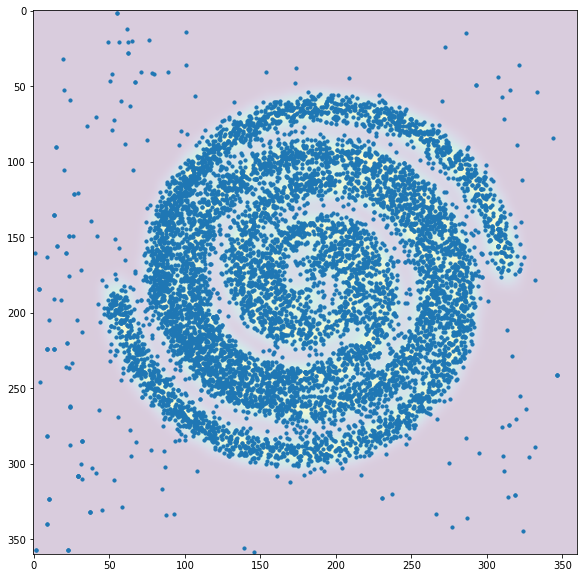

In [ ]:
## Epsilon with 0.9
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 40
epsilon = 0.9

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
init_sample = sample_from_image_density(1, density, key).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/spiral_iter10000_k40_e09.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 1], sampled_outputs[:, :, 0], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

  0%|          | 10/10000 [01:04<17:03:27,  6.15s/it]

Metropolis- Hastings REJECT 1.0958061 3.3272707


  0%|          | 14/10000 [01:28<16:53:28,  6.09s/it]

Metropolis- Hastings REJECT 1.0276822 2.121514


  0%|          | 25/10000 [02:34<16:32:16,  5.97s/it]

Metropolis- Hastings REJECT 1.5112683 2.3273923


  0%|          | 28/10000 [02:52<16:34:26,  5.98s/it]

Metropolis- Hastings REJECT 1.4525241 2.0624313


  0%|          | 29/10000 [02:58<16:43:12,  6.04s/it]

Metropolis- Hastings REJECT 1.4525241 2.4170415


  0%|          | 30/10000 [03:04<16:38:34,  6.01s/it]

Metropolis- Hastings REJECT 1.4525241 1.8447803


  1%|          | 60/10000 [06:03<16:37:30,  6.02s/it]

Metropolis- Hastings REJECT 0.9984739 1.2095397


  1%|          | 71/10000 [07:09<16:21:44,  5.93s/it]

Metropolis- Hastings REJECT 1.1055892 1.99471


  1%|          | 82/10000 [08:15<16:41:32,  6.06s/it]

Metropolis- Hastings REJECT 1.00659 1.5594856


  1%|          | 83/10000 [08:21<16:45:50,  6.09s/it]

Metropolis- Hastings REJECT 1.00659 2.1601965


  1%|          | 90/10000 [09:03<16:34:17,  6.02s/it]

Metropolis- Hastings REJECT 1.0080771 1.8319898


  1%|          | 99/10000 [09:57<16:44:36,  6.09s/it]

Metropolis- Hastings REJECT 1.4351711 3.5340145


  1%|          | 102/10000 [10:15<16:36:23,  6.04s/it]

Metropolis- Hastings REJECT 1.0159943 2.7183192


  1%|          | 103/10000 [10:21<16:35:38,  6.04s/it]

Metropolis- Hastings REJECT 1.0159943 2.8029823


  1%|          | 106/10000 [10:39<16:18:59,  5.94s/it]

Metropolis- Hastings REJECT 3.5324106 inf


  1%|          | 108/10000 [10:51<16:16:20,  5.92s/it]

Metropolis- Hastings REJECT 2.07693 3.5268712


  1%|          | 118/10000 [11:49<16:10:13,  5.89s/it]

Metropolis- Hastings REJECT 1.0682238 2.266627


  1%|          | 120/10000 [12:01<16:12:39,  5.91s/it]

Metropolis- Hastings REJECT 0.9537306 2.1124732


  1%|▏         | 133/10000 [13:18<16:10:57,  5.90s/it]

Metropolis- Hastings REJECT 1.1328762 1.2582483


  1%|▏         | 139/10000 [13:54<16:34:50,  6.05s/it]

Metropolis- Hastings REJECT 1.143578 1.6956015


  1%|▏         | 141/10000 [14:07<16:38:07,  6.07s/it]

Metropolis- Hastings REJECT 1.0881524 1.8929464


  1%|▏         | 144/10000 [14:25<16:32:48,  6.04s/it]

Metropolis- Hastings REJECT 1.1060945 2.603661


  1%|▏         | 146/10000 [14:36<16:26:23,  6.01s/it]

Metropolis- Hastings REJECT 1.127213 3.4866848


  2%|▏         | 154/10000 [15:24<16:20:10,  5.97s/it]

Metropolis- Hastings REJECT 1.1574146 2.1412215


  2%|▏         | 168/10000 [16:48<16:15:51,  5.96s/it]

Metropolis- Hastings REJECT 1.2448483 1.3681123


  2%|▏         | 171/10000 [17:06<16:22:38,  6.00s/it]

Metropolis- Hastings REJECT 1.0790162 2.2479274


  2%|▏         | 172/10000 [17:12<16:20:35,  5.99s/it]

Metropolis- Hastings REJECT 1.0790162 1.8737316


  2%|▏         | 181/10000 [18:05<16:17:08,  5.97s/it]

Metropolis- Hastings REJECT 2.0515027 inf


  2%|▏         | 188/10000 [18:47<16:17:56,  5.98s/it]

Metropolis- Hastings REJECT 1.2246915 1.7799109


  2%|▏         | 195/10000 [19:29<16:16:12,  5.97s/it]

Metropolis- Hastings REJECT 1.1989955 1.7103354


  2%|▏         | 201/10000 [20:05<16:18:06,  5.99s/it]

Metropolis- Hastings REJECT 0.9428652 1.4348463


  2%|▏         | 205/10000 [20:29<16:19:28,  6.00s/it]

Metropolis- Hastings REJECT 1.2578238 1.8964119


  2%|▏         | 210/10000 [20:59<16:13:25,  5.97s/it]

Metropolis- Hastings REJECT 0.99761236 1.244262


  2%|▏         | 211/10000 [21:04<16:11:30,  5.95s/it]

Metropolis- Hastings REJECT 0.99761236 1.3161137


  2%|▏         | 212/10000 [21:11<16:24:29,  6.03s/it]

Metropolis- Hastings REJECT 0.99761236 1.4396739


  2%|▏         | 218/10000 [21:47<16:13:10,  5.97s/it]

Metropolis- Hastings REJECT 1.2294496 3.5479739


  2%|▏         | 228/10000 [22:48<16:57:46,  6.25s/it]

Metropolis- Hastings REJECT 1.0144804 3.5469458


  2%|▏         | 239/10000 [23:57<16:52:23,  6.22s/it]

Metropolis- Hastings REJECT 1.0217451 1.3987491


  2%|▏         | 248/10000 [24:53<16:56:31,  6.25s/it]

Metropolis- Hastings REJECT 0.956727 2.1109385


  2%|▏         | 249/10000 [24:59<17:19:11,  6.39s/it]

Metropolis- Hastings REJECT 0.956727 1.1414983


  2%|▎         | 250/10000 [25:06<17:21:20,  6.41s/it]

Metropolis- Hastings REJECT 0.956727 1.1819121


  3%|▎         | 252/10000 [25:18<17:07:04,  6.32s/it]

Metropolis- Hastings REJECT 1.0713737 1.2135737


  3%|▎         | 262/10000 [26:20<16:38:18,  6.15s/it]

Metropolis- Hastings REJECT 0.9834374 2.4628832


  3%|▎         | 266/10000 [26:45<16:36:45,  6.14s/it]

Metropolis- Hastings REJECT 0.9630545 1.8849647


  3%|▎         | 272/10000 [27:21<16:44:27,  6.20s/it]

Metropolis- Hastings REJECT 1.3293993 1.7642041


  3%|▎         | 285/10000 [28:42<16:45:41,  6.21s/it]

Metropolis- Hastings REJECT 1.4654644 2.1347172


  3%|▎         | 305/10000 [30:46<16:45:04,  6.22s/it]

Metropolis- Hastings REJECT 1.8784165 3.5297399


  3%|▎         | 306/10000 [30:52<16:31:46,  6.14s/it]

Metropolis- Hastings REJECT 1.8784165 2.4445145


  3%|▎         | 312/10000 [31:29<16:25:54,  6.11s/it]

Metropolis- Hastings REJECT 1.0289567 1.312541


  3%|▎         | 316/10000 [31:54<16:34:30,  6.16s/it]

Metropolis- Hastings REJECT 1.0353687 1.4029437


  3%|▎         | 333/10000 [33:37<15:44:26,  5.86s/it]

Metropolis- Hastings REJECT 1.0210905 1.2810254


  3%|▎         | 339/10000 [34:13<15:55:02,  5.93s/it]

Metropolis- Hastings REJECT 0.9942069 1.5122281


  4%|▎         | 360/10000 [36:17<15:54:19,  5.94s/it]

Metropolis- Hastings REJECT 1.0073663 1.36254


  4%|▎         | 364/10000 [36:42<16:14:02,  6.06s/it]

Metropolis- Hastings REJECT 2.3793275 3.5344124


  4%|▍         | 378/10000 [38:05<15:56:56,  5.97s/it]

Metropolis- Hastings REJECT 1.0113122 3.561733


  4%|▍         | 385/10000 [38:46<15:39:29,  5.86s/it]

Metropolis- Hastings REJECT 1.0086815 1.4104991


  4%|▍         | 386/10000 [38:53<15:53:25,  5.95s/it]

Metropolis- Hastings REJECT 1.0086815 1.3048398


  4%|▍         | 395/10000 [39:45<15:31:20,  5.82s/it]

Metropolis- Hastings REJECT 1.2434119 2.3175738


  4%|▍         | 401/10000 [40:21<15:44:34,  5.90s/it]

Metropolis- Hastings REJECT 0.94226 1.112389


  4%|▍         | 402/10000 [40:26<15:35:13,  5.85s/it]

Metropolis- Hastings REJECT 0.94226 3.533938


  4%|▍         | 410/10000 [41:12<15:31:07,  5.83s/it]

Metropolis- Hastings REJECT 0.9557688 1.5604173


  4%|▍         | 424/10000 [42:35<15:53:31,  5.97s/it]

Metropolis- Hastings REJECT 1.348428 3.5502424


  4%|▍         | 434/10000 [43:35<15:53:52,  5.98s/it]

Metropolis- Hastings REJECT 1.0473669 1.586599


  4%|▍         | 439/10000 [44:05<15:54:53,  5.99s/it]

Metropolis- Hastings REJECT 1.7533889 2.173622


  4%|▍         | 445/10000 [44:40<15:36:39,  5.88s/it]

Metropolis- Hastings REJECT 1.0686736 3.39644


  4%|▍         | 446/10000 [44:46<15:51:43,  5.98s/it]

Metropolis- Hastings REJECT 1.0686736 1.5124997


  5%|▍         | 454/10000 [45:34<15:48:25,  5.96s/it]

Metropolis- Hastings REJECT 1.3290011 2.2041516


  5%|▍         | 455/10000 [45:40<15:45:29,  5.94s/it]

Metropolis- Hastings REJECT 1.3290011 2.0702147


  5%|▍         | 457/10000 [45:52<15:55:03,  6.00s/it]

Metropolis- Hastings REJECT 1.192627 1.4583595


  5%|▍         | 477/10000 [47:48<15:45:02,  5.95s/it]

Metropolis- Hastings REJECT 1.288153 3.5236015


  5%|▍         | 485/10000 [48:35<15:30:18,  5.87s/it]

Metropolis- Hastings REJECT 1.1142594 1.4821999


  5%|▍         | 496/10000 [49:40<15:35:38,  5.91s/it]

Metropolis- Hastings REJECT 0.9625138 1.2279242


  5%|▌         | 501/10000 [50:10<16:00:23,  6.07s/it]

Metropolis- Hastings REJECT 1.0279247 1.4263608


  5%|▌         | 510/10000 [51:04<15:50:04,  6.01s/it]

Metropolis- Hastings REJECT 1.5871003 3.5128024


  5%|▌         | 525/10000 [52:32<15:27:45,  5.88s/it]

Metropolis- Hastings REJECT 0.93610764 1.1198553


  5%|▌         | 529/10000 [52:55<15:13:49,  5.79s/it]

Metropolis- Hastings REJECT 2.7151787 3.517958


  6%|▌         | 578/10000 [57:42<15:20:22,  5.86s/it]

Metropolis- Hastings REJECT 1.3492321 1.3840287


  6%|▌         | 580/10000 [57:54<15:24:34,  5.89s/it]

Metropolis- Hastings REJECT 1.1480225 2.0823555


  6%|▌         | 584/10000 [58:18<15:38:00,  5.98s/it]

Metropolis- Hastings REJECT 1.4403152 1.758784


  6%|▌         | 594/10000 [59:17<15:22:12,  5.88s/it]

Metropolis- Hastings REJECT 1.0874183 2.7724197


  6%|▌         | 602/10000 [1:00:03<15:17:03,  5.85s/it]

Metropolis- Hastings REJECT 1.1635928 1.7004033


  6%|▌         | 615/10000 [1:01:21<15:41:07,  6.02s/it]

Metropolis- Hastings REJECT 1.0898596 1.3274796


  6%|▋         | 626/10000 [1:02:25<15:15:09,  5.86s/it]

Metropolis- Hastings REJECT 1.5223513 1.7944756


  6%|▋         | 638/10000 [1:03:35<15:04:11,  5.79s/it]

Metropolis- Hastings REJECT 1.047126 1.811002


  6%|▋         | 644/10000 [1:04:10<15:01:13,  5.78s/it]

Metropolis- Hastings REJECT 0.97235394 1.5020624


  6%|▋         | 647/10000 [1:04:28<15:04:47,  5.80s/it]

Metropolis- Hastings REJECT 1.6906692 2.3667533


  7%|▋         | 651/10000 [1:04:51<15:01:41,  5.79s/it]

Metropolis- Hastings REJECT 0.98387355 1.2137591


  7%|▋         | 656/10000 [1:05:19<15:02:12,  5.79s/it]

Metropolis- Hastings REJECT 1.9692384 2.2896192


  7%|▋         | 658/10000 [1:05:31<15:13:13,  5.87s/it]

Metropolis- Hastings REJECT 0.9972869 1.3291222


  7%|▋         | 660/10000 [1:05:43<15:09:23,  5.84s/it]

Metropolis- Hastings REJECT 1.044915 1.2868378


  7%|▋         | 677/10000 [1:07:23<15:18:56,  5.91s/it]

Metropolis- Hastings REJECT 1.1130104 3.5164812


  7%|▋         | 689/10000 [1:08:35<15:41:42,  6.07s/it]

Metropolis- Hastings REJECT 1.1527429 1.3722283


  7%|▋         | 692/10000 [1:08:53<15:32:40,  6.01s/it]

Metropolis- Hastings REJECT 1.1697214 3.3561614


  7%|▋         | 695/10000 [1:09:11<15:32:29,  6.01s/it]

Metropolis- Hastings REJECT 1.1455853 1.3521652


  7%|▋         | 713/10000 [1:10:59<15:20:54,  5.95s/it]

Metropolis- Hastings REJECT 1.2181247 1.4563042


  7%|▋         | 716/10000 [1:11:18<15:37:16,  6.06s/it]

Metropolis- Hastings REJECT 0.9768801 1.1223962


  7%|▋         | 721/10000 [1:11:47<15:27:04,  5.99s/it]

Metropolis- Hastings REJECT 0.95582485 1.0300494


  7%|▋         | 744/10000 [1:14:04<15:00:52,  5.84s/it]

Metropolis- Hastings REJECT 2.4801834 2.60547


  7%|▋         | 745/10000 [1:14:10<15:05:03,  5.87s/it]

Metropolis- Hastings REJECT 2.4801834 3.5274305


  8%|▊         | 756/10000 [1:15:14<14:59:23,  5.84s/it]

Metropolis- Hastings REJECT 1.1058009 2.198119


  8%|▊         | 766/10000 [1:16:12<14:57:28,  5.83s/it]

Metropolis- Hastings REJECT 1.2667935 3.5207946


  8%|▊         | 769/10000 [1:16:30<15:06:24,  5.89s/it]

Metropolis- Hastings REJECT 1.0124552 1.5541931


  8%|▊         | 771/10000 [1:16:42<15:15:57,  5.95s/it]

Metropolis- Hastings REJECT 1.0285639 1.1776674


  8%|▊         | 772/10000 [1:16:48<15:16:01,  5.96s/it]

Metropolis- Hastings REJECT 1.0285639 1.3204142


  8%|▊         | 781/10000 [1:17:41<15:04:42,  5.89s/it]

Metropolis- Hastings REJECT 1.0256011 1.2005479


  8%|▊         | 789/10000 [1:18:28<15:05:15,  5.90s/it]

Metropolis- Hastings REJECT 0.9766933 1.395526


  8%|▊         | 790/10000 [1:18:34<15:07:56,  5.91s/it]

Metropolis- Hastings REJECT 0.9766933 1.194928


  8%|▊         | 796/10000 [1:19:08<14:57:53,  5.85s/it]

Metropolis- Hastings REJECT 1.0849737 1.2710228


  8%|▊         | 806/10000 [1:20:07<14:52:05,  5.82s/it]

Metropolis- Hastings REJECT 1.0255393 1.6714548


  8%|▊         | 807/10000 [1:20:13<15:00:27,  5.88s/it]

Metropolis- Hastings REJECT 1.0255393 1.6522462


  8%|▊         | 810/10000 [1:20:31<15:04:22,  5.90s/it]

Metropolis- Hastings REJECT 0.9377494 1.6402289


  8%|▊         | 814/10000 [1:20:54<15:02:14,  5.89s/it]

Metropolis- Hastings REJECT 1.0082233 1.8275557


  8%|▊         | 819/10000 [1:21:24<15:02:15,  5.90s/it]

Metropolis- Hastings REJECT 1.1810226 1.5365201


  8%|▊         | 821/10000 [1:21:36<15:10:11,  5.95s/it]

Metropolis- Hastings REJECT 1.0548656 1.7648551


  8%|▊         | 823/10000 [1:21:47<14:51:54,  5.83s/it]

Metropolis- Hastings REJECT 1.2942947 2.7257204


  8%|▊         | 829/10000 [1:22:23<15:01:04,  5.90s/it]

Metropolis- Hastings REJECT 0.99796855 1.682251


  8%|▊         | 839/10000 [1:23:21<14:49:26,  5.83s/it]

Metropolis- Hastings REJECT 1.2142558 1.5291278


  8%|▊         | 842/10000 [1:23:39<15:02:56,  5.92s/it]

Metropolis- Hastings REJECT 0.93117416 2.1789343


  8%|▊         | 848/10000 [1:24:13<14:39:47,  5.77s/it]

Metropolis- Hastings REJECT 1.168128 2.600967


  9%|▊         | 857/10000 [1:25:06<14:52:38,  5.86s/it]

Metropolis- Hastings REJECT 0.9619274 1.9205462


  9%|▊         | 858/10000 [1:25:12<14:48:20,  5.83s/it]

Metropolis- Hastings REJECT 0.9619274 2.8085957


  9%|▉         | 893/10000 [1:28:36<14:25:04,  5.70s/it]

Metropolis- Hastings REJECT 0.99789834 2.6598532


  9%|▉         | 900/10000 [1:29:17<14:42:49,  5.82s/it]

Metropolis- Hastings REJECT 0.96526504 1.0182467


  9%|▉         | 903/10000 [1:29:34<14:31:46,  5.75s/it]

Metropolis- Hastings REJECT 1.0501101 1.6816199


  9%|▉         | 914/10000 [1:30:37<14:47:05,  5.86s/it]

Metropolis- Hastings REJECT 1.1040002 1.726444


  9%|▉         | 916/10000 [1:30:49<14:44:06,  5.84s/it]

Metropolis- Hastings REJECT 1.0022352 1.3265616


  9%|▉         | 923/10000 [1:31:29<14:24:29,  5.71s/it]

Metropolis- Hastings REJECT 1.040453 1.5241953


  9%|▉         | 927/10000 [1:31:52<14:29:10,  5.75s/it]

Metropolis- Hastings REJECT 1.0016139 1.164861


  9%|▉         | 934/10000 [1:32:32<14:25:01,  5.72s/it]

Metropolis- Hastings REJECT 0.9626653 2.362342


  9%|▉         | 941/10000 [1:33:11<14:25:53,  5.74s/it]

Metropolis- Hastings REJECT 1.064556 2.191616


  9%|▉         | 946/10000 [1:33:40<14:24:13,  5.73s/it]

Metropolis- Hastings REJECT 1.0592455 1.8239391


  9%|▉         | 948/10000 [1:33:52<14:40:43,  5.84s/it]

Metropolis- Hastings REJECT 2.2422287 2.820906


 10%|▉         | 951/10000 [1:34:09<14:30:52,  5.77s/it]

Metropolis- Hastings REJECT 1.0192746 2.3674264


 10%|▉         | 961/10000 [1:35:07<14:34:15,  5.80s/it]

Metropolis- Hastings REJECT 1.0307832 1.2140194


 10%|▉         | 975/10000 [1:36:28<14:27:53,  5.77s/it]

Metropolis- Hastings REJECT 0.9966104 1.718444


 10%|▉         | 977/10000 [1:36:39<14:37:37,  5.84s/it]

Metropolis- Hastings REJECT 0.9438484 1.0646744


 10%|▉         | 985/10000 [1:37:26<14:44:12,  5.88s/it]

Metropolis- Hastings REJECT 1.4932058 3.2966309


 10%|▉         | 988/10000 [1:37:43<14:36:27,  5.84s/it]

Metropolis- Hastings REJECT 1.5268711 2.1258442


 10%|▉         | 990/10000 [1:37:55<14:29:29,  5.79s/it]

Metropolis- Hastings REJECT 1.1010828 1.7037293


 10%|▉         | 992/10000 [1:38:07<14:43:00,  5.88s/it]

Metropolis- Hastings REJECT 1.1051908 1.5817096


 10%|▉         | 997/10000 [1:38:36<14:39:43,  5.86s/it]

Metropolis- Hastings REJECT 0.9909265 1.7899038


 10%|█         | 1003/10000 [1:39:10<14:18:18,  5.72s/it]

Metropolis- Hastings REJECT 1.037423 3.5527341


 10%|█         | 1004/10000 [1:39:16<14:20:41,  5.74s/it]

Metropolis- Hastings REJECT 1.037423 1.8148689


 10%|█         | 1029/10000 [1:41:37<13:54:52,  5.58s/it]

Metropolis- Hastings REJECT 1.0169487 1.2614802


 10%|█         | 1031/10000 [1:41:48<14:08:19,  5.67s/it]

Metropolis- Hastings REJECT 1.1861459 2.0571768


 10%|█         | 1049/10000 [1:43:32<14:21:44,  5.78s/it]

Metropolis- Hastings REJECT 0.98622406 1.1553552


 10%|█         | 1050/10000 [1:43:38<14:34:34,  5.86s/it]

Metropolis- Hastings REJECT 0.98622406 1.1293792


 11%|█         | 1052/10000 [1:43:49<14:22:17,  5.78s/it]

Metropolis- Hastings REJECT 0.9603921 1.1136156


 11%|█         | 1079/10000 [1:46:24<14:27:15,  5.83s/it]

Metropolis- Hastings REJECT 1.006253 2.4029884


 11%|█         | 1080/10000 [1:46:30<14:26:52,  5.83s/it]

Metropolis- Hastings REJECT 1.006253 1.9302764


 11%|█         | 1090/10000 [1:47:28<14:32:12,  5.87s/it]

Metropolis- Hastings REJECT 0.93171656 1.0049369


 11%|█         | 1092/10000 [1:47:39<14:36:47,  5.91s/it]

Metropolis- Hastings REJECT 0.97877073 1.929538


 11%|█         | 1096/10000 [1:48:02<14:16:54,  5.77s/it]

Metropolis- Hastings REJECT 1.0335395 1.4199424


 11%|█         | 1097/10000 [1:48:08<14:20:17,  5.80s/it]

Metropolis- Hastings REJECT 1.0335395 3.226525


 11%|█         | 1102/10000 [1:48:37<14:18:14,  5.79s/it]

Metropolis- Hastings REJECT 1.370401 3.528437


 11%|█         | 1120/10000 [1:50:20<14:08:54,  5.74s/it]

Metropolis- Hastings REJECT 0.98466307 1.236897


 11%|█         | 1121/10000 [1:50:26<14:06:55,  5.72s/it]

Metropolis- Hastings REJECT 0.98466307 1.1179476


 11%|█         | 1122/10000 [1:50:32<14:19:34,  5.81s/it]

Metropolis- Hastings REJECT 0.98466307 2.0256257


 11%|█         | 1124/10000 [1:50:43<14:19:04,  5.81s/it]

Metropolis- Hastings REJECT 1.1639291 1.4635093


 11%|█▏        | 1126/10000 [1:50:55<14:16:52,  5.79s/it]

Metropolis- Hastings REJECT 1.2578444 1.681176


 11%|█▏        | 1132/10000 [1:51:30<14:15:07,  5.79s/it]

Metropolis- Hastings REJECT 1.1305858 3.5225654


 11%|█▏        | 1134/10000 [1:51:41<14:25:07,  5.85s/it]

Metropolis- Hastings REJECT 1.0361258 1.3115294


 11%|█▏        | 1135/10000 [1:51:47<14:25:29,  5.86s/it]

Metropolis- Hastings REJECT 1.0361258 1.1630667


 11%|█▏        | 1136/10000 [1:51:53<14:25:31,  5.86s/it]

Metropolis- Hastings REJECT 1.0361258 2.3775606


 11%|█▏        | 1140/10000 [1:52:16<14:23:26,  5.85s/it]

Metropolis- Hastings REJECT 0.9806511 1.7847369


 11%|█▏        | 1141/10000 [1:52:22<14:29:12,  5.89s/it]

Metropolis- Hastings REJECT 0.9806511 1.2638615


 12%|█▏        | 1150/10000 [1:53:15<14:26:14,  5.87s/it]

Metropolis- Hastings REJECT 1.188751 1.43528


 12%|█▏        | 1160/10000 [1:54:13<14:17:04,  5.82s/it]

Metropolis- Hastings REJECT 1.0072324 1.735182


 12%|█▏        | 1163/10000 [1:54:31<14:24:06,  5.87s/it]

Metropolis- Hastings REJECT 1.0955336 1.2902713


 12%|█▏        | 1165/10000 [1:54:43<14:15:54,  5.81s/it]

Metropolis- Hastings REJECT 0.97747445 2.5372388


 12%|█▏        | 1169/10000 [1:55:06<14:14:28,  5.81s/it]

Metropolis- Hastings REJECT 3.5260046 inf


 12%|█▏        | 1172/10000 [1:55:23<14:20:45,  5.85s/it]

Metropolis- Hastings REJECT 3.5179636 inf


 12%|█▏        | 1174/10000 [1:55:35<14:17:32,  5.83s/it]

Metropolis- Hastings REJECT 3.520835 inf


 12%|█▏        | 1175/10000 [1:55:41<14:20:28,  5.85s/it]

Metropolis- Hastings REJECT 3.520835 inf


 12%|█▏        | 1180/10000 [1:56:09<14:02:56,  5.73s/it]

Metropolis- Hastings REJECT 0.9856266 1.1206391


 12%|█▏        | 1194/10000 [1:57:29<14:01:14,  5.73s/it]

Metropolis- Hastings REJECT 1.0060722 1.0925384


 12%|█▏        | 1198/10000 [1:57:53<14:09:34,  5.79s/it]

Metropolis- Hastings REJECT 1.1601248 1.5669242


 12%|█▏        | 1203/10000 [1:58:21<14:03:34,  5.75s/it]

Metropolis- Hastings REJECT 1.3159906 2.1460114


 12%|█▏        | 1213/10000 [1:59:18<14:06:59,  5.78s/it]

Metropolis- Hastings REJECT 1.0484376 1.5211136


 12%|█▏        | 1220/10000 [2:00:00<14:20:42,  5.88s/it]

Metropolis- Hastings REJECT 1.0200548 3.538683


 12%|█▏        | 1221/10000 [2:00:05<14:18:24,  5.87s/it]

Metropolis- Hastings REJECT 1.0200548 1.3341272


 12%|█▏        | 1224/10000 [2:00:23<14:34:01,  5.98s/it]

Metropolis- Hastings REJECT 1.0461855 1.1338795


 12%|█▏        | 1227/10000 [2:00:41<14:28:29,  5.94s/it]

Metropolis- Hastings REJECT 1.1235152 1.4829507


 12%|█▏        | 1235/10000 [2:01:27<14:02:43,  5.77s/it]

Metropolis- Hastings REJECT 1.0444177 1.8135817


 12%|█▏        | 1238/10000 [2:01:45<14:25:23,  5.93s/it]

Metropolis- Hastings REJECT 1.027931 1.6169268


 12%|█▏        | 1249/10000 [2:02:50<14:22:15,  5.91s/it]

Metropolis- Hastings REJECT 1.3146131 1.5088502


 13%|█▎        | 1253/10000 [2:03:14<14:15:25,  5.87s/it]

Metropolis- Hastings REJECT 0.9019259 1.3149135


 13%|█▎        | 1254/10000 [2:03:20<14:25:04,  5.93s/it]

Metropolis- Hastings REJECT 0.9019259 0.9915644


 13%|█▎        | 1259/10000 [2:03:49<14:10:36,  5.84s/it]

Metropolis- Hastings REJECT 1.234733 1.5418432


 13%|█▎        | 1260/10000 [2:03:55<14:06:49,  5.81s/it]

Metropolis- Hastings REJECT 1.234733 1.7937826


 13%|█▎        | 1263/10000 [2:04:12<14:17:15,  5.89s/it]

Metropolis- Hastings REJECT 1.3376961 2.0984576


 13%|█▎        | 1269/10000 [2:04:47<14:13:14,  5.86s/it]

Metropolis- Hastings REJECT 0.96829313 1.3944963


 13%|█▎        | 1271/10000 [2:04:59<14:06:53,  5.82s/it]

Metropolis- Hastings REJECT 1.0122246 3.527693


 13%|█▎        | 1273/10000 [2:05:10<14:12:19,  5.86s/it]

Metropolis- Hastings REJECT 1.059236 1.7861551


 13%|█▎        | 1278/10000 [2:05:40<14:20:07,  5.92s/it]

Metropolis- Hastings REJECT 0.9956755 1.1416562


 13%|█▎        | 1283/10000 [2:06:09<14:17:51,  5.90s/it]

Metropolis- Hastings REJECT 0.97856224 1.1252924


 13%|█▎        | 1296/10000 [2:07:24<14:00:40,  5.80s/it]

Metropolis- Hastings REJECT 1.1233085 1.1542004


 13%|█▎        | 1298/10000 [2:07:36<14:06:41,  5.84s/it]

Metropolis- Hastings REJECT 1.0701632 1.3375514


 13%|█▎        | 1301/10000 [2:07:53<14:05:45,  5.83s/it]

Metropolis- Hastings REJECT 0.9652773 1.0006058


 13%|█▎        | 1303/10000 [2:08:05<14:09:49,  5.86s/it]

Metropolis- Hastings REJECT 1.2940079 1.7121155


 13%|█▎        | 1305/10000 [2:08:17<14:09:27,  5.86s/it]

Metropolis- Hastings REJECT 1.2318573 3.5346215


 13%|█▎        | 1307/10000 [2:08:28<13:57:01,  5.78s/it]

Metropolis- Hastings REJECT 1.7723314 1.9660732


 13%|█▎        | 1309/10000 [2:08:40<13:51:00,  5.74s/it]

Metropolis- Hastings REJECT 1.3301107 3.5521111


 13%|█▎        | 1310/10000 [2:08:45<13:52:58,  5.75s/it]

Metropolis- Hastings REJECT 1.3301107 3.3045115


 13%|█▎        | 1323/10000 [2:10:00<13:57:17,  5.79s/it]

Metropolis- Hastings REJECT 1.0381653 1.1660596


 13%|█▎        | 1332/10000 [2:10:52<14:04:03,  5.84s/it]

Metropolis- Hastings REJECT 1.0142846 2.0134416


 13%|█▎        | 1344/10000 [2:12:01<13:53:23,  5.78s/it]

Metropolis- Hastings REJECT 0.9807846 2.8372185


 13%|█▎        | 1346/10000 [2:12:13<13:56:00,  5.80s/it]

Metropolis- Hastings REJECT 1.1155974 1.3665209


 13%|█▎        | 1347/10000 [2:12:19<13:56:01,  5.80s/it]

Metropolis- Hastings REJECT 1.1155974 1.722455


 14%|█▎        | 1354/10000 [2:12:59<13:46:44,  5.74s/it]

Metropolis- Hastings REJECT 0.9806262 1.391477


 14%|█▎        | 1355/10000 [2:13:05<13:47:55,  5.75s/it]

Metropolis- Hastings REJECT 0.9806262 3.5552325


 14%|█▎        | 1360/10000 [2:13:34<13:48:32,  5.75s/it]

Metropolis- Hastings REJECT 1.0147443 1.0919063


 14%|█▎        | 1361/10000 [2:13:40<13:48:50,  5.76s/it]

Metropolis- Hastings REJECT 1.0147443 2.3531716


 14%|█▎        | 1367/10000 [2:14:14<13:57:38,  5.82s/it]

Metropolis- Hastings REJECT 1.2325785 1.8556774


 14%|█▎        | 1373/10000 [2:14:49<13:49:43,  5.77s/it]

Metropolis- Hastings REJECT 1.0902982 1.8781521


 14%|█▍        | 1381/10000 [2:15:35<13:53:12,  5.80s/it]

Metropolis- Hastings REJECT 1.0418434 3.0183225


 14%|█▍        | 1390/10000 [2:16:27<14:04:06,  5.88s/it]

Metropolis- Hastings REJECT 1.0722302 1.4534881


 14%|█▍        | 1391/10000 [2:16:33<14:00:33,  5.86s/it]

Metropolis- Hastings REJECT 1.0722302 3.5421808


 14%|█▍        | 1401/10000 [2:17:31<13:50:28,  5.79s/it]

Metropolis- Hastings REJECT 1.0191363 1.5958812


 14%|█▍        | 1416/10000 [2:18:59<14:01:02,  5.88s/it]

Metropolis- Hastings REJECT 0.9356159 1.1305007


 14%|█▍        | 1421/10000 [2:19:28<13:59:27,  5.87s/it]

Metropolis- Hastings REJECT 0.9880805 3.5110233


 14%|█▍        | 1422/10000 [2:19:34<14:00:08,  5.88s/it]

Metropolis- Hastings REJECT 0.9880805 1.0687323


 14%|█▍        | 1436/10000 [2:20:54<13:52:47,  5.83s/it]

Metropolis- Hastings REJECT 1.0293782 1.3470356


 14%|█▍        | 1438/10000 [2:21:06<13:54:49,  5.85s/it]

Metropolis- Hastings REJECT 1.4376193 1.6647813


 15%|█▍        | 1451/10000 [2:22:21<13:43:10,  5.78s/it]

Metropolis- Hastings REJECT 1.2171952 1.4692969


 15%|█▍        | 1458/10000 [2:23:03<13:59:56,  5.90s/it]

Metropolis- Hastings REJECT 0.99749017 1.5983002


 15%|█▍        | 1464/10000 [2:23:38<13:59:07,  5.90s/it]

Metropolis- Hastings REJECT 0.9889219 1.0332524


 15%|█▍        | 1472/10000 [2:24:24<13:48:42,  5.83s/it]

Metropolis- Hastings REJECT 0.9211276 3.554531


 15%|█▍        | 1474/10000 [2:24:36<13:49:55,  5.84s/it]

Metropolis- Hastings REJECT 2.0688992 3.5318184


 15%|█▍        | 1479/10000 [2:25:05<13:49:16,  5.84s/it]

Metropolis- Hastings REJECT 1.3369584 2.218404


 15%|█▍        | 1481/10000 [2:25:17<13:41:16,  5.78s/it]

Metropolis- Hastings REJECT 0.9936811 2.0307584


 15%|█▍        | 1483/10000 [2:25:29<13:51:11,  5.86s/it]

Metropolis- Hastings REJECT 1.1297798 1.4562986


 15%|█▍        | 1485/10000 [2:25:41<13:59:10,  5.91s/it]

Metropolis- Hastings REJECT 1.3690149 2.3049157


 15%|█▍        | 1489/10000 [2:26:04<13:52:46,  5.87s/it]

Metropolis- Hastings REJECT 1.2009076 1.5620903


 15%|█▍        | 1492/10000 [2:26:22<13:56:17,  5.90s/it]

Metropolis- Hastings REJECT 1.1643219 1.9785234


 15%|█▍        | 1497/10000 [2:26:51<13:44:43,  5.82s/it]

Metropolis- Hastings REJECT 1.1076107 1.7538577


 15%|█▌        | 1504/10000 [2:27:32<13:36:09,  5.76s/it]

Metropolis- Hastings REJECT 1.3336947 2.9318388


 15%|█▌        | 1520/10000 [2:29:04<13:36:19,  5.78s/it]

Metropolis- Hastings REJECT 0.9996096 1.7083145


 15%|█▌        | 1524/10000 [2:29:27<13:45:50,  5.85s/it]

Metropolis- Hastings REJECT 1.1743383 2.0079334


 15%|█▌        | 1529/10000 [2:29:57<13:46:34,  5.85s/it]

Metropolis- Hastings REJECT 1.2531937 3.5481222


 15%|█▌        | 1541/10000 [2:31:06<13:42:18,  5.83s/it]

Metropolis- Hastings REJECT 0.9878926 1.1807399


 15%|█▌        | 1545/10000 [2:31:29<13:30:01,  5.75s/it]

Metropolis- Hastings REJECT 1.0197934 3.5290582


 16%|█▌        | 1554/10000 [2:32:21<13:40:32,  5.83s/it]

Metropolis- Hastings REJECT 1.2885433 3.5326362


 16%|█▌        | 1564/10000 [2:33:18<13:36:59,  5.81s/it]

Metropolis- Hastings REJECT 1.3116463 1.6596742


 16%|█▌        | 1570/10000 [2:33:54<14:13:14,  6.07s/it]

Metropolis- Hastings REJECT 2.101271 2.1728148


 16%|█▌        | 1584/10000 [2:35:16<13:28:39,  5.77s/it]

Metropolis- Hastings REJECT 1.5288643 3.5177536


 16%|█▌        | 1591/10000 [2:35:56<13:20:56,  5.71s/it]

Metropolis- Hastings REJECT 0.98262936 1.0346224


 16%|█▌        | 1593/10000 [2:36:08<13:23:15,  5.73s/it]

Metropolis- Hastings REJECT 1.1776577 3.374025


 16%|█▌        | 1595/10000 [2:36:19<13:29:54,  5.78s/it]

Metropolis- Hastings REJECT 1.1172309 2.695867


 16%|█▌        | 1597/10000 [2:36:31<13:37:16,  5.84s/it]

Metropolis- Hastings REJECT 2.1231077 3.5182247


 16%|█▌        | 1601/10000 [2:36:54<13:43:33,  5.88s/it]

Metropolis- Hastings REJECT 1.353655 1.6247753


 16%|█▌        | 1610/10000 [2:37:46<13:38:18,  5.85s/it]

Metropolis- Hastings REJECT 1.1106163 1.5574368


 16%|█▌        | 1617/10000 [2:38:27<13:29:34,  5.79s/it]

Metropolis- Hastings REJECT 1.9111122 3.5335276


 16%|█▌        | 1618/10000 [2:38:32<13:28:08,  5.78s/it]

Metropolis- Hastings REJECT 1.9111122 2.071029


 16%|█▌        | 1621/10000 [2:38:50<13:48:02,  5.93s/it]

Metropolis- Hastings REJECT 1.1600442 1.5314522


 16%|█▋        | 1625/10000 [2:39:14<13:50:37,  5.95s/it]

Metropolis- Hastings REJECT 1.0272901 2.3981187


 16%|█▋        | 1639/10000 [2:40:35<13:26:36,  5.79s/it]

Metropolis- Hastings REJECT 1.0270692 1.4916414


 16%|█▋        | 1647/10000 [2:41:21<13:26:02,  5.79s/it]

Metropolis- Hastings REJECT 1.0429505 2.3879538


 16%|█▋        | 1649/10000 [2:41:32<13:23:36,  5.77s/it]

Metropolis- Hastings REJECT 0.9779395 2.2371771


 17%|█▋        | 1656/10000 [2:42:12<13:07:54,  5.67s/it]

Metropolis- Hastings REJECT 0.96291006 1.8688536


 17%|█▋        | 1657/10000 [2:42:18<13:05:45,  5.65s/it]

Metropolis- Hastings REJECT 0.96291006 1.0401077


 17%|█▋        | 1659/10000 [2:42:29<13:06:36,  5.66s/it]

Metropolis- Hastings REJECT 0.96746093 2.4604876


 17%|█▋        | 1660/10000 [2:42:35<13:06:11,  5.66s/it]

Metropolis- Hastings REJECT 0.96746093 3.5564425


 17%|█▋        | 1672/10000 [2:43:44<13:16:41,  5.74s/it]

Metropolis- Hastings REJECT 1.119957 2.3202543


 17%|█▋        | 1674/10000 [2:43:55<13:20:56,  5.77s/it]

Metropolis- Hastings REJECT 1.1047901 1.3007501


 17%|█▋        | 1682/10000 [2:44:41<13:22:13,  5.79s/it]

Metropolis- Hastings REJECT 1.086632 1.1359838


 17%|█▋        | 1683/10000 [2:44:48<13:36:41,  5.89s/it]

Metropolis- Hastings REJECT 1.086632 3.5188885


 17%|█▋        | 1708/10000 [2:47:13<13:34:12,  5.89s/it]

Metropolis- Hastings REJECT 3.515193 inf


 17%|█▋        | 1711/10000 [2:47:31<13:27:02,  5.84s/it]

Metropolis- Hastings REJECT 3.5219107 inf


 17%|█▋        | 1721/10000 [2:48:29<13:22:52,  5.82s/it]

Metropolis- Hastings REJECT 1.0644337 2.669565


 17%|█▋        | 1725/10000 [2:48:51<13:02:42,  5.68s/it]

Metropolis- Hastings REJECT 1.308729 2.011034


 17%|█▋        | 1729/10000 [2:49:14<13:02:44,  5.68s/it]

Metropolis- Hastings REJECT 1.0412277 2.4911897


 17%|█▋        | 1734/10000 [2:49:42<12:56:31,  5.64s/it]

Metropolis- Hastings REJECT 1.0163022 1.7230415


 17%|█▋        | 1746/10000 [2:50:51<13:02:58,  5.69s/it]

Metropolis- Hastings REJECT 1.0825887 2.3145742


 18%|█▊        | 1754/10000 [2:51:37<13:13:02,  5.77s/it]

Metropolis- Hastings REJECT 1.0984732 2.4687495


 18%|█▊        | 1758/10000 [2:52:00<13:13:18,  5.78s/it]

Metropolis- Hastings REJECT 1.0186867 1.7425028


 18%|█▊        | 1778/10000 [2:53:56<13:18:20,  5.83s/it]

Metropolis- Hastings REJECT 1.091432 2.2741144


 18%|█▊        | 1793/10000 [2:55:23<13:05:11,  5.74s/it]

Metropolis- Hastings REJECT 1.0266026 1.6478482


 18%|█▊        | 1797/10000 [2:55:46<13:05:21,  5.74s/it]

Metropolis- Hastings REJECT 1.1759582 3.2154608


 18%|█▊        | 1800/10000 [2:56:03<13:19:35,  5.85s/it]

Metropolis- Hastings REJECT 1.3348808 1.9485592


 18%|█▊        | 1811/10000 [2:57:07<13:10:10,  5.79s/it]

Metropolis- Hastings REJECT 1.3670044 2.520922


 18%|█▊        | 1814/10000 [2:57:24<13:13:25,  5.82s/it]

Metropolis- Hastings REJECT 1.6266418 1.8599339


 18%|█▊        | 1847/10000 [3:00:36<13:10:09,  5.81s/it]

Metropolis- Hastings REJECT 1.0995497 1.7597977


 19%|█▊        | 1851/10000 [3:00:59<13:07:25,  5.80s/it]

Metropolis- Hastings REJECT 1.0872138 3.5292642


 19%|█▊        | 1862/10000 [3:02:03<13:06:20,  5.80s/it]

Metropolis- Hastings REJECT 0.9697156 1.0535693


 19%|█▊        | 1864/10000 [3:02:15<13:13:30,  5.85s/it]

Metropolis- Hastings REJECT 0.970641 1.3491838


 19%|█▉        | 1880/10000 [3:03:47<13:16:59,  5.89s/it]

Metropolis- Hastings REJECT 1.2460046 3.2164164


 19%|█▉        | 1893/10000 [3:05:04<13:24:37,  5.95s/it]

Metropolis- Hastings REJECT 1.0802212 1.7577201


 19%|█▉        | 1910/10000 [3:06:42<13:11:42,  5.87s/it]

Metropolis- Hastings REJECT 1.018844 2.2604573


 19%|█▉        | 1914/10000 [3:07:05<12:54:19,  5.75s/it]

Metropolis- Hastings REJECT 1.2314496 3.5487247


 19%|█▉        | 1932/10000 [3:08:49<13:14:53,  5.91s/it]

Metropolis- Hastings REJECT 1.2553043 2.0359309


 19%|█▉        | 1936/10000 [3:09:13<13:14:57,  5.91s/it]

Metropolis- Hastings REJECT 1.4615052 1.8447224


 19%|█▉        | 1939/10000 [3:09:31<13:11:19,  5.89s/it]

Metropolis- Hastings REJECT 1.22603 2.908413


 19%|█▉        | 1941/10000 [3:09:43<13:19:28,  5.95s/it]

Metropolis- Hastings REJECT 1.0152109 1.768209


 19%|█▉        | 1942/10000 [3:09:48<13:16:04,  5.93s/it]

Metropolis- Hastings REJECT 1.0152109 2.1703653


 19%|█▉        | 1943/10000 [3:09:54<13:16:49,  5.93s/it]

Metropolis- Hastings REJECT 1.0152109 1.5507532


 19%|█▉        | 1944/10000 [3:10:00<13:21:58,  5.97s/it]

Metropolis- Hastings REJECT 1.0152109 3.5297878


 19%|█▉        | 1949/10000 [3:10:30<13:07:21,  5.87s/it]

Metropolis- Hastings REJECT 1.3481076 2.3407416


 20%|█▉        | 1952/10000 [3:10:47<13:15:09,  5.93s/it]

Metropolis- Hastings REJECT 1.1904862 1.3773965


 20%|█▉        | 1953/10000 [3:10:53<13:13:51,  5.92s/it]

Metropolis- Hastings REJECT 1.1904862 1.6226965


 20%|█▉        | 1957/10000 [3:11:17<13:09:22,  5.89s/it]

Metropolis- Hastings REJECT 0.98450446 1.4960487


 20%|█▉        | 1972/10000 [3:12:43<12:49:12,  5.75s/it]

Metropolis- Hastings REJECT 0.94548607 2.228515


 20%|█▉        | 1973/10000 [3:12:49<12:57:47,  5.81s/it]

Metropolis- Hastings REJECT 0.94548607 1.9196537


 20%|█▉        | 1984/10000 [3:13:52<12:53:29,  5.79s/it]

Metropolis- Hastings REJECT 1.0809094 1.7123274


 20%|█▉        | 1989/10000 [3:14:21<12:43:02,  5.71s/it]

Metropolis- Hastings REJECT 1.0896966 1.7627996


 20%|██        | 2007/10000 [3:16:04<12:44:56,  5.74s/it]

Metropolis- Hastings REJECT 2.634447 3.5225081


 20%|██        | 2009/10000 [3:16:16<12:50:29,  5.79s/it]

Metropolis- Hastings REJECT 1.5730897 3.5548866


 20%|██        | 2013/10000 [3:16:39<12:36:22,  5.68s/it]

Metropolis- Hastings REJECT 0.9847802 1.8701333


 20%|██        | 2026/10000 [3:17:53<12:46:45,  5.77s/it]

Metropolis- Hastings REJECT 1.0383377 1.838411


 20%|██        | 2034/10000 [3:18:39<12:44:50,  5.76s/it]

Metropolis- Hastings REJECT 1.1852471 3.564442


 20%|██        | 2036/10000 [3:18:51<12:46:48,  5.78s/it]

Metropolis- Hastings REJECT 1.9983809 2.7800152


 20%|██        | 2050/10000 [3:20:11<13:02:21,  5.90s/it]

Metropolis- Hastings REJECT 0.9857552 1.4497541


 21%|██        | 2052/10000 [3:20:23<13:04:44,  5.92s/it]

Metropolis- Hastings REJECT 1.0382818 1.0550791


 21%|██        | 2072/10000 [3:22:17<12:30:07,  5.68s/it]

Metropolis- Hastings REJECT 1.1128757 1.4510386


 21%|██        | 2076/10000 [3:22:40<12:33:09,  5.70s/it]

Metropolis- Hastings REJECT 0.9963851 1.0295944


 21%|██        | 2079/10000 [3:22:57<12:28:01,  5.67s/it]

Metropolis- Hastings REJECT 1.0048115 1.8268437


 21%|██        | 2080/10000 [3:23:03<12:27:58,  5.67s/it]

Metropolis- Hastings REJECT 1.0048115 3.5221941


 21%|██        | 2084/10000 [3:23:25<12:26:07,  5.66s/it]

Metropolis- Hastings REJECT 1.5565224 2.4795609


 21%|██        | 2087/10000 [3:23:42<12:23:17,  5.64s/it]

Metropolis- Hastings REJECT 1.296224 2.1095772


 21%|██        | 2094/10000 [3:24:22<12:38:40,  5.76s/it]

Metropolis- Hastings REJECT 0.8980616 1.0162088


 21%|██        | 2106/10000 [3:25:30<12:35:57,  5.75s/it]

Metropolis- Hastings REJECT 1.26703 3.5222511


 21%|██        | 2107/10000 [3:25:36<12:43:48,  5.81s/it]

Metropolis- Hastings REJECT 1.26703 2.6669703


 21%|██        | 2114/10000 [3:26:17<13:05:24,  5.98s/it]

Metropolis- Hastings REJECT 1.0518978 1.9978498


 21%|██        | 2116/10000 [3:26:29<13:21:38,  6.10s/it]

Metropolis- Hastings REJECT 0.9587729 1.094474


 21%|██        | 2124/10000 [3:27:17<12:55:14,  5.91s/it]

Metropolis- Hastings REJECT 1.4593644 2.7952316


 21%|██▏       | 2138/10000 [3:28:37<12:32:33,  5.74s/it]

Metropolis- Hastings REJECT 1.0905159 1.1419892


 21%|██▏       | 2142/10000 [3:28:59<12:30:21,  5.73s/it]

Metropolis- Hastings REJECT 0.9921814 1.2305231


 22%|██▏       | 2152/10000 [3:29:57<12:24:20,  5.69s/it]

Metropolis- Hastings REJECT 1.1556578 2.0505621


 22%|██▏       | 2159/10000 [3:30:37<12:38:17,  5.80s/it]

Metropolis- Hastings REJECT 1.5090102 1.7586656


 22%|██▏       | 2160/10000 [3:30:43<12:40:40,  5.82s/it]

Metropolis- Hastings REJECT 1.5090102 2.4560728


 22%|██▏       | 2163/10000 [3:31:00<12:41:53,  5.83s/it]

Metropolis- Hastings REJECT 1.2412343 1.4956765


 22%|██▏       | 2175/10000 [3:32:10<12:32:55,  5.77s/it]

Metropolis- Hastings REJECT 0.9574945 3.50532


 22%|██▏       | 2177/10000 [3:32:21<12:33:35,  5.78s/it]

Metropolis- Hastings REJECT 1.0075972 1.2140212


 22%|██▏       | 2180/10000 [3:32:39<12:34:57,  5.79s/it]

Metropolis- Hastings REJECT 1.1725825 1.5133823


 22%|██▏       | 2201/10000 [3:34:41<12:49:00,  5.92s/it]

Metropolis- Hastings REJECT 1.2539068 3.5211644


 22%|██▏       | 2205/10000 [3:35:06<13:14:42,  6.12s/it]

Metropolis- Hastings REJECT 1.0625429 2.502723


 22%|██▏       | 2214/10000 [3:36:00<12:54:13,  5.97s/it]

Metropolis- Hastings REJECT 0.96441364 1.3018295


 22%|██▏       | 2228/10000 [3:37:21<12:27:33,  5.77s/it]

Metropolis- Hastings REJECT 0.9501253 1.8333694


 22%|██▏       | 2229/10000 [3:37:27<12:28:56,  5.78s/it]

Metropolis- Hastings REJECT 0.9501253 1.2913961


 22%|██▏       | 2231/10000 [3:37:38<12:28:58,  5.78s/it]

Metropolis- Hastings REJECT 1.0059136 1.2357124


 22%|██▏       | 2235/10000 [3:38:02<12:33:29,  5.82s/it]

Metropolis- Hastings REJECT 1.0513337 1.5234612


 22%|██▏       | 2241/10000 [3:38:36<12:24:11,  5.75s/it]

Metropolis- Hastings REJECT 0.9566997 1.2141767


 22%|██▏       | 2242/10000 [3:38:42<12:30:24,  5.80s/it]

Metropolis- Hastings REJECT 0.9566997 3.5464816


 23%|██▎       | 2251/10000 [3:39:35<12:38:59,  5.88s/it]

Metropolis- Hastings REJECT 1.001528 1.5831814


 23%|██▎       | 2254/10000 [3:39:52<12:30:22,  5.81s/it]

Metropolis- Hastings REJECT 1.275931 1.7048068


 23%|██▎       | 2257/10000 [3:40:09<12:20:24,  5.74s/it]

Metropolis- Hastings REJECT 2.2488234 3.2158697


 23%|██▎       | 2261/10000 [3:40:32<12:24:21,  5.77s/it]

Metropolis- Hastings REJECT 1.1515266 1.1969634


 23%|██▎       | 2267/10000 [3:41:07<12:25:12,  5.78s/it]

Metropolis- Hastings REJECT 0.9658012 1.2357907


 23%|██▎       | 2271/10000 [3:41:30<12:36:45,  5.87s/it]

Metropolis- Hastings REJECT 0.97697055 1.1900213


 23%|██▎       | 2279/10000 [3:42:16<12:15:04,  5.71s/it]

Metropolis- Hastings REJECT 1.0538245 1.1530458


 23%|██▎       | 2281/10000 [3:42:28<12:15:35,  5.72s/it]

Metropolis- Hastings REJECT 0.89949155 1.830232


 23%|██▎       | 2299/10000 [3:44:12<12:23:01,  5.79s/it]

Metropolis- Hastings REJECT 1.254088 1.7213886


 23%|██▎       | 2305/10000 [3:44:47<12:34:15,  5.88s/it]

Metropolis- Hastings REJECT 1.1178495 3.525481


 23%|██▎       | 2308/10000 [3:45:05<12:46:25,  5.98s/it]

Metropolis- Hastings REJECT 1.1003269 1.7031493


 23%|██▎       | 2311/10000 [3:45:23<12:34:04,  5.88s/it]

Metropolis- Hastings REJECT 1.1436293 1.3584476


 23%|██▎       | 2312/10000 [3:45:29<12:34:37,  5.89s/it]

Metropolis- Hastings REJECT 1.1436293 1.6800568


 23%|██▎       | 2315/10000 [3:45:46<12:25:55,  5.82s/it]

Metropolis- Hastings REJECT 1.1286582 2.3913975


 23%|██▎       | 2317/10000 [3:45:58<12:29:51,  5.86s/it]

Metropolis- Hastings REJECT 1.0496545 2.359061


 23%|██▎       | 2319/10000 [3:46:10<12:27:01,  5.84s/it]

Metropolis- Hastings REJECT 1.0318496 1.6084661


 23%|██▎       | 2323/10000 [3:46:33<12:33:04,  5.89s/it]

Metropolis- Hastings REJECT 1.0501442 1.3525853


 23%|██▎       | 2329/10000 [3:47:08<12:26:13,  5.84s/it]

Metropolis- Hastings REJECT 1.1216835 1.2237324


 23%|██▎       | 2334/10000 [3:47:37<12:26:01,  5.84s/it]

Metropolis- Hastings REJECT 0.9482348 2.4097683


 23%|██▎       | 2339/10000 [3:48:06<12:12:44,  5.74s/it]

Metropolis- Hastings REJECT 0.9819951 1.114535


 23%|██▎       | 2345/10000 [3:48:41<12:17:57,  5.78s/it]

Metropolis- Hastings REJECT 0.95594907 inf


 24%|██▎       | 2357/10000 [3:49:50<12:19:30,  5.81s/it]

Metropolis- Hastings REJECT 1.2546808 1.7212367


 24%|██▎       | 2369/10000 [3:50:59<12:09:44,  5.74s/it]

Metropolis- Hastings REJECT 0.9692724 1.4156654


 24%|██▍       | 2387/10000 [3:52:43<12:15:15,  5.79s/it]

Metropolis- Hastings REJECT 1.0295162 1.5733032


 24%|██▍       | 2394/10000 [3:53:24<12:22:34,  5.86s/it]

Metropolis- Hastings REJECT 0.97383523 1.5076964


 24%|██▍       | 2395/10000 [3:53:30<12:19:39,  5.84s/it]

Metropolis- Hastings REJECT 0.97383523 1.0975958


 24%|██▍       | 2398/10000 [3:53:47<12:20:38,  5.85s/it]

Metropolis- Hastings REJECT 0.93368864 1.0584639


 24%|██▍       | 2402/10000 [3:54:10<12:12:07,  5.78s/it]

Metropolis- Hastings REJECT 1.2950578 2.3003225


 24%|██▍       | 2412/10000 [3:55:08<12:13:17,  5.80s/it]

Metropolis- Hastings REJECT 1.242525 2.2326477


 24%|██▍       | 2415/10000 [3:55:26<12:23:40,  5.88s/it]

Metropolis- Hastings REJECT 2.5328648 3.544359


 24%|██▍       | 2419/10000 [3:55:50<12:38:12,  6.00s/it]

Metropolis- Hastings REJECT 1.0483017 2.295466


 24%|██▍       | 2421/10000 [3:56:02<12:35:26,  5.98s/it]

Metropolis- Hastings REJECT 1.0424807 1.6702868


 24%|██▍       | 2422/10000 [3:56:08<12:32:58,  5.96s/it]

Metropolis- Hastings REJECT 1.0424807 1.1289539


 24%|██▍       | 2423/10000 [3:56:13<12:27:17,  5.92s/it]

Metropolis- Hastings REJECT 1.0424807 3.5312855


 24%|██▍       | 2424/10000 [3:56:19<12:29:02,  5.93s/it]

Metropolis- Hastings REJECT 1.0424807 1.9354751


 24%|██▍       | 2426/10000 [3:56:31<12:29:59,  5.94s/it]

Metropolis- Hastings REJECT 1.1583277 1.8014119


 24%|██▍       | 2432/10000 [3:57:06<12:05:55,  5.76s/it]

Metropolis- Hastings REJECT 1.0222783 1.0548714


 24%|██▍       | 2434/10000 [3:57:18<12:12:07,  5.81s/it]

Metropolis- Hastings REJECT 1.2680173 1.4671663


 24%|██▍       | 2441/10000 [3:57:57<11:57:32,  5.70s/it]

Metropolis- Hastings REJECT 0.9452327 3.5423408


 25%|██▍       | 2468/10000 [4:00:32<12:15:29,  5.86s/it]

Metropolis- Hastings REJECT 1.0099167 1.5623012


 25%|██▍       | 2473/10000 [4:01:01<12:09:00,  5.81s/it]

Metropolis- Hastings REJECT 1.1855083 1.1956313


 25%|██▍       | 2482/10000 [4:01:54<12:18:59,  5.90s/it]

Metropolis- Hastings REJECT 1.072192 1.6682241


 25%|██▍       | 2495/10000 [4:03:10<12:22:18,  5.93s/it]

Metropolis- Hastings REJECT 1.314168 1.8400271


 25%|██▍       | 2497/10000 [4:03:22<12:25:41,  5.96s/it]

Metropolis- Hastings REJECT 1.0789137 2.21076


 25%|██▌       | 2502/10000 [4:03:51<12:10:53,  5.85s/it]

Metropolis- Hastings REJECT 1.0932248 1.6193553


 25%|██▌       | 2522/10000 [4:05:47<12:11:23,  5.87s/it]

Metropolis- Hastings REJECT 0.99797285 2.0159054


 25%|██▌       | 2539/10000 [4:07:27<12:08:07,  5.86s/it]

Metropolis- Hastings REJECT 0.9352151 0.9850551


 26%|██▌       | 2553/10000 [4:08:48<12:03:49,  5.83s/it]

Metropolis- Hastings REJECT 1.07905 1.1695819


 26%|██▌       | 2583/10000 [4:11:44<11:56:17,  5.79s/it]

Metropolis- Hastings REJECT 1.0244944 3.5350704


 26%|██▌       | 2606/10000 [4:13:57<11:48:53,  5.75s/it]

Metropolis- Hastings REJECT 0.97172 1.251873


 26%|██▌       | 2608/10000 [4:14:08<11:50:25,  5.77s/it]

Metropolis- Hastings REJECT 0.90212095 1.5047449


 26%|██▌       | 2609/10000 [4:14:14<11:55:52,  5.81s/it]

Metropolis- Hastings REJECT 0.90212095 1.3181076


 26%|██▌       | 2622/10000 [4:15:29<11:59:24,  5.85s/it]

Metropolis- Hastings REJECT 1.0069116 1.9782186


 26%|██▌       | 2624/10000 [4:15:41<12:03:16,  5.88s/it]

Metropolis- Hastings REJECT 1.1910285 1.471581


 26%|██▋       | 2625/10000 [4:15:47<12:01:20,  5.87s/it]

Metropolis- Hastings REJECT 1.1910285 1.6717315


 26%|██▋       | 2635/10000 [4:16:45<11:45:46,  5.75s/it]

Metropolis- Hastings REJECT 1.0641226 1.3164897


 26%|██▋       | 2638/10000 [4:17:02<11:45:53,  5.75s/it]

Metropolis- Hastings REJECT 1.0111697 1.9927946


 26%|██▋       | 2644/10000 [4:17:38<12:02:05,  5.89s/it]

Metropolis- Hastings REJECT 0.96646833 1.5192598


 26%|██▋       | 2648/10000 [4:18:01<11:55:22,  5.84s/it]

Metropolis- Hastings REJECT 1.1614895 2.3839843


 27%|██▋       | 2656/10000 [4:18:47<11:57:45,  5.86s/it]

Metropolis- Hastings REJECT 1.3269341 3.5160356


 27%|██▋       | 2666/10000 [4:19:46<12:04:24,  5.93s/it]

Metropolis- Hastings REJECT 1.1029441 1.4381099


 27%|██▋       | 2672/10000 [4:20:21<12:01:14,  5.91s/it]

Metropolis- Hastings REJECT 1.018145 2.334906


 27%|██▋       | 2680/10000 [4:21:08<11:52:36,  5.84s/it]

Metropolis- Hastings REJECT 1.0108372 1.6138651


 27%|██▋       | 2688/10000 [4:21:54<11:42:10,  5.76s/it]

Metropolis- Hastings REJECT 1.2115084 1.9154783


 27%|██▋       | 2696/10000 [4:22:40<11:53:29,  5.86s/it]

Metropolis- Hastings REJECT 1.4552671 3.5258772


 27%|██▋       | 2699/10000 [4:22:58<12:02:16,  5.94s/it]

Metropolis- Hastings REJECT 1.102884 1.7317568


 27%|██▋       | 2701/10000 [4:23:10<11:58:11,  5.90s/it]

Metropolis- Hastings REJECT 1.0318263 1.1848683


 27%|██▋       | 2704/10000 [4:23:28<11:55:21,  5.88s/it]

Metropolis- Hastings REJECT 1.2132641 2.716228


 27%|██▋       | 2723/10000 [4:25:18<11:50:26,  5.86s/it]

Metropolis- Hastings REJECT 1.0706621 1.9107077


 27%|██▋       | 2725/10000 [4:25:30<11:57:45,  5.92s/it]

Metropolis- Hastings REJECT 1.7224576 2.1656432


 27%|██▋       | 2728/10000 [4:25:47<11:53:02,  5.88s/it]

Metropolis- Hastings REJECT 0.97624356 2.3092985


 27%|██▋       | 2733/10000 [4:26:16<11:47:01,  5.84s/it]

Metropolis- Hastings REJECT 1.127777 2.1757338


 27%|██▋       | 2745/10000 [4:27:26<11:40:38,  5.79s/it]

Metropolis- Hastings REJECT 1.1524369 2.024937


 27%|██▋       | 2749/10000 [4:27:49<11:44:57,  5.83s/it]

Metropolis- Hastings REJECT 1.2182995 2.036038


 28%|██▊       | 2751/10000 [4:28:01<11:38:11,  5.78s/it]

Metropolis- Hastings REJECT 0.9492577 1.1542977


 28%|██▊       | 2756/10000 [4:28:29<11:35:55,  5.76s/it]

Metropolis- Hastings REJECT 1.1118004 3.0198033


 28%|██▊       | 2759/10000 [4:28:47<11:36:16,  5.77s/it]

Metropolis- Hastings REJECT 1.2036006 2.3829854


 28%|██▊       | 2760/10000 [4:28:52<11:33:14,  5.75s/it]

Metropolis- Hastings REJECT 1.2036006 1.291772


 28%|██▊       | 2772/10000 [4:30:01<11:29:31,  5.72s/it]

Metropolis- Hastings REJECT 1.0268537 1.3445948


 28%|██▊       | 2783/10000 [4:31:04<11:34:57,  5.78s/it]

Metropolis- Hastings REJECT 2.1470454 3.3907442


 28%|██▊       | 2785/10000 [4:31:16<11:36:51,  5.80s/it]

Metropolis- Hastings REJECT 2.1102593 2.5151014


 28%|██▊       | 2789/10000 [4:31:39<11:28:48,  5.73s/it]

Metropolis- Hastings REJECT 1.0166166 3.5313776


 28%|██▊       | 2790/10000 [4:31:45<11:35:02,  5.78s/it]

Metropolis- Hastings REJECT 1.0166166 1.9838289


 28%|██▊       | 2798/10000 [4:32:29<11:17:20,  5.64s/it]

Metropolis- Hastings REJECT 1.2160544 1.501168


 28%|██▊       | 2801/10000 [4:32:47<11:30:23,  5.75s/it]

Metropolis- Hastings REJECT 0.9867283 2.2382867


 28%|██▊       | 2812/10000 [4:33:50<11:30:39,  5.77s/it]

Metropolis- Hastings REJECT 0.97099614 1.1759527


 28%|██▊       | 2816/10000 [4:34:12<11:14:31,  5.63s/it]

Metropolis- Hastings REJECT 0.9523264 1.6173224


 28%|██▊       | 2817/10000 [4:34:18<11:21:25,  5.69s/it]

Metropolis- Hastings REJECT 0.9523264 1.347464


 28%|██▊       | 2822/10000 [4:34:47<11:24:14,  5.72s/it]

Metropolis- Hastings REJECT 0.9527352 1.3467014


 28%|██▊       | 2839/10000 [4:36:23<11:23:03,  5.72s/it]

Metropolis- Hastings REJECT 1.0822707 1.5194745


 28%|██▊       | 2848/10000 [4:37:15<11:21:10,  5.71s/it]

Metropolis- Hastings REJECT 1.0972416 2.1864839


 28%|██▊       | 2849/10000 [4:37:21<11:28:26,  5.78s/it]

Metropolis- Hastings REJECT 1.0972416 1.5829223


 29%|██▊       | 2857/10000 [4:38:06<11:23:01,  5.74s/it]

Metropolis- Hastings REJECT 0.9700372 2.5730553


 29%|██▉       | 2882/10000 [4:40:29<11:21:30,  5.74s/it]

Metropolis- Hastings REJECT 1.2261504 1.4223832


 29%|██▉       | 2885/10000 [4:40:46<11:21:21,  5.75s/it]

Metropolis- Hastings REJECT 1.2619108 2.4435225


 29%|██▉       | 2888/10000 [4:41:04<11:29:22,  5.82s/it]

Metropolis- Hastings REJECT 0.95320666 1.9082086


 29%|██▉       | 2896/10000 [4:41:50<11:20:54,  5.75s/it]

Metropolis- Hastings REJECT 1.0710013 1.2741258


 29%|██▉       | 2899/10000 [4:42:07<11:27:50,  5.81s/it]

Metropolis- Hastings REJECT 0.97391593 2.2949526


 29%|██▉       | 2908/10000 [4:42:59<11:14:54,  5.71s/it]

Metropolis- Hastings REJECT 0.9532105 1.8237603


 29%|██▉       | 2924/10000 [4:44:30<11:13:17,  5.71s/it]

Metropolis- Hastings REJECT 1.233389 2.044847


 29%|██▉       | 2928/10000 [4:44:53<11:04:44,  5.64s/it]

Metropolis- Hastings REJECT 0.9537274 3.5249405


 29%|██▉       | 2933/10000 [4:45:22<11:13:42,  5.72s/it]

Metropolis- Hastings REJECT 1.1524391 1.7907083


 29%|██▉       | 2936/10000 [4:45:39<11:06:39,  5.66s/it]

Metropolis- Hastings REJECT 1.0815535 1.5064845


 29%|██▉       | 2942/10000 [4:46:14<11:31:36,  5.88s/it]

Metropolis- Hastings REJECT 1.0197923 1.2684888


 29%|██▉       | 2943/10000 [4:46:20<11:30:58,  5.87s/it]

Metropolis- Hastings REJECT 1.0197923 1.9605558


 30%|██▉       | 2953/10000 [4:47:17<11:20:48,  5.80s/it]

Metropolis- Hastings REJECT 0.9702337 1.0649209


 30%|██▉       | 2957/10000 [4:47:40<11:11:01,  5.72s/it]

Metropolis- Hastings REJECT 0.9907644 1.1509255


 30%|██▉       | 2958/10000 [4:47:46<11:13:21,  5.74s/it]

Metropolis- Hastings REJECT 0.9907644 1.2988429


 30%|██▉       | 2959/10000 [4:47:52<11:15:34,  5.76s/it]

Metropolis- Hastings REJECT 0.9907644 1.0833243


 30%|██▉       | 2990/10000 [4:50:48<11:22:20,  5.84s/it]

Metropolis- Hastings REJECT 1.249287 1.3968742


 30%|██▉       | 2992/10000 [4:51:00<11:34:59,  5.95s/it]

Metropolis- Hastings REJECT 1.2401769 2.6977897


 30%|██▉       | 2997/10000 [4:51:28<11:14:52,  5.78s/it]

Metropolis- Hastings REJECT 0.90983415 1.9015673


 30%|███       | 3011/10000 [4:52:49<11:15:51,  5.80s/it]

Metropolis- Hastings REJECT 1.1050446 1.4318984


 30%|███       | 3012/10000 [4:52:55<11:13:07,  5.78s/it]

Metropolis- Hastings REJECT 1.1050446 2.4369476


 30%|███       | 3018/10000 [4:53:29<11:06:54,  5.73s/it]

Metropolis- Hastings REJECT 1.2268488 3.5417938


 30%|███       | 3024/10000 [4:54:04<11:11:11,  5.77s/it]

Metropolis- Hastings REJECT 1.2622323 2.9207804


 30%|███       | 3027/10000 [4:54:21<11:01:29,  5.69s/it]

Metropolis- Hastings REJECT 0.99481916 1.1854566


 30%|███       | 3045/10000 [4:56:03<11:06:35,  5.75s/it]

Metropolis- Hastings REJECT 1.0121276 2.5555744


 30%|███       | 3046/10000 [4:56:09<10:57:10,  5.67s/it]

Metropolis- Hastings REJECT 1.0121276 2.1232688


 31%|███       | 3067/10000 [4:58:08<11:07:38,  5.78s/it]

Metropolis- Hastings REJECT 1.3572518 2.0260596


 31%|███       | 3076/10000 [4:59:00<11:15:05,  5.85s/it]

Metropolis- Hastings REJECT 1.3266344 1.6500226


 31%|███       | 3078/10000 [4:59:11<11:10:12,  5.81s/it]

Metropolis- Hastings REJECT 1.0237428 2.0338795


 31%|███       | 3085/10000 [4:59:52<11:11:13,  5.82s/it]

Metropolis- Hastings REJECT 1.1278565 1.9092743


 31%|███       | 3086/10000 [4:59:58<11:14:26,  5.85s/it]

Metropolis- Hastings REJECT 1.1278565 2.4680738


 31%|███       | 3088/10000 [5:00:09<11:10:23,  5.82s/it]

Metropolis- Hastings REJECT 1.1113508 1.7426546


 31%|███       | 3109/10000 [5:02:10<11:09:55,  5.83s/it]

Metropolis- Hastings REJECT 1.1834931 2.0910711


 31%|███       | 3118/10000 [5:03:02<11:06:31,  5.81s/it]

Metropolis- Hastings REJECT 3.5450404 inf


 31%|███       | 3123/10000 [5:03:31<11:07:37,  5.82s/it]

Metropolis- Hastings REJECT 3.518933 inf


 31%|███▏      | 3125/10000 [5:03:43<11:12:25,  5.87s/it]

Metropolis- Hastings REJECT 3.522393 inf


 31%|███▏      | 3142/10000 [5:05:22<11:05:57,  5.83s/it]

Metropolis- Hastings REJECT 0.9804475 2.133952


 32%|███▏      | 3150/10000 [5:06:07<10:48:51,  5.68s/it]

Metropolis- Hastings REJECT 1.0584934 1.1623082


 32%|███▏      | 3152/10000 [5:06:18<10:47:10,  5.67s/it]

Metropolis- Hastings REJECT 1.1427364 2.2431922


 32%|███▏      | 3153/10000 [5:06:24<10:52:58,  5.72s/it]

Metropolis- Hastings REJECT 1.1427364 1.3424606


 32%|███▏      | 3162/10000 [5:07:15<10:36:16,  5.58s/it]

Metropolis- Hastings REJECT 1.0541693 3.5550022


 32%|███▏      | 3176/10000 [5:08:35<10:58:34,  5.79s/it]

Metropolis- Hastings REJECT 0.9801047 1.2325687


 32%|███▏      | 3184/10000 [5:09:21<11:02:33,  5.83s/it]

Metropolis- Hastings REJECT 1.357409 2.0533936


 32%|███▏      | 3185/10000 [5:09:27<11:11:22,  5.91s/it]

Metropolis- Hastings REJECT 1.357409 1.9408271


 32%|███▏      | 3196/10000 [5:10:30<10:48:11,  5.72s/it]

Metropolis- Hastings REJECT 1.0798438 1.2528192


 32%|███▏      | 3200/10000 [5:10:53<10:49:03,  5.73s/it]

Metropolis- Hastings REJECT 1.0231328 2.3025117


 32%|███▏      | 3202/10000 [5:11:04<10:54:00,  5.77s/it]

Metropolis- Hastings REJECT 1.0478134 1.4426881


 32%|███▏      | 3217/10000 [5:12:30<10:48:59,  5.74s/it]

Metropolis- Hastings REJECT 1.0983824 3.5122898


 32%|███▏      | 3223/10000 [5:13:05<10:52:57,  5.78s/it]

Metropolis- Hastings REJECT 1.1322259 3.5652149


 32%|███▏      | 3225/10000 [5:13:17<10:53:23,  5.79s/it]

Metropolis- Hastings REJECT 1.065056 3.0828934


 32%|███▏      | 3227/10000 [5:13:28<10:57:22,  5.82s/it]

Metropolis- Hastings REJECT 0.9979738 1.2949542


 32%|███▏      | 3230/10000 [5:13:46<10:48:34,  5.75s/it]

Metropolis- Hastings REJECT 1.0340586 2.4526663


 32%|███▏      | 3245/10000 [5:15:12<10:48:04,  5.76s/it]

Metropolis- Hastings REJECT 0.99741876 1.513898


 32%|███▏      | 3246/10000 [5:15:18<10:40:34,  5.69s/it]

Metropolis- Hastings REJECT 0.99741876 1.3744432


 33%|███▎      | 3253/10000 [5:15:58<10:47:51,  5.76s/it]

Metropolis- Hastings REJECT 0.9864029 1.5783193


 33%|███▎      | 3258/10000 [5:16:27<10:52:30,  5.81s/it]

Metropolis- Hastings REJECT 1.4936112 2.7204766


 33%|███▎      | 3259/10000 [5:16:32<10:46:18,  5.75s/it]

Metropolis- Hastings REJECT 1.4936112 2.5137649


 33%|███▎      | 3268/10000 [5:17:24<10:42:04,  5.72s/it]

Metropolis- Hastings REJECT 0.9934385 1.7294333


 33%|███▎      | 3270/10000 [5:17:36<10:52:04,  5.81s/it]

Metropolis- Hastings REJECT 1.136427 1.6350318


 33%|███▎      | 3279/10000 [5:18:28<10:53:59,  5.84s/it]

Metropolis- Hastings REJECT 1.5474939 3.5145733


 33%|███▎      | 3312/10000 [5:21:38<10:39:16,  5.74s/it]

Metropolis- Hastings REJECT 0.96221876 2.2132242


 33%|███▎      | 3314/10000 [5:21:50<10:47:20,  5.81s/it]

Metropolis- Hastings REJECT 0.96029586 1.1443636


 33%|███▎      | 3319/10000 [5:22:19<10:47:16,  5.81s/it]

Metropolis- Hastings REJECT 1.0046831 1.3849218


 33%|███▎      | 3322/10000 [5:22:36<10:43:04,  5.78s/it]

Metropolis- Hastings REJECT 1.065493 2.183822


 33%|███▎      | 3327/10000 [5:23:05<10:44:51,  5.80s/it]

Metropolis- Hastings REJECT 1.0044591 1.9882989


 33%|███▎      | 3328/10000 [5:23:11<10:40:59,  5.76s/it]

Metropolis- Hastings REJECT 1.0044591 1.5869505


 34%|███▎      | 3356/10000 [5:25:50<10:30:44,  5.70s/it]

Metropolis- Hastings REJECT 0.9312041 0.9911703


 34%|███▎      | 3357/10000 [5:25:56<10:43:07,  5.81s/it]

Metropolis- Hastings REJECT 0.9312041 1.3414284


 34%|███▎      | 3358/10000 [5:26:02<10:53:43,  5.91s/it]

Metropolis- Hastings REJECT 0.9312041 1.8802314


 34%|███▎      | 3361/10000 [5:26:20<10:56:02,  5.93s/it]

Metropolis- Hastings REJECT 1.0133739 1.5552711


 34%|███▎      | 3366/10000 [5:26:49<10:55:48,  5.93s/it]

Metropolis- Hastings REJECT 1.235305 1.328097


 34%|███▍      | 3378/10000 [5:27:59<10:37:57,  5.78s/it]

Metropolis- Hastings REJECT 1.088728 3.5593328


 34%|███▍      | 3386/10000 [5:28:44<10:27:05,  5.69s/it]

Metropolis- Hastings REJECT 1.1834213 2.2931318


 34%|███▍      | 3391/10000 [5:29:13<10:33:06,  5.75s/it]

Metropolis- Hastings REJECT 0.9803122 2.5072386


 34%|███▍      | 3399/10000 [5:30:00<10:45:40,  5.87s/it]

Metropolis- Hastings REJECT 0.9712243 1.6959991


 34%|███▍      | 3424/10000 [5:32:24<10:41:11,  5.85s/it]

Metropolis- Hastings REJECT 1.001364 1.5790703


 34%|███▍      | 3450/10000 [5:34:54<10:29:12,  5.76s/it]

Metropolis- Hastings REJECT 1.077045 inf


 35%|███▍      | 3454/10000 [5:35:17<10:32:44,  5.80s/it]

Metropolis- Hastings REJECT 0.9961946 1.1994432


 35%|███▍      | 3464/10000 [5:36:14<10:27:50,  5.76s/it]

Metropolis- Hastings REJECT 1.6129466 1.7733599


 35%|███▍      | 3470/10000 [5:36:49<10:31:07,  5.80s/it]

Metropolis- Hastings REJECT 1.1075373 1.3837303


 35%|███▍      | 3478/10000 [5:37:36<10:40:23,  5.89s/it]

Metropolis- Hastings REJECT 1.2065662 3.5151021


 35%|███▍      | 3480/10000 [5:37:48<10:42:11,  5.91s/it]

Metropolis- Hastings REJECT 1.0125039 1.9867952


 35%|███▌      | 3512/10000 [5:40:49<10:25:29,  5.78s/it]

Metropolis- Hastings REJECT 1.1089771 3.547163


 35%|███▌      | 3520/10000 [5:41:35<10:17:30,  5.72s/it]

Metropolis- Hastings REJECT 0.9984618 1.4507387


 35%|███▌      | 3521/10000 [5:41:41<10:24:30,  5.78s/it]

Metropolis- Hastings REJECT 0.9984618 1.246546


 35%|███▌      | 3530/10000 [5:42:34<10:37:31,  5.91s/it]

Metropolis- Hastings REJECT 0.99768066 3.1785283


 35%|███▌      | 3532/10000 [5:42:45<10:31:37,  5.86s/it]

Metropolis- Hastings REJECT 1.1087849 1.2148583


 35%|███▌      | 3540/10000 [5:43:32<10:30:48,  5.86s/it]

Metropolis- Hastings REJECT 0.9755299 1.8955176


 35%|███▌      | 3544/10000 [5:43:55<10:20:53,  5.77s/it]

Metropolis- Hastings REJECT 1.0489774 1.2343513


 35%|███▌      | 3545/10000 [5:44:01<10:23:07,  5.79s/it]

Metropolis- Hastings REJECT 1.0489774 1.1888356


 35%|███▌      | 3546/10000 [5:44:07<10:28:02,  5.84s/it]

Metropolis- Hastings REJECT 1.0489774 1.5270047


 36%|███▌      | 3552/10000 [5:44:41<10:20:28,  5.77s/it]

Metropolis- Hastings REJECT 2.1456878 3.4408593


 36%|███▌      | 3558/10000 [5:45:16<10:20:14,  5.78s/it]

Metropolis- Hastings REJECT 1.3832129 3.5519896


 36%|███▌      | 3567/10000 [5:46:08<10:17:47,  5.76s/it]

Metropolis- Hastings REJECT 1.0848379 1.2619936


 36%|███▌      | 3580/10000 [5:47:24<10:26:40,  5.86s/it]

Metropolis- Hastings REJECT 1.0507427 2.0072486


 36%|███▌      | 3582/10000 [5:47:36<10:30:03,  5.89s/it]

Metropolis- Hastings REJECT 1.0211643 2.0584862


 36%|███▌      | 3587/10000 [5:48:05<10:29:21,  5.89s/it]

Metropolis- Hastings REJECT 0.97788167 1.5706449


 36%|███▌      | 3589/10000 [5:48:17<10:27:30,  5.87s/it]

Metropolis- Hastings REJECT 1.0412788 1.3989937


 36%|███▌      | 3593/10000 [5:48:40<10:31:21,  5.91s/it]

Metropolis- Hastings REJECT 1.1507431 1.6386617


 36%|███▌      | 3596/10000 [5:48:58<10:22:26,  5.83s/it]

Metropolis- Hastings REJECT 1.6233423 2.4568


 36%|███▌      | 3602/10000 [5:49:32<10:22:52,  5.84s/it]

Metropolis- Hastings REJECT 1.0136658 1.1175108


 36%|███▌      | 3603/10000 [5:49:38<10:27:09,  5.88s/it]

Metropolis- Hastings REJECT 1.0136658 1.3309002


 36%|███▌      | 3624/10000 [5:51:42<10:21:59,  5.85s/it]

Metropolis- Hastings REJECT 1.0187888 1.9108179


 36%|███▋      | 3637/10000 [5:52:58<10:27:47,  5.92s/it]

Metropolis- Hastings REJECT 1.3368026 3.5570173


 37%|███▋      | 3660/10000 [5:55:14<10:23:13,  5.90s/it]

Metropolis- Hastings REJECT 1.1441731 2.8483305


 37%|███▋      | 3665/10000 [5:55:44<10:36:46,  6.03s/it]

Metropolis- Hastings REJECT 1.5930158 2.7509477


 37%|███▋      | 3674/10000 [5:56:37<10:23:18,  5.91s/it]

Metropolis- Hastings REJECT 1.2139544 3.5229294


 37%|███▋      | 3680/10000 [5:57:11<10:05:34,  5.75s/it]

Metropolis- Hastings REJECT 1.206254 2.0038323


 37%|███▋      | 3684/10000 [5:57:34<10:06:13,  5.76s/it]

Metropolis- Hastings REJECT 1.0743902 1.8086756


 37%|███▋      | 3686/10000 [5:57:46<10:15:39,  5.85s/it]

Metropolis- Hastings REJECT 1.046618 3.5544844


 37%|███▋      | 3691/10000 [5:58:16<10:15:30,  5.85s/it]

Metropolis- Hastings REJECT 1.0125889 2.2901204


 37%|███▋      | 3692/10000 [5:58:22<10:19:16,  5.89s/it]

Metropolis- Hastings REJECT 1.0125889 1.2520796


 37%|███▋      | 3695/10000 [5:58:39<10:09:10,  5.80s/it]

Metropolis- Hastings REJECT 1.037112 1.1165019


 37%|███▋      | 3712/10000 [6:00:17<9:57:32,  5.70s/it]

Metropolis- Hastings REJECT 1.0019131 2.271722


 37%|███▋      | 3714/10000 [6:00:28<10:04:50,  5.77s/it]

Metropolis- Hastings REJECT 0.98252916 1.4204031


 37%|███▋      | 3728/10000 [6:01:50<10:13:17,  5.87s/it]

Metropolis- Hastings REJECT 1.1120231 2.683629


 37%|███▋      | 3733/10000 [6:02:19<10:01:47,  5.76s/it]

Metropolis- Hastings REJECT 1.7244905 2.4329066


 37%|███▋      | 3739/10000 [6:02:53<9:54:23,  5.70s/it]

Metropolis- Hastings REJECT 1.4093281 1.7156527


 38%|███▊      | 3759/10000 [6:04:48<9:58:11,  5.75s/it]

Metropolis- Hastings REJECT 0.95514023 2.0310411


 38%|███▊      | 3762/10000 [6:05:05<10:00:07,  5.77s/it]

Metropolis- Hastings REJECT 1.0590595 1.23631


 38%|███▊      | 3775/10000 [6:06:21<10:14:25,  5.92s/it]

Metropolis- Hastings REJECT 1.1174049 1.6336066


 38%|███▊      | 3779/10000 [6:06:45<10:10:42,  5.89s/it]

Metropolis- Hastings REJECT 1.2376194 2.517473


 38%|███▊      | 3786/10000 [6:07:26<10:11:06,  5.90s/it]

Metropolis- Hastings REJECT 0.9530374 1.3063779


 38%|███▊      | 3806/10000 [6:09:23<9:58:43,  5.80s/it]

Metropolis- Hastings REJECT 1.1327456 2.2646074


 38%|███▊      | 3808/10000 [6:09:35<10:01:25,  5.83s/it]

Metropolis- Hastings REJECT 1.0243632 3.5193691


 38%|███▊      | 3810/10000 [6:09:47<10:06:21,  5.88s/it]

Metropolis- Hastings REJECT 0.97759074 3.514431


 38%|███▊      | 3820/10000 [6:10:44<9:57:14,  5.80s/it]

Metropolis- Hastings REJECT 3.525268 inf


 38%|███▊      | 3822/10000 [6:10:56<9:54:59,  5.78s/it]

Metropolis- Hastings REJECT 3.5261626 inf


 38%|███▊      | 3826/10000 [6:11:19<9:59:48,  5.83s/it] 

Metropolis- Hastings REJECT 0.9844086 1.1544316


 38%|███▊      | 3830/10000 [6:11:43<10:03:30,  5.87s/it]

Metropolis- Hastings REJECT 0.9664531 1.4368339


 38%|███▊      | 3834/10000 [6:12:06<10:08:06,  5.92s/it]

Metropolis- Hastings REJECT 1.2113099 3.5459144


 39%|███▊      | 3859/10000 [6:14:29<9:43:02,  5.70s/it]

Metropolis- Hastings REJECT 1.1581106 2.8272915


 39%|███▊      | 3862/10000 [6:14:47<9:48:45,  5.76s/it]

Metropolis- Hastings REJECT 1.6305373 2.5502334


 39%|███▊      | 3866/10000 [6:15:10<9:48:54,  5.76s/it]

Metropolis- Hastings REJECT 0.9827113 1.1734978


 39%|███▊      | 3871/10000 [6:15:39<9:53:23,  5.81s/it]

Metropolis- Hastings REJECT 1.1881922 1.2770948


 39%|███▉      | 3875/10000 [6:16:02<10:02:38,  5.90s/it]

Metropolis- Hastings REJECT 0.99049413 1.6290965


 39%|███▉      | 3882/10000 [6:16:43<9:51:04,  5.80s/it]

Metropolis- Hastings REJECT 1.0099733 2.4521027


 39%|███▉      | 3883/10000 [6:16:49<9:58:04,  5.87s/it]

Metropolis- Hastings REJECT 1.0099733 1.6384206


 39%|███▉      | 3884/10000 [6:16:55<9:57:10,  5.86s/it]

Metropolis- Hastings REJECT 1.0099733 1.9588856


 39%|███▉      | 3888/10000 [6:17:18<10:00:52,  5.90s/it]

Metropolis- Hastings REJECT 0.9843094 1.5755374


 39%|███▉      | 3889/10000 [6:17:24<10:04:36,  5.94s/it]

Metropolis- Hastings REJECT 0.9843094 1.3301077


 39%|███▉      | 3890/10000 [6:17:30<10:01:05,  5.90s/it]

Metropolis- Hastings REJECT 0.9843094 1.4819479


 39%|███▉      | 3903/10000 [6:18:45<9:46:51,  5.78s/it]

Metropolis- Hastings REJECT 1.724153 2.8866415


 39%|███▉      | 3905/10000 [6:18:56<9:45:12,  5.76s/it]

Metropolis- Hastings REJECT 1.0840719 1.4213009


 39%|███▉      | 3915/10000 [6:19:53<9:36:20,  5.68s/it]

Metropolis- Hastings REJECT 1.3544438 1.6738093


 39%|███▉      | 3933/10000 [6:21:36<9:45:46,  5.79s/it]

Metropolis- Hastings REJECT 1.1296468 2.0861762


 39%|███▉      | 3934/10000 [6:21:42<9:47:52,  5.81s/it]

Metropolis- Hastings REJECT 1.1296468 3.4311242


 39%|███▉      | 3939/10000 [6:22:10<9:39:18,  5.73s/it]

Metropolis- Hastings REJECT 1.5252465 2.7595124


 39%|███▉      | 3943/10000 [6:22:33<9:43:50,  5.78s/it]

Metropolis- Hastings REJECT 1.4824551 2.3677988


 39%|███▉      | 3946/10000 [6:22:50<9:36:59,  5.72s/it]

Metropolis- Hastings REJECT 0.9883963 1.2770848


 40%|███▉      | 3950/10000 [6:23:14<9:46:45,  5.82s/it]

Metropolis- Hastings REJECT 1.3614762 1.7181535


 40%|███▉      | 3954/10000 [6:23:37<9:39:30,  5.75s/it]

Metropolis- Hastings REJECT 1.0375961 1.2933954


 40%|███▉      | 3955/10000 [6:23:42<9:41:13,  5.77s/it]

Metropolis- Hastings REJECT 1.0375961 1.1166942


 40%|███▉      | 3973/10000 [6:25:26<9:39:24,  5.77s/it]

Metropolis- Hastings REJECT 1.0499891 1.7300906


 40%|███▉      | 3976/10000 [6:25:43<9:37:30,  5.75s/it]

Metropolis- Hastings REJECT 0.9877418 1.2940953


 40%|███▉      | 3983/10000 [6:26:23<9:44:05,  5.82s/it]

Metropolis- Hastings REJECT 1.0077552 1.887642


 40%|███▉      | 3993/10000 [6:27:21<9:36:10,  5.75s/it]

Metropolis- Hastings REJECT 1.2753656 1.7474372


 40%|███▉      | 3994/10000 [6:27:27<9:35:07,  5.75s/it]

Metropolis- Hastings REJECT 1.2753656 1.652453


 40%|███▉      | 3996/10000 [6:27:38<9:39:12,  5.79s/it]

Metropolis- Hastings REJECT 1.4446254 2.7321913


 40%|████      | 4008/10000 [6:28:48<9:49:04,  5.90s/it]

Metropolis- Hastings REJECT 1.1172125 1.5276423


 40%|████      | 4029/10000 [6:30:50<9:37:01,  5.80s/it]

Metropolis- Hastings REJECT 0.99344325 2.0672421


 40%|████      | 4040/10000 [6:31:53<9:39:37,  5.84s/it]

Metropolis- Hastings REJECT 1.0176684 3.5280561


 40%|████      | 4044/10000 [6:32:16<9:36:06,  5.80s/it]

Metropolis- Hastings REJECT 1.3283055 1.948509


 41%|████      | 4055/10000 [6:33:21<9:44:26,  5.90s/it]

Metropolis- Hastings REJECT 0.97266555 2.4984028


 41%|████      | 4058/10000 [6:33:39<9:48:48,  5.95s/it]

Metropolis- Hastings REJECT 1.1331035 1.8988231


 41%|████      | 4063/10000 [6:34:08<9:37:14,  5.83s/it]

Metropolis- Hastings REJECT 3.5106702 inf


 41%|████      | 4065/10000 [6:34:20<9:46:10,  5.93s/it]

Metropolis- Hastings REJECT 3.5081496 inf


 41%|████      | 4066/10000 [6:34:26<9:41:40,  5.88s/it]

Metropolis- Hastings REJECT 3.5081496 inf


 41%|████      | 4067/10000 [6:34:32<9:45:37,  5.92s/it]

Metropolis- Hastings REJECT 3.5081496 inf


 41%|████      | 4068/10000 [6:34:38<9:48:42,  5.95s/it]

Metropolis- Hastings REJECT 3.5081496 inf


 41%|████      | 4071/10000 [6:34:55<9:47:30,  5.95s/it]

Metropolis- Hastings REJECT 3.5082679 inf


 41%|████      | 4073/10000 [6:35:07<9:44:55,  5.92s/it]

Metropolis- Hastings REJECT 3.5093257 inf


 41%|████      | 4077/10000 [6:35:30<9:41:54,  5.89s/it]

Metropolis- Hastings REJECT 3.5260692 inf


 41%|████      | 4079/10000 [6:35:42<9:41:28,  5.89s/it]

Metropolis- Hastings REJECT 3.547176 inf


 41%|████      | 4081/10000 [6:35:54<9:46:41,  5.95s/it]

Metropolis- Hastings REJECT 3.5273826 inf


 41%|████      | 4082/10000 [6:36:00<9:41:02,  5.89s/it]

Metropolis- Hastings REJECT 3.5273826 inf


 41%|████      | 4083/10000 [6:36:06<9:48:03,  5.96s/it]

Metropolis- Hastings REJECT 3.5273826 inf


 41%|████      | 4087/10000 [6:36:29<9:24:52,  5.73s/it]

Metropolis- Hastings REJECT 1.0715084 1.4995522


 41%|████      | 4089/10000 [6:36:40<9:29:16,  5.78s/it]

Metropolis- Hastings REJECT 0.94704753 1.3711023


 41%|████      | 4091/10000 [6:36:52<9:31:29,  5.80s/it]

Metropolis- Hastings REJECT 1.1018927 1.1330358


 41%|████      | 4099/10000 [6:37:40<9:47:31,  5.97s/it]

Metropolis- Hastings REJECT 1.1409843 1.5019528


 41%|████      | 4104/10000 [6:38:10<9:47:48,  5.98s/it]

Metropolis- Hastings REJECT 1.032138 1.5889899


 41%|████      | 4114/10000 [6:39:08<9:30:51,  5.82s/it]

Metropolis- Hastings REJECT 0.995986 1.6851238


 41%|████▏     | 4125/10000 [6:40:12<9:26:55,  5.79s/it]

Metropolis- Hastings REJECT 0.92169124 1.3505695


 41%|████▏     | 4126/10000 [6:40:18<9:29:41,  5.82s/it]

Metropolis- Hastings REJECT 0.92169124 1.3833396


 41%|████▏     | 4127/10000 [6:40:24<9:30:54,  5.83s/it]

Metropolis- Hastings REJECT 0.92169124 1.0654674


 41%|████▏     | 4143/10000 [6:41:55<9:18:25,  5.72s/it]

Metropolis- Hastings REJECT 1.1423757 1.3613514


 41%|████▏     | 4145/10000 [6:42:06<9:18:46,  5.73s/it]

Metropolis- Hastings REJECT 0.96369684 3.004541


 41%|████▏     | 4147/10000 [6:42:18<9:28:20,  5.83s/it]

Metropolis- Hastings REJECT 1.1061854 2.1816902


 42%|████▏     | 4151/10000 [6:42:41<9:16:06,  5.70s/it]

Metropolis- Hastings REJECT 1.1796092 2.320541


 42%|████▏     | 4164/10000 [6:43:55<9:20:35,  5.76s/it]

Metropolis- Hastings REJECT 0.97877264 1.8761523


 42%|████▏     | 4174/10000 [6:44:52<9:08:22,  5.65s/it]

Metropolis- Hastings REJECT 1.1613503 3.551231


 42%|████▏     | 4175/10000 [6:44:57<9:09:56,  5.66s/it]

Metropolis- Hastings REJECT 1.1613503 3.5510912


 42%|████▏     | 4177/10000 [6:45:09<9:11:17,  5.68s/it]

Metropolis- Hastings REJECT 0.94620854 0.98188996


 42%|████▏     | 4178/10000 [6:45:14<9:14:34,  5.72s/it]

Metropolis- Hastings REJECT 0.94620854 1.1730851


 42%|████▏     | 4183/10000 [6:45:43<9:17:18,  5.75s/it]

Metropolis- Hastings REJECT 1.0724077 1.2961209


 42%|████▏     | 4211/10000 [6:48:21<9:09:15,  5.69s/it]

Metropolis- Hastings REJECT 1.1200361 1.3714218


 42%|████▏     | 4216/10000 [6:48:50<9:29:42,  5.91s/it]

Metropolis- Hastings REJECT 1.1551412 3.5368812


 42%|████▏     | 4228/10000 [6:50:00<9:11:23,  5.73s/it]

Metropolis- Hastings REJECT 1.4038635 2.5824404


 43%|████▎     | 4254/10000 [6:52:30<9:15:52,  5.80s/it]

Metropolis- Hastings REJECT 1.2146733 3.527439


 43%|████▎     | 4258/10000 [6:52:54<9:27:30,  5.93s/it]

Metropolis- Hastings REJECT 0.9659108 inf


 43%|████▎     | 4263/10000 [6:53:23<9:05:52,  5.71s/it]

Metropolis- Hastings REJECT 1.1056149 1.2796564


 43%|████▎     | 4266/10000 [6:53:40<9:11:21,  5.77s/it]

Metropolis- Hastings REJECT 1.0895796 1.8871404


 43%|████▎     | 4270/10000 [6:54:03<9:12:37,  5.79s/it]

Metropolis- Hastings REJECT 1.0230391 1.2191634


 43%|████▎     | 4287/10000 [6:55:42<9:13:45,  5.82s/it]

Metropolis- Hastings REJECT 1.0786355 1.7646492


 43%|████▎     | 4288/10000 [6:55:48<9:13:31,  5.81s/it]

Metropolis- Hastings REJECT 1.0786355 1.7548876


 43%|████▎     | 4289/10000 [6:55:54<9:16:46,  5.85s/it]

Metropolis- Hastings REJECT 1.0786355 1.1724997


 43%|████▎     | 4291/10000 [6:56:05<9:19:45,  5.88s/it]

Metropolis- Hastings REJECT 1.0641928 1.6985509


 43%|████▎     | 4294/10000 [6:56:23<9:19:23,  5.88s/it]

Metropolis- Hastings REJECT 0.9331203 3.5261219


 43%|████▎     | 4295/10000 [6:56:29<9:16:40,  5.85s/it]

Metropolis- Hastings REJECT 0.9331203 3.5436704


 43%|████▎     | 4315/10000 [6:58:25<9:14:22,  5.85s/it]

Metropolis- Hastings REJECT 1.0334878 1.3102893


 43%|████▎     | 4321/10000 [6:59:00<9:06:49,  5.78s/it]

Metropolis- Hastings REJECT 1.0137239 2.2977827


 43%|████▎     | 4322/10000 [6:59:06<9:11:38,  5.83s/it]

Metropolis- Hastings REJECT 1.0137239 2.140484


 43%|████▎     | 4323/10000 [6:59:12<9:13:03,  5.85s/it]

Metropolis- Hastings REJECT 1.0137239 1.9448973


 43%|████▎     | 4330/10000 [6:59:53<9:13:49,  5.86s/it]

Metropolis- Hastings REJECT 3.519715 inf


 43%|████▎     | 4331/10000 [6:59:58<9:06:04,  5.78s/it]

Metropolis- Hastings REJECT 3.519715 inf


 43%|████▎     | 4334/10000 [7:00:16<9:14:45,  5.87s/it]

Metropolis- Hastings REJECT 3.5220685 inf


 43%|████▎     | 4340/10000 [7:00:51<9:11:54,  5.85s/it]

Metropolis- Hastings REJECT 1.0682759 1.1480719


 43%|████▎     | 4342/10000 [7:01:03<9:08:45,  5.82s/it]

Metropolis- Hastings REJECT 0.9733066 3.095697


 43%|████▎     | 4344/10000 [7:01:15<9:12:57,  5.87s/it]

Metropolis- Hastings REJECT 1.1313127 1.3068981


 43%|████▎     | 4348/10000 [7:01:38<9:08:41,  5.82s/it]

Metropolis- Hastings REJECT 1.1677786 1.76097


 44%|████▎     | 4359/10000 [7:02:42<9:06:12,  5.81s/it]

Metropolis- Hastings REJECT 1.0960563 2.415292


 44%|████▎     | 4362/10000 [7:03:00<9:07:44,  5.83s/it]

Metropolis- Hastings REJECT 0.99686134 1.4015356


 44%|████▎     | 4368/10000 [7:03:34<9:05:04,  5.81s/it]

Metropolis- Hastings REJECT 1.4285982 3.1707356


 44%|████▍     | 4393/10000 [7:05:57<8:58:01,  5.76s/it]

Metropolis- Hastings REJECT 1.010343 1.1088674


 44%|████▍     | 4394/10000 [7:06:03<8:53:55,  5.71s/it]

Metropolis- Hastings REJECT 1.010343 2.0519135


 44%|████▍     | 4397/10000 [7:06:20<8:55:58,  5.74s/it]

Metropolis- Hastings REJECT 1.0398016 3.5656397


 44%|████▍     | 4403/10000 [7:06:54<8:47:30,  5.65s/it]

Metropolis- Hastings REJECT 1.3034961 2.4434764


 44%|████▍     | 4418/10000 [7:08:20<9:01:51,  5.82s/it]

Metropolis- Hastings REJECT 0.9923866 1.5334791


 44%|████▍     | 4422/10000 [7:08:43<9:02:48,  5.84s/it]

Metropolis- Hastings REJECT 1.2021223 2.4243112


 44%|████▍     | 4425/10000 [7:09:01<9:05:37,  5.87s/it]

Metropolis- Hastings REJECT 0.93732667 1.0712454


 44%|████▍     | 4435/10000 [7:09:59<9:02:44,  5.85s/it]

Metropolis- Hastings REJECT 0.9953377 2.0729706


 45%|████▍     | 4452/10000 [7:11:37<8:45:42,  5.69s/it]

Metropolis- Hastings REJECT 1.2205529 1.7011099


 45%|████▍     | 4459/10000 [7:12:18<9:05:50,  5.91s/it]

Metropolis- Hastings REJECT 1.1389332 2.052979


 45%|████▍     | 4462/10000 [7:12:36<8:59:38,  5.85s/it]

Metropolis- Hastings REJECT 1.4109035 2.400981


 45%|████▍     | 4494/10000 [7:15:43<9:02:34,  5.91s/it]

Metropolis- Hastings REJECT 1.0411592 2.5480874


 45%|████▌     | 4501/10000 [7:16:24<8:59:15,  5.88s/it]

Metropolis- Hastings REJECT 1.0488327 1.2989811


 45%|████▌     | 4507/10000 [7:16:58<8:43:13,  5.72s/it]

Metropolis- Hastings REJECT 1.0413679 1.3139229


 45%|████▌     | 4512/10000 [7:17:27<8:46:52,  5.76s/it]

Metropolis- Hastings REJECT 0.963675 3.523404


 45%|████▌     | 4514/10000 [7:17:39<8:47:42,  5.77s/it]

Metropolis- Hastings REJECT 1.0234056 2.8273363


 45%|████▌     | 4519/10000 [7:18:07<8:49:56,  5.80s/it]

Metropolis- Hastings REJECT 1.2099992 1.4475152


 45%|████▌     | 4526/10000 [7:18:49<8:58:05,  5.90s/it]

Metropolis- Hastings REJECT 3.5403786 inf


 45%|████▌     | 4529/10000 [7:19:07<9:03:23,  5.96s/it]

Metropolis- Hastings REJECT 1.772278 2.0660517


 45%|████▌     | 4543/10000 [7:20:30<8:55:01,  5.88s/it]

Metropolis- Hastings REJECT 1.014847 2.4832296


 46%|████▌     | 4561/10000 [7:22:15<8:47:25,  5.82s/it]

Metropolis- Hastings REJECT 1.2456096 3.5169759


 46%|████▌     | 4562/10000 [7:22:21<8:51:48,  5.87s/it]

Metropolis- Hastings REJECT 1.2456096 1.7455935


 46%|████▌     | 4569/10000 [7:23:02<8:45:45,  5.81s/it]

Metropolis- Hastings REJECT 0.9775696 1.4919437


 46%|████▌     | 4572/10000 [7:23:19<8:45:53,  5.81s/it]

Metropolis- Hastings REJECT 1.0109884 1.9973645


 46%|████▌     | 4574/10000 [7:23:31<8:44:11,  5.80s/it]

Metropolis- Hastings REJECT 0.9314376 3.5361462


 46%|████▌     | 4584/10000 [7:24:29<8:41:21,  5.78s/it]

Metropolis- Hastings REJECT 1.1065738 2.7491293


 46%|████▌     | 4587/10000 [7:24:46<8:43:27,  5.80s/it]

Metropolis- Hastings REJECT 1.0375438 1.8029181


 46%|████▌     | 4599/10000 [7:25:57<8:56:32,  5.96s/it]

Metropolis- Hastings REJECT 0.9411106 0.9946561


 46%|████▌     | 4604/10000 [7:26:26<8:52:20,  5.92s/it]

Metropolis- Hastings REJECT 0.97616756 2.1048872


 46%|████▌     | 4605/10000 [7:26:32<8:55:47,  5.96s/it]

Metropolis- Hastings REJECT 0.97616756 1.5923586


 46%|████▌     | 4614/10000 [7:27:26<8:59:33,  6.01s/it]

Metropolis- Hastings REJECT 1.6082183 2.2466354


 46%|████▌     | 4622/10000 [7:28:12<8:42:05,  5.82s/it]

Metropolis- Hastings REJECT 1.0126545 1.7642118


 46%|████▋     | 4628/10000 [7:28:48<8:51:46,  5.94s/it]

Metropolis- Hastings REJECT 0.9839592 3.5614936


 46%|████▋     | 4629/10000 [7:28:54<8:49:07,  5.91s/it]

Metropolis- Hastings REJECT 0.9839592 1.4895923


 46%|████▋     | 4630/10000 [7:29:00<8:55:33,  5.98s/it]

Metropolis- Hastings REJECT 0.9839592 2.1900468


 46%|████▋     | 4644/10000 [7:30:22<8:40:33,  5.83s/it]

Metropolis- Hastings REJECT 1.0048714 3.3994355


 47%|████▋     | 4655/10000 [7:31:25<8:31:19,  5.74s/it]

Metropolis- Hastings REJECT 1.1193905 1.2110033


 47%|████▋     | 4658/10000 [7:31:43<8:34:54,  5.78s/it]

Metropolis- Hastings REJECT 0.9536154 0.99506056


 47%|████▋     | 4661/10000 [7:32:00<8:43:03,  5.88s/it]

Metropolis- Hastings REJECT 1.3980236 2.827132


 47%|████▋     | 4665/10000 [7:32:23<8:34:07,  5.78s/it]

Metropolis- Hastings REJECT 1.3515333 1.5031635


 47%|████▋     | 4667/10000 [7:32:35<8:37:04,  5.82s/it]

Metropolis- Hastings REJECT 0.9338896 1.1711714


 47%|████▋     | 4673/10000 [7:33:09<8:28:43,  5.73s/it]

Metropolis- Hastings REJECT 1.079397 1.1835513


 47%|████▋     | 4678/10000 [7:33:38<8:30:23,  5.75s/it]

Metropolis- Hastings REJECT 1.1435237 3.5227718


 47%|████▋     | 4683/10000 [7:34:07<8:40:37,  5.87s/it]

Metropolis- Hastings REJECT 1.8092635 2.154054


 47%|████▋     | 4711/10000 [7:36:48<8:25:55,  5.74s/it]

Metropolis- Hastings REJECT 0.9886991 3.5351753


 47%|████▋     | 4739/10000 [7:39:28<8:19:01,  5.69s/it]

Metropolis- Hastings REJECT 1.0320575 1.2864149


 47%|████▋     | 4748/10000 [7:40:19<8:11:04,  5.61s/it]

Metropolis- Hastings REJECT 1.9868789 2.2834618


 48%|████▊     | 4762/10000 [7:41:39<8:15:28,  5.68s/it]

Metropolis- Hastings REJECT 1.1598792 1.351031


 48%|████▊     | 4768/10000 [7:42:13<8:20:21,  5.74s/it]

Metropolis- Hastings REJECT 0.98682755 1.0586299


 48%|████▊     | 4774/10000 [7:42:48<8:20:15,  5.74s/it]

Metropolis- Hastings REJECT 1.1995893 1.526911


 48%|████▊     | 4786/10000 [7:43:57<8:27:16,  5.84s/it]

Metropolis- Hastings REJECT 1.0283129 2.609792


 48%|████▊     | 4804/10000 [7:45:40<8:21:09,  5.79s/it]

Metropolis- Hastings REJECT 0.99307966 1.3840793


 48%|████▊     | 4805/10000 [7:45:46<8:23:23,  5.81s/it]

Metropolis- Hastings REJECT 0.99307966 1.0706584


 48%|████▊     | 4809/10000 [7:46:09<8:22:07,  5.80s/it]

Metropolis- Hastings REJECT 1.1256399 1.5965157


 48%|████▊     | 4815/10000 [7:46:43<8:13:25,  5.71s/it]

Metropolis- Hastings REJECT 0.91264045 0.98044574


 48%|████▊     | 4822/10000 [7:47:24<8:15:18,  5.74s/it]

Metropolis- Hastings REJECT 1.2783984 1.584454


 48%|████▊     | 4824/10000 [7:47:35<8:22:54,  5.83s/it]

Metropolis- Hastings REJECT 1.7698317 2.4977279


 48%|████▊     | 4848/10000 [7:49:54<8:19:08,  5.81s/it]

Metropolis- Hastings REJECT 1.7378938 3.5251014


 49%|████▊     | 4852/10000 [7:50:18<8:18:13,  5.81s/it]

Metropolis- Hastings REJECT 1.0322407 1.375013


 49%|████▉     | 4876/10000 [7:52:33<8:00:56,  5.63s/it]

Metropolis- Hastings REJECT 1.0493405 2.3011003


 49%|████▉     | 4890/10000 [7:53:52<8:06:29,  5.71s/it]

Metropolis- Hastings REJECT 1.0358601 1.688566


 49%|████▉     | 4895/10000 [7:54:20<7:55:55,  5.59s/it]

Metropolis- Hastings REJECT 1.0629662 1.5559839


 49%|████▉     | 4906/10000 [7:55:22<7:57:20,  5.62s/it]

Metropolis- Hastings REJECT 1.0109608 1.4886279


 49%|████▉     | 4912/10000 [7:55:55<7:56:00,  5.61s/it]

Metropolis- Hastings REJECT 0.96439964 0.99656546


 49%|████▉     | 4920/10000 [7:56:40<7:51:08,  5.56s/it]

Metropolis- Hastings REJECT 1.1324208 1.3180597


 49%|████▉     | 4925/10000 [7:57:07<7:45:56,  5.51s/it]

Metropolis- Hastings REJECT 0.93196535 3.5423481


 49%|████▉     | 4928/10000 [7:57:24<7:54:30,  5.61s/it]

Metropolis- Hastings REJECT 1.0904293 2.3635528


 49%|████▉     | 4932/10000 [7:57:47<7:52:20,  5.59s/it]

Metropolis- Hastings REJECT 1.0155549 1.4180069


 50%|████▉     | 4960/10000 [8:00:27<8:09:52,  5.83s/it]

Metropolis- Hastings REJECT 0.9344323 1.3088385


 50%|████▉     | 4963/10000 [8:00:44<8:08:29,  5.82s/it]

Metropolis- Hastings REJECT 1.4404625 2.098428


 50%|████▉     | 4966/10000 [8:01:01<8:03:23,  5.76s/it]

Metropolis- Hastings REJECT 0.9824017 2.267435


 50%|████▉     | 4968/10000 [8:01:13<8:02:54,  5.76s/it]

Metropolis- Hastings REJECT 1.0863417 1.9478188


 50%|████▉     | 4979/10000 [8:02:16<8:04:47,  5.79s/it]

Metropolis- Hastings REJECT 0.95701283 1.0110348


 50%|████▉     | 4991/10000 [8:03:25<7:54:57,  5.69s/it]

Metropolis- Hastings REJECT 1.030129 2.374723


 50%|████▉     | 4992/10000 [8:03:31<7:58:08,  5.73s/it]

Metropolis- Hastings REJECT 1.030129 2.2518253


 50%|█████     | 5023/10000 [8:06:27<7:49:26,  5.66s/it]

Metropolis- Hastings REJECT 0.99329305 1.010747


 50%|█████     | 5033/10000 [8:07:25<7:53:46,  5.72s/it]

Metropolis- Hastings REJECT 1.4839933 2.3297884


 50%|█████     | 5034/10000 [8:07:30<7:50:46,  5.69s/it]

Metropolis- Hastings REJECT 1.4839933 1.6446525


 50%|█████     | 5042/10000 [8:08:16<7:49:51,  5.69s/it]

Metropolis- Hastings REJECT 1.3146819 3.5150433


 50%|█████     | 5048/10000 [8:08:50<7:57:07,  5.78s/it]

Metropolis- Hastings REJECT 0.99471354 2.467005


 51%|█████     | 5057/10000 [8:09:41<7:51:37,  5.72s/it]

Metropolis- Hastings REJECT 1.2425481 1.8294488


 51%|█████     | 5064/10000 [8:10:21<7:54:23,  5.77s/it]

Metropolis- Hastings REJECT 1.2133027 2.3793783


 51%|█████     | 5068/10000 [8:10:44<7:54:05,  5.77s/it]

Metropolis- Hastings REJECT 1.118901 1.6762209


 51%|█████     | 5071/10000 [8:11:01<7:48:29,  5.70s/it]

Metropolis- Hastings REJECT 1.0016888 2.3956792


 51%|█████     | 5073/10000 [8:11:12<7:49:49,  5.72s/it]

Metropolis- Hastings REJECT 1.0370648 1.4470111


 51%|█████     | 5075/10000 [8:11:24<7:51:59,  5.75s/it]

Metropolis- Hastings REJECT 1.0722986 1.3937564


 51%|█████     | 5079/10000 [8:11:47<7:45:41,  5.68s/it]

Metropolis- Hastings REJECT 0.95285517 3.5250459


 51%|█████     | 5085/10000 [8:12:21<7:45:57,  5.69s/it]

Metropolis- Hastings REJECT 1.1196482 1.4449606


 51%|█████     | 5116/10000 [8:15:17<7:40:19,  5.66s/it]

Metropolis- Hastings REJECT 1.0130743 1.1440488


 51%|█████     | 5117/10000 [8:15:22<7:44:39,  5.71s/it]

Metropolis- Hastings REJECT 1.0130743 2.338005


 51%|█████     | 5124/10000 [8:16:02<7:35:01,  5.60s/it]

Metropolis- Hastings REJECT 1.0046483 1.0869673


 51%|█████▏    | 5136/10000 [8:17:11<7:47:53,  5.77s/it]

Metropolis- Hastings REJECT 1.0321714 1.2542424


 51%|█████▏    | 5139/10000 [8:17:28<7:46:10,  5.75s/it]

Metropolis- Hastings REJECT 0.97598284 3.5388193


 51%|█████▏    | 5141/10000 [8:17:39<7:52:21,  5.83s/it]

Metropolis- Hastings REJECT 0.98358583 1.9782412


 51%|█████▏    | 5142/10000 [8:17:45<7:54:07,  5.86s/it]

Metropolis- Hastings REJECT 0.98358583 2.2423847


 52%|█████▏    | 5151/10000 [8:18:36<7:46:12,  5.77s/it]

Metropolis- Hastings REJECT 1.7667727 2.341924


 52%|█████▏    | 5159/10000 [8:19:21<7:37:50,  5.67s/it]

Metropolis- Hastings REJECT 1.0562081 1.9932913


 52%|█████▏    | 5160/10000 [8:19:27<7:39:56,  5.70s/it]

Metropolis- Hastings REJECT 1.0562081 1.2512077


 52%|█████▏    | 5165/10000 [8:19:55<7:32:54,  5.62s/it]

Metropolis- Hastings REJECT 1.0135455 1.3289094


 52%|█████▏    | 5166/10000 [8:20:01<7:35:30,  5.65s/it]

Metropolis- Hastings REJECT 1.0135455 1.8109162


 52%|█████▏    | 5184/10000 [8:21:43<7:30:14,  5.61s/it]

Metropolis- Hastings REJECT 1.7019801 3.54247


 52%|█████▏    | 5185/10000 [8:21:49<7:35:50,  5.68s/it]

Metropolis- Hastings REJECT 1.7019801 2.492214


 52%|█████▏    | 5191/10000 [8:22:23<7:31:35,  5.63s/it]

Metropolis- Hastings REJECT 0.9921104 3.533502


 52%|█████▏    | 5208/10000 [8:23:59<7:27:21,  5.60s/it]

Metropolis- Hastings REJECT 0.99520636 1.9973099


 52%|█████▏    | 5211/10000 [8:24:16<7:35:51,  5.71s/it]

Metropolis- Hastings REJECT 0.95789534 2.3744895


 52%|█████▏    | 5213/10000 [8:24:28<7:39:32,  5.76s/it]

Metropolis- Hastings REJECT 1.081486 1.1734575


 52%|█████▏    | 5218/10000 [8:24:56<7:34:50,  5.71s/it]

Metropolis- Hastings REJECT 1.121536 2.0635798


 52%|█████▏    | 5229/10000 [8:25:59<7:41:43,  5.81s/it]

Metropolis- Hastings REJECT 0.96383893 1.9112241


 52%|█████▏    | 5238/10000 [8:26:49<7:24:56,  5.61s/it]

Metropolis- Hastings REJECT 2.2480779 3.0114918


 52%|█████▏    | 5240/10000 [8:27:01<7:34:35,  5.73s/it]

Metropolis- Hastings REJECT 1.0494238 1.3324234


 52%|█████▏    | 5245/10000 [8:27:29<7:27:48,  5.65s/it]

Metropolis- Hastings REJECT 1.0136516 1.9538754


 52%|█████▏    | 5249/10000 [8:27:51<7:27:04,  5.65s/it]

Metropolis- Hastings REJECT 1.0131438 1.3094612


 53%|█████▎    | 5251/10000 [8:28:03<7:26:07,  5.64s/it]

Metropolis- Hastings REJECT 1.0675781 1.4651587


 53%|█████▎    | 5256/10000 [8:28:31<7:27:19,  5.66s/it]

Metropolis- Hastings REJECT 0.9725455 1.7584158


 53%|█████▎    | 5271/10000 [8:29:55<7:18:43,  5.57s/it]

Metropolis- Hastings REJECT 1.0808711 1.683368


 53%|█████▎    | 5273/10000 [8:30:06<7:14:19,  5.51s/it]

Metropolis- Hastings REJECT 1.1082922 2.3459873


 53%|█████▎    | 5276/10000 [8:30:23<7:18:21,  5.57s/it]

Metropolis- Hastings REJECT 1.0056014 3.5214012


 53%|█████▎    | 5284/10000 [8:31:07<7:20:48,  5.61s/it]

Metropolis- Hastings REJECT 0.9469114 1.0053345


 53%|█████▎    | 5286/10000 [8:31:19<7:29:19,  5.72s/it]

Metropolis- Hastings REJECT 0.9929358 1.4518126


 53%|█████▎    | 5287/10000 [8:31:24<7:25:10,  5.67s/it]

Metropolis- Hastings REJECT 0.9929358 1.4878848


 53%|█████▎    | 5288/10000 [8:31:30<7:23:54,  5.65s/it]

Metropolis- Hastings REJECT 0.9929358 1.8125744


 53%|█████▎    | 5294/10000 [8:32:04<7:23:02,  5.65s/it]

Metropolis- Hastings REJECT 1.0154922 1.2917966


 53%|█████▎    | 5305/10000 [8:33:05<7:22:52,  5.66s/it]

Metropolis- Hastings REJECT 1.0890454 3.4047477


 53%|█████▎    | 5306/10000 [8:33:11<7:22:40,  5.66s/it]

Metropolis- Hastings REJECT 1.0890454 2.410694


 53%|█████▎    | 5313/10000 [8:33:51<7:24:23,  5.69s/it]

Metropolis- Hastings REJECT 1.0439177 1.166609


 53%|█████▎    | 5320/10000 [8:34:30<7:29:28,  5.76s/it]

Metropolis- Hastings REJECT 1.1457723 3.4001002


 53%|█████▎    | 5330/10000 [8:35:27<7:21:34,  5.67s/it]

Metropolis- Hastings REJECT 1.3316095 inf


 53%|█████▎    | 5335/10000 [8:35:55<7:19:55,  5.66s/it]

Metropolis- Hastings REJECT 1.0389996 1.3653905


 53%|█████▎    | 5339/10000 [8:36:19<7:32:46,  5.83s/it]

Metropolis- Hastings REJECT 0.9372042 3.510113


 53%|█████▎    | 5343/10000 [8:36:42<7:27:06,  5.76s/it]

Metropolis- Hastings REJECT 1.0394396 1.2632935


 53%|█████▎    | 5347/10000 [8:37:04<7:25:35,  5.75s/it]

Metropolis- Hastings REJECT 0.9916101 1.2847103


 54%|█████▎    | 5354/10000 [8:37:44<7:18:21,  5.66s/it]

Metropolis- Hastings REJECT 1.1400886 1.198732


 54%|█████▎    | 5359/10000 [8:38:12<7:19:06,  5.68s/it]

Metropolis- Hastings REJECT 1.0571127 2.362228


 54%|█████▍    | 5381/10000 [8:40:16<7:19:36,  5.71s/it]

Metropolis- Hastings REJECT 1.3625034 1.6047307


 54%|█████▍    | 5409/10000 [8:42:55<7:12:07,  5.65s/it]

Metropolis- Hastings REJECT 1.0342828 1.607078


 54%|█████▍    | 5411/10000 [8:43:06<7:14:30,  5.68s/it]

Metropolis- Hastings REJECT 1.3521051 1.5372326


 54%|█████▍    | 5413/10000 [8:43:18<7:23:45,  5.80s/it]

Metropolis- Hastings REJECT 1.052629 1.1966758


 54%|█████▍    | 5416/10000 [8:43:35<7:12:45,  5.66s/it]

Metropolis- Hastings REJECT 1.0683398 1.27754


 54%|█████▍    | 5448/10000 [8:46:39<7:21:51,  5.82s/it]

Metropolis- Hastings REJECT 1.0154792 1.429423


 55%|█████▍    | 5459/10000 [8:47:41<7:12:29,  5.71s/it]

Metropolis- Hastings REJECT 1.2553468 1.6191466


 55%|█████▍    | 5477/10000 [8:49:24<7:09:13,  5.69s/it]

Metropolis- Hastings REJECT 0.9872191 1.1805619


 55%|█████▍    | 5484/10000 [8:50:05<7:28:10,  5.95s/it]

Metropolis- Hastings REJECT 1.3047312 1.7364402


 55%|█████▍    | 5499/10000 [8:51:31<7:13:47,  5.78s/it]

Metropolis- Hastings REJECT 1.0145397 1.1269156


 55%|█████▌    | 5533/10000 [8:54:44<7:02:40,  5.68s/it]

Metropolis- Hastings REJECT 1.2240236 3.5265257


 55%|█████▌    | 5534/10000 [8:54:50<7:06:34,  5.73s/it]

Metropolis- Hastings REJECT 1.2240236 3.561277


 55%|█████▌    | 5542/10000 [8:55:36<7:05:28,  5.73s/it]

Metropolis- Hastings REJECT 0.95428383 1.4244055


 55%|█████▌    | 5544/10000 [8:55:47<7:02:27,  5.69s/it]

Metropolis- Hastings REJECT 0.89565957 0.99694395


 56%|█████▌    | 5571/10000 [8:58:22<7:06:07,  5.77s/it]

Metropolis- Hastings REJECT 1.0053234 1.4009696


 56%|█████▌    | 5572/10000 [8:58:28<7:08:16,  5.80s/it]

Metropolis- Hastings REJECT 1.0053234 3.5575013


 56%|█████▌    | 5576/10000 [8:58:51<7:05:14,  5.77s/it]

Metropolis- Hastings REJECT 1.119489 1.8736576


 56%|█████▌    | 5581/10000 [8:59:20<7:07:55,  5.81s/it]

Metropolis- Hastings REJECT 1.1106783 1.2713296


 56%|█████▌    | 5582/10000 [8:59:26<7:07:20,  5.80s/it]

Metropolis- Hastings REJECT 1.1106783 2.0475264


 56%|█████▌    | 5583/10000 [8:59:32<7:05:51,  5.78s/it]

Metropolis- Hastings REJECT 1.1106783 1.8176461


 56%|█████▌    | 5599/10000 [9:01:04<7:04:42,  5.79s/it]

Metropolis- Hastings REJECT 1.4380001 2.261472


 56%|█████▌    | 5618/10000 [9:02:54<7:04:43,  5.82s/it]

Metropolis- Hastings REJECT 0.9556019 3.0544126


 56%|█████▌    | 5621/10000 [9:03:11<7:00:33,  5.76s/it]

Metropolis- Hastings REJECT 0.9670063 1.1673331


 56%|█████▋    | 5633/10000 [9:04:19<6:55:22,  5.71s/it]

Metropolis- Hastings REJECT 1.1496701 1.7510684


 56%|█████▋    | 5641/10000 [9:05:05<6:54:21,  5.70s/it]

Metropolis- Hastings REJECT 1.315528 2.7220237


 57%|█████▋    | 5655/10000 [9:06:24<6:46:44,  5.62s/it]

Metropolis- Hastings REJECT 1.7995002 3.5642865


 57%|█████▋    | 5657/10000 [9:06:36<6:49:57,  5.66s/it]

Metropolis- Hastings REJECT 1.4862801 1.7317775


 57%|█████▋    | 5662/10000 [9:07:04<6:58:54,  5.79s/it]

Metropolis- Hastings REJECT 1.0683117 1.2939155


 57%|█████▋    | 5663/10000 [9:07:10<7:01:18,  5.83s/it]

Metropolis- Hastings REJECT 1.0683117 2.4503925


 57%|█████▋    | 5664/10000 [9:07:16<7:01:50,  5.84s/it]

Metropolis- Hastings REJECT 1.0683117 1.9464012


 57%|█████▋    | 5665/10000 [9:07:22<7:02:04,  5.84s/it]

Metropolis- Hastings REJECT 1.0683117 3.5346735


 57%|█████▋    | 5666/10000 [9:07:28<7:01:27,  5.83s/it]

Metropolis- Hastings REJECT 1.0683117 2.104608


 57%|█████▋    | 5675/10000 [9:08:18<6:50:22,  5.69s/it]

Metropolis- Hastings REJECT 1.0339901 1.1145722


 57%|█████▋    | 5681/10000 [9:08:54<7:03:14,  5.88s/it]

Metropolis- Hastings REJECT 0.9601575 1.004194


 57%|█████▋    | 5691/10000 [9:09:51<6:51:47,  5.73s/it]

Metropolis- Hastings REJECT 1.0349822 2.3784332


 57%|█████▋    | 5705/10000 [9:11:12<6:51:03,  5.74s/it]

Metropolis- Hastings REJECT 0.96259606 1.1596453


 57%|█████▋    | 5715/10000 [9:12:09<6:48:24,  5.72s/it]

Metropolis- Hastings REJECT 3.5379734 inf


 57%|█████▋    | 5720/10000 [9:12:38<6:53:24,  5.80s/it]

Metropolis- Hastings REJECT 3.5127072 inf


 57%|█████▋    | 5723/10000 [9:12:55<6:48:35,  5.73s/it]

Metropolis- Hastings REJECT 1.0546798 3.557903


 57%|█████▋    | 5725/10000 [9:13:07<6:52:40,  5.79s/it]

Metropolis- Hastings REJECT 1.0120339 1.0815867


 57%|█████▋    | 5732/10000 [9:13:47<6:54:03,  5.82s/it]

Metropolis- Hastings REJECT 1.201094 1.3282402


 57%|█████▋    | 5734/10000 [9:13:58<6:50:43,  5.78s/it]

Metropolis- Hastings REJECT 1.3219647 2.2709396


 57%|█████▋    | 5741/10000 [9:14:38<6:42:18,  5.67s/it]

Metropolis- Hastings REJECT 0.96660686 1.3931733


 57%|█████▋    | 5744/10000 [9:14:55<6:45:54,  5.72s/it]

Metropolis- Hastings REJECT 1.5424868 1.624821


 58%|█████▊    | 5764/10000 [9:16:50<6:45:36,  5.75s/it]

Metropolis- Hastings REJECT 1.6849884 2.0585656


 58%|█████▊    | 5769/10000 [9:17:18<6:41:11,  5.69s/it]

Metropolis- Hastings REJECT 1.6277745 2.6630688


 58%|█████▊    | 5783/10000 [9:18:39<6:45:48,  5.77s/it]

Metropolis- Hastings REJECT 0.9402528 1.0939621


 58%|█████▊    | 5784/10000 [9:18:45<6:48:58,  5.82s/it]

Metropolis- Hastings REJECT 0.9402528 1.2426037


 58%|█████▊    | 5785/10000 [9:18:51<6:53:19,  5.88s/it]

Metropolis- Hastings REJECT 0.9402528 2.3787208


 58%|█████▊    | 5796/10000 [9:19:54<6:41:17,  5.73s/it]

Metropolis- Hastings REJECT 1.1643727 2.5909333


 58%|█████▊    | 5797/10000 [9:20:00<6:43:46,  5.76s/it]

Metropolis- Hastings REJECT 1.1643727 3.1970553


 58%|█████▊    | 5803/10000 [9:20:34<6:42:11,  5.75s/it]

Metropolis- Hastings REJECT 1.142745 1.4362545


 58%|█████▊    | 5819/10000 [9:22:07<6:39:04,  5.73s/it]

Metropolis- Hastings REJECT 1.0097944 1.5331508


 58%|█████▊    | 5825/10000 [9:22:41<6:42:38,  5.79s/it]

Metropolis- Hastings REJECT 0.95689607 2.5014844


 58%|█████▊    | 5830/10000 [9:23:10<6:38:37,  5.74s/it]

Metropolis- Hastings REJECT 1.1836979 3.4606614


 58%|█████▊    | 5831/10000 [9:23:16<6:36:24,  5.71s/it]

Metropolis- Hastings REJECT 1.1836979 1.4459561


 58%|█████▊    | 5835/10000 [9:23:39<6:39:23,  5.75s/it]

Metropolis- Hastings REJECT 1.1070957 2.6460993


 58%|█████▊    | 5836/10000 [9:23:44<6:42:07,  5.79s/it]

Metropolis- Hastings REJECT 1.1070957 1.5908734


 58%|█████▊    | 5837/10000 [9:23:50<6:38:43,  5.75s/it]

Metropolis- Hastings REJECT 1.1070957 1.6176615


 58%|█████▊    | 5844/10000 [9:24:30<6:34:32,  5.70s/it]

Metropolis- Hastings REJECT 1.0105234 1.0740094


 59%|█████▊    | 5854/10000 [9:25:27<6:35:25,  5.72s/it]

Metropolis- Hastings REJECT 0.9973662 1.3812268


 59%|█████▊    | 5857/10000 [9:25:44<6:41:19,  5.81s/it]

Metropolis- Hastings REJECT 1.0749238 1.820539


 59%|█████▊    | 5859/10000 [9:25:56<6:37:15,  5.76s/it]

Metropolis- Hastings REJECT 1.0469555 1.6094803


 59%|█████▊    | 5863/10000 [9:26:19<6:35:52,  5.74s/it]

Metropolis- Hastings REJECT 0.9776834 1.6876147


 59%|█████▊    | 5865/10000 [9:26:30<6:36:18,  5.75s/it]

Metropolis- Hastings REJECT 0.94781625 1.3571125


 59%|█████▊    | 5866/10000 [9:26:36<6:36:58,  5.76s/it]

Metropolis- Hastings REJECT 0.94781625 0.9912821


 59%|█████▊    | 5870/10000 [9:26:59<6:37:30,  5.77s/it]

Metropolis- Hastings REJECT 1.130877 3.373105


 59%|█████▉    | 5875/10000 [9:27:28<6:32:42,  5.71s/it]

Metropolis- Hastings REJECT 0.9724364 1.5403556


 59%|█████▉    | 5878/10000 [9:27:45<6:35:41,  5.76s/it]

Metropolis- Hastings REJECT 1.2755508 3.2931726


 59%|█████▉    | 5880/10000 [9:27:56<6:34:55,  5.75s/it]

Metropolis- Hastings REJECT 1.0694721 1.2250385


 59%|█████▉    | 5889/10000 [9:28:48<6:29:17,  5.68s/it]

Metropolis- Hastings REJECT 0.98898745 1.7305999


 59%|█████▉    | 5898/10000 [9:29:40<6:35:45,  5.79s/it]

Metropolis- Hastings REJECT 0.98269767 1.2030823


 59%|█████▉    | 5910/10000 [9:30:48<6:37:36,  5.83s/it]

Metropolis- Hastings REJECT 1.1983678 1.3661797


 59%|█████▉    | 5920/10000 [9:31:45<6:31:30,  5.76s/it]

Metropolis- Hastings REJECT 1.0662994 1.3536537


 59%|█████▉    | 5930/10000 [9:32:43<6:33:55,  5.81s/it]

Metropolis- Hastings REJECT 1.4317218 1.8621594


 59%|█████▉    | 5940/10000 [9:33:41<6:33:34,  5.82s/it]

Metropolis- Hastings REJECT 1.094219 1.7129564


 59%|█████▉    | 5947/10000 [9:34:22<6:35:32,  5.86s/it]

Metropolis- Hastings REJECT 1.4557348 3.4560027


 60%|█████▉    | 5957/10000 [9:35:20<6:31:06,  5.80s/it]

Metropolis- Hastings REJECT 1.1848909 2.406985


 60%|█████▉    | 5969/10000 [9:36:30<6:32:34,  5.84s/it]

Metropolis- Hastings REJECT 1.0469553 1.4228303


 60%|█████▉    | 5977/10000 [9:37:16<6:31:57,  5.85s/it]

Metropolis- Hastings REJECT 1.6504536 2.7392423


 60%|█████▉    | 5989/10000 [9:38:25<6:29:57,  5.83s/it]

Metropolis- Hastings REJECT 1.204668 1.9014106


 60%|██████    | 6007/10000 [9:40:08<6:18:44,  5.69s/it]

Metropolis- Hastings REJECT 2.3538349 inf


 60%|██████    | 6010/10000 [9:40:25<6:21:24,  5.74s/it]

Metropolis- Hastings REJECT 0.9270324 0.98960876


 60%|██████    | 6011/10000 [9:40:31<6:24:44,  5.79s/it]

Metropolis- Hastings REJECT 0.9270324 2.1359355


 60%|██████    | 6012/10000 [9:40:37<6:22:28,  5.75s/it]

Metropolis- Hastings REJECT 0.9270324 1.1763176


 60%|██████    | 6023/10000 [9:41:38<6:13:15,  5.63s/it]

Metropolis- Hastings REJECT 1.9566644 2.01546


 60%|██████    | 6025/10000 [9:41:50<6:15:52,  5.67s/it]

Metropolis- Hastings REJECT 1.6446947 2.1395235


 60%|██████    | 6026/10000 [9:41:56<6:16:37,  5.69s/it]

Metropolis- Hastings REJECT 1.6446947 3.5624957


 60%|██████    | 6030/10000 [9:42:19<6:19:49,  5.74s/it]

Metropolis- Hastings REJECT 0.9445007 0.9977598


 60%|██████    | 6044/10000 [9:43:40<6:28:47,  5.90s/it]

Metropolis- Hastings REJECT 1.0170188 1.418741


 60%|██████    | 6046/10000 [9:43:52<6:29:24,  5.91s/it]

Metropolis- Hastings REJECT 0.97986317 3.5270216


 60%|██████    | 6049/10000 [9:44:09<6:26:23,  5.87s/it]

Metropolis- Hastings REJECT 1.03935 1.597053


 61%|██████    | 6054/10000 [9:44:38<6:19:44,  5.77s/it]

Metropolis- Hastings REJECT 1.0338242 1.2452319


 61%|██████    | 6056/10000 [9:44:49<6:13:56,  5.69s/it]

Metropolis- Hastings REJECT 1.0733162 1.3569399


 61%|██████    | 6063/10000 [9:45:29<6:16:56,  5.74s/it]

Metropolis- Hastings REJECT 1.3481269 3.0706587


 61%|██████    | 6071/10000 [9:46:15<6:15:05,  5.73s/it]

Metropolis- Hastings REJECT 0.97236556 1.0699836


 61%|██████    | 6097/10000 [9:48:45<6:21:50,  5.87s/it]

Metropolis- Hastings REJECT 0.9668887 3.5664816


 61%|██████    | 6105/10000 [9:49:31<6:12:36,  5.74s/it]

Metropolis- Hastings REJECT 1.8858163 3.5646627


 61%|██████    | 6118/10000 [9:50:46<6:21:20,  5.89s/it]

Metropolis- Hastings REJECT 0.97825396 2.1259716


 61%|██████    | 6119/10000 [9:50:52<6:25:49,  5.96s/it]

Metropolis- Hastings REJECT 0.97825396 2.4661686


 61%|██████    | 6121/10000 [9:51:04<6:26:01,  5.97s/it]

Metropolis- Hastings REJECT 1.0814191 3.5205307


 61%|██████▏   | 6127/10000 [9:51:39<6:09:53,  5.73s/it]

Metropolis- Hastings REJECT 0.9906815 1.0792639


 61%|██████▏   | 6130/10000 [9:51:56<6:17:01,  5.85s/it]

Metropolis- Hastings REJECT 1.0400728 1.3741297


 61%|██████▏   | 6131/10000 [9:52:02<6:16:35,  5.84s/it]

Metropolis- Hastings REJECT 1.0400728 3.539517


 61%|██████▏   | 6134/10000 [9:52:20<6:22:06,  5.93s/it]

Metropolis- Hastings REJECT 1.1573017 1.2589626


 61%|██████▏   | 6143/10000 [9:53:12<6:16:00,  5.85s/it]

Metropolis- Hastings REJECT 1.1312227 3.5117822


 61%|██████▏   | 6148/10000 [9:53:41<6:14:42,  5.84s/it]

Metropolis- Hastings REJECT 0.96449566 2.0704134


 62%|██████▏   | 6152/10000 [9:54:04<6:06:09,  5.71s/it]

Metropolis- Hastings REJECT 1.3519907 2.0051496


 62%|██████▏   | 6163/10000 [9:55:08<6:12:24,  5.82s/it]

Metropolis- Hastings REJECT 1.7089967 1.7912533


 62%|██████▏   | 6174/10000 [9:56:12<6:11:12,  5.82s/it]

Metropolis- Hastings REJECT 1.0645748 1.782117


 62%|██████▏   | 6182/10000 [9:56:57<6:03:44,  5.72s/it]

Metropolis- Hastings REJECT 1.0364833 1.7152174


 62%|██████▏   | 6183/10000 [9:57:03<6:08:15,  5.79s/it]

Metropolis- Hastings REJECT 1.0364833 1.9735863


 62%|██████▏   | 6191/10000 [9:57:49<6:01:45,  5.70s/it]

Metropolis- Hastings REJECT 1.0221169 3.5474746


 62%|██████▏   | 6195/10000 [9:58:12<6:06:52,  5.79s/it]

Metropolis- Hastings REJECT 1.1233408 1.1525106


 62%|██████▏   | 6198/10000 [9:58:29<6:03:27,  5.74s/it]

Metropolis- Hastings REJECT 0.99078494 1.1576658


 62%|██████▏   | 6246/10000 [10:03:06<6:01:54,  5.78s/it]

Metropolis- Hastings REJECT 0.98172235 1.2453


 63%|██████▎   | 6253/10000 [10:03:47<5:59:51,  5.76s/it]

Metropolis- Hastings REJECT 0.9841397 1.0816438


 63%|██████▎   | 6254/10000 [10:03:53<6:04:36,  5.84s/it]

Metropolis- Hastings REJECT 0.9841397 1.2254014


 63%|██████▎   | 6268/10000 [10:05:15<6:05:57,  5.88s/it]

Metropolis- Hastings REJECT 1.0536993 2.4729881


 63%|██████▎   | 6274/10000 [10:05:50<6:01:33,  5.82s/it]

Metropolis- Hastings REJECT 1.0008126 2.1637807


 63%|██████▎   | 6279/10000 [10:06:19<6:03:25,  5.86s/it]

Metropolis- Hastings REJECT 1.1436646 1.5494012


 63%|██████▎   | 6287/10000 [10:07:06<5:59:52,  5.82s/it]

Metropolis- Hastings REJECT 1.0388703 2.846162


 63%|██████▎   | 6292/10000 [10:07:34<6:00:09,  5.83s/it]

Metropolis- Hastings REJECT 0.9650991 1.3034961


 63%|██████▎   | 6297/10000 [10:08:04<6:02:13,  5.87s/it]

Metropolis- Hastings REJECT 0.96511054 1.7178488


 63%|██████▎   | 6301/10000 [10:08:27<5:58:45,  5.82s/it]

Metropolis- Hastings REJECT 1.358434 2.425268


 63%|██████▎   | 6304/10000 [10:08:44<5:59:01,  5.83s/it]

Metropolis- Hastings REJECT 0.988847 1.038723


 63%|██████▎   | 6305/10000 [10:08:50<5:58:55,  5.83s/it]

Metropolis- Hastings REJECT 0.988847 1.8046103


 63%|██████▎   | 6308/10000 [10:09:07<5:56:00,  5.79s/it]

Metropolis- Hastings REJECT 0.98937535 1.1015716


 63%|██████▎   | 6309/10000 [10:09:13<5:58:30,  5.83s/it]

Metropolis- Hastings REJECT 0.98937535 1.2000941


 63%|██████▎   | 6313/10000 [10:09:36<5:53:05,  5.75s/it]

Metropolis- Hastings REJECT 1.144917 1.7651105


 63%|██████▎   | 6332/10000 [10:11:25<5:55:26,  5.81s/it]

Metropolis- Hastings REJECT 0.98397684 3.5477536


 64%|██████▎   | 6352/10000 [10:13:20<5:52:40,  5.80s/it]

Metropolis- Hastings REJECT 1.2669793 1.4658784


 64%|██████▎   | 6356/10000 [10:13:43<5:49:34,  5.76s/it]

Metropolis- Hastings REJECT 1.3586959 2.103751


 64%|██████▎   | 6367/10000 [10:14:46<5:49:08,  5.77s/it]

Metropolis- Hastings REJECT 1.001118 3.5436523


 64%|██████▍   | 6383/10000 [10:16:19<5:57:33,  5.93s/it]

Metropolis- Hastings REJECT 1.1714187 1.5854099


 64%|██████▍   | 6389/10000 [10:16:53<5:48:53,  5.80s/it]

Metropolis- Hastings REJECT 1.0321167 1.4758492


 64%|██████▍   | 6391/10000 [10:17:05<5:50:23,  5.83s/it]

Metropolis- Hastings REJECT 1.4098152 1.4590354


 64%|██████▍   | 6397/10000 [10:17:40<5:46:41,  5.77s/it]

Metropolis- Hastings REJECT 0.94976497 1.2690119


 64%|██████▍   | 6423/10000 [10:20:11<5:53:38,  5.93s/it]

Metropolis- Hastings REJECT 1.17398 2.6058013


 64%|██████▍   | 6427/10000 [10:20:34<5:45:42,  5.81s/it]

Metropolis- Hastings REJECT 1.025419 1.2980046


 64%|██████▍   | 6429/10000 [10:20:46<5:44:58,  5.80s/it]

Metropolis- Hastings REJECT 1.0799379 1.8920208


 64%|██████▍   | 6442/10000 [10:22:01<5:47:40,  5.86s/it]

Metropolis- Hastings REJECT 1.0132154 3.126525


 64%|██████▍   | 6446/10000 [10:22:24<5:47:03,  5.86s/it]

Metropolis- Hastings REJECT 1.0207751 1.0506707


 64%|██████▍   | 6447/10000 [10:22:30<5:48:27,  5.88s/it]

Metropolis- Hastings REJECT 1.0207751 1.1119137


 65%|██████▍   | 6456/10000 [10:23:22<5:43:57,  5.82s/it]

Metropolis- Hastings REJECT 1.177514 1.8904265


 65%|██████▍   | 6462/10000 [10:23:56<5:38:21,  5.74s/it]

Metropolis- Hastings REJECT 1.0464612 1.0984817


 65%|██████▍   | 6475/10000 [10:25:10<5:36:19,  5.72s/it]

Metropolis- Hastings REJECT 0.9297649 1.3040143


 65%|██████▍   | 6481/10000 [10:25:44<5:32:11,  5.66s/it]

Metropolis- Hastings REJECT 0.99272287 2.626939


 65%|██████▍   | 6487/10000 [10:26:19<5:38:57,  5.79s/it]

Metropolis- Hastings REJECT 1.094205 3.4960318


 65%|██████▌   | 6500/10000 [10:27:34<5:39:59,  5.83s/it]

Metropolis- Hastings REJECT 1.1742672 1.237259


 65%|██████▌   | 6511/10000 [10:28:37<5:37:54,  5.81s/it]

Metropolis- Hastings REJECT 0.99818504 1.7066795


 65%|██████▌   | 6537/10000 [10:31:04<5:24:29,  5.62s/it]

Metropolis- Hastings REJECT 0.927965 3.5309122


 65%|██████▌   | 6538/10000 [10:31:10<5:27:36,  5.68s/it]

Metropolis- Hastings REJECT 0.927965 1.4876593


 65%|██████▌   | 6546/10000 [10:31:55<5:25:55,  5.66s/it]

Metropolis- Hastings REJECT 1.1512641 1.4243768


 66%|██████▌   | 6556/10000 [10:32:52<5:25:44,  5.67s/it]

Metropolis- Hastings REJECT 1.6089027 2.1886475


 66%|██████▌   | 6561/10000 [10:33:20<5:31:46,  5.79s/it]

Metropolis- Hastings REJECT 1.1507692 1.6971897


 66%|██████▌   | 6578/10000 [10:34:58<5:26:45,  5.73s/it]

Metropolis- Hastings REJECT 3.5248873 inf


 66%|██████▌   | 6595/10000 [10:36:35<5:23:18,  5.70s/it]

Metropolis- Hastings REJECT 0.9967226 1.3340627


 66%|██████▌   | 6599/10000 [10:36:58<5:28:13,  5.79s/it]

Metropolis- Hastings REJECT 1.2145004 3.5295238


 66%|██████▌   | 6601/10000 [10:37:10<5:28:24,  5.80s/it]

Metropolis- Hastings REJECT 1.3366466 1.6820468


 66%|██████▌   | 6602/10000 [10:37:16<5:28:11,  5.80s/it]

Metropolis- Hastings REJECT 1.3366466 1.776416


 66%|██████▌   | 6606/10000 [10:37:39<5:32:47,  5.88s/it]

Metropolis- Hastings REJECT 1.0858692 2.214844


 66%|██████▌   | 6610/10000 [10:38:02<5:28:00,  5.81s/it]

Metropolis- Hastings REJECT 1.1975714 1.2520741


 66%|██████▌   | 6611/10000 [10:38:08<5:33:29,  5.90s/it]

Metropolis- Hastings REJECT 1.1975714 1.7907736


 66%|██████▌   | 6618/10000 [10:38:49<5:26:11,  5.79s/it]

Metropolis- Hastings REJECT 1.1314225 1.7225946


 66%|██████▋   | 6625/10000 [10:39:29<5:28:48,  5.85s/it]

Metropolis- Hastings REJECT 0.9459003 2.508565


 66%|██████▋   | 6629/10000 [10:39:53<5:25:27,  5.79s/it]

Metropolis- Hastings REJECT 1.2813652 1.5310514


 66%|██████▋   | 6633/10000 [10:40:16<5:29:33,  5.87s/it]

Metropolis- Hastings REJECT 1.0114267 1.3495424


 66%|██████▋   | 6645/10000 [10:41:26<5:26:15,  5.83s/it]

Metropolis- Hastings REJECT 1.0179119 1.095722


 67%|██████▋   | 6655/10000 [10:42:23<5:23:36,  5.80s/it]

Metropolis- Hastings REJECT 1.0084147 1.5504768


 67%|██████▋   | 6658/10000 [10:42:40<5:20:52,  5.76s/it]

Metropolis- Hastings REJECT 1.3630861 1.9714699


 67%|██████▋   | 6665/10000 [10:43:21<5:24:44,  5.84s/it]

Metropolis- Hastings REJECT 1.1421614 1.7304978


 67%|██████▋   | 6673/10000 [10:44:07<5:24:24,  5.85s/it]

Metropolis- Hastings REJECT 1.0563773 1.2037191


 67%|██████▋   | 6676/10000 [10:44:24<5:15:32,  5.70s/it]

Metropolis- Hastings REJECT 1.0123552 1.2037094


 67%|██████▋   | 6683/10000 [10:45:04<5:15:37,  5.71s/it]

Metropolis- Hastings REJECT 0.90202445 1.1486846


 67%|██████▋   | 6697/10000 [10:46:23<5:09:56,  5.63s/it]

Metropolis- Hastings REJECT 1.0298804 1.879101


 67%|██████▋   | 6698/10000 [10:46:29<5:14:04,  5.71s/it]

Metropolis- Hastings REJECT 1.0298804 1.3618189


 67%|██████▋   | 6704/10000 [10:47:03<5:12:20,  5.69s/it]

Metropolis- Hastings REJECT 0.98512197 1.4148164


 67%|██████▋   | 6708/10000 [10:47:26<5:10:54,  5.67s/it]

Metropolis- Hastings REJECT 1.0144212 1.5679435


 67%|██████▋   | 6720/10000 [10:48:33<5:07:45,  5.63s/it]

Metropolis- Hastings REJECT 1.2365785 1.6915271


 67%|██████▋   | 6726/10000 [10:49:06<5:04:56,  5.59s/it]

Metropolis- Hastings REJECT 0.96389306 1.1931512


 67%|██████▋   | 6727/10000 [10:49:12<5:09:34,  5.68s/it]

Metropolis- Hastings REJECT 0.96389306 2.2913313


 67%|██████▋   | 6728/10000 [10:49:18<5:06:27,  5.62s/it]

Metropolis- Hastings REJECT 0.96389306 1.0600754


 67%|██████▋   | 6734/10000 [10:49:51<5:04:35,  5.60s/it]

Metropolis- Hastings REJECT 1.5911002 1.7334784


 67%|██████▋   | 6740/10000 [10:50:25<5:04:00,  5.60s/it]

Metropolis- Hastings REJECT 1.1813369 1.8431721


 67%|██████▋   | 6744/10000 [10:50:49<5:18:14,  5.86s/it]

Metropolis- Hastings REJECT 0.92981976 2.6302366


 68%|██████▊   | 6752/10000 [10:51:35<5:12:12,  5.77s/it]

Metropolis- Hastings REJECT 1.1063156 2.7900848


 68%|██████▊   | 6760/10000 [10:52:21<5:19:21,  5.91s/it]

Metropolis- Hastings REJECT 1.4521846 2.3460617


 68%|██████▊   | 6775/10000 [10:53:50<5:13:15,  5.83s/it]

Metropolis- Hastings REJECT 1.0766081 1.4813943


 68%|██████▊   | 6782/10000 [10:54:30<5:07:15,  5.73s/it]

Metropolis- Hastings REJECT 1.0514125 1.1612527


 68%|██████▊   | 6783/10000 [10:54:36<5:13:48,  5.85s/it]

Metropolis- Hastings REJECT 1.0514125 inf


 68%|██████▊   | 6792/10000 [10:55:29<5:14:30,  5.88s/it]

Metropolis- Hastings REJECT 1.4185688 1.7505667


 68%|██████▊   | 6799/10000 [10:56:10<5:13:02,  5.87s/it]

Metropolis- Hastings REJECT 1.1035161 1.5059365


 68%|██████▊   | 6801/10000 [10:56:22<5:16:03,  5.93s/it]

Metropolis- Hastings REJECT 1.0312953 1.5855533


 68%|██████▊   | 6804/10000 [10:56:40<5:16:07,  5.93s/it]

Metropolis- Hastings REJECT 1.0241818 1.4881389


 68%|██████▊   | 6806/10000 [10:56:52<5:15:23,  5.92s/it]

Metropolis- Hastings REJECT 1.3563323 1.9034249


 68%|██████▊   | 6808/10000 [10:57:03<5:15:25,  5.93s/it]

Metropolis- Hastings REJECT 2.3063018 3.5231113


 68%|██████▊   | 6816/10000 [10:57:50<5:09:17,  5.83s/it]

Metropolis- Hastings REJECT 0.95285493 1.6720345


 68%|██████▊   | 6817/10000 [10:57:56<5:10:54,  5.86s/it]

Metropolis- Hastings REJECT 0.95285493 3.5111544


 68%|██████▊   | 6825/10000 [10:58:42<5:08:29,  5.83s/it]

Metropolis- Hastings REJECT 0.92980057 1.8746645


 68%|██████▊   | 6842/10000 [11:00:20<5:05:54,  5.81s/it]

Metropolis- Hastings REJECT 1.7763472 2.356483


 68%|██████▊   | 6848/10000 [11:00:54<5:03:46,  5.78s/it]

Metropolis- Hastings REJECT 1.0256987 2.3790865


 69%|██████▊   | 6852/10000 [11:01:18<5:05:08,  5.82s/it]

Metropolis- Hastings REJECT 1.5233653 3.5348577


 69%|██████▊   | 6853/10000 [11:01:24<5:05:22,  5.82s/it]

Metropolis- Hastings REJECT 1.5233653 2.0030775


 69%|██████▊   | 6855/10000 [11:01:35<5:05:15,  5.82s/it]

Metropolis- Hastings REJECT 1.0193676 2.2724037


 69%|██████▊   | 6857/10000 [11:01:47<5:02:44,  5.78s/it]

Metropolis- Hastings REJECT 1.1178453 1.7743477


 69%|██████▊   | 6863/10000 [11:02:21<5:00:49,  5.75s/it]

Metropolis- Hastings REJECT 0.95687217 1.5676215


 69%|██████▊   | 6864/10000 [11:02:26<4:59:05,  5.72s/it]

Metropolis- Hastings REJECT 0.95687217 1.1011499


 69%|██████▊   | 6865/10000 [11:02:32<5:01:03,  5.76s/it]

Metropolis- Hastings REJECT 0.95687217 1.5371815


 69%|██████▊   | 6867/10000 [11:02:44<5:02:43,  5.80s/it]

Metropolis- Hastings REJECT 1.6116791 2.0646436


 69%|██████▊   | 6868/10000 [11:02:50<4:59:12,  5.73s/it]

Metropolis- Hastings REJECT 1.6116791 3.5309372


 69%|██████▊   | 6874/10000 [11:03:24<5:01:05,  5.78s/it]

Metropolis- Hastings REJECT 1.0485831 3.5182192


 69%|██████▉   | 6884/10000 [11:04:23<5:00:42,  5.79s/it]

Metropolis- Hastings REJECT 2.03922 3.5597188


 69%|██████▉   | 6887/10000 [11:04:41<5:04:21,  5.87s/it]

Metropolis- Hastings REJECT 1.7484525 3.557476


 69%|██████▉   | 6894/10000 [11:05:20<4:53:21,  5.67s/it]

Metropolis- Hastings REJECT 1.011285 1.3947414


 69%|██████▉   | 6898/10000 [11:05:43<4:56:47,  5.74s/it]

Metropolis- Hastings REJECT 1.057267 2.8325398


 69%|██████▉   | 6907/10000 [11:06:35<4:56:33,  5.75s/it]

Metropolis- Hastings REJECT 1.3216894 2.6869538


 69%|██████▉   | 6911/10000 [11:06:58<4:55:31,  5.74s/it]

Metropolis- Hastings REJECT 1.510994 1.8127761


 69%|██████▉   | 6919/10000 [11:07:43<4:51:24,  5.68s/it]

Metropolis- Hastings REJECT 1.021965 1.3599861


 69%|██████▉   | 6928/10000 [11:08:35<4:51:27,  5.69s/it]

Metropolis- Hastings REJECT 1.3234996 1.8393614


 69%|██████▉   | 6930/10000 [11:08:47<5:01:25,  5.89s/it]

Metropolis- Hastings REJECT 1.3299071 1.586715


 69%|██████▉   | 6934/10000 [11:09:09<4:53:18,  5.74s/it]

Metropolis- Hastings REJECT 1.0537882 1.1924347


 70%|██████▉   | 6965/10000 [11:12:08<4:57:09,  5.87s/it]

Metropolis- Hastings REJECT 1.3130188 2.5776136


 70%|██████▉   | 6973/10000 [11:12:54<4:49:18,  5.73s/it]

Metropolis- Hastings REJECT 0.90440965 1.8914483


 70%|██████▉   | 6984/10000 [11:13:56<4:45:40,  5.68s/it]

Metropolis- Hastings REJECT 1.0058248 1.532013


 70%|██████▉   | 6992/10000 [11:14:42<4:45:23,  5.69s/it]

Metropolis- Hastings REJECT 0.9655615 1.2214673


 70%|███████   | 7018/10000 [11:17:10<4:47:12,  5.78s/it]

Metropolis- Hastings REJECT 1.0168792 1.7264423


 70%|███████   | 7022/10000 [11:17:33<4:44:20,  5.73s/it]

Metropolis- Hastings REJECT 1.4098686 2.0484521


 70%|███████   | 7035/10000 [11:18:48<4:45:10,  5.77s/it]

Metropolis- Hastings REJECT 1.0052348 1.8695555


 70%|███████   | 7038/10000 [11:19:05<4:42:54,  5.73s/it]

Metropolis- Hastings REJECT 1.8372037 3.5318532


 70%|███████   | 7039/10000 [11:19:11<4:44:15,  5.76s/it]

Metropolis- Hastings REJECT 1.8372037 2.4329872


 70%|███████   | 7050/10000 [11:20:13<4:38:09,  5.66s/it]

Metropolis- Hastings REJECT 1.0492753 2.483411


 71%|███████   | 7060/10000 [11:21:10<4:36:10,  5.64s/it]

Metropolis- Hastings REJECT 1.0423651 1.7460599


 71%|███████   | 7069/10000 [11:22:00<4:35:08,  5.63s/it]

Metropolis- Hastings REJECT 1.1720436 inf


 71%|███████   | 7070/10000 [11:22:06<4:35:40,  5.65s/it]

Metropolis- Hastings REJECT 1.1720436 1.691972


 71%|███████   | 7085/10000 [11:23:30<4:37:56,  5.72s/it]

Metropolis- Hastings REJECT 1.2599251 1.3477408


 71%|███████   | 7098/10000 [11:24:45<4:40:45,  5.80s/it]

Metropolis- Hastings REJECT 1.0992395 1.3557699


 71%|███████   | 7099/10000 [11:24:51<4:43:49,  5.87s/it]

Metropolis- Hastings REJECT 1.0992395 2.1123405


 71%|███████   | 7103/10000 [11:25:13<4:32:02,  5.63s/it]

Metropolis- Hastings REJECT 0.891186 1.0366137


 71%|███████▏  | 7127/10000 [11:27:30<4:34:31,  5.73s/it]

Metropolis- Hastings REJECT 1.0347393 1.6248497


 72%|███████▏  | 7153/10000 [11:30:00<4:36:54,  5.84s/it]

Metropolis- Hastings REJECT 1.2333852 1.7928793


 72%|███████▏  | 7165/10000 [11:31:09<4:33:25,  5.79s/it]

Metropolis- Hastings REJECT 0.93773484 1.2235879


 72%|███████▏  | 7166/10000 [11:31:15<4:32:34,  5.77s/it]

Metropolis- Hastings REJECT 0.93773484 1.1252937


 72%|███████▏  | 7170/10000 [11:31:39<4:37:52,  5.89s/it]

Metropolis- Hastings REJECT 0.98660743 1.1719505


 72%|███████▏  | 7176/10000 [11:32:14<4:37:29,  5.90s/it]

Metropolis- Hastings REJECT 1.0149529 2.0912971


 72%|███████▏  | 7185/10000 [11:33:07<4:36:33,  5.89s/it]

Metropolis- Hastings REJECT 0.960673 1.0332497


 72%|███████▏  | 7186/10000 [11:33:13<4:34:46,  5.86s/it]

Metropolis- Hastings REJECT 0.960673 1.1356692


 72%|███████▏  | 7202/10000 [11:34:46<4:35:04,  5.90s/it]

Metropolis- Hastings REJECT 1.1108301 1.213501


 72%|███████▏  | 7206/10000 [11:35:09<4:33:57,  5.88s/it]

Metropolis- Hastings REJECT 1.3491138 1.8289907


 72%|███████▏  | 7218/10000 [11:36:19<4:32:08,  5.87s/it]

Metropolis- Hastings REJECT 1.1963928 2.1560879


 72%|███████▏  | 7221/10000 [11:36:37<4:34:17,  5.92s/it]

Metropolis- Hastings REJECT 1.4945962 3.5133414


 72%|███████▏  | 7232/10000 [11:37:40<4:26:21,  5.77s/it]

Metropolis- Hastings REJECT 1.0127861 1.3403693


 72%|███████▏  | 7241/10000 [11:38:32<4:28:28,  5.84s/it]

Metropolis- Hastings REJECT 1.1884245 1.8728216


 72%|███████▏  | 7246/10000 [11:39:02<4:28:21,  5.85s/it]

Metropolis- Hastings REJECT 0.93925864 3.5302477


 73%|███████▎  | 7252/10000 [11:39:37<4:28:29,  5.86s/it]

Metropolis- Hastings REJECT 1.0368097 2.3477173


 73%|███████▎  | 7257/10000 [11:40:05<4:25:30,  5.81s/it]

Metropolis- Hastings REJECT 1.0262519 1.2917407


 73%|███████▎  | 7261/10000 [11:40:28<4:22:49,  5.76s/it]

Metropolis- Hastings REJECT 0.9570135 1.4438059


 73%|███████▎  | 7274/10000 [11:41:43<4:20:31,  5.73s/it]

Metropolis- Hastings REJECT 1.3232734 2.0487187


 73%|███████▎  | 7284/10000 [11:42:41<4:24:04,  5.83s/it]

Metropolis- Hastings REJECT 1.0403826 1.4287198


 73%|███████▎  | 7290/10000 [11:43:15<4:22:15,  5.81s/it]

Metropolis- Hastings REJECT 0.9971081 1.2016271


 73%|███████▎  | 7304/10000 [11:44:36<4:22:53,  5.85s/it]

Metropolis- Hastings REJECT 1.1284328 1.3455495


 73%|███████▎  | 7309/10000 [11:45:05<4:20:14,  5.80s/it]

Metropolis- Hastings REJECT 0.97530013 3.493734


 73%|███████▎  | 7324/10000 [11:46:33<4:22:43,  5.89s/it]

Metropolis- Hastings REJECT 1.2428106 2.914967


 73%|███████▎  | 7344/10000 [11:48:29<4:21:13,  5.90s/it]

Metropolis- Hastings REJECT 1.0082297 1.4875239


 73%|███████▎  | 7348/10000 [11:48:52<4:21:06,  5.91s/it]

Metropolis- Hastings REJECT 0.9539401 2.2790968


 74%|███████▎  | 7354/10000 [11:49:27<4:12:48,  5.73s/it]

Metropolis- Hastings REJECT 0.9970534 1.1455799


 74%|███████▎  | 7364/10000 [11:50:24<4:10:10,  5.69s/it]

Metropolis- Hastings REJECT 1.0728027 1.4508998


 74%|███████▎  | 7367/10000 [11:50:41<4:11:40,  5.73s/it]

Metropolis- Hastings REJECT 1.0218881 1.34696


 74%|███████▎  | 7370/10000 [11:50:58<4:10:13,  5.71s/it]

Metropolis- Hastings REJECT 1.5285515 1.8800902


 74%|███████▍  | 7383/10000 [11:52:14<4:14:54,  5.84s/it]

Metropolis- Hastings REJECT 0.98056895 1.2720098


 74%|███████▍  | 7386/10000 [11:52:31<4:14:06,  5.83s/it]

Metropolis- Hastings REJECT 0.9832541 1.0476055


 74%|███████▍  | 7398/10000 [11:53:41<4:16:09,  5.91s/it]

Metropolis- Hastings REJECT 1.6451764 2.646007


 74%|███████▍  | 7405/10000 [11:54:23<4:16:44,  5.94s/it]

Metropolis- Hastings REJECT 1.6678888 3.5452392


 74%|███████▍  | 7410/10000 [11:54:53<4:18:39,  5.99s/it]

Metropolis- Hastings REJECT 0.9608396 1.4669605


 74%|███████▍  | 7411/10000 [11:54:59<4:19:39,  6.02s/it]

Metropolis- Hastings REJECT 0.9608396 3.2347758


 74%|███████▍  | 7413/10000 [11:55:11<4:19:34,  6.02s/it]

Metropolis- Hastings REJECT 1.1430385 2.769416


 74%|███████▍  | 7423/10000 [11:56:10<4:12:37,  5.88s/it]

Metropolis- Hastings REJECT 1.0020536 1.6485395


 74%|███████▍  | 7431/10000 [11:56:56<4:06:40,  5.76s/it]

Metropolis- Hastings REJECT 0.9571055 1.373228


 74%|███████▍  | 7433/10000 [11:57:08<4:09:09,  5.82s/it]

Metropolis- Hastings REJECT 1.0547031 1.4026859


 74%|███████▍  | 7436/10000 [11:57:26<4:13:20,  5.93s/it]

Metropolis- Hastings REJECT 1.0141166 1.2810673


 74%|███████▍  | 7447/10000 [11:58:30<4:06:37,  5.80s/it]

Metropolis- Hastings REJECT 1.2355938 3.5443614


 75%|███████▍  | 7461/10000 [11:59:51<4:09:34,  5.90s/it]

Metropolis- Hastings REJECT 1.0373154 2.4820552


 75%|███████▍  | 7480/10000 [12:01:42<4:08:32,  5.92s/it]

Metropolis- Hastings REJECT 0.9456234 2.9344256


 75%|███████▍  | 7482/10000 [12:01:54<4:06:47,  5.88s/it]

Metropolis- Hastings REJECT 0.9413623 3.3527865


 75%|███████▍  | 7497/10000 [12:03:22<4:03:27,  5.84s/it]

Metropolis- Hastings REJECT 0.94815195 1.2460083


 75%|███████▌  | 7501/10000 [12:03:45<4:07:29,  5.94s/it]

Metropolis- Hastings REJECT 1.1957382 1.6196963


 75%|███████▌  | 7517/10000 [12:05:19<4:01:58,  5.85s/it]

Metropolis- Hastings REJECT 1.1685582 2.190224


 75%|███████▌  | 7535/10000 [12:07:05<4:05:28,  5.97s/it]

Metropolis- Hastings REJECT 0.9999553 3.5278785


 75%|███████▌  | 7540/10000 [12:07:34<4:02:51,  5.92s/it]

Metropolis- Hastings REJECT 1.0408697 2.1474123


 75%|███████▌  | 7545/10000 [12:08:04<4:05:11,  5.99s/it]

Metropolis- Hastings REJECT 1.2943622 3.5606978


 75%|███████▌  | 7548/10000 [12:08:22<4:02:52,  5.94s/it]

Metropolis- Hastings REJECT 0.9920361 3.5387766


 76%|███████▌  | 7554/10000 [12:08:57<4:00:40,  5.90s/it]

Metropolis- Hastings REJECT 2.2205527 3.5250006


 76%|███████▌  | 7567/10000 [12:10:13<4:01:36,  5.96s/it]

Metropolis- Hastings REJECT 1.0952337 3.551005


 76%|███████▌  | 7569/10000 [12:10:26<4:05:41,  6.06s/it]

Metropolis- Hastings REJECT 1.1401141 2.889548


 76%|███████▌  | 7573/10000 [12:10:49<3:58:17,  5.89s/it]

Metropolis- Hastings REJECT 1.0006124 1.1921726


 76%|███████▌  | 7576/10000 [12:11:07<3:59:13,  5.92s/it]

Metropolis- Hastings REJECT 0.9474187 1.1951172


 76%|███████▌  | 7586/10000 [12:12:05<3:52:35,  5.78s/it]

Metropolis- Hastings REJECT 0.9693737 1.9592209


 76%|███████▌  | 7592/10000 [12:12:40<3:55:20,  5.86s/it]

Metropolis- Hastings REJECT 1.0114561 1.1020988


 76%|███████▌  | 7606/10000 [12:14:02<3:51:43,  5.81s/it]

Metropolis- Hastings REJECT 1.1436597 1.5398121


 76%|███████▌  | 7615/10000 [12:14:54<3:50:19,  5.79s/it]

Metropolis- Hastings REJECT 1.4464306 2.374943


 76%|███████▌  | 7616/10000 [12:15:00<3:50:21,  5.80s/it]

Metropolis- Hastings REJECT 1.4464306 3.140576


 76%|███████▌  | 7619/10000 [12:15:17<3:48:35,  5.76s/it]

Metropolis- Hastings REJECT 1.0211967 1.5913253


 76%|███████▋  | 7629/10000 [12:16:16<3:51:04,  5.85s/it]

Metropolis- Hastings REJECT 1.3475375 1.8730278


 76%|███████▋  | 7637/10000 [12:17:03<3:51:56,  5.89s/it]

Metropolis- Hastings REJECT 1.1958288 1.4181178


 76%|███████▋  | 7638/10000 [12:17:09<3:50:17,  5.85s/it]

Metropolis- Hastings REJECT 1.1958288 2.0227408


 76%|███████▋  | 7639/10000 [12:17:15<3:53:01,  5.92s/it]

Metropolis- Hastings REJECT 1.1958288 3.5242255


 76%|███████▋  | 7647/10000 [12:18:02<3:52:17,  5.92s/it]

Metropolis- Hastings REJECT 0.93679535 1.0617667


 76%|███████▋  | 7649/10000 [12:18:14<3:51:40,  5.91s/it]

Metropolis- Hastings REJECT 0.9638339 1.0105097


 76%|███████▋  | 7650/10000 [12:18:20<3:52:37,  5.94s/it]

Metropolis- Hastings REJECT 0.9638339 2.49125


 77%|███████▋  | 7663/10000 [12:19:37<3:52:07,  5.96s/it]

Metropolis- Hastings REJECT 1.0453228 1.3577086


 77%|███████▋  | 7670/10000 [12:20:18<3:46:53,  5.84s/it]

Metropolis- Hastings REJECT 2.3747563 3.5412247


 77%|███████▋  | 7672/10000 [12:20:30<3:49:53,  5.92s/it]

Metropolis- Hastings REJECT 1.116128 1.5252829


 77%|███████▋  | 7700/10000 [12:23:13<3:45:53,  5.89s/it]

Metropolis- Hastings REJECT 1.1026636 2.2533288


 77%|███████▋  | 7722/10000 [12:25:21<3:41:34,  5.84s/it]

Metropolis- Hastings REJECT 1.0052412 1.0711403


 77%|███████▋  | 7728/10000 [12:25:56<3:41:45,  5.86s/it]

Metropolis- Hastings REJECT 1.0884147 1.9652892


 77%|███████▋  | 7735/10000 [12:26:37<3:39:32,  5.82s/it]

Metropolis- Hastings REJECT 0.9950836 3.5352304


 77%|███████▋  | 7737/10000 [12:26:49<3:38:43,  5.80s/it]

Metropolis- Hastings REJECT 1.1409006 1.7118969


 77%|███████▋  | 7744/10000 [12:27:30<3:41:06,  5.88s/it]

Metropolis- Hastings REJECT 0.9925923 1.3046964


 77%|███████▋  | 7749/10000 [12:27:59<3:39:41,  5.86s/it]

Metropolis- Hastings REJECT 3.5223103 inf


 78%|███████▊  | 7752/10000 [12:28:17<3:43:06,  5.95s/it]

Metropolis- Hastings REJECT 3.5155656 inf


 78%|███████▊  | 7753/10000 [12:28:23<3:44:51,  6.00s/it]

Metropolis- Hastings REJECT 3.5155656 inf


 78%|███████▊  | 7759/10000 [12:28:58<3:42:30,  5.96s/it]

Metropolis- Hastings REJECT 1.1260718 1.8727291


 78%|███████▊  | 7760/10000 [12:29:04<3:40:44,  5.91s/it]

Metropolis- Hastings REJECT 1.1260718 1.4195299


 78%|███████▊  | 7765/10000 [12:29:33<3:37:33,  5.84s/it]

Metropolis- Hastings REJECT 1.0034966 1.4386208


 78%|███████▊  | 7768/10000 [12:29:51<3:36:30,  5.82s/it]

Metropolis- Hastings REJECT 1.1720355 3.5262194


 78%|███████▊  | 7773/10000 [12:30:20<3:35:47,  5.81s/it]

Metropolis- Hastings REJECT 1.123174 3.5279586


 78%|███████▊  | 7782/10000 [12:31:12<3:39:05,  5.93s/it]

Metropolis- Hastings REJECT 1.2437876 1.9647831


 78%|███████▊  | 7786/10000 [12:31:36<3:38:00,  5.91s/it]

Metropolis- Hastings REJECT 0.9971503 1.2197635


 78%|███████▊  | 7800/10000 [12:32:57<3:32:13,  5.79s/it]

Metropolis- Hastings REJECT 0.98593867 1.3033105


 78%|███████▊  | 7806/10000 [12:33:31<3:31:39,  5.79s/it]

Metropolis- Hastings REJECT 1.3571434 2.063922


 78%|███████▊  | 7810/10000 [12:33:54<3:29:29,  5.74s/it]

Metropolis- Hastings REJECT 0.9681803 1.263086


 78%|███████▊  | 7816/10000 [12:34:30<3:33:27,  5.86s/it]

Metropolis- Hastings REJECT 1.0583142 1.2570446


 78%|███████▊  | 7824/10000 [12:35:16<3:35:52,  5.95s/it]

Metropolis- Hastings REJECT 1.045188 3.3196092


 78%|███████▊  | 7825/10000 [12:35:22<3:36:59,  5.99s/it]

Metropolis- Hastings REJECT 1.045188 1.742233


 78%|███████▊  | 7827/10000 [12:35:34<3:35:48,  5.96s/it]

Metropolis- Hastings REJECT 0.98431623 1.3203496


 78%|███████▊  | 7829/10000 [12:35:46<3:35:40,  5.96s/it]

Metropolis- Hastings REJECT 1.0876741 1.6360936


 78%|███████▊  | 7831/10000 [12:35:58<3:36:31,  5.99s/it]

Metropolis- Hastings REJECT 1.1363897 2.1123414


 78%|███████▊  | 7837/10000 [12:36:34<3:34:28,  5.95s/it]

Metropolis- Hastings REJECT 1.0500542 1.1177915


 78%|███████▊  | 7844/10000 [12:37:15<3:31:13,  5.88s/it]

Metropolis- Hastings REJECT 1.0033722 1.1662391


 78%|███████▊  | 7848/10000 [12:37:38<3:28:34,  5.82s/it]

Metropolis- Hastings REJECT 1.3379827 1.660242


 78%|███████▊  | 7850/10000 [12:37:50<3:29:34,  5.85s/it]

Metropolis- Hastings REJECT 1.0848217 1.7786245


 79%|███████▊  | 7852/10000 [12:38:02<3:28:03,  5.81s/it]

Metropolis- Hastings REJECT 1.2056733 1.5254494


 79%|███████▊  | 7854/10000 [12:38:14<3:31:53,  5.92s/it]

Metropolis- Hastings REJECT 1.0693735 1.2849103


 79%|███████▊  | 7857/10000 [12:38:31<3:28:33,  5.84s/it]

Metropolis- Hastings REJECT 0.9200367 1.1297599


 79%|███████▊  | 7858/10000 [12:38:37<3:29:17,  5.86s/it]

Metropolis- Hastings REJECT 0.9200367 3.538319


 79%|███████▊  | 7859/10000 [12:38:43<3:29:39,  5.88s/it]

Metropolis- Hastings REJECT 0.9200367 1.2811809


 79%|███████▊  | 7866/10000 [12:39:23<3:26:05,  5.79s/it]

Metropolis- Hastings REJECT 1.4171985 3.5523765


 79%|███████▊  | 7868/10000 [12:39:35<3:27:22,  5.84s/it]

Metropolis- Hastings REJECT 0.983864 1.4512899


 79%|███████▉  | 7904/10000 [12:43:03<3:22:45,  5.80s/it]

Metropolis- Hastings REJECT 0.96898824 1.1050025


 79%|███████▉  | 7906/10000 [12:43:15<3:23:14,  5.82s/it]

Metropolis- Hastings REJECT 1.2457527 3.546298


 79%|███████▉  | 7908/10000 [12:43:27<3:23:46,  5.84s/it]

Metropolis- Hastings REJECT 0.93415195 1.0448967


 79%|███████▉  | 7911/10000 [12:43:44<3:24:41,  5.88s/it]

Metropolis- Hastings REJECT 1.0766346 1.4037081


 79%|███████▉  | 7914/10000 [12:44:02<3:22:52,  5.84s/it]

Metropolis- Hastings REJECT 0.9720437 1.2044775


 79%|███████▉  | 7924/10000 [12:45:00<3:23:27,  5.88s/it]

Metropolis- Hastings REJECT 1.0130098 1.2395971


 79%|███████▉  | 7932/10000 [12:45:47<3:22:13,  5.87s/it]

Metropolis- Hastings REJECT 1.2705445 2.2851324


 79%|███████▉  | 7937/10000 [12:46:16<3:19:37,  5.81s/it]

Metropolis- Hastings REJECT 0.94433105 1.2310772


 79%|███████▉  | 7944/10000 [12:46:57<3:23:09,  5.93s/it]

Metropolis- Hastings REJECT 1.1417887 1.5263394


 79%|███████▉  | 7947/10000 [12:47:14<3:22:00,  5.90s/it]

Metropolis- Hastings REJECT 1.2075227 1.3018422


 80%|███████▉  | 7951/10000 [12:47:38<3:23:36,  5.96s/it]

Metropolis- Hastings REJECT 0.9322758 1.4554881


 80%|███████▉  | 7959/10000 [12:48:25<3:19:11,  5.86s/it]

Metropolis- Hastings REJECT 1.0610721 1.4485289


 80%|███████▉  | 7970/10000 [12:49:29<3:13:00,  5.70s/it]

Metropolis- Hastings REJECT 1.2069566 3.5563653


 80%|███████▉  | 7974/10000 [12:49:51<3:13:07,  5.72s/it]

Metropolis- Hastings REJECT 0.988593 3.5354834


 80%|███████▉  | 7975/10000 [12:49:57<3:13:16,  5.73s/it]

Metropolis- Hastings REJECT 0.988593 1.8995566


 80%|███████▉  | 7977/10000 [12:50:09<3:13:59,  5.75s/it]

Metropolis- Hastings REJECT 1.0117695 1.3374687


 80%|███████▉  | 7980/10000 [12:50:26<3:12:40,  5.72s/it]

Metropolis- Hastings REJECT 1.1793666 2.3647208


 80%|███████▉  | 7981/10000 [12:50:32<3:13:54,  5.76s/it]

Metropolis- Hastings REJECT 1.1793666 1.4987264


 80%|███████▉  | 7987/10000 [12:51:06<3:13:48,  5.78s/it]

Metropolis- Hastings REJECT 0.9892179 1.4829977


 80%|███████▉  | 7997/10000 [12:52:03<3:11:43,  5.74s/it]

Metropolis- Hastings REJECT 1.1529843 3.5481772


 80%|███████▉  | 7999/10000 [12:52:14<3:14:44,  5.84s/it]

Metropolis- Hastings REJECT 1.0475816 1.1251476


 80%|████████  | 8006/10000 [12:52:54<3:11:45,  5.77s/it]

Metropolis- Hastings REJECT 0.9770982 3.5183735


 80%|████████  | 8013/10000 [12:53:35<3:13:06,  5.83s/it]

Metropolis- Hastings REJECT 0.96367675 1.049467


 80%|████████  | 8014/10000 [12:53:41<3:15:07,  5.90s/it]

Metropolis- Hastings REJECT 0.96367675 1.745884


 80%|████████  | 8029/10000 [12:55:10<3:16:48,  5.99s/it]

Metropolis- Hastings REJECT 1.3637421 1.7976466


 80%|████████  | 8034/10000 [12:55:39<3:12:44,  5.88s/it]

Metropolis- Hastings REJECT 1.1251552 1.5622339


 81%|████████  | 8061/10000 [12:58:17<3:09:28,  5.86s/it]

Metropolis- Hastings REJECT 1.011099 3.5447059


 81%|████████  | 8077/10000 [12:59:51<3:06:07,  5.81s/it]

Metropolis- Hastings REJECT 1.0174774 1.7540901


 81%|████████  | 8081/10000 [13:00:14<3:07:22,  5.86s/it]

Metropolis- Hastings REJECT 1.1622821 1.323582


 81%|████████  | 8092/10000 [13:01:19<3:07:35,  5.90s/it]

Metropolis- Hastings REJECT 3.5132906 inf


 81%|████████  | 8095/10000 [13:01:37<3:07:46,  5.91s/it]

Metropolis- Hastings REJECT 3.534358 inf


 81%|████████  | 8102/10000 [13:02:18<3:07:15,  5.92s/it]

Metropolis- Hastings REJECT 1.438487 1.612282


 81%|████████  | 8114/10000 [13:03:28<3:02:18,  5.80s/it]

Metropolis- Hastings REJECT 3.5232394 inf


 81%|████████  | 8116/10000 [13:03:39<3:05:09,  5.90s/it]

Metropolis- Hastings REJECT 3.5413885 inf


 81%|████████  | 8118/10000 [13:03:51<3:03:22,  5.85s/it]

Metropolis- Hastings REJECT 1.1166625 2.6013377


 81%|████████▏ | 8128/10000 [13:04:47<2:56:58,  5.67s/it]

Metropolis- Hastings REJECT 1.1770495 1.6178114


 81%|████████▏ | 8133/10000 [13:05:16<3:01:03,  5.82s/it]

Metropolis- Hastings REJECT 1.0368904 1.8987197


 81%|████████▏ | 8134/10000 [13:05:22<3:01:32,  5.84s/it]

Metropolis- Hastings REJECT 1.0368904 3.5536976


 82%|████████▏ | 8156/10000 [13:07:30<2:58:12,  5.80s/it]

Metropolis- Hastings REJECT 1.1389043 3.511802


 82%|████████▏ | 8160/10000 [13:07:53<2:59:55,  5.87s/it]

Metropolis- Hastings REJECT 1.2761469 2.2365315


 82%|████████▏ | 8169/10000 [13:08:45<2:57:24,  5.81s/it]

Metropolis- Hastings REJECT 1.0344982 2.085892


 82%|████████▏ | 8180/10000 [13:09:48<2:53:09,  5.71s/it]

Metropolis- Hastings REJECT 0.9328824 2.9250112


 82%|████████▏ | 8192/10000 [13:10:57<2:56:05,  5.84s/it]

Metropolis- Hastings REJECT 1.0332067 1.5547843


 82%|████████▏ | 8214/10000 [13:13:05<2:52:41,  5.80s/it]

Metropolis- Hastings REJECT 1.0441719 1.260187


 82%|████████▏ | 8233/10000 [13:14:57<2:50:45,  5.80s/it]

Metropolis- Hastings REJECT 1.0166087 1.5685008


 83%|████████▎ | 8260/10000 [13:17:34<2:48:33,  5.81s/it]

Metropolis- Hastings REJECT 1.0170672 2.4644074


 83%|████████▎ | 8271/10000 [13:18:38<2:46:33,  5.78s/it]

Metropolis- Hastings REJECT 0.96667665 1.5450913


 83%|████████▎ | 8275/10000 [13:19:01<2:46:41,  5.80s/it]

Metropolis- Hastings REJECT 1.0112493 1.925437


 83%|████████▎ | 8278/10000 [13:19:18<2:45:39,  5.77s/it]

Metropolis- Hastings REJECT 0.9923284 1.3538344


 83%|████████▎ | 8291/10000 [13:20:33<2:42:51,  5.72s/it]

Metropolis- Hastings REJECT 0.9257939 3.5564907


 83%|████████▎ | 8299/10000 [13:21:19<2:44:55,  5.82s/it]

Metropolis- Hastings REJECT 1.0167986 1.1229647


 83%|████████▎ | 8305/10000 [13:21:54<2:46:07,  5.88s/it]

Metropolis- Hastings REJECT 1.0316514 2.0224977


 83%|████████▎ | 8314/10000 [13:22:47<2:45:50,  5.90s/it]

Metropolis- Hastings REJECT 1.4134344 3.5226338


 83%|████████▎ | 8347/10000 [13:25:56<2:40:06,  5.81s/it]

Metropolis- Hastings REJECT 1.7383506 2.453759


 83%|████████▎ | 8349/10000 [13:26:07<2:37:08,  5.71s/it]

Metropolis- Hastings REJECT 1.0295986 1.3982755


 84%|████████▎ | 8356/10000 [13:26:47<2:37:53,  5.76s/it]

Metropolis- Hastings REJECT 1.0436499 2.1197233


 84%|████████▎ | 8369/10000 [13:28:01<2:34:29,  5.68s/it]

Metropolis- Hastings REJECT 1.047152 1.226691


 84%|████████▍ | 8376/10000 [13:28:40<2:32:42,  5.64s/it]

Metropolis- Hastings REJECT 1.0794187 3.5580416


 84%|████████▍ | 8379/10000 [13:28:57<2:33:27,  5.68s/it]

Metropolis- Hastings REJECT 0.9960783 1.3975959


 84%|████████▍ | 8380/10000 [13:29:03<2:32:58,  5.67s/it]

Metropolis- Hastings REJECT 0.9960783 1.2066574


 84%|████████▍ | 8393/10000 [13:30:16<2:29:47,  5.59s/it]

Metropolis- Hastings REJECT 1.2879199 2.1548111


 84%|████████▍ | 8395/10000 [13:30:28<2:31:20,  5.66s/it]

Metropolis- Hastings REJECT 1.0790161 1.2968584


 84%|████████▍ | 8401/10000 [13:31:01<2:30:07,  5.63s/it]

Metropolis- Hastings REJECT 1.1430385 inf


 84%|████████▍ | 8413/10000 [13:32:09<2:30:58,  5.71s/it]

Metropolis- Hastings REJECT 1.4636693 3.5514677


 84%|████████▍ | 8420/10000 [13:32:49<2:27:54,  5.62s/it]

Metropolis- Hastings REJECT 1.0073583 1.2968026


 84%|████████▍ | 8438/10000 [13:34:31<2:27:47,  5.68s/it]

Metropolis- Hastings REJECT 0.90825796 1.1675175


 84%|████████▍ | 8443/10000 [13:34:59<2:27:50,  5.70s/it]

Metropolis- Hastings REJECT 2.1340873 3.525626


 84%|████████▍ | 8450/10000 [13:35:40<2:30:10,  5.81s/it]

Metropolis- Hastings REJECT 0.9560777 1.0823611


 85%|████████▍ | 8452/10000 [13:35:51<2:29:58,  5.81s/it]

Metropolis- Hastings REJECT 1.119138 1.1902199


 85%|████████▍ | 8453/10000 [13:35:57<2:30:24,  5.83s/it]

Metropolis- Hastings REJECT 1.119138 1.4272329


 85%|████████▍ | 8474/10000 [13:37:57<2:24:30,  5.68s/it]

Metropolis- Hastings REJECT 1.0696557 1.1059453


 85%|████████▍ | 8476/10000 [13:38:08<2:24:23,  5.68s/it]

Metropolis- Hastings REJECT 0.9920677 1.102485


 85%|████████▍ | 8485/10000 [13:38:59<2:22:48,  5.66s/it]

Metropolis- Hastings REJECT 1.0060804 1.0638567


 85%|████████▌ | 8503/10000 [13:40:40<2:21:42,  5.68s/it]

Metropolis- Hastings REJECT 1.0822458 3.527503


 85%|████████▌ | 8505/10000 [13:40:52<2:20:16,  5.63s/it]

Metropolis- Hastings REJECT 1.4106916 2.4092062


 85%|████████▌ | 8510/10000 [13:41:20<2:19:07,  5.60s/it]

Metropolis- Hastings REJECT 1.070007 1.7009178


 85%|████████▌ | 8514/10000 [13:41:42<2:20:13,  5.66s/it]

Metropolis- Hastings REJECT 1.6258522 3.5567713


 85%|████████▌ | 8515/10000 [13:41:48<2:21:40,  5.72s/it]

Metropolis- Hastings REJECT 1.6258522 2.1879666


 85%|████████▌ | 8518/10000 [13:42:05<2:19:18,  5.64s/it]

Metropolis- Hastings REJECT 1.494259 1.7907662


 85%|████████▌ | 8520/10000 [13:42:16<2:20:24,  5.69s/it]

Metropolis- Hastings REJECT 1.0869998 1.4392108


 85%|████████▌ | 8523/10000 [13:42:33<2:19:08,  5.65s/it]

Metropolis- Hastings REJECT 1.0381875 1.2799436


 85%|████████▌ | 8549/10000 [13:45:00<2:18:18,  5.72s/it]

Metropolis- Hastings REJECT 1.3874747 1.6338665


 86%|████████▌ | 8566/10000 [13:46:35<2:12:51,  5.56s/it]

Metropolis- Hastings REJECT 1.1528893 1.8071618


 86%|████████▌ | 8567/10000 [13:46:41<2:14:03,  5.61s/it]

Metropolis- Hastings REJECT 1.1528893 2.107693


 86%|████████▌ | 8568/10000 [13:46:47<2:14:30,  5.64s/it]

Metropolis- Hastings REJECT 1.1528893 2.7171116


 86%|████████▌ | 8575/10000 [13:47:26<2:12:30,  5.58s/it]

Metropolis- Hastings REJECT 0.9717481 1.7087104


 86%|████████▌ | 8578/10000 [13:47:43<2:14:50,  5.69s/it]

Metropolis- Hastings REJECT 1.1219779 1.8200576


 86%|████████▌ | 8582/10000 [13:48:05<2:14:23,  5.69s/it]

Metropolis- Hastings REJECT 3.5210924 inf


 86%|████████▌ | 8583/10000 [13:48:11<2:13:24,  5.65s/it]

Metropolis- Hastings REJECT 3.5210924 inf


 86%|████████▌ | 8586/10000 [13:48:28<2:13:59,  5.69s/it]

Metropolis- Hastings REJECT 3.5091999 inf


 86%|████████▌ | 8589/10000 [13:48:45<2:15:50,  5.78s/it]

Metropolis- Hastings REJECT 3.5095196 inf


 86%|████████▌ | 8592/10000 [13:49:02<2:12:35,  5.65s/it]

Metropolis- Hastings REJECT 3.50725 inf


 86%|████████▌ | 8593/10000 [13:49:08<2:12:18,  5.64s/it]

Metropolis- Hastings REJECT 3.50725 inf


 86%|████████▌ | 8595/10000 [13:49:19<2:11:58,  5.64s/it]

Metropolis- Hastings REJECT 3.507428 inf


 86%|████████▌ | 8596/10000 [13:49:25<2:11:39,  5.63s/it]

Metropolis- Hastings REJECT 3.507428 inf


 86%|████████▌ | 8597/10000 [13:49:30<2:11:39,  5.63s/it]

Metropolis- Hastings REJECT 3.507428 inf


 86%|████████▌ | 8598/10000 [13:49:36<2:12:18,  5.66s/it]

Metropolis- Hastings REJECT 3.507428 inf


 86%|████████▌ | 8599/10000 [13:49:42<2:11:06,  5.61s/it]

Metropolis- Hastings REJECT 3.507428 inf


 86%|████████▌ | 8600/10000 [13:49:47<2:12:00,  5.66s/it]

Metropolis- Hastings REJECT 3.507428 inf


 86%|████████▌ | 8602/10000 [13:49:59<2:11:46,  5.66s/it]

Metropolis- Hastings REJECT 3.5093615 inf


 86%|████████▌ | 8606/10000 [13:50:21<2:11:20,  5.65s/it]

Metropolis- Hastings REJECT 1.6308967 1.9903704


 86%|████████▌ | 8611/10000 [13:50:49<2:10:21,  5.63s/it]

Metropolis- Hastings REJECT 0.9676684 1.8932467


 86%|████████▌ | 8613/10000 [13:51:00<2:09:19,  5.59s/it]

Metropolis- Hastings REJECT 1.3018019 1.9125586


 86%|████████▋ | 8629/10000 [13:52:30<2:08:10,  5.61s/it]

Metropolis- Hastings REJECT 1.0639745 1.1845794


 87%|████████▋ | 8652/10000 [13:54:39<2:09:49,  5.78s/it]

Metropolis- Hastings REJECT 0.9422039 2.1461248


 87%|████████▋ | 8659/10000 [13:55:19<2:09:18,  5.79s/it]

Metropolis- Hastings REJECT 0.96841204 0.9843865


 87%|████████▋ | 8660/10000 [13:55:25<2:10:23,  5.84s/it]

Metropolis- Hastings REJECT 0.96841204 0.99445784


 87%|████████▋ | 8663/10000 [13:55:42<2:08:43,  5.78s/it]

Metropolis- Hastings REJECT 1.1550688 1.3593485


 87%|████████▋ | 8672/10000 [13:56:34<2:07:42,  5.77s/it]

Metropolis- Hastings REJECT 0.9743453 1.5055622


 87%|████████▋ | 8673/10000 [13:56:40<2:08:04,  5.79s/it]

Metropolis- Hastings REJECT 0.9743453 3.5520532


 87%|████████▋ | 8676/10000 [13:56:56<2:05:04,  5.67s/it]

Metropolis- Hastings REJECT 1.0760089 1.1930202


 87%|████████▋ | 8689/10000 [13:58:11<2:05:38,  5.75s/it]

Metropolis- Hastings REJECT 0.9878183 1.0751085


 87%|████████▋ | 8690/10000 [13:58:17<2:05:39,  5.76s/it]

Metropolis- Hastings REJECT 0.9878183 1.2040788


 87%|████████▋ | 8694/10000 [13:58:40<2:06:10,  5.80s/it]

Metropolis- Hastings REJECT 1.6449945 3.5215445


 87%|████████▋ | 8700/10000 [13:59:14<2:04:15,  5.73s/it]

Metropolis- Hastings REJECT 2.2884011 3.5505116


 87%|████████▋ | 8707/10000 [13:59:54<2:03:51,  5.75s/it]

Metropolis- Hastings REJECT 0.99694437 1.1648636


 87%|████████▋ | 8713/10000 [14:00:28<2:01:42,  5.67s/it]

Metropolis- Hastings REJECT 1.0836585 1.608513


 87%|████████▋ | 8714/10000 [14:00:33<2:01:35,  5.67s/it]

Metropolis- Hastings REJECT 1.0836585 1.9775834


 87%|████████▋ | 8719/10000 [14:01:02<2:01:21,  5.68s/it]

Metropolis- Hastings REJECT 1.0897897 3.335583


 87%|████████▋ | 8725/10000 [14:01:36<2:00:43,  5.68s/it]

Metropolis- Hastings REJECT 1.0910199 2.2303705


 87%|████████▋ | 8727/10000 [14:01:47<2:00:12,  5.67s/it]

Metropolis- Hastings REJECT 1.0476635 3.5678585


 87%|████████▋ | 8728/10000 [14:01:53<2:00:49,  5.70s/it]

Metropolis- Hastings REJECT 1.0476635 3.5410802


 87%|████████▋ | 8731/10000 [14:02:10<2:01:02,  5.72s/it]

Metropolis- Hastings REJECT 0.9584591 1.1449386


 88%|████████▊ | 8750/10000 [14:03:57<1:57:53,  5.66s/it]

Metropolis- Hastings REJECT 0.9883553 1.1925162


 88%|████████▊ | 8754/10000 [14:04:21<2:00:11,  5.79s/it]

Metropolis- Hastings REJECT 1.149924 2.5790625


 88%|████████▊ | 8763/10000 [14:05:12<1:57:56,  5.72s/it]

Metropolis- Hastings REJECT 1.3331252 1.745601


 88%|████████▊ | 8776/10000 [14:06:26<1:54:51,  5.63s/it]

Metropolis- Hastings REJECT 1.029841 1.2239809


 88%|████████▊ | 8780/10000 [14:06:49<1:55:18,  5.67s/it]

Metropolis- Hastings REJECT 1.1066697 1.4283594


 88%|████████▊ | 8786/10000 [14:07:23<1:55:44,  5.72s/it]

Metropolis- Hastings REJECT 0.9469296 1.4336233


 88%|████████▊ | 8806/10000 [14:09:18<1:54:47,  5.77s/it]

Metropolis- Hastings REJECT 1.1358414 2.3274314


 88%|████████▊ | 8816/10000 [14:10:15<1:51:48,  5.67s/it]

Metropolis- Hastings REJECT 1.0834169 1.1417933


 88%|████████▊ | 8822/10000 [14:10:48<1:50:02,  5.60s/it]

Metropolis- Hastings REJECT 1.1422806 1.4524345


 88%|████████▊ | 8823/10000 [14:10:54<1:50:54,  5.65s/it]

Metropolis- Hastings REJECT 1.1422806 1.2189064


 88%|████████▊ | 8839/10000 [14:12:25<1:51:35,  5.77s/it]

Metropolis- Hastings REJECT 1.3687099 3.5328383


 89%|████████▊ | 8853/10000 [14:13:44<1:48:08,  5.66s/it]

Metropolis- Hastings REJECT 2.1166463 2.5654373


 89%|████████▊ | 8862/10000 [14:14:36<1:48:47,  5.74s/it]

Metropolis- Hastings REJECT 1.1401056 3.5435507


 89%|████████▊ | 8870/10000 [14:15:21<1:47:56,  5.73s/it]

Metropolis- Hastings REJECT 0.97315407 1.0666895


 89%|████████▉ | 8875/10000 [14:15:49<1:45:49,  5.64s/it]

Metropolis- Hastings REJECT 0.9717194 1.1166046


 89%|████████▉ | 8876/10000 [14:15:55<1:46:36,  5.69s/it]

Metropolis- Hastings REJECT 0.9717194 3.561198


 89%|████████▉ | 8884/10000 [14:16:41<1:46:44,  5.74s/it]

Metropolis- Hastings REJECT 1.2451936 3.5576982


 89%|████████▉ | 8888/10000 [14:17:04<1:47:02,  5.78s/it]

Metropolis- Hastings REJECT 1.1554186 1.2162726


 89%|████████▉ | 8907/10000 [14:18:50<1:41:27,  5.57s/it]

Metropolis- Hastings REJECT 0.92386806 0.9997314


 89%|████████▉ | 8910/10000 [14:19:07<1:43:02,  5.67s/it]

Metropolis- Hastings REJECT 1.0087324 1.2818347


 89%|████████▉ | 8915/10000 [14:19:36<1:43:32,  5.73s/it]

Metropolis- Hastings REJECT 0.99622405 1.2007991


 89%|████████▉ | 8918/10000 [14:19:53<1:43:57,  5.76s/it]

Metropolis- Hastings REJECT 0.986796 1.8133123


 89%|████████▉ | 8925/10000 [14:20:33<1:41:38,  5.67s/it]

Metropolis- Hastings REJECT 1.173157 1.5713929


 89%|████████▉ | 8931/10000 [14:21:06<1:40:05,  5.62s/it]

Metropolis- Hastings REJECT 1.2477816 2.001946


 89%|████████▉ | 8935/10000 [14:21:29<1:41:05,  5.70s/it]

Metropolis- Hastings REJECT 1.0886405 1.2279568


 90%|████████▉ | 8950/10000 [14:22:54<1:40:37,  5.75s/it]

Metropolis- Hastings REJECT 1.0224695 1.6239741


 90%|████████▉ | 8952/10000 [14:23:06<1:39:52,  5.72s/it]

Metropolis- Hastings REJECT 1.0623494 1.4802264


 90%|████████▉ | 8961/10000 [14:23:57<1:38:45,  5.70s/it]

Metropolis- Hastings REJECT 1.6074303 3.5626853


 90%|████████▉ | 8964/10000 [14:24:14<1:38:08,  5.68s/it]

Metropolis- Hastings REJECT 0.9571929 1.8257666


 90%|████████▉ | 8966/10000 [14:24:25<1:39:27,  5.77s/it]

Metropolis- Hastings REJECT 1.1277595 2.2974415


 90%|████████▉ | 8968/10000 [14:24:37<1:38:55,  5.75s/it]

Metropolis- Hastings REJECT 1.0062885 1.0940107


 90%|████████▉ | 8971/10000 [14:24:54<1:37:43,  5.70s/it]

Metropolis- Hastings REJECT 1.2251788 3.0972667


 90%|████████▉ | 8974/10000 [14:25:11<1:37:29,  5.70s/it]

Metropolis- Hastings REJECT 1.8532753 2.1308408


 90%|████████▉ | 8979/10000 [14:25:39<1:35:35,  5.62s/it]

Metropolis- Hastings REJECT 1.0049903 3.5603552


 90%|████████▉ | 8985/10000 [14:26:12<1:35:27,  5.64s/it]

Metropolis- Hastings REJECT 0.94153506 1.1408088


 90%|█████████ | 9001/10000 [14:27:42<1:34:03,  5.65s/it]

Metropolis- Hastings REJECT 1.0867889 3.5259368


 90%|█████████ | 9003/10000 [14:27:53<1:33:01,  5.60s/it]

Metropolis- Hastings REJECT 1.0937121 1.3414531


 90%|█████████ | 9005/10000 [14:28:04<1:32:43,  5.59s/it]

Metropolis- Hastings REJECT 0.9957762 1.0308408


 90%|█████████ | 9008/10000 [14:28:20<1:31:36,  5.54s/it]

Metropolis- Hastings REJECT 1.0471802 1.9069963


 90%|█████████ | 9014/10000 [14:28:54<1:31:28,  5.57s/it]

Metropolis- Hastings REJECT 1.0467715 1.1573164


 90%|█████████ | 9020/10000 [14:29:27<1:31:00,  5.57s/it]

Metropolis- Hastings REJECT 1.4179462 2.088575


 90%|█████████ | 9030/10000 [14:30:23<1:31:04,  5.63s/it]

Metropolis- Hastings REJECT 1.130716 1.4967985


 90%|█████████ | 9032/10000 [14:30:34<1:30:46,  5.63s/it]

Metropolis- Hastings REJECT 0.99330074 1.8573084


 90%|█████████ | 9034/10000 [14:30:45<1:30:23,  5.61s/it]

Metropolis- Hastings REJECT 0.9349665 1.1314168


 90%|█████████ | 9036/10000 [14:30:56<1:30:42,  5.65s/it]

Metropolis- Hastings REJECT 1.0921248 1.4782673


 90%|█████████ | 9044/10000 [14:31:40<1:28:14,  5.54s/it]

Metropolis- Hastings REJECT 1.0143197 1.2104213


 90%|█████████ | 9046/10000 [14:31:52<1:29:08,  5.61s/it]

Metropolis- Hastings REJECT 1.2338314 3.0954392


 91%|█████████ | 9064/10000 [14:33:32<1:27:24,  5.60s/it]

Metropolis- Hastings REJECT 0.9940653 2.4057856


 91%|█████████ | 9076/10000 [14:34:38<1:27:03,  5.65s/it]

Metropolis- Hastings REJECT 1.0661021 1.147512


 91%|█████████ | 9086/10000 [14:35:35<1:25:52,  5.64s/it]

Metropolis- Hastings REJECT 1.0502188 1.3005186


 91%|█████████ | 9088/10000 [14:35:47<1:26:34,  5.70s/it]

Metropolis- Hastings REJECT 1.183472 3.1174068


 91%|█████████ | 9092/10000 [14:36:10<1:26:34,  5.72s/it]

Metropolis- Hastings REJECT 1.3307425 1.4920696


 91%|█████████ | 9098/10000 [14:36:43<1:24:02,  5.59s/it]

Metropolis- Hastings REJECT 1.2315481 2.7010424


 91%|█████████ | 9102/10000 [14:37:05<1:23:47,  5.60s/it]

Metropolis- Hastings REJECT 0.9877818 1.8688291


 91%|█████████ | 9112/10000 [14:38:01<1:22:12,  5.55s/it]

Metropolis- Hastings REJECT 1.0695522 1.5827445


 91%|█████████ | 9114/10000 [14:38:12<1:22:24,  5.58s/it]

Metropolis- Hastings REJECT 1.109067 2.1926723


 91%|█████████ | 9115/10000 [14:38:18<1:23:16,  5.65s/it]

Metropolis- Hastings REJECT 1.109067 1.3299292


 91%|█████████▏| 9142/10000 [14:40:46<1:18:40,  5.50s/it]

Metropolis- Hastings REJECT 1.0154641 1.4077383


 92%|█████████▏| 9155/10000 [14:41:58<1:17:57,  5.54s/it]

Metropolis- Hastings REJECT 1.0290046 1.3383508


 92%|█████████▏| 9164/10000 [14:42:47<1:17:00,  5.53s/it]

Metropolis- Hastings REJECT 1.0566088 1.5688819


 92%|█████████▏| 9170/10000 [14:43:20<1:16:02,  5.50s/it]

Metropolis- Hastings REJECT 1.0136333 1.3572307


 92%|█████████▏| 9171/10000 [14:43:26<1:16:07,  5.51s/it]

Metropolis- Hastings REJECT 1.0136333 1.2815522


 92%|█████████▏| 9183/10000 [14:44:32<1:15:42,  5.56s/it]

Metropolis- Hastings REJECT 1.10805 3.50214


 92%|█████████▏| 9184/10000 [14:44:37<1:15:11,  5.53s/it]

Metropolis- Hastings REJECT 1.10805 3.5594091


 92%|█████████▏| 9187/10000 [14:44:54<1:14:52,  5.53s/it]

Metropolis- Hastings REJECT 1.249274 2.6552966


 92%|█████████▏| 9193/10000 [14:45:27<1:14:24,  5.53s/it]

Metropolis- Hastings REJECT 1.1520859 1.8083966


 92%|█████████▏| 9197/10000 [14:45:49<1:13:51,  5.52s/it]

Metropolis- Hastings REJECT 1.0245478 2.2693713


 92%|█████████▏| 9200/10000 [14:46:05<1:12:11,  5.41s/it]

Metropolis- Hastings REJECT 0.96817756 1.1539395


 92%|█████████▏| 9202/10000 [14:46:16<1:11:44,  5.39s/it]

Metropolis- Hastings REJECT 0.98575616 1.3689117


 92%|█████████▏| 9206/10000 [14:46:38<1:12:50,  5.50s/it]

Metropolis- Hastings REJECT 0.9885279 1.1922705


 92%|█████████▏| 9207/10000 [14:46:43<1:12:50,  5.51s/it]

Metropolis- Hastings REJECT 0.9885279 2.128276


 92%|█████████▏| 9219/10000 [14:47:48<1:12:12,  5.55s/it]

Metropolis- Hastings REJECT 1.3816508 3.555503


 92%|█████████▏| 9222/10000 [14:48:05<1:11:08,  5.49s/it]

Metropolis- Hastings REJECT 0.9794394 1.3058591


 92%|█████████▏| 9223/10000 [14:48:10<1:11:13,  5.50s/it]

Metropolis- Hastings REJECT 0.9794394 1.8605349


 92%|█████████▏| 9230/10000 [14:48:49<1:10:59,  5.53s/it]

Metropolis- Hastings REJECT 1.0297359 2.5393095


 92%|█████████▏| 9232/10000 [14:49:00<1:11:18,  5.57s/it]

Metropolis- Hastings REJECT 1.0685906 2.2769392


 92%|█████████▏| 9238/10000 [14:49:33<1:09:18,  5.46s/it]

Metropolis- Hastings REJECT 1.026547 2.2549777


 92%|█████████▎| 9250/10000 [14:50:40<1:09:03,  5.53s/it]

Metropolis- Hastings REJECT 1.002633 1.1454855


 93%|█████████▎| 9252/10000 [14:50:51<1:10:35,  5.66s/it]

Metropolis- Hastings REJECT 1.0353873 1.3132735


 93%|█████████▎| 9256/10000 [14:51:13<1:08:21,  5.51s/it]

Metropolis- Hastings REJECT 1.1210113 2.1907723


 93%|█████████▎| 9257/10000 [14:51:19<1:08:01,  5.49s/it]

Metropolis- Hastings REJECT 1.1210113 3.5207903


 93%|█████████▎| 9266/10000 [14:52:08<1:07:06,  5.49s/it]

Metropolis- Hastings REJECT 1.3578252 1.7390513


 93%|█████████▎| 9289/10000 [14:54:14<1:05:12,  5.50s/it]

Metropolis- Hastings REJECT 1.1128538 1.9977406


 93%|█████████▎| 9290/10000 [14:54:20<1:06:16,  5.60s/it]

Metropolis- Hastings REJECT 1.1128538 1.6595871


 93%|█████████▎| 9317/10000 [14:56:51<1:06:03,  5.80s/it]

Metropolis- Hastings REJECT 1.000309 2.0877795


 93%|█████████▎| 9320/10000 [14:57:08<1:04:44,  5.71s/it]

Metropolis- Hastings REJECT 1.8199688 3.5185666


 93%|█████████▎| 9336/10000 [14:58:35<1:00:58,  5.51s/it]

Metropolis- Hastings REJECT 0.96682215 2.2044363


 93%|█████████▎| 9342/10000 [14:59:08<59:30,  5.43s/it]

Metropolis- Hastings REJECT 1.3910419 2.46786


 94%|█████████▎| 9364/10000 [15:01:10<59:07,  5.58s/it]

Metropolis- Hastings REJECT 1.0870459 2.2784014


 94%|█████████▎| 9365/10000 [15:01:16<59:48,  5.65s/it]

Metropolis- Hastings REJECT 1.0870459 2.3422503


 94%|█████████▎| 9369/10000 [15:01:38<57:41,  5.49s/it]

Metropolis- Hastings REJECT 1.2372401 1.6869092


 94%|█████████▎| 9371/10000 [15:01:49<57:42,  5.50s/it]

Metropolis- Hastings REJECT 0.9571644 1.4954048


 94%|█████████▎| 9374/10000 [15:02:05<58:02,  5.56s/it]

Metropolis- Hastings REJECT 0.9628278 1.0520334


 94%|█████████▍| 9380/10000 [15:02:39<57:29,  5.56s/it]

Metropolis- Hastings REJECT 1.7040187 3.5264094


 94%|█████████▍| 9386/10000 [15:03:11<56:15,  5.50s/it]

Metropolis- Hastings REJECT 1.3397192 3.2783625


 94%|█████████▍| 9391/10000 [15:03:39<55:54,  5.51s/it]

Metropolis- Hastings REJECT 1.0012116 1.4250265


 94%|█████████▍| 9392/10000 [15:03:45<56:20,  5.56s/it]

Metropolis- Hastings REJECT 1.0012116 1.3495958


 94%|█████████▍| 9399/10000 [15:04:23<55:32,  5.54s/it]

Metropolis- Hastings REJECT 1.4193255 1.6363237


 94%|█████████▍| 9403/10000 [15:04:45<54:28,  5.48s/it]

Metropolis- Hastings REJECT 0.9845345 1.513839


 94%|█████████▍| 9404/10000 [15:04:50<54:38,  5.50s/it]

Metropolis- Hastings REJECT 0.9845345 3.559705


 94%|█████████▍| 9408/10000 [15:05:12<54:26,  5.52s/it]

Metropolis- Hastings REJECT 0.89659786 0.993654


 94%|█████████▍| 9410/10000 [15:05:23<54:38,  5.56s/it]

Metropolis- Hastings REJECT 1.261018 1.728437


 94%|█████████▍| 9415/10000 [15:05:51<53:29,  5.49s/it]

Metropolis- Hastings REJECT 1.0603024 1.4457414


 94%|█████████▍| 9417/10000 [15:06:02<53:47,  5.54s/it]

Metropolis- Hastings REJECT 1.1884573 1.4472163


 94%|█████████▍| 9426/10000 [15:06:51<53:06,  5.55s/it]

Metropolis- Hastings REJECT 1.339765 1.8625066


 94%|█████████▍| 9439/10000 [15:08:03<51:15,  5.48s/it]

Metropolis- Hastings REJECT 1.5876001 3.5167696


 95%|█████████▍| 9453/10000 [15:09:20<50:36,  5.55s/it]

Metropolis- Hastings REJECT 1.0678314 1.7419534


 95%|█████████▍| 9458/10000 [15:09:49<51:22,  5.69s/it]

Metropolis- Hastings REJECT 1.2367445 1.6152724


 95%|█████████▍| 9459/10000 [15:09:55<51:55,  5.76s/it]

Metropolis- Hastings REJECT 1.2367445 1.4453061


 95%|█████████▍| 9475/10000 [15:11:24<48:19,  5.52s/it]

Metropolis- Hastings REJECT 0.9759403 1.6760169


 95%|█████████▍| 9477/10000 [15:11:35<49:25,  5.67s/it]

Metropolis- Hastings REJECT 0.9960636 1.690532


 95%|█████████▍| 9479/10000 [15:11:46<48:28,  5.58s/it]

Metropolis- Hastings REJECT 0.9793611 1.0820168


 95%|█████████▍| 9481/10000 [15:11:58<48:44,  5.64s/it]

Metropolis- Hastings REJECT 0.9678523 0.98895395


 95%|█████████▍| 9484/10000 [15:12:14<48:05,  5.59s/it]

Metropolis- Hastings REJECT 1.0138047 3.5519998


 95%|█████████▍| 9490/10000 [15:12:47<46:45,  5.50s/it]

Metropolis- Hastings REJECT 0.9980134 2.8724148


 95%|█████████▍| 9492/10000 [15:12:58<46:40,  5.51s/it]

Metropolis- Hastings REJECT 1.4759033 1.896276


 95%|█████████▍| 9497/10000 [15:13:26<46:45,  5.58s/it]

Metropolis- Hastings REJECT 0.9753558 3.5585387


 95%|█████████▌| 9515/10000 [15:15:05<44:57,  5.56s/it]

Metropolis- Hastings REJECT 1.1337806 2.8118992


 95%|█████████▌| 9523/10000 [15:15:50<44:25,  5.59s/it]

Metropolis- Hastings REJECT 1.0504653 2.1153293


 95%|█████████▌| 9524/10000 [15:15:56<44:49,  5.65s/it]

Metropolis- Hastings REJECT 1.0504653 1.4532919


 95%|█████████▌| 9532/10000 [15:16:40<44:06,  5.66s/it]

Metropolis- Hastings REJECT 1.2136343 1.4899118


 95%|█████████▌| 9539/10000 [15:17:20<43:43,  5.69s/it]

Metropolis- Hastings REJECT 1.2194823 1.8049678


 95%|█████████▌| 9546/10000 [15:17:59<41:36,  5.50s/it]

Metropolis- Hastings REJECT 1.022241 2.377254


 95%|█████████▌| 9548/10000 [15:18:11<42:23,  5.63s/it]

Metropolis- Hastings REJECT 0.9608943 1.278541


 96%|█████████▌| 9567/10000 [15:19:59<41:20,  5.73s/it]

Metropolis- Hastings REJECT 1.0077984 1.0690856


 96%|█████████▌| 9605/10000 [15:23:33<36:24,  5.53s/it]

Metropolis- Hastings REJECT 1.1589692 2.915606


 96%|█████████▌| 9607/10000 [15:23:44<36:54,  5.64s/it]

Metropolis- Hastings REJECT 1.257593 2.3942575


 96%|█████████▌| 9612/10000 [15:24:13<36:54,  5.71s/it]

Metropolis- Hastings REJECT 1.1667888 2.6583989


 96%|█████████▌| 9617/10000 [15:24:41<36:09,  5.67s/it]

Metropolis- Hastings REJECT 1.3434036 1.9020008


 96%|█████████▋| 9634/10000 [15:26:17<34:24,  5.64s/it]

Metropolis- Hastings REJECT 0.9913118 1.2856379


 96%|█████████▋| 9637/10000 [15:26:34<34:15,  5.66s/it]

Metropolis- Hastings REJECT 1.1154077 1.7833363


 96%|█████████▋| 9648/10000 [15:27:36<33:08,  5.65s/it]

Metropolis- Hastings REJECT 1.0610499 1.5973403


 97%|█████████▋| 9652/10000 [15:27:59<32:52,  5.67s/it]

Metropolis- Hastings REJECT 1.0452706 2.229438


 97%|█████████▋| 9664/10000 [15:29:06<31:32,  5.63s/it]

Metropolis- Hastings REJECT 0.94342923 1.374776


 97%|█████████▋| 9694/10000 [15:31:53<28:45,  5.64s/it]

Metropolis- Hastings REJECT 1.0890127 1.6698662


 97%|█████████▋| 9700/10000 [15:32:27<28:21,  5.67s/it]

Metropolis- Hastings REJECT 0.98547745 1.9467525


 97%|█████████▋| 9708/10000 [15:33:12<27:09,  5.58s/it]

Metropolis- Hastings REJECT 0.9750762 3.5203514


 97%|█████████▋| 9717/10000 [15:34:02<26:16,  5.57s/it]

Metropolis- Hastings REJECT 1.0837387 2.1687036


 97%|█████████▋| 9732/10000 [15:35:24<24:38,  5.52s/it]

Metropolis- Hastings REJECT 1.6446266 3.5377412


 97%|█████████▋| 9738/10000 [15:35:57<24:15,  5.56s/it]

Metropolis- Hastings REJECT 1.0975686 2.2265015


 97%|█████████▋| 9741/10000 [15:36:14<24:00,  5.56s/it]

Metropolis- Hastings REJECT 1.2056419 2.687962


 97%|█████████▋| 9743/10000 [15:36:25<23:55,  5.59s/it]

Metropolis- Hastings REJECT 1.2413437 1.3440335


 97%|█████████▋| 9746/10000 [15:36:42<23:27,  5.54s/it]

Metropolis- Hastings REJECT 1.3406007 3.5608213


 98%|█████████▊| 9757/10000 [15:37:43<22:40,  5.60s/it]

Metropolis- Hastings REJECT 1.0022976 3.5233316


 98%|█████████▊| 9758/10000 [15:37:49<22:32,  5.59s/it]

Metropolis- Hastings REJECT 1.0022976 1.2704598


 98%|█████████▊| 9762/10000 [15:38:11<22:06,  5.57s/it]

Metropolis- Hastings REJECT 1.227394 1.7355148


 98%|█████████▊| 9766/10000 [15:38:33<21:45,  5.58s/it]

Metropolis- Hastings REJECT 1.4298546 3.5609224


 98%|█████████▊| 9767/10000 [15:38:39<21:53,  5.64s/it]

Metropolis- Hastings REJECT 1.4298546 2.2295566


 98%|█████████▊| 9773/10000 [15:39:13<21:17,  5.63s/it]

Metropolis- Hastings REJECT 0.9759866 1.3632866


 98%|█████████▊| 9779/10000 [15:39:46<20:43,  5.62s/it]

Metropolis- Hastings REJECT 1.0167148 1.1065109


 98%|█████████▊| 9780/10000 [15:39:52<20:46,  5.67s/it]

Metropolis- Hastings REJECT 1.0167148 1.9965272


 98%|█████████▊| 9794/10000 [15:41:11<19:21,  5.64s/it]

Metropolis- Hastings REJECT 0.97476166 1.2500682


 98%|█████████▊| 9795/10000 [15:41:17<19:30,  5.71s/it]

Metropolis- Hastings REJECT 0.97476166 2.0650864


 98%|█████████▊| 9803/10000 [15:42:02<18:33,  5.65s/it]

Metropolis- Hastings REJECT 1.0647836 1.2642319


 98%|█████████▊| 9808/10000 [15:42:30<18:08,  5.67s/it]

Metropolis- Hastings REJECT 3.513557 inf


 98%|█████████▊| 9810/10000 [15:42:42<17:56,  5.67s/it]

Metropolis- Hastings REJECT 3.5118449 inf


 98%|█████████▊| 9812/10000 [15:42:53<17:34,  5.61s/it]

Metropolis- Hastings REJECT 3.5111148 inf


 98%|█████████▊| 9814/10000 [15:43:04<17:27,  5.63s/it]

Metropolis- Hastings REJECT 3.5080812 inf


 98%|█████████▊| 9815/10000 [15:43:10<17:20,  5.63s/it]

Metropolis- Hastings REJECT 3.5080812 inf


 98%|█████████▊| 9816/10000 [15:43:15<17:17,  5.64s/it]

Metropolis- Hastings REJECT 3.5080812 inf


 98%|█████████▊| 9817/10000 [15:43:21<17:06,  5.61s/it]

Metropolis- Hastings REJECT 3.5080812 inf


 98%|█████████▊| 9819/10000 [15:43:32<16:39,  5.52s/it]

Metropolis- Hastings REJECT 3.5093954 inf


 98%|█████████▊| 9828/10000 [15:44:23<16:35,  5.79s/it]

Metropolis- Hastings REJECT 1.2306323 1.4999768


 98%|█████████▊| 9835/10000 [15:45:03<15:33,  5.66s/it]

Metropolis- Hastings REJECT 1.0634668 1.1740079


 98%|█████████▊| 9837/10000 [15:45:14<15:21,  5.65s/it]

Metropolis- Hastings REJECT 1.0186441 1.1604103


 98%|█████████▊| 9844/10000 [15:45:53<14:39,  5.64s/it]

Metropolis- Hastings REJECT 1.0379208 1.437305


 98%|█████████▊| 9850/10000 [15:46:27<13:53,  5.56s/it]

Metropolis- Hastings REJECT 1.0639307 1.3573596


 99%|█████████▊| 9851/10000 [15:46:32<13:56,  5.61s/it]

Metropolis- Hastings REJECT 1.0639307 1.2767535


 99%|█████████▊| 9853/10000 [15:46:44<13:42,  5.60s/it]

Metropolis- Hastings REJECT 1.0509148 1.226449


 99%|█████████▊| 9855/10000 [15:46:55<13:30,  5.59s/it]

Metropolis- Hastings REJECT 0.98298204 3.5350258


 99%|█████████▊| 9871/10000 [15:48:25<12:18,  5.73s/it]

Metropolis- Hastings REJECT 1.0199567 1.0295963


 99%|█████████▉| 9887/10000 [15:49:54<10:25,  5.53s/it]

Metropolis- Hastings REJECT 1.2467561 3.0796795


 99%|█████████▉| 9894/10000 [15:50:32<09:43,  5.50s/it]

Metropolis- Hastings REJECT 1.2363728 1.9056759


 99%|█████████▉| 9895/10000 [15:50:38<09:43,  5.56s/it]

Metropolis- Hastings REJECT 1.2363728 1.6262114


 99%|█████████▉| 9896/10000 [15:50:43<09:37,  5.55s/it]

Metropolis- Hastings REJECT 1.2363728 1.7964253


 99%|█████████▉| 9902/10000 [15:51:16<08:54,  5.46s/it]

Metropolis- Hastings REJECT 0.9886769 1.7165122


 99%|█████████▉| 9914/10000 [15:52:24<08:08,  5.68s/it]

Metropolis- Hastings REJECT 1.1833494 2.3447015


 99%|█████████▉| 9919/10000 [15:52:53<07:47,  5.78s/it]

Metropolis- Hastings REJECT 0.95188415 3.4890547


 99%|█████████▉| 9926/10000 [15:53:33<07:10,  5.82s/it]

Metropolis- Hastings REJECT 0.97238183 1.240902


 99%|█████████▉| 9929/10000 [15:53:50<06:48,  5.75s/it]

Metropolis- Hastings REJECT 1.0394857 1.1844536


 99%|█████████▉| 9937/10000 [15:54:36<05:57,  5.68s/it]

Metropolis- Hastings REJECT 1.1144911 1.8882767


 99%|█████████▉| 9942/10000 [15:55:04<05:28,  5.67s/it]

Metropolis- Hastings REJECT 1.3685204 1.658796


 99%|█████████▉| 9944/10000 [15:55:15<05:17,  5.68s/it]

Metropolis- Hastings REJECT 1.096222 1.2989888


 99%|█████████▉| 9947/10000 [15:55:32<04:56,  5.60s/it]

Metropolis- Hastings REJECT 1.341274 1.4529762


100%|█████████▉| 9951/10000 [15:55:54<04:35,  5.63s/it]

Metropolis- Hastings REJECT 1.440024 2.280813


100%|█████████▉| 9957/10000 [15:56:27<03:58,  5.54s/it]

Metropolis- Hastings REJECT 1.0129579 1.1634439


100%|█████████▉| 9979/10000 [15:58:30<01:57,  5.61s/it]

Metropolis- Hastings REJECT 0.92492115 1.3055269


100%|█████████▉| 9993/10000 [15:59:47<00:38,  5.51s/it]

Metropolis- Hastings REJECT 1.157146 2.1225019


100%|██████████| 10000/10000 [16:00:25<00:00,  5.76s/it]


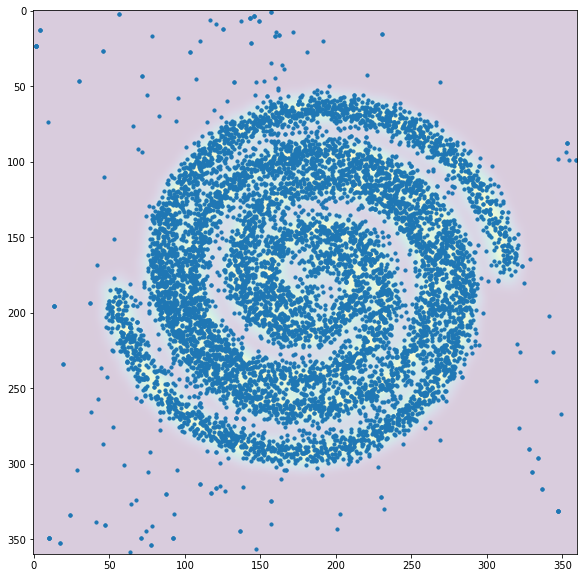

In [ ]:
## Epsilon with 1
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 40
epsilon = 1

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
init_sample = sample_from_image_density(1, density, key).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/spiral_iter10000_k40_e1.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 1], sampled_outputs[:, :, 0], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()

  0%|          | 9/10000 [00:53<15:44:52,  5.67s/it]

Metropolis- Hastings REJECT 1.6346424 2.4997754


  0%|          | 19/10000 [01:48<15:34:49,  5.62s/it]

Metropolis- Hastings REJECT 3.5280929 inf


  0%|          | 23/10000 [02:11<15:21:10,  5.54s/it]

Metropolis- Hastings REJECT 3.514414 inf


  0%|          | 25/10000 [02:22<15:38:09,  5.64s/it]

Metropolis- Hastings REJECT 3.5130205 inf


  0%|          | 26/10000 [02:27<15:29:39,  5.59s/it]

Metropolis- Hastings REJECT 3.5130205 inf


  0%|          | 27/10000 [02:33<15:33:18,  5.62s/it]

Metropolis- Hastings REJECT 3.5130205 inf


  0%|          | 29/10000 [02:44<15:35:29,  5.63s/it]

Metropolis- Hastings REJECT 3.5162048 3.5285113


  0%|          | 32/10000 [03:01<15:28:19,  5.59s/it]

Metropolis- Hastings REJECT 1.105978 1.3835506


  0%|          | 35/10000 [03:18<15:22:49,  5.56s/it]

Metropolis- Hastings REJECT 2.3464851 2.9896536


  0%|          | 40/10000 [03:45<15:15:17,  5.51s/it]

Metropolis- Hastings REJECT 2.2498057 3.523645


  1%|          | 58/10000 [05:23<15:00:01,  5.43s/it]

Metropolis- Hastings REJECT 0.9609065 3.560633


  1%|          | 60/10000 [05:34<15:08:04,  5.48s/it]

Metropolis- Hastings REJECT 0.9928671 1.1792365


  1%|          | 62/10000 [05:46<15:15:34,  5.53s/it]

Metropolis- Hastings REJECT 0.99988526 1.945289


  1%|          | 75/10000 [06:57<15:13:38,  5.52s/it]

Metropolis- Hastings REJECT 0.9221951 0.9676211


  1%|          | 85/10000 [07:52<15:10:25,  5.51s/it]

Metropolis- Hastings REJECT 0.96962917 1.2036239


  1%|          | 100/10000 [09:15<15:09:18,  5.51s/it]

Metropolis- Hastings REJECT 1.14769 3.5224948


  1%|          | 109/10000 [10:05<15:17:12,  5.56s/it]

Metropolis- Hastings REJECT 1.2302253 1.6719229


  1%|          | 112/10000 [10:21<15:06:03,  5.50s/it]

Metropolis- Hastings REJECT 1.4966576 1.7019247


  1%|          | 114/10000 [10:32<15:05:53,  5.50s/it]

Metropolis- Hastings REJECT 1.0543386 1.4949418


  1%|          | 115/10000 [10:37<15:03:25,  5.48s/it]

Metropolis- Hastings REJECT 1.0543386 2.3121305


  1%|          | 124/10000 [11:27<15:17:54,  5.58s/it]

Metropolis- Hastings REJECT 1.129215 1.2947798


  1%|▏         | 128/10000 [11:49<15:12:38,  5.55s/it]

Metropolis- Hastings REJECT 0.99702 2.1419172


  1%|▏         | 132/10000 [12:11<14:58:44,  5.46s/it]

Metropolis- Hastings REJECT 0.9777121 1.072988


  1%|▏         | 134/10000 [12:22<15:16:16,  5.57s/it]

Metropolis- Hastings REJECT 0.98886096 1.1433818


  2%|▏         | 160/10000 [14:45<15:12:48,  5.57s/it]

Metropolis- Hastings REJECT 3.507527 inf


  2%|▏         | 161/10000 [14:51<15:17:28,  5.59s/it]

Metropolis- Hastings REJECT 3.507527 inf


  2%|▏         | 162/10000 [14:56<15:15:46,  5.59s/it]

Metropolis- Hastings REJECT 3.507527 inf


  2%|▏         | 163/10000 [15:02<15:25:42,  5.65s/it]

Metropolis- Hastings REJECT 3.507527 inf


  2%|▏         | 165/10000 [15:13<15:20:58,  5.62s/it]

Metropolis- Hastings REJECT 3.5079484 inf


  2%|▏         | 169/10000 [15:36<15:20:08,  5.62s/it]

Metropolis- Hastings REJECT 3.511558 inf


  2%|▏         | 171/10000 [15:47<15:15:18,  5.59s/it]

Metropolis- Hastings REJECT 3.513238 3.519681


  2%|▏         | 179/10000 [16:30<14:44:15,  5.40s/it]

Metropolis- Hastings REJECT 3.5097325 inf


  2%|▏         | 188/10000 [17:19<14:39:45,  5.38s/it]

Metropolis- Hastings REJECT 0.985075 2.5608232


  2%|▏         | 189/10000 [17:24<14:37:28,  5.37s/it]

Metropolis- Hastings REJECT 0.985075 2.1128283


  2%|▏         | 205/10000 [18:53<15:07:00,  5.56s/it]

Metropolis- Hastings REJECT 1.2073599 2.3485758


  2%|▏         | 218/10000 [20:07<15:45:54,  5.80s/it]

Metropolis- Hastings REJECT 0.9798026 1.3426503


  2%|▏         | 221/10000 [20:24<15:43:06,  5.79s/it]

Metropolis- Hastings REJECT 0.95779765 1.8255118


  2%|▏         | 225/10000 [20:46<15:09:52,  5.58s/it]

Metropolis- Hastings REJECT 1.1264665 1.2471652


  2%|▏         | 240/10000 [22:11<15:32:48,  5.73s/it]

Metropolis- Hastings REJECT 1.4239439 1.4943612


  2%|▏         | 242/10000 [22:23<15:22:40,  5.67s/it]

Metropolis- Hastings REJECT 1.3350393 2.5665843


  2%|▏         | 249/10000 [23:02<15:28:03,  5.71s/it]

Metropolis- Hastings REJECT 1.0716193 1.4901495


  3%|▎         | 265/10000 [24:32<15:21:33,  5.68s/it]

Metropolis- Hastings REJECT 1.002673 1.5533645


  3%|▎         | 266/10000 [24:38<15:21:44,  5.68s/it]

Metropolis- Hastings REJECT 1.002673 1.341878


  3%|▎         | 270/10000 [25:00<15:14:35,  5.64s/it]

Metropolis- Hastings REJECT 1.0487843 1.3796117


  3%|▎         | 277/10000 [25:40<15:21:43,  5.69s/it]

Metropolis- Hastings REJECT 1.0377257 1.4063708


  3%|▎         | 283/10000 [26:13<14:48:41,  5.49s/it]

Metropolis- Hastings REJECT 1.3605411 2.441064


  3%|▎         | 292/10000 [27:03<14:50:13,  5.50s/it]

Metropolis- Hastings REJECT 0.98586535 1.0100878


  3%|▎         | 304/10000 [28:08<14:46:49,  5.49s/it]

Metropolis- Hastings REJECT 1.1037992 1.3103157


  3%|▎         | 332/10000 [30:42<14:43:02,  5.48s/it]

Metropolis- Hastings REJECT 1.1601493 1.8775687


  3%|▎         | 348/10000 [32:11<14:58:17,  5.58s/it]

Metropolis- Hastings REJECT 1.133405 3.5592232


  4%|▍         | 378/10000 [34:57<14:40:45,  5.49s/it]

Metropolis- Hastings REJECT 1.1080384 2.9353805


  4%|▍         | 385/10000 [35:35<14:44:04,  5.52s/it]

Metropolis- Hastings REJECT 1.0520446 1.1031567


  4%|▍         | 386/10000 [35:40<14:37:45,  5.48s/it]

Metropolis- Hastings REJECT 1.0520446 1.165539


  4%|▍         | 395/10000 [36:29<14:36:01,  5.47s/it]

Metropolis- Hastings REJECT 1.0904546 2.3200085


  4%|▍         | 407/10000 [37:34<14:27:11,  5.42s/it]

Metropolis- Hastings REJECT 1.1191523 3.4057243


  4%|▍         | 413/10000 [38:07<14:33:13,  5.47s/it]

Metropolis- Hastings REJECT 1.0826657 1.3525858


  4%|▍         | 435/10000 [40:08<14:53:19,  5.60s/it]

Metropolis- Hastings REJECT 1.6262712 3.5270686


  4%|▍         | 446/10000 [41:10<15:11:43,  5.73s/it]

Metropolis- Hastings REJECT 1.087032 1.5840747


  5%|▍         | 456/10000 [42:06<14:45:41,  5.57s/it]

Metropolis- Hastings REJECT 1.3123544 2.1865969


  5%|▍         | 460/10000 [42:29<14:57:46,  5.65s/it]

Metropolis- Hastings REJECT 1.1681143 2.888801


  5%|▍         | 474/10000 [43:49<15:05:19,  5.70s/it]

Metropolis- Hastings REJECT 1.06596 1.2671512


  5%|▍         | 484/10000 [44:44<14:32:29,  5.50s/it]

Metropolis- Hastings REJECT 0.9714245 1.5659091


  5%|▍         | 498/10000 [46:03<15:02:22,  5.70s/it]

Metropolis- Hastings REJECT 1.1162529 1.5922507


  5%|▌         | 506/10000 [46:48<14:44:29,  5.59s/it]

Metropolis- Hastings REJECT 1.0225124 1.4105448


  5%|▌         | 512/10000 [47:21<14:47:26,  5.61s/it]

Metropolis- Hastings REJECT 1.3479865 2.033231


  5%|▌         | 528/10000 [48:51<14:42:03,  5.59s/it]

Metropolis- Hastings REJECT 1.0097346 3.0176241


  5%|▌         | 529/10000 [48:57<14:39:45,  5.57s/it]

Metropolis- Hastings REJECT 1.0097346 1.532827


  5%|▌         | 549/10000 [50:49<14:42:31,  5.60s/it]

Metropolis- Hastings REJECT 1.283815 1.8135034


  6%|▌         | 556/10000 [51:28<14:36:11,  5.57s/it]

Metropolis- Hastings REJECT 1.0538769 3.5255237


  6%|▌         | 557/10000 [51:33<14:35:46,  5.56s/it]

Metropolis- Hastings REJECT 1.0538769 1.7579104


  6%|▌         | 558/10000 [51:39<14:41:57,  5.60s/it]

Metropolis- Hastings REJECT 1.0538769 1.7310768


  6%|▌         | 579/10000 [53:36<14:40:36,  5.61s/it]

Metropolis- Hastings REJECT 1.2555304 1.8508687


  6%|▌         | 595/10000 [55:04<14:37:02,  5.60s/it]

Metropolis- Hastings REJECT 0.98953515 1.1481595


  6%|▌         | 612/10000 [56:39<14:35:18,  5.59s/it]

Metropolis- Hastings REJECT 1.8220476 2.466031


  6%|▌         | 615/10000 [56:55<14:35:20,  5.60s/it]

Metropolis- Hastings REJECT 1.0673418 1.43833


  6%|▌         | 616/10000 [57:01<14:29:23,  5.56s/it]

Metropolis- Hastings REJECT 1.0673418 1.4923307


  6%|▌         | 617/10000 [57:06<14:26:19,  5.54s/it]

Metropolis- Hastings REJECT 1.0673418 1.8006462


  6%|▋         | 637/10000 [58:57<14:19:08,  5.51s/it]

Metropolis- Hastings REJECT 1.0695091 2.2322855


  6%|▋         | 647/10000 [59:53<14:34:39,  5.61s/it]

Metropolis- Hastings REJECT 1.0213926 1.2165923


  7%|▋         | 683/10000 [1:03:09<13:57:17,  5.39s/it]

Metropolis- Hastings REJECT 1.1226611 3.5513997


  7%|▋         | 691/10000 [1:03:53<14:00:26,  5.42s/it]

Metropolis- Hastings REJECT 1.0712609 1.5047654


  7%|▋         | 692/10000 [1:03:59<14:10:59,  5.49s/it]

Metropolis- Hastings REJECT 1.0712609 1.827863


  7%|▋         | 699/10000 [1:04:37<14:06:32,  5.46s/it]

Metropolis- Hastings REJECT 1.2183478 2.088996


  7%|▋         | 705/10000 [1:05:10<14:10:57,  5.49s/it]

Metropolis- Hastings REJECT 0.9768963 1.0007226


  7%|▋         | 709/10000 [1:05:32<14:06:37,  5.47s/it]

Metropolis- Hastings REJECT 1.4565799 1.581368


  7%|▋         | 712/10000 [1:05:48<14:07:50,  5.48s/it]

Metropolis- Hastings REJECT 1.3071574 2.0820217


  8%|▊         | 750/10000 [1:09:18<14:21:32,  5.59s/it]

Metropolis- Hastings REJECT 0.9441787 1.232574


  8%|▊         | 752/10000 [1:09:29<14:10:15,  5.52s/it]

Metropolis- Hastings REJECT 0.9715148 1.4148697


  8%|▊         | 760/10000 [1:10:14<14:17:42,  5.57s/it]

Metropolis- Hastings REJECT 1.2183843 3.5452588


  8%|▊         | 783/10000 [1:12:24<14:31:41,  5.67s/it]

Metropolis- Hastings REJECT 1.056634 1.1748683


  8%|▊         | 784/10000 [1:12:30<14:33:34,  5.69s/it]

Metropolis- Hastings REJECT 1.056634 1.2800617


  8%|▊         | 787/10000 [1:12:47<14:31:03,  5.67s/it]

Metropolis- Hastings REJECT 1.1739372 1.7063582


  8%|▊         | 789/10000 [1:12:58<14:35:01,  5.70s/it]

Metropolis- Hastings REJECT 1.126508 2.9363716


  8%|▊         | 797/10000 [1:13:44<15:02:21,  5.88s/it]

Metropolis- Hastings REJECT 0.94229937 2.836543


  8%|▊         | 803/10000 [1:14:18<14:27:47,  5.66s/it]

Metropolis- Hastings REJECT 1.2714335 inf


  8%|▊         | 816/10000 [1:15:31<14:01:48,  5.50s/it]

Metropolis- Hastings REJECT 1.877001 2.0246594


  8%|▊         | 825/10000 [1:16:22<14:36:06,  5.73s/it]

Metropolis- Hastings REJECT 0.97966194 1.9704129


  8%|▊         | 826/10000 [1:16:27<14:26:36,  5.67s/it]

Metropolis- Hastings REJECT 0.97966194 1.3828185


  8%|▊         | 827/10000 [1:16:33<14:20:03,  5.63s/it]

Metropolis- Hastings REJECT 0.97966194 1.8559117


  8%|▊         | 832/10000 [1:17:01<14:16:12,  5.60s/it]

Metropolis- Hastings REJECT 1.5368088 2.3700628


  9%|▊         | 867/10000 [1:20:17<14:32:58,  5.74s/it]

Metropolis- Hastings REJECT 1.0535853 1.1397835


  9%|▊         | 871/10000 [1:20:40<14:28:34,  5.71s/it]

Metropolis- Hastings REJECT 1.2915195 1.7601784


  9%|▊         | 874/10000 [1:20:56<14:16:29,  5.63s/it]

Metropolis- Hastings REJECT 0.9311737 1.6284815


  9%|▉         | 928/10000 [1:26:00<14:25:07,  5.72s/it]

Metropolis- Hastings REJECT 1.0120672 1.3868644


  9%|▉         | 932/10000 [1:26:23<14:25:54,  5.73s/it]

Metropolis- Hastings REJECT 1.4030126 1.6160678


  9%|▉         | 936/10000 [1:26:45<14:12:06,  5.64s/it]

Metropolis- Hastings REJECT 2.3582134 3.4766111


  9%|▉         | 943/10000 [1:27:24<14:03:35,  5.59s/it]

Metropolis- Hastings REJECT 1.443379 1.7998363


 10%|▉         | 956/10000 [1:28:36<13:49:13,  5.50s/it]

Metropolis- Hastings REJECT 1.1682861 2.1101916


 10%|▉         | 962/10000 [1:29:10<14:16:59,  5.69s/it]

Metropolis- Hastings REJECT 1.0878742 1.6117789


 10%|▉         | 972/10000 [1:30:06<13:59:27,  5.58s/it]

Metropolis- Hastings REJECT 1.1862221 1.4580766


 10%|▉         | 980/10000 [1:30:51<14:04:29,  5.62s/it]

Metropolis- Hastings REJECT 1.0211853 1.5798205


 10%|█         | 1006/10000 [1:33:16<13:53:19,  5.56s/it]

Metropolis- Hastings REJECT 0.9747027 2.1774495


 10%|█         | 1009/10000 [1:33:33<13:55:20,  5.57s/it]

Metropolis- Hastings REJECT 1.1187066 2.2235785


 10%|█         | 1013/10000 [1:33:56<14:04:57,  5.64s/it]

Metropolis- Hastings REJECT 1.0646641 1.3537253


 10%|█         | 1015/10000 [1:34:07<14:15:58,  5.72s/it]

Metropolis- Hastings REJECT 1.0356497 1.508647


 10%|█         | 1024/10000 [1:34:58<14:00:35,  5.62s/it]

Metropolis- Hastings REJECT 1.0532187 1.8947681


 10%|█         | 1027/10000 [1:35:15<14:00:20,  5.62s/it]

Metropolis- Hastings REJECT 0.9652652 2.090469


 10%|█         | 1038/10000 [1:36:17<14:17:35,  5.74s/it]

Metropolis- Hastings REJECT 1.4642807 2.1447678


 10%|█         | 1039/10000 [1:36:23<14:22:23,  5.77s/it]

Metropolis- Hastings REJECT 1.4642807 3.5491343


 11%|█         | 1053/10000 [1:37:41<13:44:40,  5.53s/it]

Metropolis- Hastings REJECT 1.1525615 1.5748606


 11%|█         | 1064/10000 [1:38:42<14:02:06,  5.65s/it]

Metropolis- Hastings REJECT 1.3602713 2.087347


 11%|█         | 1065/10000 [1:38:48<14:18:59,  5.77s/it]

Metropolis- Hastings REJECT 1.3602713 1.6501342


 11%|█         | 1072/10000 [1:39:28<13:57:40,  5.63s/it]

Metropolis- Hastings REJECT 0.9347897 1.735085


 11%|█         | 1083/10000 [1:40:30<13:54:38,  5.62s/it]

Metropolis- Hastings REJECT 1.0263824 1.1522485


 11%|█         | 1106/10000 [1:42:39<13:47:59,  5.59s/it]

Metropolis- Hastings REJECT 1.009476 1.5198972


 11%|█         | 1113/10000 [1:43:18<13:41:45,  5.55s/it]

Metropolis- Hastings REJECT 0.9454291 1.9069164


 11%|█▏        | 1130/10000 [1:44:53<13:55:08,  5.65s/it]

Metropolis- Hastings REJECT 1.3994201 2.105127


 11%|█▏        | 1144/10000 [1:46:12<13:53:23,  5.65s/it]

Metropolis- Hastings REJECT 1.1900182 1.4780185


 12%|█▏        | 1162/10000 [1:47:52<13:50:44,  5.64s/it]

Metropolis- Hastings REJECT 1.1283514 1.2267587


 12%|█▏        | 1168/10000 [1:48:25<13:51:42,  5.65s/it]

Metropolis- Hastings REJECT 1.7723615 1.9067643


 12%|█▏        | 1174/10000 [1:48:59<13:54:30,  5.67s/it]

Metropolis- Hastings REJECT 1.0269809 2.2871583


 12%|█▏        | 1175/10000 [1:49:05<13:49:56,  5.64s/it]

Metropolis- Hastings REJECT 1.0269809 3.564164


 12%|█▏        | 1177/10000 [1:49:16<13:51:08,  5.65s/it]

Metropolis- Hastings REJECT 2.3392417 2.9501534


 12%|█▏        | 1184/10000 [1:49:56<13:50:32,  5.65s/it]

Metropolis- Hastings REJECT 1.0635998 2.1061502


 12%|█▏        | 1187/10000 [1:50:13<13:46:59,  5.63s/it]

Metropolis- Hastings REJECT 1.1492013 1.4062272


 12%|█▏        | 1193/10000 [1:50:46<13:41:55,  5.60s/it]

Metropolis- Hastings REJECT 0.98801315 1.0856366


 12%|█▏        | 1198/10000 [1:51:14<13:44:42,  5.62s/it]

Metropolis- Hastings REJECT 1.585994 1.7469056


 12%|█▏        | 1203/10000 [1:51:43<13:46:26,  5.64s/it]

Metropolis- Hastings REJECT 1.4722285 1.6812305


 12%|█▏        | 1204/10000 [1:51:49<13:47:38,  5.65s/it]

Metropolis- Hastings REJECT 1.4722285 1.9590547


 12%|█▏        | 1208/10000 [1:52:11<13:52:45,  5.68s/it]

Metropolis- Hastings REJECT 1.6490607 1.8028712


 12%|█▏        | 1219/10000 [1:53:13<13:43:56,  5.63s/it]

Metropolis- Hastings REJECT 1.0015115 1.093935


 12%|█▏        | 1221/10000 [1:53:25<13:46:03,  5.65s/it]

Metropolis- Hastings REJECT 1.0058781 2.4007764


 12%|█▏        | 1237/10000 [1:54:54<13:38:52,  5.61s/it]

Metropolis- Hastings REJECT 1.0252475 1.9313636


 12%|█▏        | 1246/10000 [1:55:45<13:43:33,  5.64s/it]

Metropolis- Hastings REJECT 1.0336194 3.5713737


 12%|█▏        | 1247/10000 [1:55:51<13:46:47,  5.67s/it]

Metropolis- Hastings REJECT 1.0336194 1.3021586


 13%|█▎        | 1259/10000 [1:56:58<13:32:47,  5.58s/it]

Metropolis- Hastings REJECT 1.3127967 3.5132914


 13%|█▎        | 1263/10000 [1:57:20<13:29:50,  5.56s/it]

Metropolis- Hastings REJECT 2.338512 3.546298


 13%|█▎        | 1285/10000 [1:59:22<13:18:16,  5.50s/it]

Metropolis- Hastings REJECT 1.4136761 3.489666


 13%|█▎        | 1293/10000 [2:00:06<13:20:05,  5.51s/it]

Metropolis- Hastings REJECT 1.0218956 1.110375


 13%|█▎        | 1303/10000 [2:01:01<13:19:45,  5.52s/it]

Metropolis- Hastings REJECT 0.99102306 1.6713439


 13%|█▎        | 1305/10000 [2:01:13<13:25:29,  5.56s/it]

Metropolis- Hastings REJECT 1.0076005 1.5714738


 13%|█▎        | 1306/10000 [2:01:18<13:29:29,  5.59s/it]

Metropolis- Hastings REJECT 1.0076005 1.1637831


 13%|█▎        | 1316/10000 [2:02:14<13:36:15,  5.64s/it]

Metropolis- Hastings REJECT 1.1398315 1.2472826


 13%|█▎        | 1321/10000 [2:02:42<13:38:04,  5.66s/it]

Metropolis- Hastings REJECT 1.9447405 3.5489435


 13%|█▎        | 1325/10000 [2:03:05<13:26:35,  5.58s/it]

Metropolis- Hastings REJECT 1.2676256 2.1691327


 13%|█▎        | 1329/10000 [2:03:27<13:32:23,  5.62s/it]

Metropolis- Hastings REJECT 1.4795946 1.5016155


 13%|█▎        | 1331/10000 [2:03:38<13:34:51,  5.64s/it]

Metropolis- Hastings REJECT 1.0722222 1.3979979


 13%|█▎        | 1332/10000 [2:03:44<13:23:55,  5.56s/it]

Metropolis- Hastings REJECT 1.0722222 1.9777689


 13%|█▎        | 1334/10000 [2:03:55<13:29:45,  5.61s/it]

Metropolis- Hastings REJECT 1.1327313 3.5361178


 14%|█▎        | 1372/10000 [2:07:29<13:30:37,  5.64s/it]

Metropolis- Hastings REJECT 1.1150293 1.6873512


 14%|█▍        | 1392/10000 [2:09:19<13:11:50,  5.52s/it]

Metropolis- Hastings REJECT 1.5752952 1.8160689


 14%|█▍        | 1400/10000 [2:10:05<13:37:34,  5.70s/it]

Metropolis- Hastings REJECT 0.9955835 1.4478298


 14%|█▍        | 1406/10000 [2:10:39<13:51:07,  5.80s/it]

Metropolis- Hastings REJECT 1.0013821 1.8524157


 14%|█▍        | 1407/10000 [2:10:45<14:00:15,  5.87s/it]

Metropolis- Hastings REJECT 1.0013821 1.0152218


 14%|█▍        | 1414/10000 [2:11:25<13:38:18,  5.72s/it]

Metropolis- Hastings REJECT 1.0195589 2.7403872


 14%|█▍        | 1418/10000 [2:11:47<13:36:29,  5.71s/it]

Metropolis- Hastings REJECT 1.1259549 3.4308832


 14%|█▍        | 1425/10000 [2:12:27<13:23:19,  5.62s/it]

Metropolis- Hastings REJECT 1.4946052 3.5593648


 14%|█▍        | 1434/10000 [2:13:18<13:34:03,  5.70s/it]

Metropolis- Hastings REJECT 1.0583737 3.1049273


 14%|█▍        | 1437/10000 [2:13:35<13:33:59,  5.70s/it]

Metropolis- Hastings REJECT 1.1115503 1.4240894


 15%|█▍        | 1463/10000 [2:16:03<13:34:31,  5.72s/it]

Metropolis- Hastings REJECT 1.257167 1.9232168


 15%|█▍        | 1467/10000 [2:16:26<13:22:44,  5.64s/it]

Metropolis- Hastings REJECT 1.0421053 1.5686405


 15%|█▍        | 1473/10000 [2:17:00<13:24:02,  5.66s/it]

Metropolis- Hastings REJECT 1.0288961 1.5946136


 15%|█▍        | 1479/10000 [2:17:34<13:34:22,  5.73s/it]

Metropolis- Hastings REJECT 0.97022456 1.550514


 15%|█▍        | 1491/10000 [2:18:43<13:28:57,  5.70s/it]

Metropolis- Hastings REJECT 1.7306985 3.5308769


 15%|█▌        | 1500/10000 [2:19:34<13:27:44,  5.70s/it]

Metropolis- Hastings REJECT 1.1849531 1.3751831


 15%|█▌        | 1524/10000 [2:21:50<13:24:20,  5.69s/it]

Metropolis- Hastings REJECT 1.1787134 1.7857211


 15%|█▌        | 1530/10000 [2:22:24<13:30:40,  5.74s/it]

Metropolis- Hastings REJECT 1.137586 1.3893152


 15%|█▌        | 1535/10000 [2:22:53<13:19:07,  5.66s/it]

Metropolis- Hastings REJECT 0.99787915 1.5884366


 15%|█▌        | 1542/10000 [2:23:32<13:19:41,  5.67s/it]

Metropolis- Hastings REJECT 1.1253018 1.38969


 16%|█▌        | 1572/10000 [2:26:18<13:08:45,  5.62s/it]

Metropolis- Hastings REJECT 1.0753636 1.9412241


 16%|█▌        | 1573/10000 [2:26:24<13:08:19,  5.61s/it]

Metropolis- Hastings REJECT 1.0753636 1.3219645


 16%|█▌        | 1580/10000 [2:27:03<13:01:59,  5.57s/it]

Metropolis- Hastings REJECT 1.6518949 2.0981288


 16%|█▌        | 1581/10000 [2:27:08<12:53:13,  5.51s/it]

Metropolis- Hastings REJECT 1.6518949 2.4992847


 16%|█▌        | 1584/10000 [2:27:25<12:49:47,  5.49s/it]

Metropolis- Hastings REJECT 1.016264 2.25241


 16%|█▌        | 1590/10000 [2:27:58<12:58:24,  5.55s/it]

Metropolis- Hastings REJECT 0.96118623 2.195935


 16%|█▌        | 1594/10000 [2:28:21<13:05:04,  5.60s/it]

Metropolis- Hastings REJECT 0.90424395 1.1486585


 16%|█▌        | 1595/10000 [2:28:27<13:15:31,  5.68s/it]

Metropolis- Hastings REJECT 0.90424395 0.97300994


 16%|█▌        | 1597/10000 [2:28:38<13:11:33,  5.65s/it]

Metropolis- Hastings REJECT 0.9724437 1.929744


 16%|█▌        | 1603/10000 [2:29:11<13:00:37,  5.58s/it]

Metropolis- Hastings REJECT 0.9455995 1.3359226


 16%|█▌        | 1604/10000 [2:29:17<13:06:34,  5.62s/it]

Metropolis- Hastings REJECT 0.9455995 1.3690283


 16%|█▌        | 1610/10000 [2:29:51<13:05:23,  5.62s/it]

Metropolis- Hastings REJECT 0.93910146 2.984909


 16%|█▌        | 1623/10000 [2:31:04<13:08:07,  5.64s/it]

Metropolis- Hastings REJECT 0.98101616 1.4792126


 16%|█▌        | 1624/10000 [2:31:09<13:07:06,  5.64s/it]

Metropolis- Hastings REJECT 0.98101616 1.2037382


 16%|█▋        | 1629/10000 [2:31:37<12:59:18,  5.59s/it]

Metropolis- Hastings REJECT 0.98634523 1.0101227


 16%|█▋        | 1633/10000 [2:32:00<13:01:18,  5.60s/it]

Metropolis- Hastings REJECT 0.9774586 1.38381


 16%|█▋        | 1636/10000 [2:32:16<12:56:18,  5.57s/it]

Metropolis- Hastings REJECT 3.5524547 inf


 16%|█▋        | 1641/10000 [2:32:44<12:57:01,  5.58s/it]

Metropolis- Hastings REJECT 1.2343593 1.3791473


 16%|█▋        | 1643/10000 [2:32:56<13:08:40,  5.66s/it]

Metropolis- Hastings REJECT 0.98262477 1.125722


 16%|█▋        | 1644/10000 [2:33:01<13:02:27,  5.62s/it]

Metropolis- Hastings REJECT 0.98262477 1.2031872


 16%|█▋        | 1646/10000 [2:33:13<13:10:00,  5.67s/it]

Metropolis- Hastings REJECT 1.1122447 2.0116155


 16%|█▋        | 1649/10000 [2:33:29<13:05:29,  5.64s/it]

Metropolis- Hastings REJECT 1.0374128 1.6512272


 17%|█▋        | 1658/10000 [2:34:19<12:59:03,  5.60s/it]

Metropolis- Hastings REJECT 1.1651063 2.3582828


 17%|█▋        | 1664/10000 [2:34:52<12:47:09,  5.52s/it]

Metropolis- Hastings REJECT 0.9065656 1.1469985


 17%|█▋        | 1672/10000 [2:35:37<12:45:29,  5.52s/it]

Metropolis- Hastings REJECT 1.0279388 1.1106919


 17%|█▋        | 1686/10000 [2:36:56<13:07:40,  5.68s/it]

Metropolis- Hastings REJECT 1.0676309 1.3043594


 17%|█▋        | 1690/10000 [2:37:19<13:03:19,  5.66s/it]

Metropolis- Hastings REJECT 1.0386376 1.4361769


 17%|█▋        | 1697/10000 [2:37:58<13:04:53,  5.67s/it]

Metropolis- Hastings REJECT 1.0035084 1.3909324


 17%|█▋        | 1726/10000 [2:40:41<13:07:23,  5.71s/it]

Metropolis- Hastings REJECT 1.5188468 2.017786


 17%|█▋        | 1740/10000 [2:42:02<13:05:14,  5.70s/it]

Metropolis- Hastings REJECT 0.99529266 1.7482959


 18%|█▊        | 1757/10000 [2:43:38<12:50:17,  5.61s/it]

Metropolis- Hastings REJECT 1.2666552 3.525809


 18%|█▊        | 1760/10000 [2:43:55<13:12:45,  5.77s/it]

Metropolis- Hastings REJECT 1.0221369 1.1278987


 18%|█▊        | 1776/10000 [2:45:26<13:02:27,  5.71s/it]

Metropolis- Hastings REJECT 1.4758885 1.8902885


 18%|█▊        | 1780/10000 [2:45:49<12:57:39,  5.68s/it]

Metropolis- Hastings REJECT 0.96541786 1.2073286


 18%|█▊        | 1785/10000 [2:46:17<12:51:55,  5.64s/it]

Metropolis- Hastings REJECT 1.225502 1.5864524


 18%|█▊        | 1787/10000 [2:46:28<12:51:17,  5.63s/it]

Metropolis- Hastings REJECT 1.4293975 2.1037397


 18%|█▊        | 1795/10000 [2:47:13<13:03:57,  5.73s/it]

Metropolis- Hastings REJECT 0.9990037 2.8938105


 18%|█▊        | 1806/10000 [2:48:15<12:42:29,  5.58s/it]

Metropolis- Hastings REJECT 1.074295 1.4955895


 18%|█▊        | 1814/10000 [2:49:01<12:46:30,  5.62s/it]

Metropolis- Hastings REJECT 1.3558606 1.435865


 18%|█▊        | 1820/10000 [2:49:34<12:54:41,  5.68s/it]

Metropolis- Hastings REJECT 1.3246589 1.8039389


 18%|█▊        | 1827/10000 [2:50:14<13:06:45,  5.78s/it]

Metropolis- Hastings REJECT 1.113186 2.9428043


 18%|█▊        | 1829/10000 [2:50:26<13:05:20,  5.77s/it]

Metropolis- Hastings REJECT 1.2248404 1.9424112


 18%|█▊        | 1845/10000 [2:51:56<12:59:06,  5.73s/it]

Metropolis- Hastings REJECT 1.0390872 3.5297503


 18%|█▊        | 1847/10000 [2:52:08<13:17:13,  5.87s/it]

Metropolis- Hastings REJECT 1.0757701 1.3444915


 19%|█▊        | 1851/10000 [2:52:30<13:00:43,  5.75s/it]

Metropolis- Hastings REJECT 0.97949255 1.8364744


 19%|█▊        | 1864/10000 [2:53:43<12:35:45,  5.57s/it]

Metropolis- Hastings REJECT 1.0196497 1.5116497


 19%|█▊        | 1870/10000 [2:54:16<12:31:16,  5.54s/it]

Metropolis- Hastings REJECT 1.0385488 2.2154813


 19%|█▉        | 1884/10000 [2:55:34<12:30:54,  5.55s/it]

Metropolis- Hastings REJECT 1.7740897 3.5300992


 19%|█▉        | 1887/10000 [2:55:50<12:28:36,  5.54s/it]

Metropolis- Hastings REJECT 0.93965375 1.0547626


 19%|█▉        | 1895/10000 [2:56:35<12:26:38,  5.53s/it]

Metropolis- Hastings REJECT 1.3514 1.6405356


 19%|█▉        | 1896/10000 [2:56:40<12:31:15,  5.56s/it]

Metropolis- Hastings REJECT 1.3514 2.4547899


 19%|█▉        | 1898/10000 [2:56:51<12:28:40,  5.54s/it]

Metropolis- Hastings REJECT 1.0183415 3.4930947


 19%|█▉        | 1900/10000 [2:57:02<12:25:53,  5.53s/it]

Metropolis- Hastings REJECT 0.984905 1.0674555


 19%|█▉        | 1902/10000 [2:57:13<12:30:48,  5.56s/it]

Metropolis- Hastings REJECT 1.0166099 1.9624112


 19%|█▉        | 1918/10000 [2:58:41<12:17:52,  5.48s/it]

Metropolis- Hastings REJECT 1.2391425 1.3333266


 19%|█▉        | 1919/10000 [2:58:47<12:15:17,  5.46s/it]

Metropolis- Hastings REJECT 1.2391425 1.8166654


 19%|█▉        | 1927/10000 [2:59:31<12:28:40,  5.56s/it]

Metropolis- Hastings REJECT 0.976177 1.7953109


 19%|█▉        | 1937/10000 [3:00:26<12:14:47,  5.47s/it]

Metropolis- Hastings REJECT 1.8261657 1.8865587


 19%|█▉        | 1944/10000 [3:01:05<12:26:21,  5.56s/it]

Metropolis- Hastings REJECT 0.9653026 1.2550166


 20%|█▉        | 1963/10000 [3:02:49<12:08:18,  5.44s/it]

Metropolis- Hastings REJECT 2.1552806 3.5263586


 20%|█▉        | 1973/10000 [3:03:44<12:15:14,  5.50s/it]

Metropolis- Hastings REJECT 1.2433664 2.0707471


 20%|█▉        | 1979/10000 [3:04:16<12:07:13,  5.44s/it]

Metropolis- Hastings REJECT 0.9797659 1.5488021


 20%|█▉        | 1980/10000 [3:04:22<12:14:41,  5.50s/it]

Metropolis- Hastings REJECT 0.9797659 1.3133825


 20%|█▉        | 1994/10000 [3:05:39<12:15:32,  5.51s/it]

Metropolis- Hastings REJECT 1.0259933 1.6901371


 20%|██        | 2011/10000 [3:07:13<12:08:48,  5.47s/it]

Metropolis- Hastings REJECT 0.9456878 1.8988031


 20%|██        | 2028/10000 [3:08:48<12:20:36,  5.57s/it]

Metropolis- Hastings REJECT 0.99391514 1.6345876


 20%|██        | 2029/10000 [3:08:53<12:14:50,  5.53s/it]

Metropolis- Hastings REJECT 0.99391514 1.608628


 20%|██        | 2033/10000 [3:09:15<12:23:45,  5.60s/it]

Metropolis- Hastings REJECT 2.0546024 2.4546301


 21%|██        | 2066/10000 [3:12:19<12:17:31,  5.58s/it]

Metropolis- Hastings REJECT 1.1081692 1.7787688


 21%|██        | 2079/10000 [3:13:32<12:19:24,  5.60s/it]

Metropolis- Hastings REJECT 1.0529385 1.2861274


 21%|██        | 2082/10000 [3:13:49<12:16:46,  5.58s/it]

Metropolis- Hastings REJECT 1.0878174 2.801682


 21%|██        | 2116/10000 [3:16:59<12:25:02,  5.67s/it]

Metropolis- Hastings REJECT 1.0402961 1.1501063


 21%|██        | 2122/10000 [3:17:33<12:17:32,  5.62s/it]

Metropolis- Hastings REJECT 1.0627007 1.1908782


 21%|██▏       | 2125/10000 [3:17:50<12:28:30,  5.70s/it]

Metropolis- Hastings REJECT 0.9641645 1.0784243


 22%|██▏       | 2160/10000 [3:21:09<12:19:25,  5.66s/it]

Metropolis- Hastings REJECT 3.5145893 inf


 22%|██▏       | 2161/10000 [3:21:14<12:19:22,  5.66s/it]

Metropolis- Hastings REJECT 3.5145893 inf


 22%|██▏       | 2164/10000 [3:21:31<12:15:37,  5.63s/it]

Metropolis- Hastings REJECT 3.5210714 inf


 22%|██▏       | 2167/10000 [3:21:49<12:32:08,  5.76s/it]

Metropolis- Hastings REJECT 3.5166464 inf


 22%|██▏       | 2168/10000 [3:21:54<12:34:15,  5.78s/it]

Metropolis- Hastings REJECT 3.5166464 inf


 22%|██▏       | 2172/10000 [3:22:17<12:14:20,  5.63s/it]

Metropolis- Hastings REJECT 3.5143516 inf


 22%|██▏       | 2187/10000 [3:23:40<12:16:41,  5.66s/it]

Metropolis- Hastings REJECT 1.2248334 2.2162466


 22%|██▏       | 2204/10000 [3:25:14<12:08:25,  5.61s/it]

Metropolis- Hastings REJECT 1.0604837 1.6133685


 22%|██▏       | 2212/10000 [3:25:59<12:06:39,  5.60s/it]

Metropolis- Hastings REJECT 1.6428432 1.8797208


 22%|██▏       | 2246/10000 [3:29:07<11:58:18,  5.56s/it]

Metropolis- Hastings REJECT 1.0357509 1.7102097


 23%|██▎       | 2254/10000 [3:29:51<11:50:33,  5.50s/it]

Metropolis- Hastings REJECT 1.2418963 1.6554933


 23%|██▎       | 2259/10000 [3:30:18<11:48:00,  5.49s/it]

Metropolis- Hastings REJECT 2.2002323 3.5239806


 23%|██▎       | 2276/10000 [3:31:52<11:46:25,  5.49s/it]

Metropolis- Hastings REJECT 1.1643237 2.7746463


 23%|██▎       | 2283/10000 [3:32:31<11:58:20,  5.59s/it]

Metropolis- Hastings REJECT 1.0903659 3.2191737


 23%|██▎       | 2294/10000 [3:33:32<11:55:48,  5.57s/it]

Metropolis- Hastings REJECT 0.95998824 1.4210849


 23%|██▎       | 2298/10000 [3:33:54<11:56:01,  5.58s/it]

Metropolis- Hastings REJECT 0.9762017 1.9660802


 23%|██▎       | 2303/10000 [3:34:21<11:41:12,  5.47s/it]

Metropolis- Hastings REJECT 0.9973283 1.3272704


 23%|██▎       | 2317/10000 [3:35:38<11:40:23,  5.47s/it]

Metropolis- Hastings REJECT 0.93587613 1.2120113


 23%|██▎       | 2327/10000 [3:36:32<11:49:17,  5.55s/it]

Metropolis- Hastings REJECT 1.0202945 1.759979


 23%|██▎       | 2337/10000 [3:37:28<11:35:53,  5.45s/it]

Metropolis- Hastings REJECT 1.059758 3.5321786


 23%|██▎       | 2343/10000 [3:38:00<11:34:23,  5.44s/it]

Metropolis- Hastings REJECT 1.564755 3.5251608


 24%|██▎       | 2350/10000 [3:38:39<11:47:30,  5.55s/it]

Metropolis- Hastings REJECT 0.9847894 3.5413465


 24%|██▎       | 2353/10000 [3:38:55<11:44:55,  5.53s/it]

Metropolis- Hastings REJECT 1.0078025 3.2205262


 24%|██▎       | 2355/10000 [3:39:06<11:47:27,  5.55s/it]

Metropolis- Hastings REJECT 1.0361326 2.3000455


 24%|██▎       | 2367/10000 [3:40:13<11:49:51,  5.58s/it]

Metropolis- Hastings REJECT 1.0451356 1.3997672


 24%|██▍       | 2376/10000 [3:41:03<11:49:46,  5.59s/it]

Metropolis- Hastings REJECT 1.0645224 3.4731276


 24%|██▍       | 2395/10000 [3:42:49<11:42:13,  5.54s/it]

Metropolis- Hastings REJECT 1.1918983 1.9855806


 24%|██▍       | 2401/10000 [3:43:22<11:51:36,  5.62s/it]

Metropolis- Hastings REJECT 1.0763159 1.218686


 24%|██▍       | 2406/10000 [3:43:50<11:59:54,  5.69s/it]

Metropolis- Hastings REJECT 1.0252459 1.2072098


 24%|██▍       | 2409/10000 [3:44:07<12:06:12,  5.74s/it]

Metropolis- Hastings REJECT 1.0605139 3.5669568


 24%|██▍       | 2410/10000 [3:44:13<12:11:43,  5.78s/it]

Metropolis- Hastings REJECT 1.0605139 3.5485275


 24%|██▍       | 2419/10000 [3:45:04<11:49:58,  5.62s/it]

Metropolis- Hastings REJECT 1.1398695 3.5262976


 24%|██▍       | 2420/10000 [3:45:10<12:00:13,  5.70s/it]

Metropolis- Hastings REJECT 1.1398695 1.4175087


 24%|██▍       | 2421/10000 [3:45:15<11:57:25,  5.68s/it]

Metropolis- Hastings REJECT 1.1398695 1.9169856


 24%|██▍       | 2423/10000 [3:45:26<11:50:24,  5.63s/it]

Metropolis- Hastings REJECT 1.2799697 1.4191749


 24%|██▍       | 2440/10000 [3:47:01<11:39:36,  5.55s/it]

Metropolis- Hastings REJECT 0.96126103 2.1642861


 24%|██▍       | 2442/10000 [3:47:12<11:48:41,  5.63s/it]

Metropolis- Hastings REJECT 1.0173385 1.738216


 24%|██▍       | 2450/10000 [3:47:57<11:44:15,  5.60s/it]

Metropolis- Hastings REJECT 0.96595424 1.7528479


 25%|██▍       | 2456/10000 [3:48:30<11:40:59,  5.58s/it]

Metropolis- Hastings REJECT 1.0059798 2.041988


 25%|██▍       | 2466/10000 [3:49:27<11:44:19,  5.61s/it]

Metropolis- Hastings REJECT 3.5173256 inf


 25%|██▍       | 2472/10000 [3:50:01<11:45:01,  5.62s/it]

Metropolis- Hastings REJECT 3.527376 inf


 25%|██▍       | 2482/10000 [3:50:57<11:47:44,  5.65s/it]

Metropolis- Hastings REJECT 1.095349 1.7856365


 25%|██▌       | 2507/10000 [3:53:18<11:42:44,  5.63s/it]

Metropolis- Hastings REJECT 1.0168315 1.224225


 25%|██▌       | 2510/10000 [3:53:34<11:45:43,  5.65s/it]

Metropolis- Hastings REJECT 1.1015465 1.8735057


 25%|██▌       | 2512/10000 [3:53:46<11:49:13,  5.68s/it]

Metropolis- Hastings REJECT 1.0787277 1.2879936


 25%|██▌       | 2513/10000 [3:53:51<11:45:07,  5.65s/it]

Metropolis- Hastings REJECT 1.0787277 1.4911914


 25%|██▌       | 2521/10000 [3:54:36<11:47:07,  5.67s/it]

Metropolis- Hastings REJECT 1.1116588 1.4893162


 25%|██▌       | 2535/10000 [3:55:54<11:49:42,  5.70s/it]

Metropolis- Hastings REJECT 1.0349449 2.3913589


 25%|██▌       | 2548/10000 [3:57:08<11:50:11,  5.72s/it]

Metropolis- Hastings REJECT 1.0105627 1.475924


 26%|██▌       | 2552/10000 [3:57:30<11:41:56,  5.65s/it]

Metropolis- Hastings REJECT 1.4754235 2.022605


 26%|██▌       | 2562/10000 [3:58:26<11:31:23,  5.58s/it]

Metropolis- Hastings REJECT 1.2847224 1.5983698


 26%|██▌       | 2570/10000 [3:59:11<11:37:33,  5.63s/it]

Metropolis- Hastings REJECT 1.2977083 2.07015


 26%|██▌       | 2577/10000 [3:59:50<11:36:04,  5.63s/it]

Metropolis- Hastings REJECT 1.9527907 2.898087


 26%|██▌       | 2584/10000 [4:00:30<11:41:36,  5.68s/it]

Metropolis- Hastings REJECT 1.2794999 1.8827233


 26%|██▌       | 2586/10000 [4:00:41<11:43:02,  5.69s/it]

Metropolis- Hastings REJECT 0.9903374 3.5202122


 26%|██▌       | 2597/10000 [4:01:44<11:42:48,  5.70s/it]

Metropolis- Hastings REJECT 1.0836381 1.5758365


 26%|██▌       | 2599/10000 [4:01:55<11:46:42,  5.73s/it]

Metropolis- Hastings REJECT 1.4203371 1.823889


 26%|██▌       | 2603/10000 [4:02:18<11:42:46,  5.70s/it]

Metropolis- Hastings REJECT 1.0575302 1.4963198


 26%|██▌       | 2606/10000 [4:02:35<11:42:37,  5.70s/it]

Metropolis- Hastings REJECT 1.116624 1.5008584


 26%|██▌       | 2618/10000 [4:03:42<11:35:26,  5.65s/it]

Metropolis- Hastings REJECT 1.0500196 1.1461236


 26%|██▌       | 2621/10000 [4:03:59<11:34:05,  5.64s/it]

Metropolis- Hastings REJECT 1.0873544 1.5323335


 26%|██▌       | 2622/10000 [4:04:04<11:39:52,  5.69s/it]

Metropolis- Hastings REJECT 1.0873544 3.3396902


 26%|██▋       | 2627/10000 [4:04:32<11:37:45,  5.68s/it]

Metropolis- Hastings REJECT 1.0099342 1.6034391


 26%|██▋       | 2633/10000 [4:05:06<11:36:33,  5.67s/it]

Metropolis- Hastings REJECT 0.92360866 2.0694401


 26%|██▋       | 2637/10000 [4:05:29<11:28:40,  5.61s/it]

Metropolis- Hastings REJECT 1.0762172 1.3106331


 26%|██▋       | 2647/10000 [4:06:25<11:37:54,  5.69s/it]

Metropolis- Hastings REJECT 0.9200845 3.5429268


 27%|██▋       | 2660/10000 [4:07:38<11:33:58,  5.67s/it]

Metropolis- Hastings REJECT 1.0813537 2.1676383


 27%|██▋       | 2670/10000 [4:08:33<11:13:26,  5.51s/it]

Metropolis- Hastings REJECT 1.0405767 2.012


 27%|██▋       | 2680/10000 [4:09:30<11:28:47,  5.65s/it]

Metropolis- Hastings REJECT 1.2091033 1.9453355


 27%|██▋       | 2682/10000 [4:09:41<11:38:20,  5.73s/it]

Metropolis- Hastings REJECT 0.95952433 3.5743852


 27%|██▋       | 2685/10000 [4:09:58<11:38:05,  5.73s/it]

Metropolis- Hastings REJECT 1.0125893 1.7901089


 27%|██▋       | 2695/10000 [4:10:54<11:19:50,  5.58s/it]

Metropolis- Hastings REJECT 1.0733399 1.190819


 27%|██▋       | 2706/10000 [4:11:56<11:30:11,  5.68s/it]

Metropolis- Hastings REJECT 1.0056359 1.3109965


 27%|██▋       | 2716/10000 [4:12:52<11:23:14,  5.63s/it]

Metropolis- Hastings REJECT 3.5251791 inf


 27%|██▋       | 2720/10000 [4:13:15<11:31:35,  5.70s/it]

Metropolis- Hastings REJECT 1.03536 1.0746889


 27%|██▋       | 2722/10000 [4:13:26<11:29:07,  5.68s/it]

Metropolis- Hastings REJECT 1.2110312 1.7428823


 27%|██▋       | 2730/10000 [4:14:12<11:33:15,  5.72s/it]

Metropolis- Hastings REJECT 0.93668187 1.0538316


 28%|██▊       | 2766/10000 [4:17:36<11:34:45,  5.76s/it]

Metropolis- Hastings REJECT 1.0732106 2.1095943


 28%|██▊       | 2768/10000 [4:17:47<11:28:47,  5.71s/it]

Metropolis- Hastings REJECT 0.98330027 1.21769


 28%|██▊       | 2778/10000 [4:18:45<11:43:22,  5.84s/it]

Metropolis- Hastings REJECT 0.97258276 1.2512035


 28%|██▊       | 2813/10000 [4:22:07<11:23:20,  5.70s/it]

Metropolis- Hastings REJECT 1.1131831 1.2846298


 28%|██▊       | 2818/10000 [4:22:35<11:30:24,  5.77s/it]

Metropolis- Hastings REJECT 1.071145 1.652329


 28%|██▊       | 2823/10000 [4:23:03<11:15:32,  5.65s/it]

Metropolis- Hastings REJECT 1.4046023 1.8599536


 28%|██▊       | 2825/10000 [4:23:15<11:15:48,  5.65s/it]

Metropolis- Hastings REJECT 1.0599666 2.4074914


 28%|██▊       | 2836/10000 [4:24:17<11:13:44,  5.64s/it]

Metropolis- Hastings REJECT 1.0193636 1.1815442


 28%|██▊       | 2846/10000 [4:25:13<11:16:55,  5.68s/it]

Metropolis- Hastings REJECT 1.1433778 1.4228225


 29%|██▊       | 2860/10000 [4:26:32<11:10:13,  5.63s/it]

Metropolis- Hastings REJECT 0.9934163 2.187627


 29%|██▊       | 2867/10000 [4:27:11<11:09:22,  5.63s/it]

Metropolis- Hastings REJECT 1.0114658 1.4801521


 29%|██▊       | 2868/10000 [4:27:17<11:12:18,  5.66s/it]

Metropolis- Hastings REJECT 1.0114658 1.7908431


 29%|██▊       | 2874/10000 [4:27:50<11:01:16,  5.57s/it]

Metropolis- Hastings REJECT 1.1558821 1.208423


 29%|██▉       | 2881/10000 [4:28:30<11:08:28,  5.63s/it]

Metropolis- Hastings REJECT 1.0609919 1.475867


 29%|██▉       | 2882/10000 [4:28:35<11:07:02,  5.62s/it]

Metropolis- Hastings REJECT 1.0609919 1.5614166


 29%|██▉       | 2889/10000 [4:29:14<10:56:16,  5.54s/it]

Metropolis- Hastings REJECT 1.5250078 2.1440039


 29%|██▉       | 2895/10000 [4:29:47<11:02:23,  5.59s/it]

Metropolis- Hastings REJECT 1.0048169 1.1067


 29%|██▉       | 2900/10000 [4:30:15<11:02:39,  5.60s/it]

Metropolis- Hastings REJECT 1.4383023 2.1941288


 29%|██▉       | 2905/10000 [4:30:44<11:09:50,  5.66s/it]

Metropolis- Hastings REJECT 0.9359497 1.9652795


 29%|██▉       | 2907/10000 [4:30:55<11:08:34,  5.66s/it]

Metropolis- Hastings REJECT 0.93904746 1.149082


 29%|██▉       | 2910/10000 [4:31:12<11:07:07,  5.65s/it]

Metropolis- Hastings REJECT 1.0238953 1.0707653


 29%|██▉       | 2924/10000 [4:32:29<10:59:43,  5.59s/it]

Metropolis- Hastings REJECT 0.9595704 1.1427407


 29%|██▉       | 2927/10000 [4:32:46<11:02:44,  5.62s/it]

Metropolis- Hastings REJECT 1.0322027 1.9500942


 29%|██▉       | 2931/10000 [4:33:08<10:57:51,  5.58s/it]

Metropolis- Hastings REJECT 1.1065786 1.3952398


 29%|██▉       | 2942/10000 [4:34:10<10:54:46,  5.57s/it]

Metropolis- Hastings REJECT 0.95586056 1.471283


 30%|██▉       | 2951/10000 [4:35:00<10:47:52,  5.51s/it]

Metropolis- Hastings REJECT 1.2937422 1.8628478


 30%|██▉       | 2959/10000 [4:35:44<11:06:02,  5.68s/it]

Metropolis- Hastings REJECT 0.93526614 2.8945482


 30%|██▉       | 2960/10000 [4:35:50<11:03:28,  5.65s/it]

Metropolis- Hastings REJECT 0.93526614 3.5359278


 30%|██▉       | 2976/10000 [4:37:18<10:40:42,  5.47s/it]

Metropolis- Hastings REJECT 1.0438651 2.402291


 30%|██▉       | 2980/10000 [4:37:39<10:41:38,  5.48s/it]

Metropolis- Hastings REJECT 1.2769994 2.8772247


 30%|██▉       | 2986/10000 [4:38:11<10:25:49,  5.35s/it]

Metropolis- Hastings REJECT 0.9402525 1.7947744


 30%|██▉       | 2989/10000 [4:38:28<10:46:23,  5.53s/it]

Metropolis- Hastings REJECT 0.97406757 1.3759811


 30%|██▉       | 2994/10000 [4:38:55<10:38:47,  5.47s/it]

Metropolis- Hastings REJECT 1.138597 1.5660701


 30%|███       | 3000/10000 [4:39:28<10:37:56,  5.47s/it]

Metropolis- Hastings REJECT 1.0010841 2.6774626


 30%|███       | 3002/10000 [4:39:39<10:38:34,  5.48s/it]

Metropolis- Hastings REJECT 1.010088 1.2035588


 30%|███       | 3012/10000 [4:40:35<10:49:56,  5.58s/it]

Metropolis- Hastings REJECT 1.0186956 1.1785158


 30%|███       | 3017/10000 [4:41:03<10:45:04,  5.54s/it]

Metropolis- Hastings REJECT 0.97898364 1.8969179


 30%|███       | 3028/10000 [4:42:03<10:49:10,  5.59s/it]

Metropolis- Hastings REJECT 1.0318261 3.5333123


 30%|███       | 3043/10000 [4:43:26<10:31:47,  5.45s/it]

Metropolis- Hastings REJECT 1.4974716 1.6624465


 30%|███       | 3050/10000 [4:44:05<10:46:24,  5.58s/it]

Metropolis- Hastings REJECT 1.2913766 1.5854274


 31%|███       | 3059/10000 [4:44:56<10:54:25,  5.66s/it]

Metropolis- Hastings REJECT 1.2750721 1.3406905


 31%|███       | 3065/10000 [4:45:29<10:45:47,  5.59s/it]

Metropolis- Hastings REJECT 1.8600383 2.427636


 31%|███       | 3068/10000 [4:45:46<10:48:45,  5.62s/it]

Metropolis- Hastings REJECT 1.029448 1.4695473


 31%|███       | 3070/10000 [4:45:57<10:53:21,  5.66s/it]

Metropolis- Hastings REJECT 0.9914534 1.0153618


 31%|███       | 3081/10000 [4:47:00<10:52:42,  5.66s/it]

Metropolis- Hastings REJECT 0.9797015 2.3165495


 31%|███       | 3086/10000 [4:47:28<10:41:18,  5.57s/it]

Metropolis- Hastings REJECT 0.9835806 1.0983958


 31%|███       | 3089/10000 [4:47:44<10:45:25,  5.60s/it]

Metropolis- Hastings REJECT 1.6046596 2.8988607


 31%|███       | 3103/10000 [4:49:02<10:36:30,  5.54s/it]

Metropolis- Hastings REJECT 1.0605305 1.6179023


 31%|███       | 3108/10000 [4:49:30<10:45:35,  5.62s/it]

Metropolis- Hastings REJECT 1.2601078 1.3521094


 31%|███       | 3118/10000 [4:50:26<10:37:58,  5.56s/it]

Metropolis- Hastings REJECT 1.0736806 2.4278293


 31%|███▏      | 3143/10000 [4:52:45<10:39:36,  5.60s/it]

Metropolis- Hastings REJECT 1.0143563 1.5285391


 32%|███▏      | 3150/10000 [4:53:23<10:27:30,  5.50s/it]

Metropolis- Hastings REJECT 1.5383077 3.1959414


 32%|███▏      | 3175/10000 [4:55:40<10:29:33,  5.53s/it]

Metropolis- Hastings REJECT 1.0164673 1.1364238


 32%|███▏      | 3195/10000 [4:57:30<10:20:03,  5.47s/it]

Metropolis- Hastings REJECT 0.9379029 1.0624768


 32%|███▏      | 3199/10000 [4:57:52<10:22:36,  5.49s/it]

Metropolis- Hastings REJECT 1.3673055 3.2046213


 32%|███▏      | 3201/10000 [4:58:03<10:26:23,  5.53s/it]

Metropolis- Hastings REJECT 1.0266113 1.2990078


 32%|███▏      | 3205/10000 [4:58:25<10:30:24,  5.57s/it]

Metropolis- Hastings REJECT 0.9554316 1.0554718


 32%|███▏      | 3223/10000 [5:00:05<10:08:30,  5.39s/it]

Metropolis- Hastings REJECT 1.0189474 1.0478928


 32%|███▏      | 3227/10000 [5:00:26<10:15:00,  5.45s/it]

Metropolis- Hastings REJECT 1.2571408 2.264959


 32%|███▏      | 3228/10000 [5:00:32<10:20:30,  5.50s/it]

Metropolis- Hastings REJECT 1.2571408 2.945773


 32%|███▏      | 3232/10000 [5:00:54<10:24:48,  5.54s/it]

Metropolis- Hastings REJECT 0.97807646 1.212738


 32%|███▎      | 3250/10000 [5:02:32<10:20:00,  5.51s/it]

Metropolis- Hastings REJECT 0.9813704 3.5268955


 33%|███▎      | 3257/10000 [5:03:11<10:25:49,  5.57s/it]

Metropolis- Hastings REJECT 1.0797302 1.749808


 33%|███▎      | 3261/10000 [5:03:33<10:17:08,  5.49s/it]

Metropolis- Hastings REJECT 0.93969786 1.0576744


 33%|███▎      | 3262/10000 [5:03:39<10:22:55,  5.55s/it]

Metropolis- Hastings REJECT 0.93969786 1.7888918


 33%|███▎      | 3268/10000 [5:04:12<10:25:58,  5.58s/it]

Metropolis- Hastings REJECT 1.1176851 3.2114234


 33%|███▎      | 3286/10000 [5:05:51<10:14:08,  5.49s/it]

Metropolis- Hastings REJECT 1.3310314 3.520236


 33%|███▎      | 3289/10000 [5:06:08<10:14:59,  5.50s/it]

Metropolis- Hastings REJECT 1.137486 2.5715795


 33%|███▎      | 3293/10000 [5:06:29<10:10:54,  5.47s/it]

Metropolis- Hastings REJECT 0.9792932 1.6066045


 33%|███▎      | 3298/10000 [5:06:57<10:11:10,  5.47s/it]

Metropolis- Hastings REJECT 1.0825622 2.2072294


 33%|███▎      | 3307/10000 [5:07:46<10:12:17,  5.49s/it]

Metropolis- Hastings REJECT 1.0780642 1.6103231


 33%|███▎      | 3308/10000 [5:07:52<10:11:39,  5.48s/it]

Metropolis- Hastings REJECT 1.0780642 1.5415353


 33%|███▎      | 3312/10000 [5:08:14<10:11:46,  5.49s/it]

Metropolis- Hastings REJECT 0.9305563 2.1006029


 33%|███▎      | 3314/10000 [5:08:25<10:08:36,  5.46s/it]

Metropolis- Hastings REJECT 1.3219483 1.3319223


 33%|███▎      | 3331/10000 [5:09:59<10:10:17,  5.49s/it]

Metropolis- Hastings REJECT 1.8035731 3.5554183


 33%|███▎      | 3338/10000 [5:10:38<10:28:10,  5.66s/it]

Metropolis- Hastings REJECT 0.9748258 1.4445419


 34%|███▎      | 3353/10000 [5:12:03<10:37:18,  5.75s/it]

Metropolis- Hastings REJECT 0.9479482 1.3632724


 34%|███▎      | 3355/10000 [5:12:14<10:42:16,  5.80s/it]

Metropolis- Hastings REJECT 0.97633344 1.3708771


 34%|███▎      | 3356/10000 [5:12:20<10:37:20,  5.76s/it]

Metropolis- Hastings REJECT 0.97633344 1.2828633


 34%|███▎      | 3362/10000 [5:12:53<10:18:09,  5.59s/it]

Metropolis- Hastings REJECT 1.104982 3.0402522


 34%|███▎      | 3365/10000 [5:13:10<10:23:05,  5.63s/it]

Metropolis- Hastings REJECT 1.1612675 1.6099991


 34%|███▍      | 3377/10000 [5:14:18<10:23:32,  5.65s/it]

Metropolis- Hastings REJECT 0.9445952 1.0355735


 34%|███▍      | 3378/10000 [5:14:24<10:27:06,  5.68s/it]

Metropolis- Hastings REJECT 0.9445952 1.2111002


 34%|███▍      | 3382/10000 [5:14:46<10:26:18,  5.68s/it]

Metropolis- Hastings REJECT 0.97442603 2.181475


 35%|███▍      | 3452/10000 [5:21:18<10:26:53,  5.74s/it]

Metropolis- Hastings REJECT 1.0399964 1.1090534


 35%|███▍      | 3453/10000 [5:21:24<10:27:31,  5.75s/it]

Metropolis- Hastings REJECT 1.0399964 2.1296537


 35%|███▍      | 3457/10000 [5:21:47<10:23:50,  5.72s/it]

Metropolis- Hastings REJECT 1.1833705 2.9381459


 35%|███▍      | 3482/10000 [5:24:05<10:01:43,  5.54s/it]

Metropolis- Hastings REJECT 1.0690038 3.5314898


 35%|███▍      | 3491/10000 [5:24:55<9:56:54,  5.50s/it]

Metropolis- Hastings REJECT 1.1092314 1.1976959


 35%|███▌      | 3501/10000 [5:25:51<10:12:35,  5.66s/it]

Metropolis- Hastings REJECT 0.95543385 1.7954777


 35%|███▌      | 3503/10000 [5:26:02<10:08:47,  5.62s/it]

Metropolis- Hastings REJECT 1.0882394 1.9678904


 35%|███▌      | 3509/10000 [5:26:35<9:55:57,  5.51s/it]

Metropolis- Hastings REJECT 1.0126879 3.5526304


 35%|███▌      | 3510/10000 [5:26:40<10:00:50,  5.55s/it]

Metropolis- Hastings REJECT 1.0126879 1.7539876


 35%|███▌      | 3513/10000 [5:26:57<10:04:23,  5.59s/it]

Metropolis- Hastings REJECT 1.1568701 1.3489501


 35%|███▌      | 3515/10000 [5:27:08<10:03:39,  5.59s/it]

Metropolis- Hastings REJECT 1.2116328 1.508274


 35%|███▌      | 3521/10000 [5:27:42<10:04:27,  5.60s/it]

Metropolis- Hastings REJECT 0.9833094 1.9011154


 35%|███▌      | 3529/10000 [5:28:26<9:53:35,  5.50s/it]

Metropolis- Hastings REJECT 1.2407666 2.189059


 35%|███▌      | 3533/10000 [5:28:48<9:54:38,  5.52s/it]

Metropolis- Hastings REJECT 1.1670827 1.3586062


 36%|███▌      | 3565/10000 [5:31:45<9:58:56,  5.58s/it]

Metropolis- Hastings REJECT 1.2751884 1.833151


 36%|███▌      | 3582/10000 [5:33:19<9:59:36,  5.61s/it]

Metropolis- Hastings REJECT 1.131305 1.2856796


 36%|███▌      | 3588/10000 [5:33:52<9:43:28,  5.46s/it]

Metropolis- Hastings REJECT 1.1615736 1.9000946


 36%|███▌      | 3590/10000 [5:34:03<10:02:29,  5.64s/it]

Metropolis- Hastings REJECT 1.005882 1.0269445


 36%|███▌      | 3593/10000 [5:34:20<10:02:09,  5.64s/it]

Metropolis- Hastings REJECT 1.8343036 1.9831659


 36%|███▌      | 3600/10000 [5:35:00<10:05:00,  5.67s/it]

Metropolis- Hastings REJECT 1.097436 2.7578812


 36%|███▌      | 3608/10000 [5:35:44<9:48:31,  5.52s/it]

Metropolis- Hastings REJECT 1.0639958 1.4989847


 36%|███▌      | 3616/10000 [5:36:28<9:51:34,  5.56s/it]

Metropolis- Hastings REJECT 1.2292439 1.3425725


 36%|███▌      | 3623/10000 [5:37:07<9:48:16,  5.53s/it]

Metropolis- Hastings REJECT 1.0461323 2.3411655


 36%|███▋      | 3626/10000 [5:37:23<9:48:20,  5.54s/it]

Metropolis- Hastings REJECT 1.0177197 1.2000715


 36%|███▋      | 3629/10000 [5:37:40<9:51:43,  5.57s/it]

Metropolis- Hastings REJECT 1.0974191 1.9531486


 36%|███▋      | 3630/10000 [5:37:46<9:58:38,  5.64s/it]

Metropolis- Hastings REJECT 1.0974191 1.48196


 36%|███▋      | 3631/10000 [5:37:51<9:58:20,  5.64s/it]

Metropolis- Hastings REJECT 1.0974191 1.6651037


 36%|███▋      | 3635/10000 [5:38:14<9:55:02,  5.61s/it]

Metropolis- Hastings REJECT 1.0373805 3.279961


 36%|███▋      | 3646/10000 [5:39:14<9:42:30,  5.50s/it]

Metropolis- Hastings REJECT 0.9785586 1.7508909


 36%|███▋      | 3650/10000 [5:39:36<9:43:33,  5.51s/it]

Metropolis- Hastings REJECT 1.1229426 2.702404


 37%|███▋      | 3653/10000 [5:39:52<9:50:19,  5.58s/it]

Metropolis- Hastings REJECT 1.0296947 1.1999592


 37%|███▋      | 3654/10000 [5:39:58<9:51:30,  5.59s/it]

Metropolis- Hastings REJECT 1.0296947 2.5339224


 37%|███▋      | 3658/10000 [5:40:20<9:52:05,  5.60s/it]

Metropolis- Hastings REJECT 1.0842468 1.7171562


 37%|███▋      | 3682/10000 [5:42:34<9:45:05,  5.56s/it]

Metropolis- Hastings REJECT 0.98627496 2.0294905


 37%|███▋      | 3685/10000 [5:42:51<9:53:36,  5.64s/it]

Metropolis- Hastings REJECT 0.9903802 3.5520608


 37%|███▋      | 3690/10000 [5:43:18<9:40:19,  5.52s/it]

Metropolis- Hastings REJECT 1.1652247 1.6707581


 37%|███▋      | 3700/10000 [5:44:13<9:43:20,  5.56s/it]

Metropolis- Hastings REJECT 1.030159 1.202342


 37%|███▋      | 3704/10000 [5:44:35<9:34:21,  5.47s/it]

Metropolis- Hastings REJECT 0.9775951 1.212553


 37%|███▋      | 3705/10000 [5:44:41<9:40:16,  5.53s/it]

Metropolis- Hastings REJECT 0.9775951 1.2375503


 37%|███▋      | 3706/10000 [5:44:46<9:38:56,  5.52s/it]

Metropolis- Hastings REJECT 0.9775951 1.4163176


 37%|███▋      | 3719/10000 [5:45:57<9:30:38,  5.45s/it]

Metropolis- Hastings REJECT 1.1438718 2.0284886


 37%|███▋      | 3725/10000 [5:46:30<9:34:18,  5.49s/it]

Metropolis- Hastings REJECT 1.2560284 3.531238


 37%|███▋      | 3735/10000 [5:47:25<9:37:09,  5.53s/it]

Metropolis- Hastings REJECT 0.99901104 2.4329495


 37%|███▋      | 3739/10000 [5:47:47<9:37:09,  5.53s/it]

Metropolis- Hastings REJECT 0.9886217 1.1428976


 37%|███▋      | 3744/10000 [5:48:15<9:49:51,  5.66s/it]

Metropolis- Hastings REJECT 1.0643573 2.5846608


 38%|███▊      | 3751/10000 [5:48:54<9:34:41,  5.52s/it]

Metropolis- Hastings REJECT 0.9801086 1.266988


 38%|███▊      | 3753/10000 [5:49:05<9:32:56,  5.50s/it]

Metropolis- Hastings REJECT 1.067548 1.1186846


 38%|███▊      | 3770/10000 [5:50:40<9:37:08,  5.56s/it]

Metropolis- Hastings REJECT 1.1412723 2.090053


 38%|███▊      | 3780/10000 [5:51:35<9:36:09,  5.56s/it]

Metropolis- Hastings REJECT 0.93863225 2.1955829


 38%|███▊      | 3783/10000 [5:51:52<9:37:15,  5.57s/it]

Metropolis- Hastings REJECT 1.0433738 1.2984422


 38%|███▊      | 3795/10000 [5:52:59<9:36:04,  5.57s/it]

Metropolis- Hastings REJECT 1.0724301 1.2454123


 38%|███▊      | 3810/10000 [5:54:22<9:38:14,  5.60s/it]

Metropolis- Hastings REJECT 1.4848804 2.0282035


 38%|███▊      | 3827/10000 [5:55:56<9:29:49,  5.54s/it]

Metropolis- Hastings REJECT 1.2091202 2.3665745


 38%|███▊      | 3832/10000 [5:56:23<9:19:43,  5.44s/it]

Metropolis- Hastings REJECT 1.0142095 1.5728692


 38%|███▊      | 3835/10000 [5:56:40<9:25:13,  5.50s/it]

Metropolis- Hastings REJECT 1.1130645 1.1598163


 39%|███▊      | 3858/10000 [5:58:46<9:25:36,  5.53s/it]

Metropolis- Hastings REJECT 2.3295212 3.5330698


 39%|███▊      | 3872/10000 [6:00:02<9:12:52,  5.41s/it]

Metropolis- Hastings REJECT 1.0116055 1.777844


 39%|███▉      | 3883/10000 [6:01:02<9:15:02,  5.44s/it]

Metropolis- Hastings REJECT 1.125634 2.0149808


 39%|███▉      | 3885/10000 [6:01:13<9:21:16,  5.51s/it]

Metropolis- Hastings REJECT 0.99382293 1.9228859


 39%|███▉      | 3886/10000 [6:01:18<9:13:05,  5.43s/it]

Metropolis- Hastings REJECT 0.99382293 1.1422359


 39%|███▉      | 3889/10000 [6:01:34<9:17:31,  5.47s/it]

Metropolis- Hastings REJECT 2.3900218 3.5467138


 39%|███▉      | 3898/10000 [6:02:23<9:05:32,  5.36s/it]

Metropolis- Hastings REJECT 0.99251103 2.0787697


 39%|███▉      | 3899/10000 [6:02:28<9:16:36,  5.47s/it]

Metropolis- Hastings REJECT 0.99251103 2.3221173


 39%|███▉      | 3903/10000 [6:02:50<9:12:03,  5.43s/it]

Metropolis- Hastings REJECT 1.0415865 2.039236


 39%|███▉      | 3907/10000 [6:03:12<9:24:46,  5.56s/it]

Metropolis- Hastings REJECT 1.1602827 2.0753672


 39%|███▉      | 3916/10000 [6:04:02<9:22:13,  5.54s/it]

Metropolis- Hastings REJECT 1.12559 1.361868


 39%|███▉      | 3928/10000 [6:05:07<9:07:16,  5.41s/it]

Metropolis- Hastings REJECT 1.446456 1.5831549


 39%|███▉      | 3936/10000 [6:05:51<9:14:00,  5.48s/it]

Metropolis- Hastings REJECT 1.095195 1.2091203


 40%|███▉      | 3951/10000 [6:07:11<9:06:52,  5.42s/it]

Metropolis- Hastings REJECT 1.0660543 2.3270974


 40%|███▉      | 3962/10000 [6:08:11<9:12:29,  5.49s/it]

Metropolis- Hastings REJECT 1.0257323 1.1160465


 40%|███▉      | 3963/10000 [6:08:17<9:08:31,  5.45s/it]

Metropolis- Hastings REJECT 1.0257323 1.1588782


 40%|███▉      | 3974/10000 [6:09:16<9:01:49,  5.39s/it]

Metropolis- Hastings REJECT 0.9796594 1.4624681


 40%|███▉      | 3981/10000 [6:09:54<8:59:49,  5.38s/it]

Metropolis- Hastings REJECT 1.1071073 3.5428226


 40%|███▉      | 3986/10000 [6:10:21<9:05:07,  5.44s/it]

Metropolis- Hastings REJECT 1.2398102 1.4285908


 40%|███▉      | 3987/10000 [6:10:26<9:03:17,  5.42s/it]

Metropolis- Hastings REJECT 1.2398102 2.6743898


 40%|███▉      | 3995/10000 [6:11:10<9:02:48,  5.42s/it]

Metropolis- Hastings REJECT 1.2237103 1.4119616


 40%|███▉      | 3996/10000 [6:11:15<9:04:15,  5.44s/it]

Metropolis- Hastings REJECT 1.2237103 2.0081127


 40%|████      | 4005/10000 [6:12:04<9:01:29,  5.42s/it]

Metropolis- Hastings REJECT 1.1319647 1.4073058


 40%|████      | 4011/10000 [6:12:36<8:57:47,  5.39s/it]

Metropolis- Hastings REJECT 1.0441222 1.6683708


 40%|████      | 4020/10000 [6:13:24<8:52:02,  5.34s/it]

Metropolis- Hastings REJECT 1.128236 3.5466316


 40%|████      | 4033/10000 [6:14:34<9:01:39,  5.45s/it]

Metropolis- Hastings REJECT 1.2316036 2.238325


 40%|████      | 4034/10000 [6:14:40<9:05:12,  5.48s/it]

Metropolis- Hastings REJECT 1.2316036 1.589409


 41%|████      | 4060/10000 [6:17:03<9:15:01,  5.61s/it]

Metropolis- Hastings REJECT 0.9696678 3.558002


 41%|████      | 4070/10000 [6:17:59<9:10:43,  5.57s/it]

Metropolis- Hastings REJECT 1.14764 3.5203178


 41%|████      | 4072/10000 [6:18:10<9:17:48,  5.65s/it]

Metropolis- Hastings REJECT 1.1088611 1.6663238


 41%|████      | 4081/10000 [6:19:00<9:01:20,  5.49s/it]

Metropolis- Hastings REJECT 0.9659252 3.5348668


 41%|████      | 4091/10000 [6:19:56<9:11:49,  5.60s/it]

Metropolis- Hastings REJECT 1.292853 1.8362265


 41%|████      | 4096/10000 [6:20:23<8:55:45,  5.44s/it]

Metropolis- Hastings REJECT 0.97674555 1.0004152


 41%|████      | 4112/10000 [6:21:51<9:03:38,  5.54s/it]

Metropolis- Hastings REJECT 1.0352176 1.1284229


 41%|████      | 4123/10000 [6:22:52<9:07:08,  5.59s/it]

Metropolis- Hastings REJECT 1.1731486 1.6897423


 41%|████▏     | 4129/10000 [6:23:25<8:57:02,  5.49s/it]

Metropolis- Hastings REJECT 1.1537001 1.7531105


 41%|████▏     | 4143/10000 [6:24:42<9:01:15,  5.54s/it]

Metropolis- Hastings REJECT 0.9446596 1.083636


 41%|████▏     | 4148/10000 [6:25:10<8:58:23,  5.52s/it]

Metropolis- Hastings REJECT 1.0411549 1.6929917


 42%|████▏     | 4155/10000 [6:25:47<8:42:09,  5.36s/it]

Metropolis- Hastings REJECT 1.3243457 1.5094079


 42%|████▏     | 4171/10000 [6:27:15<8:51:46,  5.47s/it]

Metropolis- Hastings REJECT 1.3329735 1.9369895


 42%|████▏     | 4172/10000 [6:27:20<8:53:25,  5.49s/it]

Metropolis- Hastings REJECT 1.3329735 1.9779181


 42%|████▏     | 4202/10000 [6:30:06<9:01:17,  5.60s/it]

Metropolis- Hastings REJECT 1.0280917 1.5802631


 42%|████▏     | 4218/10000 [6:31:35<8:52:08,  5.52s/it]

Metropolis- Hastings REJECT 0.9866261 3.527374


 42%|████▏     | 4220/10000 [6:31:46<8:54:47,  5.55s/it]

Metropolis- Hastings REJECT 0.96263504 1.3609564


 42%|████▏     | 4221/10000 [6:31:51<8:55:05,  5.56s/it]

Metropolis- Hastings REJECT 0.96263504 1.0242391


 42%|████▏     | 4232/10000 [6:32:52<8:47:44,  5.49s/it]

Metropolis- Hastings REJECT 0.99917614 1.013551


 42%|████▏     | 4239/10000 [6:33:30<8:48:23,  5.50s/it]

Metropolis- Hastings REJECT 1.0294411 1.5045637


 42%|████▏     | 4242/10000 [6:33:47<8:52:30,  5.55s/it]

Metropolis- Hastings REJECT 1.0602999 1.3483087


 43%|████▎     | 4251/10000 [6:34:38<9:06:16,  5.70s/it]

Metropolis- Hastings REJECT 1.0969924 1.6345646


 43%|████▎     | 4254/10000 [6:34:55<9:03:45,  5.68s/it]

Metropolis- Hastings REJECT 1.2522414 1.597454


 43%|████▎     | 4257/10000 [6:35:11<8:55:36,  5.60s/it]

Metropolis- Hastings REJECT 1.0658418 1.3695389


 43%|████▎     | 4301/10000 [6:39:14<8:42:18,  5.50s/it]

Metropolis- Hastings REJECT 1.1025918 2.1234572


 43%|████▎     | 4302/10000 [6:39:20<8:48:38,  5.57s/it]

Metropolis- Hastings REJECT 1.1025918 1.3967111


 43%|████▎     | 4311/10000 [6:40:10<8:49:45,  5.59s/it]

Metropolis- Hastings REJECT 1.425616 2.1047456


 43%|████▎     | 4314/10000 [6:40:26<8:45:25,  5.54s/it]

Metropolis- Hastings REJECT 3.5117218 inf


 43%|████▎     | 4315/10000 [6:40:32<8:53:01,  5.63s/it]

Metropolis- Hastings REJECT 3.5117218 inf


 43%|████▎     | 4317/10000 [6:40:44<8:57:20,  5.67s/it]

Metropolis- Hastings REJECT 3.5175717 inf


 43%|████▎     | 4320/10000 [6:41:00<8:44:24,  5.54s/it]

Metropolis- Hastings REJECT 3.5264182 3.5313044


 43%|████▎     | 4321/10000 [6:41:06<8:45:02,  5.55s/it]

Metropolis- Hastings REJECT 3.5264182 inf


 43%|████▎     | 4328/10000 [6:41:44<8:41:23,  5.52s/it]

Metropolis- Hastings REJECT 1.566597 1.6351001


 43%|████▎     | 4333/10000 [6:42:12<8:39:40,  5.50s/it]

Metropolis- Hastings REJECT 1.2271767 1.5074002


 43%|████▎     | 4340/10000 [6:42:51<8:47:15,  5.59s/it]

Metropolis- Hastings REJECT 1.5338544 3.5369327


 44%|████▎     | 4351/10000 [6:43:52<8:51:12,  5.64s/it]

Metropolis- Hastings REJECT 0.9636649 1.2279848


 44%|████▎     | 4353/10000 [6:44:03<8:46:35,  5.60s/it]

Metropolis- Hastings REJECT 1.0063754 2.291523


 44%|████▎     | 4357/10000 [6:44:25<8:47:20,  5.61s/it]

Metropolis- Hastings REJECT 0.94836247 2.0702257


 44%|████▎     | 4366/10000 [6:45:16<8:50:10,  5.65s/it]

Metropolis- Hastings REJECT 1.0251076 1.441421


 44%|████▎     | 4370/10000 [6:45:38<8:46:43,  5.61s/it]

Metropolis- Hastings REJECT 1.6804203 3.2724667


 44%|████▍     | 4395/10000 [6:47:56<8:26:55,  5.43s/it]

Metropolis- Hastings REJECT 1.0159765 1.1972996


 44%|████▍     | 4402/10000 [6:48:35<8:51:43,  5.70s/it]

Metropolis- Hastings REJECT 0.9290569 2.3791878


 44%|████▍     | 4405/10000 [6:48:53<8:51:58,  5.70s/it]

Metropolis- Hastings REJECT 0.9150702 1.5730859


 44%|████▍     | 4410/10000 [6:49:21<8:45:05,  5.64s/it]

Metropolis- Hastings REJECT 2.3609905 3.517754


 44%|████▍     | 4412/10000 [6:49:32<8:47:47,  5.67s/it]

Metropolis- Hastings REJECT 1.0091877 3.395217


 44%|████▍     | 4413/10000 [6:49:38<8:46:24,  5.65s/it]

Metropolis- Hastings REJECT 1.0091877 1.3754443


 44%|████▍     | 4415/10000 [6:49:49<8:46:09,  5.65s/it]

Metropolis- Hastings REJECT 0.95687044 1.2208644


 44%|████▍     | 4420/10000 [6:50:18<8:54:51,  5.75s/it]

Metropolis- Hastings REJECT 1.0065137 2.0840342


 44%|████▍     | 4427/10000 [6:50:57<8:45:57,  5.66s/it]

Metropolis- Hastings REJECT 1.0394018 3.5505242


 44%|████▍     | 4437/10000 [6:51:52<8:41:02,  5.62s/it]

Metropolis- Hastings REJECT 1.1698971 1.3089452


 44%|████▍     | 4445/10000 [6:52:37<8:39:17,  5.61s/it]

Metropolis- Hastings REJECT 1.0356045 1.7618613


 45%|████▍     | 4451/10000 [6:53:11<8:40:10,  5.62s/it]

Metropolis- Hastings REJECT 2.0452518 3.0073626


 45%|████▍     | 4458/10000 [6:53:50<8:41:08,  5.64s/it]

Metropolis- Hastings REJECT 1.069643 1.6174088


 45%|████▍     | 4469/10000 [6:54:52<8:43:37,  5.68s/it]

Metropolis- Hastings REJECT 1.0248812 1.7916052


 45%|████▍     | 4470/10000 [6:54:58<8:43:31,  5.68s/it]

Metropolis- Hastings REJECT 1.0248812 1.0757675


 45%|████▍     | 4485/10000 [6:56:21<8:36:28,  5.62s/it]

Metropolis- Hastings REJECT 1.2163576 3.557321


 45%|████▍     | 4489/10000 [6:56:43<8:32:01,  5.57s/it]

Metropolis- Hastings REJECT 0.99221057 1.7104374


 45%|████▍     | 4492/10000 [6:57:00<8:25:57,  5.51s/it]

Metropolis- Hastings REJECT 1.0361748 3.5611436


 45%|████▍     | 4494/10000 [6:57:11<8:24:22,  5.50s/it]

Metropolis- Hastings REJECT 1.0300193 3.4345515


 45%|████▍     | 4495/10000 [6:57:16<8:31:31,  5.58s/it]

Metropolis- Hastings REJECT 1.0300193 1.1357902


 45%|████▍     | 4496/10000 [6:57:22<8:30:31,  5.57s/it]

Metropolis- Hastings REJECT 1.0300193 1.7549379


 45%|████▍     | 4498/10000 [6:57:33<8:22:17,  5.48s/it]

Metropolis- Hastings REJECT 1.0291108 2.3163748


 45%|████▍     | 4499/10000 [6:57:39<8:29:55,  5.56s/it]

Metropolis- Hastings REJECT 1.0291108 2.1533542


 45%|████▌     | 4512/10000 [6:58:49<8:22:28,  5.49s/it]

Metropolis- Hastings REJECT 1.0281482 1.8286461


 45%|████▌     | 4514/10000 [6:59:00<8:22:24,  5.49s/it]

Metropolis- Hastings REJECT 1.0680108 1.226138


 45%|████▌     | 4523/10000 [6:59:50<8:24:40,  5.53s/it]

Metropolis- Hastings REJECT 1.4917419 3.5573928


 45%|████▌     | 4538/10000 [7:01:13<8:23:59,  5.54s/it]

Metropolis- Hastings REJECT 1.4279972 3.3390596


 45%|████▌     | 4541/10000 [7:01:29<8:16:02,  5.45s/it]

Metropolis- Hastings REJECT 1.2074548 1.2837474


 46%|████▌     | 4550/10000 [7:02:18<8:19:22,  5.50s/it]

Metropolis- Hastings REJECT 1.1015477 2.0265508


 46%|████▌     | 4552/10000 [7:02:29<8:15:58,  5.46s/it]

Metropolis- Hastings REJECT 1.1821873 2.3702176


 46%|████▌     | 4555/10000 [7:02:46<8:22:33,  5.54s/it]

Metropolis- Hastings REJECT 1.0914551 1.1263058


 46%|████▌     | 4557/10000 [7:02:57<8:15:44,  5.46s/it]

Metropolis- Hastings REJECT 1.0158424 1.2761159


 46%|████▌     | 4569/10000 [7:04:03<8:21:02,  5.54s/it]

Metropolis- Hastings REJECT 0.9376308 1.6653771


 46%|████▌     | 4571/10000 [7:04:14<8:21:29,  5.54s/it]

Metropolis- Hastings REJECT 1.2240672 2.0486805


 46%|████▌     | 4590/10000 [7:05:59<8:23:49,  5.59s/it]

Metropolis- Hastings REJECT 0.9683471 1.2123197


 46%|████▌     | 4624/10000 [7:09:06<8:20:09,  5.58s/it]

Metropolis- Hastings REJECT 0.9371114 3.5619473


 46%|████▋     | 4627/10000 [7:09:23<8:15:10,  5.53s/it]

Metropolis- Hastings REJECT 0.9995615 1.7602538


 46%|████▋     | 4632/10000 [7:09:50<8:11:02,  5.49s/it]

Metropolis- Hastings REJECT 1.6985798 2.8691185


 46%|████▋     | 4633/10000 [7:09:56<8:19:06,  5.58s/it]

Metropolis- Hastings REJECT 1.6985798 2.491198


 46%|████▋     | 4634/10000 [7:10:02<8:21:57,  5.61s/it]

Metropolis- Hastings REJECT 1.6985798 2.3927486


 47%|████▋     | 4693/10000 [7:15:29<8:13:26,  5.58s/it]

Metropolis- Hastings REJECT 0.9572175 1.101458


 47%|████▋     | 4695/10000 [7:15:40<8:16:49,  5.62s/it]

Metropolis- Hastings REJECT 0.9574318 1.2823048


 47%|████▋     | 4703/10000 [7:16:25<8:21:15,  5.68s/it]

Metropolis- Hastings REJECT 0.9391523 1.4653095


 47%|████▋     | 4704/10000 [7:16:31<8:24:55,  5.72s/it]

Metropolis- Hastings REJECT 0.9391523 1.2965909


 47%|████▋     | 4710/10000 [7:17:05<8:15:37,  5.62s/it]

Metropolis- Hastings REJECT 0.95040095 1.8750284


 47%|████▋     | 4711/10000 [7:17:10<8:15:46,  5.62s/it]

Metropolis- Hastings REJECT 0.95040095 1.9785753


 47%|████▋     | 4712/10000 [7:17:16<8:12:54,  5.59s/it]

Metropolis- Hastings REJECT 0.95040095 2.3968568


 47%|████▋     | 4713/10000 [7:17:22<8:12:30,  5.59s/it]

Metropolis- Hastings REJECT 0.95040095 1.4083781


 47%|████▋     | 4717/10000 [7:17:44<8:15:03,  5.62s/it]

Metropolis- Hastings REJECT 1.5286459 3.0468547


 47%|████▋     | 4719/10000 [7:17:55<8:12:46,  5.60s/it]

Metropolis- Hastings REJECT 1.0363004 2.3934567


 47%|████▋     | 4721/10000 [7:18:06<8:11:59,  5.59s/it]

Metropolis- Hastings REJECT 1.0262163 1.3878216


 47%|████▋     | 4733/10000 [7:19:13<8:07:25,  5.55s/it]

Metropolis- Hastings REJECT 0.95766824 1.4771106


 48%|████▊     | 4752/10000 [7:20:58<8:11:16,  5.62s/it]

Metropolis- Hastings REJECT 1.1158738 1.1289474


 48%|████▊     | 4755/10000 [7:21:16<8:24:14,  5.77s/it]

Metropolis- Hastings REJECT 1.4347155 2.1722481


 48%|████▊     | 4757/10000 [7:21:27<8:20:05,  5.72s/it]

Metropolis- Hastings REJECT 1.4272853 1.7362096


 48%|████▊     | 4758/10000 [7:21:33<8:21:35,  5.74s/it]

Metropolis- Hastings REJECT 1.4272853 2.0631738


 48%|████▊     | 4773/10000 [7:22:56<8:00:29,  5.52s/it]

Metropolis- Hastings REJECT 1.0002292 1.6614157


 48%|████▊     | 4774/10000 [7:23:02<8:02:08,  5.54s/it]

Metropolis- Hastings REJECT 1.0002292 2.0338068


 48%|████▊     | 4778/10000 [7:23:24<8:00:23,  5.52s/it]

Metropolis- Hastings REJECT 0.9683333 2.2118194


 48%|████▊     | 4786/10000 [7:24:09<8:08:43,  5.62s/it]

Metropolis- Hastings REJECT 1.3489006 1.5552858


 48%|████▊     | 4803/10000 [7:25:43<7:54:54,  5.48s/it]

Metropolis- Hastings REJECT 0.9888309 1.1302404


 48%|████▊     | 4804/10000 [7:25:48<7:54:33,  5.48s/it]

Metropolis- Hastings REJECT 0.9888309 2.1843011


 48%|████▊     | 4805/10000 [7:25:54<7:58:53,  5.53s/it]

Metropolis- Hastings REJECT 0.9888309 1.0875885


 48%|████▊     | 4809/10000 [7:26:16<8:02:23,  5.58s/it]

Metropolis- Hastings REJECT 1.456476 2.0841308


 48%|████▊     | 4812/10000 [7:26:33<8:05:52,  5.62s/it]

Metropolis- Hastings REJECT 1.4808649 1.733094


 48%|████▊     | 4819/10000 [7:27:12<8:00:44,  5.57s/it]

Metropolis- Hastings REJECT 1.2534385 3.5253713


 48%|████▊     | 4828/10000 [7:28:01<7:57:01,  5.53s/it]

Metropolis- Hastings REJECT 1.0699055 1.1544371


 48%|████▊     | 4835/10000 [7:28:40<7:56:02,  5.53s/it]

Metropolis- Hastings REJECT 3.5493681 inf


 48%|████▊     | 4836/10000 [7:28:45<7:54:49,  5.52s/it]

Metropolis- Hastings REJECT 3.5493681 inf


 48%|████▊     | 4843/10000 [7:29:24<7:51:58,  5.49s/it]

Metropolis- Hastings REJECT 3.517214 3.526045


 49%|████▊     | 4851/10000 [7:30:08<7:52:05,  5.50s/it]

Metropolis- Hastings REJECT 1.1053185 1.9610864


 49%|████▊     | 4867/10000 [7:31:36<7:56:17,  5.57s/it]

Metropolis- Hastings REJECT 1.0640491 1.242299


 49%|████▊     | 4869/10000 [7:31:47<8:03:27,  5.65s/it]

Metropolis- Hastings REJECT 1.1609216 1.469024


 49%|████▊     | 4874/10000 [7:32:15<7:48:50,  5.49s/it]

Metropolis- Hastings REJECT 1.9672558 3.5302284


 49%|████▉     | 4875/10000 [7:32:20<7:49:28,  5.50s/it]

Metropolis- Hastings REJECT 1.9672558 2.4709399


 49%|████▉     | 4879/10000 [7:32:42<7:50:48,  5.52s/it]

Metropolis- Hastings REJECT 1.3615785 2.2734902


 49%|████▉     | 4883/10000 [7:33:04<7:46:36,  5.47s/it]

Metropolis- Hastings REJECT 1.0716977 1.3789312


 49%|████▉     | 4887/10000 [7:33:25<7:39:14,  5.39s/it]

Metropolis- Hastings REJECT 1.0670782 1.9534389


 49%|████▉     | 4892/10000 [7:33:52<7:39:18,  5.40s/it]

Metropolis- Hastings REJECT 1.3222537 1.9369361


 49%|████▉     | 4895/10000 [7:34:09<7:38:23,  5.39s/it]

Metropolis- Hastings REJECT 1.175482 1.9676793


 49%|████▉     | 4900/10000 [7:34:36<7:44:50,  5.47s/it]

Metropolis- Hastings REJECT 1.0617824 1.2175249


 49%|████▉     | 4903/10000 [7:34:52<7:47:35,  5.50s/it]

Metropolis- Hastings REJECT 1.2645257 1.5116304


 49%|████▉     | 4911/10000 [7:35:36<7:49:29,  5.54s/it]

Metropolis- Hastings REJECT 1.0132643 1.2386402


 49%|████▉     | 4913/10000 [7:35:48<7:51:31,  5.56s/it]

Metropolis- Hastings REJECT 1.0823104 3.5223527


 49%|████▉     | 4915/10000 [7:35:59<7:50:28,  5.55s/it]

Metropolis- Hastings REJECT 1.3622979 2.0383236


 49%|████▉     | 4920/10000 [7:36:26<7:43:14,  5.47s/it]

Metropolis- Hastings REJECT 1.1056441 1.3702881


 49%|████▉     | 4945/10000 [7:38:43<7:47:56,  5.55s/it]

Metropolis- Hastings REJECT 1.5097141 3.4339762


 49%|████▉     | 4946/10000 [7:38:49<7:47:19,  5.55s/it]

Metropolis- Hastings REJECT 1.5097141 3.253122


 49%|████▉     | 4947/10000 [7:38:54<7:52:00,  5.60s/it]

Metropolis- Hastings REJECT 1.5097141 3.524142


 50%|████▉     | 4965/10000 [7:40:34<7:46:53,  5.56s/it]

Metropolis- Hastings REJECT 0.93043214 1.4121505


 50%|████▉     | 4979/10000 [7:41:53<8:00:23,  5.74s/it]

Metropolis- Hastings REJECT 1.9899187 3.4659462


 50%|████▉     | 4994/10000 [7:43:17<7:45:54,  5.58s/it]

Metropolis- Hastings REJECT 1.0735424 1.340218


 50%|████▉     | 4998/10000 [7:43:40<8:04:32,  5.81s/it]

Metropolis- Hastings REJECT 1.0711408 3.558798


 50%|█████     | 5001/10000 [7:43:57<7:55:57,  5.71s/it]

Metropolis- Hastings REJECT 1.4849354 2.3089542


 50%|█████     | 5008/10000 [7:44:36<7:40:45,  5.54s/it]

Metropolis- Hastings REJECT 1.0931121 1.5738902


 50%|█████     | 5009/10000 [7:44:41<7:44:56,  5.59s/it]

Metropolis- Hastings REJECT 1.0931121 1.2545927


 50%|█████     | 5021/10000 [7:45:48<7:47:20,  5.63s/it]

Metropolis- Hastings REJECT 1.1266236 1.375566


 50%|█████     | 5028/10000 [7:46:28<7:42:31,  5.58s/it]

Metropolis- Hastings REJECT 0.9548986 3.470683


 50%|█████     | 5044/10000 [7:47:58<7:41:38,  5.59s/it]

Metropolis- Hastings REJECT 1.1136688 1.3366419


 50%|█████     | 5050/10000 [7:48:31<7:33:36,  5.50s/it]

Metropolis- Hastings REJECT 1.0852714 1.6088436


 51%|█████     | 5062/10000 [7:49:37<7:39:45,  5.59s/it]

Metropolis- Hastings REJECT 0.97022986 2.1899593


 51%|█████     | 5080/10000 [7:51:15<7:24:33,  5.42s/it]

Metropolis- Hastings REJECT 1.0120481 2.5267987


 51%|█████     | 5086/10000 [7:51:48<7:30:24,  5.50s/it]

Metropolis- Hastings REJECT 1.0496614 1.3678805


 51%|█████     | 5106/10000 [7:53:39<7:35:19,  5.58s/it]

Metropolis- Hastings REJECT 1.3425002 2.4966378


 51%|█████     | 5116/10000 [7:54:35<7:35:13,  5.59s/it]

Metropolis- Hastings REJECT 1.1928465 1.2856818


 51%|█████▏    | 5130/10000 [7:55:52<7:36:08,  5.62s/it]

Metropolis- Hastings REJECT 1.0833794 1.2915349


 51%|█████▏    | 5138/10000 [7:56:35<7:23:15,  5.47s/it]

Metropolis- Hastings REJECT 1.257101 1.4953502


 51%|█████▏    | 5147/10000 [7:57:25<7:22:36,  5.47s/it]

Metropolis- Hastings REJECT 1.0891521 2.2581322


 51%|█████▏    | 5148/10000 [7:57:31<7:31:30,  5.58s/it]

Metropolis- Hastings REJECT 1.0891521 2.403772


 52%|█████▏    | 5151/10000 [7:57:47<7:31:29,  5.59s/it]

Metropolis- Hastings REJECT 1.44065 2.0722096


 52%|█████▏    | 5158/10000 [7:58:26<7:22:47,  5.49s/it]

Metropolis- Hastings REJECT 1.0324783 1.4700497


 52%|█████▏    | 5160/10000 [7:58:37<7:27:04,  5.54s/it]

Metropolis- Hastings REJECT 1.160839 1.9658808


 52%|█████▏    | 5163/10000 [7:58:54<7:30:21,  5.59s/it]

Metropolis- Hastings REJECT 0.94596887 3.269666


 52%|█████▏    | 5165/10000 [7:59:05<7:28:36,  5.57s/it]

Metropolis- Hastings REJECT 0.9582234 1.6645968


 52%|█████▏    | 5183/10000 [8:00:44<7:20:57,  5.49s/it]

Metropolis- Hastings REJECT 1.038123 1.3648161


 52%|█████▏    | 5188/10000 [8:01:11<7:17:40,  5.46s/it]

Metropolis- Hastings REJECT 2.483611 3.5235932


 52%|█████▏    | 5200/10000 [8:02:17<7:22:59,  5.54s/it]

Metropolis- Hastings REJECT 1.0120263 1.3903611


 52%|█████▏    | 5205/10000 [8:02:46<7:34:56,  5.69s/it]

Metropolis- Hastings REJECT 0.99297845 2.4031336


 52%|█████▏    | 5209/10000 [8:03:08<7:32:04,  5.66s/it]

Metropolis- Hastings REJECT 1.0032767 2.1036186


 52%|█████▏    | 5215/10000 [8:03:42<7:19:25,  5.51s/it]

Metropolis- Hastings REJECT 1.0630627 1.3297788


 52%|█████▏    | 5220/10000 [8:04:09<7:15:23,  5.47s/it]

Metropolis- Hastings REJECT 0.93865037 1.0209858


 52%|█████▏    | 5241/10000 [8:06:03<7:13:14,  5.46s/it]

Metropolis- Hastings REJECT 1.070272 1.7446232


 53%|█████▎    | 5254/10000 [8:07:15<7:18:08,  5.54s/it]

Metropolis- Hastings REJECT 1.4251343 2.3001788


 53%|█████▎    | 5255/10000 [8:07:20<7:15:04,  5.50s/it]

Metropolis- Hastings REJECT 1.4251343 2.3224363


 53%|█████▎    | 5266/10000 [8:08:22<7:08:57,  5.44s/it]

Metropolis- Hastings REJECT 1.0713515 1.2971675


 53%|█████▎    | 5292/10000 [8:10:44<7:11:33,  5.50s/it]

Metropolis- Hastings REJECT 1.1942801 2.0651958


 53%|█████▎    | 5294/10000 [8:10:55<7:09:36,  5.48s/it]

Metropolis- Hastings REJECT 1.1089725 1.5691106


 53%|█████▎    | 5295/10000 [8:11:01<7:11:04,  5.50s/it]

Metropolis- Hastings REJECT 1.1089725 1.7835836


 53%|█████▎    | 5303/10000 [8:11:45<7:07:50,  5.47s/it]

Metropolis- Hastings REJECT 0.9419593 2.3467383


 53%|█████▎    | 5310/10000 [8:12:22<6:57:28,  5.34s/it]

Metropolis- Hastings REJECT 1.2500972 1.3404437


 53%|█████▎    | 5321/10000 [8:13:23<7:14:36,  5.57s/it]

Metropolis- Hastings REJECT 1.016281 2.282436


 53%|█████▎    | 5334/10000 [8:14:34<7:03:48,  5.45s/it]

Metropolis- Hastings REJECT 1.1437547 1.7972472


 53%|█████▎    | 5336/10000 [8:14:45<7:07:59,  5.51s/it]

Metropolis- Hastings REJECT 1.1169841 1.5148487


 54%|█████▎    | 5351/10000 [8:16:08<7:09:49,  5.55s/it]

Metropolis- Hastings REJECT 1.0456271 1.3982623


 54%|█████▎    | 5356/10000 [8:16:35<7:05:35,  5.50s/it]

Metropolis- Hastings REJECT 1.3766757 1.4636415


 54%|█████▎    | 5369/10000 [8:17:47<7:04:04,  5.49s/it]

Metropolis- Hastings REJECT 0.95458776 2.3593538


 54%|█████▎    | 5374/10000 [8:18:15<7:07:59,  5.55s/it]

Metropolis- Hastings REJECT 1.0569533 2.5804455


 54%|█████▍    | 5385/10000 [8:19:15<7:04:29,  5.52s/it]

Metropolis- Hastings REJECT 0.9662987 1.1045442


 54%|█████▍    | 5388/10000 [8:19:32<7:04:41,  5.52s/it]

Metropolis- Hastings REJECT 1.0965447 1.5943136


 54%|█████▍    | 5395/10000 [8:20:10<7:00:55,  5.48s/it]

Metropolis- Hastings REJECT 1.0350122 1.9239832


 54%|█████▍    | 5397/10000 [8:20:21<6:59:28,  5.47s/it]

Metropolis- Hastings REJECT 0.93967617 2.020698


 54%|█████▍    | 5406/10000 [8:21:11<7:12:02,  5.64s/it]

Metropolis- Hastings REJECT 0.9741988 1.2385365


 54%|█████▍    | 5407/10000 [8:21:17<7:08:07,  5.59s/it]

Metropolis- Hastings REJECT 0.9741988 3.5174506


 54%|█████▍    | 5412/10000 [8:21:45<7:17:27,  5.72s/it]

Metropolis- Hastings REJECT 0.97723985 2.1601217


 54%|█████▍    | 5419/10000 [8:22:24<7:11:28,  5.65s/it]

Metropolis- Hastings REJECT 1.0750579 1.6050936


 54%|█████▍    | 5431/10000 [8:23:34<7:27:44,  5.88s/it]

Metropolis- Hastings REJECT 1.2560364 1.9125389


 55%|█████▍    | 5459/10000 [8:26:15<7:23:39,  5.86s/it]

Metropolis- Hastings REJECT 1.1576658 1.4897982


 55%|█████▍    | 5461/10000 [8:26:26<7:15:21,  5.75s/it]

Metropolis- Hastings REJECT 0.99405086 1.459914


 55%|█████▍    | 5476/10000 [8:27:52<7:15:53,  5.78s/it]

Metropolis- Hastings REJECT 0.9985328 1.8722868


 55%|█████▍    | 5482/10000 [8:28:27<7:20:47,  5.85s/it]

Metropolis- Hastings REJECT 0.988353 2.2640586


 55%|█████▌    | 5501/10000 [8:30:16<7:02:46,  5.64s/it]

Metropolis- Hastings REJECT 0.9676106 3.5557463


 55%|█████▌    | 5502/10000 [8:30:22<7:09:31,  5.73s/it]

Metropolis- Hastings REJECT 0.9676106 1.2077281


 55%|█████▌    | 5506/10000 [8:30:45<7:11:00,  5.75s/it]

Metropolis- Hastings REJECT 0.93794596 1.3447663


 55%|█████▌    | 5509/10000 [8:31:02<7:14:12,  5.80s/it]

Metropolis- Hastings REJECT 0.99124885 1.1186339


 55%|█████▌    | 5525/10000 [8:32:34<7:07:19,  5.73s/it]

Metropolis- Hastings REJECT 1.0000942 1.046663


 55%|█████▌    | 5549/10000 [8:34:52<7:07:35,  5.76s/it]

Metropolis- Hastings REJECT 2.1378434 2.5806277


 56%|█████▌    | 5550/10000 [8:34:58<7:10:07,  5.80s/it]

Metropolis- Hastings REJECT 2.1378434 2.4135113


 56%|█████▌    | 5554/10000 [8:35:21<7:03:31,  5.72s/it]

Metropolis- Hastings REJECT 1.0149528 1.555944


 56%|█████▌    | 5557/10000 [8:35:38<6:59:38,  5.67s/it]

Metropolis- Hastings REJECT 1.19941 1.3719265


 56%|█████▌    | 5562/10000 [8:36:06<6:59:27,  5.67s/it]

Metropolis- Hastings REJECT 0.93797505 1.3290675


 56%|█████▌    | 5569/10000 [8:36:46<6:59:26,  5.68s/it]

Metropolis- Hastings REJECT 0.97308016 3.5291731


 56%|█████▌    | 5579/10000 [8:37:42<6:59:59,  5.70s/it]

Metropolis- Hastings REJECT 2.1251624 2.818742


 56%|█████▌    | 5581/10000 [8:37:54<6:57:13,  5.66s/it]

Metropolis- Hastings REJECT 0.992365 1.1370012


 56%|█████▌    | 5584/10000 [8:38:11<6:55:09,  5.64s/it]

Metropolis- Hastings REJECT 0.9672061 2.4981976


 56%|█████▌    | 5606/10000 [8:40:17<6:59:27,  5.73s/it]

Metropolis- Hastings REJECT 0.99823195 2.1142132


 56%|█████▌    | 5607/10000 [8:40:23<7:01:50,  5.76s/it]

Metropolis- Hastings REJECT 0.99823195 1.8369108


 56%|█████▌    | 5612/10000 [8:40:52<7:09:26,  5.87s/it]

Metropolis- Hastings REJECT 1.0258751 1.6759242


 56%|█████▌    | 5616/10000 [8:41:16<7:10:15,  5.89s/it]

Metropolis- Hastings REJECT 1.0085635 1.1417416


 56%|█████▌    | 5618/10000 [8:41:27<7:05:34,  5.83s/it]

Metropolis- Hastings REJECT 1.0656241 2.1541467


 56%|█████▋    | 5626/10000 [8:42:14<7:08:35,  5.88s/it]

Metropolis- Hastings REJECT 0.97897017 1.5364656


 56%|█████▋    | 5631/10000 [8:42:43<7:01:50,  5.79s/it]

Metropolis- Hastings REJECT 1.7605772 inf


 56%|█████▋    | 5649/10000 [8:44:28<7:05:27,  5.87s/it]

Metropolis- Hastings REJECT 1.0532283 2.2517


 57%|█████▋    | 5657/10000 [8:45:15<6:59:59,  5.80s/it]

Metropolis- Hastings REJECT 1.1126264 1.622526


 57%|█████▋    | 5673/10000 [8:46:46<6:47:27,  5.65s/it]

Metropolis- Hastings REJECT 1.0505456 1.1819811


 57%|█████▋    | 5676/10000 [8:47:03<6:48:31,  5.67s/it]

Metropolis- Hastings REJECT 1.2515073 1.3116894


 57%|█████▋    | 5678/10000 [8:47:15<6:54:43,  5.76s/it]

Metropolis- Hastings REJECT 1.1149454 1.6710539


 57%|█████▋    | 5684/10000 [8:47:50<7:01:59,  5.87s/it]

Metropolis- Hastings REJECT 1.4473832 3.5249


 57%|█████▋    | 5718/10000 [8:51:07<6:51:08,  5.76s/it]

Metropolis- Hastings REJECT 0.94714177 1.3892958


 57%|█████▋    | 5744/10000 [8:53:40<7:04:05,  5.98s/it]

Metropolis- Hastings REJECT 1.255777 1.7040163


 57%|█████▋    | 5749/10000 [8:54:09<6:54:32,  5.85s/it]

Metropolis- Hastings REJECT 1.1184027 2.7547429


 58%|█████▊    | 5751/10000 [8:54:21<7:02:09,  5.96s/it]

Metropolis- Hastings REJECT 1.038847 1.7590967


 58%|█████▊    | 5760/10000 [8:55:14<6:55:38,  5.88s/it]

Metropolis- Hastings REJECT 0.9903858 1.0649328


 58%|█████▊    | 5761/10000 [8:55:20<6:55:04,  5.88s/it]

Metropolis- Hastings REJECT 0.9903858 1.0928638


 58%|█████▊    | 5762/10000 [8:55:26<6:54:37,  5.87s/it]

Metropolis- Hastings REJECT 0.9903858 1.1187637


 58%|█████▊    | 5774/10000 [8:56:35<6:45:23,  5.76s/it]

Metropolis- Hastings REJECT 1.2086122 1.2890054


 58%|█████▊    | 5794/10000 [8:58:29<6:25:59,  5.51s/it]

Metropolis- Hastings REJECT 2.1432357 2.890505


 58%|█████▊    | 5808/10000 [8:59:46<6:29:45,  5.58s/it]

Metropolis- Hastings REJECT 1.0496777 1.4974875


 58%|█████▊    | 5809/10000 [8:59:52<6:36:05,  5.67s/it]

Metropolis- Hastings REJECT 1.0496777 1.5934536


 58%|█████▊    | 5837/10000 [9:02:30<6:41:05,  5.78s/it]

Metropolis- Hastings REJECT 0.9979223 1.1253906


 58%|█████▊    | 5844/10000 [9:03:11<6:39:20,  5.77s/it]

Metropolis- Hastings REJECT 1.0509458 1.2928907


 58%|█████▊    | 5845/10000 [9:03:17<6:39:01,  5.76s/it]

Metropolis- Hastings REJECT 1.0509458 1.907897


 58%|█████▊    | 5846/10000 [9:03:22<6:41:32,  5.80s/it]

Metropolis- Hastings REJECT 1.0509458 1.563084


 58%|█████▊    | 5850/10000 [9:03:46<6:41:02,  5.80s/it]

Metropolis- Hastings REJECT 1.2240006 1.5844226


 59%|█████▊    | 5870/10000 [9:05:40<6:37:17,  5.77s/it]

Metropolis- Hastings REJECT 1.0415877 1.627022


 59%|█████▊    | 5871/10000 [9:05:46<6:39:27,  5.80s/it]

Metropolis- Hastings REJECT 1.0415877 1.8803604


 59%|█████▉    | 5886/10000 [9:07:10<6:26:55,  5.64s/it]

Metropolis- Hastings REJECT 1.1638373 1.5350349


 59%|█████▉    | 5890/10000 [9:07:33<6:27:03,  5.65s/it]

Metropolis- Hastings REJECT 1.1588948 2.066455


 59%|█████▉    | 5901/10000 [9:08:35<6:27:09,  5.67s/it]

Metropolis- Hastings REJECT 1.1659218 1.5474141


 59%|█████▉    | 5903/10000 [9:08:46<6:28:20,  5.69s/it]

Metropolis- Hastings REJECT 1.0633581 1.1466779


 59%|█████▉    | 5915/10000 [9:09:55<6:37:03,  5.83s/it]

Metropolis- Hastings REJECT 1.3478906 2.4596682


 59%|█████▉    | 5919/10000 [9:10:18<6:30:50,  5.75s/it]

Metropolis- Hastings REJECT 1.0458702 1.7075934


 59%|█████▉    | 5921/10000 [9:10:29<6:26:26,  5.68s/it]

Metropolis- Hastings REJECT 1.0449171 1.1964858


 59%|█████▉    | 5923/10000 [9:10:41<6:38:03,  5.86s/it]

Metropolis- Hastings REJECT 1.1268318 1.3820398


 59%|█████▉    | 5927/10000 [9:11:04<6:29:43,  5.74s/it]

Metropolis- Hastings REJECT 0.967755 2.996126


 60%|█████▉    | 5953/10000 [9:13:32<6:29:55,  5.78s/it]

Metropolis- Hastings REJECT 0.9659558 1.2714624


 60%|█████▉    | 5976/10000 [9:15:44<6:22:56,  5.71s/it]

Metropolis- Hastings REJECT 1.0300598 2.068335


 60%|█████▉    | 5979/10000 [9:16:01<6:20:35,  5.68s/it]

Metropolis- Hastings REJECT 1.2539257 2.1249564


 60%|█████▉    | 5980/10000 [9:16:07<6:25:04,  5.75s/it]

Metropolis- Hastings REJECT 1.2539257 1.607369


 60%|█████▉    | 5985/10000 [9:16:35<6:13:39,  5.58s/it]

Metropolis- Hastings REJECT 1.266153 1.9349424


 60%|██████    | 6010/10000 [9:18:54<6:16:27,  5.66s/it]

Metropolis- Hastings REJECT 0.95354664 2.118987


 60%|██████    | 6019/10000 [9:19:45<6:18:40,  5.71s/it]

Metropolis- Hastings REJECT 1.255547 1.6794907


 60%|██████    | 6035/10000 [9:21:15<6:03:04,  5.49s/it]

Metropolis- Hastings REJECT 1.0818797 1.7744503


 60%|██████    | 6036/10000 [9:21:21<6:07:29,  5.56s/it]

Metropolis- Hastings REJECT 1.0818797 2.119755


 60%|██████    | 6046/10000 [9:22:17<6:09:19,  5.60s/it]

Metropolis- Hastings REJECT 1.445491 1.9148751


 61%|██████    | 6054/10000 [9:23:01<6:10:34,  5.63s/it]

Metropolis- Hastings REJECT 1.2648742 1.6233197


 61%|██████    | 6055/10000 [9:23:07<6:07:17,  5.59s/it]

Metropolis- Hastings REJECT 1.2648742 1.6716151


 61%|██████    | 6056/10000 [9:23:12<6:08:46,  5.61s/it]

Metropolis- Hastings REJECT 1.2648742 1.642799


 61%|██████    | 6058/10000 [9:23:23<6:09:24,  5.62s/it]

Metropolis- Hastings REJECT 1.0585048 2.5383246


 61%|██████    | 6062/10000 [9:23:46<6:06:42,  5.59s/it]

Metropolis- Hastings REJECT 1.0087681 1.4933133


 61%|██████    | 6068/10000 [9:24:19<6:03:07,  5.54s/it]

Metropolis- Hastings REJECT 1.3422387 3.5547001


 61%|██████    | 6077/10000 [9:25:09<6:00:17,  5.51s/it]

Metropolis- Hastings REJECT 1.0943894 1.8111975


 61%|██████    | 6080/10000 [9:25:26<6:10:25,  5.67s/it]

Metropolis- Hastings REJECT 0.968777 1.7516009


 61%|██████    | 6089/10000 [9:26:16<5:56:41,  5.47s/it]

Metropolis- Hastings REJECT 0.9655943 1.8518643


 61%|██████    | 6095/10000 [9:26:49<6:01:18,  5.55s/it]

Metropolis- Hastings REJECT 1.1641521 1.5911635


 61%|██████    | 6097/10000 [9:27:01<6:04:47,  5.61s/it]

Metropolis- Hastings REJECT 1.020611 1.4242345


 61%|██████    | 6119/10000 [9:29:02<5:58:06,  5.54s/it]

Metropolis- Hastings REJECT 0.993488 2.7274778


 61%|██████    | 6124/10000 [9:29:30<6:01:56,  5.60s/it]

Metropolis- Hastings REJECT 0.9871954 1.0964594


 61%|██████▏   | 6125/10000 [9:29:36<6:01:12,  5.59s/it]

Metropolis- Hastings REJECT 0.9871954 1.0375277


 61%|██████▏   | 6130/10000 [9:30:03<5:57:35,  5.54s/it]

Metropolis- Hastings REJECT 1.213242 2.5241861


 61%|██████▏   | 6134/10000 [9:30:26<5:59:41,  5.58s/it]

Metropolis- Hastings REJECT 0.9922906 1.5286225


 62%|██████▏   | 6167/10000 [9:33:29<5:59:54,  5.63s/it]

Metropolis- Hastings REJECT 1.0321988 1.1095698


 62%|██████▏   | 6168/10000 [9:33:35<5:59:48,  5.63s/it]

Metropolis- Hastings REJECT 1.0321988 2.913265


 62%|██████▏   | 6173/10000 [9:34:02<5:53:52,  5.55s/it]

Metropolis- Hastings REJECT 0.9164059 2.0004709


 62%|██████▏   | 6188/10000 [9:35:25<5:55:44,  5.60s/it]

Metropolis- Hastings REJECT 1.0866234 1.7484211


 62%|██████▏   | 6194/10000 [9:35:59<5:50:18,  5.52s/it]

Metropolis- Hastings REJECT 1.0470935 2.5565484


 62%|██████▏   | 6203/10000 [9:36:47<5:49:39,  5.53s/it]

Metropolis- Hastings REJECT 0.97760254 1.1536152


 62%|██████▏   | 6204/10000 [9:36:53<5:52:18,  5.57s/it]

Metropolis- Hastings REJECT 0.97760254 1.1847335


 62%|██████▏   | 6205/10000 [9:36:59<5:55:03,  5.61s/it]

Metropolis- Hastings REJECT 0.97760254 1.2783551


 62%|██████▏   | 6208/10000 [9:37:16<5:57:33,  5.66s/it]

Metropolis- Hastings REJECT 1.109048 2.0856414


 62%|██████▏   | 6220/10000 [9:38:22<5:49:46,  5.55s/it]

Metropolis- Hastings REJECT 1.0070701 1.7564206


 62%|██████▏   | 6225/10000 [9:38:49<5:42:29,  5.44s/it]

Metropolis- Hastings REJECT 1.1630865 1.6506708


 62%|██████▏   | 6245/10000 [9:40:39<5:49:54,  5.59s/it]

Metropolis- Hastings REJECT 1.2205333 2.2473373


 63%|██████▎   | 6251/10000 [9:41:13<5:46:13,  5.54s/it]

Metropolis- Hastings REJECT 1.0048388 1.6687925


 63%|██████▎   | 6256/10000 [9:41:41<5:48:24,  5.58s/it]

Metropolis- Hastings REJECT 1.0141636 3.5434241


 63%|██████▎   | 6260/10000 [9:42:03<5:51:04,  5.63s/it]

Metropolis- Hastings REJECT 1.0620854 1.1831741


 63%|██████▎   | 6277/10000 [9:43:38<5:53:35,  5.70s/it]

Metropolis- Hastings REJECT 1.1834847 3.1882303


 63%|██████▎   | 6279/10000 [9:43:50<5:53:34,  5.70s/it]

Metropolis- Hastings REJECT 1.0589322 1.7148986


 63%|██████▎   | 6288/10000 [9:44:40<5:44:25,  5.57s/it]

Metropolis- Hastings REJECT 0.94073904 1.9291073


 63%|██████▎   | 6296/10000 [9:45:23<5:40:17,  5.51s/it]

Metropolis- Hastings REJECT 1.1234707 2.2359178


 63%|██████▎   | 6301/10000 [9:45:51<5:43:59,  5.58s/it]

Metropolis- Hastings REJECT 1.0207934 1.6339601


 63%|██████▎   | 6302/10000 [9:45:57<5:46:06,  5.62s/it]

Metropolis- Hastings REJECT 1.0207934 3.3424447


 63%|██████▎   | 6304/10000 [9:46:08<5:43:35,  5.58s/it]

Metropolis- Hastings REJECT 0.95795035 1.6757947


 63%|██████▎   | 6307/10000 [9:46:25<5:46:20,  5.63s/it]

Metropolis- Hastings REJECT 1.2311233 1.6108464


 63%|██████▎   | 6317/10000 [9:47:21<5:43:27,  5.60s/it]

Metropolis- Hastings REJECT 1.0442139 1.0794368


 63%|██████▎   | 6318/10000 [9:47:26<5:42:53,  5.59s/it]

Metropolis- Hastings REJECT 1.0442139 1.536663


 63%|██████▎   | 6324/10000 [9:47:59<5:42:11,  5.59s/it]

Metropolis- Hastings REJECT 1.1355907 3.3612304


 63%|██████▎   | 6326/10000 [9:48:11<5:46:21,  5.66s/it]

Metropolis- Hastings REJECT 1.4955378 2.5664787


 64%|██████▎   | 6353/10000 [9:50:43<5:38:40,  5.57s/it]

Metropolis- Hastings REJECT 1.0743608 2.0779173


 64%|██████▍   | 6384/10000 [9:53:36<5:35:05,  5.56s/it]

Metropolis- Hastings REJECT 1.1599253 3.5557432


 64%|██████▍   | 6391/10000 [9:54:15<5:27:00,  5.44s/it]

Metropolis- Hastings REJECT 1.0623899 1.2634871


 64%|██████▍   | 6392/10000 [9:54:20<5:26:27,  5.43s/it]

Metropolis- Hastings REJECT 1.0623899 2.112111


 64%|██████▍   | 6405/10000 [9:55:31<5:23:22,  5.40s/it]

Metropolis- Hastings REJECT 1.4741651 2.6028981


 64%|██████▍   | 6410/10000 [9:55:58<5:30:07,  5.52s/it]

Metropolis- Hastings REJECT 1.0119436 1.3197364


 64%|██████▍   | 6411/10000 [9:56:04<5:30:59,  5.53s/it]

Metropolis- Hastings REJECT 1.0119436 1.2313536


 64%|██████▍   | 6416/10000 [9:56:32<5:33:18,  5.58s/it]

Metropolis- Hastings REJECT 1.0014341 1.1544884


 64%|██████▍   | 6422/10000 [9:57:05<5:32:12,  5.57s/it]

Metropolis- Hastings REJECT 1.0265265 1.2752547


 64%|██████▍   | 6426/10000 [9:57:26<5:23:40,  5.43s/it]

Metropolis- Hastings REJECT 1.1688298 1.6540045


 64%|██████▍   | 6436/10000 [9:58:22<5:27:41,  5.52s/it]

Metropolis- Hastings REJECT 1.2827338 1.6573155


 64%|██████▍   | 6446/10000 [9:59:16<5:22:57,  5.45s/it]

Metropolis- Hastings REJECT 1.4316237 3.5400238


 64%|██████▍   | 6447/10000 [9:59:22<5:23:13,  5.46s/it]

Metropolis- Hastings REJECT 1.4316237 3.5025208


 64%|██████▍   | 6448/10000 [9:59:27<5:23:50,  5.47s/it]

Metropolis- Hastings REJECT 1.4316237 2.6593037


 65%|██████▍   | 6452/10000 [9:59:50<5:27:06,  5.53s/it]

Metropolis- Hastings REJECT 1.1134158 1.4135352


 65%|██████▍   | 6462/10000 [10:00:45<5:26:19,  5.53s/it]

Metropolis- Hastings REJECT 1.591412 2.6500869


 65%|██████▍   | 6470/10000 [10:01:29<5:34:45,  5.69s/it]

Metropolis- Hastings REJECT 1.3776805 2.7147167


 65%|██████▍   | 6471/10000 [10:01:35<5:34:59,  5.70s/it]

Metropolis- Hastings REJECT 1.3776805 2.4417365


 65%|██████▍   | 6493/10000 [10:03:36<5:26:01,  5.58s/it]

Metropolis- Hastings REJECT 1.0726938 1.5249394


 65%|██████▌   | 6505/10000 [10:04:42<5:25:39,  5.59s/it]

Metropolis- Hastings REJECT 0.9878497 1.7626088


 65%|██████▌   | 6513/10000 [10:05:26<5:20:29,  5.51s/it]

Metropolis- Hastings REJECT 0.94622844 1.1879232


 65%|██████▌   | 6520/10000 [10:06:04<5:18:05,  5.48s/it]

Metropolis- Hastings REJECT 0.933835 1.1477847


 65%|██████▌   | 6524/10000 [10:06:25<5:14:24,  5.43s/it]

Metropolis- Hastings REJECT 1.6395602 3.385093


 65%|██████▌   | 6527/10000 [10:06:42<5:15:48,  5.46s/it]

Metropolis- Hastings REJECT 1.7754564 2.8611317


 65%|██████▌   | 6530/10000 [10:06:59<5:19:35,  5.53s/it]

Metropolis- Hastings REJECT 1.0579447 2.1593032


 65%|██████▌   | 6531/10000 [10:07:04<5:19:25,  5.52s/it]

Metropolis- Hastings REJECT 1.0579447 1.3190206


 66%|██████▌   | 6568/10000 [10:10:26<5:13:21,  5.48s/it]

Metropolis- Hastings REJECT 1.1004201 1.2588197


 66%|██████▌   | 6577/10000 [10:11:15<5:11:02,  5.45s/it]

Metropolis- Hastings REJECT 1.0320415 1.0458101


 66%|██████▌   | 6583/10000 [10:11:49<5:16:46,  5.56s/it]

Metropolis- Hastings REJECT 1.0374748 2.9811316


 66%|██████▌   | 6585/10000 [10:12:00<5:22:05,  5.66s/it]

Metropolis- Hastings REJECT 1.1338627 1.3833622


 66%|██████▌   | 6592/10000 [10:12:39<5:11:41,  5.49s/it]

Metropolis- Hastings REJECT 1.1462147 3.5582776


 66%|██████▌   | 6594/10000 [10:12:50<5:10:57,  5.48s/it]

Metropolis- Hastings REJECT 0.97769153 2.8548617


 66%|██████▌   | 6601/10000 [10:13:28<5:09:46,  5.47s/it]

Metropolis- Hastings REJECT 1.0518531 2.5596347


 66%|██████▌   | 6605/10000 [10:13:50<5:10:22,  5.49s/it]

Metropolis- Hastings REJECT 1.2556951 1.5131844


 66%|██████▌   | 6615/10000 [10:14:45<5:08:34,  5.47s/it]

Metropolis- Hastings REJECT 1.0541507 1.6069583


 66%|██████▌   | 6617/10000 [10:14:56<5:16:32,  5.61s/it]

Metropolis- Hastings REJECT 1.1748207 2.2219362


 66%|██████▋   | 6632/10000 [10:16:18<5:10:09,  5.53s/it]

Metropolis- Hastings REJECT 1.2626315 2.4011712


 66%|██████▋   | 6633/10000 [10:16:24<5:08:42,  5.50s/it]

Metropolis- Hastings REJECT 1.2626315 1.5125765


 66%|██████▋   | 6637/10000 [10:16:46<5:08:12,  5.50s/it]

Metropolis- Hastings REJECT 1.0033507 2.2173312


 66%|██████▋   | 6639/10000 [10:16:57<5:10:11,  5.54s/it]

Metropolis- Hastings REJECT 1.014315 1.6035808


 67%|██████▋   | 6654/10000 [10:18:19<5:02:29,  5.42s/it]

Metropolis- Hastings REJECT 1.167968 2.139723


 67%|██████▋   | 6661/10000 [10:18:57<5:05:01,  5.48s/it]

Metropolis- Hastings REJECT 1.0008943 1.1362929


 67%|██████▋   | 6669/10000 [10:19:41<5:04:22,  5.48s/it]

Metropolis- Hastings REJECT 1.1976203 2.3695102


 67%|██████▋   | 6670/10000 [10:19:46<5:04:38,  5.49s/it]

Metropolis- Hastings REJECT 1.1976203 2.210815


 67%|██████▋   | 6682/10000 [10:20:51<4:59:36,  5.42s/it]

Metropolis- Hastings REJECT 1.2838455 3.5305583


 67%|██████▋   | 6691/10000 [10:21:40<5:03:49,  5.51s/it]

Metropolis- Hastings REJECT 1.4145478 1.9262521


 67%|██████▋   | 6719/10000 [10:24:13<4:55:06,  5.40s/it]

Metropolis- Hastings REJECT 1.0277317 1.129302


 67%|██████▋   | 6747/10000 [10:26:45<4:53:41,  5.42s/it]

Metropolis- Hastings REJECT 1.1782551 1.2121667


 67%|██████▋   | 6748/10000 [10:26:51<4:56:46,  5.48s/it]

Metropolis- Hastings REJECT 1.1782551 1.9026512


 68%|██████▊   | 6755/10000 [10:27:30<4:59:49,  5.54s/it]

Metropolis- Hastings REJECT 1.0899872 2.2737374


 68%|██████▊   | 6758/10000 [10:27:46<5:00:50,  5.57s/it]

Metropolis- Hastings REJECT 1.2654831 2.8329852


 68%|██████▊   | 6766/10000 [10:28:30<4:57:19,  5.52s/it]

Metropolis- Hastings REJECT 0.9738997 3.579804


 68%|██████▊   | 6772/10000 [10:29:03<4:56:28,  5.51s/it]

Metropolis- Hastings REJECT 0.97265065 1.3182603


 68%|██████▊   | 6777/10000 [10:29:30<4:52:12,  5.44s/it]

Metropolis- Hastings REJECT 1.0713334 1.2895638


 68%|██████▊   | 6783/10000 [10:30:02<4:49:14,  5.39s/it]

Metropolis- Hastings REJECT 1.3122982 3.037013


 68%|██████▊   | 6798/10000 [10:31:24<4:46:50,  5.38s/it]

Metropolis- Hastings REJECT 1.0755633 2.4613566


 68%|██████▊   | 6799/10000 [10:31:30<4:51:07,  5.46s/it]

Metropolis- Hastings REJECT 1.0755633 3.040387


 68%|██████▊   | 6802/10000 [10:31:46<4:51:58,  5.48s/it]

Metropolis- Hastings REJECT 1.9903193 3.471266


 68%|██████▊   | 6806/10000 [10:32:08<4:51:01,  5.47s/it]

Metropolis- Hastings REJECT 1.0737224 1.3960671


 68%|██████▊   | 6807/10000 [10:32:13<4:49:43,  5.44s/it]

Metropolis- Hastings REJECT 1.0737224 1.8358176


 68%|██████▊   | 6822/10000 [10:33:35<4:46:56,  5.42s/it]

Metropolis- Hastings REJECT 1.2399224 3.5345294


 68%|██████▊   | 6847/10000 [10:35:50<4:46:18,  5.45s/it]

Metropolis- Hastings REJECT 1.0322869 1.0724676


 69%|██████▊   | 6855/10000 [10:36:34<4:50:03,  5.53s/it]

Metropolis- Hastings REJECT 1.0263703 1.276328


 69%|██████▊   | 6870/10000 [10:37:56<4:50:22,  5.57s/it]

Metropolis- Hastings REJECT 1.3759837 3.5246701


 69%|██████▉   | 6878/10000 [10:38:40<4:48:12,  5.54s/it]

Metropolis- Hastings REJECT 0.9925886 1.7575905


 69%|██████▉   | 6890/10000 [10:39:46<4:39:50,  5.40s/it]

Metropolis- Hastings REJECT 1.100923 1.8305448


 69%|██████▉   | 6897/10000 [10:40:24<4:39:30,  5.40s/it]

Metropolis- Hastings REJECT 1.0093907 1.7781699


 69%|██████▉   | 6904/10000 [10:41:03<4:48:25,  5.59s/it]

Metropolis- Hastings REJECT 1.2488137 1.8382996


 69%|██████▉   | 6905/10000 [10:41:09<4:46:45,  5.56s/it]

Metropolis- Hastings REJECT 1.2488137 1.6697922


 69%|██████▉   | 6907/10000 [10:41:20<4:44:30,  5.52s/it]

Metropolis- Hastings REJECT 1.2914385 1.9431565


 69%|██████▉   | 6921/10000 [10:42:37<4:43:49,  5.53s/it]

Metropolis- Hastings REJECT 1.1347115 1.6843472


 69%|██████▉   | 6922/10000 [10:42:42<4:42:56,  5.52s/it]

Metropolis- Hastings REJECT 1.1347115 1.488812


 69%|██████▉   | 6928/10000 [10:43:15<4:38:57,  5.45s/it]

Metropolis- Hastings REJECT 0.97704524 1.0090872


 69%|██████▉   | 6938/10000 [10:44:10<4:36:58,  5.43s/it]

Metropolis- Hastings REJECT 1.1068947 1.1824104


 69%|██████▉   | 6945/10000 [10:44:48<4:37:21,  5.45s/it]

Metropolis- Hastings REJECT 1.0713063 1.2550681


 70%|██████▉   | 6954/10000 [10:45:38<4:40:12,  5.52s/it]

Metropolis- Hastings REJECT 1.0680158 1.188299


 70%|██████▉   | 6958/10000 [10:46:00<4:41:14,  5.55s/it]

Metropolis- Hastings REJECT 0.9284263 1.9146692


 70%|██████▉   | 6973/10000 [10:47:23<4:41:18,  5.58s/it]

Metropolis- Hastings REJECT 1.8160563 3.0970893


 70%|██████▉   | 6980/10000 [10:48:01<4:36:57,  5.50s/it]

Metropolis- Hastings REJECT 1.3200914 1.6933424


 70%|██████▉   | 6981/10000 [10:48:07<4:38:55,  5.54s/it]

Metropolis- Hastings REJECT 1.3200914 1.6011108


 70%|███████   | 7012/10000 [10:50:58<4:33:57,  5.50s/it]

Metropolis- Hastings REJECT 1.049082 1.4908179


 70%|███████   | 7019/10000 [10:51:37<4:37:22,  5.58s/it]

Metropolis- Hastings REJECT 1.021176 1.2218753


 70%|███████   | 7020/10000 [10:51:43<4:39:30,  5.63s/it]

Metropolis- Hastings REJECT 1.021176 1.3101668


 70%|███████   | 7024/10000 [10:52:05<4:37:37,  5.60s/it]

Metropolis- Hastings REJECT 1.0040348 1.8023906


 70%|███████   | 7027/10000 [10:52:22<4:41:22,  5.68s/it]

Metropolis- Hastings REJECT 1.0330243 1.3289


 70%|███████   | 7030/10000 [10:52:39<4:40:16,  5.66s/it]

Metropolis- Hastings REJECT 1.2630439 1.3910326


 70%|███████   | 7033/10000 [10:52:56<4:38:04,  5.62s/it]

Metropolis- Hastings REJECT 1.183891 1.5767841


 70%|███████   | 7034/10000 [10:53:02<4:37:38,  5.62s/it]

Metropolis- Hastings REJECT 1.183891 1.9242177


 70%|███████   | 7035/10000 [10:53:08<4:40:00,  5.67s/it]

Metropolis- Hastings REJECT 1.183891 2.1285536


 70%|███████   | 7037/10000 [10:53:19<4:37:39,  5.62s/it]

Metropolis- Hastings REJECT 0.9584008 1.7123095


 70%|███████   | 7047/10000 [10:54:15<4:37:32,  5.64s/it]

Metropolis- Hastings REJECT 1.0839756 2.3727584


 71%|███████   | 7051/10000 [10:54:37<4:36:21,  5.62s/it]

Metropolis- Hastings REJECT 0.98878425 1.3383275


 71%|███████   | 7062/10000 [10:55:39<4:34:02,  5.60s/it]

Metropolis- Hastings REJECT 1.2424223 2.296814


 71%|███████   | 7066/10000 [10:56:01<4:31:28,  5.55s/it]

Metropolis- Hastings REJECT 1.0109493 1.5715998


 71%|███████   | 7095/10000 [10:58:41<4:28:18,  5.54s/it]

Metropolis- Hastings REJECT 1.4050463 1.7146572


 71%|███████   | 7103/10000 [10:59:25<4:28:33,  5.56s/it]

Metropolis- Hastings REJECT 1.0001988 2.4144335


 71%|███████   | 7104/10000 [10:59:31<4:26:15,  5.52s/it]

Metropolis- Hastings REJECT 1.0001988 1.1348233


 71%|███████   | 7107/10000 [10:59:47<4:26:44,  5.53s/it]

Metropolis- Hastings REJECT 0.9139979 1.1431988


 71%|███████   | 7109/10000 [10:59:58<4:26:14,  5.53s/it]

Metropolis- Hastings REJECT 1.068876 1.6236622


 71%|███████   | 7113/10000 [11:00:21<4:30:20,  5.62s/it]

Metropolis- Hastings REJECT 0.986691 3.534401


 71%|███████   | 7114/10000 [11:00:26<4:27:28,  5.56s/it]

Metropolis- Hastings REJECT 0.986691 1.1151667


 71%|███████▏  | 7133/10000 [11:02:10<4:24:14,  5.53s/it]

Metropolis- Hastings REJECT 1.0328903 1.2453363


 72%|███████▏  | 7160/10000 [11:04:39<4:19:47,  5.49s/it]

Metropolis- Hastings REJECT 1.2742138 1.7760588


 72%|███████▏  | 7165/10000 [11:05:07<4:25:26,  5.62s/it]

Metropolis- Hastings REJECT 1.0390899 1.7038049


 72%|███████▏  | 7166/10000 [11:05:13<4:27:56,  5.67s/it]

Metropolis- Hastings REJECT 1.0390899 1.1351099


 72%|███████▏  | 7170/10000 [11:05:36<4:24:13,  5.60s/it]

Metropolis- Hastings REJECT 1.1671486 1.3792031


 72%|███████▏  | 7177/10000 [11:06:14<4:24:51,  5.63s/it]

Metropolis- Hastings REJECT 1.027533 2.3082817


 72%|███████▏  | 7179/10000 [11:06:26<4:23:30,  5.60s/it]

Metropolis- Hastings REJECT 0.9430502 0.9998559


 72%|███████▏  | 7227/10000 [11:10:53<4:16:18,  5.55s/it]

Metropolis- Hastings REJECT 0.9629177 1.2219191


 72%|███████▏  | 7228/10000 [11:10:58<4:19:20,  5.61s/it]

Metropolis- Hastings REJECT 0.9629177 1.5056354


 72%|███████▏  | 7232/10000 [11:11:21<4:20:13,  5.64s/it]

Metropolis- Hastings REJECT 1.0016077 1.8879839


 72%|███████▏  | 7233/10000 [11:11:27<4:20:52,  5.66s/it]

Metropolis- Hastings REJECT 1.0016077 1.936932


 72%|███████▏  | 7234/10000 [11:11:32<4:21:52,  5.68s/it]

Metropolis- Hastings REJECT 1.0016077 2.2178793


 73%|███████▎  | 7251/10000 [11:13:07<4:15:37,  5.58s/it]

Metropolis- Hastings REJECT 0.96957636 1.7466284


 73%|███████▎  | 7259/10000 [11:13:51<4:09:45,  5.47s/it]

Metropolis- Hastings REJECT 1.1202708 1.379956


 73%|███████▎  | 7262/10000 [11:14:08<4:15:27,  5.60s/it]

Metropolis- Hastings REJECT 1.0446116 1.6836382


 73%|███████▎  | 7265/10000 [11:14:24<4:14:11,  5.58s/it]

Metropolis- Hastings REJECT 0.9365791 1.1615877


 73%|███████▎  | 7266/10000 [11:14:30<4:11:50,  5.53s/it]

Metropolis- Hastings REJECT 0.9365791 0.99168897


 73%|███████▎  | 7274/10000 [11:15:14<4:13:23,  5.58s/it]

Metropolis- Hastings REJECT 0.95998347 1.0841187


 73%|███████▎  | 7276/10000 [11:15:25<4:10:49,  5.52s/it]

Metropolis- Hastings REJECT 0.9957402 3.1218498


 73%|███████▎  | 7288/10000 [11:16:31<4:11:45,  5.57s/it]

Metropolis- Hastings REJECT 1.4214933 3.5280166


 73%|███████▎  | 7305/10000 [11:18:04<4:04:14,  5.44s/it]

Metropolis- Hastings REJECT 0.9669557 3.3665009


 73%|███████▎  | 7315/10000 [11:19:00<4:06:42,  5.51s/it]

Metropolis- Hastings REJECT 1.0175732 1.296138


 73%|███████▎  | 7318/10000 [11:19:17<4:13:13,  5.67s/it]

Metropolis- Hastings REJECT 1.6448065 3.5328135


 73%|███████▎  | 7331/10000 [11:20:28<4:01:07,  5.42s/it]

Metropolis- Hastings REJECT 1.0522105 2.2335315


 73%|███████▎  | 7337/10000 [11:21:01<4:02:12,  5.46s/it]

Metropolis- Hastings REJECT 0.97378 1.873058


 73%|███████▎  | 7346/10000 [11:21:49<3:57:31,  5.37s/it]

Metropolis- Hastings REJECT 1.051221 3.5142953


 73%|███████▎  | 7349/10000 [11:22:06<4:01:46,  5.47s/it]

Metropolis- Hastings REJECT 0.9544012 1.0237062


 74%|███████▎  | 7353/10000 [11:22:28<4:03:59,  5.53s/it]

Metropolis- Hastings REJECT 1.0249987 1.5271957


 74%|███████▎  | 7354/10000 [11:22:33<4:04:06,  5.54s/it]

Metropolis- Hastings REJECT 1.0249987 1.1803813


 74%|███████▎  | 7358/10000 [11:22:55<3:59:45,  5.45s/it]

Metropolis- Hastings REJECT 1.1033133 2.3040857


 74%|███████▍  | 7377/10000 [11:24:39<4:00:21,  5.50s/it]

Metropolis- Hastings REJECT 1.0849514 1.9259415


 74%|███████▍  | 7401/10000 [11:26:49<3:56:25,  5.46s/it]

Metropolis- Hastings REJECT 0.981416 1.2237284


 74%|███████▍  | 7404/10000 [11:27:05<3:54:33,  5.42s/it]

Metropolis- Hastings REJECT 0.9502493 1.1652164


 74%|███████▍  | 7416/10000 [11:28:11<3:56:52,  5.50s/it]

Metropolis- Hastings REJECT 1.1854174 2.3411167


 74%|███████▍  | 7425/10000 [11:29:01<3:58:32,  5.56s/it]

Metropolis- Hastings REJECT 0.9160923 1.2037317


 74%|███████▍  | 7441/10000 [11:30:29<3:55:07,  5.51s/it]

Metropolis- Hastings REJECT 1.0261178 1.0491786


 74%|███████▍  | 7446/10000 [11:30:56<3:50:21,  5.41s/it]

Metropolis- Hastings REJECT 1.2974845 1.6555753


 75%|███████▍  | 7456/10000 [11:31:51<3:55:52,  5.56s/it]

Metropolis- Hastings REJECT 0.9701851 1.6161212


 75%|███████▍  | 7459/10000 [11:32:07<3:53:51,  5.52s/it]

Metropolis- Hastings REJECT 1.086654 1.4698689


 75%|███████▍  | 7472/10000 [11:33:18<3:51:09,  5.49s/it]

Metropolis- Hastings REJECT 0.9559437 1.0108937


 75%|███████▍  | 7475/10000 [11:33:34<3:50:09,  5.47s/it]

Metropolis- Hastings REJECT 1.0224819 2.324957


 75%|███████▍  | 7488/10000 [11:34:44<3:48:50,  5.47s/it]

Metropolis- Hastings REJECT 0.98116815 0.9932436


 75%|███████▍  | 7495/10000 [11:35:22<3:46:45,  5.43s/it]

Metropolis- Hastings REJECT 0.97893834 1.4491446


 75%|███████▌  | 7504/10000 [11:36:11<3:44:27,  5.40s/it]

Metropolis- Hastings REJECT 0.9359744 0.9846926


 75%|███████▌  | 7510/10000 [11:36:44<3:44:04,  5.40s/it]

Metropolis- Hastings REJECT 1.1034362 1.7479012


 75%|███████▌  | 7535/10000 [11:38:59<3:43:51,  5.45s/it]

Metropolis- Hastings REJECT 1.7470876 3.524479


 75%|███████▌  | 7540/10000 [11:39:26<3:42:45,  5.43s/it]

Metropolis- Hastings REJECT 1.3956261 1.455855


 75%|███████▌  | 7541/10000 [11:39:32<3:43:18,  5.45s/it]

Metropolis- Hastings REJECT 1.3956261 2.4626772


 75%|███████▌  | 7545/10000 [11:39:53<3:41:49,  5.42s/it]

Metropolis- Hastings REJECT 1.0491738 3.53332


 75%|███████▌  | 7549/10000 [11:40:15<3:43:49,  5.48s/it]

Metropolis- Hastings REJECT 1.4391918 2.5113866


 76%|███████▌  | 7550/10000 [11:40:20<3:45:55,  5.53s/it]

Metropolis- Hastings REJECT 1.4391918 1.9123995


 76%|███████▌  | 7552/10000 [11:40:31<3:43:01,  5.47s/it]

Metropolis- Hastings REJECT 1.2341983 2.0296137


 76%|███████▌  | 7579/10000 [11:42:59<3:45:53,  5.60s/it]

Metropolis- Hastings REJECT 1.1091912 1.2580682


 76%|███████▌  | 7595/10000 [11:44:28<3:42:33,  5.55s/it]

Metropolis- Hastings REJECT 1.0181503 1.8633301


 76%|███████▌  | 7601/10000 [11:45:01<3:41:26,  5.54s/it]

Metropolis- Hastings REJECT 1.1478653 3.5049167


 76%|███████▌  | 7612/10000 [11:46:01<3:39:18,  5.51s/it]

Metropolis- Hastings REJECT 0.9941615 1.1465838


 76%|███████▋  | 7633/10000 [11:47:59<3:41:13,  5.61s/it]

Metropolis- Hastings REJECT 1.0470815 2.6427808


 76%|███████▋  | 7634/10000 [11:48:05<3:43:21,  5.66s/it]

Metropolis- Hastings REJECT 1.0470815 2.4868152


 76%|███████▋  | 7645/10000 [11:49:07<3:41:57,  5.66s/it]

Metropolis- Hastings REJECT 0.9016026 1.0042639


 76%|███████▋  | 7649/10000 [11:49:30<3:40:04,  5.62s/it]

Metropolis- Hastings REJECT 1.159907 2.3333366


 76%|███████▋  | 7650/10000 [11:49:35<3:40:29,  5.63s/it]

Metropolis- Hastings REJECT 1.159907 2.156713


 77%|███████▋  | 7653/10000 [11:49:52<3:41:16,  5.66s/it]

Metropolis- Hastings REJECT 1.2504767 1.5770998


 77%|███████▋  | 7658/10000 [11:50:21<3:42:14,  5.69s/it]

Metropolis- Hastings REJECT 1.1434214 1.4655576


 77%|███████▋  | 7662/10000 [11:50:43<3:42:57,  5.72s/it]

Metropolis- Hastings REJECT 1.0744404 1.7898257


 77%|███████▋  | 7673/10000 [11:51:46<3:37:56,  5.62s/it]

Metropolis- Hastings REJECT 1.1662275 1.7092074


 77%|███████▋  | 7680/10000 [11:52:25<3:38:07,  5.64s/it]

Metropolis- Hastings REJECT 1.1054761 1.511893


 77%|███████▋  | 7701/10000 [11:54:19<3:26:35,  5.39s/it]

Metropolis- Hastings REJECT 1.0605363 1.5280427


 77%|███████▋  | 7708/10000 [11:54:57<3:26:36,  5.41s/it]

Metropolis- Hastings REJECT 1.085897 2.8703866


 77%|███████▋  | 7714/10000 [11:55:30<3:28:51,  5.48s/it]

Metropolis- Hastings REJECT 0.99955136 1.5576799


 77%|███████▋  | 7716/10000 [11:55:41<3:30:47,  5.54s/it]

Metropolis- Hastings REJECT 1.0801502 2.224304


 77%|███████▋  | 7730/10000 [11:56:57<3:27:21,  5.48s/it]

Metropolis- Hastings REJECT 1.041964 1.0736959


 77%|███████▋  | 7742/10000 [11:58:03<3:27:22,  5.51s/it]

Metropolis- Hastings REJECT 1.4003826 inf


 78%|███████▊  | 7752/10000 [11:58:57<3:24:58,  5.47s/it]

Metropolis- Hastings REJECT 1.052938 2.512792


 78%|███████▊  | 7764/10000 [12:00:03<3:23:42,  5.47s/it]

Metropolis- Hastings REJECT 0.9802622 1.6406782


 78%|███████▊  | 7777/10000 [12:01:14<3:21:57,  5.45s/it]

Metropolis- Hastings REJECT 0.9997489 2.4094815


 78%|███████▊  | 7778/10000 [12:01:19<3:24:23,  5.52s/it]

Metropolis- Hastings REJECT 0.9997489 3.5368516


 78%|███████▊  | 7804/10000 [12:03:42<3:23:55,  5.57s/it]

Metropolis- Hastings REJECT 1.0536102 2.218443


 78%|███████▊  | 7814/10000 [12:04:36<3:16:49,  5.40s/it]

Metropolis- Hastings REJECT 1.2814915 1.4668994


 78%|███████▊  | 7822/10000 [12:05:20<3:20:01,  5.51s/it]

Metropolis- Hastings REJECT 1.2207792 1.7167392


 78%|███████▊  | 7826/10000 [12:05:42<3:18:00,  5.46s/it]

Metropolis- Hastings REJECT 1.1239887 1.2915722


 78%|███████▊  | 7827/10000 [12:05:48<3:19:40,  5.51s/it]

Metropolis- Hastings REJECT 1.1239887 1.4120382


 78%|███████▊  | 7832/10000 [12:06:15<3:16:34,  5.44s/it]

Metropolis- Hastings REJECT 0.96742046 1.2410266


 79%|███████▊  | 7852/10000 [12:08:02<3:12:47,  5.39s/it]

Metropolis- Hastings REJECT 0.957274 1.4510016


 79%|███████▊  | 7854/10000 [12:08:13<3:12:59,  5.40s/it]

Metropolis- Hastings REJECT 1.0035539 1.1981192


 79%|███████▊  | 7857/10000 [12:08:29<3:11:39,  5.37s/it]

Metropolis- Hastings REJECT 1.0519063 1.274465


 79%|███████▊  | 7863/10000 [12:09:02<3:12:40,  5.41s/it]

Metropolis- Hastings REJECT 0.99059284 1.2173986


 79%|███████▊  | 7872/10000 [12:09:51<3:17:29,  5.57s/it]

Metropolis- Hastings REJECT 0.9833086 1.5440438


 79%|███████▉  | 7875/10000 [12:10:08<3:15:58,  5.53s/it]

Metropolis- Hastings REJECT 1.0569193 1.2968235


 79%|███████▉  | 7886/10000 [12:11:09<3:17:08,  5.60s/it]

Metropolis- Hastings REJECT 1.0388407 1.5862663


 79%|███████▉  | 7895/10000 [12:11:58<3:13:10,  5.51s/it]

Metropolis- Hastings REJECT 1.3557549 3.569337


 79%|███████▉  | 7911/10000 [12:13:25<3:13:40,  5.56s/it]

Metropolis- Hastings REJECT 0.9787973 1.5683024


 79%|███████▉  | 7934/10000 [12:15:32<3:09:40,  5.51s/it]

Metropolis- Hastings REJECT 1.0550729 1.1189154


 79%|███████▉  | 7937/10000 [12:15:49<3:13:29,  5.63s/it]

Metropolis- Hastings REJECT 2.0419602 3.5351412


 80%|███████▉  | 7954/10000 [12:17:23<3:08:59,  5.54s/it]

Metropolis- Hastings REJECT 0.9738598 1.6843678


 80%|███████▉  | 7968/10000 [12:18:40<3:05:46,  5.49s/it]

Metropolis- Hastings REJECT 1.0277495 3.5389009


 80%|███████▉  | 7981/10000 [12:19:51<3:05:04,  5.50s/it]

Metropolis- Hastings REJECT 0.977496 1.1831627


 80%|███████▉  | 7984/10000 [12:20:08<3:04:13,  5.48s/it]

Metropolis- Hastings REJECT 1.0620067 3.5240986


 80%|███████▉  | 7985/10000 [12:20:13<3:04:09,  5.48s/it]

Metropolis- Hastings REJECT 1.0620067 2.0443425


 80%|███████▉  | 7991/10000 [12:20:46<3:06:09,  5.56s/it]

Metropolis- Hastings REJECT 0.9785278 3.5335028


 80%|████████  | 8006/10000 [12:22:10<3:04:10,  5.54s/it]

Metropolis- Hastings REJECT 1.3204285 2.258205


 80%|████████  | 8011/10000 [12:22:37<3:02:23,  5.50s/it]

Metropolis- Hastings REJECT 1.0964818 1.5073643


 80%|████████  | 8019/10000 [12:23:21<3:01:59,  5.51s/it]

Metropolis- Hastings REJECT 1.6004609 3.0431533


 80%|████████  | 8033/10000 [12:24:39<3:04:52,  5.64s/it]

Metropolis- Hastings REJECT 0.99377453 1.3263841


 81%|████████  | 8054/10000 [12:26:35<3:01:02,  5.58s/it]

Metropolis- Hastings REJECT 1.245999 2.062853


 81%|████████  | 8056/10000 [12:26:46<3:00:30,  5.57s/it]

Metropolis- Hastings REJECT 0.95575595 2.143271


 81%|████████  | 8058/10000 [12:26:57<2:58:02,  5.50s/it]

Metropolis- Hastings REJECT 1.2319118 1.9502186


 81%|████████  | 8062/10000 [12:27:20<3:03:59,  5.70s/it]

Metropolis- Hastings REJECT 0.9828428 2.1322453


 81%|████████  | 8081/10000 [12:29:06<2:59:47,  5.62s/it]

Metropolis- Hastings REJECT 0.9589541 1.2429583


 81%|████████  | 8082/10000 [12:29:11<2:59:29,  5.62s/it]

Metropolis- Hastings REJECT 0.9589541 1.3367884


 81%|████████  | 8083/10000 [12:29:17<2:59:14,  5.61s/it]

Metropolis- Hastings REJECT 0.9589541 1.1554794


 81%|████████  | 8086/10000 [12:29:34<2:59:15,  5.62s/it]

Metropolis- Hastings REJECT 0.9451359 1.1683699


 81%|████████  | 8093/10000 [12:30:14<3:02:01,  5.73s/it]

Metropolis- Hastings REJECT 1.2031957 1.862563


 81%|████████  | 8094/10000 [12:30:19<2:59:19,  5.64s/it]

Metropolis- Hastings REJECT 1.2031957 2.1349633


 81%|████████  | 8098/10000 [12:30:41<2:57:39,  5.60s/it]

Metropolis- Hastings REJECT 0.952971 3.5214353


 81%|████████  | 8111/10000 [12:31:54<2:57:50,  5.65s/it]

Metropolis- Hastings REJECT 1.0655509 1.0941778


 81%|████████  | 8118/10000 [12:32:33<2:57:08,  5.65s/it]

Metropolis- Hastings REJECT 1.1100976 1.2985488


 81%|████████  | 8122/10000 [12:32:56<2:56:18,  5.63s/it]

Metropolis- Hastings REJECT 1.2497879 1.5935034


 81%|████████▏ | 8128/10000 [12:33:30<2:57:29,  5.69s/it]

Metropolis- Hastings REJECT 0.97464967 1.0635467


 81%|████████▏ | 8144/10000 [12:34:57<2:50:14,  5.50s/it]

Metropolis- Hastings REJECT 1.2045239 1.7045884


 82%|████████▏ | 8171/10000 [12:37:26<2:46:02,  5.45s/it]

Metropolis- Hastings REJECT 1.0447822 2.5017698


 82%|████████▏ | 8172/10000 [12:37:32<2:47:03,  5.48s/it]

Metropolis- Hastings REJECT 1.0447822 1.9679507


 82%|████████▏ | 8179/10000 [12:38:10<2:43:53,  5.40s/it]

Metropolis- Hastings REJECT 1.3068731 1.637113


 82%|████████▏ | 8180/10000 [12:38:15<2:44:18,  5.42s/it]

Metropolis- Hastings REJECT 1.3068731 3.5377293


 82%|████████▏ | 8182/10000 [12:38:26<2:43:47,  5.41s/it]

Metropolis- Hastings REJECT 1.0568936 3.3551025


 82%|████████▏ | 8184/10000 [12:38:37<2:47:30,  5.53s/it]

Metropolis- Hastings REJECT 1.0985503 1.417517


 82%|████████▏ | 8192/10000 [12:39:21<2:46:24,  5.52s/it]

Metropolis- Hastings REJECT 1.0074329 1.1852921


 82%|████████▏ | 8193/10000 [12:39:26<2:44:58,  5.48s/it]

Metropolis- Hastings REJECT 1.0074329 1.26782


 82%|████████▏ | 8194/10000 [12:39:32<2:44:42,  5.47s/it]

Metropolis- Hastings REJECT 1.0074329 3.542218


 82%|████████▏ | 8212/10000 [12:41:10<2:44:07,  5.51s/it]

Metropolis- Hastings REJECT 1.0133097 1.3223808


 82%|████████▏ | 8221/10000 [12:41:59<2:43:31,  5.51s/it]

Metropolis- Hastings REJECT 1.3265388 1.6131403


 82%|████████▏ | 8225/10000 [12:42:21<2:43:26,  5.53s/it]

Metropolis- Hastings REJECT 1.3094647 1.4170432


 83%|████████▎ | 8259/10000 [12:45:26<2:42:21,  5.60s/it]

Metropolis- Hastings REJECT 0.93640184 2.439487


 83%|████████▎ | 8266/10000 [12:46:05<2:40:33,  5.56s/it]

Metropolis- Hastings REJECT 1.0258901 1.3543036


 83%|████████▎ | 8268/10000 [12:46:16<2:40:32,  5.56s/it]

Metropolis- Hastings REJECT 1.0009403 1.3219998


 83%|████████▎ | 8269/10000 [12:46:22<2:38:32,  5.50s/it]

Metropolis- Hastings REJECT 1.0009403 1.3473915


 83%|████████▎ | 8272/10000 [12:46:38<2:37:38,  5.47s/it]

Metropolis- Hastings REJECT 1.0813714 1.304026


 83%|████████▎ | 8279/10000 [12:47:17<2:38:17,  5.52s/it]

Metropolis- Hastings REJECT 0.98519385 2.541277


 83%|████████▎ | 8285/10000 [12:47:50<2:37:38,  5.52s/it]

Metropolis- Hastings REJECT 0.91051733 0.9467828


 83%|████████▎ | 8296/10000 [12:48:51<2:39:23,  5.61s/it]

Metropolis- Hastings REJECT 1.4641466 1.4959259


 83%|████████▎ | 8305/10000 [12:49:41<2:37:40,  5.58s/it]

Metropolis- Hastings REJECT 3.5166981 inf


 83%|████████▎ | 8307/10000 [12:49:53<2:41:50,  5.74s/it]

Metropolis- Hastings REJECT 3.5087154 inf


 83%|████████▎ | 8310/10000 [12:50:10<2:38:41,  5.63s/it]

Metropolis- Hastings REJECT 3.507978 inf


 83%|████████▎ | 8311/10000 [12:50:16<2:38:34,  5.63s/it]

Metropolis- Hastings REJECT 3.507978 inf


 83%|████████▎ | 8314/10000 [12:50:33<2:39:48,  5.69s/it]

Metropolis- Hastings REJECT 3.5086493 inf


 83%|████████▎ | 8316/10000 [12:50:44<2:40:44,  5.73s/it]

Metropolis- Hastings REJECT 3.5078733 inf


 83%|████████▎ | 8319/10000 [12:51:01<2:36:34,  5.59s/it]

Metropolis- Hastings REJECT 3.5165935 inf


 83%|████████▎ | 8323/10000 [12:51:23<2:35:59,  5.58s/it]

Metropolis- Hastings REJECT 3.5078735 inf


 83%|████████▎ | 8324/10000 [12:51:29<2:35:48,  5.58s/it]

Metropolis- Hastings REJECT 3.5078735 inf


 83%|████████▎ | 8330/10000 [12:52:03<2:38:26,  5.69s/it]

Metropolis- Hastings REJECT 3.5210185 inf


 83%|████████▎ | 8337/10000 [12:52:42<2:36:56,  5.66s/it]

Metropolis- Hastings REJECT 1.1484604 1.9006323


 83%|████████▎ | 8339/10000 [12:52:54<2:39:09,  5.75s/it]

Metropolis- Hastings REJECT 0.97364414 1.2667391


 84%|████████▎ | 8369/10000 [12:55:39<2:30:16,  5.53s/it]

Metropolis- Hastings REJECT 1.2773238 1.9038439


 84%|████████▍ | 8375/10000 [12:56:12<2:29:29,  5.52s/it]

Metropolis- Hastings REJECT 1.1523144 1.4819399


 84%|████████▍ | 8390/10000 [12:57:35<2:28:12,  5.52s/it]

Metropolis- Hastings REJECT 1.0352054 1.1819282


 84%|████████▍ | 8402/10000 [12:58:40<2:24:21,  5.42s/it]

Metropolis- Hastings REJECT 0.9289995 1.8907429


 84%|████████▍ | 8408/10000 [12:59:13<2:25:19,  5.48s/it]

Metropolis- Hastings REJECT 0.96756285 3.4831405


 84%|████████▍ | 8410/10000 [12:59:24<2:24:50,  5.47s/it]

Metropolis- Hastings REJECT 0.97931516 1.1678374


 84%|████████▍ | 8411/10000 [12:59:29<2:25:39,  5.50s/it]

Metropolis- Hastings REJECT 0.97931516 1.2926233


 84%|████████▍ | 8429/10000 [13:01:06<2:23:00,  5.46s/it]

Metropolis- Hastings REJECT 1.0401654 1.6362057


 85%|████████▍ | 8453/10000 [13:03:16<2:19:38,  5.42s/it]

Metropolis- Hastings REJECT 0.98246324 1.0678761


 85%|████████▍ | 8454/10000 [13:03:22<2:20:02,  5.44s/it]

Metropolis- Hastings REJECT 0.98246324 1.0957351


 85%|████████▍ | 8490/10000 [13:06:38<2:18:15,  5.49s/it]

Metropolis- Hastings REJECT 1.052941 inf


 85%|████████▍ | 8495/10000 [13:07:05<2:16:25,  5.44s/it]

Metropolis- Hastings REJECT 1.0379502 2.0946946


 85%|████████▌ | 8500/10000 [13:07:31<2:13:54,  5.36s/it]

Metropolis- Hastings REJECT 0.94894993 1.1020473


 85%|████████▌ | 8503/10000 [13:07:47<2:15:21,  5.43s/it]

Metropolis- Hastings REJECT 1.0272149 2.41363


 85%|████████▌ | 8508/10000 [13:08:15<2:16:26,  5.49s/it]

Metropolis- Hastings REJECT 1.199389 3.5406125


 85%|████████▌ | 8518/10000 [13:09:09<2:14:29,  5.45s/it]

Metropolis- Hastings REJECT 1.229676 2.5792036


 85%|████████▌ | 8520/10000 [13:09:20<2:15:07,  5.48s/it]

Metropolis- Hastings REJECT 1.4813263 2.158581


 85%|████████▌ | 8548/10000 [13:11:52<2:11:52,  5.45s/it]

Metropolis- Hastings REJECT 1.2388799 2.0203354


 86%|████████▌ | 8566/10000 [13:13:31<2:10:46,  5.47s/it]

Metropolis- Hastings REJECT 0.9649882 1.8036122


 86%|████████▌ | 8567/10000 [13:13:36<2:10:49,  5.48s/it]

Metropolis- Hastings REJECT 0.9649882 1.1557505


 86%|████████▌ | 8581/10000 [13:14:52<2:07:50,  5.41s/it]

Metropolis- Hastings REJECT 1.039668 1.4414288


 86%|████████▌ | 8586/10000 [13:15:20<2:09:31,  5.50s/it]

Metropolis- Hastings REJECT 1.3838208 1.6011484


 86%|████████▌ | 8592/10000 [13:15:52<2:09:07,  5.50s/it]

Metropolis- Hastings REJECT 1.1580279 1.7473303


 86%|████████▌ | 8594/10000 [13:16:03<2:08:57,  5.50s/it]

Metropolis- Hastings REJECT 1.1474345 1.7176538


 86%|████████▌ | 8599/10000 [13:16:31<2:07:05,  5.44s/it]

Metropolis- Hastings REJECT 0.9637289 1.343551


 86%|████████▌ | 8605/10000 [13:17:03<2:06:38,  5.45s/it]

Metropolis- Hastings REJECT 1.1693099 3.5247505


 86%|████████▌ | 8611/10000 [13:17:36<2:05:23,  5.42s/it]

Metropolis- Hastings REJECT 0.9349648 3.4667802


 86%|████████▌ | 8614/10000 [13:17:52<2:06:41,  5.48s/it]

Metropolis- Hastings REJECT 1.3692145 3.5554032


 86%|████████▌ | 8619/10000 [13:18:20<2:08:04,  5.56s/it]

Metropolis- Hastings REJECT 1.2502139 3.5193384


 86%|████████▌ | 8623/10000 [13:18:41<2:05:14,  5.46s/it]

Metropolis- Hastings REJECT 1.0010736 1.6477007


 86%|████████▋ | 8631/10000 [13:19:25<2:06:52,  5.56s/it]

Metropolis- Hastings REJECT 0.9627726 1.347135


 86%|████████▋ | 8632/10000 [13:19:31<2:07:39,  5.60s/it]

Metropolis- Hastings REJECT 0.9627726 2.8060489


 86%|████████▋ | 8633/10000 [13:19:37<2:08:25,  5.64s/it]

Metropolis- Hastings REJECT 0.9627726 2.0908055


 86%|████████▋ | 8647/10000 [13:20:55<2:05:46,  5.58s/it]

Metropolis- Hastings REJECT 1.134194 1.3139622


 87%|████████▋ | 8651/10000 [13:21:16<2:03:26,  5.49s/it]

Metropolis- Hastings REJECT 0.98403275 3.527526


 87%|████████▋ | 8658/10000 [13:21:55<2:04:05,  5.55s/it]

Metropolis- Hastings REJECT 1.0397238 1.7626946


 87%|████████▋ | 8693/10000 [13:25:07<2:01:30,  5.58s/it]

Metropolis- Hastings REJECT 3.5569055 inf


 87%|████████▋ | 8695/10000 [13:25:18<2:00:11,  5.53s/it]

Metropolis- Hastings REJECT 3.5331423 inf


 87%|████████▋ | 8696/10000 [13:25:24<2:01:02,  5.57s/it]

Metropolis- Hastings REJECT 3.5331423 inf


 87%|████████▋ | 8698/10000 [13:25:35<2:01:41,  5.61s/it]

Metropolis- Hastings REJECT 3.534769 inf


 87%|████████▋ | 8703/10000 [13:26:02<1:57:47,  5.45s/it]

Metropolis- Hastings REJECT 0.9829681 1.2902509


 87%|████████▋ | 8707/10000 [13:26:24<1:56:38,  5.41s/it]

Metropolis- Hastings REJECT 1.0318924 1.7509422


 87%|████████▋ | 8723/10000 [13:27:51<1:55:27,  5.42s/it]

Metropolis- Hastings REJECT 1.49177 2.1915984


 87%|████████▋ | 8731/10000 [13:28:36<1:59:41,  5.66s/it]

Metropolis- Hastings REJECT 1.6235023 1.6595857


 87%|████████▋ | 8736/10000 [13:29:03<1:56:32,  5.53s/it]

Metropolis- Hastings REJECT 1.0326875 1.2853744


 87%|████████▋ | 8743/10000 [13:29:41<1:53:49,  5.43s/it]

Metropolis- Hastings REJECT 1.0245086 2.4289234


 87%|████████▋ | 8747/10000 [13:30:03<1:52:31,  5.39s/it]

Metropolis- Hastings REJECT 1.1492082 2.3570604


 88%|████████▊ | 8751/10000 [13:30:24<1:52:14,  5.39s/it]

Metropolis- Hastings REJECT 1.1324718 1.5552455


 88%|████████▊ | 8753/10000 [13:30:35<1:52:58,  5.44s/it]

Metropolis- Hastings REJECT 1.0827452 1.6871507


 88%|████████▊ | 8760/10000 [13:31:12<1:50:30,  5.35s/it]

Metropolis- Hastings REJECT 1.2258053 2.2337017


 88%|████████▊ | 8764/10000 [13:31:34<1:52:34,  5.47s/it]

Metropolis- Hastings REJECT 1.1169505 1.1594312


 88%|████████▊ | 8765/10000 [13:31:40<1:53:18,  5.50s/it]

Metropolis- Hastings REJECT 1.1169505 1.4048512


 88%|████████▊ | 8772/10000 [13:32:17<1:49:32,  5.35s/it]

Metropolis- Hastings REJECT 1.3221445 2.1197777


 88%|████████▊ | 8777/10000 [13:32:44<1:52:11,  5.50s/it]

Metropolis- Hastings REJECT 1.0438614 2.1269605


 88%|████████▊ | 8787/10000 [13:33:40<1:54:42,  5.67s/it]

Metropolis- Hastings REJECT 1.6326096 3.1244833


 88%|████████▊ | 8795/10000 [13:34:24<1:49:25,  5.45s/it]

Metropolis- Hastings REJECT 1.2157238 3.5601685


 88%|████████▊ | 8800/10000 [13:34:51<1:50:01,  5.50s/it]

Metropolis- Hastings REJECT 1.0592581 1.3686305


 88%|████████▊ | 8801/10000 [13:34:57<1:49:17,  5.47s/it]

Metropolis- Hastings REJECT 1.0592581 1.100719


 88%|████████▊ | 8805/10000 [13:35:19<1:48:15,  5.44s/it]

Metropolis- Hastings REJECT 1.2878842 3.5192342


 88%|████████▊ | 8806/10000 [13:35:24<1:49:01,  5.48s/it]

Metropolis- Hastings REJECT 1.2878842 1.4952627


 88%|████████▊ | 8831/10000 [13:37:40<1:47:11,  5.50s/it]

Metropolis- Hastings REJECT 0.98937035 1.3863047


 88%|████████▊ | 8832/10000 [13:37:45<1:47:05,  5.50s/it]

Metropolis- Hastings REJECT 0.98937035 1.1666926


 88%|████████▊ | 8844/10000 [13:38:50<1:44:00,  5.40s/it]

Metropolis- Hastings REJECT 1.6739115 3.0500572


 88%|████████▊ | 8847/10000 [13:39:06<1:44:05,  5.42s/it]

Metropolis- Hastings REJECT 0.98569834 3.5595047


 89%|████████▊ | 8855/10000 [13:39:50<1:43:35,  5.43s/it]

Metropolis- Hastings REJECT 1.0100095 2.4525917


 89%|████████▉ | 8883/10000 [13:42:23<1:43:29,  5.56s/it]

Metropolis- Hastings REJECT 0.9031386 1.0045545


 89%|████████▉ | 8898/10000 [13:43:45<1:40:54,  5.49s/it]

Metropolis- Hastings REJECT 1.0958861 1.6817831


 89%|████████▉ | 8912/10000 [13:45:02<1:38:34,  5.44s/it]

Metropolis- Hastings REJECT 1.0680263 1.6590923


 89%|████████▉ | 8914/10000 [13:45:13<1:39:21,  5.49s/it]

Metropolis- Hastings REJECT 1.0022342 1.4850973


 90%|████████▉ | 8967/10000 [13:50:04<1:35:25,  5.54s/it]

Metropolis- Hastings REJECT 1.0275685 2.23756


 90%|████████▉ | 8974/10000 [13:50:42<1:34:53,  5.55s/it]

Metropolis- Hastings REJECT 0.9871901 1.4983753


 90%|████████▉ | 8982/10000 [13:51:27<1:34:11,  5.55s/it]

Metropolis- Hastings REJECT 1.4535806 1.8594086


 90%|████████▉ | 8985/10000 [13:51:43<1:31:46,  5.43s/it]

Metropolis- Hastings REJECT 1.061156 1.186444


 90%|████████▉ | 8996/10000 [13:52:43<1:32:46,  5.54s/it]

Metropolis- Hastings REJECT 1.0349238 2.0072036


 90%|████████▉ | 8999/10000 [13:52:59<1:32:21,  5.54s/it]

Metropolis- Hastings REJECT 1.0876384 1.8507004


 90%|█████████ | 9006/10000 [13:53:38<1:31:20,  5.51s/it]

Metropolis- Hastings REJECT 1.1033834 1.431161


 90%|█████████ | 9009/10000 [13:53:54<1:29:35,  5.42s/it]

Metropolis- Hastings REJECT 1.0357327 2.0027816


 90%|█████████ | 9013/10000 [13:54:16<1:29:24,  5.44s/it]

Metropolis- Hastings REJECT 1.0780892 1.1801066


 90%|█████████ | 9021/10000 [13:55:00<1:29:00,  5.46s/it]

Metropolis- Hastings REJECT 1.7331645 1.9885026


 90%|█████████ | 9027/10000 [13:55:32<1:28:40,  5.47s/it]

Metropolis- Hastings REJECT 1.0105033 1.5218171


 90%|█████████ | 9032/10000 [13:56:00<1:29:02,  5.52s/it]

Metropolis- Hastings REJECT 1.3816818 1.5462958


 90%|█████████ | 9037/10000 [13:56:27<1:27:34,  5.46s/it]

Metropolis- Hastings REJECT 0.98949635 1.942315


 90%|█████████ | 9046/10000 [13:57:15<1:26:04,  5.41s/it]

Metropolis- Hastings REJECT 1.0240202 1.0578783


 90%|█████████ | 9048/10000 [13:57:26<1:26:26,  5.45s/it]

Metropolis- Hastings REJECT 1.1343282 2.1237755


 91%|█████████ | 9067/10000 [13:59:09<1:24:04,  5.41s/it]

Metropolis- Hastings REJECT 0.9723253 1.3075258


 91%|█████████ | 9085/10000 [14:00:49<1:25:11,  5.59s/it]

Metropolis- Hastings REJECT 1.0340934 2.3249922


 91%|█████████ | 9095/10000 [14:01:44<1:23:43,  5.55s/it]

Metropolis- Hastings REJECT 1.0965408 1.1609735


 91%|█████████ | 9100/10000 [14:02:11<1:21:59,  5.47s/it]

Metropolis- Hastings REJECT 1.0254275 3.5578353


 91%|█████████ | 9116/10000 [14:03:39<1:21:52,  5.56s/it]

Metropolis- Hastings REJECT 2.1634793 3.5278342


 91%|█████████ | 9117/10000 [14:03:45<1:22:24,  5.60s/it]

Metropolis- Hastings REJECT 2.1634793 3.5492697


 91%|█████████▏| 9140/10000 [14:05:49<1:17:37,  5.42s/it]

Metropolis- Hastings REJECT 0.9682788 1.2909092


 91%|█████████▏| 9142/10000 [14:06:00<1:17:15,  5.40s/it]

Metropolis- Hastings REJECT 1.106413 2.1249092


 92%|█████████▏| 9150/10000 [14:06:44<1:18:41,  5.55s/it]

Metropolis- Hastings REJECT 1.0986378 1.6378121


 92%|█████████▏| 9158/10000 [14:07:28<1:17:44,  5.54s/it]

Metropolis- Hastings REJECT 1.0830216 2.2332633


 92%|█████████▏| 9159/10000 [14:07:34<1:18:19,  5.59s/it]

Metropolis- Hastings REJECT 1.0830216 1.4665357


 92%|█████████▏| 9160/10000 [14:07:40<1:18:06,  5.58s/it]

Metropolis- Hastings REJECT 1.0830216 1.2192683


 92%|█████████▏| 9162/10000 [14:07:50<1:16:38,  5.49s/it]

Metropolis- Hastings REJECT 1.1738682 1.8417556


 92%|█████████▏| 9171/10000 [14:08:40<1:15:47,  5.49s/it]

Metropolis- Hastings REJECT 1.0567408 3.5782776


 92%|█████████▏| 9189/10000 [14:10:19<1:15:01,  5.55s/it]

Metropolis- Hastings REJECT 0.94137406 2.4307253


 92%|█████████▏| 9211/10000 [14:12:19<1:12:08,  5.49s/it]

Metropolis- Hastings REJECT 1.0300372 1.7548167


 92%|█████████▏| 9214/10000 [14:12:35<1:12:08,  5.51s/it]

Metropolis- Hastings REJECT 1.0214883 2.3804696


 92%|█████████▏| 9220/10000 [14:13:09<1:12:36,  5.59s/it]

Metropolis- Hastings REJECT 1.179507 1.714164


 92%|█████████▏| 9222/10000 [14:13:20<1:11:49,  5.54s/it]

Metropolis- Hastings REJECT 1.0223159 1.1708245


 92%|█████████▏| 9223/10000 [14:13:25<1:12:35,  5.61s/it]

Metropolis- Hastings REJECT 1.0223159 1.4724443


 92%|█████████▏| 9243/10000 [14:15:15<1:10:04,  5.55s/it]

Metropolis- Hastings REJECT 1.1708195 1.773432


 92%|█████████▏| 9248/10000 [14:15:43<1:09:42,  5.56s/it]

Metropolis- Hastings REJECT 0.9985441 3.0263367


 93%|█████████▎| 9251/10000 [14:15:59<1:09:14,  5.55s/it]

Metropolis- Hastings REJECT 1.007726 1.0441495


 93%|█████████▎| 9254/10000 [14:16:16<1:09:54,  5.62s/it]

Metropolis- Hastings REJECT 1.0710193 2.212368


 93%|█████████▎| 9280/10000 [14:18:40<1:06:36,  5.55s/it]

Metropolis- Hastings REJECT 0.9847525 1.644907


 93%|█████████▎| 9295/10000 [14:20:03<1:04:51,  5.52s/it]

Metropolis- Hastings REJECT 1.3427927 3.3630414


 93%|█████████▎| 9309/10000 [14:21:20<1:03:47,  5.54s/it]

Metropolis- Hastings REJECT 1.5202374 1.6350085


 93%|█████████▎| 9320/10000 [14:22:20<1:01:09,  5.40s/it]

Metropolis- Hastings REJECT 1.0460688 1.28577


 93%|█████████▎| 9346/10000 [14:24:40<59:19,  5.44s/it]

Metropolis- Hastings REJECT 1.2681674 2.1608071


 93%|█████████▎| 9349/10000 [14:24:57<59:44,  5.51s/it]

Metropolis- Hastings REJECT 0.98661363 1.5158722


 94%|█████████▎| 9350/10000 [14:25:02<59:10,  5.46s/it]

Metropolis- Hastings REJECT 0.98661363 1.7104917


 94%|█████████▎| 9360/10000 [14:25:56<56:59,  5.34s/it]

Metropolis- Hastings REJECT 1.1953222 1.9044361


 94%|█████████▎| 9366/10000 [14:26:28<57:11,  5.41s/it]

Metropolis- Hastings REJECT 1.4660736 2.2536635


 94%|█████████▍| 9383/10000 [14:28:00<56:09,  5.46s/it]

Metropolis- Hastings REJECT 1.1020341 1.5136219


 94%|█████████▍| 9387/10000 [14:28:22<55:29,  5.43s/it]

Metropolis- Hastings REJECT 1.0908697 1.7000868


 94%|█████████▍| 9390/10000 [14:28:38<55:21,  5.44s/it]

Metropolis- Hastings REJECT 1.3400475 1.5279492


 94%|█████████▍| 9395/10000 [14:29:06<55:14,  5.48s/it]

Metropolis- Hastings REJECT 0.9861453 1.0213704


 94%|█████████▍| 9401/10000 [14:29:38<54:39,  5.48s/it]

Metropolis- Hastings REJECT 1.2969731 3.5629377


 94%|█████████▍| 9402/10000 [14:29:44<54:49,  5.50s/it]

Metropolis- Hastings REJECT 1.2969731 2.6426954


 94%|█████████▍| 9405/10000 [14:30:00<54:04,  5.45s/it]

Metropolis- Hastings REJECT 1.3420538 3.5369914


 94%|█████████▍| 9408/10000 [14:30:17<53:51,  5.46s/it]

Metropolis- Hastings REJECT 1.0038491 2.594872


 94%|█████████▍| 9418/10000 [14:31:11<52:56,  5.46s/it]

Metropolis- Hastings REJECT 1.1738374 2.1085749


 94%|█████████▍| 9425/10000 [14:31:50<53:06,  5.54s/it]

Metropolis- Hastings REJECT 1.0324391 2.406043


 94%|█████████▍| 9431/10000 [14:32:23<53:02,  5.59s/it]

Metropolis- Hastings REJECT 0.97737 1.0310478


 94%|█████████▍| 9435/10000 [14:32:45<52:23,  5.56s/it]

Metropolis- Hastings REJECT 1.398552 1.9475445


 94%|█████████▍| 9448/10000 [14:33:57<50:58,  5.54s/it]

Metropolis- Hastings REJECT 0.9926698 1.1465557


 95%|█████████▍| 9460/10000 [14:35:02<48:32,  5.39s/it]

Metropolis- Hastings REJECT 0.938965 2.1585703


 95%|█████████▍| 9466/10000 [14:35:34<48:13,  5.42s/it]

Metropolis- Hastings REJECT 1.0721221 3.5372498


 95%|█████████▍| 9471/10000 [14:36:02<48:34,  5.51s/it]

Metropolis- Hastings REJECT 1.1388735 1.1473521


 95%|█████████▌| 9500/10000 [14:38:40<46:05,  5.53s/it]

Metropolis- Hastings REJECT 0.9261353 1.1329705


 95%|█████████▌| 9505/10000 [14:39:07<44:57,  5.45s/it]

Metropolis- Hastings REJECT 1.339775 1.5642524


 95%|█████████▌| 9511/10000 [14:39:40<44:31,  5.46s/it]

Metropolis- Hastings REJECT 1.0985322 1.7985678


 95%|█████████▌| 9520/10000 [14:40:29<43:32,  5.44s/it]

Metropolis- Hastings REJECT 1.3330072 1.7104273


 95%|█████████▌| 9526/10000 [14:41:02<43:27,  5.50s/it]

Metropolis- Hastings REJECT 1.0287971 2.4551313


 95%|█████████▌| 9533/10000 [14:41:41<43:15,  5.56s/it]

Metropolis- Hastings REJECT 0.9854727 1.1493626


 95%|█████████▌| 9540/10000 [14:42:19<42:50,  5.59s/it]

Metropolis- Hastings REJECT 0.9917337 1.6454662


 96%|█████████▌| 9555/10000 [14:43:42<41:14,  5.56s/it]

Metropolis- Hastings REJECT 1.0008667 1.4099476


 96%|█████████▌| 9556/10000 [14:43:47<41:36,  5.62s/it]

Metropolis- Hastings REJECT 1.0008667 1.1798627


 96%|█████████▌| 9557/10000 [14:43:53<41:30,  5.62s/it]

Metropolis- Hastings REJECT 1.0008667 3.348385


 96%|█████████▌| 9586/10000 [14:46:32<38:00,  5.51s/it]

Metropolis- Hastings REJECT 1.177953 1.250042


 96%|█████████▌| 9593/10000 [14:47:10<37:03,  5.46s/it]

Metropolis- Hastings REJECT 1.0950577 1.3623073


 96%|█████████▌| 9606/10000 [14:48:22<36:37,  5.58s/it]

Metropolis- Hastings REJECT 1.3005112 3.5595486


 96%|█████████▌| 9607/10000 [14:48:28<36:35,  5.59s/it]

Metropolis- Hastings REJECT 1.3005112 2.0435193


 96%|█████████▌| 9616/10000 [14:49:17<35:13,  5.50s/it]

Metropolis- Hastings REJECT 0.9714362 1.3285578


 96%|█████████▌| 9621/10000 [14:49:44<34:59,  5.54s/it]

Metropolis- Hastings REJECT 1.2164137 2.2758946


 96%|█████████▌| 9622/10000 [14:49:50<34:31,  5.48s/it]

Metropolis- Hastings REJECT 1.2164137 2.4362


 96%|█████████▋| 9635/10000 [14:51:02<33:41,  5.54s/it]

Metropolis- Hastings REJECT 1.0710108 1.2266799


 96%|█████████▋| 9649/10000 [14:52:18<31:51,  5.45s/it]

Metropolis- Hastings REJECT 1.3503906 1.8384488


 97%|█████████▋| 9660/10000 [14:53:18<30:46,  5.43s/it]

Metropolis- Hastings REJECT 0.99606 2.4140651


 97%|█████████▋| 9665/10000 [14:53:46<30:58,  5.55s/it]

Metropolis- Hastings REJECT 0.99051255 2.4767659


 97%|█████████▋| 9676/10000 [14:54:46<29:33,  5.47s/it]

Metropolis- Hastings REJECT 1.0415797 1.5340048


 97%|█████████▋| 9677/10000 [14:54:51<29:22,  5.46s/it]

Metropolis- Hastings REJECT 1.0415797 1.359748


 97%|█████████▋| 9684/10000 [14:55:29<28:36,  5.43s/it]

Metropolis- Hastings REJECT 1.1038955 1.755096


 97%|█████████▋| 9688/10000 [14:55:51<29:02,  5.58s/it]

Metropolis- Hastings REJECT 0.97432137 1.1075891


 97%|█████████▋| 9705/10000 [14:57:24<26:55,  5.48s/it]

Metropolis- Hastings REJECT 0.9614651 2.3850589


 97%|█████████▋| 9710/10000 [14:57:51<26:09,  5.41s/it]

Metropolis- Hastings REJECT 2.3269238 3.545821


 97%|█████████▋| 9726/10000 [14:59:19<24:51,  5.44s/it]

Metropolis- Hastings REJECT 1.0925211 3.1026318


 97%|█████████▋| 9736/10000 [15:00:14<24:10,  5.49s/it]

Metropolis- Hastings REJECT 1.4118354 2.314532


 97%|█████████▋| 9740/10000 [15:00:35<23:34,  5.44s/it]

Metropolis- Hastings REJECT 1.0969946 1.5535777


 97%|█████████▋| 9741/10000 [15:00:41<23:27,  5.43s/it]

Metropolis- Hastings REJECT 1.0969946 1.4623892


 98%|█████████▊| 9754/10000 [15:01:52<22:37,  5.52s/it]

Metropolis- Hastings REJECT 1.1433066 1.7037723


 98%|█████████▊| 9771/10000 [15:03:25<20:38,  5.41s/it]

Metropolis- Hastings REJECT 1.020319 2.7628026


 98%|█████████▊| 9782/10000 [15:04:25<20:06,  5.53s/it]

Metropolis- Hastings REJECT 1.0385299 1.6413146


 98%|█████████▊| 9784/10000 [15:04:36<19:44,  5.48s/it]

Metropolis- Hastings REJECT 1.1886145 1.5020484


 98%|█████████▊| 9786/10000 [15:04:46<19:17,  5.41s/it]

Metropolis- Hastings REJECT 1.0534436 1.3562013


 98%|█████████▊| 9799/10000 [15:05:59<18:24,  5.49s/it]

Metropolis- Hastings REJECT 1.0487792 1.40705


 98%|█████████▊| 9804/10000 [15:06:26<17:58,  5.50s/it]

Metropolis- Hastings REJECT 1.2744464 1.6119388


 98%|█████████▊| 9833/10000 [15:09:04<15:51,  5.70s/it]

Metropolis- Hastings REJECT 0.98851776 1.328507


 98%|█████████▊| 9837/10000 [15:09:27<15:29,  5.70s/it]

Metropolis- Hastings REJECT 0.98352957 1.1310863


 98%|█████████▊| 9840/10000 [15:09:43<15:00,  5.63s/it]

Metropolis- Hastings REJECT 0.9932325 1.7509608


 98%|█████████▊| 9845/10000 [15:10:11<14:35,  5.65s/it]

Metropolis- Hastings REJECT 1.3849952 1.6666806


 99%|█████████▊| 9854/10000 [15:11:02<13:47,  5.67s/it]

Metropolis- Hastings REJECT 0.98460996 1.6212775


 99%|█████████▊| 9867/10000 [15:12:15<12:24,  5.59s/it]

Metropolis- Hastings REJECT 0.9722345 1.1320456


 99%|█████████▉| 9881/10000 [15:13:32<11:01,  5.56s/it]

Metropolis- Hastings REJECT 0.93244535 1.3968668


 99%|█████████▉| 9887/10000 [15:14:05<10:34,  5.61s/it]

Metropolis- Hastings REJECT 1.1903944 1.5156531


 99%|█████████▉| 9895/10000 [15:14:51<10:01,  5.72s/it]

Metropolis- Hastings REJECT 0.9890852 1.0804983


 99%|█████████▉| 9906/10000 [15:15:52<08:47,  5.61s/it]

Metropolis- Hastings REJECT 1.0532925 1.2910534


 99%|█████████▉| 9925/10000 [15:17:37<06:57,  5.57s/it]

Metropolis- Hastings REJECT 1.4561135 2.0023017


 99%|█████████▉| 9928/10000 [15:17:54<06:41,  5.57s/it]

Metropolis- Hastings REJECT 0.97289777 1.2536279


 99%|█████████▉| 9929/10000 [15:17:59<06:31,  5.51s/it]

Metropolis- Hastings REJECT 0.97289777 1.5235796


 99%|█████████▉| 9930/10000 [15:18:05<06:26,  5.52s/it]

Metropolis- Hastings REJECT 0.97289777 2.0117342


 99%|█████████▉| 9931/10000 [15:18:10<06:20,  5.51s/it]

Metropolis- Hastings REJECT 0.97289777 1.329982


 99%|█████████▉| 9935/10000 [15:18:32<06:05,  5.63s/it]

Metropolis- Hastings REJECT 1.1488212 2.156363


 99%|█████████▉| 9944/10000 [15:19:23<05:10,  5.55s/it]

Metropolis- Hastings REJECT 0.9546292 1.2992212


100%|█████████▉| 9953/10000 [15:20:12<04:20,  5.54s/it]

Metropolis- Hastings REJECT 0.99403304 3.413294


100%|█████████▉| 9959/10000 [15:20:46<03:53,  5.69s/it]

Metropolis- Hastings REJECT 1.0291415 1.3725468


100%|█████████▉| 9960/10000 [15:20:52<03:47,  5.70s/it]

Metropolis- Hastings REJECT 1.0291415 3.3146915


100%|█████████▉| 9962/10000 [15:21:03<03:33,  5.61s/it]

Metropolis- Hastings REJECT 1.0150096 1.6495254


100%|█████████▉| 9970/10000 [15:21:48<02:47,  5.58s/it]

Metropolis- Hastings REJECT 1.5136528 3.0610197


100%|█████████▉| 9988/10000 [15:23:28<01:06,  5.54s/it]

Metropolis- Hastings REJECT 2.108767 3.5659776


100%|██████████| 10000/10000 [15:24:34<00:00,  5.55s/it]


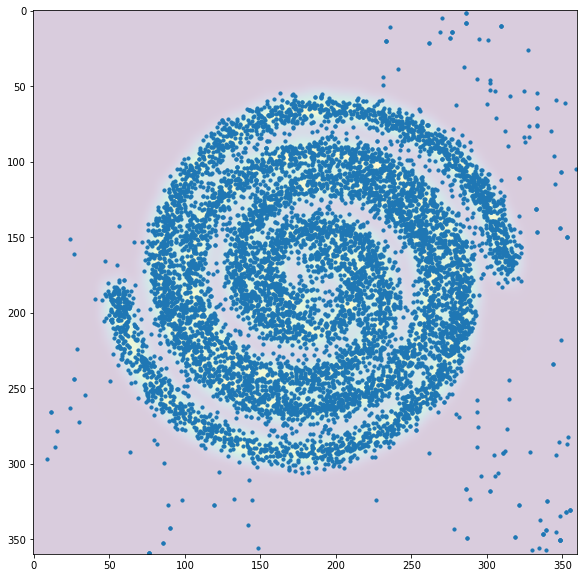

In [ ]:
## Epsilon with 0.7
from tqdm import tqdm

d = 2  # dimensionality 
n_iter = 10000
k = 40
epsilon = 0.7

sampled_outputs = onp.zeros((1, n_iter, 2), dtype=density.dtype)
key = jax.random.PRNGKey(1)
init_sample = sample_from_image_density(1, density, key).flatten()

with tqdm(total=n_iter) as pbar:
  for i in range(n_iter):
      init_sample = hamiltonian_monte_carlo(init_sample, energy_fn, k, epsilon)
      sampled_outputs[0, i] = init_sample
      pbar.update(1)

import numpy as onp

onp.savez(
    f"/content/drive/MyDrive/CS699/homework #2/spiral_iter10000_k40_e07.npy",
    sample=sampled_outputs
)

fig = matplotlib.pyplot.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(sampled_outputs[:, :, 1], sampled_outputs[:, :, 0], s=10)
ax.imshow(density, alpha=0.2)
matplotlib.pyplot.show()